In [1]:
import os
import pandas as pd

In [2]:
# Define the path to the main train folder
main_train_folder = 'train/train'

In [3]:
# Initialize lists to store the image locations and their classes
image_locations = []
image_classes = []

In [4]:
from tqdm import tqdm

In [5]:
# Walk through the directory structure
for root, dirs, files in os.walk(main_train_folder):
    for file in tqdm(files):
        if file.endswith(('png', 'jpg', 'jpeg')):  # Add other image file extensions if needed
            image_path = os.path.join(root, file)
            class_name = os.path.basename(root)
            image_locations.append(image_path)
            image_classes.append(class_name)

100%|█████████████████████████████████████| 492/492 [00:00<00:00, 901134.31it/s]


In [6]:
# Create the DataFrame
data = {
    'location': image_locations,
    'class': image_classes
}

In [7]:
df = pd.DataFrame(data)

In [8]:
df

location      class
0      train/train/Blueberry/Blueberry_176.jpg  Blueberry
1      train/train/Blueberry/Blueberry_162.jpg  Blueberry
2      train/train/Blueberry/Blueberry_189.jpg  Blueberry
3      train/train/Blueberry/Blueberry_348.jpg  Blueberry
4       train/train/Blueberry/Blueberry_59.jpg  Blueberry
...                                        ...        ...
16849          train/train/Peach/Peach_313.jpg      Peach
16850          train/train/Peach/Peach_475.jpg      Peach
16851          train/train/Peach/Peach_461.jpg      Peach
16852          train/train/Peach/Peach_307.jpg      Peach
16853          train/train/Peach/Peach_449.jpg      Peach

[16854 rows x 2 columns]

In [10]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [11]:
# Function to preprocess images
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    # Resize image
    image = cv2.resize(image, (224, 224))  # Resize to 224x224 or as required
    # Normalize image
    image = image / 255.0
    # Histogram equalization for each channel
    image[:, :, 0] = cv2.equalizeHist((image[:, :, 0] * 255).astype(np.uint8)) / 255.0
    image[:, :, 1] = cv2.equalizeHist((image[:, :, 1] * 255).astype(np.uint8)) / 255.0
    image[:, :, 2] = cv2.equalizeHist((image[:, :, 2] * 255).astype(np.uint8)) / 255.0
    # Edge detection using Canny
    edges = cv2.Canny((image * 255).astype(np.uint8), 100, 200)
    # Stack edges with original image to keep 3 channels
    edges_colored = np.stack((edges,)*3, axis=-1) / 255.0
    processed_image = np.concatenate((image, edges_colored), axis=2)  # Combine original image and edges
    return processed_image

In [12]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_dataframe = self.dataframe.iloc[batch_indices]
        X, y = self.__data_generation(batch_dataframe)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_dataframe):
        X = []
        y = []
        for index, row in batch_dataframe.iterrows():
            image_path = row['location']
            label = row['class']
            processed_image = preprocess_image(image_path)
            X.append(processed_image)
            y.append(label)
        X = np.array(X)
        y = np.array(y)
        y_encoded = label_encoder.transform(y)
        y_categorical = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))
        return X, y_categorical

print("Data generator initialized.")


Data generator initialized.


In [13]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])

# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

print("Label encoding and data splitting completed.")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")


Label encoding and data splitting completed.
Training data shape: (13483, 2)
Testing data shape: (3371, 2)


In [14]:
# Parameters
batch_size = 32
epochs = 10

# Create data generators
train_generator = DataGenerator(train_df, batch_size=batch_size)
test_generator = DataGenerator(test_df, batch_size=batch_size, shuffle=False)


In [13]:
from tqdm import tqdm

# XGBoost

In [19]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

In [15]:
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    # Resize image
    image = cv2.resize(image, (224, 224))  # Resize to 224x224 or as required
    # Normalize image
    image = image / 255.0
    # Histogram equalization for each channel
    image[:, :, 0] = cv2.equalizeHist((image[:, :, 0] * 255).astype(np.uint8)) / 255.0
    image[:, :, 1] = cv2.equalizeHist((image[:, :, 1] * 255).astype(np.uint8)) / 255.0
    image[:, :, 2] = cv2.equalizeHist((image[:, :, 2] * 255).astype(np.uint8)) / 255.0
    # Edge detection using Canny
    edges = cv2.Canny((image * 255).astype(np.uint8), 100, 200)
    # Stack edges with original image to keep 3 channels
    edges_colored = np.stack((edges,)*3, axis=-1) / 255.0
    processed_image = np.concatenate((image, edges_colored), axis=2)  # Combine original image and edges
    return processed_image

In [16]:
# Preprocess images and extract features using VGG16
def extract_features(dataframe):
    model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    features = []
    labels = []

    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        image_path = row['location']
        label = row['class']
        image = preprocess_image(image_path)[:, :, :3]  # Use only the original image part (not edges)
        image = preprocess_input(image)
        feature = model.predict(np.expand_dims(image, axis=0))
        features.append(feature.squeeze())
        labels.append(label)
    
    return np.array(features), np.array(labels)

In [17]:
# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

In [20]:
# Extract features
X_train, y_train = extract_features(train_df)
X_test, y_test = extract_features(test_df)

  0%|                                                 | 0/13483 [00:00<?, ?it/s]

1/1 [==============================] - 0s 183ms/step


  0%|                                         | 1/13483 [00:00<46:57,  4.79it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                         | 2/13483 [00:00<33:20,  6.74it/s]

1/1 [==============================] - 0s 95ms/step


  0%|                                         | 3/13483 [00:00<29:14,  7.68it/s]

1/1 [==============================] - 0s 95ms/step


  0%|                                         | 4/13483 [00:00<27:19,  8.22it/s]

1/1 [==============================] - 0s 95ms/step


  0%|                                         | 5/13483 [00:00<26:16,  8.55it/s]

1/1 [==============================] - 0s 97ms/step


  0%|                                         | 6/13483 [00:00<25:47,  8.71it/s]

1/1 [==============================] - 0s 95ms/step


  0%|                                         | 7/13483 [00:00<25:18,  8.87it/s]

1/1 [==============================] - 0s 92ms/step


  0%|                                         | 8/13483 [00:00<24:47,  9.06it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                         | 9/13483 [00:01<24:31,  9.16it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                        | 10/13483 [00:01<24:20,  9.22it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                        | 11/13483 [00:01<24:13,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                        | 12/13483 [00:01<24:15,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                        | 13/13483 [00:01<24:12,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                        | 14/13483 [00:01<24:10,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                        | 15/13483 [00:01<24:07,  9.31it/s]

1/1 [==============================] - 0s 109ms/step


  0%|                                        | 16/13483 [00:01<25:06,  8.94it/s]

1/1 [==============================] - 0s 110ms/step


  0%|                                        | 17/13483 [00:01<26:05,  8.60it/s]

1/1 [==============================] - 0s 98ms/step


  0%|                                        | 18/13483 [00:02<25:47,  8.70it/s]

1/1 [==============================] - 0s 106ms/step


  0%|                                        | 19/13483 [00:02<26:05,  8.60it/s]

1/1 [==============================] - 0s 97ms/step


  0%|                                        | 20/13483 [00:02<25:53,  8.67it/s]

1/1 [==============================] - 0s 97ms/step


  0%|                                        | 21/13483 [00:02<25:40,  8.74it/s]

1/1 [==============================] - 0s 105ms/step


  0%|                                        | 22/13483 [00:02<26:04,  8.61it/s]

1/1 [==============================] - 0s 107ms/step


  0%|                                        | 23/13483 [00:02<26:25,  8.49it/s]

1/1 [==============================] - 0s 101ms/step


  0%|                                        | 24/13483 [00:02<26:15,  8.54it/s]

1/1 [==============================] - 0s 108ms/step


  0%|                                        | 25/13483 [00:02<26:35,  8.44it/s]

1/1 [==============================] - 0s 98ms/step


  0%|                                        | 26/13483 [00:03<26:20,  8.52it/s]

1/1 [==============================] - 0s 93ms/step


  0%|                                        | 27/13483 [00:03<25:44,  8.71it/s]

1/1 [==============================] - 0s 94ms/step


  0%|                                        | 28/13483 [00:03<25:25,  8.82it/s]

1/1 [==============================] - 0s 102ms/step


  0%|                                        | 29/13483 [00:03<25:34,  8.77it/s]

1/1 [==============================] - 0s 110ms/step


  0%|                                        | 30/13483 [00:03<26:17,  8.53it/s]

1/1 [==============================] - 0s 105ms/step


  0%|                                        | 31/13483 [00:03<26:25,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


  0%|                                        | 32/13483 [00:03<26:26,  8.48it/s]

1/1 [==============================] - 0s 99ms/step


  0%|                                        | 33/13483 [00:03<26:04,  8.59it/s]

1/1 [==============================] - 0s 93ms/step


  0%|                                        | 34/13483 [00:03<25:31,  8.78it/s]

1/1 [==============================] - 0s 93ms/step


  0%|                                        | 35/13483 [00:04<24:55,  8.99it/s]

1/1 [==============================] - 0s 95ms/step


  0%|                                        | 36/13483 [00:04<24:46,  9.05it/s]

1/1 [==============================] - 0s 115ms/step


  0%|                                        | 37/13483 [00:04<26:01,  8.61it/s]

1/1 [==============================] - 0s 110ms/step


  0%|                                        | 38/13483 [00:04<26:35,  8.42it/s]

1/1 [==============================] - 0s 106ms/step


  0%|                                        | 39/13483 [00:04<26:46,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


  0%|                                        | 40/13483 [00:04<26:48,  8.36it/s]

1/1 [==============================] - 0s 101ms/step


  0%|                                        | 41/13483 [00:04<26:27,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


  0%|                                        | 42/13483 [00:04<26:20,  8.50it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                       | 43/13483 [00:04<25:50,  8.67it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                       | 44/13483 [00:05<25:26,  8.80it/s]

1/1 [==============================] - 0s 93ms/step


  0%|▏                                       | 45/13483 [00:05<24:56,  8.98it/s]

1/1 [==============================] - 0s 93ms/step


  0%|▏                                       | 46/13483 [00:05<24:36,  9.10it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                       | 47/13483 [00:05<24:25,  9.17it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                       | 48/13483 [00:05<24:20,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                       | 49/13483 [00:05<24:14,  9.24it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                       | 50/13483 [00:05<24:10,  9.26it/s]

1/1 [==============================] - 0s 96ms/step


  0%|▏                                       | 51/13483 [00:05<24:09,  9.26it/s]

1/1 [==============================] - 0s 96ms/step


  0%|▏                                       | 52/13483 [00:05<24:20,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                       | 53/13483 [00:06<24:14,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                       | 54/13483 [00:06<24:10,  9.26it/s]

1/1 [==============================] - 0s 97ms/step


  0%|▏                                       | 55/13483 [00:06<24:14,  9.23it/s]

1/1 [==============================] - 0s 99ms/step


  0%|▏                                       | 56/13483 [00:06<24:27,  9.15it/s]

1/1 [==============================] - 0s 93ms/step


  0%|▏                                       | 57/13483 [00:06<24:19,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                       | 58/13483 [00:06<24:14,  9.23it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                       | 59/13483 [00:06<24:13,  9.24it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                       | 60/13483 [00:06<24:15,  9.22it/s]

1/1 [==============================] - 0s 93ms/step


  0%|▏                                       | 61/13483 [00:06<24:05,  9.28it/s]

1/1 [==============================] - 0s 123ms/step


  0%|▏                                       | 62/13483 [00:07<25:58,  8.61it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▏                                       | 63/13483 [00:07<25:21,  8.82it/s]

1/1 [==============================] - 0s 97ms/step


  0%|▏                                       | 64/13483 [00:07<25:05,  8.91it/s]

1/1 [==============================] - 0s 96ms/step


  0%|▏                                       | 65/13483 [00:07<24:53,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


  0%|▏                                       | 66/13483 [00:07<24:47,  9.02it/s]

1/1 [==============================] - 0s 101ms/step


  0%|▏                                       | 67/13483 [00:07<24:56,  8.97it/s]

1/1 [==============================] - 0s 102ms/step


  1%|▏                                       | 68/13483 [00:07<25:23,  8.81it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▏                                       | 69/13483 [00:07<25:01,  8.94it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▏                                       | 70/13483 [00:07<24:43,  9.04it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▏                                       | 71/13483 [00:08<24:25,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▏                                       | 72/13483 [00:08<24:22,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▏                                       | 73/13483 [00:08<24:20,  9.18it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▏                                       | 74/13483 [00:08<24:09,  9.25it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▏                                       | 75/13483 [00:08<23:57,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▏                                       | 76/13483 [00:08<23:59,  9.32it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▏                                       | 77/13483 [00:08<24:02,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▏                                       | 78/13483 [00:08<24:02,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▏                                       | 79/13483 [00:08<23:55,  9.34it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▏                                       | 80/13483 [00:09<24:16,  9.21it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▏                                       | 81/13483 [00:09<24:33,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▏                                       | 82/13483 [00:09<24:38,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▏                                       | 83/13483 [00:09<24:35,  9.08it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▏                                       | 84/13483 [00:09<24:36,  9.07it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                       | 85/13483 [00:09<24:22,  9.16it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▎                                       | 86/13483 [00:09<24:32,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▎                                       | 87/13483 [00:09<24:25,  9.14it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▎                                       | 88/13483 [00:09<24:11,  9.23it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                       | 89/13483 [00:10<24:10,  9.24it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▎                                       | 90/13483 [00:10<24:12,  9.22it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▎                                       | 91/13483 [00:10<24:13,  9.21it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                       | 92/13483 [00:10<24:12,  9.22it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                       | 93/13483 [00:10<24:05,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                       | 94/13483 [00:10<24:00,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                       | 95/13483 [00:10<24:01,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                       | 96/13483 [00:10<23:56,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                       | 97/13483 [00:10<23:58,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▎                                       | 98/13483 [00:10<23:53,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▎                                       | 99/13483 [00:11<23:47,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                      | 100/13483 [00:11<24:01,  9.29it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▎                                      | 101/13483 [00:11<24:03,  9.27it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▎                                      | 102/13483 [00:11<23:56,  9.31it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▎                                      | 103/13483 [00:11<24:10,  9.22it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▎                                      | 104/13483 [00:11<24:27,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▎                                      | 105/13483 [00:11<24:37,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▎                                      | 106/13483 [00:11<24:46,  9.00it/s]

1/1 [==============================] - 0s 100ms/step


  1%|▎                                      | 107/13483 [00:11<25:00,  8.91it/s]

1/1 [==============================] - 0s 105ms/step


  1%|▎                                      | 108/13483 [00:12<25:45,  8.65it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                      | 109/13483 [00:12<25:23,  8.78it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▎                                      | 110/13483 [00:12<25:03,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▎                                      | 111/13483 [00:12<25:00,  8.91it/s]

1/1 [==============================] - 0s 110ms/step


  1%|▎                                      | 112/13483 [00:12<25:40,  8.68it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▎                                      | 113/13483 [00:12<25:16,  8.82it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                      | 114/13483 [00:12<24:49,  8.97it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                      | 115/13483 [00:12<24:31,  9.08it/s]

1/1 [==============================] - 0s 102ms/step


  1%|▎                                      | 116/13483 [00:12<25:00,  8.91it/s]

1/1 [==============================] - 0s 103ms/step


  1%|▎                                      | 117/13483 [00:13<25:24,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


  1%|▎                                      | 118/13483 [00:13<25:28,  8.75it/s]

1/1 [==============================] - 0s 105ms/step


  1%|▎                                      | 119/13483 [00:13<25:52,  8.61it/s]

1/1 [==============================] - 0s 117ms/step


  1%|▎                                      | 120/13483 [00:13<26:54,  8.28it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▎                                      | 121/13483 [00:13<25:59,  8.57it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                      | 122/13483 [00:13<25:22,  8.78it/s]

1/1 [==============================] - 0s 103ms/step


  1%|▎                                      | 123/13483 [00:13<25:31,  8.72it/s]

1/1 [==============================] - 0s 109ms/step


  1%|▎                                      | 124/13483 [00:13<26:07,  8.52it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                      | 125/13483 [00:14<25:23,  8.77it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                      | 126/13483 [00:14<24:56,  8.93it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                      | 127/13483 [00:14<24:35,  9.05it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▎                                      | 128/13483 [00:14<24:20,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▎                                      | 129/13483 [00:14<24:15,  9.18it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 130/13483 [00:14<24:03,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 131/13483 [00:14<23:56,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▍                                      | 132/13483 [00:14<24:01,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 133/13483 [00:14<23:55,  9.30it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▍                                      | 134/13483 [00:14<24:13,  9.19it/s]

1/1 [==============================] - 0s 100ms/step


  1%|▍                                      | 135/13483 [00:15<24:36,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▍                                      | 136/13483 [00:15<24:36,  9.04it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 137/13483 [00:15<24:18,  9.15it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 138/13483 [00:15<24:11,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 139/13483 [00:15<24:03,  9.24it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 140/13483 [00:15<23:57,  9.28it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▍                                      | 141/13483 [00:15<24:01,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 142/13483 [00:15<23:58,  9.27it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▍                                      | 143/13483 [00:15<24:00,  9.26it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 144/13483 [00:16<23:54,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 145/13483 [00:16<23:49,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 146/13483 [00:16<23:48,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 147/13483 [00:16<23:45,  9.35it/s]

1/1 [==============================] - 0s 103ms/step


  1%|▍                                      | 148/13483 [00:16<24:32,  9.06it/s]

1/1 [==============================] - 0s 107ms/step


  1%|▍                                      | 149/13483 [00:16<25:18,  8.78it/s]

1/1 [==============================] - 0s 106ms/step


  1%|▍                                      | 150/13483 [00:16<25:45,  8.63it/s]

1/1 [==============================] - 0s 105ms/step


  1%|▍                                      | 151/13483 [00:16<25:55,  8.57it/s]

1/1 [==============================] - 0s 142ms/step


  1%|▍                                      | 152/13483 [00:17<29:05,  7.64it/s]

1/1 [==============================] - 0s 146ms/step


  1%|▍                                      | 153/13483 [00:17<31:11,  7.12it/s]

1/1 [==============================] - 0s 135ms/step


  1%|▍                                      | 154/13483 [00:17<31:49,  6.98it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▍                                      | 155/13483 [00:17<29:40,  7.49it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▍                                      | 156/13483 [00:17<28:15,  7.86it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 157/13483 [00:17<26:53,  8.26it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▍                                      | 158/13483 [00:17<26:01,  8.53it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 159/13483 [00:17<25:20,  8.76it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 160/13483 [00:18<24:47,  8.96it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 161/13483 [00:18<24:29,  9.07it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 162/13483 [00:18<24:12,  9.17it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 163/13483 [00:18<24:00,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 164/13483 [00:18<24:02,  9.23it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 165/13483 [00:18<23:50,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 166/13483 [00:18<23:44,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 167/13483 [00:18<23:40,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 168/13483 [00:18<23:36,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 169/13483 [00:18<23:32,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 170/13483 [00:19<23:31,  9.43it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▍                                      | 171/13483 [00:19<23:25,  9.47it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▍                                      | 172/13483 [00:19<23:36,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 173/13483 [00:19<23:38,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 174/13483 [00:19<23:34,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 175/13483 [00:19<23:30,  9.44it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 176/13483 [00:19<23:31,  9.43it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 177/13483 [00:19<23:31,  9.42it/s]

1/1 [==============================] - 0s 92ms/step


  1%|▌                                      | 178/13483 [00:19<23:28,  9.45it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 179/13483 [00:20<23:26,  9.46it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 180/13483 [00:20<23:33,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 181/13483 [00:20<23:29,  9.44it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 182/13483 [00:20<23:31,  9.42it/s]

1/1 [==============================] - 0s 108ms/step


  1%|▌                                      | 183/13483 [00:20<24:29,  9.05it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 184/13483 [00:20<24:14,  9.14it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 185/13483 [00:20<24:02,  9.22it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▌                                      | 186/13483 [00:20<24:03,  9.21it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 187/13483 [00:20<23:50,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 188/13483 [00:20<23:48,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 189/13483 [00:21<23:44,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 190/13483 [00:21<23:42,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 191/13483 [00:21<23:39,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 192/13483 [00:21<23:34,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 193/13483 [00:21<23:36,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 194/13483 [00:21<23:43,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 195/13483 [00:21<23:40,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 196/13483 [00:21<23:43,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▌                                      | 197/13483 [00:21<23:46,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 198/13483 [00:22<23:36,  9.38it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▌                                      | 199/13483 [00:22<23:46,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                      | 200/13483 [00:22<23:43,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▌                                      | 201/13483 [00:22<23:39,  9.36it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▌                                      | 202/13483 [00:22<23:43,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 203/13483 [00:22<23:39,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▌                                      | 204/13483 [00:22<23:43,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 205/13483 [00:22<23:38,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▌                                      | 206/13483 [00:22<23:41,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 207/13483 [00:23<23:35,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 208/13483 [00:23<23:33,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 209/13483 [00:23<23:29,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 210/13483 [00:23<23:26,  9.44it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 211/13483 [00:23<23:27,  9.43it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 212/13483 [00:23<23:29,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▌                                      | 213/13483 [00:23<23:30,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▌                                      | 214/13483 [00:23<23:26,  9.44it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▌                                      | 215/13483 [00:23<23:30,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▌                                      | 216/13483 [00:23<23:31,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 217/13483 [00:24<23:34,  9.38it/s]

1/1 [==============================] - 0s 96ms/step


  2%|▋                                      | 218/13483 [00:24<23:43,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 219/13483 [00:24<23:38,  9.35it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▋                                      | 220/13483 [00:24<23:38,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 221/13483 [00:24<23:43,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 222/13483 [00:24<23:41,  9.33it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▋                                      | 223/13483 [00:24<23:29,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 224/13483 [00:24<23:27,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 225/13483 [00:24<23:26,  9.43it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 226/13483 [00:25<23:28,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 227/13483 [00:25<23:27,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 228/13483 [00:25<23:33,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 229/13483 [00:25<23:31,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 230/13483 [00:25<23:28,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 231/13483 [00:25<23:25,  9.43it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 232/13483 [00:25<23:28,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 233/13483 [00:25<23:29,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 234/13483 [00:25<23:31,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 235/13483 [00:26<23:30,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 236/13483 [00:26<23:30,  9.39it/s]

1/1 [==============================] - 0s 96ms/step


  2%|▋                                      | 237/13483 [00:26<23:41,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▋                                      | 238/13483 [00:26<23:43,  9.30it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▋                                      | 239/13483 [00:26<23:32,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 240/13483 [00:26<23:28,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 241/13483 [00:26<23:24,  9.43it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 242/13483 [00:26<23:30,  9.39it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▋                                      | 243/13483 [00:26<23:34,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 244/13483 [00:26<23:40,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 245/13483 [00:27<23:37,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 246/13483 [00:27<23:35,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 247/13483 [00:27<23:33,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 248/13483 [00:27<23:29,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 249/13483 [00:27<23:27,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 250/13483 [00:27<23:27,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 251/13483 [00:27<23:24,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 252/13483 [00:27<23:30,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 253/13483 [00:27<23:32,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 254/13483 [00:28<23:31,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 255/13483 [00:28<23:28,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▋                                      | 256/13483 [00:28<23:28,  9.39it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▋                                      | 257/13483 [00:28<23:20,  9.44it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▋                                      | 258/13483 [00:28<23:17,  9.46it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▋                                      | 259/13483 [00:28<23:15,  9.47it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 260/13483 [00:28<23:29,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 261/13483 [00:28<23:28,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 262/13483 [00:28<23:32,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 263/13483 [00:28<23:28,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 264/13483 [00:29<23:26,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 265/13483 [00:29<23:20,  9.44it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 266/13483 [00:29<23:19,  9.44it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▊                                      | 267/13483 [00:29<23:24,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 268/13483 [00:29<23:30,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 269/13483 [00:29<23:26,  9.39it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▊                                      | 270/13483 [00:29<23:33,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 271/13483 [00:29<23:28,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 272/13483 [00:29<23:27,  9.39it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▊                                      | 273/13483 [00:30<23:27,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 274/13483 [00:30<23:23,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 275/13483 [00:30<23:25,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 276/13483 [00:30<23:32,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 277/13483 [00:30<23:28,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 278/13483 [00:30<23:29,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 279/13483 [00:30<23:28,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 280/13483 [00:30<23:20,  9.43it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 281/13483 [00:30<23:24,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 282/13483 [00:31<23:27,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 283/13483 [00:31<23:21,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 284/13483 [00:31<23:26,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 285/13483 [00:31<23:27,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 286/13483 [00:31<23:26,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 287/13483 [00:31<23:26,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 288/13483 [00:31<23:28,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▊                                      | 289/13483 [00:31<23:33,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 290/13483 [00:31<23:29,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 291/13483 [00:31<23:22,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 292/13483 [00:32<23:33,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 293/13483 [00:32<23:26,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 294/13483 [00:32<23:22,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 295/13483 [00:32<23:22,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 296/13483 [00:32<23:26,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 297/13483 [00:32<23:24,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 298/13483 [00:32<23:18,  9.43it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 299/13483 [00:32<23:17,  9.43it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▊                                      | 300/13483 [00:32<23:23,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 301/13483 [00:33<23:24,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▊                                      | 302/13483 [00:33<23:25,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 303/13483 [00:33<23:24,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 304/13483 [00:33<23:23,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 305/13483 [00:33<23:21,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 306/13483 [00:33<23:24,  9.38it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▉                                      | 307/13483 [00:33<23:15,  9.44it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 308/13483 [00:33<23:24,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 309/13483 [00:33<23:20,  9.41it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▉                                      | 310/13483 [00:33<23:24,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▉                                      | 311/13483 [00:34<23:25,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 312/13483 [00:34<23:27,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 313/13483 [00:34<23:24,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 314/13483 [00:34<23:25,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 315/13483 [00:34<23:21,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 316/13483 [00:34<23:26,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 317/13483 [00:34<23:26,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 318/13483 [00:34<23:18,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 319/13483 [00:34<23:21,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 320/13483 [00:35<23:24,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 321/13483 [00:35<23:21,  9.39it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▉                                      | 322/13483 [00:35<23:24,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 323/13483 [00:35<23:18,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 324/13483 [00:35<23:26,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▉                                      | 325/13483 [00:35<23:28,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 326/13483 [00:35<23:25,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 327/13483 [00:35<23:24,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 328/13483 [00:35<23:23,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 329/13483 [00:36<23:24,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 330/13483 [00:36<23:17,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 331/13483 [00:36<23:17,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 332/13483 [00:36<23:26,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 333/13483 [00:36<23:24,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  2%|▉                                      | 334/13483 [00:36<23:21,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 335/13483 [00:36<23:17,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 336/13483 [00:36<23:16,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


  2%|▉                                      | 337/13483 [00:36<23:16,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▉                                      | 338/13483 [00:36<23:15,  9.42it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▉                                      | 339/13483 [00:37<23:22,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▉                                      | 340/13483 [00:37<23:27,  9.34it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▉                                      | 341/13483 [00:37<23:19,  9.39it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▉                                      | 342/13483 [00:37<23:33,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▉                                      | 343/13483 [00:37<23:22,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▉                                      | 344/13483 [00:37<23:21,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  3%|▉                                      | 345/13483 [00:37<23:19,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 346/13483 [00:37<23:20,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 347/13483 [00:37<23:18,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 348/13483 [00:38<23:26,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 349/13483 [00:38<23:26,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█                                      | 350/13483 [00:38<23:21,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 351/13483 [00:38<23:20,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█                                      | 352/13483 [00:38<23:19,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 353/13483 [00:38<23:19,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 354/13483 [00:38<23:25,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 355/13483 [00:38<23:24,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 356/13483 [00:38<23:27,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 357/13483 [00:39<23:23,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 358/13483 [00:39<23:26,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 359/13483 [00:39<23:25,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 360/13483 [00:39<23:25,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 361/13483 [00:39<23:22,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 362/13483 [00:39<23:22,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 363/13483 [00:39<23:16,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 364/13483 [00:39<23:24,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 365/13483 [00:39<28:08,  7.77it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 366/13483 [00:40<26:39,  8.20it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█                                      | 367/13483 [00:40<25:37,  8.53it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 368/13483 [00:40<25:00,  8.74it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 369/13483 [00:40<24:35,  8.89it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 370/13483 [00:40<24:14,  9.02it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 371/13483 [00:40<24:00,  9.10it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 372/13483 [00:40<23:50,  9.17it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 373/13483 [00:40<23:53,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█                                      | 374/13483 [00:40<23:48,  9.18it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 375/13483 [00:41<23:41,  9.22it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 376/13483 [00:41<23:42,  9.22it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 377/13483 [00:41<23:34,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 378/13483 [00:41<23:35,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 379/13483 [00:41<23:31,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 380/13483 [00:41<23:28,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 381/13483 [00:41<23:33,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 382/13483 [00:41<23:34,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 383/13483 [00:41<23:31,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 384/13483 [00:41<23:29,  9.29it/s]

1/1 [==============================] - 0s 97ms/step


  3%|█                                      | 385/13483 [00:42<23:37,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█                                      | 386/13483 [00:42<23:35,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█                                      | 387/13483 [00:42<23:33,  9.27it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█                                      | 388/13483 [00:42<23:22,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 389/13483 [00:42<23:33,  9.26it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█▏                                     | 390/13483 [00:42<23:36,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 391/13483 [00:42<23:33,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 392/13483 [00:42<23:27,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 393/13483 [00:42<23:25,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 394/13483 [00:43<23:25,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 395/13483 [00:43<23:29,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 396/13483 [00:43<23:24,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 397/13483 [00:43<23:32,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 398/13483 [00:43<23:28,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 399/13483 [00:43<23:27,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 400/13483 [00:43<23:32,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 401/13483 [00:43<23:25,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 402/13483 [00:43<23:22,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 403/13483 [00:44<23:23,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 404/13483 [00:44<23:22,  9.33it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█▏                                     | 405/13483 [00:44<23:34,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 406/13483 [00:44<23:30,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 407/13483 [00:44<23:26,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 408/13483 [00:44<23:24,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 409/13483 [00:44<23:23,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 410/13483 [00:44<23:24,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 411/13483 [00:44<23:23,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 412/13483 [00:44<23:20,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 413/13483 [00:45<23:27,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 414/13483 [00:45<23:27,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 415/13483 [00:45<23:23,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 416/13483 [00:45<23:26,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 417/13483 [00:45<23:22,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 418/13483 [00:45<23:21,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 419/13483 [00:45<23:24,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 420/13483 [00:45<23:22,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 421/13483 [00:45<23:28,  9.27it/s]

1/1 [==============================] - 0s 97ms/step


  3%|█▏                                     | 422/13483 [00:46<23:35,  9.23it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 423/13483 [00:46<23:31,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 424/13483 [00:46<23:28,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 425/13483 [00:46<23:28,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 426/13483 [00:46<23:26,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▏                                     | 427/13483 [00:46<23:25,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 428/13483 [00:46<23:22,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 429/13483 [00:46<23:28,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 430/13483 [00:46<23:22,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▏                                     | 431/13483 [00:47<23:21,  9.31it/s]

1/1 [==============================] - 0s 101ms/step


  3%|█▏                                     | 432/13483 [00:47<23:46,  9.15it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 433/13483 [00:47<23:38,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 434/13483 [00:47<23:29,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 435/13483 [00:47<23:26,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 436/13483 [00:47<23:25,  9.29it/s]

1/1 [==============================] - 0s 97ms/step


  3%|█▎                                     | 437/13483 [00:47<23:42,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


  3%|█▎                                     | 438/13483 [00:47<23:55,  9.09it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 439/13483 [00:47<23:44,  9.16it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 440/13483 [00:48<23:37,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 441/13483 [00:48<23:29,  9.25it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 442/13483 [00:48<23:25,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 443/13483 [00:48<23:19,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█▎                                     | 444/13483 [00:48<23:11,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 445/13483 [00:48<23:21,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 446/13483 [00:48<23:23,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 447/13483 [00:48<23:20,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 448/13483 [00:48<23:23,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 449/13483 [00:48<23:21,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 450/13483 [00:49<23:22,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 451/13483 [00:49<23:21,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█▎                                     | 452/13483 [00:49<23:16,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 453/13483 [00:49<23:19,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 454/13483 [00:49<23:19,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 455/13483 [00:49<23:15,  9.33it/s]

1/1 [==============================] - 0s 97ms/step


  3%|█▎                                     | 456/13483 [00:49<23:29,  9.24it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█▎                                     | 457/13483 [00:49<23:30,  9.23it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█▎                                     | 458/13483 [00:49<23:23,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 459/13483 [00:50<23:23,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 460/13483 [00:50<23:20,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 461/13483 [00:50<23:22,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 462/13483 [00:50<23:16,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 463/13483 [00:50<23:19,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 464/13483 [00:50<23:19,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 465/13483 [00:50<23:16,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


  3%|█▎                                     | 466/13483 [00:50<23:09,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 467/13483 [00:50<23:11,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  3%|█▎                                     | 468/13483 [00:51<23:13,  9.34it/s]

1/1 [==============================] - 0s 96ms/step


  3%|█▎                                     | 469/13483 [00:51<23:24,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 470/13483 [00:51<23:25,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


  3%|█▎                                     | 471/13483 [00:51<23:23,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▎                                     | 472/13483 [00:51<23:18,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▎                                     | 473/13483 [00:51<23:15,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▎                                     | 474/13483 [00:51<23:12,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▎                                     | 475/13483 [00:51<23:14,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 476/13483 [00:51<23:09,  9.36it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▍                                     | 477/13483 [00:52<23:26,  9.25it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 478/13483 [00:52<23:23,  9.27it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▍                                     | 479/13483 [00:52<23:24,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 480/13483 [00:52<23:22,  9.27it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▍                                     | 481/13483 [00:52<23:25,  9.25it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 482/13483 [00:52<23:26,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 483/13483 [00:52<23:19,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 484/13483 [00:52<23:12,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 485/13483 [00:52<23:18,  9.30it/s]

1/1 [==============================] - 0s 97ms/step


  4%|█▍                                     | 486/13483 [00:52<23:26,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 487/13483 [00:53<23:20,  9.28it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▍                                     | 488/13483 [00:53<23:15,  9.31it/s]

1/1 [==============================] - 0s 92ms/step


  4%|█▍                                     | 489/13483 [00:53<23:07,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 490/13483 [00:53<23:04,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▍                                     | 491/13483 [00:53<23:03,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▍                                     | 492/13483 [00:53<22:59,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 493/13483 [00:53<23:09,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 494/13483 [00:53<23:11,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 495/13483 [00:53<23:07,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 496/13483 [00:54<23:07,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 497/13483 [00:54<23:06,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 498/13483 [00:54<23:03,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 499/13483 [00:54<23:05,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 500/13483 [00:54<23:06,  9.36it/s]

1/1 [==============================] - 0s 97ms/step


  4%|█▍                                     | 501/13483 [00:54<23:22,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 502/13483 [00:54<23:18,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 503/13483 [00:54<23:17,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 504/13483 [00:54<23:15,  9.30it/s]

1/1 [==============================] - 0s 104ms/step


  4%|█▍                                     | 505/13483 [00:55<23:46,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▍                                     | 506/13483 [00:55<23:48,  9.09it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 507/13483 [00:55<23:36,  9.16it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 508/13483 [00:55<23:28,  9.21it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▍                                     | 509/13483 [00:55<23:25,  9.23it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 510/13483 [00:55<23:24,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 511/13483 [00:55<23:18,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 512/13483 [00:55<23:18,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 513/13483 [00:55<23:26,  9.22it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▍                                     | 514/13483 [00:55<23:19,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 515/13483 [00:56<23:15,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 516/13483 [00:56<23:11,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▍                                     | 517/13483 [00:56<23:18,  9.27it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▍                                     | 518/13483 [00:56<23:21,  9.25it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 519/13483 [00:56<23:20,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 520/13483 [00:56<23:15,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 521/13483 [00:56<23:09,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 522/13483 [00:56<23:09,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▌                                     | 523/13483 [00:56<23:08,  9.33it/s]

1/1 [==============================] - 0s 98ms/step


  4%|█▌                                     | 524/13483 [00:57<23:24,  9.22it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▌                                     | 525/13483 [00:57<23:29,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 526/13483 [00:57<23:19,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 527/13483 [00:57<23:13,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 528/13483 [00:57<23:16,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 529/13483 [00:57<23:08,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 530/13483 [00:57<23:10,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 531/13483 [00:57<23:09,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 532/13483 [00:57<23:06,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 533/13483 [00:58<23:09,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 534/13483 [00:58<23:08,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 535/13483 [00:58<23:08,  9.33it/s]

1/1 [==============================] - 0s 97ms/step


  4%|█▌                                     | 536/13483 [00:58<23:17,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 537/13483 [00:58<23:12,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 538/13483 [00:58<23:09,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 539/13483 [00:58<23:09,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 540/13483 [00:58<23:07,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 541/13483 [00:58<23:15,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 542/13483 [00:58<23:15,  9.28it/s]

1/1 [==============================] - 0s 97ms/step


  4%|█▌                                     | 543/13483 [00:59<23:21,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 544/13483 [00:59<23:14,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 545/13483 [00:59<23:11,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 546/13483 [00:59<23:10,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 547/13483 [00:59<23:08,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 548/13483 [00:59<23:10,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▌                                     | 549/13483 [00:59<23:14,  9.27it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▌                                     | 550/13483 [00:59<23:07,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 551/13483 [00:59<23:04,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 552/13483 [01:00<23:04,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 553/13483 [01:00<23:02,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 554/13483 [01:00<23:01,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 555/13483 [01:00<23:02,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 556/13483 [01:00<23:00,  9.37it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▌                                     | 557/13483 [01:00<23:16,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 558/13483 [01:00<23:09,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 559/13483 [01:00<23:09,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▌                                     | 560/13483 [01:00<23:07,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▌                                     | 561/13483 [01:01<23:01,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 562/13483 [01:01<23:03,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▋                                     | 563/13483 [01:01<22:57,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 564/13483 [01:01<22:54,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 565/13483 [01:01<22:58,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 566/13483 [01:01<22:58,  9.37it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▋                                     | 567/13483 [01:01<23:02,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▋                                     | 568/13483 [01:01<23:02,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 569/13483 [01:01<23:00,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▋                                     | 570/13483 [01:01<23:05,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 571/13483 [01:02<23:04,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▋                                     | 572/13483 [01:02<22:57,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 573/13483 [01:02<23:03,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 574/13483 [01:02<22:58,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 575/13483 [01:02<22:54,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 576/13483 [01:02<22:55,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 577/13483 [01:02<22:54,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 578/13483 [01:02<22:56,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 579/13483 [01:02<22:55,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▋                                     | 580/13483 [01:03<22:56,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▋                                     | 581/13483 [01:03<23:01,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 582/13483 [01:03<23:00,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 583/13483 [01:03<22:59,  9.35it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▋                                     | 584/13483 [01:03<23:01,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 585/13483 [01:03<23:02,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 586/13483 [01:03<23:01,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 587/13483 [01:03<22:58,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▋                                     | 588/13483 [01:03<23:01,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 589/13483 [01:04<23:07,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 590/13483 [01:04<23:02,  9.33it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▋                                     | 591/13483 [01:04<23:04,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  4%|█▋                                     | 592/13483 [01:04<23:00,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 593/13483 [01:04<23:00,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 594/13483 [01:04<22:57,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▋                                     | 595/13483 [01:04<22:59,  9.34it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▋                                     | 596/13483 [01:04<23:03,  9.32it/s]

1/1 [==============================] - 0s 96ms/step


  4%|█▋                                     | 597/13483 [01:04<23:12,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 598/13483 [01:04<23:06,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 599/13483 [01:05<23:02,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 600/13483 [01:05<22:59,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 601/13483 [01:05<22:58,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 602/13483 [01:05<22:55,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 603/13483 [01:05<22:51,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 604/13483 [01:05<22:54,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  4%|█▋                                     | 605/13483 [01:05<23:00,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  4%|█▊                                     | 606/13483 [01:05<23:00,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 607/13483 [01:05<23:00,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 608/13483 [01:06<23:05,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 609/13483 [01:06<23:03,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▊                                     | 610/13483 [01:06<22:58,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 611/13483 [01:06<23:00,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 612/13483 [01:06<22:59,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 613/13483 [01:06<23:04,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 614/13483 [01:06<22:57,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 615/13483 [01:06<22:57,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 616/13483 [01:06<22:52,  9.37it/s]

1/1 [==============================] - 0s 92ms/step


  5%|█▊                                     | 617/13483 [01:07<22:43,  9.43it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 618/13483 [01:07<22:46,  9.41it/s]

1/1 [==============================] - 0s 96ms/step


  5%|█▊                                     | 619/13483 [01:07<22:52,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 620/13483 [01:07<22:57,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 621/13483 [01:07<23:01,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 622/13483 [01:07<22:56,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 623/13483 [01:07<22:58,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 624/13483 [01:07<22:56,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 625/13483 [01:07<22:57,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 626/13483 [01:07<22:54,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 627/13483 [01:08<22:58,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 628/13483 [01:08<22:59,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 629/13483 [01:08<23:07,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 630/13483 [01:08<23:03,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 631/13483 [01:08<22:59,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 632/13483 [01:08<22:58,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 633/13483 [01:08<23:00,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 634/13483 [01:08<22:58,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 635/13483 [01:08<22:59,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▊                                     | 636/13483 [01:09<22:53,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 637/13483 [01:09<23:01,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 638/13483 [01:09<22:56,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 639/13483 [01:09<22:56,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 640/13483 [01:09<22:55,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 641/13483 [01:09<22:52,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 642/13483 [01:09<22:51,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 643/13483 [01:09<22:56,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 644/13483 [01:09<22:51,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▊                                     | 645/13483 [01:10<22:51,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 646/13483 [01:10<22:48,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▊                                     | 647/13483 [01:10<22:49,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▊                                     | 648/13483 [01:10<22:51,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 649/13483 [01:10<22:50,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 650/13483 [01:10<22:49,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 651/13483 [01:10<22:48,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 652/13483 [01:10<22:50,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 653/13483 [01:10<22:57,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 654/13483 [01:10<22:56,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 655/13483 [01:11<22:58,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▉                                     | 656/13483 [01:11<22:53,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 657/13483 [01:11<22:56,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 658/13483 [01:11<22:55,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 659/13483 [01:11<22:53,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▉                                     | 660/13483 [01:11<22:47,  9.37it/s]

1/1 [==============================] - 0s 96ms/step


  5%|█▉                                     | 661/13483 [01:11<23:03,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 662/13483 [01:11<23:00,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▉                                     | 663/13483 [01:11<22:55,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 664/13483 [01:12<22:56,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 665/13483 [01:12<22:54,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 666/13483 [01:12<22:54,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 667/13483 [01:12<22:54,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 668/13483 [01:12<22:53,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 669/13483 [01:12<22:59,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 670/13483 [01:12<22:52,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 671/13483 [01:12<22:48,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 672/13483 [01:12<22:52,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 673/13483 [01:13<22:53,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 674/13483 [01:13<22:48,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 675/13483 [01:13<22:51,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  5%|█▉                                     | 676/13483 [01:13<22:48,  9.36it/s]

1/1 [==============================] - 0s 97ms/step


  5%|█▉                                     | 677/13483 [01:13<23:08,  9.22it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 678/13483 [01:13<23:01,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 679/13483 [01:13<22:56,  9.30it/s]

1/1 [==============================] - 0s 96ms/step


  5%|█▉                                     | 680/13483 [01:13<22:58,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 681/13483 [01:13<22:59,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 682/13483 [01:13<22:54,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 683/13483 [01:14<22:52,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 684/13483 [01:14<22:53,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 685/13483 [01:14<23:01,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 686/13483 [01:14<22:55,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 687/13483 [01:14<22:54,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 688/13483 [01:14<22:52,  9.32it/s]

1/1 [==============================] - 0s 97ms/step


  5%|█▉                                     | 689/13483 [01:14<23:02,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  5%|█▉                                     | 690/13483 [01:14<22:58,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  5%|█▉                                     | 691/13483 [01:14<22:59,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 692/13483 [01:15<22:54,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 693/13483 [01:15<22:57,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 694/13483 [01:15<22:57,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 695/13483 [01:15<22:56,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 696/13483 [01:15<22:53,  9.31it/s]

1/1 [==============================] - 0s 96ms/step


  5%|██                                     | 697/13483 [01:15<22:59,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 698/13483 [01:15<22:56,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 699/13483 [01:15<22:55,  9.29it/s]

1/1 [==============================] - 0s 96ms/step


  5%|██                                     | 700/13483 [01:15<22:58,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 701/13483 [01:16<23:00,  9.26it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██                                     | 702/13483 [01:16<22:52,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 703/13483 [01:16<22:51,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██                                     | 704/13483 [01:16<22:44,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 705/13483 [01:16<22:45,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 706/13483 [01:16<22:43,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 707/13483 [01:16<22:45,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 708/13483 [01:16<22:48,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 709/13483 [01:16<22:55,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██                                     | 710/13483 [01:17<22:49,  9.33it/s]

1/1 [==============================] - 0s 96ms/step


  5%|██                                     | 711/13483 [01:17<22:53,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 712/13483 [01:17<22:49,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 713/13483 [01:17<22:53,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 714/13483 [01:17<22:50,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 715/13483 [01:17<22:47,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 716/13483 [01:17<22:45,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 717/13483 [01:17<22:51,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██                                     | 718/13483 [01:17<22:47,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██                                     | 719/13483 [01:17<22:44,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 720/13483 [01:18<22:47,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██                                     | 721/13483 [01:18<22:42,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 722/13483 [01:18<22:46,  9.34it/s]

1/1 [==============================] - 0s 96ms/step


  5%|██                                     | 723/13483 [01:18<22:52,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 724/13483 [01:18<22:52,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 725/13483 [01:18<22:56,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 726/13483 [01:18<22:52,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 727/13483 [01:18<22:49,  9.31it/s]

1/1 [==============================] - 0s 97ms/step


  5%|██                                     | 728/13483 [01:18<22:55,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 729/13483 [01:19<22:50,  9.30it/s]

1/1 [==============================] - 0s 97ms/step


  5%|██                                     | 730/13483 [01:19<22:55,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 731/13483 [01:19<22:54,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 732/13483 [01:19<22:55,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██                                     | 733/13483 [01:19<22:55,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██                                     | 734/13483 [01:19<22:53,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██▏                                    | 735/13483 [01:19<22:51,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██▏                                    | 736/13483 [01:19<22:50,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


  5%|██▏                                    | 737/13483 [01:19<22:45,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██▏                                    | 738/13483 [01:20<22:49,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  5%|██▏                                    | 739/13483 [01:20<22:49,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██▏                                    | 740/13483 [01:20<22:51,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  5%|██▏                                    | 741/13483 [01:20<22:55,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 742/13483 [01:20<22:55,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 743/13483 [01:20<22:54,  9.27it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▏                                    | 744/13483 [01:20<22:46,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 745/13483 [01:20<22:41,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 746/13483 [01:20<22:41,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 747/13483 [01:20<22:39,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 748/13483 [01:21<22:38,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▏                                    | 749/13483 [01:21<22:38,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 750/13483 [01:21<22:37,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 751/13483 [01:21<22:39,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 752/13483 [01:21<22:40,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 753/13483 [01:21<22:38,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 754/13483 [01:21<22:36,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 755/13483 [01:21<22:36,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 756/13483 [01:21<22:40,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 757/13483 [01:22<22:45,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 758/13483 [01:22<22:42,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 759/13483 [01:22<22:43,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 760/13483 [01:22<22:40,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 761/13483 [01:22<22:40,  9.35it/s]

1/1 [==============================] - 0s 96ms/step


  6%|██▏                                    | 762/13483 [01:22<22:48,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 763/13483 [01:22<22:50,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 764/13483 [01:22<22:48,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 765/13483 [01:22<22:54,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 766/13483 [01:23<22:51,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 767/13483 [01:23<22:48,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 768/13483 [01:23<22:45,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 769/13483 [01:23<22:46,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 770/13483 [01:23<22:43,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 771/13483 [01:23<22:42,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 772/13483 [01:23<22:42,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▏                                    | 773/13483 [01:23<22:47,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▏                                    | 774/13483 [01:23<22:40,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 775/13483 [01:23<22:40,  9.34it/s]

1/1 [==============================] - 0s 97ms/step


  6%|██▏                                    | 776/13483 [01:24<22:50,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▏                                    | 777/13483 [01:24<22:51,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 778/13483 [01:24<22:45,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 779/13483 [01:24<22:42,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 780/13483 [01:24<22:40,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 781/13483 [01:24<22:45,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 782/13483 [01:24<22:41,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 783/13483 [01:24<22:41,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 784/13483 [01:24<22:40,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 785/13483 [01:25<22:37,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 786/13483 [01:25<22:37,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 787/13483 [01:25<22:32,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 788/13483 [01:25<22:34,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▎                                    | 789/13483 [01:25<22:39,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 790/13483 [01:25<22:40,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 791/13483 [01:25<22:40,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 792/13483 [01:25<22:37,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 793/13483 [01:25<22:37,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 794/13483 [01:26<22:38,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▎                                    | 795/13483 [01:26<22:34,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 796/13483 [01:26<22:37,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 797/13483 [01:26<22:38,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 798/13483 [01:26<22:35,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 799/13483 [01:26<22:36,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 800/13483 [01:26<22:36,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 801/13483 [01:26<22:36,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 802/13483 [01:26<22:37,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 803/13483 [01:26<22:37,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 804/13483 [01:27<22:34,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▎                                    | 805/13483 [01:27<22:38,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 806/13483 [01:27<22:37,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 807/13483 [01:27<22:35,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 808/13483 [01:27<22:34,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 809/13483 [01:27<22:33,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 810/13483 [01:27<22:36,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 811/13483 [01:27<22:39,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 812/13483 [01:27<22:40,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 813/13483 [01:28<22:43,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 814/13483 [01:28<22:44,  9.29it/s]

1/1 [==============================] - 0s 96ms/step


  6%|██▎                                    | 815/13483 [01:28<22:46,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▎                                    | 816/13483 [01:28<22:46,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 817/13483 [01:28<22:41,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 818/13483 [01:28<22:39,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▎                                    | 819/13483 [01:28<22:35,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 820/13483 [01:28<22:38,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▎                                    | 821/13483 [01:28<22:43,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 822/13483 [01:29<22:43,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 823/13483 [01:29<22:38,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 824/13483 [01:29<22:38,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 825/13483 [01:29<22:41,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▍                                    | 826/13483 [01:29<22:37,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 827/13483 [01:29<22:36,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 828/13483 [01:29<22:37,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 829/13483 [01:29<22:43,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 830/13483 [01:29<22:40,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▍                                    | 831/13483 [01:29<22:34,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 832/13483 [01:30<22:33,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▍                                    | 833/13483 [01:30<22:28,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 834/13483 [01:30<22:26,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▍                                    | 835/13483 [01:30<22:23,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 836/13483 [01:30<22:24,  9.41it/s]

1/1 [==============================] - 0s 96ms/step


  6%|██▍                                    | 837/13483 [01:30<22:40,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 838/13483 [01:30<22:43,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 839/13483 [01:30<22:37,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 840/13483 [01:30<22:40,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▍                                    | 841/13483 [01:31<22:34,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 842/13483 [01:31<22:37,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 843/13483 [01:31<22:34,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 844/13483 [01:31<22:34,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 845/13483 [01:31<22:42,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 846/13483 [01:31<22:39,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 847/13483 [01:31<22:36,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 848/13483 [01:31<22:32,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 849/13483 [01:31<22:29,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 850/13483 [01:32<22:26,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 851/13483 [01:32<22:25,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 852/13483 [01:32<22:28,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 853/13483 [01:32<22:32,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▍                                    | 854/13483 [01:32<22:29,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 855/13483 [01:32<22:33,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 856/13483 [01:32<22:32,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 857/13483 [01:32<22:34,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 858/13483 [01:32<22:34,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 859/13483 [01:32<22:32,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 860/13483 [01:33<22:30,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 861/13483 [01:33<22:37,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 862/13483 [01:33<22:38,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▍                                    | 863/13483 [01:33<22:38,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▍                                    | 864/13483 [01:33<22:32,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▌                                    | 865/13483 [01:33<22:32,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▌                                    | 866/13483 [01:33<22:31,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▌                                    | 867/13483 [01:33<22:31,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▌                                    | 868/13483 [01:33<22:30,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▌                                    | 869/13483 [01:34<22:36,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


  6%|██▌                                    | 870/13483 [01:34<22:31,  9.33it/s]

1/1 [==============================] - 0s 96ms/step


  6%|██▌                                    | 871/13483 [01:34<22:35,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▌                                    | 872/13483 [01:34<22:34,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▌                                    | 873/13483 [01:34<22:32,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  6%|██▌                                    | 874/13483 [01:34<22:34,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▌                                    | 875/13483 [01:34<22:33,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  6%|██▌                                    | 876/13483 [01:34<22:30,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 877/13483 [01:34<22:37,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 878/13483 [01:35<22:32,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 879/13483 [01:35<22:33,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 880/13483 [01:35<22:34,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 881/13483 [01:35<22:36,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 882/13483 [01:35<22:35,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 883/13483 [01:35<22:36,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 884/13483 [01:35<22:34,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 885/13483 [01:35<22:41,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 886/13483 [01:35<22:39,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 887/13483 [01:35<22:37,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 888/13483 [01:36<22:35,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 889/13483 [01:36<22:32,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 890/13483 [01:36<22:31,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 891/13483 [01:36<22:30,  9.32it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▌                                    | 892/13483 [01:36<22:35,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 893/13483 [01:36<22:40,  9.25it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 894/13483 [01:36<22:40,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 895/13483 [01:36<22:35,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 896/13483 [01:36<22:33,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 897/13483 [01:37<22:33,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 898/13483 [01:37<22:30,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 899/13483 [01:37<22:27,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 900/13483 [01:37<22:28,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 901/13483 [01:37<22:34,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▌                                    | 902/13483 [01:37<22:31,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 903/13483 [01:37<22:30,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 904/13483 [01:37<22:34,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 905/13483 [01:37<22:34,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


  7%|██▌                                    | 906/13483 [01:38<22:36,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▌                                    | 907/13483 [01:38<22:33,  9.29it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▋                                    | 908/13483 [01:38<23:01,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▋                                    | 909/13483 [01:38<23:14,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▋                                    | 910/13483 [01:38<23:12,  9.03it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 911/13483 [01:38<23:01,  9.10it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 912/13483 [01:38<22:51,  9.16it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 913/13483 [01:38<22:42,  9.23it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 914/13483 [01:38<22:39,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 915/13483 [01:39<22:34,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 916/13483 [01:39<22:31,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 917/13483 [01:39<22:35,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 918/13483 [01:39<22:33,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 919/13483 [01:39<22:32,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


  7%|██▋                                    | 920/13483 [01:39<22:24,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 921/13483 [01:39<22:24,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 922/13483 [01:39<22:26,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


  7%|██▋                                    | 923/13483 [01:39<22:23,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 924/13483 [01:39<22:26,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 925/13483 [01:40<22:33,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 926/13483 [01:40<22:30,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 927/13483 [01:40<22:30,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 928/13483 [01:40<22:28,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 929/13483 [01:40<22:27,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 930/13483 [01:40<22:20,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 931/13483 [01:40<22:23,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 932/13483 [01:40<22:27,  9.31it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▋                                    | 933/13483 [01:40<22:39,  9.23it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 934/13483 [01:41<22:31,  9.28it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▋                                    | 935/13483 [01:41<22:39,  9.23it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▋                                    | 936/13483 [01:41<22:44,  9.20it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▋                                    | 937/13483 [01:41<22:43,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 938/13483 [01:41<22:35,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▋                                    | 939/13483 [01:41<22:30,  9.29it/s]

1/1 [==============================] - 0s 100ms/step


  7%|██▋                                    | 940/13483 [01:41<22:51,  9.14it/s]

1/1 [==============================] - 0s 106ms/step


  7%|██▋                                    | 941/13483 [01:41<23:40,  8.83it/s]

1/1 [==============================] - 0s 106ms/step


  7%|██▋                                    | 942/13483 [01:41<24:11,  8.64it/s]

1/1 [==============================] - 0s 106ms/step


  7%|██▋                                    | 943/13483 [01:42<24:28,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


  7%|██▋                                    | 944/13483 [01:42<24:14,  8.62it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 945/13483 [01:42<23:48,  8.78it/s]

1/1 [==============================] - 0s 93ms/step


  7%|██▋                                    | 946/13483 [01:42<23:22,  8.94it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▋                                    | 947/13483 [01:42<23:06,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▋                                    | 948/13483 [01:42<23:06,  9.04it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▋                                    | 949/13483 [01:42<23:28,  8.90it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▋                                    | 950/13483 [01:42<23:41,  8.82it/s]

1/1 [==============================] - 0s 99ms/step


  7%|██▊                                    | 951/13483 [01:42<23:40,  8.82it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                    | 952/13483 [01:43<23:26,  8.91it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▊                                    | 953/13483 [01:43<23:10,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 954/13483 [01:43<23:05,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 955/13483 [01:43<23:07,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                    | 956/13483 [01:43<23:04,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 957/13483 [01:43<23:12,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                    | 958/13483 [01:43<23:11,  9.00it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▊                                    | 959/13483 [01:43<23:03,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 960/13483 [01:43<23:05,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                    | 961/13483 [01:44<22:59,  9.08it/s]

1/1 [==============================] - 0s 104ms/step


  7%|██▊                                    | 962/13483 [01:44<23:26,  8.90it/s]

1/1 [==============================] - 0s 105ms/step


  7%|██▊                                    | 963/13483 [01:44<23:50,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  7%|██▊                                    | 964/13483 [01:44<23:48,  8.76it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▊                                    | 965/13483 [01:44<23:58,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▊                                    | 966/13483 [01:44<23:57,  8.71it/s]

1/1 [==============================] - 0s 103ms/step


  7%|██▊                                    | 967/13483 [01:44<24:08,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


  7%|██▊                                    | 968/13483 [01:44<23:56,  8.71it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▊                                    | 969/13483 [01:45<24:05,  8.66it/s]

1/1 [==============================] - 0s 104ms/step


  7%|██▊                                    | 970/13483 [01:45<24:19,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


  7%|██▊                                    | 971/13483 [01:45<24:25,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▊                                    | 972/13483 [01:45<24:19,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▊                                    | 973/13483 [01:45<24:27,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


  7%|██▊                                    | 974/13483 [01:45<24:15,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


  7%|██▊                                    | 975/13483 [01:45<24:04,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▊                                    | 976/13483 [01:45<24:06,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


  7%|██▊                                    | 977/13483 [01:45<24:11,  8.62it/s]

1/1 [==============================] - 0s 110ms/step


  7%|██▊                                    | 978/13483 [01:46<24:45,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


  7%|██▊                                    | 979/13483 [01:46<24:41,  8.44it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                    | 980/13483 [01:46<24:13,  8.60it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                    | 981/13483 [01:46<23:56,  8.70it/s]

1/1 [==============================] - 0s 106ms/step


  7%|██▊                                    | 982/13483 [01:46<24:16,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


  7%|██▊                                    | 983/13483 [01:46<24:15,  8.59it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 984/13483 [01:46<24:01,  8.67it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                    | 985/13483 [01:46<23:48,  8.75it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 986/13483 [01:46<23:38,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


  7%|██▊                                    | 987/13483 [01:47<23:30,  8.86it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 988/13483 [01:47<23:30,  8.86it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▊                                    | 989/13483 [01:47<23:20,  8.92it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▊                                    | 990/13483 [01:47<23:16,  8.95it/s]

1/1 [==============================] - 0s 99ms/step


  7%|██▊                                    | 991/13483 [01:47<23:16,  8.95it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▊                                    | 992/13483 [01:47<23:11,  8.98it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▊                                    | 993/13483 [01:47<23:01,  9.04it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▉                                    | 994/13483 [01:47<22:52,  9.10it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▉                                    | 995/13483 [01:47<22:40,  9.18it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▉                                    | 996/13483 [01:48<22:33,  9.23it/s]

1/1 [==============================] - 0s 94ms/step


  7%|██▉                                    | 997/13483 [01:48<22:34,  9.22it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▉                                    | 998/13483 [01:48<22:33,  9.23it/s]

1/1 [==============================] - 0s 98ms/step


  7%|██▉                                    | 999/13483 [01:48<22:42,  9.16it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▊                                   | 1000/13483 [01:48<22:36,  9.20it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▊                                   | 1001/13483 [01:48<22:37,  9.19it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                   | 1002/13483 [01:48<22:41,  9.17it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▊                                   | 1003/13483 [01:48<22:37,  9.19it/s]

1/1 [==============================] - 0s 95ms/step


  7%|██▊                                   | 1004/13483 [01:48<22:35,  9.21it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▊                                   | 1005/13483 [01:49<22:58,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


  7%|██▊                                   | 1006/13483 [01:49<23:01,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


  7%|██▊                                   | 1007/13483 [01:49<22:57,  9.06it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▊                                   | 1008/13483 [01:49<23:12,  8.96it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▊                                   | 1009/13483 [01:49<23:22,  8.89it/s]

1/1 [==============================] - 0s 101ms/step


  7%|██▊                                   | 1010/13483 [01:49<23:31,  8.84it/s]

1/1 [==============================] - 0s 103ms/step


  7%|██▊                                   | 1011/13483 [01:49<23:44,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▊                                   | 1012/13483 [01:49<23:46,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▊                                   | 1013/13483 [01:49<23:48,  8.73it/s]

1/1 [==============================] - 0s 103ms/step


  8%|██▊                                   | 1014/13483 [01:50<24:00,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


  8%|██▊                                   | 1015/13483 [01:50<24:03,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


  8%|██▊                                   | 1016/13483 [01:50<24:01,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


  8%|██▊                                   | 1017/13483 [01:50<24:01,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


  8%|██▊                                   | 1018/13483 [01:50<24:01,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


  8%|██▊                                   | 1019/13483 [01:50<24:01,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


  8%|██▊                                   | 1020/13483 [01:50<23:57,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▉                                   | 1021/13483 [01:50<23:56,  8.68it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1022/13483 [01:51<23:38,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▉                                   | 1023/13483 [01:51<23:30,  8.83it/s]

1/1 [==============================] - 0s 95ms/step


  8%|██▉                                   | 1024/13483 [01:51<23:11,  8.95it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1025/13483 [01:51<23:02,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1026/13483 [01:51<23:01,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1027/13483 [01:51<22:56,  9.05it/s]

1/1 [==============================] - 0s 94ms/step


  8%|██▉                                   | 1028/13483 [01:51<22:44,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1029/13483 [01:51<22:51,  9.08it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▉                                   | 1030/13483 [01:51<22:56,  9.05it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▉                                   | 1031/13483 [01:51<23:01,  9.01it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1032/13483 [01:52<23:00,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1033/13483 [01:52<22:54,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


  8%|██▉                                   | 1034/13483 [01:52<22:53,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


  8%|██▉                                   | 1035/13483 [01:52<22:55,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1036/13483 [01:52<22:47,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1037/13483 [01:52<22:55,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1038/13483 [01:52<22:55,  9.04it/s]

1/1 [==============================] - 0s 95ms/step


  8%|██▉                                   | 1039/13483 [01:52<22:45,  9.11it/s]

1/1 [==============================] - 0s 101ms/step


  8%|██▉                                   | 1040/13483 [01:52<23:01,  9.01it/s]

1/1 [==============================] - 0s 102ms/step


  8%|██▉                                   | 1041/13483 [01:53<23:18,  8.90it/s]

1/1 [==============================] - 0s 101ms/step


  8%|██▉                                   | 1042/13483 [01:53<23:28,  8.84it/s]

1/1 [==============================] - 0s 100ms/step


  8%|██▉                                   | 1043/13483 [01:53<23:34,  8.80it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1044/13483 [01:53<23:20,  8.88it/s]

1/1 [==============================] - 0s 98ms/step


  8%|██▉                                   | 1045/13483 [01:53<23:15,  8.91it/s]

1/1 [==============================] - 0s 98ms/step


  8%|██▉                                   | 1046/13483 [01:53<23:10,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1047/13483 [01:53<23:11,  8.94it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1048/13483 [01:53<23:09,  8.95it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1049/13483 [01:54<23:04,  8.98it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1050/13483 [01:54<22:55,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██▉                                   | 1051/13483 [01:54<22:54,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


  8%|██▉                                   | 1052/13483 [01:54<22:43,  9.11it/s]

1/1 [==============================] - 0s 109ms/step


  8%|██▉                                   | 1053/13483 [01:54<23:38,  8.77it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██▉                                   | 1054/13483 [01:54<24:19,  8.52it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██▉                                   | 1055/13483 [01:54<24:43,  8.38it/s]

1/1 [==============================] - 0s 106ms/step


  8%|██▉                                   | 1056/13483 [01:54<24:52,  8.33it/s]

1/1 [==============================] - 0s 108ms/step


  8%|██▉                                   | 1057/13483 [01:54<25:00,  8.28it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▉                                   | 1058/13483 [01:55<24:31,  8.44it/s]

1/1 [==============================] - 0s 98ms/step


  8%|██▉                                   | 1059/13483 [01:55<24:03,  8.61it/s]

1/1 [==============================] - 0s 105ms/step


  8%|██▉                                   | 1060/13483 [01:55<24:15,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


  8%|██▉                                   | 1061/13483 [01:55<24:16,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


  8%|██▉                                   | 1062/13483 [01:55<24:04,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


  8%|██▉                                   | 1063/13483 [01:55<23:53,  8.67it/s]

1/1 [==============================] - 0s 98ms/step


  8%|██▉                                   | 1064/13483 [01:55<23:40,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1065/13483 [01:55<23:33,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1066/13483 [01:55<23:32,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1067/13483 [01:56<23:26,  8.83it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███                                   | 1068/13483 [01:56<23:23,  8.85it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███                                   | 1069/13483 [01:56<23:29,  8.80it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███                                   | 1070/13483 [01:56<23:24,  8.84it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1071/13483 [01:56<23:21,  8.86it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1072/13483 [01:56<23:27,  8.82it/s]

1/1 [==============================] - 0s 96ms/step


  8%|███                                   | 1073/13483 [01:56<23:16,  8.89it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███                                   | 1074/13483 [01:56<23:14,  8.90it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1075/13483 [01:56<23:16,  8.88it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1076/13483 [01:57<23:21,  8.85it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1077/13483 [01:57<23:29,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1078/13483 [01:57<29:12,  7.08it/s]

1/1 [==============================] - 0s 101ms/step


  8%|███                                   | 1079/13483 [01:57<27:37,  7.48it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1080/13483 [01:57<26:20,  7.85it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1081/13483 [01:57<25:27,  8.12it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1082/13483 [01:57<24:54,  8.30it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1083/13483 [01:57<24:26,  8.45it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1084/13483 [01:58<24:08,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1085/13483 [01:58<24:00,  8.61it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███                                   | 1086/13483 [01:58<23:53,  8.65it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1087/13483 [01:58<23:47,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1088/13483 [01:58<23:41,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1089/13483 [01:58<23:36,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1090/13483 [01:58<23:37,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


  8%|███                                   | 1091/13483 [01:58<23:39,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


  8%|███                                   | 1092/13483 [01:59<23:33,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1093/13483 [01:59<23:31,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1094/13483 [01:59<23:39,  8.73it/s]

1/1 [==============================] - 0s 102ms/step


  8%|███                                   | 1095/13483 [01:59<23:45,  8.69it/s]

1/1 [==============================] - 0s 104ms/step


  8%|███                                   | 1096/13483 [01:59<23:55,  8.63it/s]

1/1 [==============================] - 0s 104ms/step


  8%|███                                   | 1097/13483 [01:59<23:59,  8.61it/s]

1/1 [==============================] - 0s 105ms/step


  8%|███                                   | 1098/13483 [01:59<24:08,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


  8%|███                                   | 1099/13483 [01:59<24:10,  8.54it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1100/13483 [01:59<23:58,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


  8%|███                                   | 1101/13483 [02:00<23:53,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1102/13483 [02:00<23:48,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1103/13483 [02:00<23:43,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1104/13483 [02:00<23:41,  8.71it/s]

1/1 [==============================] - 0s 102ms/step


  8%|███                                   | 1105/13483 [02:00<23:48,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███                                   | 1106/13483 [02:00<23:49,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1107/13483 [02:00<23:45,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███                                   | 1108/13483 [02:00<23:40,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1109/13483 [02:00<23:34,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1110/13483 [02:01<23:40,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1111/13483 [02:01<23:42,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


  8%|███▏                                  | 1112/13483 [02:01<23:41,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1113/13483 [02:01<23:37,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1114/13483 [02:01<23:37,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1115/13483 [02:01<23:39,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1116/13483 [02:01<23:36,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1117/13483 [02:01<23:37,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1118/13483 [02:02<23:43,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1119/13483 [02:02<23:44,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


  8%|███▏                                  | 1120/13483 [02:02<23:46,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


  8%|███▏                                  | 1121/13483 [02:02<23:45,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1122/13483 [02:02<23:36,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1123/13483 [02:02<23:33,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1124/13483 [02:02<23:36,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1125/13483 [02:02<23:32,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1126/13483 [02:02<23:46,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1127/13483 [02:03<23:45,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1128/13483 [02:03<23:45,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1129/13483 [02:03<23:41,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1130/13483 [02:03<23:32,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1131/13483 [02:03<23:37,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1132/13483 [02:03<23:33,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1133/13483 [02:03<23:37,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1134/13483 [02:03<23:47,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1135/13483 [02:03<23:45,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1136/13483 [02:04<23:41,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1137/13483 [02:04<23:37,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1138/13483 [02:04<23:37,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1139/13483 [02:04<23:37,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1140/13483 [02:04<23:29,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1141/13483 [02:04<23:26,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1142/13483 [02:04<23:37,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


  8%|███▏                                  | 1143/13483 [02:04<23:38,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1144/13483 [02:05<23:39,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1145/13483 [02:05<23:39,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


  8%|███▏                                  | 1146/13483 [02:05<23:39,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▏                                  | 1147/13483 [02:05<23:39,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▏                                  | 1148/13483 [02:05<23:37,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▏                                  | 1149/13483 [02:05<23:32,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▏                                  | 1150/13483 [02:05<23:39,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▏                                  | 1151/13483 [02:05<23:38,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▏                                  | 1152/13483 [02:05<23:43,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▏                                  | 1153/13483 [02:06<23:39,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1154/13483 [02:06<23:37,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1155/13483 [02:06<23:35,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1156/13483 [02:06<23:33,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1157/13483 [02:06<23:31,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1158/13483 [02:06<23:36,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1159/13483 [02:06<23:25,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1160/13483 [02:06<23:31,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1161/13483 [02:06<23:30,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1162/13483 [02:07<23:30,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1163/13483 [02:07<23:29,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1164/13483 [02:07<23:30,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1165/13483 [02:07<23:25,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1166/13483 [02:07<23:30,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1167/13483 [02:07<23:28,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1168/13483 [02:07<23:30,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1169/13483 [02:07<23:32,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1170/13483 [02:07<23:33,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1171/13483 [02:08<23:32,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1172/13483 [02:08<23:25,  8.76it/s]

1/1 [==============================] - 0s 102ms/step


  9%|███▎                                  | 1173/13483 [02:08<23:35,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1174/13483 [02:08<23:39,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1175/13483 [02:08<23:31,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1176/13483 [02:08<23:28,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1177/13483 [02:08<23:27,  8.75it/s]

1/1 [==============================] - 0s 118ms/step


  9%|███▎                                  | 1178/13483 [02:08<24:39,  8.31it/s]

1/1 [==============================] - 0s 146ms/step


  9%|███▎                                  | 1179/13483 [02:09<27:16,  7.52it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███▎                                  | 1180/13483 [02:09<30:17,  6.77it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1181/13483 [02:09<28:25,  7.21it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1182/13483 [02:09<27:00,  7.59it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1183/13483 [02:09<26:00,  7.88it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1184/13483 [02:09<25:17,  8.10it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1185/13483 [02:09<24:49,  8.26it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1186/13483 [02:09<24:25,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


  9%|███▎                                  | 1187/13483 [02:10<24:13,  8.46it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1188/13483 [02:10<24:03,  8.52it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1189/13483 [02:10<23:50,  8.59it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▎                                  | 1190/13483 [02:10<23:48,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1191/13483 [02:10<23:46,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1192/13483 [02:10<23:38,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1193/13483 [02:10<23:37,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▎                                  | 1194/13483 [02:10<23:33,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1195/13483 [02:10<23:30,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1196/13483 [02:11<23:27,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▎                                  | 1197/13483 [02:11<23:25,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1198/13483 [02:11<23:31,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1199/13483 [02:11<23:31,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1200/13483 [02:11<23:25,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1201/13483 [02:11<23:24,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1202/13483 [02:11<23:21,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1203/13483 [02:11<23:17,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1204/13483 [02:12<23:17,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1205/13483 [02:12<23:17,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1206/13483 [02:12<23:27,  8.72it/s]

1/1 [==============================] - 0s 119ms/step


  9%|███▍                                  | 1207/13483 [02:12<24:38,  8.30it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1208/13483 [02:12<24:11,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


  9%|███▍                                  | 1209/13483 [02:12<24:00,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▍                                  | 1210/13483 [02:12<23:53,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1211/13483 [02:12<23:41,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1212/13483 [02:12<23:34,  8.68it/s]

1/1 [==============================] - 0s 97ms/step


  9%|███▍                                  | 1213/13483 [02:13<23:21,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1214/13483 [02:13<23:28,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1215/13483 [02:13<23:27,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1216/13483 [02:13<23:23,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1217/13483 [02:13<23:18,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▍                                  | 1218/13483 [02:13<23:24,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▍                                  | 1219/13483 [02:13<23:24,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1220/13483 [02:13<23:20,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1221/13483 [02:13<23:18,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1222/13483 [02:14<23:23,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1223/13483 [02:14<23:24,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▍                                  | 1224/13483 [02:14<23:28,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1225/13483 [02:14<23:26,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1226/13483 [02:14<23:23,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1227/13483 [02:14<23:24,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1228/13483 [02:14<23:26,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1229/13483 [02:14<23:19,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1230/13483 [02:15<23:25,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1231/13483 [02:15<23:22,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1232/13483 [02:15<23:22,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1233/13483 [02:15<23:20,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1234/13483 [02:15<23:17,  8.76it/s]

1/1 [==============================] - 0s 103ms/step


  9%|███▍                                  | 1235/13483 [02:15<23:35,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1236/13483 [02:15<23:31,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1237/13483 [02:15<23:29,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1238/13483 [02:15<23:33,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1239/13483 [02:16<23:34,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▍                                  | 1240/13483 [02:16<23:32,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▍                                  | 1241/13483 [02:16<23:25,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1242/13483 [02:16<23:21,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1243/13483 [02:16<23:17,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1244/13483 [02:16<23:17,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1245/13483 [02:16<23:17,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1246/13483 [02:16<23:22,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1247/13483 [02:16<23:16,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


  9%|███▌                                  | 1248/13483 [02:17<23:08,  8.81it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▌                                  | 1249/13483 [02:17<23:12,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1250/13483 [02:17<23:15,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1251/13483 [02:17<23:14,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1252/13483 [02:17<23:16,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1253/13483 [02:17<23:15,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1254/13483 [02:17<23:21,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1255/13483 [02:17<23:18,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1256/13483 [02:17<23:18,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1257/13483 [02:18<23:14,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1258/13483 [02:18<23:14,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1259/13483 [02:18<23:17,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1260/13483 [02:18<23:16,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1261/13483 [02:18<23:18,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1262/13483 [02:18<23:24,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1263/13483 [02:18<23:17,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1264/13483 [02:18<23:16,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▌                                  | 1265/13483 [02:19<23:17,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1266/13483 [02:19<23:20,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1267/13483 [02:19<23:18,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1268/13483 [02:19<23:15,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1269/13483 [02:19<23:15,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1270/13483 [02:19<23:24,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


  9%|███▌                                  | 1271/13483 [02:19<23:19,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


  9%|███▌                                  | 1272/13483 [02:19<23:19,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


  9%|███▌                                  | 1273/13483 [02:19<23:14,  8.76it/s]

1/1 [==============================] - 0s 102ms/step


  9%|███▌                                  | 1274/13483 [02:20<23:23,  8.70it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▌                                  | 1275/13483 [02:20<24:13,  8.40it/s]

1/1 [==============================] - 0s 107ms/step


  9%|███▌                                  | 1276/13483 [02:20<24:22,  8.35it/s]

1/1 [==============================] - 0s 107ms/step


  9%|███▌                                  | 1277/13483 [02:20<24:30,  8.30it/s]

1/1 [==============================] - 0s 120ms/step


  9%|███▌                                  | 1278/13483 [02:20<25:27,  7.99it/s]

1/1 [==============================] - 0s 107ms/step


  9%|███▌                                  | 1279/13483 [02:20<25:11,  8.07it/s]

1/1 [==============================] - 0s 105ms/step


  9%|███▌                                  | 1280/13483 [02:20<24:52,  8.18it/s]

1/1 [==============================] - 0s 118ms/step


 10%|███▌                                  | 1281/13483 [02:20<25:30,  7.98it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▌                                  | 1282/13483 [02:21<24:57,  8.15it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▌                                  | 1283/13483 [02:21<24:54,  8.16it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▌                                  | 1284/13483 [02:21<24:51,  8.18it/s]

1/1 [==============================] - 0s 110ms/step


 10%|███▌                                  | 1285/13483 [02:21<24:55,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 10%|███▌                                  | 1286/13483 [02:21<24:47,  8.20it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1287/13483 [02:21<24:25,  8.32it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1288/13483 [02:21<24:08,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1289/13483 [02:21<24:04,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 10%|███▋                                  | 1290/13483 [02:22<24:01,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1291/13483 [02:22<23:54,  8.50it/s]

1/1 [==============================] - 0s 100ms/step


 10%|███▋                                  | 1292/13483 [02:22<23:46,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 10%|███▋                                  | 1293/13483 [02:22<23:48,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1294/13483 [02:22<23:50,  8.52it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1295/13483 [02:22<23:56,  8.49it/s]

1/1 [==============================] - 0s 100ms/step


 10%|███▋                                  | 1296/13483 [02:22<23:44,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1297/13483 [02:22<23:44,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1298/13483 [02:22<23:40,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1299/13483 [02:23<23:39,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1300/13483 [02:23<23:40,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1301/13483 [02:23<23:37,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1302/13483 [02:23<23:45,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 10%|███▋                                  | 1303/13483 [02:23<23:46,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▋                                  | 1304/13483 [02:23<23:42,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1305/13483 [02:23<23:35,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1306/13483 [02:23<23:35,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1307/13483 [02:23<23:32,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1308/13483 [02:24<23:32,  8.62it/s]

1/1 [==============================] - 0s 103ms/step


 10%|███▋                                  | 1309/13483 [02:24<23:39,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1310/13483 [02:24<23:43,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███▋                                  | 1311/13483 [02:24<23:37,  8.58it/s]

1/1 [==============================] - 0s 104ms/step


 10%|███▋                                  | 1312/13483 [02:24<23:48,  8.52it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1313/13483 [02:24<23:52,  8.50it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▋                                  | 1314/13483 [02:24<24:05,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1315/13483 [02:24<24:05,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1316/13483 [02:25<24:04,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 10%|███▋                                  | 1317/13483 [02:25<24:00,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1318/13483 [02:25<24:12,  8.38it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▋                                  | 1319/13483 [02:25<24:15,  8.35it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▋                                  | 1320/13483 [02:25<24:26,  8.30it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▋                                  | 1321/13483 [02:25<24:22,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 10%|███▋                                  | 1322/13483 [02:25<24:17,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1323/13483 [02:25<24:14,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 10%|███▋                                  | 1324/13483 [02:26<24:13,  8.37it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▋                                  | 1325/13483 [02:26<24:17,  8.34it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▋                                  | 1326/13483 [02:26<24:26,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1327/13483 [02:26<24:24,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1328/13483 [02:26<24:20,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▋                                  | 1329/13483 [02:26<24:18,  8.33it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▋                                  | 1330/13483 [02:26<24:17,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1331/13483 [02:26<24:09,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1332/13483 [02:26<24:10,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1333/13483 [02:27<24:11,  8.37it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▊                                  | 1334/13483 [02:27<24:31,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1335/13483 [02:27<24:24,  8.29it/s]

1/1 [==============================] - 0s 102ms/step


 10%|███▊                                  | 1336/13483 [02:27<24:07,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1337/13483 [02:27<24:03,  8.42it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1338/13483 [02:27<24:07,  8.39it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1339/13483 [02:27<24:12,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1340/13483 [02:27<24:10,  8.37it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▊                                  | 1341/13483 [02:28<24:16,  8.34it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1342/13483 [02:28<24:25,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1343/13483 [02:28<24:24,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1344/13483 [02:28<24:18,  8.32it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▊                                  | 1345/13483 [02:28<24:24,  8.29it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1346/13483 [02:28<24:20,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1347/13483 [02:28<24:17,  8.33it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1348/13483 [02:28<24:18,  8.32it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▊                                  | 1349/13483 [02:29<24:22,  8.30it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1350/13483 [02:29<24:23,  8.29it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1351/13483 [02:29<24:18,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1352/13483 [02:29<24:19,  8.31it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1353/13483 [02:29<24:19,  8.31it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▊                                  | 1354/13483 [02:29<24:20,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1355/13483 [02:29<24:14,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1356/13483 [02:29<24:13,  8.34it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1357/13483 [02:29<24:17,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1358/13483 [02:30<24:24,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▊                                  | 1359/13483 [02:30<24:22,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1360/13483 [02:30<24:16,  8.32it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▊                                  | 1361/13483 [02:30<24:20,  8.30it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▊                                  | 1362/13483 [02:30<24:30,  8.24it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▊                                  | 1363/13483 [02:30<24:25,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1364/13483 [02:30<24:19,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1365/13483 [02:30<24:14,  8.33it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1366/13483 [02:31<24:24,  8.28it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▊                                  | 1367/13483 [02:31<24:26,  8.26it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▊                                  | 1368/13483 [02:31<24:16,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1369/13483 [02:31<24:18,  8.31it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▊                                  | 1370/13483 [02:31<24:23,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1371/13483 [02:31<24:21,  8.29it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▊                                  | 1372/13483 [02:31<24:15,  8.32it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▊                                  | 1373/13483 [02:31<24:19,  8.30it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▊                                  | 1374/13483 [02:32<24:37,  8.20it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1375/13483 [02:32<24:37,  8.19it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1376/13483 [02:32<24:44,  8.16it/s]

1/1 [==============================] - 0s 122ms/step


 10%|███▉                                  | 1377/13483 [02:32<25:33,  7.90it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1378/13483 [02:32<25:19,  7.97it/s]

1/1 [==============================] - 0s 117ms/step


 10%|███▉                                  | 1379/13483 [02:32<25:40,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 10%|███▉                                  | 1380/13483 [02:32<25:30,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 10%|███▉                                  | 1381/13483 [02:32<25:22,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1382/13483 [02:33<25:21,  7.95it/s]

1/1 [==============================] - 0s 111ms/step


 10%|███▉                                  | 1383/13483 [02:33<25:20,  7.96it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▉                                  | 1384/13483 [02:33<25:08,  8.02it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1385/13483 [02:33<25:08,  8.02it/s]

1/1 [==============================] - 0s 111ms/step


 10%|███▉                                  | 1386/13483 [02:33<25:09,  8.01it/s]

1/1 [==============================] - 0s 111ms/step


 10%|███▉                                  | 1387/13483 [02:33<25:13,  7.99it/s]

1/1 [==============================] - 0s 115ms/step


 10%|███▉                                  | 1388/13483 [02:33<25:30,  7.90it/s]

1/1 [==============================] - 0s 113ms/step


 10%|███▉                                  | 1389/13483 [02:33<25:34,  7.88it/s]

1/1 [==============================] - 0s 111ms/step


 10%|███▉                                  | 1390/13483 [02:34<25:38,  7.86it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1391/13483 [02:34<25:12,  7.99it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▉                                  | 1392/13483 [02:34<25:04,  8.04it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▉                                  | 1393/13483 [02:34<24:52,  8.10it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1394/13483 [02:34<24:37,  8.18it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1395/13483 [02:34<24:39,  8.17it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1396/13483 [02:34<24:30,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1397/13483 [02:34<24:23,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1398/13483 [02:35<24:29,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▉                                  | 1399/13483 [02:35<24:19,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1400/13483 [02:35<24:21,  8.26it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▉                                  | 1401/13483 [02:35<24:23,  8.26it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▉                                  | 1402/13483 [02:35<24:21,  8.26it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1403/13483 [02:35<24:31,  8.21it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▉                                  | 1404/13483 [02:35<24:32,  8.20it/s]

1/1 [==============================] - 0s 105ms/step


 10%|███▉                                  | 1405/13483 [02:35<24:19,  8.28it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1406/13483 [02:35<24:34,  8.19it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1407/13483 [02:36<24:41,  8.15it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▉                                  | 1408/13483 [02:36<24:38,  8.17it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1409/13483 [02:36<24:35,  8.18it/s]

1/1 [==============================] - 0s 106ms/step


 10%|███▉                                  | 1410/13483 [02:36<24:29,  8.21it/s]

1/1 [==============================] - 0s 107ms/step


 10%|███▉                                  | 1411/13483 [02:36<24:24,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 10%|███▉                                  | 1412/13483 [02:36<24:17,  8.28it/s]

1/1 [==============================] - 0s 108ms/step


 10%|███▉                                  | 1413/13483 [02:36<24:22,  8.25it/s]

1/1 [==============================] - 0s 109ms/step


 10%|███▉                                  | 1414/13483 [02:36<24:34,  8.19it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▉                                  | 1415/13483 [02:37<24:53,  8.08it/s]

1/1 [==============================] - 0s 109ms/step


 11%|███▉                                  | 1416/13483 [02:37<24:51,  8.09it/s]

1/1 [==============================] - 0s 108ms/step


 11%|███▉                                  | 1417/13483 [02:37<24:45,  8.12it/s]

1/1 [==============================] - 0s 109ms/step


 11%|███▉                                  | 1418/13483 [02:37<24:49,  8.10it/s]

1/1 [==============================] - 0s 110ms/step


 11%|███▉                                  | 1419/13483 [02:37<24:48,  8.10it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1420/13483 [02:37<24:44,  8.12it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████                                  | 1421/13483 [02:37<24:39,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 11%|████                                  | 1422/13483 [02:37<24:24,  8.23it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████                                  | 1423/13483 [02:38<24:25,  8.23it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1424/13483 [02:38<24:29,  8.21it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████                                  | 1425/13483 [02:38<24:29,  8.21it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1426/13483 [02:38<24:25,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████                                  | 1427/13483 [02:38<24:19,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████                                  | 1428/13483 [02:38<24:17,  8.27it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████                                  | 1429/13483 [02:38<24:25,  8.22it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████                                  | 1430/13483 [02:38<24:45,  8.12it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████                                  | 1431/13483 [02:39<24:51,  8.08it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████                                  | 1432/13483 [02:39<24:32,  8.18it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████                                  | 1433/13483 [02:39<24:35,  8.17it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████                                  | 1434/13483 [02:39<24:45,  8.11it/s]

1/1 [==============================] - 0s 120ms/step


 11%|████                                  | 1435/13483 [02:39<25:27,  7.89it/s]

1/1 [==============================] - 0s 116ms/step


 11%|████                                  | 1436/13483 [02:39<25:42,  7.81it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1437/13483 [02:39<25:16,  7.94it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████                                  | 1438/13483 [02:39<25:21,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1439/13483 [02:40<24:59,  8.03it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1440/13483 [02:40<24:49,  8.09it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1441/13483 [02:40<24:44,  8.11it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████                                  | 1442/13483 [02:40<24:37,  8.15it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████                                  | 1443/13483 [02:40<24:27,  8.21it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████                                  | 1444/13483 [02:40<24:24,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████                                  | 1445/13483 [02:40<24:15,  8.27it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1446/13483 [02:40<24:20,  8.24it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████                                  | 1447/13483 [02:41<24:15,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████                                  | 1448/13483 [02:41<24:08,  8.31it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████                                  | 1449/13483 [02:41<24:09,  8.30it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████                                  | 1450/13483 [02:41<24:12,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████                                  | 1451/13483 [02:41<24:06,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████                                  | 1452/13483 [02:41<24:04,  8.33it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████                                  | 1453/13483 [02:41<24:15,  8.26it/s]

1/1 [==============================] - 0s 120ms/step


 11%|████                                  | 1454/13483 [02:41<25:09,  7.97it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████                                  | 1455/13483 [02:42<25:05,  7.99it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████                                  | 1456/13483 [02:42<25:11,  7.96it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████                                  | 1457/13483 [02:42<25:06,  7.98it/s]

1/1 [==============================] - 0s 112ms/step


 11%|████                                  | 1458/13483 [02:42<25:16,  7.93it/s]

1/1 [==============================] - 0s 112ms/step


 11%|████                                  | 1459/13483 [02:42<25:18,  7.92it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████                                  | 1460/13483 [02:42<25:14,  7.94it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████                                  | 1461/13483 [02:42<25:09,  7.97it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████                                  | 1462/13483 [02:42<25:12,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████                                  | 1463/13483 [02:43<25:05,  7.98it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████▏                                 | 1464/13483 [02:43<25:07,  7.97it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▏                                 | 1465/13483 [02:43<25:20,  7.90it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1466/13483 [02:43<25:00,  8.01it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1467/13483 [02:43<24:49,  8.07it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▏                                 | 1468/13483 [02:43<24:47,  8.08it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▏                                 | 1469/13483 [02:43<24:39,  8.12it/s]

1/1 [==============================] - 0s 104ms/step


 11%|████▏                                 | 1470/13483 [02:43<24:30,  8.17it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▏                                 | 1471/13483 [02:43<24:31,  8.16it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1472/13483 [02:44<24:24,  8.20it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1473/13483 [02:44<24:15,  8.25it/s]

1/1 [==============================] - 0s 120ms/step


 11%|████▏                                 | 1474/13483 [02:44<25:02,  7.99it/s]

1/1 [==============================] - 0s 118ms/step


 11%|████▏                                 | 1475/13483 [02:44<25:30,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▏                                 | 1476/13483 [02:44<25:16,  7.92it/s]

1/1 [==============================] - 0s 117ms/step


 11%|████▏                                 | 1477/13483 [02:44<25:30,  7.85it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1478/13483 [02:44<25:16,  7.92it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1479/13483 [02:44<24:51,  8.05it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1480/13483 [02:45<24:37,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▏                                 | 1481/13483 [02:45<24:28,  8.17it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1482/13483 [02:45<24:28,  8.17it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1483/13483 [02:45<24:22,  8.21it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1484/13483 [02:45<24:15,  8.24it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▏                                 | 1485/13483 [02:45<24:10,  8.27it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1486/13483 [02:45<24:17,  8.23it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1487/13483 [02:45<24:11,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▏                                 | 1488/13483 [02:46<24:02,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▏                                 | 1489/13483 [02:46<24:02,  8.31it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▏                                 | 1490/13483 [02:46<24:09,  8.27it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▏                                 | 1491/13483 [02:46<24:08,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1492/13483 [02:46<24:07,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▏                                 | 1493/13483 [02:46<24:01,  8.32it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1494/13483 [02:46<24:12,  8.25it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▏                                 | 1495/13483 [02:46<24:16,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▏                                 | 1496/13483 [02:47<24:08,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1497/13483 [02:47<24:06,  8.29it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1498/13483 [02:47<24:09,  8.27it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▏                                 | 1499/13483 [02:47<24:14,  8.24it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▏                                 | 1500/13483 [02:47<24:15,  8.23it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▏                                 | 1501/13483 [02:47<24:30,  8.15it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████▏                                 | 1502/13483 [02:47<24:49,  8.04it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1503/13483 [02:47<24:37,  8.11it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▏                                 | 1504/13483 [02:48<24:28,  8.16it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▏                                 | 1505/13483 [02:48<24:12,  8.25it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▏                                 | 1506/13483 [02:48<24:10,  8.26it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████▏                                 | 1507/13483 [02:48<24:24,  8.18it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▎                                 | 1508/13483 [02:48<24:28,  8.16it/s]

1/1 [==============================] - 0s 112ms/step


 11%|████▎                                 | 1509/13483 [02:48<24:46,  8.06it/s]

1/1 [==============================] - 0s 123ms/step


 11%|████▎                                 | 1510/13483 [02:48<25:38,  7.78it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1511/13483 [02:48<25:18,  7.88it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1512/13483 [02:49<25:04,  7.96it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1513/13483 [02:49<24:50,  8.03it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1514/13483 [02:49<24:40,  8.09it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▎                                 | 1515/13483 [02:49<24:40,  8.08it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1516/13483 [02:49<24:29,  8.14it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1517/13483 [02:49<24:27,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 11%|████▎                                 | 1518/13483 [02:49<29:30,  6.76it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1519/13483 [02:49<27:50,  7.16it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1520/13483 [02:50<26:48,  7.44it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1521/13483 [02:50<26:13,  7.60it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▎                                 | 1522/13483 [02:50<25:29,  7.82it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1523/13483 [02:50<25:03,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1524/13483 [02:50<24:50,  8.02it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1525/13483 [02:50<24:30,  8.13it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▎                                 | 1526/13483 [02:50<24:25,  8.16it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1527/13483 [02:50<24:23,  8.17it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████▎                                 | 1528/13483 [02:51<24:29,  8.13it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▎                                 | 1529/13483 [02:51<24:19,  8.19it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1530/13483 [02:51<24:14,  8.22it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▎                                 | 1531/13483 [02:51<24:17,  8.20it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1532/13483 [02:51<24:10,  8.24it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1533/13483 [02:51<24:03,  8.28it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1534/13483 [02:51<24:18,  8.19it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1535/13483 [02:51<24:13,  8.22it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1536/13483 [02:52<24:14,  8.21it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▎                                 | 1537/13483 [02:52<24:06,  8.26it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▎                                 | 1538/13483 [02:52<24:14,  8.21it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1539/13483 [02:52<24:12,  8.22it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1540/13483 [02:52<24:12,  8.22it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████▎                                 | 1541/13483 [02:52<24:19,  8.18it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1542/13483 [02:52<24:20,  8.18it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1543/13483 [02:52<24:17,  8.19it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1544/13483 [02:53<24:15,  8.20it/s]

1/1 [==============================] - 0s 108ms/step


 11%|████▎                                 | 1545/13483 [02:53<24:15,  8.20it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1546/13483 [02:53<24:09,  8.23it/s]

1/1 [==============================] - 0s 106ms/step


 11%|████▎                                 | 1547/13483 [02:53<24:06,  8.25it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1548/13483 [02:53<24:07,  8.25it/s]

1/1 [==============================] - 0s 107ms/step


 11%|████▎                                 | 1549/13483 [02:53<24:02,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 11%|████▎                                 | 1550/13483 [02:53<24:01,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▎                                 | 1551/13483 [02:53<24:01,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▎                                 | 1552/13483 [02:53<24:02,  8.27it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▍                                 | 1553/13483 [02:54<24:01,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 12%|████▍                                 | 1554/13483 [02:54<23:54,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▍                                 | 1555/13483 [02:54<23:57,  8.30it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▍                                 | 1556/13483 [02:54<24:04,  8.26it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▍                                 | 1557/13483 [02:54<24:09,  8.23it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▍                                 | 1558/13483 [02:54<24:13,  8.20it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▍                                 | 1559/13483 [02:54<24:14,  8.20it/s]

1/1 [==============================] - 0s 127ms/step


 12%|████▍                                 | 1560/13483 [02:54<25:21,  7.84it/s]

1/1 [==============================] - 0s 118ms/step


 12%|████▍                                 | 1561/13483 [02:55<25:40,  7.74it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▍                                 | 1562/13483 [02:55<25:15,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▍                                 | 1563/13483 [02:55<24:54,  7.98it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▍                                 | 1564/13483 [02:55<24:34,  8.08it/s]

1/1 [==============================] - 0s 111ms/step


 12%|████▍                                 | 1565/13483 [02:55<24:34,  8.08it/s]

1/1 [==============================] - 0s 105ms/step


 12%|████▍                                 | 1566/13483 [02:55<24:28,  8.11it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▍                                 | 1567/13483 [02:55<24:22,  8.15it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▍                                 | 1568/13483 [02:55<24:18,  8.17it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▍                                 | 1569/13483 [02:56<24:23,  8.14it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▍                                 | 1570/13483 [02:56<24:20,  8.16it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▍                                 | 1571/13483 [02:56<24:15,  8.19it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▍                                 | 1572/13483 [02:56<24:47,  8.01it/s]

1/1 [==============================] - 0s 105ms/step


 12%|████▍                                 | 1573/13483 [02:56<24:25,  8.13it/s]

1/1 [==============================] - 0s 110ms/step


 12%|████▍                                 | 1574/13483 [02:56<24:38,  8.05it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▍                                 | 1575/13483 [02:56<24:26,  8.12it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▍                                 | 1576/13483 [02:56<24:20,  8.15it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▍                                 | 1577/13483 [02:57<24:21,  8.15it/s]

1/1 [==============================] - 0s 110ms/step


 12%|████▍                                 | 1578/13483 [02:57<24:30,  8.10it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▍                                 | 1579/13483 [02:57<24:22,  8.14it/s]

1/1 [==============================] - 0s 117ms/step


 12%|████▍                                 | 1580/13483 [02:57<24:48,  8.00it/s]

1/1 [==============================] - 0s 121ms/step


 12%|████▍                                 | 1581/13483 [02:57<25:22,  7.82it/s]

1/1 [==============================] - 0s 123ms/step


 12%|████▍                                 | 1582/13483 [02:57<26:04,  7.61it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▍                                 | 1583/13483 [02:57<25:55,  7.65it/s]

1/1 [==============================] - 0s 117ms/step


 12%|████▍                                 | 1584/13483 [02:57<25:54,  7.65it/s]

1/1 [==============================] - 0s 118ms/step


 12%|████▍                                 | 1585/13483 [02:58<25:58,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▍                                 | 1586/13483 [02:58<25:43,  7.71it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▍                                 | 1587/13483 [02:58<25:39,  7.73it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▍                                 | 1588/13483 [02:58<25:36,  7.74it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▍                                 | 1589/13483 [02:58<25:38,  7.73it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▍                                 | 1590/13483 [02:58<25:46,  7.69it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▍                                 | 1591/13483 [02:58<25:42,  7.71it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▍                                 | 1592/13483 [02:59<25:41,  7.72it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▍                                 | 1593/13483 [02:59<25:34,  7.75it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▍                                 | 1594/13483 [02:59<25:31,  7.76it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▍                                 | 1595/13483 [02:59<25:31,  7.76it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▍                                 | 1596/13483 [02:59<25:26,  7.79it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▌                                 | 1597/13483 [02:59<25:22,  7.80it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▌                                 | 1598/13483 [02:59<25:35,  7.74it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▌                                 | 1599/13483 [02:59<25:29,  7.77it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▌                                 | 1600/13483 [03:00<25:33,  7.75it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▌                                 | 1601/13483 [03:00<25:31,  7.76it/s]

1/1 [==============================] - 0s 117ms/step


 12%|████▌                                 | 1602/13483 [03:00<25:43,  7.70it/s]

1/1 [==============================] - 0s 117ms/step


 12%|████▌                                 | 1603/13483 [03:00<25:48,  7.67it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▌                                 | 1604/13483 [03:00<25:49,  7.66it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▌                                 | 1605/13483 [03:00<25:42,  7.70it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▌                                 | 1606/13483 [03:00<25:46,  7.68it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▌                                 | 1607/13483 [03:00<25:50,  7.66it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▌                                 | 1608/13483 [03:01<25:46,  7.68it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▌                                 | 1609/13483 [03:01<25:46,  7.68it/s]

1/1 [==============================] - 0s 117ms/step


 12%|████▌                                 | 1610/13483 [03:01<25:46,  7.68it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▌                                 | 1611/13483 [03:01<25:44,  7.69it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▌                                 | 1612/13483 [03:01<25:42,  7.70it/s]

1/1 [==============================] - 0s 117ms/step


 12%|████▌                                 | 1613/13483 [03:01<25:48,  7.66it/s]

1/1 [==============================] - 0s 121ms/step


 12%|████▌                                 | 1614/13483 [03:01<26:13,  7.54it/s]

1/1 [==============================] - 0s 121ms/step


 12%|████▌                                 | 1615/13483 [03:02<26:32,  7.45it/s]

1/1 [==============================] - 0s 120ms/step


 12%|████▌                                 | 1616/13483 [03:02<26:31,  7.46it/s]

1/1 [==============================] - 0s 120ms/step


 12%|████▌                                 | 1617/13483 [03:02<26:34,  7.44it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▌                                 | 1618/13483 [03:02<25:54,  7.63it/s]

1/1 [==============================] - 0s 126ms/step


 12%|████▌                                 | 1619/13483 [03:02<26:31,  7.46it/s]

1/1 [==============================] - 0s 131ms/step


 12%|████▌                                 | 1620/13483 [03:02<27:13,  7.26it/s]

1/1 [==============================] - 0s 123ms/step


 12%|████▌                                 | 1621/13483 [03:02<27:11,  7.27it/s]

1/1 [==============================] - 0s 126ms/step


 12%|████▌                                 | 1622/13483 [03:02<27:29,  7.19it/s]

1/1 [==============================] - 0s 127ms/step


 12%|████▌                                 | 1623/13483 [03:03<27:46,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▌                                 | 1624/13483 [03:03<27:38,  7.15it/s]

1/1 [==============================] - 0s 127ms/step


 12%|████▌                                 | 1625/13483 [03:03<27:54,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 12%|████▌                                 | 1626/13483 [03:03<27:42,  7.13it/s]

1/1 [==============================] - 0s 120ms/step


 12%|████▌                                 | 1627/13483 [03:03<27:23,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 12%|████▌                                 | 1628/13483 [03:03<27:19,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 12%|████▌                                 | 1629/13483 [03:03<27:08,  7.28it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▌                                 | 1630/13483 [03:04<27:20,  7.23it/s]

1/1 [==============================] - 0s 129ms/step


 12%|████▌                                 | 1631/13483 [03:04<27:38,  7.15it/s]

1/1 [==============================] - 0s 137ms/step


 12%|████▌                                 | 1632/13483 [03:04<28:17,  6.98it/s]

1/1 [==============================] - 0s 130ms/step


 12%|████▌                                 | 1633/13483 [03:04<28:20,  6.97it/s]

1/1 [==============================] - 0s 138ms/step


 12%|████▌                                 | 1634/13483 [03:04<29:01,  6.80it/s]

1/1 [==============================] - 0s 132ms/step


 12%|████▌                                 | 1635/13483 [03:04<29:02,  6.80it/s]

1/1 [==============================] - 0s 134ms/step


 12%|████▌                                 | 1636/13483 [03:04<29:10,  6.77it/s]

1/1 [==============================] - 0s 133ms/step


 12%|████▌                                 | 1637/13483 [03:05<29:19,  6.73it/s]

1/1 [==============================] - 0s 127ms/step


 12%|████▌                                 | 1638/13483 [03:05<29:20,  6.73it/s]

1/1 [==============================] - 0s 145ms/step


 12%|████▌                                 | 1639/13483 [03:05<30:03,  6.57it/s]

1/1 [==============================] - 0s 158ms/step


 12%|████▌                                 | 1640/13483 [03:05<31:13,  6.32it/s]

1/1 [==============================] - 0s 122ms/step


 12%|████▌                                 | 1641/13483 [03:05<30:00,  6.58it/s]

1/1 [==============================] - 0s 140ms/step


 12%|████▋                                 | 1642/13483 [03:05<30:10,  6.54it/s]

1/1 [==============================] - 0s 146ms/step


 12%|████▋                                 | 1643/13483 [03:06<30:38,  6.44it/s]

1/1 [==============================] - 0s 146ms/step


 12%|████▋                                 | 1644/13483 [03:06<30:57,  6.37it/s]

1/1 [==============================] - 0s 136ms/step


 12%|████▋                                 | 1645/13483 [03:06<30:44,  6.42it/s]

1/1 [==============================] - 0s 121ms/step


 12%|████▋                                 | 1646/13483 [03:06<29:44,  6.63it/s]

1/1 [==============================] - 0s 119ms/step


 12%|████▋                                 | 1647/13483 [03:06<28:43,  6.87it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▋                                 | 1648/13483 [03:06<27:14,  7.24it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▋                                 | 1649/13483 [03:06<26:14,  7.51it/s]

1/1 [==============================] - 0s 110ms/step


 12%|████▋                                 | 1650/13483 [03:07<25:45,  7.66it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▋                                 | 1651/13483 [03:07<25:13,  7.82it/s]

1/1 [==============================] - 0s 118ms/step


 12%|████▋                                 | 1652/13483 [03:07<25:31,  7.73it/s]

1/1 [==============================] - 0s 121ms/step


 12%|████▋                                 | 1653/13483 [03:07<25:53,  7.62it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▋                                 | 1654/13483 [03:07<25:25,  7.75it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▋                                 | 1655/13483 [03:07<25:25,  7.75it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▋                                 | 1656/13483 [03:07<25:00,  7.88it/s]

1/1 [==============================] - 0s 112ms/step


 12%|████▋                                 | 1657/13483 [03:07<24:54,  7.91it/s]

1/1 [==============================] - 0s 117ms/step


 12%|████▋                                 | 1658/13483 [03:08<25:15,  7.80it/s]

1/1 [==============================] - 0s 116ms/step


 12%|████▋                                 | 1659/13483 [03:08<25:24,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▋                                 | 1660/13483 [03:08<25:02,  7.87it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1661/13483 [03:08<24:40,  7.98it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▋                                 | 1662/13483 [03:08<24:33,  8.02it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1663/13483 [03:08<24:14,  8.13it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▋                                 | 1664/13483 [03:08<24:09,  8.16it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▋                                 | 1665/13483 [03:08<24:32,  8.02it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▋                                 | 1666/13483 [03:09<24:53,  7.91it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▋                                 | 1667/13483 [03:09<25:02,  7.86it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▋                                 | 1668/13483 [03:09<24:44,  7.96it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▋                                 | 1669/13483 [03:09<24:31,  8.03it/s]

1/1 [==============================] - 0s 105ms/step


 12%|████▋                                 | 1670/13483 [03:09<24:21,  8.08it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▋                                 | 1671/13483 [03:09<24:14,  8.12it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▋                                 | 1672/13483 [03:09<24:36,  8.00it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▋                                 | 1673/13483 [03:09<24:44,  7.95it/s]

1/1 [==============================] - 0s 111ms/step


 12%|████▋                                 | 1674/13483 [03:10<24:45,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▋                                 | 1675/13483 [03:10<24:34,  8.01it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1676/13483 [03:10<24:18,  8.10it/s]

1/1 [==============================] - 0s 107ms/step


 12%|████▋                                 | 1677/13483 [03:10<24:06,  8.16it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1678/13483 [03:10<24:03,  8.18it/s]

1/1 [==============================] - 0s 115ms/step


 12%|████▋                                 | 1679/13483 [03:10<24:28,  8.04it/s]

1/1 [==============================] - 0s 109ms/step


 12%|████▋                                 | 1680/13483 [03:10<24:21,  8.08it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1681/13483 [03:10<24:10,  8.14it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1682/13483 [03:11<24:02,  8.18it/s]

1/1 [==============================] - 0s 108ms/step


 12%|████▋                                 | 1683/13483 [03:11<24:01,  8.18it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1684/13483 [03:11<23:51,  8.24it/s]

1/1 [==============================] - 0s 106ms/step


 12%|████▋                                 | 1685/13483 [03:11<23:47,  8.27it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▊                                 | 1686/13483 [03:11<23:56,  8.21it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1687/13483 [03:11<23:52,  8.23it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▊                                 | 1688/13483 [03:11<23:47,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▊                                 | 1689/13483 [03:11<23:49,  8.25it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1690/13483 [03:11<23:50,  8.25it/s]

1/1 [==============================] - 0s 110ms/step


 13%|████▊                                 | 1691/13483 [03:12<23:56,  8.21it/s]

1/1 [==============================] - 0s 113ms/step


 13%|████▊                                 | 1692/13483 [03:12<24:18,  8.08it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▊                                 | 1693/13483 [03:12<24:19,  8.08it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1694/13483 [03:12<24:19,  8.08it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1695/13483 [03:12<24:11,  8.12it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1696/13483 [03:12<24:06,  8.15it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1697/13483 [03:12<24:02,  8.17it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1698/13483 [03:12<23:58,  8.19it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1699/13483 [03:13<23:52,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▊                                 | 1700/13483 [03:13<23:50,  8.24it/s]

1/1 [==============================] - 0s 104ms/step


 13%|████▊                                 | 1701/13483 [03:13<23:38,  8.31it/s]

1/1 [==============================] - 0s 109ms/step


 13%|████▊                                 | 1702/13483 [03:13<23:54,  8.22it/s]

1/1 [==============================] - 0s 114ms/step


 13%|████▊                                 | 1703/13483 [03:13<24:15,  8.09it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1704/13483 [03:13<24:09,  8.13it/s]

1/1 [==============================] - 0s 109ms/step


 13%|████▊                                 | 1705/13483 [03:13<24:08,  8.13it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1706/13483 [03:13<24:12,  8.11it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1707/13483 [03:14<24:07,  8.14it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▊                                 | 1708/13483 [03:14<23:54,  8.21it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1709/13483 [03:14<23:53,  8.21it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1710/13483 [03:14<24:02,  8.16it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1711/13483 [03:14<23:57,  8.19it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1712/13483 [03:14<24:00,  8.17it/s]

1/1 [==============================] - 0s 109ms/step


 13%|████▊                                 | 1713/13483 [03:14<24:01,  8.16it/s]

1/1 [==============================] - 0s 105ms/step


 13%|████▊                                 | 1714/13483 [03:14<23:52,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 13%|████▊                                 | 1715/13483 [03:15<23:45,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 13%|████▊                                 | 1716/13483 [03:15<23:35,  8.31it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1717/13483 [03:15<23:41,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 13%|████▊                                 | 1718/13483 [03:15<23:40,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▊                                 | 1719/13483 [03:15<23:37,  8.30it/s]

1/1 [==============================] - 0s 110ms/step


 13%|████▊                                 | 1720/13483 [03:15<23:52,  8.21it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1721/13483 [03:15<23:50,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▊                                 | 1722/13483 [03:15<23:46,  8.24it/s]

1/1 [==============================] - 0s 105ms/step


 13%|████▊                                 | 1723/13483 [03:16<23:43,  8.26it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▊                                 | 1724/13483 [03:16<23:44,  8.25it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▊                                 | 1725/13483 [03:16<23:42,  8.26it/s]

1/1 [==============================] - 0s 110ms/step


 13%|████▊                                 | 1726/13483 [03:16<23:59,  8.17it/s]

1/1 [==============================] - 0s 112ms/step


 13%|████▊                                 | 1727/13483 [03:16<24:11,  8.10it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▊                                 | 1728/13483 [03:16<24:18,  8.06it/s]

1/1 [==============================] - 0s 109ms/step


 13%|████▊                                 | 1729/13483 [03:16<24:15,  8.07it/s]

1/1 [==============================] - 0s 106ms/step


 13%|████▉                                 | 1730/13483 [03:16<24:01,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 13%|████▉                                 | 1731/13483 [03:16<23:53,  8.20it/s]

1/1 [==============================] - 0s 112ms/step


 13%|████▉                                 | 1732/13483 [03:17<24:10,  8.10it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▉                                 | 1733/13483 [03:17<24:16,  8.07it/s]

1/1 [==============================] - 0s 108ms/step


 13%|████▉                                 | 1734/13483 [03:17<24:15,  8.07it/s]

1/1 [==============================] - 0s 109ms/step


 13%|████▉                                 | 1735/13483 [03:17<24:12,  8.09it/s]

1/1 [==============================] - 0s 118ms/step


 13%|████▉                                 | 1736/13483 [03:17<24:51,  7.88it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▉                                 | 1737/13483 [03:17<24:47,  7.89it/s]

1/1 [==============================] - 0s 127ms/step


 13%|████▉                                 | 1738/13483 [03:17<25:38,  7.63it/s]

1/1 [==============================] - 0s 123ms/step


 13%|████▉                                 | 1739/13483 [03:18<26:06,  7.50it/s]

1/1 [==============================] - 0s 112ms/step


 13%|████▉                                 | 1740/13483 [03:18<25:37,  7.64it/s]

1/1 [==============================] - 0s 109ms/step


 13%|████▉                                 | 1741/13483 [03:18<25:10,  7.78it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▉                                 | 1742/13483 [03:18<25:06,  7.79it/s]

1/1 [==============================] - 0s 116ms/step


 13%|████▉                                 | 1743/13483 [03:18<25:15,  7.75it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▉                                 | 1744/13483 [03:18<25:07,  7.79it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▉                                 | 1745/13483 [03:18<24:55,  7.85it/s]

1/1 [==============================] - 0s 107ms/step


 13%|████▉                                 | 1746/13483 [03:18<24:38,  7.94it/s]

1/1 [==============================] - 0s 118ms/step


 13%|████▉                                 | 1747/13483 [03:19<25:01,  7.81it/s]

1/1 [==============================] - 0s 121ms/step


 13%|████▉                                 | 1748/13483 [03:19<25:29,  7.67it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▉                                 | 1749/13483 [03:19<25:11,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 13%|████▉                                 | 1750/13483 [03:19<25:02,  7.81it/s]

1/1 [==============================] - 0s 111ms/step


 13%|████▉                                 | 1751/13483 [03:19<24:52,  7.86it/s]

1/1 [==============================] - 0s 114ms/step


 13%|████▉                                 | 1752/13483 [03:19<25:02,  7.81it/s]

1/1 [==============================] - 0s 110ms/step


 13%|████▉                                 | 1753/13483 [03:19<24:49,  7.87it/s]

1/1 [==============================] - 0s 122ms/step


 13%|████▉                                 | 1754/13483 [03:19<25:24,  7.69it/s]

1/1 [==============================] - 0s 122ms/step


 13%|████▉                                 | 1755/13483 [03:20<25:49,  7.57it/s]

1/1 [==============================] - 0s 117ms/step


 13%|████▉                                 | 1756/13483 [03:20<25:46,  7.58it/s]

1/1 [==============================] - 0s 104ms/step


 13%|████▉                                 | 1757/13483 [03:20<24:57,  7.83it/s]

1/1 [==============================] - 0s 101ms/step


 13%|████▉                                 | 1758/13483 [03:20<24:22,  8.01it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1759/13483 [03:20<23:44,  8.23it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1760/13483 [03:20<23:13,  8.41it/s]

1/1 [==============================] - 0s 101ms/step


 13%|████▉                                 | 1761/13483 [03:20<22:52,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1762/13483 [03:20<22:37,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 13%|████▉                                 | 1763/13483 [03:21<22:29,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1764/13483 [03:21<22:23,  8.72it/s]

1/1 [==============================] - 0s 103ms/step


 13%|████▉                                 | 1765/13483 [03:21<22:25,  8.71it/s]

1/1 [==============================] - 0s 102ms/step


 13%|████▉                                 | 1766/13483 [03:21<22:35,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1767/13483 [03:21<22:26,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1768/13483 [03:21<22:18,  8.75it/s]

1/1 [==============================] - 0s 109ms/step


 13%|████▉                                 | 1769/13483 [03:21<22:47,  8.57it/s]

1/1 [==============================] - 0s 110ms/step


 13%|████▉                                 | 1770/13483 [03:21<23:11,  8.42it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1771/13483 [03:21<23:00,  8.48it/s]

1/1 [==============================] - 0s 99ms/step


 13%|████▉                                 | 1772/13483 [03:22<22:46,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1773/13483 [03:22<22:32,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 13%|████▉                                 | 1774/13483 [03:22<22:30,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████                                 | 1775/13483 [03:22<22:19,  8.74it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1776/13483 [03:22<22:19,  8.74it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1777/13483 [03:22<22:20,  8.73it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1778/13483 [03:22<22:21,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1779/13483 [03:22<22:19,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1780/13483 [03:22<22:16,  8.75it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1781/13483 [03:23<22:18,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1782/13483 [03:23<22:24,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1783/13483 [03:23<22:20,  8.73it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1784/13483 [03:23<22:17,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1785/13483 [03:23<22:16,  8.76it/s]

1/1 [==============================] - 0s 103ms/step


 13%|█████                                 | 1786/13483 [03:23<22:20,  8.73it/s]

1/1 [==============================] - 0s 103ms/step


 13%|█████                                 | 1787/13483 [03:23<22:24,  8.70it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1788/13483 [03:23<22:23,  8.71it/s]

1/1 [==============================] - 0s 110ms/step


 13%|█████                                 | 1789/13483 [03:24<22:48,  8.55it/s]

1/1 [==============================] - 0s 107ms/step


 13%|█████                                 | 1790/13483 [03:24<23:02,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 13%|█████                                 | 1791/13483 [03:24<22:51,  8.52it/s]

1/1 [==============================] - 0s 107ms/step


 13%|█████                                 | 1792/13483 [03:24<22:58,  8.48it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1793/13483 [03:24<22:41,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1794/13483 [03:24<22:34,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1795/13483 [03:24<22:24,  8.69it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1796/13483 [03:24<22:21,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1797/13483 [03:24<22:19,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1798/13483 [03:25<22:25,  8.69it/s]

1/1 [==============================] - 0s 103ms/step


 13%|█████                                 | 1799/13483 [03:25<22:24,  8.69it/s]

1/1 [==============================] - 0s 104ms/step


 13%|█████                                 | 1800/13483 [03:25<22:30,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1801/13483 [03:25<22:28,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████                                 | 1802/13483 [03:25<22:20,  8.71it/s]

1/1 [==============================] - 0s 103ms/step


 13%|█████                                 | 1803/13483 [03:25<22:23,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████                                 | 1804/13483 [03:25<22:14,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1805/13483 [03:25<22:11,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1806/13483 [03:25<22:16,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████                                 | 1807/13483 [03:26<22:13,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████                                 | 1808/13483 [03:26<22:06,  8.80it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████                                 | 1809/13483 [03:26<22:03,  8.82it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█████                                 | 1810/13483 [03:26<21:56,  8.87it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████                                 | 1811/13483 [03:26<21:53,  8.89it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█████                                 | 1812/13483 [03:26<21:49,  8.91it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█████                                 | 1813/13483 [03:26<21:48,  8.92it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█████                                 | 1814/13483 [03:26<27:09,  7.16it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1815/13483 [03:27<25:43,  7.56it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█████                                 | 1816/13483 [03:27<24:41,  7.87it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1817/13483 [03:27<23:54,  8.13it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████                                 | 1818/13483 [03:27<23:21,  8.32it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████▏                                | 1819/13483 [03:27<22:59,  8.46it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█████▏                                | 1820/13483 [03:27<22:41,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1821/13483 [03:27<22:30,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1822/13483 [03:27<22:28,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▏                                | 1823/13483 [03:27<22:24,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1824/13483 [03:28<22:19,  8.71it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▏                                | 1825/13483 [03:28<22:18,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1826/13483 [03:28<22:15,  8.73it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▏                                | 1827/13483 [03:28<22:14,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1828/13483 [03:28<22:10,  8.76it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▏                                | 1829/13483 [03:28<22:09,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1830/13483 [03:28<22:12,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1831/13483 [03:28<22:10,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1832/13483 [03:29<22:08,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1833/13483 [03:29<22:07,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1834/13483 [03:29<22:05,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1835/13483 [03:29<21:59,  8.83it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1836/13483 [03:29<22:02,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1837/13483 [03:29<21:56,  8.84it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1838/13483 [03:29<22:03,  8.80it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1839/13483 [03:29<22:06,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1840/13483 [03:29<22:04,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1841/13483 [03:30<22:03,  8.80it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1842/13483 [03:30<22:01,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1843/13483 [03:30<21:58,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1844/13483 [03:30<22:00,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1845/13483 [03:30<22:01,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▏                                | 1846/13483 [03:30<22:04,  8.79it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1847/13483 [03:30<22:05,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▏                                | 1848/13483 [03:30<22:03,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1849/13483 [03:30<22:00,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1850/13483 [03:31<21:58,  8.82it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1851/13483 [03:31<21:56,  8.84it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1852/13483 [03:31<21:57,  8.83it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1853/13483 [03:31<21:57,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1854/13483 [03:31<22:03,  8.79it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1855/13483 [03:31<22:00,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1856/13483 [03:31<22:01,  8.80it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1857/13483 [03:31<22:01,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1858/13483 [03:31<21:58,  8.82it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▏                                | 1859/13483 [03:32<21:55,  8.84it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▏                                | 1860/13483 [03:32<21:56,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1861/13483 [03:32<21:53,  8.85it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▏                                | 1862/13483 [03:32<22:01,  8.80it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▎                                | 1863/13483 [03:32<22:02,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1864/13483 [03:32<22:01,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1865/13483 [03:32<21:59,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1866/13483 [03:32<21:55,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1867/13483 [03:32<21:55,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1868/13483 [03:33<21:54,  8.84it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1869/13483 [03:33<21:55,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1870/13483 [03:33<21:58,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1871/13483 [03:33<21:56,  8.82it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1872/13483 [03:33<21:57,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1873/13483 [03:33<21:55,  8.82it/s]

1/1 [==============================] - 0s 98ms/step


 14%|█████▎                                | 1874/13483 [03:33<21:54,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1875/13483 [03:33<21:48,  8.87it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1876/13483 [03:34<21:46,  8.88it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1877/13483 [03:34<21:48,  8.87it/s]

1/1 [==============================] - 0s 98ms/step


 14%|█████▎                                | 1878/13483 [03:34<21:53,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1879/13483 [03:34<21:53,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1880/13483 [03:34<21:53,  8.83it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▎                                | 1881/13483 [03:34<21:53,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1882/13483 [03:34<21:53,  8.83it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▎                                | 1883/13483 [03:34<21:49,  8.86it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1884/13483 [03:34<21:49,  8.86it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1885/13483 [03:35<21:48,  8.87it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1886/13483 [03:35<21:54,  8.82it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1887/13483 [03:35<21:52,  8.84it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▎                                | 1888/13483 [03:35<21:51,  8.84it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1889/13483 [03:35<21:52,  8.84it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▎                                | 1890/13483 [03:35<21:47,  8.86it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1891/13483 [03:35<21:45,  8.88it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1892/13483 [03:35<21:46,  8.87it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1893/13483 [03:35<21:47,  8.87it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1894/13483 [03:36<21:53,  8.83it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1895/13483 [03:36<21:49,  8.85it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1896/13483 [03:36<21:48,  8.85it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1897/13483 [03:36<21:50,  8.84it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1898/13483 [03:36<21:47,  8.86it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1899/13483 [03:36<21:46,  8.87it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▎                                | 1900/13483 [03:36<21:44,  8.88it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█████▎                                | 1901/13483 [03:36<21:43,  8.88it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1902/13483 [03:36<21:53,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▎                                | 1903/13483 [03:37<21:50,  8.84it/s]

1/1 [==============================] - 0s 104ms/step


 14%|█████▎                                | 1904/13483 [03:37<22:06,  8.73it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▎                                | 1905/13483 [03:37<22:51,  8.44it/s]

1/1 [==============================] - 0s 110ms/step


 14%|█████▎                                | 1906/13483 [03:37<23:16,  8.29it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█████▎                                | 1907/13483 [03:37<23:46,  8.12it/s]

1/1 [==============================] - 0s 108ms/step


 14%|█████▍                                | 1908/13483 [03:37<23:41,  8.15it/s]

1/1 [==============================] - 0s 112ms/step


 14%|█████▍                                | 1909/13483 [03:37<23:55,  8.06it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█████▍                                | 1910/13483 [03:37<24:48,  7.77it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█████▍                                | 1911/13483 [03:38<25:21,  7.61it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█████▍                                | 1912/13483 [03:38<24:39,  7.82it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▍                                | 1913/13483 [03:38<24:04,  8.01it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▍                                | 1914/13483 [03:38<23:32,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█████▍                                | 1915/13483 [03:38<23:11,  8.31it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▍                                | 1916/13483 [03:38<22:50,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▍                                | 1917/13483 [03:38<22:43,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█████▍                                | 1918/13483 [03:38<22:50,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▍                                | 1919/13483 [03:39<22:42,  8.49it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▍                                | 1920/13483 [03:39<22:32,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▍                                | 1921/13483 [03:39<22:20,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█████▍                                | 1922/13483 [03:39<22:13,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█████▍                                | 1923/13483 [03:39<22:08,  8.70it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▍                                | 1924/13483 [03:39<22:09,  8.69it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▍                                | 1925/13483 [03:39<22:46,  8.46it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█████▍                                | 1926/13483 [03:39<24:03,  8.01it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█████▍                                | 1927/13483 [03:39<24:31,  7.85it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▍                                | 1928/13483 [03:40<24:31,  7.85it/s]

1/1 [==============================] - 0s 108ms/step


 14%|█████▍                                | 1929/13483 [03:40<24:20,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 14%|█████▍                                | 1930/13483 [03:40<24:02,  8.01it/s]

1/1 [==============================] - 0s 109ms/step


 14%|█████▍                                | 1931/13483 [03:40<23:52,  8.06it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▍                                | 1932/13483 [03:40<24:06,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 14%|█████▍                                | 1933/13483 [03:40<23:56,  8.04it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█████▍                                | 1934/13483 [03:40<23:53,  8.05it/s]

1/1 [==============================] - 0s 132ms/step


 14%|█████▍                                | 1935/13483 [03:41<25:12,  7.63it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█████▍                                | 1936/13483 [03:41<25:48,  7.46it/s]

1/1 [==============================] - 0s 109ms/step


 14%|█████▍                                | 1937/13483 [03:41<25:09,  7.65it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█████▍                                | 1938/13483 [03:41<25:42,  7.48it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█████▍                                | 1939/13483 [03:41<26:00,  7.40it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█████▍                                | 1940/13483 [03:41<25:02,  7.68it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▍                                | 1941/13483 [03:41<24:13,  7.94it/s]

1/1 [==============================] - 0s 116ms/step


 14%|█████▍                                | 1942/13483 [03:41<24:39,  7.80it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█████▍                                | 1943/13483 [03:42<25:22,  7.58it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█████▍                                | 1944/13483 [03:42<25:49,  7.45it/s]

1/1 [==============================] - 0s 106ms/step


 14%|█████▍                                | 1945/13483 [03:42<25:01,  7.68it/s]

1/1 [==============================] - 0s 105ms/step


 14%|█████▍                                | 1946/13483 [03:42<24:23,  7.88it/s]

1/1 [==============================] - 0s 104ms/step


 14%|█████▍                                | 1947/13483 [03:42<23:53,  8.05it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█████▍                                | 1948/13483 [03:42<23:26,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 14%|█████▍                                | 1949/13483 [03:42<23:13,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█████▍                                | 1950/13483 [03:42<23:19,  8.24it/s]

1/1 [==============================] - 0s 107ms/step


 14%|█████▍                                | 1951/13483 [03:43<23:17,  8.25it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█████▌                                | 1952/13483 [03:43<23:04,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 14%|█████▌                                | 1953/13483 [03:43<22:58,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█████▌                                | 1954/13483 [03:43<22:50,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 14%|█████▌                                | 1955/13483 [03:43<22:54,  8.39it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█████▌                                | 1956/13483 [03:43<22:59,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1957/13483 [03:43<22:49,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▌                                | 1958/13483 [03:43<22:51,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1959/13483 [03:43<22:41,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1960/13483 [03:44<22:39,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1961/13483 [03:44<22:34,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▌                                | 1962/13483 [03:44<22:36,  8.49it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1963/13483 [03:44<22:29,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1964/13483 [03:44<22:27,  8.55it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█████▌                                | 1965/13483 [03:44<22:40,  8.46it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1966/13483 [03:44<22:40,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1967/13483 [03:44<22:34,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1968/13483 [03:45<22:29,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1969/13483 [03:45<22:26,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1970/13483 [03:45<22:24,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1971/13483 [03:45<22:21,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1972/13483 [03:45<22:17,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1973/13483 [03:45<22:18,  8.60it/s]

1/1 [==============================] - 0s 108ms/step


 15%|█████▌                                | 1974/13483 [03:45<22:51,  8.39it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█████▌                                | 1975/13483 [03:45<24:04,  7.97it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1976/13483 [03:46<23:35,  8.13it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1977/13483 [03:46<23:14,  8.25it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1978/13483 [03:46<22:55,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1979/13483 [03:46<22:45,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1980/13483 [03:46<22:39,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1981/13483 [03:46<22:32,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1982/13483 [03:46<22:37,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1983/13483 [03:46<22:29,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▌                                | 1984/13483 [03:46<22:32,  8.50it/s]

1/1 [==============================] - 0s 143ms/step


 15%|█████▌                                | 1985/13483 [03:47<24:53,  7.70it/s]

1/1 [==============================] - 0s 128ms/step


 15%|█████▌                                | 1986/13483 [03:47<26:25,  7.25it/s]

1/1 [==============================] - 0s 131ms/step


 15%|█████▌                                | 1987/13483 [03:47<26:54,  7.12it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1988/13483 [03:47<25:36,  7.48it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1989/13483 [03:47<24:34,  7.80it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1990/13483 [03:47<23:59,  7.98it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1991/13483 [03:47<23:32,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▌                                | 1992/13483 [03:47<23:14,  8.24it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1993/13483 [03:48<22:56,  8.35it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▌                                | 1994/13483 [03:48<22:44,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▌                                | 1995/13483 [03:48<22:37,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 1996/13483 [03:48<22:31,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 1997/13483 [03:48<22:28,  8.52it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█████▋                                | 1998/13483 [03:48<22:43,  8.42it/s]

1/1 [==============================] - 0s 106ms/step


 15%|█████▋                                | 1999/13483 [03:48<22:48,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▋                                | 2000/13483 [03:48<22:44,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▋                                | 2001/13483 [03:49<22:40,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▋                                | 2002/13483 [03:49<22:37,  8.46it/s]

1/1 [==============================] - 0s 106ms/step


 15%|█████▋                                | 2003/13483 [03:49<22:45,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▋                                | 2004/13483 [03:49<22:43,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▋                                | 2005/13483 [03:49<22:30,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▋                                | 2006/13483 [03:49<22:35,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▋                                | 2007/13483 [03:49<22:30,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2008/13483 [03:49<22:27,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2009/13483 [03:49<22:23,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2010/13483 [03:50<22:23,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█████▋                                | 2011/13483 [03:50<22:13,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▋                                | 2012/13483 [03:50<22:13,  8.60it/s]

1/1 [==============================] - 0s 117ms/step


 15%|█████▋                                | 2013/13483 [03:50<23:07,  8.26it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2014/13483 [03:50<23:01,  8.30it/s]

1/1 [==============================] - 0s 132ms/step


 15%|█████▋                                | 2015/13483 [03:50<24:26,  7.82it/s]

1/1 [==============================] - 0s 106ms/step


 15%|█████▋                                | 2016/13483 [03:50<24:00,  7.96it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▋                                | 2017/13483 [03:50<23:28,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▋                                | 2018/13483 [03:51<23:12,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█████▋                                | 2019/13483 [03:51<23:03,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█████▋                                | 2020/13483 [03:51<23:01,  8.30it/s]

1/1 [==============================] - 0s 106ms/step


 15%|█████▋                                | 2021/13483 [03:51<22:56,  8.33it/s]

1/1 [==============================] - 0s 126ms/step


 15%|█████▋                                | 2022/13483 [03:51<24:12,  7.89it/s]

1/1 [==============================] - 0s 125ms/step


 15%|█████▋                                | 2023/13483 [03:51<25:00,  7.64it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█████▋                                | 2024/13483 [03:51<25:19,  7.54it/s]

1/1 [==============================] - 0s 110ms/step


 15%|█████▋                                | 2025/13483 [03:51<24:50,  7.69it/s]

1/1 [==============================] - 0s 109ms/step


 15%|█████▋                                | 2026/13483 [03:52<24:37,  7.76it/s]

1/1 [==============================] - 0s 106ms/step


 15%|█████▋                                | 2027/13483 [03:52<24:08,  7.91it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█████▋                                | 2028/13483 [03:52<23:53,  7.99it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2029/13483 [03:52<23:24,  8.16it/s]

1/1 [==============================] - 0s 110ms/step


 15%|█████▋                                | 2030/13483 [03:52<23:32,  8.11it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█████▋                                | 2031/13483 [03:52<23:25,  8.15it/s]

1/1 [==============================] - 0s 118ms/step


 15%|█████▋                                | 2032/13483 [03:52<24:02,  7.94it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2033/13483 [03:52<23:29,  8.12it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█████▋                                | 2034/13483 [03:53<22:59,  8.30it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▋                                | 2035/13483 [03:53<22:30,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▋                                | 2036/13483 [03:53<22:24,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2037/13483 [03:53<22:14,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▋                                | 2038/13483 [03:53<22:15,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 15%|█████▋                                | 2039/13483 [03:53<22:13,  8.58it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▋                                | 2040/13483 [03:53<21:51,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▊                                | 2041/13483 [03:53<21:48,  8.75it/s]

1/1 [==============================] - 0s 108ms/step


 15%|█████▊                                | 2042/13483 [03:54<22:10,  8.60it/s]

1/1 [==============================] - 0s 133ms/step


 15%|█████▊                                | 2043/13483 [03:54<23:52,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█████▊                                | 2044/13483 [03:54<23:26,  8.13it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▊                                | 2045/13483 [03:54<23:02,  8.28it/s]

1/1 [==============================] - 0s 102ms/step


 15%|█████▊                                | 2046/13483 [03:54<22:51,  8.34it/s]

1/1 [==============================] - 0s 117ms/step


 15%|█████▊                                | 2047/13483 [03:54<23:26,  8.13it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█████▊                                | 2048/13483 [03:54<23:07,  8.24it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█████▊                                | 2049/13483 [03:54<22:43,  8.38it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                | 2050/13483 [03:54<22:23,  8.51it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█████▊                                | 2051/13483 [03:55<22:09,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                | 2052/13483 [03:55<21:56,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                | 2053/13483 [03:55<21:46,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                | 2054/13483 [03:55<21:44,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█████▊                                | 2055/13483 [03:55<21:33,  8.83it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                | 2056/13483 [03:55<21:28,  8.87it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█████▊                                | 2057/13483 [03:55<21:24,  8.89it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█████▊                                | 2058/13483 [03:55<21:26,  8.88it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2059/13483 [03:55<21:13,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2060/13483 [03:56<21:08,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2061/13483 [03:56<21:03,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2062/13483 [03:56<21:04,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█████▊                                | 2063/13483 [03:56<21:04,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2064/13483 [03:56<20:59,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█████▊                                | 2065/13483 [03:56<20:59,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2066/13483 [03:56<20:58,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2067/13483 [03:56<20:53,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2068/13483 [03:56<20:53,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2069/13483 [03:57<20:51,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2070/13483 [03:57<20:56,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2071/13483 [03:57<20:52,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2072/13483 [03:57<20:46,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2073/13483 [03:57<20:47,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█████▊                                | 2074/13483 [03:57<20:52,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2075/13483 [03:57<20:48,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2076/13483 [03:57<20:46,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2077/13483 [03:57<20:42,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2078/13483 [03:58<20:48,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2079/13483 [03:58<20:46,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2080/13483 [03:58<20:47,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2081/13483 [03:58<20:47,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 15%|█████▊                                | 2082/13483 [03:58<20:46,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2083/13483 [03:58<20:47,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▊                                | 2084/13483 [03:58<20:50,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▉                                | 2085/13483 [03:58<20:50,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▉                                | 2086/13483 [03:58<20:56,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▉                                | 2087/13483 [03:59<20:53,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 15%|█████▉                                | 2088/13483 [03:59<20:55,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█████▉                                | 2089/13483 [03:59<20:57,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2090/13483 [03:59<20:56,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2091/13483 [03:59<20:53,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█████▉                                | 2092/13483 [03:59<20:46,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█████▉                                | 2093/13483 [03:59<20:42,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█████▉                                | 2094/13483 [03:59<20:40,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█████▉                                | 2095/13483 [03:59<20:41,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█████▉                                | 2096/13483 [04:00<20:40,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2097/13483 [04:00<20:43,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2098/13483 [04:00<20:43,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2099/13483 [04:00<20:43,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2100/13483 [04:00<20:44,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2101/13483 [04:00<20:46,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2102/13483 [04:00<20:49,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2103/13483 [04:00<20:49,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2104/13483 [04:00<20:50,  9.10it/s]

1/1 [==============================] - 0s 101ms/step


 16%|█████▉                                | 2105/13483 [04:01<21:01,  9.02it/s]

1/1 [==============================] - 0s 99ms/step


 16%|█████▉                                | 2106/13483 [04:01<21:05,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2107/13483 [04:01<20:59,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2108/13483 [04:01<20:56,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2109/13483 [04:01<20:53,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2110/13483 [04:01<20:56,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2111/13483 [04:01<20:53,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2112/13483 [04:01<20:51,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 16%|█████▉                                | 2113/13483 [04:01<20:56,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 16%|█████▉                                | 2114/13483 [04:02<20:56,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█████▉                                | 2115/13483 [04:02<20:48,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█████▉                                | 2116/13483 [04:02<20:44,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2117/13483 [04:02<20:45,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2118/13483 [04:02<20:52,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2119/13483 [04:02<20:51,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2120/13483 [04:02<20:53,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2121/13483 [04:02<20:56,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2122/13483 [04:02<20:51,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█████▉                                | 2123/13483 [04:03<20:44,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2124/13483 [04:03<20:47,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2125/13483 [04:03<20:45,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2126/13483 [04:03<20:51,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2127/13483 [04:03<20:50,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|█████▉                                | 2128/13483 [04:03<20:50,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2129/13483 [04:03<20:47,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2130/13483 [04:03<20:44,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████                                | 2131/13483 [04:03<20:47,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2132/13483 [04:04<20:47,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2133/13483 [04:04<20:46,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 16%|██████                                | 2134/13483 [04:04<20:46,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2135/13483 [04:04<20:41,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2136/13483 [04:04<20:40,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2137/13483 [04:04<20:40,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2138/13483 [04:04<20:35,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2139/13483 [04:04<20:40,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2140/13483 [04:04<20:41,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████                                | 2141/13483 [04:04<20:44,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2142/13483 [04:05<20:48,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2143/13483 [04:05<20:43,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████                                | 2144/13483 [04:05<20:46,  9.09it/s]

1/1 [==============================] - 0s 99ms/step


 16%|██████                                | 2145/13483 [04:05<20:49,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2146/13483 [04:05<20:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2147/13483 [04:05<20:39,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2148/13483 [04:05<20:39,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2149/13483 [04:05<20:40,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2150/13483 [04:05<20:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2151/13483 [04:06<20:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2152/13483 [04:06<20:42,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2153/13483 [04:06<20:41,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████                                | 2154/13483 [04:06<20:45,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2155/13483 [04:06<20:46,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2156/13483 [04:06<20:47,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2157/13483 [04:06<20:43,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2158/13483 [04:06<20:52,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2159/13483 [04:06<20:49,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2160/13483 [04:07<20:44,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2161/13483 [04:07<20:44,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2162/13483 [04:07<20:43,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2163/13483 [04:07<20:40,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2164/13483 [04:07<20:42,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2165/13483 [04:07<20:40,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2166/13483 [04:07<20:40,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2167/13483 [04:07<20:40,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████                                | 2168/13483 [04:07<20:36,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████                                | 2169/13483 [04:08<20:40,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2170/13483 [04:08<20:41,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████                                | 2171/13483 [04:08<20:42,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2172/13483 [04:08<20:41,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████                                | 2173/13483 [04:08<20:44,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2174/13483 [04:08<20:45,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2175/13483 [04:08<20:44,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2176/13483 [04:08<20:45,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2177/13483 [04:08<20:45,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2178/13483 [04:09<20:43,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2179/13483 [04:09<20:40,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2180/13483 [04:09<20:40,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 16%|██████▏                               | 2181/13483 [04:09<20:32,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2182/13483 [04:09<20:36,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2183/13483 [04:09<20:38,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▏                               | 2184/13483 [04:09<20:41,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2185/13483 [04:09<20:42,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▏                               | 2186/13483 [04:09<20:46,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2187/13483 [04:10<20:42,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2188/13483 [04:10<20:40,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2189/13483 [04:10<20:35,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2190/13483 [04:10<20:41,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2191/13483 [04:10<20:37,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2192/13483 [04:10<20:39,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2193/13483 [04:10<20:40,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2194/13483 [04:10<20:40,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2195/13483 [04:10<20:41,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2196/13483 [04:11<20:38,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2197/13483 [04:11<20:37,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2198/13483 [04:11<20:43,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2199/13483 [04:11<20:39,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▏                               | 2200/13483 [04:11<20:44,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2201/13483 [04:11<20:40,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2202/13483 [04:11<20:34,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2203/13483 [04:11<20:37,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2204/13483 [04:11<20:34,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2205/13483 [04:12<20:36,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2206/13483 [04:12<20:42,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2207/13483 [04:12<20:42,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2208/13483 [04:12<20:41,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2209/13483 [04:12<20:41,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2210/13483 [04:12<20:41,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2211/13483 [04:12<20:38,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2212/13483 [04:12<20:40,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2213/13483 [04:12<20:40,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▏                               | 2214/13483 [04:13<20:49,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2215/13483 [04:13<20:46,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▏                               | 2216/13483 [04:13<20:39,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▏                               | 2217/13483 [04:13<20:36,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▎                               | 2218/13483 [04:13<20:39,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▎                               | 2219/13483 [04:13<20:40,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 16%|██████▎                               | 2220/13483 [04:13<20:41,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▎                               | 2221/13483 [04:13<20:35,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 16%|██████▎                               | 2222/13483 [04:13<20:41,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 16%|██████▎                               | 2223/13483 [04:13<20:36,  9.11it/s]

1/1 [==============================] - 0s 103ms/step


 16%|██████▎                               | 2224/13483 [04:14<20:53,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2225/13483 [04:14<20:50,  9.01it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2226/13483 [04:14<20:44,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▎                               | 2227/13483 [04:14<20:40,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2228/13483 [04:14<20:39,  9.08it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▎                               | 2229/13483 [04:14<20:44,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▎                               | 2230/13483 [04:14<20:49,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2231/13483 [04:14<20:41,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2232/13483 [04:14<20:38,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2233/13483 [04:15<20:34,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2234/13483 [04:15<20:31,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▎                               | 2235/13483 [04:15<20:37,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2236/13483 [04:15<20:38,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2237/13483 [04:15<20:35,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2238/13483 [04:15<20:41,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2239/13483 [04:15<20:31,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▎                               | 2240/13483 [04:15<20:32,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2241/13483 [04:15<20:35,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2242/13483 [04:16<20:33,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2243/13483 [04:16<20:33,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2244/13483 [04:16<20:32,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2245/13483 [04:16<20:29,  9.14it/s]

1/1 [==============================] - 0s 100ms/step


 17%|██████▎                               | 2246/13483 [04:16<20:46,  9.01it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2247/13483 [04:16<20:39,  9.06it/s]

1/1 [==============================] - 0s 95ms/step


 17%|██████▎                               | 2248/13483 [04:16<20:32,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2249/13483 [04:16<20:33,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2250/13483 [04:16<20:35,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2251/13483 [04:17<20:34,  9.10it/s]

1/1 [==============================] - 0s 100ms/step


 17%|██████▎                               | 2252/13483 [04:17<20:45,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▎                               | 2253/13483 [04:17<20:43,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2254/13483 [04:17<20:42,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2255/13483 [04:17<20:36,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▎                               | 2256/13483 [04:17<20:35,  9.09it/s]

1/1 [==============================] - 0s 102ms/step


 17%|██████▎                               | 2257/13483 [04:17<20:50,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2258/13483 [04:17<20:44,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▎                               | 2259/13483 [04:17<20:42,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2260/13483 [04:18<20:37,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▎                               | 2261/13483 [04:18<20:33,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2262/13483 [04:18<20:35,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2263/13483 [04:18<20:32,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2264/13483 [04:18<20:31,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2265/13483 [04:18<20:31,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2266/13483 [04:18<20:29,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2267/13483 [04:18<20:27,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2268/13483 [04:18<20:27,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2269/13483 [04:19<20:26,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2270/13483 [04:19<20:33,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2271/13483 [04:19<20:31,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2272/13483 [04:19<20:31,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▍                               | 2273/13483 [04:19<20:32,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2274/13483 [04:19<20:31,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2275/13483 [04:19<20:31,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2276/13483 [04:19<20:30,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2277/13483 [04:19<20:24,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2278/13483 [04:20<20:33,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2279/13483 [04:20<20:31,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2280/13483 [04:20<20:28,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2281/13483 [04:20<20:27,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2282/13483 [04:20<20:27,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▍                               | 2283/13483 [04:20<20:29,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2284/13483 [04:20<20:24,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2285/13483 [04:20<20:24,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2286/13483 [04:20<20:28,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2287/13483 [04:21<20:26,  9.13it/s]

1/1 [==============================] - 0s 116ms/step


 17%|██████▍                               | 2288/13483 [04:21<21:34,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 17%|██████▍                               | 2289/13483 [04:21<21:44,  8.58it/s]

1/1 [==============================] - 0s 118ms/step


 17%|██████▍                               | 2290/13483 [04:21<22:32,  8.28it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▍                               | 2291/13483 [04:21<22:05,  8.44it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2292/13483 [04:21<21:39,  8.61it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2293/13483 [04:21<21:17,  8.76it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2294/13483 [04:21<21:02,  8.86it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2295/13483 [04:21<20:52,  8.93it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2296/13483 [04:22<20:46,  8.97it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2297/13483 [04:22<20:37,  9.04it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████▍                               | 2298/13483 [04:22<20:42,  9.01it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2299/13483 [04:22<20:34,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2300/13483 [04:22<20:31,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2301/13483 [04:22<20:26,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2302/13483 [04:22<20:30,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2303/13483 [04:22<20:26,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2304/13483 [04:22<20:24,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▍                               | 2305/13483 [04:23<20:24,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▍                               | 2306/13483 [04:23<20:24,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2307/13483 [04:23<20:22,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2308/13483 [04:23<20:25,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2309/13483 [04:23<20:25,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2310/13483 [04:23<20:31,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2311/13483 [04:23<20:29,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2312/13483 [04:23<20:28,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2313/13483 [04:23<20:27,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▌                               | 2314/13483 [04:24<20:30,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2315/13483 [04:24<20:31,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2316/13483 [04:24<20:27,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2317/13483 [04:24<20:26,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2318/13483 [04:24<20:31,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2319/13483 [04:24<20:27,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2320/13483 [04:24<20:27,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2321/13483 [04:24<20:26,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2322/13483 [04:24<20:23,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2323/13483 [04:25<20:24,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2324/13483 [04:25<20:22,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2325/13483 [04:25<20:17,  9.16it/s]

1/1 [==============================] - 0s 101ms/step


 17%|██████▌                               | 2326/13483 [04:25<20:42,  8.98it/s]

1/1 [==============================] - 0s 117ms/step


 17%|██████▌                               | 2327/13483 [04:25<21:51,  8.51it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2328/13483 [04:25<21:29,  8.65it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2329/13483 [04:25<21:11,  8.77it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▌                               | 2330/13483 [04:25<20:59,  8.85it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2331/13483 [04:25<20:46,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2332/13483 [04:26<20:42,  8.98it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2333/13483 [04:26<20:32,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2334/13483 [04:26<20:31,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2335/13483 [04:26<20:24,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▌                               | 2336/13483 [04:26<20:28,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▌                               | 2337/13483 [04:26<20:29,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2338/13483 [04:26<20:25,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2339/13483 [04:26<20:23,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2340/13483 [04:26<20:23,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2341/13483 [04:27<20:18,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2342/13483 [04:27<20:19,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2343/13483 [04:27<20:19,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2344/13483 [04:27<20:19,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2345/13483 [04:27<20:19,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2346/13483 [04:27<20:19,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2347/13483 [04:27<20:17,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▌                               | 2348/13483 [04:27<20:16,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2349/13483 [04:27<20:16,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▌                               | 2350/13483 [04:28<20:23,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 17%|██████▋                               | 2351/13483 [04:28<20:25,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▋                               | 2352/13483 [04:28<20:26,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▋                               | 2353/13483 [04:28<20:22,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▋                               | 2354/13483 [04:28<20:20,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▋                               | 2355/13483 [04:28<20:17,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▋                               | 2356/13483 [04:28<20:15,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▋                               | 2357/13483 [04:28<20:17,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 17%|██████▋                               | 2358/13483 [04:28<20:19,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 17%|██████▋                               | 2359/13483 [04:29<20:19,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2360/13483 [04:29<20:19,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2361/13483 [04:29<20:16,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2362/13483 [04:29<20:14,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2363/13483 [04:29<20:12,  9.17it/s]

1/1 [==============================] - 0s 98ms/step


 18%|██████▋                               | 2364/13483 [04:29<20:18,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2365/13483 [04:29<20:15,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2366/13483 [04:29<20:18,  9.12it/s]

1/1 [==============================] - 0s 95ms/step


 18%|██████▋                               | 2367/13483 [04:29<20:12,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2368/13483 [04:30<20:14,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2369/13483 [04:30<20:15,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2370/13483 [04:30<20:13,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2371/13483 [04:30<20:11,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2372/13483 [04:30<20:10,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2373/13483 [04:30<20:12,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2374/13483 [04:30<20:19,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2375/13483 [04:30<20:17,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2376/13483 [04:30<20:16,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2377/13483 [04:30<20:13,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2378/13483 [04:31<20:14,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2379/13483 [04:31<20:16,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2380/13483 [04:31<20:10,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2381/13483 [04:31<20:11,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2382/13483 [04:31<20:17,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 18%|██████▋                               | 2383/13483 [04:31<20:19,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2384/13483 [04:31<20:18,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2385/13483 [04:31<20:15,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 18%|██████▋                               | 2386/13483 [04:31<20:18,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2387/13483 [04:32<20:18,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2388/13483 [04:32<20:12,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2389/13483 [04:32<20:11,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2390/13483 [04:32<20:18,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2391/13483 [04:32<20:13,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2392/13483 [04:32<20:10,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▋                               | 2393/13483 [04:32<20:08,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2394/13483 [04:32<20:07,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▋                               | 2395/13483 [04:32<20:08,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2396/13483 [04:33<20:07,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2397/13483 [04:33<20:07,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2398/13483 [04:33<20:09,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2399/13483 [04:33<20:12,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2400/13483 [04:33<20:14,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2401/13483 [04:33<20:14,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2402/13483 [04:33<20:12,  9.14it/s]

1/1 [==============================] - 0s 94ms/step


 18%|██████▊                               | 2403/13483 [04:33<20:02,  9.22it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2404/13483 [04:33<20:02,  9.22it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2405/13483 [04:34<20:06,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2406/13483 [04:34<20:16,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2407/13483 [04:34<20:14,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2408/13483 [04:34<20:12,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2409/13483 [04:34<20:10,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2410/13483 [04:34<20:09,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2411/13483 [04:34<20:08,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2412/13483 [04:34<20:06,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2413/13483 [04:34<20:07,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2414/13483 [04:35<20:12,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2415/13483 [04:35<20:15,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2416/13483 [04:35<20:14,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2417/13483 [04:35<20:14,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 18%|██████▊                               | 2418/13483 [04:35<20:09,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2419/13483 [04:35<20:07,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2420/13483 [04:35<20:06,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2421/13483 [04:35<20:02,  9.20it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2422/13483 [04:35<20:10,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2423/13483 [04:36<20:11,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2424/13483 [04:36<20:09,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2425/13483 [04:36<20:08,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2426/13483 [04:36<20:07,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2427/13483 [04:36<20:07,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2428/13483 [04:36<20:05,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2429/13483 [04:36<20:07,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2430/13483 [04:36<20:14,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2431/13483 [04:36<20:12,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2432/13483 [04:37<20:11,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2433/13483 [04:37<20:07,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2434/13483 [04:37<20:05,  9.16it/s]

1/1 [==============================] - 0s 95ms/step


 18%|██████▊                               | 2435/13483 [04:37<20:01,  9.19it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2436/13483 [04:37<20:01,  9.20it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2437/13483 [04:37<20:00,  9.20it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▊                               | 2438/13483 [04:37<20:09,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▊                               | 2439/13483 [04:37<20:06,  9.15it/s]

1/1 [==============================] - 0s 95ms/step


 18%|██████▉                               | 2440/13483 [04:37<20:02,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2441/13483 [04:37<20:03,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2442/13483 [04:38<20:07,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2443/13483 [04:38<20:07,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2444/13483 [04:38<20:08,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2445/13483 [04:38<20:09,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2446/13483 [04:38<20:12,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2447/13483 [04:38<20:12,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2448/13483 [04:38<20:11,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2449/13483 [04:38<20:06,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2450/13483 [04:38<20:05,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2451/13483 [04:39<20:06,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2452/13483 [04:39<20:07,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2453/13483 [04:39<20:04,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2454/13483 [04:39<20:09,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2455/13483 [04:39<20:06,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2456/13483 [04:39<20:06,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2457/13483 [04:39<20:08,  9.13it/s]

1/1 [==============================] - 0s 95ms/step


 18%|██████▉                               | 2458/13483 [04:39<20:03,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2459/13483 [04:39<20:05,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2460/13483 [04:40<20:06,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2461/13483 [04:40<20:05,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 18%|██████▉                               | 2462/13483 [04:40<20:11,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2463/13483 [04:40<20:04,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2464/13483 [04:40<20:06,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2465/13483 [04:40<20:08,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2466/13483 [04:40<20:05,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2467/13483 [04:40<20:03,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2468/13483 [04:40<20:01,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2469/13483 [04:41<20:03,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2470/13483 [04:41<20:10,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2471/13483 [04:41<20:04,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2472/13483 [04:41<20:06,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2473/13483 [04:41<20:04,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2474/13483 [04:41<20:04,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 18%|██████▉                               | 2475/13483 [04:41<20:05,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2476/13483 [04:41<20:02,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2477/13483 [04:41<19:59,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2478/13483 [04:42<20:07,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2479/13483 [04:42<20:07,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2480/13483 [04:42<20:05,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2481/13483 [04:42<20:02,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|██████▉                               | 2482/13483 [04:42<20:04,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 18%|██████▉                               | 2483/13483 [04:42<20:01,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|███████                               | 2484/13483 [04:42<20:02,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 18%|███████                               | 2485/13483 [04:42<20:03,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|███████                               | 2486/13483 [04:42<20:08,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 18%|███████                               | 2487/13483 [04:43<20:03,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 18%|███████                               | 2488/13483 [04:43<20:02,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 18%|███████                               | 2489/13483 [04:43<19:59,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 18%|███████                               | 2490/13483 [04:43<19:57,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 18%|███████                               | 2491/13483 [04:43<19:58,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 18%|███████                               | 2492/13483 [04:43<19:56,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 18%|███████                               | 2493/13483 [04:43<19:58,  9.17it/s]

1/1 [==============================] - 0s 95ms/step


 18%|███████                               | 2494/13483 [04:43<20:00,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2495/13483 [04:43<20:02,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2496/13483 [04:44<20:03,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████                               | 2497/13483 [04:44<20:06,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2498/13483 [04:44<20:03,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2499/13483 [04:44<19:59,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2500/13483 [04:44<20:01,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2501/13483 [04:44<20:01,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2502/13483 [04:44<20:08,  9.09it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████                               | 2503/13483 [04:44<20:11,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2504/13483 [04:44<20:08,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2505/13483 [04:44<20:04,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2506/13483 [04:45<20:05,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2507/13483 [04:45<20:03,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2508/13483 [04:45<20:03,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2509/13483 [04:45<20:03,  9.12it/s]

1/1 [==============================] - 0s 95ms/step


 19%|███████                               | 2510/13483 [04:45<20:01,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████                               | 2511/13483 [04:45<20:04,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2512/13483 [04:45<20:01,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2513/13483 [04:45<19:58,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2514/13483 [04:45<19:57,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2515/13483 [04:46<19:54,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2516/13483 [04:46<19:53,  9.19it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2517/13483 [04:46<19:51,  9.20it/s]

1/1 [==============================] - 0s 95ms/step


 19%|███████                               | 2518/13483 [04:46<19:53,  9.19it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2519/13483 [04:46<19:53,  9.19it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2520/13483 [04:46<19:54,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2521/13483 [04:46<19:55,  9.17it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████                               | 2522/13483 [04:46<19:57,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2523/13483 [04:46<20:00,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2524/13483 [04:47<19:59,  9.14it/s]

1/1 [==============================] - 0s 95ms/step


 19%|███████                               | 2525/13483 [04:47<19:54,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2526/13483 [04:47<20:00,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████                               | 2527/13483 [04:47<19:56,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████                               | 2528/13483 [04:47<19:57,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▏                              | 2529/13483 [04:47<19:54,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▏                              | 2530/13483 [04:47<19:53,  9.18it/s]

1/1 [==============================] - 0s 95ms/step


 19%|███████▏                              | 2531/13483 [04:47<19:49,  9.21it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2532/13483 [04:47<19:52,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2533/13483 [04:48<19:56,  9.15it/s]

1/1 [==============================] - 0s 95ms/step


 19%|███████▏                              | 2534/13483 [04:48<19:58,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▏                              | 2535/13483 [04:48<19:53,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2536/13483 [04:48<19:52,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▏                              | 2537/13483 [04:48<19:50,  9.20it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▏                              | 2538/13483 [04:48<19:51,  9.19it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2539/13483 [04:48<19:53,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▏                              | 2540/13483 [04:48<19:53,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2541/13483 [04:48<19:55,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▏                              | 2542/13483 [04:49<20:00,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2543/13483 [04:49<24:48,  7.35it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2544/13483 [04:49<23:24,  7.79it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2545/13483 [04:49<22:26,  8.12it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2546/13483 [04:49<21:45,  8.38it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2547/13483 [04:49<21:13,  8.58it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2548/13483 [04:49<20:51,  8.74it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2549/13483 [04:49<20:37,  8.84it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2550/13483 [04:50<20:28,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2551/13483 [04:50<20:27,  8.91it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2552/13483 [04:50<20:21,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2553/13483 [04:50<20:15,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2554/13483 [04:50<20:11,  9.02it/s]

1/1 [==============================] - 0s 105ms/step


 19%|███████▏                              | 2555/13483 [04:50<20:34,  8.85it/s]

1/1 [==============================] - 0s 143ms/step


 19%|███████▏                              | 2556/13483 [04:50<23:25,  7.77it/s]

1/1 [==============================] - 0s 124ms/step


 19%|███████▏                              | 2557/13483 [04:50<23:53,  7.62it/s]

1/1 [==============================] - 0s 121ms/step


 19%|███████▏                              | 2558/13483 [04:50<24:05,  7.56it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2559/13483 [04:51<23:00,  7.91it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2560/13483 [04:51<22:06,  8.23it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████▏                              | 2561/13483 [04:51<21:34,  8.44it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2562/13483 [04:51<21:10,  8.60it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2563/13483 [04:51<20:49,  8.74it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2564/13483 [04:51<20:33,  8.85it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2565/13483 [04:51<20:28,  8.89it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2566/13483 [04:51<20:21,  8.93it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2567/13483 [04:51<20:21,  8.94it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2568/13483 [04:52<20:19,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2569/13483 [04:52<20:14,  8.99it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████▏                              | 2570/13483 [04:52<20:14,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▏                              | 2571/13483 [04:52<20:10,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▏                              | 2572/13483 [04:52<20:06,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2573/13483 [04:52<20:05,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2574/13483 [04:52<20:06,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2575/13483 [04:52<20:08,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2576/13483 [04:52<20:07,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2577/13483 [04:53<20:09,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2578/13483 [04:53<20:02,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2579/13483 [04:53<20:01,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2580/13483 [04:53<20:01,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2581/13483 [04:53<19:59,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2582/13483 [04:53<20:01,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2583/13483 [04:53<20:06,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2584/13483 [04:53<20:04,  9.05it/s]

1/1 [==============================] - 0s 114ms/step


 19%|███████▎                              | 2585/13483 [04:54<20:56,  8.67it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2586/13483 [04:54<20:54,  8.69it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2587/13483 [04:54<20:43,  8.77it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2588/13483 [04:54<20:29,  8.86it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2589/13483 [04:54<20:23,  8.91it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2590/13483 [04:54<20:18,  8.94it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2591/13483 [04:54<20:20,  8.92it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2592/13483 [04:54<20:15,  8.96it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2593/13483 [04:54<20:15,  8.96it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2594/13483 [04:55<20:14,  8.97it/s]

1/1 [==============================] - 0s 115ms/step


 19%|███████▎                              | 2595/13483 [04:55<21:08,  8.59it/s]

1/1 [==============================] - 0s 107ms/step


 19%|███████▎                              | 2596/13483 [04:55<21:20,  8.50it/s]

1/1 [==============================] - 0s 114ms/step


 19%|███████▎                              | 2597/13483 [04:55<21:53,  8.29it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2598/13483 [04:55<21:23,  8.48it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████▎                              | 2599/13483 [04:55<21:05,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████▎                              | 2600/13483 [04:55<20:50,  8.70it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2601/13483 [04:55<20:36,  8.80it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2602/13483 [04:55<20:28,  8.86it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2603/13483 [04:56<20:22,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2604/13483 [04:56<20:16,  8.95it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████▎                              | 2605/13483 [04:56<20:16,  8.94it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████▎                              | 2606/13483 [04:56<20:11,  8.97it/s]

1/1 [==============================] - 0s 99ms/step


 19%|███████▎                              | 2607/13483 [04:56<20:17,  8.94it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2608/13483 [04:56<20:11,  8.98it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2609/13483 [04:56<20:09,  8.99it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▎                              | 2610/13483 [04:56<20:10,  8.98it/s]

1/1 [==============================] - 0s 116ms/step


 19%|███████▎                              | 2611/13483 [04:56<21:06,  8.58it/s]

1/1 [==============================] - 0s 118ms/step


 19%|███████▎                              | 2612/13483 [04:57<21:52,  8.28it/s]

1/1 [==============================] - 0s 114ms/step


 19%|███████▎                              | 2613/13483 [04:57<22:12,  8.16it/s]

1/1 [==============================] - 0s 105ms/step


 19%|███████▎                              | 2614/13483 [04:57<21:56,  8.26it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2615/13483 [04:57<21:26,  8.45it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▎                              | 2616/13483 [04:57<20:56,  8.65it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▍                              | 2617/13483 [04:57<20:34,  8.80it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▍                              | 2618/13483 [04:57<20:17,  8.92it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▍                              | 2619/13483 [04:57<20:08,  8.99it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▍                              | 2620/13483 [04:57<20:05,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▍                              | 2621/13483 [04:58<20:02,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▍                              | 2622/13483 [04:58<19:59,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▍                              | 2623/13483 [04:58<20:06,  9.00it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▍                              | 2624/13483 [04:58<20:05,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 19%|███████▍                              | 2625/13483 [04:58<20:03,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▍                              | 2626/13483 [04:58<19:59,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▍                              | 2627/13483 [04:58<19:57,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 19%|███████▍                              | 2628/13483 [04:58<19:58,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 19%|███████▍                              | 2629/13483 [04:58<19:51,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2630/13483 [04:59<19:52,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2631/13483 [04:59<19:59,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2632/13483 [04:59<19:59,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2633/13483 [04:59<19:57,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2634/13483 [04:59<19:57,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2635/13483 [04:59<19:59,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2636/13483 [04:59<19:55,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2637/13483 [04:59<19:54,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2638/13483 [04:59<19:56,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2639/13483 [05:00<19:59,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2640/13483 [05:00<19:59,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2641/13483 [05:00<19:55,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2642/13483 [05:00<19:55,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2643/13483 [05:00<19:53,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2644/13483 [05:00<19:53,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2645/13483 [05:00<19:51,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2646/13483 [05:00<19:52,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2647/13483 [05:00<19:55,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2648/13483 [05:01<19:54,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2649/13483 [05:01<19:57,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2650/13483 [05:01<19:53,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2651/13483 [05:01<19:56,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2652/13483 [05:01<19:52,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2653/13483 [05:01<19:51,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▍                              | 2654/13483 [05:01<19:47,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▍                              | 2655/13483 [05:01<19:55,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2656/13483 [05:01<19:54,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2657/13483 [05:02<19:53,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2658/13483 [05:02<19:53,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2659/13483 [05:02<19:51,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▍                              | 2660/13483 [05:02<19:46,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▍                              | 2661/13483 [05:02<19:47,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2662/13483 [05:02<19:49,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▌                              | 2663/13483 [05:02<19:50,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▌                              | 2664/13483 [05:02<19:46,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2665/13483 [05:02<19:46,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2666/13483 [05:03<19:48,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2667/13483 [05:03<19:47,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2668/13483 [05:03<19:51,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2669/13483 [05:03<19:49,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2670/13483 [05:03<19:49,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2671/13483 [05:03<19:56,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2672/13483 [05:03<19:54,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2673/13483 [05:03<19:51,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2674/13483 [05:03<19:53,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2675/13483 [05:04<19:51,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2676/13483 [05:04<19:51,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2677/13483 [05:04<19:50,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2678/13483 [05:04<19:49,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▌                              | 2679/13483 [05:04<19:47,  9.10it/s]

1/1 [==============================] - 0s 99ms/step


 20%|███████▌                              | 2680/13483 [05:04<19:51,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2681/13483 [05:04<19:53,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2682/13483 [05:04<19:51,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2683/13483 [05:04<19:48,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2684/13483 [05:05<19:45,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2685/13483 [05:05<19:45,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2686/13483 [05:05<19:45,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2687/13483 [05:05<19:56,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2688/13483 [05:05<19:51,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2689/13483 [05:05<19:51,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2690/13483 [05:05<19:49,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2691/13483 [05:05<19:50,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2692/13483 [05:05<19:49,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2693/13483 [05:06<19:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2694/13483 [05:06<19:46,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2695/13483 [05:06<19:51,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▌                              | 2696/13483 [05:06<19:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2697/13483 [05:06<19:43,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2698/13483 [05:06<19:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2699/13483 [05:06<19:47,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▌                              | 2700/13483 [05:06<19:45,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▌                              | 2701/13483 [05:06<19:43,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▌                              | 2702/13483 [05:07<19:46,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▌                              | 2703/13483 [05:07<19:50,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▌                              | 2704/13483 [05:07<19:47,  9.08it/s]

1/1 [==============================] - 0s 100ms/step


 20%|███████▌                              | 2705/13483 [05:07<19:54,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2706/13483 [05:07<19:53,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2707/13483 [05:07<19:51,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2708/13483 [05:07<19:48,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2709/13483 [05:07<19:47,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2710/13483 [05:07<19:45,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2711/13483 [05:08<19:56,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2712/13483 [05:08<19:51,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2713/13483 [05:08<19:46,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2714/13483 [05:08<19:45,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2715/13483 [05:08<19:45,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▋                              | 2716/13483 [05:08<19:42,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2717/13483 [05:08<19:45,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2718/13483 [05:08<19:44,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2719/13483 [05:08<19:51,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2720/13483 [05:09<19:49,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2721/13483 [05:09<19:48,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2722/13483 [05:09<19:49,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▋                              | 2723/13483 [05:09<19:43,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▋                              | 2724/13483 [05:09<19:40,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2725/13483 [05:09<19:41,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2726/13483 [05:09<19:42,  9.10it/s]

1/1 [==============================] - 0s 100ms/step


 20%|███████▋                              | 2727/13483 [05:09<19:56,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2728/13483 [05:09<19:49,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2729/13483 [05:10<19:45,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2730/13483 [05:10<19:44,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2731/13483 [05:10<19:44,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2732/13483 [05:10<19:45,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▋                              | 2733/13483 [05:10<19:40,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2734/13483 [05:10<19:44,  9.07it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████▋                              | 2735/13483 [05:10<24:43,  7.24it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2736/13483 [05:10<23:16,  7.69it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2737/13483 [05:10<22:15,  8.04it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2738/13483 [05:11<21:31,  8.32it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2739/13483 [05:11<20:59,  8.53it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2740/13483 [05:11<20:35,  8.70it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▋                              | 2741/13483 [05:11<20:15,  8.83it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2742/13483 [05:11<20:08,  8.89it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2743/13483 [05:11<20:06,  8.90it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2744/13483 [05:11<19:59,  8.95it/s]

1/1 [==============================] - 0s 99ms/step


 20%|███████▋                              | 2745/13483 [05:11<19:57,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2746/13483 [05:11<19:53,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2747/13483 [05:12<19:48,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▋                              | 2748/13483 [05:12<19:44,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▋                              | 2749/13483 [05:12<19:44,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2750/13483 [05:12<19:42,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2751/13483 [05:12<19:45,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████▊                              | 2752/13483 [05:12<19:41,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▊                              | 2753/13483 [05:12<19:41,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▊                              | 2754/13483 [05:12<19:43,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2755/13483 [05:12<19:42,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▊                              | 2756/13483 [05:13<19:45,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2757/13483 [05:13<19:39,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2758/13483 [05:13<19:35,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2759/13483 [05:13<19:41,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▊                              | 2760/13483 [05:13<19:40,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2761/13483 [05:13<19:40,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2762/13483 [05:13<19:42,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 20%|███████▊                              | 2763/13483 [05:13<19:42,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████▊                              | 2764/13483 [05:13<19:43,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2765/13483 [05:14<19:41,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2766/13483 [05:14<19:40,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2767/13483 [05:14<19:45,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2768/13483 [05:14<19:44,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2769/13483 [05:14<19:45,  9.03it/s]

1/1 [==============================] - 0s 101ms/step


 21%|███████▊                              | 2770/13483 [05:14<19:56,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2771/13483 [05:14<19:52,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2772/13483 [05:14<19:48,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2773/13483 [05:14<19:44,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2774/13483 [05:15<19:46,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2775/13483 [05:15<19:46,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2776/13483 [05:15<19:42,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2777/13483 [05:15<19:39,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2778/13483 [05:15<19:40,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2779/13483 [05:15<19:40,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2780/13483 [05:15<19:38,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2781/13483 [05:15<19:37,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2782/13483 [05:15<19:38,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2783/13483 [05:16<19:41,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2784/13483 [05:16<19:39,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2785/13483 [05:16<19:37,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2786/13483 [05:16<19:40,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2787/13483 [05:16<19:40,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2788/13483 [05:16<19:39,  9.07it/s]

1/1 [==============================] - 0s 99ms/step


 21%|███████▊                              | 2789/13483 [05:16<19:41,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2790/13483 [05:16<19:39,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2791/13483 [05:16<19:44,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2792/13483 [05:17<19:41,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▊                              | 2793/13483 [05:17<19:38,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▊                              | 2794/13483 [05:17<19:39,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2795/13483 [05:17<19:34,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2796/13483 [05:17<19:34,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2797/13483 [05:17<19:34,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2798/13483 [05:17<19:34,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2799/13483 [05:17<19:39,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2800/13483 [05:17<19:35,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 21%|███████▉                              | 2801/13483 [05:18<19:32,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 21%|███████▉                              | 2802/13483 [05:18<19:27,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2803/13483 [05:18<19:27,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▉                              | 2804/13483 [05:18<19:30,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 21%|███████▉                              | 2805/13483 [05:18<19:28,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2806/13483 [05:18<19:25,  9.16it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▉                              | 2807/13483 [05:18<19:36,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2808/13483 [05:18<19:35,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2809/13483 [05:18<19:34,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▉                              | 2810/13483 [05:19<19:34,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2811/13483 [05:19<19:32,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2812/13483 [05:19<19:33,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2813/13483 [05:19<19:30,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2814/13483 [05:19<19:29,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2815/13483 [05:19<19:33,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2816/13483 [05:19<19:31,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 21%|███████▉                              | 2817/13483 [05:19<19:28,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▉                              | 2818/13483 [05:19<19:31,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▉                              | 2819/13483 [05:20<19:34,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2820/13483 [05:20<19:32,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2821/13483 [05:20<19:29,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2822/13483 [05:20<19:27,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▉                              | 2823/13483 [05:20<19:34,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2824/13483 [05:20<19:29,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2825/13483 [05:20<19:30,  9.10it/s]

1/1 [==============================] - 0s 99ms/step


 21%|███████▉                              | 2826/13483 [05:20<19:46,  8.98it/s]

1/1 [==============================] - 0s 96ms/step


 21%|███████▉                              | 2827/13483 [05:20<19:36,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2828/13483 [05:21<19:35,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2829/13483 [05:21<19:34,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2830/13483 [05:21<19:30,  9.10it/s]

1/1 [==============================] - 0s 104ms/step


 21%|███████▉                              | 2831/13483 [05:21<19:58,  8.89it/s]

1/1 [==============================] - 0s 96ms/step


 21%|███████▉                              | 2832/13483 [05:21<19:48,  8.96it/s]

1/1 [==============================] - 0s 96ms/step


 21%|███████▉                              | 2833/13483 [05:21<19:40,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2834/13483 [05:21<19:37,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 21%|███████▉                              | 2835/13483 [05:21<19:34,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2836/13483 [05:21<19:30,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2837/13483 [05:22<19:30,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|███████▉                              | 2838/13483 [05:22<19:28,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2839/13483 [05:22<19:33,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2840/13483 [05:22<19:30,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 21%|████████                              | 2841/13483 [05:22<19:31,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2842/13483 [05:22<19:30,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2843/13483 [05:22<19:29,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2844/13483 [05:22<19:29,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2845/13483 [05:22<19:28,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2846/13483 [05:22<19:30,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2847/13483 [05:23<19:34,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2848/13483 [05:23<19:32,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2849/13483 [05:23<19:30,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2850/13483 [05:23<19:27,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2851/13483 [05:23<19:26,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2852/13483 [05:23<19:25,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2853/13483 [05:23<19:23,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2854/13483 [05:23<19:24,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2855/13483 [05:23<19:30,  9.08it/s]

1/1 [==============================] - 0s 99ms/step


 21%|████████                              | 2856/13483 [05:24<19:33,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2857/13483 [05:24<19:28,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2858/13483 [05:24<19:28,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2859/13483 [05:24<19:25,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2860/13483 [05:24<19:24,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 21%|████████                              | 2861/13483 [05:24<19:26,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 21%|████████                              | 2862/13483 [05:24<19:29,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████                              | 2863/13483 [05:24<19:28,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 21%|████████                              | 2864/13483 [05:24<19:32,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2865/13483 [05:25<19:29,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2866/13483 [05:25<19:26,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2867/13483 [05:25<19:25,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2868/13483 [05:25<19:24,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2869/13483 [05:25<19:24,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████                              | 2870/13483 [05:25<19:21,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2871/13483 [05:25<19:25,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2872/13483 [05:25<19:27,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2873/13483 [05:25<19:27,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████                              | 2874/13483 [05:26<19:22,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2875/13483 [05:26<19:22,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 21%|████████                              | 2876/13483 [05:26<19:25,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2877/13483 [05:26<19:23,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2878/13483 [05:26<19:23,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2879/13483 [05:26<19:27,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2880/13483 [05:26<19:27,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████                              | 2881/13483 [05:26<19:23,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████                              | 2882/13483 [05:26<19:23,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2883/13483 [05:27<19:22,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████▏                             | 2884/13483 [05:27<19:16,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████▏                             | 2885/13483 [05:27<19:16,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2886/13483 [05:27<19:17,  9.16it/s]

1/1 [==============================] - 0s 98ms/step


 21%|████████▏                             | 2887/13483 [05:27<19:26,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2888/13483 [05:27<19:25,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2889/13483 [05:27<19:24,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 21%|████████▏                             | 2890/13483 [05:27<19:29,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████▏                             | 2891/13483 [05:27<19:23,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████▏                             | 2892/13483 [05:28<19:20,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████▏                             | 2893/13483 [05:28<19:16,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2894/13483 [05:28<19:18,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████▏                             | 2895/13483 [05:28<19:21,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2896/13483 [05:28<19:21,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2897/13483 [05:28<19:22,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 21%|████████▏                             | 2898/13483 [05:28<19:22,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2899/13483 [05:28<19:16,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2900/13483 [05:28<19:16,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▏                             | 2901/13483 [05:29<19:20,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2902/13483 [05:29<19:18,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2903/13483 [05:29<19:23,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▏                             | 2904/13483 [05:29<19:25,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2905/13483 [05:29<19:21,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2906/13483 [05:29<19:17,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2907/13483 [05:29<19:12,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2908/13483 [05:29<19:13,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2909/13483 [05:29<19:12,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2910/13483 [05:30<19:15,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2911/13483 [05:30<19:20,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2912/13483 [05:30<19:19,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2913/13483 [05:30<19:18,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2914/13483 [05:30<19:18,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2915/13483 [05:30<19:17,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2916/13483 [05:30<19:17,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2917/13483 [05:30<19:18,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2918/13483 [05:30<19:19,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2919/13483 [05:31<19:21,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2920/13483 [05:31<19:18,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2921/13483 [05:31<19:15,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2922/13483 [05:31<19:12,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2923/13483 [05:31<19:11,  9.17it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▏                             | 2924/13483 [05:31<19:15,  9.14it/s]

1/1 [==============================] - 0s 95ms/step


 22%|████████▏                             | 2925/13483 [05:31<19:11,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▏                             | 2926/13483 [05:31<19:10,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▏                             | 2927/13483 [05:31<19:17,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2928/13483 [05:31<19:18,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2929/13483 [05:32<19:19,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2930/13483 [05:32<19:14,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2931/13483 [05:32<19:11,  9.16it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▎                             | 2932/13483 [05:32<19:14,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2933/13483 [05:32<19:13,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2934/13483 [05:32<19:11,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2935/13483 [05:32<19:18,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2936/13483 [05:32<19:15,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2937/13483 [05:32<19:15,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2938/13483 [05:33<19:16,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2939/13483 [05:33<19:16,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2940/13483 [05:33<19:14,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▎                             | 2941/13483 [05:33<19:17,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2942/13483 [05:33<19:13,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2943/13483 [05:33<19:17,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2944/13483 [05:33<19:16,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▎                             | 2945/13483 [05:33<19:18,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2946/13483 [05:33<19:15,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▎                             | 2947/13483 [05:34<19:16,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2948/13483 [05:34<19:15,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2949/13483 [05:34<19:13,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2950/13483 [05:34<19:13,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2951/13483 [05:34<19:16,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2952/13483 [05:34<19:13,  9.13it/s]

1/1 [==============================] - 0s 95ms/step


 22%|████████▎                             | 2953/13483 [05:34<19:07,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2954/13483 [05:34<19:08,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2955/13483 [05:34<19:08,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2956/13483 [05:35<19:10,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2957/13483 [05:35<19:08,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2958/13483 [05:35<19:10,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2959/13483 [05:35<19:17,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2960/13483 [05:35<19:15,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2961/13483 [05:35<19:12,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2962/13483 [05:35<19:11,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2963/13483 [05:35<19:11,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2964/13483 [05:35<19:11,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▎                             | 2965/13483 [05:36<19:09,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2966/13483 [05:36<19:10,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2967/13483 [05:36<19:15,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2968/13483 [05:36<19:15,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▎                             | 2969/13483 [05:36<19:16,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2970/13483 [05:36<19:15,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▎                             | 2971/13483 [05:36<19:15,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2972/13483 [05:36<19:13,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2973/13483 [05:36<19:10,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2974/13483 [05:37<19:08,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2975/13483 [05:37<19:17,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2976/13483 [05:37<19:17,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▍                             | 2977/13483 [05:37<19:17,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2978/13483 [05:37<19:15,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2979/13483 [05:37<19:10,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2980/13483 [05:37<19:12,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2981/13483 [05:37<19:12,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2982/13483 [05:37<19:09,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2983/13483 [05:38<19:10,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2984/13483 [05:38<19:11,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2985/13483 [05:38<19:10,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2986/13483 [05:38<19:09,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2987/13483 [05:38<19:08,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2988/13483 [05:38<19:09,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2989/13483 [05:38<19:09,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2990/13483 [05:38<19:08,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2991/13483 [05:38<19:13,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2992/13483 [05:39<19:11,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2993/13483 [05:39<19:11,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▍                             | 2994/13483 [05:39<19:14,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▍                             | 2995/13483 [05:39<19:14,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2996/13483 [05:39<19:13,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2997/13483 [05:39<19:10,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 2998/13483 [05:39<19:06,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 2999/13483 [05:39<19:13,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3000/13483 [05:39<19:12,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3001/13483 [05:39<19:10,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 3002/13483 [05:40<19:06,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 3003/13483 [05:40<19:05,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3004/13483 [05:40<19:07,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 3005/13483 [05:40<19:04,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 3006/13483 [05:40<19:01,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3007/13483 [05:40<19:08,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 3008/13483 [05:40<19:07,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3009/13483 [05:40<19:06,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▍                             | 3010/13483 [05:40<19:10,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3011/13483 [05:41<19:10,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 3012/13483 [05:41<19:08,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3013/13483 [05:41<19:07,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▍                             | 3014/13483 [05:41<19:07,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▍                             | 3015/13483 [05:41<19:09,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3016/13483 [05:41<19:09,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▌                             | 3017/13483 [05:41<19:11,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3018/13483 [05:41<19:08,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▌                             | 3019/13483 [05:41<19:06,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3020/13483 [05:42<19:07,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▌                             | 3021/13483 [05:42<19:03,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3022/13483 [05:42<19:04,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▌                             | 3023/13483 [05:42<19:09,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▌                             | 3024/13483 [05:42<19:05,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3025/13483 [05:42<19:05,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3026/13483 [05:42<19:06,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3027/13483 [05:42<19:06,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▌                             | 3028/13483 [05:42<19:08,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▌                             | 3029/13483 [05:43<19:10,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3030/13483 [05:43<19:09,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 22%|████████▌                             | 3031/13483 [05:43<19:08,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 22%|████████▌                             | 3032/13483 [05:43<19:09,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 22%|████████▌                             | 3033/13483 [05:43<19:08,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▌                             | 3034/13483 [05:43<19:10,  9.08it/s]

1/1 [==============================] - 0s 95ms/step


 23%|████████▌                             | 3035/13483 [05:43<19:03,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3036/13483 [05:43<19:04,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3037/13483 [05:43<19:02,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3038/13483 [05:44<19:02,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▌                             | 3039/13483 [05:44<19:06,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3040/13483 [05:44<19:04,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3041/13483 [05:44<19:05,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3042/13483 [05:44<19:05,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3043/13483 [05:44<19:03,  9.13it/s]

1/1 [==============================] - 0s 102ms/step


 23%|████████▌                             | 3044/13483 [05:44<19:18,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3045/13483 [05:44<19:12,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3046/13483 [05:44<19:09,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3047/13483 [05:45<19:13,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3048/13483 [05:45<19:09,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3049/13483 [05:45<19:08,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3050/13483 [05:45<19:06,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▌                             | 3051/13483 [05:45<19:03,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3052/13483 [05:45<19:03,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3053/13483 [05:45<19:03,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3054/13483 [05:45<19:02,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3055/13483 [05:45<19:07,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▌                             | 3056/13483 [05:46<19:04,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▌                             | 3057/13483 [05:46<19:05,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3058/13483 [05:46<19:05,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3059/13483 [05:46<19:05,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▌                             | 3060/13483 [05:46<19:03,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3061/13483 [05:46<19:01,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3062/13483 [05:46<18:59,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3063/13483 [05:46<19:03,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3064/13483 [05:46<19:02,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3065/13483 [05:47<19:02,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3066/13483 [05:47<19:04,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3067/13483 [05:47<19:03,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3068/13483 [05:47<19:03,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3069/13483 [05:47<18:59,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3070/13483 [05:47<18:59,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3071/13483 [05:47<19:05,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3072/13483 [05:47<19:05,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3073/13483 [05:47<19:02,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3074/13483 [05:48<19:00,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3075/13483 [05:48<18:59,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3076/13483 [05:48<18:57,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▋                             | 3077/13483 [05:48<19:01,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3078/13483 [05:48<19:00,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3079/13483 [05:48<19:05,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3080/13483 [05:48<19:01,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▋                             | 3081/13483 [05:48<19:03,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3082/13483 [05:48<19:00,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3083/13483 [05:48<19:00,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3084/13483 [05:49<18:58,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3085/13483 [05:49<18:57,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3086/13483 [05:49<18:56,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3087/13483 [05:49<19:04,  9.09it/s]

1/1 [==============================] - 0s 95ms/step


 23%|████████▋                             | 3088/13483 [05:49<18:56,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▋                             | 3089/13483 [05:49<18:59,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3090/13483 [05:49<18:58,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3091/13483 [05:49<18:59,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3092/13483 [05:49<18:59,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▋                             | 3093/13483 [05:50<19:01,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3094/13483 [05:50<19:01,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▋                             | 3095/13483 [05:50<19:07,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3096/13483 [05:50<19:05,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▋                             | 3097/13483 [05:50<19:06,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3098/13483 [05:50<19:01,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3099/13483 [05:50<18:57,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3100/13483 [05:50<18:56,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3101/13483 [05:50<18:55,  9.14it/s]

1/1 [==============================] - 0s 101ms/step


 23%|████████▋                             | 3102/13483 [05:51<19:10,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▋                             | 3103/13483 [05:51<19:07,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▋                             | 3104/13483 [05:51<19:04,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3105/13483 [05:51<18:59,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 23%|████████▊                             | 3106/13483 [05:51<18:53,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3107/13483 [05:51<18:52,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3108/13483 [05:51<18:54,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3109/13483 [05:51<18:52,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3110/13483 [05:51<18:54,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3111/13483 [05:52<19:01,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3112/13483 [05:52<18:57,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3113/13483 [05:52<18:56,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3114/13483 [05:52<18:55,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3115/13483 [05:52<18:51,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3116/13483 [05:52<18:53,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3117/13483 [05:52<18:53,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▊                             | 3118/13483 [05:52<18:56,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3119/13483 [05:52<19:00,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3120/13483 [05:53<18:56,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3121/13483 [05:53<18:55,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3122/13483 [05:53<18:54,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3123/13483 [05:53<18:54,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3124/13483 [05:53<18:55,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3125/13483 [05:53<18:51,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3126/13483 [05:53<18:52,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3127/13483 [05:53<18:56,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3128/13483 [05:53<18:56,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3129/13483 [05:54<18:55,  9.12it/s]

1/1 [==============================] - 0s 118ms/step


 23%|████████▊                             | 3130/13483 [05:54<20:02,  8.61it/s]

1/1 [==============================] - 0s 144ms/step


 23%|████████▊                             | 3131/13483 [05:54<22:09,  7.78it/s]

1/1 [==============================] - 0s 121ms/step


 23%|████████▊                             | 3132/13483 [05:54<22:28,  7.68it/s]

1/1 [==============================] - 0s 115ms/step


 23%|████████▊                             | 3133/13483 [05:54<22:20,  7.72it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3134/13483 [05:54<21:17,  8.10it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3135/13483 [05:54<20:38,  8.35it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▊                             | 3136/13483 [05:54<20:10,  8.55it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3137/13483 [05:55<19:47,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▊                             | 3138/13483 [05:55<19:36,  8.79it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3139/13483 [05:55<19:23,  8.89it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3140/13483 [05:55<19:14,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3141/13483 [05:55<19:07,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3142/13483 [05:55<19:03,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3143/13483 [05:55<19:05,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▊                             | 3144/13483 [05:55<19:03,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▊                             | 3145/13483 [05:55<19:04,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3146/13483 [05:56<18:59,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3147/13483 [05:56<18:56,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▊                             | 3148/13483 [05:56<18:54,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▉                             | 3149/13483 [05:56<18:57,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3150/13483 [05:56<18:56,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▉                             | 3151/13483 [05:56<19:03,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3152/13483 [05:56<19:01,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3153/13483 [05:56<18:59,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3154/13483 [05:56<18:57,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3155/13483 [05:57<18:55,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3156/13483 [05:57<18:54,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3157/13483 [05:57<19:01,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▉                             | 3158/13483 [05:57<18:56,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3159/13483 [05:57<19:00,  9.05it/s]

1/1 [==============================] - 0s 115ms/step


 23%|████████▉                             | 3160/13483 [05:57<19:54,  8.64it/s]

1/1 [==============================] - 0s 98ms/step


 23%|████████▉                             | 3161/13483 [05:57<19:46,  8.70it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3162/13483 [05:57<19:29,  8.83it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3163/13483 [05:57<19:18,  8.91it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3164/13483 [05:58<19:09,  8.98it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▉                             | 3165/13483 [05:58<19:02,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3166/13483 [05:58<18:58,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 23%|████████▉                             | 3167/13483 [05:58<19:01,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 23%|████████▉                             | 3168/13483 [05:58<18:57,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 24%|████████▉                             | 3169/13483 [05:58<18:53,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3170/13483 [05:58<18:53,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3171/13483 [05:58<18:52,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 24%|████████▉                             | 3172/13483 [05:58<18:48,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3173/13483 [05:59<18:47,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3174/13483 [05:59<18:47,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3175/13483 [05:59<18:55,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 24%|████████▉                             | 3176/13483 [05:59<18:52,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3177/13483 [05:59<18:50,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3178/13483 [05:59<18:50,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3179/13483 [05:59<18:52,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3180/13483 [05:59<18:51,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3181/13483 [05:59<18:51,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3182/13483 [05:59<18:51,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3183/13483 [06:00<18:54,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3184/13483 [06:00<18:54,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3185/13483 [06:00<18:51,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 24%|████████▉                             | 3186/13483 [06:00<18:47,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3187/13483 [06:00<18:47,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 24%|████████▉                             | 3188/13483 [06:00<18:45,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3189/13483 [06:00<18:45,  9.15it/s]

1/1 [==============================] - 0s 104ms/step


 24%|████████▉                             | 3190/13483 [06:00<19:09,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 24%|████████▉                             | 3191/13483 [06:00<19:08,  8.96it/s]

1/1 [==============================] - 0s 98ms/step


 24%|████████▉                             | 3192/13483 [06:01<19:06,  8.98it/s]

1/1 [==============================] - 0s 99ms/step


 24%|████████▉                             | 3193/13483 [06:01<19:08,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3194/13483 [06:01<19:05,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3195/13483 [06:01<19:00,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3196/13483 [06:01<18:57,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3197/13483 [06:01<18:51,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3198/13483 [06:01<18:49,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████                             | 3199/13483 [06:01<18:56,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3200/13483 [06:01<18:49,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3201/13483 [06:02<18:48,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3202/13483 [06:02<18:48,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3203/13483 [06:02<18:49,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3204/13483 [06:02<18:49,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3205/13483 [06:02<18:48,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3206/13483 [06:02<18:49,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3207/13483 [06:02<18:53,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3208/13483 [06:02<18:52,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3209/13483 [06:02<18:51,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3210/13483 [06:03<18:50,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████                             | 3211/13483 [06:03<18:51,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3212/13483 [06:03<18:49,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3213/13483 [06:03<18:44,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3214/13483 [06:03<18:41,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3215/13483 [06:03<18:47,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3216/13483 [06:03<18:43,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3217/13483 [06:03<18:45,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3218/13483 [06:03<18:46,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3219/13483 [06:04<18:45,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3220/13483 [06:04<18:44,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3221/13483 [06:04<18:43,  9.14it/s]

1/1 [==============================] - 0s 99ms/step


 24%|█████████                             | 3222/13483 [06:04<18:49,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████                             | 3223/13483 [06:04<18:55,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3224/13483 [06:04<18:52,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3225/13483 [06:04<18:51,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3226/13483 [06:04<18:49,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████                             | 3227/13483 [06:04<18:50,  9.07it/s]

1/1 [==============================] - 0s 102ms/step


 24%|█████████                             | 3228/13483 [06:05<19:03,  8.97it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3229/13483 [06:05<18:53,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3230/13483 [06:05<18:49,  9.08it/s]

1/1 [==============================] - 0s 95ms/step


 24%|█████████                             | 3231/13483 [06:05<18:47,  9.09it/s]

1/1 [==============================] - 0s 95ms/step


 24%|█████████                             | 3232/13483 [06:05<18:40,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████                             | 3233/13483 [06:05<18:39,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3234/13483 [06:05<18:41,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3235/13483 [06:05<18:42,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3236/13483 [06:05<18:41,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████                             | 3237/13483 [06:06<18:42,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3238/13483 [06:06<18:40,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3239/13483 [06:06<18:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3240/13483 [06:06<18:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3241/13483 [06:06<18:47,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3242/13483 [06:06<18:47,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3243/13483 [06:06<18:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3244/13483 [06:06<18:47,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3245/13483 [06:06<18:47,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3246/13483 [06:07<18:44,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3247/13483 [06:07<18:44,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3248/13483 [06:07<18:47,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3249/13483 [06:07<18:46,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3250/13483 [06:07<18:43,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 24%|█████████▏                            | 3251/13483 [06:07<18:38,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3252/13483 [06:07<18:37,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3253/13483 [06:07<18:40,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3254/13483 [06:07<18:41,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3255/13483 [06:08<18:46,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3256/13483 [06:08<18:46,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3257/13483 [06:08<18:43,  9.10it/s]

1/1 [==============================] - 0s 99ms/step


 24%|█████████▏                            | 3258/13483 [06:08<18:51,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3259/13483 [06:08<18:47,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3260/13483 [06:08<18:44,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3261/13483 [06:08<18:45,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3262/13483 [06:08<18:44,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3263/13483 [06:08<18:44,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3264/13483 [06:09<23:16,  7.32it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3265/13483 [06:09<21:57,  7.75it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3266/13483 [06:09<20:57,  8.12it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3267/13483 [06:09<20:16,  8.40it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3268/13483 [06:09<19:49,  8.59it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3269/13483 [06:09<19:30,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 24%|█████████▏                            | 3270/13483 [06:09<19:21,  8.79it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3271/13483 [06:09<19:07,  8.90it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3272/13483 [06:09<19:05,  8.92it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3273/13483 [06:10<18:57,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3274/13483 [06:10<18:53,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3275/13483 [06:10<18:51,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3276/13483 [06:10<18:47,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3277/13483 [06:10<18:49,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▏                            | 3278/13483 [06:10<18:47,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3279/13483 [06:10<18:49,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3280/13483 [06:10<18:57,  8.97it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▏                            | 3281/13483 [06:10<18:54,  8.99it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▏                            | 3282/13483 [06:11<18:48,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 24%|█████████▎                            | 3283/13483 [06:11<18:43,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3284/13483 [06:11<18:42,  9.09it/s]

1/1 [==============================] - 0s 99ms/step


 24%|█████████▎                            | 3285/13483 [06:11<18:46,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3286/13483 [06:11<18:47,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3287/13483 [06:11<18:46,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3288/13483 [06:11<18:51,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3289/13483 [06:11<18:48,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3290/13483 [06:11<18:50,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3291/13483 [06:12<18:48,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3292/13483 [06:12<18:49,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3293/13483 [06:12<18:48,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3294/13483 [06:12<18:44,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3295/13483 [06:12<18:46,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3296/13483 [06:12<18:52,  9.00it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3297/13483 [06:12<18:52,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3298/13483 [06:12<18:49,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3299/13483 [06:12<18:46,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3300/13483 [06:13<18:47,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3301/13483 [06:13<18:47,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 24%|█████████▎                            | 3302/13483 [06:13<18:47,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 24%|█████████▎                            | 3303/13483 [06:13<18:43,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3304/13483 [06:13<18:49,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3305/13483 [06:13<18:48,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3306/13483 [06:13<18:49,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3307/13483 [06:13<18:47,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3308/13483 [06:13<18:47,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3309/13483 [06:14<18:47,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3310/13483 [06:14<18:45,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▎                            | 3311/13483 [06:14<18:40,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3312/13483 [06:14<18:44,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3313/13483 [06:14<18:45,  9.03it/s]

1/1 [==============================] - 0s 102ms/step


 25%|█████████▎                            | 3314/13483 [06:14<18:59,  8.92it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3315/13483 [06:14<18:55,  8.96it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3316/13483 [06:14<18:55,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3317/13483 [06:14<18:48,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3318/13483 [06:15<18:44,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3319/13483 [06:15<18:42,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▎                            | 3320/13483 [06:15<18:47,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3321/13483 [06:15<18:44,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3322/13483 [06:15<18:41,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3323/13483 [06:15<18:40,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3324/13483 [06:15<18:38,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3325/13483 [06:15<18:38,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▎                            | 3326/13483 [06:15<18:36,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3327/13483 [06:16<18:35,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3328/13483 [06:16<18:40,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3329/13483 [06:16<18:38,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3330/13483 [06:16<18:40,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3331/13483 [06:16<18:39,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3332/13483 [06:16<18:39,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3333/13483 [06:16<18:42,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3334/13483 [06:16<18:39,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3335/13483 [06:16<18:40,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3336/13483 [06:17<18:43,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3337/13483 [06:17<18:38,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3338/13483 [06:17<18:40,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3339/13483 [06:17<18:39,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3340/13483 [06:17<18:40,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3341/13483 [06:17<18:41,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3342/13483 [06:17<18:38,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3343/13483 [06:17<18:35,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3344/13483 [06:17<18:38,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3345/13483 [06:18<18:33,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3346/13483 [06:18<18:33,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3347/13483 [06:18<18:31,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3348/13483 [06:18<18:31,  9.12it/s]

1/1 [==============================] - 0s 99ms/step


 25%|█████████▍                            | 3349/13483 [06:18<18:37,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3350/13483 [06:18<18:33,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3351/13483 [06:18<18:32,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3352/13483 [06:18<18:38,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3353/13483 [06:18<18:38,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3354/13483 [06:19<18:35,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3355/13483 [06:19<18:34,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3356/13483 [06:19<18:32,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3357/13483 [06:19<18:32,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3358/13483 [06:19<18:30,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3359/13483 [06:19<18:28,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3360/13483 [06:19<18:33,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3361/13483 [06:19<18:33,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3362/13483 [06:19<18:31,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3363/13483 [06:20<18:30,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3364/13483 [06:20<18:30,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3365/13483 [06:20<18:29,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3366/13483 [06:20<18:29,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3367/13483 [06:20<18:32,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▍                            | 3368/13483 [06:20<18:36,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▍                            | 3369/13483 [06:20<18:36,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▍                            | 3370/13483 [06:20<18:32,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3371/13483 [06:20<18:31,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3372/13483 [06:21<18:32,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3373/13483 [06:21<18:31,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3374/13483 [06:21<18:30,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3375/13483 [06:21<18:31,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3376/13483 [06:21<18:33,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3377/13483 [06:21<18:32,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3378/13483 [06:21<18:35,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3379/13483 [06:21<18:34,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3380/13483 [06:21<18:33,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3381/13483 [06:22<18:32,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3382/13483 [06:22<18:30,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3383/13483 [06:22<18:25,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3384/13483 [06:22<18:31,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3385/13483 [06:22<18:29,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3386/13483 [06:22<18:27,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3387/13483 [06:22<18:30,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3388/13483 [06:22<18:26,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3389/13483 [06:22<18:24,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3390/13483 [06:23<18:27,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3391/13483 [06:23<18:27,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3392/13483 [06:23<18:32,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3393/13483 [06:23<18:28,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3394/13483 [06:23<18:24,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3395/13483 [06:23<18:23,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3396/13483 [06:23<18:25,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3397/13483 [06:23<18:24,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3398/13483 [06:23<18:24,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3399/13483 [06:23<18:22,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3400/13483 [06:24<18:27,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3401/13483 [06:24<18:29,  9.09it/s]

1/1 [==============================] - 0s 103ms/step


 25%|█████████▌                            | 3402/13483 [06:24<18:46,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3403/13483 [06:24<18:39,  9.00it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3404/13483 [06:24<18:34,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3405/13483 [06:24<18:33,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3406/13483 [06:24<18:31,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3407/13483 [06:24<18:31,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3408/13483 [06:24<18:52,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▌                            | 3409/13483 [06:25<18:47,  8.93it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3410/13483 [06:25<18:40,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3411/13483 [06:25<18:37,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3412/13483 [06:25<18:34,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▌                            | 3413/13483 [06:25<18:30,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3414/13483 [06:25<18:29,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▌                            | 3415/13483 [06:25<18:27,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3416/13483 [06:25<18:31,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▋                            | 3417/13483 [06:25<18:27,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▋                            | 3418/13483 [06:26<18:30,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▋                            | 3419/13483 [06:26<18:25,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3420/13483 [06:26<18:24,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 25%|█████████▋                            | 3421/13483 [06:26<18:20,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3422/13483 [06:26<18:22,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3423/13483 [06:26<18:21,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▋                            | 3424/13483 [06:26<18:31,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3425/13483 [06:26<18:29,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3426/13483 [06:26<18:26,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▋                            | 3427/13483 [06:27<18:22,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▋                            | 3428/13483 [06:27<18:24,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3429/13483 [06:27<18:23,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3430/13483 [06:27<18:23,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3431/13483 [06:27<18:24,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 25%|█████████▋                            | 3432/13483 [06:27<18:26,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 25%|█████████▋                            | 3433/13483 [06:27<18:29,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3434/13483 [06:27<18:28,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3435/13483 [06:27<18:28,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3436/13483 [06:28<18:28,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 25%|█████████▋                            | 3437/13483 [06:28<18:26,  9.08it/s]

1/1 [==============================] - 0s 99ms/step


 25%|█████████▋                            | 3438/13483 [06:28<18:30,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▋                            | 3439/13483 [06:28<18:30,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▋                            | 3440/13483 [06:28<18:29,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▋                            | 3441/13483 [06:28<18:23,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3442/13483 [06:28<18:21,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▋                            | 3443/13483 [06:28<18:25,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3444/13483 [06:28<18:24,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3445/13483 [06:29<18:26,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▋                            | 3446/13483 [06:29<18:28,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3447/13483 [06:29<18:26,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▋                            | 3448/13483 [06:29<18:32,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▋                            | 3449/13483 [06:29<18:25,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▋                            | 3450/13483 [06:29<18:25,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3451/13483 [06:29<18:24,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▋                            | 3452/13483 [06:29<18:21,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▋                            | 3453/13483 [06:29<18:21,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▋                            | 3454/13483 [06:30<18:20,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▋                            | 3455/13483 [06:30<18:21,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3456/13483 [06:30<18:28,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3457/13483 [06:30<18:27,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3458/13483 [06:30<18:25,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▋                            | 3459/13483 [06:30<18:25,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▊                            | 3460/13483 [06:30<18:21,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3461/13483 [06:30<18:20,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3462/13483 [06:30<18:20,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3463/13483 [06:31<18:18,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3464/13483 [06:31<18:23,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▊                            | 3465/13483 [06:31<18:25,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3466/13483 [06:31<18:22,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3467/13483 [06:31<18:22,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▊                            | 3468/13483 [06:31<18:19,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3469/13483 [06:31<18:18,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3470/13483 [06:31<18:18,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3471/13483 [06:31<18:17,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3472/13483 [06:32<18:22,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▊                            | 3473/13483 [06:32<18:22,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3474/13483 [06:32<18:22,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▊                            | 3475/13483 [06:32<18:23,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3476/13483 [06:32<18:22,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▊                            | 3477/13483 [06:32<18:22,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▊                            | 3478/13483 [06:32<18:18,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▊                            | 3479/13483 [06:32<18:14,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3480/13483 [06:32<18:22,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3481/13483 [06:33<18:22,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3482/13483 [06:33<18:21,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3483/13483 [06:33<18:20,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3484/13483 [06:33<18:19,  9.09it/s]

1/1 [==============================] - 0s 110ms/step


 26%|█████████▊                            | 3485/13483 [06:33<18:57,  8.79it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▊                            | 3486/13483 [06:33<18:42,  8.91it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3487/13483 [06:33<18:34,  8.97it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▊                            | 3488/13483 [06:33<18:36,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3489/13483 [06:33<18:29,  9.01it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▊                            | 3490/13483 [06:34<18:21,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3491/13483 [06:34<18:19,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3492/13483 [06:34<18:19,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3493/13483 [06:34<18:16,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3494/13483 [06:34<18:18,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3495/13483 [06:34<18:18,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3496/13483 [06:34<18:22,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3497/13483 [06:34<18:21,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3498/13483 [06:34<18:20,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▊                            | 3499/13483 [06:35<18:20,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▊                            | 3500/13483 [06:35<18:20,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3501/13483 [06:35<18:19,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▊                            | 3502/13483 [06:35<18:15,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▊                            | 3503/13483 [06:35<18:15,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3504/13483 [06:35<18:18,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3505/13483 [06:35<18:17,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3506/13483 [06:35<18:15,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3507/13483 [06:35<18:16,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3508/13483 [06:36<18:15,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3509/13483 [06:36<18:15,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3510/13483 [06:36<18:16,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3511/13483 [06:36<18:12,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3512/13483 [06:36<18:19,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3513/13483 [06:36<18:16,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3514/13483 [06:36<18:16,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3515/13483 [06:36<18:15,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3516/13483 [06:36<18:15,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3517/13483 [06:36<18:14,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3518/13483 [06:37<18:13,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3519/13483 [06:37<18:13,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3520/13483 [06:37<18:18,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▉                            | 3521/13483 [06:37<18:19,  9.06it/s]

1/1 [==============================] - 0s 95ms/step


 26%|█████████▉                            | 3522/13483 [06:37<18:11,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3523/13483 [06:37<18:08,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3524/13483 [06:37<18:09,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3525/13483 [06:37<18:08,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3526/13483 [06:37<18:11,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▉                            | 3527/13483 [06:38<18:13,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3528/13483 [06:38<18:18,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3529/13483 [06:38<18:16,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▉                            | 3530/13483 [06:38<18:16,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3531/13483 [06:38<18:13,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3532/13483 [06:38<18:12,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▉                            | 3533/13483 [06:38<18:16,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▉                            | 3534/13483 [06:38<18:19,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3535/13483 [06:38<18:16,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3536/13483 [06:39<18:19,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3537/13483 [06:39<18:15,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3538/13483 [06:39<18:16,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3539/13483 [06:39<18:15,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3540/13483 [06:39<18:13,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3541/13483 [06:39<18:14,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 26%|█████████▉                            | 3542/13483 [06:39<18:11,  9.11it/s]

1/1 [==============================] - 0s 99ms/step


 26%|█████████▉                            | 3543/13483 [06:39<18:17,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3544/13483 [06:39<18:20,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▉                            | 3545/13483 [06:40<18:18,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3546/13483 [06:40<18:19,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 26%|█████████▉                            | 3547/13483 [06:40<18:18,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 26%|█████████▉                            | 3548/13483 [06:40<18:14,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3549/13483 [06:40<18:12,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3550/13483 [06:40<18:12,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3551/13483 [06:40<18:10,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3552/13483 [06:40<18:16,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██████████                            | 3553/13483 [06:40<18:16,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3554/13483 [06:41<18:14,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3555/13483 [06:41<18:15,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██████████                            | 3556/13483 [06:41<18:11,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██████████                            | 3557/13483 [06:41<18:12,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3558/13483 [06:41<18:11,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██████████                            | 3559/13483 [06:41<18:13,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██████████                            | 3560/13483 [06:41<18:16,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3561/13483 [06:41<18:14,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██████████                            | 3562/13483 [06:41<18:11,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3563/13483 [06:42<18:09,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3564/13483 [06:42<18:09,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3565/13483 [06:42<18:10,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██████████                            | 3566/13483 [06:42<18:08,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3567/13483 [06:42<18:09,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██████████                            | 3568/13483 [06:42<18:11,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3569/13483 [06:42<18:10,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██████████                            | 3570/13483 [06:42<18:11,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██████████                            | 3571/13483 [06:42<18:11,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██████████                            | 3572/13483 [06:43<18:12,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3573/13483 [06:43<18:10,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████                            | 3574/13483 [06:43<18:11,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████                            | 3575/13483 [06:43<18:07,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3576/13483 [06:43<18:11,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3577/13483 [06:43<18:09,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3578/13483 [06:43<18:08,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3579/13483 [06:43<18:08,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3580/13483 [06:43<18:06,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3581/13483 [06:44<18:05,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3582/13483 [06:44<18:04,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3583/13483 [06:44<18:04,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3584/13483 [06:44<18:09,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████                            | 3585/13483 [06:44<18:10,  9.07it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██████████                            | 3586/13483 [06:44<18:17,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████                            | 3587/13483 [06:44<18:15,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████                            | 3588/13483 [06:44<18:11,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████                            | 3589/13483 [06:44<18:07,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3590/13483 [06:45<18:07,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3591/13483 [06:45<18:05,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████                            | 3592/13483 [06:45<18:10,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3593/13483 [06:45<18:09,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3594/13483 [06:45<18:09,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3595/13483 [06:45<18:07,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3596/13483 [06:45<18:06,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3597/13483 [06:45<18:07,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3598/13483 [06:45<18:05,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3599/13483 [06:46<18:01,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3600/13483 [06:46<18:04,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3601/13483 [06:46<18:04,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3602/13483 [06:46<18:05,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3603/13483 [06:46<18:06,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3604/13483 [06:46<18:07,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▏                           | 3605/13483 [06:46<18:08,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3606/13483 [06:46<18:06,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3607/13483 [06:46<18:05,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3608/13483 [06:47<18:07,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3609/13483 [06:47<18:06,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▏                           | 3610/13483 [06:47<18:08,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3611/13483 [06:47<18:07,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3612/13483 [06:47<18:05,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3613/13483 [06:47<18:01,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3614/13483 [06:47<18:00,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3615/13483 [06:47<18:01,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3616/13483 [06:47<18:05,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3617/13483 [06:48<18:05,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3618/13483 [06:48<18:06,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▏                           | 3619/13483 [06:48<18:07,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3620/13483 [06:48<18:07,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3621/13483 [06:48<18:05,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3622/13483 [06:48<18:04,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3623/13483 [06:48<18:02,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3624/13483 [06:48<18:05,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▏                           | 3625/13483 [06:48<18:06,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3626/13483 [06:48<18:04,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3627/13483 [06:49<18:04,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▏                           | 3628/13483 [06:49<18:07,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3629/13483 [06:49<18:05,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3630/13483 [06:49<18:04,  9.08it/s]

1/1 [==============================] - 0s 95ms/step


 27%|██████████▏                           | 3631/13483 [06:49<17:57,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3632/13483 [06:49<18:03,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3633/13483 [06:49<18:01,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3634/13483 [06:49<18:01,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▏                           | 3635/13483 [06:49<17:59,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▏                           | 3636/13483 [06:50<18:00,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▎                           | 3637/13483 [06:50<18:04,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3638/13483 [06:50<18:02,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3639/13483 [06:50<17:58,  9.12it/s]

1/1 [==============================] - 0s 95ms/step


 27%|██████████▎                           | 3640/13483 [06:50<18:00,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3641/13483 [06:50<17:58,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3642/13483 [06:50<17:55,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3643/13483 [06:50<17:53,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3644/13483 [06:50<17:55,  9.15it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██████████▎                           | 3645/13483 [06:51<18:03,  9.08it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██████████▎                           | 3646/13483 [06:51<18:09,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▎                           | 3647/13483 [06:51<18:08,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3648/13483 [06:51<18:09,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3649/13483 [06:51<18:01,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▎                           | 3650/13483 [06:51<18:02,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▎                           | 3651/13483 [06:51<18:05,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3652/13483 [06:51<18:03,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3653/13483 [06:51<18:01,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3654/13483 [06:52<18:01,  9.09it/s]

1/1 [==============================] - 0s 95ms/step


 27%|██████████▎                           | 3655/13483 [06:52<17:54,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3656/13483 [06:52<18:01,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3657/13483 [06:52<17:59,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3658/13483 [06:52<17:59,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3659/13483 [06:52<17:58,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3660/13483 [06:52<17:59,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3661/13483 [06:52<17:57,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3662/13483 [06:52<17:56,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▎                           | 3663/13483 [06:53<18:00,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3664/13483 [06:53<18:01,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3665/13483 [06:53<17:57,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3666/13483 [06:53<17:56,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3667/13483 [06:53<17:53,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3668/13483 [06:53<17:54,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3669/13483 [06:53<17:55,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3670/13483 [06:53<17:51,  9.16it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▎                           | 3671/13483 [06:53<17:54,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3672/13483 [06:54<17:59,  9.09it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██████████▎                           | 3673/13483 [06:54<18:04,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3674/13483 [06:54<18:02,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██████████▎                           | 3675/13483 [06:54<18:01,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3676/13483 [06:54<17:59,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3677/13483 [06:54<17:54,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3678/13483 [06:54<17:54,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3679/13483 [06:54<17:56,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▎                           | 3680/13483 [06:54<17:59,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▎                           | 3681/13483 [06:55<17:55,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▍                           | 3682/13483 [06:55<17:52,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3683/13483 [06:55<17:53,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▍                           | 3684/13483 [06:55<17:54,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3685/13483 [06:55<17:55,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3686/13483 [06:55<17:55,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3687/13483 [06:55<17:56,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3688/13483 [06:55<17:59,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3689/13483 [06:55<17:57,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3690/13483 [06:56<17:55,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3691/13483 [06:56<17:55,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3692/13483 [06:56<17:55,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3693/13483 [06:56<17:54,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3694/13483 [06:56<17:56,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3695/13483 [06:56<17:54,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▍                           | 3696/13483 [06:56<17:57,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3697/13483 [06:56<17:56,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3698/13483 [06:56<17:57,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▍                           | 3699/13483 [06:57<17:52,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3700/13483 [06:57<17:53,  9.11it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██████████▍                           | 3701/13483 [06:57<17:58,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3702/13483 [06:57<17:58,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3703/13483 [06:57<17:57,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██████████▍                           | 3704/13483 [06:57<17:58,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██████████▍                           | 3705/13483 [06:57<17:57,  9.07it/s]

1/1 [==============================] - 0s 133ms/step


 27%|██████████▍                           | 3706/13483 [06:57<19:42,  8.27it/s]

1/1 [==============================] - 0s 133ms/step


 27%|██████████▍                           | 3707/13483 [06:57<20:58,  7.77it/s]

1/1 [==============================] - 0s 128ms/step


 28%|██████████▍                           | 3708/13483 [06:58<21:34,  7.55it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▍                           | 3709/13483 [06:58<20:30,  7.95it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▍                           | 3710/13483 [06:58<19:43,  8.26it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▍                           | 3711/13483 [06:58<19:08,  8.51it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▍                           | 3712/13483 [06:58<18:52,  8.63it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▍                           | 3713/13483 [06:58<18:38,  8.74it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▍                           | 3714/13483 [06:58<18:27,  8.82it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▍                           | 3715/13483 [06:58<18:17,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▍                           | 3716/13483 [06:58<18:11,  8.95it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▍                           | 3717/13483 [06:59<18:02,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▍                           | 3718/13483 [06:59<17:59,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▍                           | 3719/13483 [06:59<17:56,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▍                           | 3720/13483 [06:59<17:57,  9.06it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██████████▍                           | 3721/13483 [06:59<17:49,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▍                           | 3722/13483 [06:59<17:53,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▍                           | 3723/13483 [06:59<17:56,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▍                           | 3724/13483 [06:59<17:54,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▍                           | 3725/13483 [06:59<17:55,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3726/13483 [07:00<17:54,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3727/13483 [07:00<17:53,  9.09it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██████████▌                           | 3728/13483 [07:00<18:02,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3729/13483 [07:00<17:58,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▌                           | 3730/13483 [07:00<17:57,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3731/13483 [07:00<17:55,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3732/13483 [07:00<17:56,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3733/13483 [07:00<17:54,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▌                           | 3734/13483 [07:00<17:56,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3735/13483 [07:01<17:53,  9.08it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██████████▌                           | 3736/13483 [07:01<18:53,  8.60it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3737/13483 [07:01<18:33,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▌                           | 3738/13483 [07:01<18:23,  8.83it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3739/13483 [07:01<18:11,  8.92it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3740/13483 [07:01<18:05,  8.97it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3741/13483 [07:01<17:59,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▌                           | 3742/13483 [07:01<17:58,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3743/13483 [07:01<17:53,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3744/13483 [07:02<17:53,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3745/13483 [07:02<17:49,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3746/13483 [07:02<17:48,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3747/13483 [07:02<17:46,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3748/13483 [07:02<17:47,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▌                           | 3749/13483 [07:02<17:49,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3750/13483 [07:02<17:46,  9.12it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██████████▌                           | 3751/13483 [07:02<18:40,  8.68it/s]

1/1 [==============================] - 0s 113ms/step


 28%|██████████▌                           | 3752/13483 [07:03<19:16,  8.41it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3753/13483 [07:03<18:49,  8.61it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▌                           | 3754/13483 [07:03<18:34,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██████████▌                           | 3755/13483 [07:03<18:26,  8.79it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3756/13483 [07:03<18:13,  8.89it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██████████▌                           | 3757/13483 [07:03<18:11,  8.91it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3758/13483 [07:03<18:05,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3759/13483 [07:03<17:58,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3760/13483 [07:03<17:58,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3761/13483 [07:04<17:55,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3762/13483 [07:04<17:51,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▌                           | 3763/13483 [07:04<17:46,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3764/13483 [07:04<17:47,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3765/13483 [07:04<17:45,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3766/13483 [07:04<17:44,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3767/13483 [07:04<17:43,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▌                           | 3768/13483 [07:04<17:51,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▌                           | 3769/13483 [07:04<17:49,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3770/13483 [07:04<17:48,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3771/13483 [07:05<17:48,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3772/13483 [07:05<17:47,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3773/13483 [07:05<17:45,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3774/13483 [07:05<17:42,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3775/13483 [07:05<17:41,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▋                           | 3776/13483 [07:05<17:50,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3777/13483 [07:05<17:46,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3778/13483 [07:05<17:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3779/13483 [07:05<17:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3780/13483 [07:06<17:46,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3781/13483 [07:06<17:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3782/13483 [07:06<17:43,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3783/13483 [07:06<17:41,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3784/13483 [07:06<17:47,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3785/13483 [07:06<17:43,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3786/13483 [07:06<17:41,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▋                           | 3787/13483 [07:06<17:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3788/13483 [07:06<17:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3789/13483 [07:07<17:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3790/13483 [07:07<17:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3791/13483 [07:07<17:44,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3792/13483 [07:07<17:48,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3793/13483 [07:07<17:42,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3794/13483 [07:07<17:42,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▋                           | 3795/13483 [07:07<17:45,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3796/13483 [07:07<17:44,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3797/13483 [07:07<17:41,  9.12it/s]

1/1 [==============================] - 0s 100ms/step


 28%|██████████▋                           | 3798/13483 [07:08<17:50,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3799/13483 [07:08<17:47,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3800/13483 [07:08<17:50,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3801/13483 [07:08<17:47,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3802/13483 [07:08<17:46,  9.08it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██████████▋                           | 3803/13483 [07:08<17:40,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3804/13483 [07:08<17:40,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▋                           | 3805/13483 [07:08<17:43,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3806/13483 [07:08<17:41,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3807/13483 [07:09<17:41,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3808/13483 [07:09<17:43,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3809/13483 [07:09<17:43,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3810/13483 [07:09<17:42,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▋                           | 3811/13483 [07:09<17:39,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▋                           | 3812/13483 [07:09<17:41,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▋                           | 3813/13483 [07:09<17:45,  9.07it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██████████▋                           | 3814/13483 [07:09<17:51,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3815/13483 [07:09<17:48,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3816/13483 [07:10<17:48,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3817/13483 [07:10<17:42,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3818/13483 [07:10<17:41,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3819/13483 [07:10<17:39,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3820/13483 [07:10<17:41,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3821/13483 [07:10<17:39,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3822/13483 [07:10<17:41,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3823/13483 [07:10<17:41,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3824/13483 [07:10<17:45,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3825/13483 [07:11<17:43,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3826/13483 [07:11<17:42,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3827/13483 [07:11<17:37,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3828/13483 [07:11<17:37,  9.13it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██████████▊                           | 3829/13483 [07:11<17:32,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3830/13483 [07:11<17:34,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3831/13483 [07:11<17:36,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3832/13483 [07:11<17:37,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██████████▊                           | 3833/13483 [07:11<17:40,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3834/13483 [07:12<17:40,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3835/13483 [07:12<17:37,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3836/13483 [07:12<17:37,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3837/13483 [07:12<17:35,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3838/13483 [07:12<17:35,  9.13it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██████████▊                           | 3839/13483 [07:12<17:31,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3840/13483 [07:12<17:35,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████▊                           | 3841/13483 [07:12<17:33,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██████████▊                           | 3842/13483 [07:12<17:35,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▊                           | 3843/13483 [07:13<17:36,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▊                           | 3844/13483 [07:13<17:36,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▊                           | 3845/13483 [07:13<17:32,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▊                           | 3846/13483 [07:13<17:34,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 29%|██████████▊                           | 3847/13483 [07:13<17:37,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▊                           | 3848/13483 [07:13<17:38,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▊                           | 3849/13483 [07:13<17:36,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▊                           | 3850/13483 [07:13<17:36,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▊                           | 3851/13483 [07:13<17:35,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▊                           | 3852/13483 [07:13<17:33,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▊                           | 3853/13483 [07:14<17:32,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▊                           | 3854/13483 [07:14<17:34,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▊                           | 3855/13483 [07:14<17:32,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▊                           | 3856/13483 [07:14<17:39,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▊                           | 3857/13483 [07:14<17:37,  9.10it/s]

1/1 [==============================] - 0s 101ms/step


 29%|██████████▊                           | 3858/13483 [07:14<17:49,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3859/13483 [07:14<17:42,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3860/13483 [07:14<17:38,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3861/13483 [07:14<17:35,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3862/13483 [07:15<17:33,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3863/13483 [07:15<17:32,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3864/13483 [07:15<17:35,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3865/13483 [07:15<17:31,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3866/13483 [07:15<17:28,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3867/13483 [07:15<17:30,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3868/13483 [07:15<17:31,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3869/13483 [07:15<17:28,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3870/13483 [07:15<17:28,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3871/13483 [07:16<17:28,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3872/13483 [07:16<17:33,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3873/13483 [07:16<17:30,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3874/13483 [07:16<17:31,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3875/13483 [07:16<17:32,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3876/13483 [07:16<17:33,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3877/13483 [07:16<17:33,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 29%|██████████▉                           | 3878/13483 [07:16<17:36,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3879/13483 [07:16<17:31,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3880/13483 [07:17<17:36,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 29%|██████████▉                           | 3881/13483 [07:17<17:37,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3882/13483 [07:17<17:33,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3883/13483 [07:17<17:31,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3884/13483 [07:17<17:29,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3885/13483 [07:17<17:27,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3886/13483 [07:17<17:27,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3887/13483 [07:17<17:25,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3888/13483 [07:17<17:32,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3889/13483 [07:18<17:28,  9.15it/s]

1/1 [==============================] - 0s 98ms/step


 29%|██████████▉                           | 3890/13483 [07:18<17:32,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3891/13483 [07:18<17:31,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3892/13483 [07:18<17:29,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3893/13483 [07:18<17:27,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3894/13483 [07:18<17:29,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3895/13483 [07:18<17:29,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3896/13483 [07:18<17:36,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3897/13483 [07:18<17:31,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████▉                           | 3898/13483 [07:19<17:32,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3899/13483 [07:19<17:29,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3900/13483 [07:19<17:28,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3901/13483 [07:19<17:27,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████▉                           | 3902/13483 [07:19<17:25,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3903/13483 [07:19<17:26,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3904/13483 [07:19<17:29,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3905/13483 [07:19<17:27,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3906/13483 [07:19<17:29,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3907/13483 [07:20<17:28,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3908/13483 [07:20<17:27,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3909/13483 [07:20<17:27,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3910/13483 [07:20<17:24,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3911/13483 [07:20<17:26,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3912/13483 [07:20<17:28,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 29%|███████████                           | 3913/13483 [07:20<17:30,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3914/13483 [07:20<17:28,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3915/13483 [07:20<17:26,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3916/13483 [07:20<17:26,  9.14it/s]

1/1 [==============================] - 0s 95ms/step


 29%|███████████                           | 3917/13483 [07:21<17:21,  9.19it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3918/13483 [07:21<17:21,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3919/13483 [07:21<17:23,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3920/13483 [07:21<17:26,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3921/13483 [07:21<17:26,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3922/13483 [07:21<17:23,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3923/13483 [07:21<17:24,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3924/13483 [07:21<17:23,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3925/13483 [07:21<17:24,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3926/13483 [07:22<17:23,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3927/13483 [07:22<17:24,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3928/13483 [07:22<17:29,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3929/13483 [07:22<17:25,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3930/13483 [07:22<17:26,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3931/13483 [07:22<17:27,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3932/13483 [07:22<17:23,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3933/13483 [07:22<17:23,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3934/13483 [07:22<17:25,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3935/13483 [07:23<17:24,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3936/13483 [07:23<17:29,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3937/13483 [07:23<17:28,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3938/13483 [07:23<17:27,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3939/13483 [07:23<17:23,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3940/13483 [07:23<17:23,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3941/13483 [07:23<17:24,  9.14it/s]

1/1 [==============================] - 0s 95ms/step


 29%|███████████                           | 3942/13483 [07:23<17:20,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3943/13483 [07:23<17:20,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3944/13483 [07:24<17:24,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████                           | 3945/13483 [07:24<17:24,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3946/13483 [07:24<17:23,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████                           | 3947/13483 [07:24<17:21,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3948/13483 [07:24<17:23,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3949/13483 [07:24<17:23,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3950/13483 [07:24<17:23,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3951/13483 [07:24<17:23,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3952/13483 [07:24<17:28,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3953/13483 [07:25<17:25,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3954/13483 [07:25<17:25,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3955/13483 [07:25<17:23,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3956/13483 [07:25<17:24,  9.12it/s]

1/1 [==============================] - 0s 95ms/step


 29%|███████████▏                          | 3957/13483 [07:25<17:20,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3958/13483 [07:25<17:22,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3959/13483 [07:25<17:20,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3960/13483 [07:25<17:23,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3961/13483 [07:25<17:24,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3962/13483 [07:26<17:20,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3963/13483 [07:26<17:21,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3964/13483 [07:26<17:22,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3965/13483 [07:26<17:18,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3966/13483 [07:26<17:21,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3967/13483 [07:26<17:21,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3968/13483 [07:26<17:26,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3969/13483 [07:26<17:23,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3970/13483 [07:26<17:22,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3971/13483 [07:27<17:20,  9.14it/s]

1/1 [==============================] - 0s 95ms/step


 29%|███████████▏                          | 3972/13483 [07:27<17:16,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3973/13483 [07:27<17:15,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3974/13483 [07:27<17:15,  9.18it/s]

1/1 [==============================] - 0s 95ms/step


 29%|███████████▏                          | 3975/13483 [07:27<17:14,  9.19it/s]

1/1 [==============================] - 0s 96ms/step


 29%|███████████▏                          | 3976/13483 [07:27<17:18,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 29%|███████████▏                          | 3977/13483 [07:27<17:19,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▏                          | 3978/13483 [07:27<17:19,  9.15it/s]

1/1 [==============================] - 0s 102ms/step


 30%|███████████▏                          | 3979/13483 [07:27<17:32,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▏                          | 3980/13483 [07:28<17:30,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▏                          | 3981/13483 [07:28<17:30,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▏                          | 3982/13483 [07:28<17:25,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▏                          | 3983/13483 [07:28<17:23,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▏                          | 3984/13483 [07:28<17:28,  9.06it/s]

1/1 [==============================] - 0s 104ms/step


 30%|███████████▏                          | 3985/13483 [07:28<17:44,  8.92it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▏                          | 3986/13483 [07:28<17:34,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▏                          | 3987/13483 [07:28<17:32,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▏                          | 3988/13483 [07:28<17:30,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▏                          | 3989/13483 [07:28<17:23,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▏                          | 3990/13483 [07:29<17:20,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▏                          | 3991/13483 [07:29<17:18,  9.14it/s]

1/1 [==============================] - 0s 103ms/step


 30%|███████████▎                          | 3992/13483 [07:29<17:40,  8.95it/s]

1/1 [==============================] - 0s 100ms/step


 30%|███████████▎                          | 3993/13483 [07:29<17:40,  8.94it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 3994/13483 [07:29<17:32,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 3995/13483 [07:29<17:29,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 3996/13483 [07:29<17:26,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 3997/13483 [07:29<17:20,  9.12it/s]

1/1 [==============================] - 0s 95ms/step


 30%|███████████▎                          | 3998/13483 [07:29<17:14,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 3999/13483 [07:30<17:14,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 4000/13483 [07:30<21:31,  7.34it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4001/13483 [07:30<20:17,  7.79it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4002/13483 [07:30<19:26,  8.13it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4003/13483 [07:30<18:50,  8.38it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4004/13483 [07:30<18:25,  8.57it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 4005/13483 [07:30<18:05,  8.73it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4006/13483 [07:30<17:50,  8.85it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4007/13483 [07:31<17:43,  8.91it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4008/13483 [07:31<17:46,  8.88it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▎                          | 4009/13483 [07:31<17:45,  8.89it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4010/13483 [07:31<17:39,  8.94it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 4011/13483 [07:31<17:31,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4012/13483 [07:31<17:32,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4013/13483 [07:31<17:29,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4014/13483 [07:31<17:29,  9.02it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▎                          | 4015/13483 [07:31<17:32,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4016/13483 [07:32<17:32,  8.99it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4017/13483 [07:32<17:32,  8.99it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4018/13483 [07:32<17:33,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4019/13483 [07:32<17:29,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4020/13483 [07:32<17:25,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 4021/13483 [07:32<17:21,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4022/13483 [07:32<17:22,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 4023/13483 [07:32<17:19,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4024/13483 [07:32<17:25,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4025/13483 [07:33<17:25,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4026/13483 [07:33<17:25,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4027/13483 [07:33<17:24,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4028/13483 [07:33<17:23,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▎                          | 4029/13483 [07:33<17:19,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4030/13483 [07:33<17:22,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4031/13483 [07:33<17:22,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4032/13483 [07:33<17:27,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4033/13483 [07:33<17:27,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4034/13483 [07:34<17:25,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▎                          | 4035/13483 [07:34<17:25,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▎                          | 4036/13483 [07:34<17:23,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4037/13483 [07:34<17:21,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▍                          | 4038/13483 [07:34<17:20,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4039/13483 [07:34<17:18,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4040/13483 [07:34<17:23,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▍                          | 4041/13483 [07:34<17:24,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4042/13483 [07:34<17:21,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4043/13483 [07:35<17:23,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4044/13483 [07:35<17:20,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4045/13483 [07:35<17:21,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4046/13483 [07:35<17:19,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4047/13483 [07:35<17:19,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▍                          | 4048/13483 [07:35<17:27,  9.01it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▍                          | 4049/13483 [07:35<17:28,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4050/13483 [07:35<17:27,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4051/13483 [07:35<17:25,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4052/13483 [07:36<17:24,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4053/13483 [07:36<17:21,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4054/13483 [07:36<17:21,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4055/13483 [07:36<17:18,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4056/13483 [07:36<17:22,  9.05it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▍                          | 4057/13483 [07:36<17:25,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4058/13483 [07:36<17:22,  9.04it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▍                          | 4059/13483 [07:36<17:26,  9.01it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▍                          | 4060/13483 [07:36<17:28,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4061/13483 [07:37<17:24,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▍                          | 4062/13483 [07:37<17:24,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4063/13483 [07:37<17:22,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4064/13483 [07:37<17:26,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4065/13483 [07:37<17:22,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▍                          | 4066/13483 [07:37<17:25,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4067/13483 [07:37<17:22,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▍                          | 4068/13483 [07:37<17:22,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4069/13483 [07:37<17:20,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4070/13483 [07:38<17:19,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▍                          | 4071/13483 [07:38<17:15,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▍                          | 4072/13483 [07:38<17:22,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4073/13483 [07:38<17:19,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4074/13483 [07:38<17:18,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4075/13483 [07:38<17:18,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4076/13483 [07:38<17:17,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4077/13483 [07:38<17:16,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4078/13483 [07:38<17:16,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▍                          | 4079/13483 [07:39<17:14,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▍                          | 4080/13483 [07:39<17:22,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4081/13483 [07:39<17:18,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▌                          | 4082/13483 [07:39<17:20,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▌                          | 4083/13483 [07:39<17:22,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4084/13483 [07:39<17:19,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▌                          | 4085/13483 [07:39<17:15,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4086/13483 [07:39<17:19,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▌                          | 4087/13483 [07:39<17:13,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▌                          | 4088/13483 [07:40<17:19,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4089/13483 [07:40<17:17,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▌                          | 4090/13483 [07:40<17:19,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4091/13483 [07:40<17:17,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4092/13483 [07:40<17:16,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4093/13483 [07:40<17:16,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4094/13483 [07:40<17:16,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▌                          | 4095/13483 [07:40<17:12,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▌                          | 4096/13483 [07:40<17:14,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▌                          | 4097/13483 [07:41<17:16,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▌                          | 4098/13483 [07:41<17:17,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4099/13483 [07:41<17:16,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████▌                          | 4100/13483 [07:41<17:18,  9.03it/s]

1/1 [==============================] - 0s 95ms/step


 30%|███████████▌                          | 4101/13483 [07:41<17:11,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4102/13483 [07:41<17:12,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▌                          | 4103/13483 [07:41<17:10,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▌                          | 4104/13483 [07:41<17:11,  9.09it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▌                          | 4105/13483 [07:41<17:17,  9.04it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████▌                          | 4106/13483 [07:42<17:20,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4107/13483 [07:42<17:16,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4108/13483 [07:42<17:13,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████▌                          | 4109/13483 [07:42<17:09,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4110/13483 [07:42<17:10,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4111/13483 [07:42<17:10,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████▌                          | 4112/13483 [07:42<17:15,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▌                          | 4113/13483 [07:42<17:14,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▌                          | 4114/13483 [07:42<17:14,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▌                          | 4115/13483 [07:43<17:14,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▌                          | 4116/13483 [07:43<17:11,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▌                          | 4117/13483 [07:43<17:10,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▌                          | 4118/13483 [07:43<17:08,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███████████▌                          | 4119/13483 [07:43<17:02,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▌                          | 4120/13483 [07:43<17:09,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▌                          | 4121/13483 [07:43<17:09,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▌                          | 4122/13483 [07:43<17:10,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▌                          | 4123/13483 [07:43<17:07,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▌                          | 4124/13483 [07:43<17:08,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4125/13483 [07:44<17:05,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4126/13483 [07:44<17:03,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4127/13483 [07:44<17:07,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4128/13483 [07:44<17:09,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4129/13483 [07:44<17:08,  9.09it/s]

1/1 [==============================] - 0s 99ms/step


 31%|███████████▋                          | 4130/13483 [07:44<17:16,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4131/13483 [07:44<17:13,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4132/13483 [07:44<17:11,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4133/13483 [07:44<17:13,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4134/13483 [07:45<17:09,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4135/13483 [07:45<17:09,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4136/13483 [07:45<17:15,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4137/13483 [07:45<17:12,  9.05it/s]

1/1 [==============================] - 0s 99ms/step


 31%|███████████▋                          | 4138/13483 [07:45<17:16,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4139/13483 [07:45<17:10,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4140/13483 [07:45<17:09,  9.08it/s]

1/1 [==============================] - 0s 100ms/step


 31%|███████████▋                          | 4141/13483 [07:45<17:15,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4142/13483 [07:45<17:14,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4143/13483 [07:46<17:10,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4144/13483 [07:46<17:14,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4145/13483 [07:46<17:13,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4146/13483 [07:46<17:12,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4147/13483 [07:46<17:09,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4148/13483 [07:46<17:08,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4149/13483 [07:46<17:06,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4150/13483 [07:46<17:06,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4151/13483 [07:46<17:05,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4152/13483 [07:47<17:07,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4153/13483 [07:47<17:07,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4154/13483 [07:47<17:07,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4155/13483 [07:47<17:09,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4156/13483 [07:47<17:08,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4157/13483 [07:47<17:08,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4158/13483 [07:47<17:06,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4159/13483 [07:47<17:07,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4160/13483 [07:47<17:12,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4161/13483 [07:48<17:06,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▋                          | 4162/13483 [07:48<17:03,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▋                          | 4163/13483 [07:48<17:05,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4164/13483 [07:48<17:06,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4165/13483 [07:48<17:05,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4166/13483 [07:48<17:04,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4167/13483 [07:48<17:04,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4168/13483 [07:48<17:08,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▋                          | 4169/13483 [07:48<17:05,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4170/13483 [07:49<17:05,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4171/13483 [07:49<17:04,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4172/13483 [07:49<17:02,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4173/13483 [07:49<17:03,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▊                          | 4174/13483 [07:49<17:05,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4175/13483 [07:49<17:03,  9.09it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███████████▊                          | 4176/13483 [07:49<17:00,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4177/13483 [07:49<17:01,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4178/13483 [07:49<16:59,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4179/13483 [07:50<16:58,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4180/13483 [07:50<16:59,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4181/13483 [07:50<17:00,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▊                          | 4182/13483 [07:50<17:05,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4183/13483 [07:50<17:02,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4184/13483 [07:50<17:04,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4185/13483 [07:50<17:03,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▊                          | 4186/13483 [07:50<17:03,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▊                          | 4187/13483 [07:50<17:04,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▊                          | 4188/13483 [07:51<17:05,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4189/13483 [07:51<17:04,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4190/13483 [07:51<17:03,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▊                          | 4191/13483 [07:51<17:05,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4192/13483 [07:51<17:08,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4193/13483 [07:51<17:03,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4194/13483 [07:51<17:01,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4195/13483 [07:51<17:01,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4196/13483 [07:51<17:01,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▊                          | 4197/13483 [07:52<17:01,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4198/13483 [07:52<16:59,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4199/13483 [07:52<16:55,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4200/13483 [07:52<17:00,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4201/13483 [07:52<17:01,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4202/13483 [07:52<17:01,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4203/13483 [07:52<17:00,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4204/13483 [07:52<17:01,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4205/13483 [07:52<16:57,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4206/13483 [07:53<16:56,  9.12it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███████████▊                          | 4207/13483 [07:53<16:51,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▊                          | 4208/13483 [07:53<16:58,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4209/13483 [07:53<16:58,  9.11it/s]

1/1 [==============================] - 0s 94ms/step


 31%|███████████▊                          | 4210/13483 [07:53<16:52,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4211/13483 [07:53<16:55,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4212/13483 [07:53<16:57,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▊                          | 4213/13483 [07:53<16:58,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4214/13483 [07:53<16:58,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4215/13483 [07:54<16:54,  9.13it/s]

1/1 [==============================] - 0s 99ms/step


 31%|███████████▉                          | 4216/13483 [07:54<17:04,  9.05it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▉                          | 4217/13483 [07:54<17:02,  9.06it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▉                          | 4218/13483 [07:54<17:03,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4219/13483 [07:54<17:01,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4220/13483 [07:54<17:00,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4221/13483 [07:54<16:59,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4222/13483 [07:54<16:57,  9.10it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███████████▉                          | 4223/13483 [07:54<16:50,  9.17it/s]

1/1 [==============================] - 0s 100ms/step


 31%|███████████▉                          | 4224/13483 [07:55<17:06,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4225/13483 [07:55<17:07,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▉                          | 4226/13483 [07:55<17:07,  9.01it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▉                          | 4227/13483 [07:55<17:06,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4228/13483 [07:55<16:59,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████▉                          | 4229/13483 [07:55<17:00,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4230/13483 [07:55<16:58,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4231/13483 [07:55<16:56,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4232/13483 [07:55<16:59,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4233/13483 [07:55<16:57,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4234/13483 [07:56<16:54,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4235/13483 [07:56<16:55,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4236/13483 [07:56<16:55,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4237/13483 [07:56<16:56,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4238/13483 [07:56<16:53,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4239/13483 [07:56<16:54,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4240/13483 [07:56<16:59,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4241/13483 [07:56<16:59,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4242/13483 [07:56<16:57,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4243/13483 [07:57<16:56,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4244/13483 [07:57<16:56,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4245/13483 [07:57<16:54,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████▉                          | 4246/13483 [07:57<16:50,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███████████▉                          | 4247/13483 [07:57<16:50,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 32%|███████████▉                          | 4248/13483 [07:57<16:52,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███████████▉                          | 4249/13483 [07:57<16:53,  9.11it/s]

1/1 [==============================] - 0s 98ms/step


 32%|███████████▉                          | 4250/13483 [07:57<16:55,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███████████▉                          | 4251/13483 [07:57<16:54,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███████████▉                          | 4252/13483 [07:58<16:52,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███████████▉                          | 4253/13483 [07:58<16:53,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 32%|███████████▉                          | 4254/13483 [07:58<16:52,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███████████▉                          | 4255/13483 [07:58<16:49,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 32%|███████████▉                          | 4256/13483 [07:58<16:52,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 32%|███████████▉                          | 4257/13483 [07:58<16:47,  9.16it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████                          | 4258/13483 [07:58<16:50,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████                          | 4259/13483 [07:58<16:52,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4260/13483 [07:58<16:53,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4261/13483 [07:59<16:50,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4262/13483 [07:59<16:48,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4263/13483 [07:59<16:52,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4264/13483 [07:59<17:02,  9.02it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████                          | 4265/13483 [07:59<17:09,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4266/13483 [07:59<17:03,  9.00it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4267/13483 [07:59<16:58,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4268/13483 [07:59<16:55,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4269/13483 [07:59<16:54,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4270/13483 [08:00<16:53,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4271/13483 [08:00<16:52,  9.10it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████                          | 4272/13483 [08:00<16:58,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4273/13483 [08:00<16:54,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4274/13483 [08:00<16:50,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4275/13483 [08:00<16:48,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4276/13483 [08:00<16:47,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4277/13483 [08:00<16:48,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4278/13483 [08:00<16:44,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4279/13483 [08:01<16:44,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4280/13483 [08:01<16:48,  9.12it/s]

1/1 [==============================] - 0s 100ms/step


 32%|████████████                          | 4281/13483 [08:01<16:57,  9.04it/s]

1/1 [==============================] - 0s 136ms/step


 32%|████████████                          | 4282/13483 [08:01<18:44,  8.19it/s]

1/1 [==============================] - 0s 122ms/step


 32%|████████████                          | 4283/13483 [08:01<19:53,  7.71it/s]

1/1 [==============================] - 0s 123ms/step


 32%|████████████                          | 4284/13483 [08:01<20:11,  7.59it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4285/13483 [08:01<19:11,  7.99it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4286/13483 [08:01<18:30,  8.28it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4287/13483 [08:02<18:00,  8.51it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4288/13483 [08:02<17:43,  8.64it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████                          | 4289/13483 [08:02<17:29,  8.76it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4290/13483 [08:02<17:15,  8.88it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4291/13483 [08:02<17:03,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4292/13483 [08:02<16:59,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4293/13483 [08:02<16:54,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4294/13483 [08:02<16:53,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4295/13483 [08:02<16:48,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4296/13483 [08:03<16:50,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4297/13483 [08:03<16:50,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4298/13483 [08:03<16:51,  9.08it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████                          | 4299/13483 [08:03<16:54,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4300/13483 [08:03<16:49,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████                          | 4301/13483 [08:03<16:45,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████                          | 4302/13483 [08:03<16:46,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4303/13483 [08:03<16:44,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4304/13483 [08:03<16:51,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4305/13483 [08:04<16:49,  9.09it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4306/13483 [08:04<16:48,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4307/13483 [08:04<16:46,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4308/13483 [08:04<16:44,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4309/13483 [08:04<16:42,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4310/13483 [08:04<16:42,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4311/13483 [08:04<16:40,  9.17it/s]

1/1 [==============================] - 0s 115ms/step


 32%|████████████▏                         | 4312/13483 [08:04<17:36,  8.68it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4313/13483 [08:04<17:23,  8.79it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4314/13483 [08:05<17:13,  8.87it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4315/13483 [08:05<17:00,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4316/13483 [08:05<16:55,  9.03it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████▏                         | 4317/13483 [08:05<16:54,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4318/13483 [08:05<16:51,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4319/13483 [08:05<16:50,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4320/13483 [08:05<16:51,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4321/13483 [08:05<16:50,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4322/13483 [08:05<16:48,  9.08it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4323/13483 [08:06<16:47,  9.09it/s]

1/1 [==============================] - 0s 95ms/step


 32%|████████████▏                         | 4324/13483 [08:06<16:44,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4325/13483 [08:06<16:44,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4326/13483 [08:06<16:44,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4327/13483 [08:06<16:43,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4328/13483 [08:06<16:46,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4329/13483 [08:06<16:44,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4330/13483 [08:06<16:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4331/13483 [08:06<16:45,  9.10it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4332/13483 [08:06<16:45,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4333/13483 [08:07<16:42,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4334/13483 [08:07<16:42,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4335/13483 [08:07<16:41,  9.13it/s]

1/1 [==============================] - 0s 95ms/step


 32%|████████████▏                         | 4336/13483 [08:07<16:42,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4337/13483 [08:07<16:41,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4338/13483 [08:07<16:41,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4339/13483 [08:07<16:41,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4340/13483 [08:07<16:42,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4341/13483 [08:07<16:43,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4342/13483 [08:08<16:42,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▏                         | 4343/13483 [08:08<16:39,  9.14it/s]

1/1 [==============================] - 0s 99ms/step


 32%|████████████▏                         | 4344/13483 [08:08<16:51,  9.03it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4345/13483 [08:08<16:47,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▏                         | 4346/13483 [08:08<16:45,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4347/13483 [08:08<16:43,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4348/13483 [08:08<16:41,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4349/13483 [08:08<16:41,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4350/13483 [08:08<16:41,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████▎                         | 4351/13483 [08:09<16:43,  9.10it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4352/13483 [08:09<16:45,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4353/13483 [08:09<16:41,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4354/13483 [08:09<16:39,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4355/13483 [08:09<16:39,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4356/13483 [08:09<16:40,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4357/13483 [08:09<16:41,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4358/13483 [08:09<16:39,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4359/13483 [08:09<16:38,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4360/13483 [08:10<16:44,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4361/13483 [08:10<16:39,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4362/13483 [08:10<16:40,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4363/13483 [08:10<16:39,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4364/13483 [08:10<16:36,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4365/13483 [08:10<16:37,  9.14it/s]

1/1 [==============================] - 0s 95ms/step


 32%|████████████▎                         | 4366/13483 [08:10<16:34,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4367/13483 [08:10<16:35,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4368/13483 [08:10<16:39,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4369/13483 [08:11<16:38,  9.13it/s]

1/1 [==============================] - 0s 98ms/step


 32%|████████████▎                         | 4370/13483 [08:11<16:42,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4371/13483 [08:11<16:39,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4372/13483 [08:11<16:40,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4373/13483 [08:11<16:39,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4374/13483 [08:11<16:39,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4375/13483 [08:11<16:37,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4376/13483 [08:11<16:39,  9.11it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4377/13483 [08:11<16:37,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4378/13483 [08:12<16:38,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4379/13483 [08:12<16:35,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████▎                         | 4380/13483 [08:12<16:38,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████▎                         | 4381/13483 [08:12<16:35,  9.14it/s]

1/1 [==============================] - 0s 95ms/step


 33%|████████████▎                         | 4382/13483 [08:12<16:31,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▎                         | 4383/13483 [08:12<16:30,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▎                         | 4384/13483 [08:12<16:35,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▎                         | 4385/13483 [08:12<16:34,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▎                         | 4386/13483 [08:12<16:35,  9.14it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▎                         | 4387/13483 [08:13<16:34,  9.15it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▎                         | 4388/13483 [08:13<16:34,  9.14it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▎                         | 4389/13483 [08:13<16:33,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▎                         | 4390/13483 [08:13<16:31,  9.17it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▍                         | 4391/13483 [08:13<16:32,  9.16it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▍                         | 4392/13483 [08:13<16:39,  9.09it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▍                         | 4393/13483 [08:13<16:35,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▍                         | 4394/13483 [08:13<16:35,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▍                         | 4395/13483 [08:13<16:35,  9.12it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▍                         | 4396/13483 [08:14<16:35,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▍                         | 4397/13483 [08:14<16:34,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 33%|████████████▍                         | 4398/13483 [08:14<16:35,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▍                         | 4399/13483 [08:14<16:32,  9.15it/s]

1/1 [==============================] - 0s 95ms/step


 33%|████████████▍                         | 4400/13483 [08:14<16:32,  9.15it/s]

1/1 [==============================] - 0s 96ms/step


 33%|████████████▍                         | 4401/13483 [08:14<16:30,  9.17it/s]

1/1 [==============================] - 0s 98ms/step


 33%|████████████▍                         | 4402/13483 [08:14<16:35,  9.12it/s]

1/1 [==============================] - 0s 98ms/step


 33%|████████████▍                         | 4403/13483 [08:14<16:37,  9.10it/s]

1/1 [==============================] - 0s 105ms/step


 33%|████████████▍                         | 4404/13483 [08:14<16:59,  8.91it/s]

1/1 [==============================] - 0s 104ms/step


 33%|████████████▍                         | 4405/13483 [08:15<17:11,  8.80it/s]

1/1 [==============================] - 0s 105ms/step


 33%|████████████▍                         | 4406/13483 [08:15<17:24,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▍                         | 4407/13483 [08:15<17:25,  8.68it/s]

1/1 [==============================] - 0s 98ms/step


 33%|████████████▍                         | 4408/13483 [08:15<17:18,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 33%|████████████▍                         | 4409/13483 [08:15<17:08,  8.82it/s]

1/1 [==============================] - 0s 127ms/step


 33%|████████████▍                         | 4410/13483 [08:15<18:21,  8.24it/s]

1/1 [==============================] - 0s 111ms/step


 33%|████████████▍                         | 4411/13483 [08:15<18:32,  8.15it/s]

1/1 [==============================] - 0s 108ms/step


 33%|████████████▍                         | 4412/13483 [08:15<18:33,  8.15it/s]

1/1 [==============================] - 0s 117ms/step


 33%|████████████▍                         | 4413/13483 [08:15<18:56,  7.98it/s]

1/1 [==============================] - 0s 117ms/step


 33%|████████████▍                         | 4414/13483 [08:16<19:15,  7.85it/s]

1/1 [==============================] - 0s 111ms/step


 33%|████████████▍                         | 4415/13483 [08:16<19:09,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 33%|████████████▍                         | 4416/13483 [08:16<19:06,  7.91it/s]

1/1 [==============================] - 0s 109ms/step


 33%|████████████▍                         | 4417/13483 [08:16<18:58,  7.96it/s]

1/1 [==============================] - 0s 107ms/step


 33%|████████████▍                         | 4418/13483 [08:16<18:46,  8.04it/s]

1/1 [==============================] - 0s 130ms/step


 33%|████████████▍                         | 4419/13483 [08:16<19:42,  7.66it/s]

1/1 [==============================] - 0s 141ms/step


 33%|████████████▍                         | 4420/13483 [08:16<20:54,  7.23it/s]

1/1 [==============================] - 0s 134ms/step


 33%|████████████▍                         | 4421/13483 [08:17<21:24,  7.05it/s]

1/1 [==============================] - 0s 134ms/step


 33%|████████████▍                         | 4422/13483 [08:17<21:46,  6.94it/s]

1/1 [==============================] - 0s 124ms/step


 33%|████████████▍                         | 4423/13483 [08:17<21:34,  7.00it/s]

1/1 [==============================] - 0s 117ms/step


 33%|████████████▍                         | 4424/13483 [08:17<21:09,  7.13it/s]

1/1 [==============================] - 0s 120ms/step


 33%|████████████▍                         | 4425/13483 [08:17<20:52,  7.23it/s]

1/1 [==============================] - 0s 118ms/step


 33%|████████████▍                         | 4426/13483 [08:17<20:37,  7.32it/s]

1/1 [==============================] - 0s 132ms/step


 33%|████████████▍                         | 4427/13483 [08:17<21:05,  7.15it/s]

1/1 [==============================] - 0s 129ms/step


 33%|████████████▍                         | 4428/13483 [08:18<21:22,  7.06it/s]

1/1 [==============================] - 0s 126ms/step


 33%|████████████▍                         | 4429/13483 [08:18<21:22,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 33%|████████████▍                         | 4430/13483 [08:18<21:18,  7.08it/s]

1/1 [==============================] - 0s 116ms/step


 33%|████████████▍                         | 4431/13483 [08:18<20:52,  7.22it/s]

1/1 [==============================] - 0s 128ms/step


 33%|████████████▍                         | 4432/13483 [08:18<21:11,  7.12it/s]

1/1 [==============================] - 0s 130ms/step


 33%|████████████▍                         | 4433/13483 [08:18<21:23,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


 33%|████████████▍                         | 4434/13483 [08:18<21:19,  7.07it/s]

1/1 [==============================] - 0s 115ms/step


 33%|████████████▍                         | 4435/13483 [08:19<20:48,  7.25it/s]

1/1 [==============================] - 0s 115ms/step


 33%|████████████▌                         | 4436/13483 [08:19<20:24,  7.39it/s]

1/1 [==============================] - 0s 109ms/step


 33%|████████████▌                         | 4437/13483 [08:19<19:53,  7.58it/s]

1/1 [==============================] - 0s 107ms/step


 33%|████████████▌                         | 4438/13483 [08:19<19:24,  7.77it/s]

1/1 [==============================] - 0s 108ms/step


 33%|████████████▌                         | 4439/13483 [08:19<19:05,  7.90it/s]

1/1 [==============================] - 0s 112ms/step


 33%|████████████▌                         | 4440/13483 [08:19<19:10,  7.86it/s]

1/1 [==============================] - 0s 113ms/step


 33%|████████████▌                         | 4441/13483 [08:19<19:10,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 33%|████████████▌                         | 4442/13483 [08:19<19:05,  7.89it/s]

1/1 [==============================] - 0s 113ms/step


 33%|████████████▌                         | 4443/13483 [08:20<19:09,  7.87it/s]

1/1 [==============================] - 0s 112ms/step


 33%|████████████▌                         | 4444/13483 [08:20<19:07,  7.88it/s]

1/1 [==============================] - 0s 116ms/step


 33%|████████████▌                         | 4445/13483 [08:20<19:18,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 33%|████████████▌                         | 4446/13483 [08:20<19:15,  7.82it/s]

1/1 [==============================] - 0s 113ms/step


 33%|████████████▌                         | 4447/13483 [08:20<19:13,  7.83it/s]

1/1 [==============================] - 0s 115ms/step


 33%|████████████▌                         | 4448/13483 [08:20<19:26,  7.75it/s]

1/1 [==============================] - 0s 113ms/step


 33%|████████████▌                         | 4449/13483 [08:20<19:21,  7.78it/s]

1/1 [==============================] - 0s 111ms/step


 33%|████████████▌                         | 4450/13483 [08:20<19:11,  7.84it/s]

1/1 [==============================] - 0s 108ms/step


 33%|████████████▌                         | 4451/13483 [08:21<18:56,  7.94it/s]

1/1 [==============================] - 0s 110ms/step


 33%|████████████▌                         | 4452/13483 [08:21<18:52,  7.98it/s]

1/1 [==============================] - 0s 110ms/step


 33%|████████████▌                         | 4453/13483 [08:21<18:50,  7.99it/s]

1/1 [==============================] - 0s 129ms/step


 33%|████████████▌                         | 4454/13483 [08:21<19:41,  7.64it/s]

1/1 [==============================] - 0s 135ms/step


 33%|████████████▌                         | 4455/13483 [08:21<20:35,  7.31it/s]

1/1 [==============================] - 0s 112ms/step


 33%|████████████▌                         | 4456/13483 [08:21<20:13,  7.44it/s]

1/1 [==============================] - 0s 108ms/step


 33%|████████████▌                         | 4457/13483 [08:21<19:43,  7.62it/s]

1/1 [==============================] - 0s 103ms/step


 33%|████████████▌                         | 4458/13483 [08:21<19:05,  7.88it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▌                         | 4459/13483 [08:22<18:33,  8.11it/s]

1/1 [==============================] - 0s 102ms/step


 33%|████████████▌                         | 4460/13483 [08:22<18:11,  8.26it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▌                         | 4461/13483 [08:22<17:56,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 33%|████████████▌                         | 4462/13483 [08:22<17:46,  8.45it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4463/13483 [08:22<17:36,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4464/13483 [08:22<17:35,  8.55it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4465/13483 [08:22<17:24,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4466/13483 [08:22<17:20,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▌                         | 4467/13483 [08:22<17:17,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4468/13483 [08:23<17:15,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4469/13483 [08:23<17:13,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▌                         | 4470/13483 [08:23<17:13,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▌                         | 4471/13483 [08:23<17:12,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 33%|████████████▌                         | 4472/13483 [08:23<17:14,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▌                         | 4473/13483 [08:23<17:13,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4474/13483 [08:23<17:09,  8.75it/s]

1/1 [==============================] - 0s 106ms/step


 33%|████████████▌                         | 4475/13483 [08:23<17:25,  8.61it/s]

1/1 [==============================] - 0s 104ms/step


 33%|████████████▌                         | 4476/13483 [08:24<17:33,  8.55it/s]

1/1 [==============================] - 0s 104ms/step


 33%|████████████▌                         | 4477/13483 [08:24<17:36,  8.52it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4478/13483 [08:24<17:30,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▌                         | 4479/13483 [08:24<17:22,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▋                         | 4480/13483 [08:24<17:22,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 33%|████████████▋                         | 4481/13483 [08:24<17:21,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4482/13483 [08:24<17:17,  8.67it/s]

1/1 [==============================] - 0s 116ms/step


 33%|████████████▋                         | 4483/13483 [08:24<17:57,  8.35it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▋                         | 4484/13483 [08:24<18:45,  8.00it/s]

1/1 [==============================] - 0s 115ms/step


 33%|████████████▋                         | 4485/13483 [08:25<18:55,  7.93it/s]

1/1 [==============================] - 0s 116ms/step


 33%|████████████▋                         | 4486/13483 [08:25<19:06,  7.85it/s]

1/1 [==============================] - 0s 118ms/step


 33%|████████████▋                         | 4487/13483 [08:25<19:23,  7.73it/s]

1/1 [==============================] - 0s 117ms/step


 33%|████████████▋                         | 4488/13483 [08:25<19:37,  7.64it/s]

1/1 [==============================] - 0s 119ms/step


 33%|████████████▋                         | 4489/13483 [08:25<19:48,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 33%|████████████▋                         | 4490/13483 [08:25<19:40,  7.62it/s]

1/1 [==============================] - 0s 107ms/step


 33%|████████████▋                         | 4491/13483 [08:25<19:14,  7.79it/s]

1/1 [==============================] - 0s 104ms/step


 33%|████████████▋                         | 4492/13483 [08:26<18:49,  7.96it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4493/13483 [08:26<18:19,  8.17it/s]

1/1 [==============================] - 0s 112ms/step


 33%|████████████▋                         | 4494/13483 [08:26<18:30,  8.09it/s]

1/1 [==============================] - 0s 119ms/step


 33%|████████████▋                         | 4495/13483 [08:26<18:59,  7.89it/s]

1/1 [==============================] - 0s 115ms/step


 33%|████████████▋                         | 4496/13483 [08:26<19:15,  7.78it/s]

1/1 [==============================] - 0s 117ms/step


 33%|████████████▋                         | 4497/13483 [08:26<19:26,  7.71it/s]

1/1 [==============================] - 0s 116ms/step


 33%|████████████▋                         | 4498/13483 [08:26<19:33,  7.66it/s]

1/1 [==============================] - 0s 115ms/step


 33%|████████████▋                         | 4499/13483 [08:26<19:35,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 33%|████████████▋                         | 4500/13483 [08:27<19:31,  7.67it/s]

1/1 [==============================] - 0s 114ms/step


 33%|████████████▋                         | 4501/13483 [08:27<19:26,  7.70it/s]

1/1 [==============================] - 0s 115ms/step


 33%|████████████▋                         | 4502/13483 [08:27<19:26,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 33%|████████████▋                         | 4503/13483 [08:27<19:08,  7.82it/s]

1/1 [==============================] - 0s 104ms/step


 33%|████████████▋                         | 4504/13483 [08:27<18:46,  7.97it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4505/13483 [08:27<18:19,  8.17it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4506/13483 [08:27<18:00,  8.31it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4507/13483 [08:27<17:43,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4508/13483 [08:28<17:33,  8.52it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▋                         | 4509/13483 [08:28<17:23,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▋                         | 4510/13483 [08:28<17:16,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 33%|████████████▋                         | 4511/13483 [08:28<17:17,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4512/13483 [08:28<17:21,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▋                         | 4513/13483 [08:28<17:17,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▋                         | 4514/13483 [08:28<17:14,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 33%|████████████▋                         | 4515/13483 [08:28<17:11,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 33%|████████████▋                         | 4516/13483 [08:28<17:11,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▋                         | 4517/13483 [08:29<17:09,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▋                         | 4518/13483 [08:29<17:07,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▋                         | 4519/13483 [08:29<17:06,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▋                         | 4520/13483 [08:29<17:10,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▋                         | 4521/13483 [08:29<17:08,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▋                         | 4522/13483 [08:29<17:06,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▋                         | 4523/13483 [08:29<17:06,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 34%|████████████▊                         | 4524/13483 [08:29<17:04,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4525/13483 [08:29<17:07,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4526/13483 [08:30<17:03,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4527/13483 [08:30<17:03,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 34%|████████████▊                         | 4528/13483 [08:30<17:07,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4529/13483 [08:30<17:04,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4530/13483 [08:30<17:04,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4531/13483 [08:30<17:06,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4532/13483 [08:30<17:04,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4533/13483 [08:30<17:01,  8.76it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4534/13483 [08:31<17:03,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4535/13483 [08:31<17:01,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4536/13483 [08:31<17:05,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4537/13483 [08:31<17:05,  8.72it/s]

1/1 [==============================] - 0s 106ms/step


 34%|████████████▊                         | 4538/13483 [08:31<17:18,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4539/13483 [08:31<17:14,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4540/13483 [08:31<17:13,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4541/13483 [08:31<17:09,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4542/13483 [08:31<17:09,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4543/13483 [08:32<17:06,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4544/13483 [08:32<17:24,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4545/13483 [08:32<17:18,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 34%|████████████▊                         | 4546/13483 [08:32<17:17,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4547/13483 [08:32<17:13,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4548/13483 [08:32<17:09,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4549/13483 [08:32<17:05,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4550/13483 [08:32<17:06,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4551/13483 [08:32<17:06,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4552/13483 [08:33<17:12,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4553/13483 [08:33<17:12,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4554/13483 [08:33<17:09,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4555/13483 [08:33<17:07,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 34%|████████████▊                         | 4556/13483 [08:33<17:00,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4557/13483 [08:33<17:01,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4558/13483 [08:33<16:58,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4559/13483 [08:33<17:00,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4560/13483 [08:33<17:08,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4561/13483 [08:34<17:09,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4562/13483 [08:34<17:05,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4563/13483 [08:34<17:06,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4564/13483 [08:34<17:03,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4565/13483 [08:34<17:01,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▊                         | 4566/13483 [08:34<16:59,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▊                         | 4567/13483 [08:34<17:01,  8.73it/s]

1/1 [==============================] - 0s 102ms/step


 34%|████████████▊                         | 4568/13483 [08:34<17:10,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▉                         | 4569/13483 [08:35<17:08,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▉                         | 4570/13483 [08:35<17:04,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 34%|████████████▉                         | 4571/13483 [08:35<17:04,  8.70it/s]

1/1 [==============================] - 0s 102ms/step


 34%|████████████▉                         | 4572/13483 [08:35<17:06,  8.68it/s]

1/1 [==============================] - 0s 103ms/step


 34%|████████████▉                         | 4573/13483 [08:35<17:10,  8.64it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4574/13483 [08:35<17:01,  8.72it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4575/13483 [08:35<16:50,  8.81it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4576/13483 [08:35<16:50,  8.81it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4577/13483 [08:35<16:44,  8.86it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4578/13483 [08:36<16:37,  8.93it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4579/13483 [08:36<16:32,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4580/13483 [08:36<16:30,  8.99it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4581/13483 [08:36<16:26,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4582/13483 [08:36<16:25,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4583/13483 [08:36<16:21,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4584/13483 [08:36<16:25,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4585/13483 [08:36<16:23,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4586/13483 [08:36<16:23,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4587/13483 [08:37<16:22,  9.05it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4588/13483 [08:37<16:24,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4589/13483 [08:37<16:23,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4590/13483 [08:37<16:23,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4591/13483 [08:37<16:21,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4592/13483 [08:37<16:27,  9.01it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4593/13483 [08:37<16:20,  9.07it/s]

1/1 [==============================] - 0s 98ms/step


 34%|████████████▉                         | 4594/13483 [08:37<16:24,  9.03it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4595/13483 [08:37<16:20,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4596/13483 [08:38<16:20,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4597/13483 [08:38<16:19,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4598/13483 [08:38<16:19,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4599/13483 [08:38<16:18,  9.08it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4600/13483 [08:38<16:22,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4601/13483 [08:38<16:22,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4602/13483 [08:38<16:22,  9.04it/s]

1/1 [==============================] - 0s 98ms/step


 34%|████████████▉                         | 4603/13483 [08:38<16:25,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4604/13483 [08:38<16:27,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4605/13483 [08:39<16:28,  8.98it/s]

1/1 [==============================] - 0s 98ms/step


 34%|████████████▉                         | 4606/13483 [08:39<16:31,  8.96it/s]

1/1 [==============================] - 0s 98ms/step


 34%|████████████▉                         | 4607/13483 [08:39<16:30,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4608/13483 [08:39<16:33,  8.93it/s]

1/1 [==============================] - 0s 97ms/step


 34%|████████████▉                         | 4609/13483 [08:39<16:30,  8.96it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4610/13483 [08:39<16:25,  9.00it/s]

1/1 [==============================] - 0s 96ms/step


 34%|████████████▉                         | 4611/13483 [08:39<16:24,  9.01it/s]

1/1 [==============================] - 0s 100ms/step


 34%|████████████▉                         | 4612/13483 [08:39<16:30,  8.95it/s]

1/1 [==============================] - 0s 98ms/step


 34%|█████████████                         | 4613/13483 [08:39<16:29,  8.96it/s]

1/1 [==============================] - 0s 96ms/step


 34%|█████████████                         | 4614/13483 [08:40<16:25,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4615/13483 [08:40<16:21,  9.03it/s]

1/1 [==============================] - 0s 99ms/step


 34%|█████████████                         | 4616/13483 [08:40<16:32,  8.93it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4617/13483 [08:40<16:28,  8.97it/s]

1/1 [==============================] - 0s 98ms/step


 34%|█████████████                         | 4618/13483 [08:40<16:28,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4619/13483 [08:40<16:28,  8.97it/s]

1/1 [==============================] - 0s 99ms/step


 34%|█████████████                         | 4620/13483 [08:40<16:32,  8.93it/s]

1/1 [==============================] - 0s 98ms/step


 34%|█████████████                         | 4621/13483 [08:40<16:32,  8.93it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4622/13483 [08:40<16:46,  8.81it/s]

1/1 [==============================] - 0s 96ms/step


 34%|█████████████                         | 4623/13483 [08:41<16:37,  8.88it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4624/13483 [08:41<16:38,  8.87it/s]

1/1 [==============================] - 0s 96ms/step


 34%|█████████████                         | 4625/13483 [08:41<16:31,  8.94it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4626/13483 [08:41<16:27,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4627/13483 [08:41<16:25,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4628/13483 [08:41<16:27,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4629/13483 [08:41<16:26,  8.98it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4630/13483 [08:41<16:23,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4631/13483 [08:41<16:22,  9.01it/s]

1/1 [==============================] - 0s 96ms/step


 34%|█████████████                         | 4632/13483 [08:42<16:25,  8.98it/s]

1/1 [==============================] - 0s 96ms/step


 34%|█████████████                         | 4633/13483 [08:42<16:20,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 34%|█████████████                         | 4634/13483 [08:42<16:20,  9.02it/s]

1/1 [==============================] - 0s 96ms/step


 34%|█████████████                         | 4635/13483 [08:42<16:18,  9.04it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4636/13483 [08:42<16:35,  8.89it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4637/13483 [08:42<16:48,  8.77it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4638/13483 [08:42<16:56,  8.71it/s]

1/1 [==============================] - 0s 102ms/step


 34%|█████████████                         | 4639/13483 [08:42<17:00,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 34%|█████████████                         | 4640/13483 [08:42<17:08,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 34%|█████████████                         | 4641/13483 [08:43<17:08,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 34%|█████████████                         | 4642/13483 [08:43<17:05,  8.62it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4643/13483 [08:43<17:09,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 34%|█████████████                         | 4644/13483 [08:43<17:08,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4645/13483 [08:43<17:11,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4646/13483 [08:43<17:10,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 34%|█████████████                         | 4647/13483 [08:43<17:09,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 34%|█████████████                         | 4648/13483 [08:43<17:09,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 34%|█████████████                         | 4649/13483 [08:44<17:07,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 34%|█████████████                         | 4650/13483 [08:44<17:07,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 34%|█████████████                         | 4651/13483 [08:44<17:08,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████                         | 4652/13483 [08:44<17:02,  8.63it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████                         | 4653/13483 [08:44<16:49,  8.75it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████                         | 4654/13483 [08:44<16:42,  8.80it/s]

1/1 [==============================] - 0s 101ms/step


 35%|█████████████                         | 4655/13483 [08:44<16:46,  8.77it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████                         | 4656/13483 [08:44<16:39,  8.83it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4657/13483 [08:44<16:34,  8.88it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4658/13483 [08:45<16:32,  8.89it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4659/13483 [08:45<16:25,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4660/13483 [08:45<16:24,  8.96it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4661/13483 [08:45<16:23,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4662/13483 [08:45<16:21,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4663/13483 [08:45<16:18,  9.01it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4664/13483 [08:45<16:24,  8.96it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4665/13483 [08:45<16:22,  8.98it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▏                        | 4666/13483 [08:45<16:25,  8.94it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▏                        | 4667/13483 [08:46<16:29,  8.91it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4668/13483 [08:46<16:30,  8.90it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4669/13483 [08:46<16:25,  8.94it/s]

1/1 [==============================] - 0s 105ms/step


 35%|█████████████▏                        | 4670/13483 [08:46<16:44,  8.77it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4671/13483 [08:46<16:36,  8.84it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4672/13483 [08:46<16:33,  8.87it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▏                        | 4673/13483 [08:46<16:33,  8.87it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4674/13483 [08:46<16:30,  8.89it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4675/13483 [08:46<16:25,  8.94it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4676/13483 [08:47<16:21,  8.97it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4677/13483 [08:47<16:21,  8.97it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4678/13483 [08:47<16:24,  8.94it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▏                        | 4679/13483 [08:47<16:29,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4680/13483 [08:47<16:34,  8.85it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4681/13483 [08:47<16:30,  8.89it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4682/13483 [08:47<16:25,  8.93it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4683/13483 [08:47<16:22,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4684/13483 [08:47<16:23,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4685/13483 [08:48<16:23,  8.95it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4686/13483 [08:48<16:23,  8.95it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4687/13483 [08:48<16:22,  8.96it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4688/13483 [08:48<16:27,  8.91it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4689/13483 [08:48<16:24,  8.93it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4690/13483 [08:48<16:25,  8.92it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4691/13483 [08:48<16:25,  8.92it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4692/13483 [08:48<16:18,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4693/13483 [08:48<16:17,  9.00it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4694/13483 [08:49<16:13,  9.02it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4695/13483 [08:49<16:12,  9.04it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4696/13483 [08:49<16:19,  8.97it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4697/13483 [08:49<16:21,  8.95it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▏                        | 4698/13483 [08:49<16:17,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▏                        | 4699/13483 [08:49<16:17,  8.98it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4700/13483 [08:49<16:17,  8.98it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▏                        | 4701/13483 [08:49<16:21,  8.95it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▎                        | 4702/13483 [08:49<16:16,  8.99it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4703/13483 [08:50<16:15,  9.00it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4704/13483 [08:50<16:20,  8.95it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4705/13483 [08:50<16:21,  8.94it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4706/13483 [08:50<16:20,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4707/13483 [08:50<16:17,  8.97it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4708/13483 [08:50<16:18,  8.97it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4709/13483 [08:50<16:20,  8.95it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4710/13483 [08:50<16:15,  8.99it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▎                        | 4711/13483 [08:50<16:12,  9.02it/s]

1/1 [==============================] - 0s 102ms/step


 35%|█████████████▎                        | 4712/13483 [08:51<16:27,  8.88it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4713/13483 [08:51<16:25,  8.89it/s]

1/1 [==============================] - 0s 101ms/step


 35%|█████████████▎                        | 4714/13483 [08:51<16:33,  8.83it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4715/13483 [08:51<16:28,  8.87it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▎                        | 4716/13483 [08:51<16:29,  8.86it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▎                        | 4717/13483 [08:51<16:32,  8.83it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4718/13483 [08:51<16:27,  8.87it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4719/13483 [08:51<16:23,  8.91it/s]

1/1 [==============================] - 0s 97ms/step


 35%|█████████████▎                        | 4720/13483 [08:51<16:25,  8.89it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4721/13483 [08:52<16:24,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4722/13483 [08:52<16:23,  8.91it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4723/13483 [08:52<16:23,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4724/13483 [08:52<16:23,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4725/13483 [08:52<16:23,  8.90it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4726/13483 [08:52<16:22,  8.91it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4727/13483 [08:52<16:21,  8.92it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4728/13483 [08:52<16:24,  8.89it/s]

1/1 [==============================] - 0s 96ms/step


 35%|█████████████▎                        | 4729/13483 [08:53<20:28,  7.12it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▎                        | 4730/13483 [08:53<19:18,  7.56it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4731/13483 [08:53<18:23,  7.93it/s]

1/1 [==============================] - 0s 101ms/step


 35%|█████████████▎                        | 4732/13483 [08:53<17:54,  8.15it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4733/13483 [08:53<17:27,  8.35it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▎                        | 4734/13483 [08:53<17:11,  8.48it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4735/13483 [08:53<16:56,  8.61it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▎                        | 4736/13483 [08:53<16:47,  8.68it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4737/13483 [08:53<16:48,  8.67it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4738/13483 [08:54<16:41,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4739/13483 [08:54<16:33,  8.80it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4740/13483 [08:54<16:29,  8.84it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▎                        | 4741/13483 [08:54<16:27,  8.85it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4742/13483 [08:54<16:25,  8.87it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▎                        | 4743/13483 [08:54<16:25,  8.87it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▎                        | 4744/13483 [08:54<16:26,  8.86it/s]

1/1 [==============================] - 0s 103ms/step


 35%|█████████████▎                        | 4745/13483 [08:54<16:44,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▍                        | 4746/13483 [08:55<16:44,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4747/13483 [08:55<16:41,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▍                        | 4748/13483 [08:55<16:40,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4749/13483 [08:55<16:36,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4750/13483 [08:55<16:31,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4751/13483 [08:55<16:31,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4752/13483 [08:55<16:31,  8.80it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4753/13483 [08:55<16:34,  8.78it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4754/13483 [08:55<16:31,  8.81it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4755/13483 [08:56<16:28,  8.83it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4756/13483 [08:56<16:26,  8.85it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4757/13483 [08:56<16:27,  8.84it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4758/13483 [08:56<16:27,  8.83it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4759/13483 [08:56<16:27,  8.84it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▍                        | 4760/13483 [08:56<16:30,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4761/13483 [08:56<16:39,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4762/13483 [08:56<16:36,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4763/13483 [08:56<16:34,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 35%|█████████████▍                        | 4764/13483 [08:57<16:36,  8.75it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4765/13483 [08:57<16:33,  8.78it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4766/13483 [08:57<16:31,  8.79it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4767/13483 [08:57<16:28,  8.81it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4768/13483 [08:57<16:25,  8.85it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4769/13483 [08:57<16:30,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4770/13483 [08:57<16:29,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4771/13483 [08:57<16:30,  8.80it/s]

1/1 [==============================] - 0s 106ms/step


 35%|█████████████▍                        | 4772/13483 [08:57<16:49,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4773/13483 [08:58<16:41,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 35%|█████████████▍                        | 4774/13483 [08:58<16:45,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4775/13483 [08:58<16:40,  8.70it/s]

1/1 [==============================] - 0s 106ms/step


 35%|█████████████▍                        | 4776/13483 [08:58<16:54,  8.58it/s]

1/1 [==============================] - 0s 106ms/step


 35%|█████████████▍                        | 4777/13483 [08:58<17:20,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 35%|█████████████▍                        | 4778/13483 [08:58<17:10,  8.45it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4779/13483 [08:58<16:56,  8.56it/s]

1/1 [==============================] - 0s 99ms/step


 35%|█████████████▍                        | 4780/13483 [08:58<16:48,  8.63it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4781/13483 [08:59<16:40,  8.70it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4782/13483 [08:59<16:36,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4783/13483 [08:59<16:31,  8.78it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4784/13483 [08:59<16:26,  8.82it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4785/13483 [08:59<16:28,  8.80it/s]

1/1 [==============================] - 0s 98ms/step


 35%|█████████████▍                        | 4786/13483 [08:59<16:26,  8.82it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▍                        | 4787/13483 [08:59<16:23,  8.84it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▍                        | 4788/13483 [08:59<16:21,  8.86it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▍                        | 4789/13483 [08:59<16:20,  8.87it/s]

1/1 [==============================] - 0s 114ms/step


 36%|█████████████▍                        | 4790/13483 [09:00<16:59,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 36%|█████████████▌                        | 4791/13483 [09:00<16:58,  8.54it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4792/13483 [09:00<16:49,  8.61it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4793/13483 [09:00<16:47,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▌                        | 4794/13483 [09:00<16:45,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▌                        | 4795/13483 [09:00<16:43,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4796/13483 [09:00<16:40,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4797/13483 [09:00<16:36,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4798/13483 [09:00<16:33,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4799/13483 [09:01<16:32,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4800/13483 [09:01<16:30,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4801/13483 [09:01<16:35,  8.72it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▌                        | 4802/13483 [09:01<16:28,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4803/13483 [09:01<16:28,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4804/13483 [09:01<16:28,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4805/13483 [09:01<16:28,  8.78it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▌                        | 4806/13483 [09:01<16:24,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4807/13483 [09:01<16:25,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4808/13483 [09:02<16:24,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4809/13483 [09:02<16:31,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4810/13483 [09:02<16:30,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4811/13483 [09:02<16:29,  8.76it/s]

1/1 [==============================] - 0s 102ms/step


 36%|█████████████▌                        | 4812/13483 [09:02<16:36,  8.70it/s]

1/1 [==============================] - 0s 112ms/step


 36%|█████████████▌                        | 4813/13483 [09:02<17:04,  8.46it/s]

1/1 [==============================] - 0s 111ms/step


 36%|█████████████▌                        | 4814/13483 [09:02<17:21,  8.32it/s]

1/1 [==============================] - 0s 114ms/step


 36%|█████████████▌                        | 4815/13483 [09:02<17:39,  8.18it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4816/13483 [09:03<17:20,  8.33it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4817/13483 [09:03<17:13,  8.38it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4818/13483 [09:03<17:02,  8.47it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4819/13483 [09:03<16:52,  8.56it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4820/13483 [09:03<16:45,  8.62it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▌                        | 4821/13483 [09:03<16:36,  8.69it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▌                        | 4822/13483 [09:03<16:32,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4823/13483 [09:03<16:29,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4824/13483 [09:03<16:26,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4825/13483 [09:04<16:31,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4826/13483 [09:04<16:30,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4827/13483 [09:04<16:27,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▌                        | 4828/13483 [09:04<16:27,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4829/13483 [09:04<16:23,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▌                        | 4830/13483 [09:04<16:24,  8.79it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▌                        | 4831/13483 [09:04<16:20,  8.83it/s]

1/1 [==============================] - 0s 117ms/step


 36%|█████████████▌                        | 4832/13483 [09:04<17:09,  8.40it/s]

1/1 [==============================] - 0s 147ms/step


 36%|█████████████▌                        | 4833/13483 [09:05<19:12,  7.50it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████▌                        | 4834/13483 [09:05<19:35,  7.36it/s]

1/1 [==============================] - 0s 119ms/step


 36%|█████████████▋                        | 4835/13483 [09:05<19:31,  7.38it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4836/13483 [09:05<18:38,  7.73it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4837/13483 [09:05<17:58,  8.02it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4838/13483 [09:05<17:30,  8.23it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4839/13483 [09:05<17:11,  8.38it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4840/13483 [09:05<16:58,  8.48it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4841/13483 [09:06<16:53,  8.53it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4842/13483 [09:06<16:43,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 36%|█████████████▋                        | 4843/13483 [09:06<16:43,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4844/13483 [09:06<16:37,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4845/13483 [09:06<16:34,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4846/13483 [09:06<16:31,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▋                        | 4847/13483 [09:06<16:25,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4848/13483 [09:06<16:22,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4849/13483 [09:06<16:27,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4850/13483 [09:07<16:27,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4851/13483 [09:07<16:27,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▋                        | 4852/13483 [09:07<16:28,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4853/13483 [09:07<16:23,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4854/13483 [09:07<16:25,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4855/13483 [09:07<16:22,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4856/13483 [09:07<16:21,  8.79it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▋                        | 4857/13483 [09:07<16:24,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4858/13483 [09:07<16:22,  8.78it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▋                        | 4859/13483 [09:08<16:27,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▋                        | 4860/13483 [09:08<16:30,  8.71it/s]

1/1 [==============================] - 0s 110ms/step


 36%|█████████████▋                        | 4861/13483 [09:08<16:57,  8.47it/s]

1/1 [==============================] - 0s 105ms/step


 36%|█████████████▋                        | 4862/13483 [09:08<17:19,  8.29it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▋                        | 4863/13483 [09:08<17:05,  8.40it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4864/13483 [09:08<16:53,  8.51it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4865/13483 [09:08<16:49,  8.54it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4866/13483 [09:08<16:39,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4867/13483 [09:09<16:33,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4868/13483 [09:09<16:30,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4869/13483 [09:09<16:26,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4870/13483 [09:09<16:25,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4871/13483 [09:09<16:25,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4872/13483 [09:09<16:24,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4873/13483 [09:09<16:26,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4874/13483 [09:09<16:23,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4875/13483 [09:09<16:24,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4876/13483 [09:10<16:20,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▋                        | 4877/13483 [09:10<16:22,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▋                        | 4878/13483 [09:10<16:22,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4879/13483 [09:10<16:21,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4880/13483 [09:10<16:22,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4881/13483 [09:10<16:25,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4882/13483 [09:10<16:24,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4883/13483 [09:10<16:25,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▊                        | 4884/13483 [09:10<16:21,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4885/13483 [09:11<16:20,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4886/13483 [09:11<16:19,  8.77it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▊                        | 4887/13483 [09:11<16:14,  8.82it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4888/13483 [09:11<16:12,  8.84it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4889/13483 [09:11<16:20,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▊                        | 4890/13483 [09:11<16:16,  8.80it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4891/13483 [09:11<16:17,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4892/13483 [09:11<16:16,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4893/13483 [09:11<16:14,  8.81it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▊                        | 4894/13483 [09:12<16:21,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4895/13483 [09:12<16:22,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4896/13483 [09:12<16:20,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▊                        | 4897/13483 [09:12<16:20,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4898/13483 [09:12<16:20,  8.76it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▊                        | 4899/13483 [09:12<16:22,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4900/13483 [09:12<16:20,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4901/13483 [09:12<16:19,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4902/13483 [09:13<16:20,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▊                        | 4903/13483 [09:13<16:23,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4904/13483 [09:13<16:21,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4905/13483 [09:13<16:24,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4906/13483 [09:13<16:21,  8.74it/s]

1/1 [==============================] - 0s 102ms/step


 36%|█████████████▊                        | 4907/13483 [09:13<16:25,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4908/13483 [09:13<16:23,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 36%|█████████████▊                        | 4909/13483 [09:13<16:24,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4910/13483 [09:13<16:21,  8.74it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▊                        | 4911/13483 [09:14<16:16,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4912/13483 [09:14<16:14,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4913/13483 [09:14<16:21,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4914/13483 [09:14<16:21,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4915/13483 [09:14<16:18,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4916/13483 [09:14<16:16,  8.77it/s]

1/1 [==============================] - 0s 103ms/step


 36%|█████████████▊                        | 4917/13483 [09:14<16:26,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4918/13483 [09:14<16:20,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 36%|█████████████▊                        | 4919/13483 [09:14<16:14,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 36%|█████████████▊                        | 4920/13483 [09:15<16:12,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 36%|█████████████▊                        | 4921/13483 [09:15<16:17,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▊                        | 4922/13483 [09:15<16:15,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▊                        | 4923/13483 [09:15<16:13,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4924/13483 [09:15<16:11,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4925/13483 [09:15<16:11,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4926/13483 [09:15<16:12,  8.80it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4927/13483 [09:15<16:12,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4928/13483 [09:15<16:10,  8.81it/s]

1/1 [==============================] - 0s 98ms/step


 37%|█████████████▉                        | 4929/13483 [09:16<16:11,  8.80it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4930/13483 [09:16<16:11,  8.80it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4931/13483 [09:16<16:14,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4932/13483 [09:16<16:16,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4933/13483 [09:16<16:16,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4934/13483 [09:16<16:13,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4935/13483 [09:16<16:13,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4936/13483 [09:16<16:11,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4937/13483 [09:17<16:14,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4938/13483 [09:17<16:16,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4939/13483 [09:17<16:15,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4940/13483 [09:17<16:14,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4941/13483 [09:17<16:13,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4942/13483 [09:17<16:11,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4943/13483 [09:17<16:09,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4944/13483 [09:17<16:11,  8.79it/s]

1/1 [==============================] - 0s 101ms/step


 37%|█████████████▉                        | 4945/13483 [09:17<16:19,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4946/13483 [09:18<16:17,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4947/13483 [09:18<16:14,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4948/13483 [09:18<16:15,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4949/13483 [09:18<16:16,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4950/13483 [09:18<16:15,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4951/13483 [09:18<16:13,  8.76it/s]

1/1 [==============================] - 0s 101ms/step


 37%|█████████████▉                        | 4952/13483 [09:18<16:16,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4953/13483 [09:18<16:18,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4954/13483 [09:18<16:17,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4955/13483 [09:19<16:15,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4956/13483 [09:19<16:13,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4957/13483 [09:19<16:14,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4958/13483 [09:19<16:15,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4959/13483 [09:19<16:16,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4960/13483 [09:19<16:13,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4961/13483 [09:19<16:20,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4962/13483 [09:19<16:17,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4963/13483 [09:19<16:13,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████▉                        | 4964/13483 [09:20<16:11,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4965/13483 [09:20<16:12,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████▉                        | 4966/13483 [09:20<16:13,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 37%|█████████████▉                        | 4967/13483 [09:20<16:13,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████                        | 4968/13483 [09:20<16:11,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████                        | 4969/13483 [09:20<16:14,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████                        | 4970/13483 [09:20<16:11,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4971/13483 [09:20<16:13,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4972/13483 [09:21<16:16,  8.72it/s]

1/1 [==============================] - 0s 103ms/step


 37%|██████████████                        | 4973/13483 [09:21<16:23,  8.65it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████                        | 4974/13483 [09:21<17:29,  8.11it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████                        | 4975/13483 [09:21<17:06,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 37%|██████████████                        | 4976/13483 [09:21<17:13,  8.23it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4977/13483 [09:21<17:01,  8.33it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4978/13483 [09:21<16:46,  8.45it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4979/13483 [09:21<16:36,  8.54it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████                        | 4980/13483 [09:21<16:24,  8.63it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████                        | 4981/13483 [09:22<16:16,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4982/13483 [09:22<16:16,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████                        | 4983/13483 [09:22<16:12,  8.74it/s]

1/1 [==============================] - 0s 103ms/step


 37%|██████████████                        | 4984/13483 [09:22<16:22,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████                        | 4985/13483 [09:22<16:26,  8.61it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████                        | 4986/13483 [09:22<16:20,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4987/13483 [09:22<16:15,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████                        | 4988/13483 [09:22<16:16,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4989/13483 [09:22<16:15,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4990/13483 [09:23<16:13,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████                        | 4991/13483 [09:23<16:08,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████                        | 4992/13483 [09:23<16:10,  8.75it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████                        | 4993/13483 [09:23<16:17,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████                        | 4994/13483 [09:23<16:15,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4995/13483 [09:23<16:13,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4996/13483 [09:23<16:12,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4997/13483 [09:23<16:10,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4998/13483 [09:24<16:10,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 4999/13483 [09:24<16:09,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5000/13483 [09:24<16:12,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5001/13483 [09:24<16:17,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5002/13483 [09:24<16:14,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5003/13483 [09:24<16:12,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5004/13483 [09:24<16:11,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5005/13483 [09:24<16:10,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5006/13483 [09:24<16:11,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5007/13483 [09:25<16:10,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5008/13483 [09:25<16:08,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5009/13483 [09:25<16:11,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5010/13483 [09:25<16:09,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████                        | 5011/13483 [09:25<16:09,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████▏                       | 5012/13483 [09:25<16:11,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████▏                       | 5013/13483 [09:25<16:12,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5014/13483 [09:25<16:11,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5015/13483 [09:25<16:10,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5016/13483 [09:26<16:09,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5017/13483 [09:26<16:10,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5018/13483 [09:26<16:08,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████▏                       | 5019/13483 [09:26<16:11,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5020/13483 [09:26<16:10,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████▏                       | 5021/13483 [09:26<16:14,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5022/13483 [09:26<16:11,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5023/13483 [09:26<16:09,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5024/13483 [09:27<16:09,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 37%|██████████████▏                       | 5025/13483 [09:27<16:16,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5026/13483 [09:27<16:15,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5027/13483 [09:27<16:11,  8.71it/s]

1/1 [==============================] - 0s 103ms/step


 37%|██████████████▏                       | 5028/13483 [09:27<16:19,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5029/13483 [09:27<16:15,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 37%|██████████████▏                       | 5030/13483 [09:27<16:18,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5031/13483 [09:27<16:15,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5032/13483 [09:27<16:11,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5033/13483 [09:28<16:14,  8.67it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████▏                       | 5034/13483 [09:28<16:08,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5035/13483 [09:28<16:06,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5036/13483 [09:28<16:09,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5037/13483 [09:28<16:08,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5038/13483 [09:28<16:05,  8.74it/s]

1/1 [==============================] - 0s 102ms/step


 37%|██████████████▏                       | 5039/13483 [09:28<16:11,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5040/13483 [09:28<16:07,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5041/13483 [09:28<16:13,  8.67it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████▏                       | 5042/13483 [09:29<16:07,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5043/13483 [09:29<16:06,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████▏                       | 5044/13483 [09:29<16:01,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5045/13483 [09:29<16:00,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5046/13483 [09:29<16:00,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5047/13483 [09:29<16:03,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5048/13483 [09:29<16:04,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5049/13483 [09:29<16:06,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5050/13483 [09:29<16:06,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5051/13483 [09:30<16:03,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5052/13483 [09:30<16:01,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5053/13483 [09:30<16:00,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5054/13483 [09:30<16:02,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 37%|██████████████▏                       | 5055/13483 [09:30<15:59,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 37%|██████████████▏                       | 5056/13483 [09:30<16:01,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5057/13483 [09:30<16:07,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5058/13483 [09:30<16:04,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5059/13483 [09:31<16:01,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5060/13483 [09:31<16:01,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5061/13483 [09:31<16:01,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5062/13483 [09:31<16:03,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5063/13483 [09:31<16:02,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5064/13483 [09:31<16:00,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5065/13483 [09:31<16:03,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5066/13483 [09:31<16:02,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5067/13483 [09:31<16:01,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5068/13483 [09:32<16:02,  8.74it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▎                       | 5069/13483 [09:32<16:10,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▎                       | 5070/13483 [09:32<16:15,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5071/13483 [09:32<16:09,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5072/13483 [09:32<16:09,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5073/13483 [09:32<16:11,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5074/13483 [09:32<16:07,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5075/13483 [09:32<16:05,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5076/13483 [09:32<16:01,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5077/13483 [09:33<15:59,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5078/13483 [09:33<16:01,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5079/13483 [09:33<16:02,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5080/13483 [09:33<16:00,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5081/13483 [09:33<16:08,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5082/13483 [09:33<16:07,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5083/13483 [09:33<16:05,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5084/13483 [09:33<16:01,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5085/13483 [09:34<15:59,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5086/13483 [09:34<15:59,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5087/13483 [09:34<15:58,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5088/13483 [09:34<15:59,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5089/13483 [09:34<16:05,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5090/13483 [09:34<16:03,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5091/13483 [09:34<16:02,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5092/13483 [09:34<16:02,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5093/13483 [09:34<16:03,  8.71it/s]

1/1 [==============================] - 0s 104ms/step


 38%|██████████████▎                       | 5094/13483 [09:35<16:11,  8.63it/s]

1/1 [==============================] - 0s 104ms/step


 38%|██████████████▎                       | 5095/13483 [09:35<16:18,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▎                       | 5096/13483 [09:35<16:11,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5097/13483 [09:35<16:12,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▎                       | 5098/13483 [09:35<16:07,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▎                       | 5099/13483 [09:35<16:10,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▎                       | 5100/13483 [09:35<16:35,  8.42it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5101/13483 [09:35<16:23,  8.52it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5102/13483 [09:35<16:11,  8.62it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5103/13483 [09:36<16:06,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▍                       | 5104/13483 [09:36<16:09,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5105/13483 [09:36<16:10,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5106/13483 [09:36<16:04,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5107/13483 [09:36<16:01,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5108/13483 [09:36<15:59,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5109/13483 [09:36<15:56,  8.75it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▍                       | 5110/13483 [09:36<16:04,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5111/13483 [09:37<16:04,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5112/13483 [09:37<15:59,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5113/13483 [09:37<16:01,  8.70it/s]

1/1 [==============================] - 0s 106ms/step


 38%|██████████████▍                       | 5114/13483 [09:37<16:16,  8.57it/s]

1/1 [==============================] - 0s 107ms/step


 38%|██████████████▍                       | 5115/13483 [09:37<16:32,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▍                       | 5116/13483 [09:37<16:40,  8.36it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▍                       | 5117/13483 [09:37<16:28,  8.47it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▍                       | 5118/13483 [09:37<16:19,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▍                       | 5119/13483 [09:37<16:14,  8.59it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5120/13483 [09:38<16:07,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5121/13483 [09:38<16:07,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5122/13483 [09:38<16:01,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5123/13483 [09:38<16:00,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5124/13483 [09:38<16:01,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5125/13483 [09:38<16:01,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▍                       | 5126/13483 [09:38<15:59,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5127/13483 [09:38<15:55,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▍                       | 5128/13483 [09:38<15:57,  8.73it/s]

1/1 [==============================] - 0s 105ms/step


 38%|██████████████▍                       | 5129/13483 [09:39<16:16,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5130/13483 [09:39<16:12,  8.59it/s]

1/1 [==============================] - 0s 104ms/step


 38%|██████████████▍                       | 5131/13483 [09:39<16:16,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▍                       | 5132/13483 [09:39<16:15,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5133/13483 [09:39<16:11,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5134/13483 [09:39<16:08,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▍                       | 5135/13483 [09:39<16:07,  8.62it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▍                       | 5136/13483 [09:39<15:59,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▍                       | 5137/13483 [09:40<16:02,  8.67it/s]

1/1 [==============================] - 0s 116ms/step


 38%|██████████████▍                       | 5138/13483 [09:40<16:40,  8.34it/s]

1/1 [==============================] - 0s 118ms/step


 38%|██████████████▍                       | 5139/13483 [09:40<17:08,  8.11it/s]

1/1 [==============================] - 0s 118ms/step


 38%|██████████████▍                       | 5140/13483 [09:40<17:28,  7.95it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▍                       | 5141/13483 [09:40<17:12,  8.08it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▍                       | 5142/13483 [09:40<16:53,  8.23it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▍                       | 5143/13483 [09:40<16:37,  8.36it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▍                       | 5144/13483 [09:40<16:23,  8.48it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5145/13483 [09:40<16:21,  8.49it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5146/13483 [09:41<16:12,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5147/13483 [09:41<16:06,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5148/13483 [09:41<16:02,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5149/13483 [09:41<15:56,  8.71it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▌                       | 5150/13483 [09:41<16:02,  8.66it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▌                       | 5151/13483 [09:41<16:06,  8.62it/s]

1/1 [==============================] - 0s 98ms/step


 38%|██████████████▌                       | 5152/13483 [09:41<15:59,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▌                       | 5153/13483 [09:41<16:07,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5154/13483 [09:42<16:02,  8.65it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5155/13483 [09:42<15:56,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5156/13483 [09:42<15:52,  8.74it/s]

1/1 [==============================] - 0s 98ms/step


 38%|██████████████▌                       | 5157/13483 [09:42<15:48,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5158/13483 [09:42<15:48,  8.78it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▌                       | 5159/13483 [09:42<15:51,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5160/13483 [09:42<15:50,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5161/13483 [09:42<15:52,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5162/13483 [09:42<15:49,  8.76it/s]

1/1 [==============================] - 0s 97ms/step


 38%|██████████████▌                       | 5163/13483 [09:43<15:43,  8.82it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5164/13483 [09:43<15:45,  8.80it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▌                       | 5165/13483 [09:43<15:54,  8.72it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████▌                       | 5166/13483 [09:43<16:00,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5167/13483 [09:43<15:55,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▌                       | 5168/13483 [09:43<15:58,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5169/13483 [09:43<16:02,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5170/13483 [09:43<15:57,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5171/13483 [09:43<15:54,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5172/13483 [09:44<15:54,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5173/13483 [09:44<15:51,  8.74it/s]

1/1 [==============================] - 0s 98ms/step


 38%|██████████████▌                       | 5174/13483 [09:44<15:45,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5175/13483 [09:44<15:44,  8.80it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▌                       | 5176/13483 [09:44<15:51,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 38%|██████████████▌                       | 5177/13483 [09:44<15:58,  8.67it/s]

1/1 [==============================] - 0s 106ms/step


 38%|██████████████▌                       | 5178/13483 [09:44<16:08,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5179/13483 [09:44<16:01,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5180/13483 [09:45<15:59,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5181/13483 [09:45<15:54,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5182/13483 [09:45<15:52,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5183/13483 [09:45<15:49,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5184/13483 [09:45<15:46,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5185/13483 [09:45<15:52,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5186/13483 [09:45<15:51,  8.72it/s]

1/1 [==============================] - 0s 102ms/step


 38%|██████████████▌                       | 5187/13483 [09:45<15:56,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▌                       | 5188/13483 [09:45<15:52,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 38%|██████████████▌                       | 5189/13483 [09:46<15:51,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 38%|██████████████▋                       | 5190/13483 [09:46<15:50,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▋                       | 5191/13483 [09:46<15:51,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▋                       | 5192/13483 [09:46<15:49,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5193/13483 [09:46<15:54,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5194/13483 [09:46<15:51,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▋                       | 5195/13483 [09:46<15:53,  8.70it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████▋                       | 5196/13483 [09:46<15:45,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5197/13483 [09:46<15:46,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5198/13483 [09:47<15:47,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5199/13483 [09:47<15:47,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5200/13483 [09:47<15:46,  8.75it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████▋                       | 5201/13483 [09:47<15:59,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5202/13483 [09:47<15:56,  8.65it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▋                       | 5203/13483 [09:47<15:51,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5204/13483 [09:47<15:50,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5205/13483 [09:47<15:50,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5206/13483 [09:47<15:49,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5207/13483 [09:48<15:49,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5208/13483 [09:48<15:48,  8.72it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████▋                       | 5209/13483 [09:48<15:51,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5210/13483 [09:48<15:48,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▋                       | 5211/13483 [09:48<15:44,  8.76it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████▋                       | 5212/13483 [09:48<15:53,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▋                       | 5213/13483 [09:48<15:49,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5214/13483 [09:48<15:48,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5215/13483 [09:49<15:48,  8.72it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████▋                       | 5216/13483 [09:49<15:43,  8.76it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████▋                       | 5217/13483 [09:49<15:47,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5218/13483 [09:49<15:46,  8.73it/s]

1/1 [==============================] - 0s 102ms/step


 39%|██████████████▋                       | 5219/13483 [09:49<15:52,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▋                       | 5220/13483 [09:49<15:52,  8.67it/s]

1/1 [==============================] - 0s 104ms/step


 39%|██████████████▋                       | 5221/13483 [09:49<15:59,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5222/13483 [09:49<15:56,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▋                       | 5223/13483 [09:49<15:51,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5224/13483 [09:50<15:48,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5225/13483 [09:50<15:53,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▋                       | 5226/13483 [09:50<15:52,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5227/13483 [09:50<15:51,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5228/13483 [09:50<15:50,  8.68it/s]

1/1 [==============================] - 0s 102ms/step


 39%|██████████████▋                       | 5229/13483 [09:50<15:54,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5230/13483 [09:50<15:52,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5231/13483 [09:50<15:50,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▋                       | 5232/13483 [09:50<15:47,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▋                       | 5233/13483 [09:51<15:50,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5234/13483 [09:51<15:50,  8.68it/s]

1/1 [==============================] - 0s 102ms/step


 39%|██████████████▊                       | 5235/13483 [09:51<15:52,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5236/13483 [09:51<15:52,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5237/13483 [09:51<15:50,  8.68it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████▊                       | 5238/13483 [09:51<15:54,  8.64it/s]

1/1 [==============================] - 0s 104ms/step


 39%|██████████████▊                       | 5239/13483 [09:51<16:01,  8.58it/s]

1/1 [==============================] - 0s 106ms/step


 39%|██████████████▊                       | 5240/13483 [09:51<16:08,  8.51it/s]

1/1 [==============================] - 0s 105ms/step


 39%|██████████████▊                       | 5241/13483 [09:52<16:18,  8.42it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5242/13483 [09:52<16:04,  8.54it/s]

1/1 [==============================] - 0s 104ms/step


 39%|██████████████▊                       | 5243/13483 [09:52<16:08,  8.51it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5244/13483 [09:52<15:57,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5245/13483 [09:52<15:54,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5246/13483 [09:52<15:54,  8.63it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████▊                       | 5247/13483 [09:52<15:57,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5248/13483 [09:52<15:52,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5249/13483 [09:52<15:58,  8.59it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████▊                       | 5250/13483 [09:53<15:50,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5251/13483 [09:53<15:44,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5252/13483 [09:53<15:41,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5253/13483 [09:53<15:39,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5254/13483 [09:53<15:39,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5255/13483 [09:53<15:38,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5256/13483 [09:53<15:41,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5257/13483 [09:53<15:46,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5258/13483 [09:53<15:47,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5259/13483 [09:54<15:46,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5260/13483 [09:54<15:44,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5261/13483 [09:54<15:41,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5262/13483 [09:54<15:38,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5263/13483 [09:54<15:38,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5264/13483 [09:54<15:40,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▊                       | 5265/13483 [09:54<15:47,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5266/13483 [09:54<15:43,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5267/13483 [09:55<15:41,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5268/13483 [09:55<15:40,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5269/13483 [09:55<15:39,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5270/13483 [09:55<15:38,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5271/13483 [09:55<15:39,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5272/13483 [09:55<15:40,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5273/13483 [09:55<15:44,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5274/13483 [09:55<15:44,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5275/13483 [09:55<15:40,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▊                       | 5276/13483 [09:56<15:37,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▊                       | 5277/13483 [09:56<15:36,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5278/13483 [09:56<15:39,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▉                       | 5279/13483 [09:56<15:40,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5280/13483 [09:56<15:40,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5281/13483 [09:56<15:46,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5282/13483 [09:56<15:44,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5283/13483 [09:56<15:43,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5284/13483 [09:56<15:41,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5285/13483 [09:57<15:40,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████▉                       | 5286/13483 [09:57<15:36,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5287/13483 [09:57<15:35,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5288/13483 [09:57<15:35,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5289/13483 [09:57<15:42,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5290/13483 [09:57<15:42,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5291/13483 [09:57<15:40,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5292/13483 [09:57<15:40,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5293/13483 [09:58<15:37,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5294/13483 [09:58<15:35,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5295/13483 [09:58<15:36,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5296/13483 [09:58<15:36,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5297/13483 [09:58<15:43,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5298/13483 [09:58<15:40,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5299/13483 [09:58<15:37,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5300/13483 [09:58<15:38,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5301/13483 [09:58<15:35,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5302/13483 [09:59<15:34,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5303/13483 [09:59<15:34,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5304/13483 [09:59<15:35,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5305/13483 [09:59<15:39,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5306/13483 [09:59<15:38,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5307/13483 [09:59<15:37,  8.72it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████▉                       | 5308/13483 [09:59<15:34,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5309/13483 [09:59<15:33,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5310/13483 [09:59<15:33,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5311/13483 [10:00<15:32,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5312/13483 [10:00<15:30,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5313/13483 [10:00<15:37,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5314/13483 [10:00<15:35,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5315/13483 [10:00<15:35,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5316/13483 [10:00<15:36,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5317/13483 [10:00<15:33,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5318/13483 [10:00<15:32,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████▉                       | 5319/13483 [10:00<15:35,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5320/13483 [10:01<15:32,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████▉                       | 5321/13483 [10:01<15:37,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████▉                       | 5322/13483 [10:01<15:34,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 39%|███████████████                       | 5323/13483 [10:01<15:32,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 39%|███████████████                       | 5324/13483 [10:01<15:30,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 39%|███████████████                       | 5325/13483 [10:01<15:30,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5326/13483 [10:01<15:31,  8.76it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███████████████                       | 5327/13483 [10:01<15:40,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5328/13483 [10:02<15:37,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5329/13483 [10:02<15:39,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5330/13483 [10:02<15:36,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5331/13483 [10:02<15:37,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5332/13483 [10:02<15:37,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5333/13483 [10:02<15:38,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5334/13483 [10:02<15:34,  8.72it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███████████████                       | 5335/13483 [10:02<15:39,  8.67it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███████████████                       | 5336/13483 [10:02<15:44,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5337/13483 [10:03<15:44,  8.62it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███████████████                       | 5338/13483 [10:03<15:49,  8.58it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5339/13483 [10:03<15:41,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5340/13483 [10:03<15:39,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███████████████                       | 5341/13483 [10:03<15:41,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5342/13483 [10:03<15:39,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5343/13483 [10:03<15:36,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████                       | 5344/13483 [10:03<15:36,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5345/13483 [10:03<15:39,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████                       | 5346/13483 [10:04<15:41,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5347/13483 [10:04<15:37,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5348/13483 [10:04<15:34,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5349/13483 [10:04<15:34,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████                       | 5350/13483 [10:04<15:35,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5351/13483 [10:04<15:33,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5352/13483 [10:04<15:30,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5353/13483 [10:04<15:36,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5354/13483 [10:05<15:35,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5355/13483 [10:05<15:33,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5356/13483 [10:05<15:30,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5357/13483 [10:05<15:30,  8.73it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███████████████                       | 5358/13483 [10:05<15:38,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5359/13483 [10:05<15:34,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████                       | 5360/13483 [10:05<15:33,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5361/13483 [10:05<15:35,  8.68it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███████████████                       | 5362/13483 [10:05<15:41,  8.63it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████                       | 5363/13483 [10:06<15:46,  8.58it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5364/13483 [10:06<15:40,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████                       | 5365/13483 [10:06<15:35,  8.68it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████                       | 5366/13483 [10:06<15:29,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5367/13483 [10:06<15:28,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5368/13483 [10:06<15:26,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5369/13483 [10:06<15:30,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5370/13483 [10:06<15:30,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5371/13483 [10:06<15:30,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5372/13483 [10:07<15:30,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5373/13483 [10:07<15:29,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5374/13483 [10:07<15:27,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5375/13483 [10:07<15:26,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5376/13483 [10:07<15:24,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5377/13483 [10:07<15:31,  8.70it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████▏                      | 5378/13483 [10:07<15:39,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5379/13483 [10:07<15:34,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▏                      | 5380/13483 [10:08<15:34,  8.67it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████▏                      | 5381/13483 [10:08<15:40,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5382/13483 [10:08<15:37,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▏                      | 5383/13483 [10:08<15:35,  8.66it/s]

1/1 [==============================] - 0s 107ms/step


 40%|███████████████▏                      | 5384/13483 [10:08<15:49,  8.53it/s]

1/1 [==============================] - 0s 144ms/step


 40%|███████████████▏                      | 5385/13483 [10:08<18:09,  7.44it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███████████████▏                      | 5386/13483 [10:08<18:17,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 40%|███████████████▏                      | 5387/13483 [10:08<18:17,  7.38it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5388/13483 [10:09<17:26,  7.74it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▏                      | 5389/13483 [10:09<16:57,  7.95it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5390/13483 [10:09<16:29,  8.18it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5391/13483 [10:09<16:11,  8.33it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5392/13483 [10:09<15:57,  8.45it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███████████████▏                      | 5393/13483 [10:09<16:48,  8.02it/s]

1/1 [==============================] - 0s 118ms/step


 40%|███████████████▏                      | 5394/13483 [10:09<17:05,  7.89it/s]

1/1 [==============================] - 0s 117ms/step


 40%|███████████████▏                      | 5395/13483 [10:09<17:12,  7.83it/s]

1/1 [==============================] - 0s 105ms/step


 40%|███████████████▏                      | 5396/13483 [10:10<16:56,  7.96it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▏                      | 5397/13483 [10:10<16:31,  8.15it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▏                      | 5398/13483 [10:10<16:12,  8.31it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▏                      | 5399/13483 [10:10<16:00,  8.42it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5400/13483 [10:10<15:50,  8.50it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5401/13483 [10:10<15:48,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███████████████▏                      | 5402/13483 [10:10<15:47,  8.53it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5403/13483 [10:10<15:38,  8.61it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5404/13483 [10:10<15:31,  8.67it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████▏                      | 5405/13483 [10:11<15:38,  8.60it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████▏                      | 5406/13483 [10:11<15:30,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▏                      | 5407/13483 [10:11<15:28,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5408/13483 [10:11<15:25,  8.72it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████▏                      | 5409/13483 [10:11<15:26,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▏                      | 5410/13483 [10:11<15:24,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5411/13483 [10:11<15:21,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5412/13483 [10:11<15:23,  8.74it/s]

1/1 [==============================] - 0s 118ms/step


 40%|███████████████▎                      | 5413/13483 [10:11<16:08,  8.34it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5414/13483 [10:12<15:51,  8.48it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5415/13483 [10:12<15:41,  8.57it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5416/13483 [10:12<15:32,  8.65it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5417/13483 [10:12<15:33,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5418/13483 [10:12<15:27,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5419/13483 [10:12<15:23,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5420/13483 [10:12<15:24,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5421/13483 [10:12<15:24,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5422/13483 [10:13<15:25,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5423/13483 [10:13<15:24,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▎                      | 5424/13483 [10:13<15:26,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▎                      | 5425/13483 [10:13<15:32,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5426/13483 [10:13<15:27,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5427/13483 [10:13<15:24,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5428/13483 [10:13<15:22,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5429/13483 [10:13<15:23,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5430/13483 [10:13<15:23,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5431/13483 [10:14<15:22,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5432/13483 [10:14<15:22,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5433/13483 [10:14<15:25,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5434/13483 [10:14<15:20,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5435/13483 [10:14<15:18,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5436/13483 [10:14<15:18,  8.76it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████▎                      | 5437/13483 [10:14<15:29,  8.66it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████▎                      | 5438/13483 [10:14<15:34,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5439/13483 [10:14<15:31,  8.64it/s]

1/1 [==============================] - 0s 105ms/step


 40%|███████████████▎                      | 5440/13483 [10:15<15:43,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5441/13483 [10:15<15:44,  8.52it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5442/13483 [10:15<15:34,  8.61it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5443/13483 [10:15<15:28,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5444/13483 [10:15<15:26,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5445/13483 [10:15<15:23,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5446/13483 [10:15<15:22,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████▎                      | 5447/13483 [10:15<15:17,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5448/13483 [10:16<15:16,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5449/13483 [10:16<15:18,  8.74it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████▎                      | 5450/13483 [10:16<19:08,  7.00it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5451/13483 [10:16<18:00,  7.43it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5452/13483 [10:16<17:14,  7.76it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▎                      | 5453/13483 [10:16<16:43,  8.00it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▎                      | 5454/13483 [10:16<16:16,  8.23it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▎                      | 5455/13483 [10:16<15:59,  8.36it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████▍                      | 5456/13483 [10:17<15:45,  8.49it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▍                      | 5457/13483 [10:17<15:39,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███████████████▍                      | 5458/13483 [10:17<15:40,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███████████████▍                      | 5459/13483 [10:17<15:41,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████▍                      | 5460/13483 [10:17<15:39,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5461/13483 [10:17<15:35,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▍                      | 5462/13483 [10:17<15:35,  8.58it/s]

1/1 [==============================] - 0s 105ms/step


 41%|███████████████▍                      | 5463/13483 [10:17<15:41,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5464/13483 [10:17<15:36,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5465/13483 [10:18<15:35,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5466/13483 [10:18<15:35,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5467/13483 [10:18<15:32,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5468/13483 [10:18<15:28,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5469/13483 [10:18<15:28,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5470/13483 [10:18<15:27,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5471/13483 [10:18<15:28,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5472/13483 [10:18<15:25,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5473/13483 [10:18<15:27,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5474/13483 [10:19<15:32,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5475/13483 [10:19<15:29,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5476/13483 [10:19<15:27,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5477/13483 [10:19<15:25,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5478/13483 [10:19<15:24,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5479/13483 [10:19<15:21,  8.68it/s]

1/1 [==============================] - 0s 105ms/step


 41%|███████████████▍                      | 5480/13483 [10:19<15:32,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5481/13483 [10:19<15:29,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▍                      | 5482/13483 [10:20<15:36,  8.55it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5483/13483 [10:20<15:31,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5484/13483 [10:20<15:28,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5485/13483 [10:20<15:27,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5486/13483 [10:20<15:26,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5487/13483 [10:20<15:26,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5488/13483 [10:20<15:26,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5489/13483 [10:20<15:24,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5490/13483 [10:20<15:32,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▍                      | 5491/13483 [10:21<15:33,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5492/13483 [10:21<15:31,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5493/13483 [10:21<15:31,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▍                      | 5494/13483 [10:21<15:30,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5495/13483 [10:21<15:26,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5496/13483 [10:21<15:27,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5497/13483 [10:21<15:26,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▍                      | 5498/13483 [10:21<15:30,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▍                      | 5499/13483 [10:22<15:28,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5500/13483 [10:22<15:28,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5501/13483 [10:22<15:29,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▌                      | 5502/13483 [10:22<15:28,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5503/13483 [10:22<15:26,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▌                      | 5504/13483 [10:22<15:22,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5505/13483 [10:22<15:25,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5506/13483 [10:22<15:33,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5507/13483 [10:22<15:29,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5508/13483 [10:23<15:28,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5509/13483 [10:23<15:27,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▌                      | 5510/13483 [10:23<15:25,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5511/13483 [10:23<15:24,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5512/13483 [10:23<15:23,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5513/13483 [10:23<15:24,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▌                      | 5514/13483 [10:23<15:33,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5515/13483 [10:23<15:31,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▌                      | 5516/13483 [10:23<15:27,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5517/13483 [10:24<15:26,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


 41%|███████████████▌                      | 5518/13483 [10:24<15:22,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5519/13483 [10:24<15:23,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▌                      | 5520/13483 [10:24<15:24,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▌                      | 5521/13483 [10:24<15:20,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5522/13483 [10:24<15:23,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▌                      | 5523/13483 [10:24<15:24,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5524/13483 [10:24<15:24,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5525/13483 [10:25<15:23,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▌                      | 5526/13483 [10:25<15:21,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5527/13483 [10:25<15:21,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5528/13483 [10:25<15:21,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▌                      | 5529/13483 [10:25<15:22,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5530/13483 [10:25<15:26,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5531/13483 [10:25<15:24,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5532/13483 [10:25<15:23,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5533/13483 [10:25<15:24,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▌                      | 5534/13483 [10:26<15:26,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5535/13483 [10:26<15:25,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5536/13483 [10:26<15:24,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5537/13483 [10:26<15:22,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5538/13483 [10:26<15:26,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5539/13483 [10:26<15:23,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5540/13483 [10:26<15:20,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▌                      | 5541/13483 [10:26<15:21,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5542/13483 [10:27<15:20,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▌                      | 5543/13483 [10:27<15:21,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5544/13483 [10:27<15:18,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5545/13483 [10:27<15:16,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5546/13483 [10:27<15:18,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▋                      | 5547/13483 [10:27<15:18,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5548/13483 [10:27<15:15,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5549/13483 [10:27<15:13,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5550/13483 [10:27<15:14,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5551/13483 [10:28<15:14,  8.67it/s]

1/1 [==============================] - 0s 104ms/step


 41%|███████████████▋                      | 5552/13483 [10:28<15:23,  8.59it/s]

1/1 [==============================] - 0s 104ms/step


 41%|███████████████▋                      | 5553/13483 [10:28<15:28,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5554/13483 [10:28<15:30,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5555/13483 [10:28<15:25,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5556/13483 [10:28<15:23,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5557/13483 [10:28<15:18,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5558/13483 [10:28<15:18,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▋                      | 5559/13483 [10:28<15:19,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▋                      | 5560/13483 [10:29<15:23,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5561/13483 [10:29<15:18,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5562/13483 [10:29<15:23,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5563/13483 [10:29<15:17,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5564/13483 [10:29<15:16,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5565/13483 [10:29<15:14,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5566/13483 [10:29<15:12,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5567/13483 [10:29<15:13,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5568/13483 [10:30<15:14,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5569/13483 [10:30<15:13,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5570/13483 [10:30<15:17,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5571/13483 [10:30<15:16,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5572/13483 [10:30<15:16,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5573/13483 [10:30<15:17,  8.62it/s]

1/1 [==============================] - 0s 105ms/step


 41%|███████████████▋                      | 5574/13483 [10:30<15:25,  8.55it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5575/13483 [10:30<15:20,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5576/13483 [10:30<15:18,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5577/13483 [10:31<15:14,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5578/13483 [10:31<15:19,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5579/13483 [10:31<15:18,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▋                      | 5580/13483 [10:31<15:18,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▋                      | 5581/13483 [10:31<15:14,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5582/13483 [10:31<15:14,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5583/13483 [10:31<15:13,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5584/13483 [10:31<15:14,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5585/13483 [10:31<15:13,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5586/13483 [10:32<15:17,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5587/13483 [10:32<15:15,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▋                      | 5588/13483 [10:32<15:15,  8.62it/s]

1/1 [==============================] - 0s 103ms/step


 41%|███████████████▊                      | 5589/13483 [10:32<15:18,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▊                      | 5590/13483 [10:32<15:19,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▊                      | 5591/13483 [10:32<15:16,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████▊                      | 5592/13483 [10:32<15:14,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▊                      | 5593/13483 [10:32<15:14,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████▊                      | 5594/13483 [10:33<15:19,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████▊                      | 5595/13483 [10:33<15:20,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5596/13483 [10:33<15:20,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5597/13483 [10:33<15:21,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▊                      | 5598/13483 [10:33<15:16,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 42%|███████████████▊                      | 5599/13483 [10:33<15:19,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5600/13483 [10:33<15:17,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5601/13483 [10:33<15:13,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5602/13483 [10:33<15:17,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5603/13483 [10:34<15:18,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▊                      | 5604/13483 [10:34<15:16,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5605/13483 [10:34<15:18,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▊                      | 5606/13483 [10:34<15:13,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▊                      | 5607/13483 [10:34<15:13,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5608/13483 [10:34<15:15,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5609/13483 [10:34<15:13,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▊                      | 5610/13483 [10:34<15:16,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5611/13483 [10:35<15:14,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5612/13483 [10:35<15:17,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5613/13483 [10:35<15:17,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5614/13483 [10:35<15:16,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5615/13483 [10:35<15:15,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5616/13483 [10:35<15:13,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5617/13483 [10:35<15:14,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5618/13483 [10:35<15:17,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5619/13483 [10:35<15:14,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▊                      | 5620/13483 [10:36<15:12,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5621/13483 [10:36<15:13,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5622/13483 [10:36<15:11,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5623/13483 [10:36<15:09,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5624/13483 [10:36<15:11,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5625/13483 [10:36<15:09,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5626/13483 [10:36<15:12,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5627/13483 [10:36<15:13,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5628/13483 [10:36<15:16,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5629/13483 [10:37<15:15,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▊                      | 5630/13483 [10:37<15:15,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▊                      | 5631/13483 [10:37<15:11,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▊                      | 5632/13483 [10:37<15:12,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5633/13483 [10:37<15:11,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 42%|███████████████▉                      | 5634/13483 [10:37<15:18,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5635/13483 [10:37<15:16,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5636/13483 [10:37<15:15,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5637/13483 [10:38<15:14,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5638/13483 [10:38<15:16,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5639/13483 [10:38<15:15,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5640/13483 [10:38<15:16,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5641/13483 [10:38<15:12,  8.59it/s]

1/1 [==============================] - 0s 106ms/step


 42%|███████████████▉                      | 5642/13483 [10:38<15:25,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5643/13483 [10:38<15:20,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5644/13483 [10:38<15:21,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5645/13483 [10:38<15:19,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5646/13483 [10:39<15:15,  8.56it/s]

1/1 [==============================] - 0s 107ms/step


 42%|███████████████▉                      | 5647/13483 [10:39<15:28,  8.44it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▉                      | 5648/13483 [10:39<15:22,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5649/13483 [10:39<15:17,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5650/13483 [10:39<15:20,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5651/13483 [10:39<15:16,  8.55it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▉                      | 5652/13483 [10:39<15:11,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5653/13483 [10:39<15:09,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5654/13483 [10:40<15:12,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5655/13483 [10:40<15:12,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5656/13483 [10:40<15:11,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5657/13483 [10:40<15:09,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5658/13483 [10:40<15:13,  8.57it/s]

1/1 [==============================] - 0s 104ms/step


 42%|███████████████▉                      | 5659/13483 [10:40<15:17,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5660/13483 [10:40<15:17,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▉                      | 5661/13483 [10:40<15:12,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5662/13483 [10:40<15:11,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5663/13483 [10:41<15:10,  8.58it/s]

1/1 [==============================] - 0s 106ms/step


 42%|███████████████▉                      | 5664/13483 [10:41<15:21,  8.49it/s]

1/1 [==============================] - 0s 99ms/step


 42%|███████████████▉                      | 5665/13483 [10:41<15:13,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▉                      | 5666/13483 [10:41<15:12,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5667/13483 [10:41<15:10,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5668/13483 [10:41<15:11,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5669/13483 [10:41<15:10,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5670/13483 [10:41<15:10,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5671/13483 [10:42<15:09,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 42%|███████████████▉                      | 5672/13483 [10:42<15:07,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5673/13483 [10:42<15:07,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5674/13483 [10:42<15:10,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 42%|███████████████▉                      | 5675/13483 [10:42<15:08,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5676/13483 [10:42<15:08,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 42%|███████████████▉                      | 5677/13483 [10:42<15:09,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████                      | 5678/13483 [10:42<15:08,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5679/13483 [10:42<15:07,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████                      | 5680/13483 [10:43<15:07,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5681/13483 [10:43<15:02,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████                      | 5682/13483 [10:43<15:07,  8.60it/s]

1/1 [==============================] - 0s 108ms/step


 42%|████████████████                      | 5683/13483 [10:43<15:20,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████████████████                      | 5684/13483 [10:43<15:22,  8.46it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5685/13483 [10:43<15:19,  8.48it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5686/13483 [10:43<15:14,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████████████████                      | 5687/13483 [10:43<15:19,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████████████████                      | 5688/13483 [10:44<15:20,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████████████████                      | 5689/13483 [10:44<15:20,  8.46it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5690/13483 [10:44<15:19,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████                      | 5691/13483 [10:44<15:17,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████                      | 5692/13483 [10:44<15:24,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████                      | 5693/13483 [10:44<15:18,  8.48it/s]

1/1 [==============================] - 0s 110ms/step


 42%|████████████████                      | 5694/13483 [10:44<15:36,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████                      | 5695/13483 [10:44<15:25,  8.41it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5696/13483 [10:44<15:16,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5697/13483 [10:45<15:10,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5698/13483 [10:45<15:11,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5699/13483 [10:45<15:06,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5700/13483 [10:45<15:07,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5701/13483 [10:45<15:01,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5702/13483 [10:45<15:00,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5703/13483 [10:45<14:59,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5704/13483 [10:45<14:57,  8.67it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████                      | 5705/13483 [10:45<14:59,  8.64it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████                      | 5706/13483 [10:46<15:11,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5707/13483 [10:46<15:03,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5708/13483 [10:46<14:57,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5709/13483 [10:46<14:55,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5710/13483 [10:46<14:57,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████                      | 5711/13483 [10:46<14:58,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████                      | 5712/13483 [10:46<15:00,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5713/13483 [10:46<14:58,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5714/13483 [10:47<14:58,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████████████████                      | 5715/13483 [10:47<14:52,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5716/13483 [10:47<14:49,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5717/13483 [10:47<14:48,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5718/13483 [10:47<14:50,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████                      | 5719/13483 [10:47<14:50,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████                      | 5720/13483 [10:47<14:52,  8.70it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████                      | 5721/13483 [10:47<14:57,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████▏                     | 5722/13483 [10:47<14:59,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████▏                     | 5723/13483 [10:48<15:01,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████▏                     | 5724/13483 [10:48<15:00,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████▏                     | 5725/13483 [10:48<15:02,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████▏                     | 5726/13483 [10:48<14:58,  8.63it/s]

1/1 [==============================] - 0s 141ms/step


 42%|████████████████▏                     | 5727/13483 [10:48<16:34,  7.80it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████▏                     | 5728/13483 [10:48<16:13,  7.96it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████▏                     | 5729/13483 [10:48<15:51,  8.15it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████▏                     | 5730/13483 [10:48<15:41,  8.23it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5731/13483 [10:49<15:25,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▏                     | 5732/13483 [10:49<15:18,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5733/13483 [10:49<15:12,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5734/13483 [10:49<15:07,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5735/13483 [10:49<15:03,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5736/13483 [10:49<14:57,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▏                     | 5737/13483 [10:49<14:55,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5738/13483 [10:49<14:59,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5739/13483 [10:49<14:56,  8.63it/s]

1/1 [==============================] - 0s 104ms/step


 43%|████████████████▏                     | 5740/13483 [10:50<15:02,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▏                     | 5741/13483 [10:50<15:02,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5742/13483 [10:50<15:01,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5743/13483 [10:50<14:59,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▏                     | 5744/13483 [10:50<14:59,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5745/13483 [10:50<14:56,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▏                     | 5746/13483 [10:50<14:56,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▏                     | 5747/13483 [10:50<14:58,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5748/13483 [10:51<14:56,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5749/13483 [10:51<14:54,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5750/13483 [10:51<14:52,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5751/13483 [10:51<14:52,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5752/13483 [10:51<14:47,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5753/13483 [10:51<14:46,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5754/13483 [10:51<14:51,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5755/13483 [10:51<14:49,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▏                     | 5756/13483 [10:51<14:45,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5757/13483 [10:52<14:46,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5758/13483 [10:52<14:47,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5759/13483 [10:52<14:47,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5760/13483 [10:52<14:54,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▏                     | 5761/13483 [10:52<14:51,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▏                     | 5762/13483 [10:52<14:52,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5763/13483 [10:52<14:51,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5764/13483 [10:52<14:50,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▏                     | 5765/13483 [10:52<14:49,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5766/13483 [10:53<14:49,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5767/13483 [10:53<14:48,  8.69it/s]

1/1 [==============================] - 0s 104ms/step


 43%|████████████████▎                     | 5768/13483 [10:53<14:54,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▎                     | 5769/13483 [10:53<14:53,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5770/13483 [10:53<14:56,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5771/13483 [10:53<14:51,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5772/13483 [10:53<14:49,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▎                     | 5773/13483 [10:53<14:46,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▎                     | 5774/13483 [10:54<14:46,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5775/13483 [10:54<14:44,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 43%|████████████████▎                     | 5776/13483 [10:54<14:37,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5777/13483 [10:54<14:37,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▎                     | 5778/13483 [10:54<14:41,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▎                     | 5779/13483 [10:54<14:37,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▎                     | 5780/13483 [10:54<14:37,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5781/13483 [10:54<14:39,  8.76it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▎                     | 5782/13483 [10:54<14:42,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5783/13483 [10:55<14:42,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5784/13483 [10:55<14:42,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5785/13483 [10:55<14:42,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▎                     | 5786/13483 [10:55<14:48,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5787/13483 [10:55<14:45,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5788/13483 [10:55<14:46,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5789/13483 [10:55<14:45,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5790/13483 [10:55<14:42,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5791/13483 [10:55<14:43,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5792/13483 [10:56<14:40,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5793/13483 [10:56<14:44,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5794/13483 [10:56<14:46,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▎                     | 5795/13483 [10:56<14:42,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5796/13483 [10:56<14:39,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▎                     | 5797/13483 [10:56<14:41,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5798/13483 [10:56<14:39,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▎                     | 5799/13483 [10:56<14:36,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5800/13483 [10:56<14:37,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▎                     | 5801/13483 [10:57<14:35,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5802/13483 [10:57<14:42,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5803/13483 [10:57<14:41,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▎                     | 5804/13483 [10:57<14:41,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▎                     | 5805/13483 [10:57<14:41,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5806/13483 [10:57<14:39,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5807/13483 [10:57<14:38,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5808/13483 [10:57<14:36,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5809/13483 [10:58<14:35,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▎                     | 5810/13483 [10:58<14:40,  8.71it/s]

1/1 [==============================] - 0s 110ms/step


 43%|████████████████▍                     | 5811/13483 [10:58<15:00,  8.52it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▍                     | 5812/13483 [10:58<14:50,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5813/13483 [10:58<14:49,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5814/13483 [10:58<14:45,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5815/13483 [10:58<14:44,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5816/13483 [10:58<14:42,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▍                     | 5817/13483 [10:58<14:38,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5818/13483 [10:59<14:40,  8.70it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▍                     | 5819/13483 [10:59<14:43,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5820/13483 [10:59<14:41,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5821/13483 [10:59<14:41,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5822/13483 [10:59<14:39,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5823/13483 [10:59<14:40,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5824/13483 [10:59<14:38,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▍                     | 5825/13483 [10:59<14:35,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5826/13483 [10:59<14:40,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5827/13483 [11:00<14:41,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▍                     | 5828/13483 [11:00<14:37,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5829/13483 [11:00<14:35,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5830/13483 [11:00<14:39,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5831/13483 [11:00<14:39,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5832/13483 [11:00<14:40,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5833/13483 [11:00<14:41,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5834/13483 [11:00<14:47,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▍                     | 5835/13483 [11:01<14:47,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5836/13483 [11:01<14:44,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5837/13483 [11:01<14:44,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5838/13483 [11:01<14:43,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5839/13483 [11:01<14:39,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5840/13483 [11:01<14:38,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5841/13483 [11:01<14:35,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▍                     | 5842/13483 [11:01<14:38,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▍                     | 5843/13483 [11:01<14:37,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5844/13483 [11:02<14:34,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5845/13483 [11:02<14:34,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▍                     | 5846/13483 [11:02<14:33,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▍                     | 5847/13483 [11:02<14:30,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▍                     | 5848/13483 [11:02<14:32,  8.75it/s]

1/1 [==============================] - 0s 116ms/step


 43%|████████████████▍                     | 5849/13483 [11:02<15:06,  8.42it/s]

1/1 [==============================] - 0s 113ms/step


 43%|████████████████▍                     | 5850/13483 [11:02<15:26,  8.24it/s]

1/1 [==============================] - 0s 111ms/step


 43%|████████████████▍                     | 5851/13483 [11:02<15:34,  8.17it/s]

1/1 [==============================] - 0s 114ms/step


 43%|████████████████▍                     | 5852/13483 [11:03<15:48,  8.05it/s]

1/1 [==============================] - 0s 107ms/step


 43%|████████████████▍                     | 5853/13483 [11:03<15:41,  8.10it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▍                     | 5854/13483 [11:03<15:27,  8.23it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▌                     | 5855/13483 [11:03<15:11,  8.36it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▌                     | 5856/13483 [11:03<15:02,  8.45it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▌                     | 5857/13483 [11:03<14:55,  8.52it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▌                     | 5858/13483 [11:03<14:53,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████████████████▌                     | 5859/13483 [11:03<14:51,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████████████████▌                     | 5860/13483 [11:03<14:48,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▌                     | 5861/13483 [11:04<14:43,  8.62it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████████████████▌                     | 5862/13483 [11:04<14:37,  8.68it/s]

1/1 [==============================] - 0s 105ms/step


 43%|████████████████▌                     | 5863/13483 [11:04<14:46,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▌                     | 5864/13483 [11:04<14:42,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████████████████▌                     | 5865/13483 [11:04<14:37,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5866/13483 [11:04<14:40,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5867/13483 [11:04<14:36,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5868/13483 [11:04<14:34,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5869/13483 [11:04<14:36,  8.69it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▌                     | 5870/13483 [11:05<14:48,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5871/13483 [11:05<14:44,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▌                     | 5872/13483 [11:05<14:45,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5873/13483 [11:05<14:41,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5874/13483 [11:05<14:48,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5875/13483 [11:05<14:40,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5876/13483 [11:05<14:39,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5877/13483 [11:05<14:37,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████████████████▌                     | 5878/13483 [11:06<14:33,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5879/13483 [11:06<14:34,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████████████████▌                     | 5880/13483 [11:06<14:32,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5881/13483 [11:06<14:34,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5882/13483 [11:06<14:38,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5883/13483 [11:06<14:37,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5884/13483 [11:06<14:34,  8.69it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▌                     | 5885/13483 [11:06<14:38,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5886/13483 [11:06<14:36,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▌                     | 5887/13483 [11:07<14:37,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████████████████▌                     | 5888/13483 [11:07<14:34,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████████████████▌                     | 5889/13483 [11:07<14:30,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5890/13483 [11:07<14:33,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5891/13483 [11:07<14:30,  8.72it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▌                     | 5892/13483 [11:07<14:35,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5893/13483 [11:07<14:32,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5894/13483 [11:07<14:30,  8.72it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▌                     | 5895/13483 [11:07<14:32,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▌                     | 5896/13483 [11:08<14:35,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5897/13483 [11:08<14:32,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▌                     | 5898/13483 [11:08<14:34,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████████████████▋                     | 5899/13483 [11:08<14:28,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▋                     | 5900/13483 [11:08<14:28,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5901/13483 [11:08<14:31,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5902/13483 [11:08<14:31,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5903/13483 [11:08<14:32,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▋                     | 5904/13483 [11:09<14:29,  8.72it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5905/13483 [11:09<14:30,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5906/13483 [11:09<14:38,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5907/13483 [11:09<14:34,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▋                     | 5908/13483 [11:09<14:32,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████████████████▋                     | 5909/13483 [11:09<14:27,  8.73it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5910/13483 [11:09<14:29,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5911/13483 [11:09<14:30,  8.69it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5912/13483 [11:09<14:32,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5913/13483 [11:10<14:34,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5914/13483 [11:10<14:40,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5915/13483 [11:10<14:39,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5916/13483 [11:10<14:39,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5917/13483 [11:10<14:39,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5918/13483 [11:10<14:39,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5919/13483 [11:10<14:39,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5920/13483 [11:10<14:40,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5921/13483 [11:10<14:38,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5922/13483 [11:11<14:41,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5923/13483 [11:11<14:41,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▋                     | 5924/13483 [11:11<14:36,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▋                     | 5925/13483 [11:11<14:33,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5926/13483 [11:11<14:34,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5927/13483 [11:11<14:36,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5928/13483 [11:11<14:37,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5929/13483 [11:11<14:36,  8.62it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▋                     | 5930/13483 [11:12<14:50,  8.48it/s]

1/1 [==============================] - 0s 165ms/step


 44%|████████████████▋                     | 5931/13483 [11:12<17:10,  7.33it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████████████████▋                     | 5932/13483 [11:12<17:22,  7.25it/s]

1/1 [==============================] - 0s 126ms/step


 44%|████████████████▋                     | 5933/13483 [11:12<17:28,  7.20it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5934/13483 [11:12<16:35,  7.59it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▋                     | 5935/13483 [11:12<15:57,  7.89it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████████████████▋                     | 5936/13483 [11:12<15:36,  8.06it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5937/13483 [11:12<15:19,  8.21it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5938/13483 [11:13<15:11,  8.28it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5939/13483 [11:13<15:01,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5940/13483 [11:13<14:54,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5941/13483 [11:13<14:50,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▋                     | 5942/13483 [11:13<14:47,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████████████████▋                     | 5943/13483 [11:13<14:47,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5944/13483 [11:13<14:44,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5945/13483 [11:13<14:42,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▊                     | 5946/13483 [11:14<14:45,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5947/13483 [11:14<14:44,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5948/13483 [11:14<14:42,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▊                     | 5949/13483 [11:14<14:38,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▊                     | 5950/13483 [11:14<14:37,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▊                     | 5951/13483 [11:14<14:34,  8.62it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▊                     | 5952/13483 [11:14<14:44,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5953/13483 [11:14<14:39,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5954/13483 [11:14<14:44,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████████████████▊                     | 5955/13483 [11:15<14:44,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▊                     | 5956/13483 [11:15<14:41,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5957/13483 [11:15<14:39,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▊                     | 5958/13483 [11:15<14:35,  8.59it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████▊                     | 5959/13483 [11:15<15:17,  8.20it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▊                     | 5960/13483 [11:15<15:00,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5961/13483 [11:15<14:54,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5962/13483 [11:15<14:54,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5963/13483 [11:16<14:47,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5964/13483 [11:16<14:44,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5965/13483 [11:16<14:41,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████████████████▊                     | 5966/13483 [11:16<14:34,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████████████████▊                     | 5967/13483 [11:16<14:33,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5968/13483 [11:16<14:35,  8.59it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▊                     | 5969/13483 [11:16<14:44,  8.50it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▊                     | 5970/13483 [11:16<14:56,  8.38it/s]

1/1 [==============================] - 0s 109ms/step


 44%|████████████████▊                     | 5971/13483 [11:16<15:05,  8.30it/s]

1/1 [==============================] - 0s 108ms/step


 44%|████████████████▊                     | 5972/13483 [11:17<15:09,  8.26it/s]

1/1 [==============================] - 0s 105ms/step


 44%|████████████████▊                     | 5973/13483 [11:17<15:07,  8.27it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5974/13483 [11:17<14:59,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▊                     | 5975/13483 [11:17<14:51,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 44%|████████████████▊                     | 5976/13483 [11:17<14:54,  8.39it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████████████████▊                     | 5977/13483 [11:17<15:31,  8.06it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████████████████▊                     | 5978/13483 [11:17<15:55,  7.86it/s]

1/1 [==============================] - 0s 115ms/step


 44%|████████████████▊                     | 5979/13483 [11:17<16:01,  7.80it/s]

1/1 [==============================] - 0s 113ms/step


 44%|████████████████▊                     | 5980/13483 [11:18<16:02,  7.79it/s]

1/1 [==============================] - 0s 121ms/step


 44%|████████████████▊                     | 5981/13483 [11:18<16:20,  7.65it/s]

1/1 [==============================] - 0s 118ms/step


 44%|████████████████▊                     | 5982/13483 [11:18<16:27,  7.60it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████████████████▊                     | 5983/13483 [11:18<16:27,  7.59it/s]

1/1 [==============================] - 0s 109ms/step


 44%|████████████████▊                     | 5984/13483 [11:18<16:09,  7.73it/s]

1/1 [==============================] - 0s 105ms/step


 44%|████████████████▊                     | 5985/13483 [11:18<15:48,  7.90it/s]

1/1 [==============================] - 0s 109ms/step


 44%|████████████████▊                     | 5986/13483 [11:18<15:46,  7.92it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▊                     | 5987/13483 [11:18<15:34,  8.02it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▉                     | 5988/13483 [11:19<15:24,  8.11it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▉                     | 5989/13483 [11:19<15:18,  8.16it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████████████████▉                     | 5990/13483 [11:19<15:14,  8.19it/s]

1/1 [==============================] - 0s 107ms/step


 44%|████████████████▉                     | 5991/13483 [11:19<15:13,  8.20it/s]

1/1 [==============================] - 0s 108ms/step


 44%|████████████████▉                     | 5992/13483 [11:19<15:15,  8.18it/s]

1/1 [==============================] - 0s 104ms/step


 44%|████████████████▉                     | 5993/13483 [11:19<15:06,  8.26it/s]

1/1 [==============================] - 0s 108ms/step


 44%|████████████████▉                     | 5994/13483 [11:19<15:14,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 44%|████████████████▉                     | 5995/13483 [11:19<15:05,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████████████████▉                     | 5996/13483 [11:20<14:58,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████████████████▉                     | 5997/13483 [11:20<14:55,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 44%|████████████████▉                     | 5998/13483 [11:20<14:53,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████████████████▉                     | 5999/13483 [11:20<14:48,  8.43it/s]

1/1 [==============================] - 0s 107ms/step


 45%|████████████████▉                     | 6000/13483 [11:20<14:55,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 45%|████████████████▉                     | 6001/13483 [11:20<14:51,  8.39it/s]

1/1 [==============================] - 0s 106ms/step


 45%|████████████████▉                     | 6002/13483 [11:20<14:57,  8.34it/s]

1/1 [==============================] - 0s 112ms/step


 45%|████████████████▉                     | 6003/13483 [11:20<15:14,  8.18it/s]

1/1 [==============================] - 0s 104ms/step


 45%|████████████████▉                     | 6004/13483 [11:21<15:06,  8.25it/s]

1/1 [==============================] - 0s 103ms/step


 45%|████████████████▉                     | 6005/13483 [11:21<14:59,  8.32it/s]

1/1 [==============================] - 0s 107ms/step


 45%|████████████████▉                     | 6006/13483 [11:21<15:02,  8.28it/s]

1/1 [==============================] - 0s 102ms/step


 45%|████████████████▉                     | 6007/13483 [11:21<14:54,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 45%|████████████████▉                     | 6008/13483 [11:21<14:53,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 45%|████████████████▉                     | 6009/13483 [11:21<14:46,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 45%|████████████████▉                     | 6010/13483 [11:21<14:51,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 45%|████████████████▉                     | 6011/13483 [11:21<14:46,  8.42it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████████████████▉                     | 6012/13483 [11:22<15:25,  8.07it/s]

1/1 [==============================] - 0s 126ms/step


 45%|████████████████▉                     | 6013/13483 [11:22<16:09,  7.70it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████████████████▉                     | 6014/13483 [11:22<16:35,  7.51it/s]

1/1 [==============================] - 0s 118ms/step


 45%|████████████████▉                     | 6015/13483 [11:22<16:37,  7.49it/s]

1/1 [==============================] - 0s 103ms/step


 45%|████████████████▉                     | 6016/13483 [11:22<16:02,  7.76it/s]

1/1 [==============================] - 0s 101ms/step


 45%|████████████████▉                     | 6017/13483 [11:22<15:31,  8.01it/s]

1/1 [==============================] - 0s 99ms/step


 45%|████████████████▉                     | 6018/13483 [11:22<15:10,  8.20it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████████████████▉                     | 6019/13483 [11:22<14:55,  8.34it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████████████████▉                     | 6020/13483 [11:23<14:43,  8.44it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████████████████▉                     | 6021/13483 [11:23<14:37,  8.50it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████████████████▉                     | 6022/13483 [11:23<14:31,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████████████████▉                     | 6023/13483 [11:23<14:25,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 45%|████████████████▉                     | 6024/13483 [11:23<14:24,  8.62it/s]

1/1 [==============================] - 0s 99ms/step


 45%|████████████████▉                     | 6025/13483 [11:23<14:19,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████████████████▉                     | 6026/13483 [11:23<14:20,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 45%|████████████████▉                     | 6027/13483 [11:23<14:18,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████████████████▉                     | 6028/13483 [11:23<14:18,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 45%|████████████████▉                     | 6029/13483 [11:24<14:16,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 45%|████████████████▉                     | 6030/13483 [11:24<14:12,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|████████████████▉                     | 6031/13483 [11:24<14:09,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6032/13483 [11:24<14:09,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6033/13483 [11:24<14:09,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6034/13483 [11:24<14:16,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6035/13483 [11:24<14:14,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6036/13483 [11:24<14:13,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6037/13483 [11:24<14:11,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 45%|█████████████████                     | 6038/13483 [11:25<14:15,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 45%|█████████████████                     | 6039/13483 [11:25<14:10,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6040/13483 [11:25<14:10,  8.75it/s]

1/1 [==============================] - 0s 103ms/step


 45%|█████████████████                     | 6041/13483 [11:25<14:18,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 45%|█████████████████                     | 6042/13483 [11:25<14:23,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 45%|█████████████████                     | 6043/13483 [11:25<14:22,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6044/13483 [11:25<14:17,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6045/13483 [11:25<14:17,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6046/13483 [11:25<14:13,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6047/13483 [11:26<14:11,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6048/13483 [11:26<14:12,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6049/13483 [11:26<14:10,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6050/13483 [11:26<14:16,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6051/13483 [11:26<14:14,  8.70it/s]

1/1 [==============================] - 0s 103ms/step


 45%|█████████████████                     | 6052/13483 [11:26<14:19,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6053/13483 [11:26<14:18,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6054/13483 [11:26<14:16,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6055/13483 [11:27<14:14,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6056/13483 [11:27<14:13,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6057/13483 [11:27<14:09,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6058/13483 [11:27<14:12,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6059/13483 [11:27<14:10,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 45%|█████████████████                     | 6060/13483 [11:27<14:06,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6061/13483 [11:27<14:07,  8.76it/s]

1/1 [==============================] - 0s 104ms/step


 45%|█████████████████                     | 6062/13483 [11:27<14:18,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6063/13483 [11:27<14:15,  8.67it/s]

1/1 [==============================] - 0s 103ms/step


 45%|█████████████████                     | 6064/13483 [11:28<14:21,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 45%|█████████████████                     | 6065/13483 [11:28<14:19,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6066/13483 [11:28<14:17,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6067/13483 [11:28<14:15,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 45%|█████████████████                     | 6068/13483 [11:28<14:14,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████                     | 6069/13483 [11:28<14:12,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6070/13483 [11:28<14:09,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6071/13483 [11:28<14:07,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6072/13483 [11:28<14:05,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6073/13483 [11:29<14:04,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6074/13483 [11:29<14:06,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 45%|█████████████████                     | 6075/13483 [11:29<14:08,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████                     | 6076/13483 [11:29<14:06,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6077/13483 [11:29<14:06,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6078/13483 [11:29<14:04,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6079/13483 [11:29<14:05,  8.76it/s]

1/1 [==============================] - 0s 104ms/step


 45%|█████████████████▏                    | 6080/13483 [11:29<14:14,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6081/13483 [11:30<14:10,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 45%|█████████████████▏                    | 6082/13483 [11:30<14:09,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6083/13483 [11:30<14:07,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6084/13483 [11:30<14:07,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6085/13483 [11:30<14:08,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6086/13483 [11:30<14:07,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 45%|█████████████████▏                    | 6087/13483 [11:30<14:03,  8.77it/s]

1/1 [==============================] - 0s 101ms/step


 45%|█████████████████▏                    | 6088/13483 [11:30<14:04,  8.75it/s]

1/1 [==============================] - 0s 102ms/step


 45%|█████████████████▏                    | 6089/13483 [11:30<14:09,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6090/13483 [11:31<14:12,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6091/13483 [11:31<14:08,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6092/13483 [11:31<14:04,  8.75it/s]

1/1 [==============================] - 0s 98ms/step


 45%|█████████████████▏                    | 6093/13483 [11:31<14:01,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6094/13483 [11:31<14:02,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6095/13483 [11:31<14:03,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6096/13483 [11:31<14:05,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6097/13483 [11:31<14:02,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6098/13483 [11:31<14:04,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6099/13483 [11:32<14:02,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6100/13483 [11:32<14:00,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6101/13483 [11:32<14:00,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6102/13483 [11:32<14:00,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6103/13483 [11:32<14:00,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6104/13483 [11:32<14:01,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6105/13483 [11:32<14:01,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6106/13483 [11:32<14:04,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6107/13483 [11:32<14:03,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6108/13483 [11:33<14:01,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6109/13483 [11:33<14:02,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6110/13483 [11:33<14:04,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6111/13483 [11:33<14:01,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6112/13483 [11:33<13:59,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6113/13483 [11:33<14:00,  8.77it/s]

1/1 [==============================] - 0s 98ms/step


 45%|█████████████████▏                    | 6114/13483 [11:33<14:03,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6115/13483 [11:33<14:03,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6116/13483 [11:34<14:03,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6117/13483 [11:34<14:01,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▏                    | 6118/13483 [11:34<14:02,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6119/13483 [11:34<14:02,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▏                    | 6120/13483 [11:34<14:00,  8.76it/s]

1/1 [==============================] - 0s 103ms/step


 45%|█████████████████▎                    | 6121/13483 [11:34<14:07,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6122/13483 [11:34<14:08,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▎                    | 6123/13483 [11:34<14:07,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6124/13483 [11:34<14:05,  8.71it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6125/13483 [11:35<14:01,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6126/13483 [11:35<13:59,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6127/13483 [11:35<13:57,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6128/13483 [11:35<13:56,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6129/13483 [11:35<13:55,  8.80it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▎                    | 6130/13483 [11:35<14:01,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6131/13483 [11:35<13:59,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▎                    | 6132/13483 [11:35<13:58,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 45%|█████████████████▎                    | 6133/13483 [11:35<14:00,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 45%|█████████████████▎                    | 6134/13483 [11:36<13:58,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6135/13483 [11:36<13:57,  8.78it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▎                    | 6136/13483 [11:36<13:59,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6137/13483 [11:36<13:57,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6138/13483 [11:36<13:59,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6139/13483 [11:36<13:57,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6140/13483 [11:36<13:55,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6141/13483 [11:36<13:55,  8.79it/s]

1/1 [==============================] - 0s 98ms/step


 46%|█████████████████▎                    | 6142/13483 [11:36<13:53,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6143/13483 [11:37<13:52,  8.81it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6144/13483 [11:37<13:55,  8.79it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6145/13483 [11:37<13:54,  8.79it/s]

1/1 [==============================] - 0s 98ms/step


 46%|█████████████████▎                    | 6146/13483 [11:37<13:57,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6147/13483 [11:37<13:55,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6148/13483 [11:37<13:56,  8.77it/s]

1/1 [==============================] - 0s 98ms/step


 46%|█████████████████▎                    | 6149/13483 [11:37<13:54,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6150/13483 [11:37<13:56,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6151/13483 [11:38<13:56,  8.77it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6152/13483 [11:38<13:54,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6153/13483 [11:38<13:55,  8.77it/s]

1/1 [==============================] - 0s 103ms/step


 46%|█████████████████▎                    | 6154/13483 [11:38<14:07,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6155/13483 [11:38<14:03,  8.69it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6156/13483 [11:38<14:00,  8.71it/s]

1/1 [==============================] - 0s 103ms/step


 46%|█████████████████▎                    | 6157/13483 [11:38<14:06,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6158/13483 [11:38<14:04,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6159/13483 [11:38<14:00,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6160/13483 [11:39<14:00,  8.71it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6161/13483 [11:39<14:00,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▎                    | 6162/13483 [11:39<14:02,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6163/13483 [11:39<14:01,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▎                    | 6164/13483 [11:39<14:01,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6165/13483 [11:39<13:58,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6166/13483 [11:39<13:58,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6167/13483 [11:39<13:57,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6168/13483 [11:39<13:58,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6169/13483 [11:40<13:57,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6170/13483 [11:40<13:58,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6171/13483 [11:40<13:58,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6172/13483 [11:40<13:56,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6173/13483 [11:40<13:53,  8.77it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6174/13483 [11:40<13:53,  8.76it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6175/13483 [11:40<13:55,  8.75it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6176/13483 [11:40<13:55,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6177/13483 [11:40<13:53,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6178/13483 [11:41<13:57,  8.72it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6179/13483 [11:41<13:56,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6180/13483 [11:41<13:55,  8.74it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6181/13483 [11:41<13:55,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6182/13483 [11:41<13:54,  8.75it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6183/13483 [11:41<13:56,  8.73it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6184/13483 [11:41<13:53,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6185/13483 [11:41<13:51,  8.78it/s]

1/1 [==============================] - 0s 96ms/step


 46%|█████████████████▍                    | 6186/13483 [11:42<17:21,  7.00it/s]

1/1 [==============================] - 0s 105ms/step


 46%|█████████████████▍                    | 6187/13483 [11:42<16:29,  7.37it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6188/13483 [11:42<15:45,  7.71it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6189/13483 [11:42<15:14,  7.97it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6190/13483 [11:42<14:53,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 46%|█████████████████▍                    | 6191/13483 [11:42<14:44,  8.24it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6192/13483 [11:42<14:33,  8.34it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▍                    | 6193/13483 [11:42<14:38,  8.30it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6194/13483 [11:43<14:31,  8.36it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6195/13483 [11:43<14:22,  8.45it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6196/13483 [11:43<14:13,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6197/13483 [11:43<14:09,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6198/13483 [11:43<14:08,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6199/13483 [11:43<14:08,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6200/13483 [11:43<14:08,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6201/13483 [11:43<14:08,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6202/13483 [11:43<14:10,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6203/13483 [11:44<14:07,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6204/13483 [11:44<14:04,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6205/13483 [11:44<14:02,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6206/13483 [11:44<14:02,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▍                    | 6207/13483 [11:44<14:00,  8.65it/s]

1/1 [==============================] - 0s 104ms/step


 46%|█████████████████▍                    | 6208/13483 [11:44<14:07,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▍                    | 6209/13483 [11:44<14:04,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6210/13483 [11:44<14:09,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6211/13483 [11:45<14:07,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6212/13483 [11:45<14:05,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6213/13483 [11:45<14:02,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6214/13483 [11:45<14:01,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6215/13483 [11:45<14:03,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6216/13483 [11:45<14:03,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6217/13483 [11:45<14:06,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6218/13483 [11:45<14:10,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6219/13483 [11:45<14:08,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6220/13483 [11:46<14:05,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6221/13483 [11:46<14:07,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 46%|█████████████████▌                    | 6222/13483 [11:46<14:09,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6223/13483 [11:46<14:07,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6224/13483 [11:46<14:05,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6225/13483 [11:46<14:03,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6226/13483 [11:46<14:07,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6227/13483 [11:46<14:06,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6228/13483 [11:47<14:02,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6229/13483 [11:47<14:02,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6230/13483 [11:47<14:00,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6231/13483 [11:47<14:02,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6232/13483 [11:47<14:02,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6233/13483 [11:47<14:00,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6234/13483 [11:47<14:10,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6235/13483 [11:47<14:08,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6236/13483 [11:47<14:06,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6237/13483 [11:48<14:04,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▌                    | 6238/13483 [11:48<14:01,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6239/13483 [11:48<14:02,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6240/13483 [11:48<14:02,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▌                    | 6241/13483 [11:48<13:59,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▌                    | 6242/13483 [11:48<14:01,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6243/13483 [11:48<13:59,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6244/13483 [11:48<14:00,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▌                    | 6245/13483 [11:48<14:01,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▌                    | 6246/13483 [11:49<13:57,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6247/13483 [11:49<13:58,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▌                    | 6248/13483 [11:49<13:56,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6249/13483 [11:49<13:55,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6250/13483 [11:49<14:01,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6251/13483 [11:49<14:01,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6252/13483 [11:49<13:59,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▌                    | 6253/13483 [11:49<13:59,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6254/13483 [11:50<13:54,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6255/13483 [11:50<13:50,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▋                    | 6256/13483 [11:50<13:46,  8.74it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▋                    | 6257/13483 [11:50<13:48,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6258/13483 [11:50<13:54,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▋                    | 6259/13483 [11:50<13:56,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▋                    | 6260/13483 [11:50<13:58,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6261/13483 [11:50<13:55,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6262/13483 [11:50<13:53,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▋                    | 6263/13483 [11:51<13:55,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 46%|█████████████████▋                    | 6264/13483 [11:51<13:56,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 46%|█████████████████▋                    | 6265/13483 [11:51<13:57,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6266/13483 [11:51<13:57,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6267/13483 [11:51<13:54,  8.65it/s]

1/1 [==============================] - 0s 99ms/step


 46%|█████████████████▋                    | 6268/13483 [11:51<13:50,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 46%|█████████████████▋                    | 6269/13483 [11:51<13:49,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6270/13483 [11:51<13:51,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6271/13483 [11:51<13:51,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6272/13483 [11:52<13:52,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6273/13483 [11:52<13:51,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6274/13483 [11:52<13:53,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6275/13483 [11:52<13:53,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6276/13483 [11:52<13:53,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▋                    | 6277/13483 [11:52<13:54,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6278/13483 [11:52<13:54,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6279/13483 [11:52<13:53,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6280/13483 [11:53<13:50,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6281/13483 [11:53<13:51,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6282/13483 [11:53<13:56,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6283/13483 [11:53<13:52,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6284/13483 [11:53<13:52,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6285/13483 [11:53<13:51,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6286/13483 [11:53<13:49,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6287/13483 [11:53<13:48,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6288/13483 [11:53<13:49,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6289/13483 [11:54<13:49,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6290/13483 [11:54<13:52,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6291/13483 [11:54<13:52,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6292/13483 [11:54<13:54,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▋                    | 6293/13483 [11:54<13:55,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▋                    | 6294/13483 [11:54<13:55,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6295/13483 [11:54<13:51,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▋                    | 6296/13483 [11:54<13:50,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▋                    | 6297/13483 [11:54<13:48,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6298/13483 [11:55<13:51,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6299/13483 [11:55<13:50,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6300/13483 [11:55<13:48,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6301/13483 [11:55<13:47,  8.68it/s]

1/1 [==============================] - 0s 99ms/step


 47%|█████████████████▊                    | 6302/13483 [11:55<13:45,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6303/13483 [11:55<13:44,  8.71it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6304/13483 [11:55<13:46,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6305/13483 [11:55<13:46,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6306/13483 [11:56<13:51,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6307/13483 [11:56<13:52,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6308/13483 [11:56<13:52,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6309/13483 [11:56<13:49,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6310/13483 [11:56<13:51,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6311/13483 [11:56<13:52,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6312/13483 [11:56<13:52,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6313/13483 [11:56<13:53,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6314/13483 [11:56<13:52,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6315/13483 [11:57<13:52,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6316/13483 [11:57<13:53,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6317/13483 [11:57<13:55,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6318/13483 [11:57<13:55,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6319/13483 [11:57<13:52,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6320/13483 [11:57<13:53,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6321/13483 [11:57<13:51,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6322/13483 [11:57<13:53,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


 47%|█████████████████▊                    | 6323/13483 [11:58<13:47,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6324/13483 [11:58<13:47,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6325/13483 [11:58<13:48,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6326/13483 [11:58<13:45,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6327/13483 [11:58<13:45,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6328/13483 [11:58<13:47,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6329/13483 [11:58<13:46,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6330/13483 [11:58<13:50,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6331/13483 [11:58<13:49,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6332/13483 [11:59<13:49,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▊                    | 6333/13483 [11:59<13:46,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6334/13483 [11:59<13:45,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6335/13483 [11:59<13:47,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6336/13483 [11:59<13:46,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6337/13483 [11:59<13:47,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6338/13483 [11:59<13:52,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6339/13483 [11:59<13:53,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 47%|█████████████████▊                    | 6340/13483 [11:59<13:56,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▊                    | 6341/13483 [12:00<13:54,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▊                    | 6342/13483 [12:00<13:51,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6343/13483 [12:00<13:48,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6344/13483 [12:00<13:45,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 47%|█████████████████▉                    | 6345/13483 [12:00<13:41,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6346/13483 [12:00<13:46,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6347/13483 [12:00<13:46,  8.64it/s]

1/1 [==============================] - 0s 105ms/step


 47%|█████████████████▉                    | 6348/13483 [12:00<13:55,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 47%|█████████████████▉                    | 6349/13483 [12:01<13:56,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6350/13483 [12:01<13:55,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6351/13483 [12:01<13:55,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6352/13483 [12:01<13:53,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6353/13483 [12:01<13:50,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6354/13483 [12:01<13:52,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6355/13483 [12:01<13:49,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6356/13483 [12:01<13:48,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6357/13483 [12:01<13:47,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6358/13483 [12:02<13:44,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6359/13483 [12:02<13:44,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6360/13483 [12:02<13:42,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6361/13483 [12:02<13:43,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6362/13483 [12:02<13:47,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6363/13483 [12:02<13:47,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6364/13483 [12:02<13:44,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6365/13483 [12:02<13:46,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6366/13483 [12:02<13:43,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6367/13483 [12:03<13:47,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6368/13483 [12:03<13:47,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6369/13483 [12:03<13:48,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6370/13483 [12:03<13:51,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6371/13483 [12:03<13:51,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6372/13483 [12:03<13:47,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6373/13483 [12:03<13:45,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6374/13483 [12:03<13:44,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6375/13483 [12:04<13:42,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6376/13483 [12:04<13:43,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6377/13483 [12:04<13:40,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6378/13483 [12:04<13:47,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 47%|█████████████████▉                    | 6379/13483 [12:04<13:48,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6380/13483 [12:04<13:46,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6381/13483 [12:04<13:45,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6382/13483 [12:04<13:45,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|█████████████████▉                    | 6383/13483 [12:04<13:43,  8.62it/s]

1/1 [==============================] - 0s 107ms/step


 47%|█████████████████▉                    | 6384/13483 [12:05<13:55,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████▉                    | 6385/13483 [12:05<13:51,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████▉                    | 6386/13483 [12:05<13:50,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6387/13483 [12:05<13:48,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6388/13483 [12:05<13:45,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6389/13483 [12:05<13:44,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6390/13483 [12:05<13:44,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6391/13483 [12:05<13:43,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 47%|██████████████████                    | 6392/13483 [12:06<13:39,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 47%|██████████████████                    | 6393/13483 [12:06<13:40,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6394/13483 [12:06<13:43,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6395/13483 [12:06<13:42,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 47%|██████████████████                    | 6396/13483 [12:06<13:42,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 47%|██████████████████                    | 6397/13483 [12:06<13:39,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 47%|██████████████████                    | 6398/13483 [12:06<13:38,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6399/13483 [12:06<13:37,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 47%|██████████████████                    | 6400/13483 [12:06<13:39,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6401/13483 [12:07<13:38,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 47%|██████████████████                    | 6402/13483 [12:07<13:43,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6403/13483 [12:07<13:40,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 47%|██████████████████                    | 6404/13483 [12:07<13:39,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6405/13483 [12:07<13:43,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6406/13483 [12:07<13:42,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6407/13483 [12:07<13:41,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6408/13483 [12:07<13:40,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6409/13483 [12:07<13:40,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6410/13483 [12:08<13:47,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6411/13483 [12:08<13:45,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6412/13483 [12:08<13:43,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6413/13483 [12:08<13:41,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████                    | 6414/13483 [12:08<13:37,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6415/13483 [12:08<13:38,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████                    | 6416/13483 [12:08<13:34,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6417/13483 [12:08<13:36,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████                    | 6418/13483 [12:09<13:39,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6419/13483 [12:09<13:39,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████                    | 6420/13483 [12:09<13:36,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6421/13483 [12:09<13:36,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6422/13483 [12:09<13:35,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6423/13483 [12:09<13:36,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6424/13483 [12:09<13:40,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6425/13483 [12:09<13:39,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6426/13483 [12:09<13:41,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6427/13483 [12:10<13:41,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6428/13483 [12:10<13:40,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6429/13483 [12:10<13:40,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████                    | 6430/13483 [12:10<13:42,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████                    | 6431/13483 [12:10<13:39,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6432/13483 [12:10<13:40,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6433/13483 [12:10<13:37,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6434/13483 [12:10<13:41,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6435/13483 [12:11<13:42,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6436/13483 [12:11<13:39,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6437/13483 [12:11<13:35,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6438/13483 [12:11<13:36,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6439/13483 [12:11<13:36,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6440/13483 [12:11<13:39,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6441/13483 [12:11<13:38,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6442/13483 [12:11<13:43,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6443/13483 [12:11<13:40,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6444/13483 [12:12<13:40,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6445/13483 [12:12<13:39,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6446/13483 [12:12<13:38,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


 48%|██████████████████▏                   | 6447/13483 [12:12<13:33,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6448/13483 [12:12<13:35,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6449/13483 [12:12<13:34,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6450/13483 [12:12<13:36,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6451/13483 [12:12<13:34,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6452/13483 [12:12<13:36,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6453/13483 [12:13<13:34,  8.63it/s]

1/1 [==============================] - 0s 105ms/step


 48%|██████████████████▏                   | 6454/13483 [12:13<13:42,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6455/13483 [12:13<13:42,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6456/13483 [12:13<13:40,  8.56it/s]

1/1 [==============================] - 0s 99ms/step


 48%|██████████████████▏                   | 6457/13483 [12:13<13:33,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6458/13483 [12:13<13:37,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6459/13483 [12:13<13:37,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▏                   | 6460/13483 [12:13<13:37,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6461/13483 [12:14<13:34,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6462/13483 [12:14<13:30,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6463/13483 [12:14<13:33,  8.63it/s]

1/1 [==============================] - 0s 103ms/step


 48%|██████████████████▏                   | 6464/13483 [12:14<13:36,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6465/13483 [12:14<13:37,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6466/13483 [12:14<13:38,  8.57it/s]

1/1 [==============================] - 0s 105ms/step


 48%|██████████████████▏                   | 6467/13483 [12:14<13:44,  8.51it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6468/13483 [12:14<13:36,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6469/13483 [12:14<13:32,  8.63it/s]

1/1 [==============================] - 0s 105ms/step


 48%|██████████████████▏                   | 6470/13483 [12:15<13:40,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▏                   | 6471/13483 [12:15<13:40,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 48%|██████████████████▏                   | 6472/13483 [12:15<13:39,  8.55it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6473/13483 [12:15<13:32,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▏                   | 6474/13483 [12:15<13:36,  8.59it/s]

1/1 [==============================] - 0s 107ms/step


 48%|██████████████████▏                   | 6475/13483 [12:15<13:47,  8.47it/s]

1/1 [==============================] - 0s 149ms/step


 48%|██████████████████▎                   | 6476/13483 [12:15<15:42,  7.44it/s]

1/1 [==============================] - 0s 121ms/step


 48%|██████████████████▎                   | 6477/13483 [12:15<15:49,  7.38it/s]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████▎                   | 6478/13483 [12:16<15:59,  7.30it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6479/13483 [12:16<15:14,  7.66it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6480/13483 [12:16<14:45,  7.91it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6481/13483 [12:16<14:20,  8.13it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6482/13483 [12:16<14:12,  8.21it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6483/13483 [12:16<13:59,  8.34it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6484/13483 [12:16<13:50,  8.43it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6485/13483 [12:16<13:42,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6486/13483 [12:17<13:38,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6487/13483 [12:17<13:36,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6488/13483 [12:17<13:36,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6489/13483 [12:17<13:35,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6490/13483 [12:17<13:38,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6491/13483 [12:17<13:36,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6492/13483 [12:17<13:34,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6493/13483 [12:17<13:33,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6494/13483 [12:17<13:33,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6495/13483 [12:18<13:32,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6496/13483 [12:18<13:30,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6497/13483 [12:18<13:26,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6498/13483 [12:18<13:29,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6499/13483 [12:18<13:26,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6500/13483 [12:18<13:26,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6501/13483 [12:18<13:30,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 48%|██████████████████▎                   | 6502/13483 [12:18<13:33,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6503/13483 [12:19<13:30,  8.61it/s]

1/1 [==============================] - 0s 122ms/step


 48%|██████████████████▎                   | 6504/13483 [12:19<14:12,  8.18it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6505/13483 [12:19<13:58,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6506/13483 [12:19<13:56,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 48%|██████████████████▎                   | 6507/13483 [12:19<13:51,  8.39it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6508/13483 [12:19<13:45,  8.45it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6509/13483 [12:19<13:37,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6510/13483 [12:19<13:34,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6511/13483 [12:19<13:31,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6512/13483 [12:20<13:29,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6513/13483 [12:20<13:25,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6514/13483 [12:20<13:27,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▎                   | 6515/13483 [12:20<13:25,  8.65it/s]

1/1 [==============================] - 0s 103ms/step


 48%|██████████████████▎                   | 6516/13483 [12:20<13:28,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6517/13483 [12:20<13:26,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▎                   | 6518/13483 [12:20<13:24,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▎                   | 6519/13483 [12:20<13:26,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6520/13483 [12:21<13:25,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6521/13483 [12:21<13:24,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▍                   | 6522/13483 [12:21<13:26,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▍                   | 6523/13483 [12:21<13:25,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▍                   | 6524/13483 [12:21<13:27,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▍                   | 6525/13483 [12:21<13:27,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6526/13483 [12:21<13:27,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6527/13483 [12:21<13:25,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6528/13483 [12:21<13:26,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▍                   | 6529/13483 [12:22<13:27,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▍                   | 6530/13483 [12:22<13:34,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▍                   | 6531/13483 [12:22<13:34,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6532/13483 [12:22<13:31,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6533/13483 [12:22<13:29,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6534/13483 [12:22<13:27,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▍                   | 6535/13483 [12:22<13:27,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 48%|██████████████████▍                   | 6536/13483 [12:22<13:26,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▍                   | 6537/13483 [12:22<13:23,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 48%|██████████████████▍                   | 6538/13483 [12:23<13:30,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 48%|██████████████████▍                   | 6539/13483 [12:23<13:26,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▍                   | 6540/13483 [12:23<13:26,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▍                   | 6541/13483 [12:23<13:23,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6542/13483 [12:23<13:24,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6543/13483 [12:23<13:24,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 49%|██████████████████▍                   | 6544/13483 [12:23<13:19,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▍                   | 6545/13483 [12:23<13:18,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▍                   | 6546/13483 [12:24<13:21,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6547/13483 [12:24<13:21,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6548/13483 [12:24<13:20,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▍                   | 6549/13483 [12:24<13:22,  8.64it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████▍                   | 6550/13483 [12:24<13:25,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▍                   | 6551/13483 [12:24<13:22,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6552/13483 [12:24<13:22,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6553/13483 [12:24<13:21,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▍                   | 6554/13483 [12:24<13:23,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▍                   | 6555/13483 [12:25<13:22,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▍                   | 6556/13483 [12:25<13:23,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▍                   | 6557/13483 [12:25<13:26,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6558/13483 [12:25<13:25,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6559/13483 [12:25<13:24,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▍                   | 6560/13483 [12:25<13:24,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▍                   | 6561/13483 [12:25<13:21,  8.63it/s]

1/1 [==============================] - 0s 99ms/step


 49%|██████████████████▍                   | 6562/13483 [12:25<13:21,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▍                   | 6563/13483 [12:26<13:18,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▍                   | 6564/13483 [12:26<13:20,  8.64it/s]

1/1 [==============================] - 0s 106ms/step


 49%|██████████████████▌                   | 6565/13483 [12:26<13:31,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6566/13483 [12:26<13:30,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████▌                   | 6567/13483 [12:26<13:30,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▌                   | 6568/13483 [12:26<13:25,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6569/13483 [12:26<13:22,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▌                   | 6570/13483 [12:26<13:25,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▌                   | 6571/13483 [12:26<13:22,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6572/13483 [12:27<13:21,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6573/13483 [12:27<13:20,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6574/13483 [12:27<13:21,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6575/13483 [12:27<13:20,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6576/13483 [12:27<13:19,  8.64it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████▌                   | 6577/13483 [12:27<13:22,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6578/13483 [12:27<13:26,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▌                   | 6579/13483 [12:27<13:21,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6580/13483 [12:27<13:22,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6581/13483 [12:28<13:21,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6582/13483 [12:28<13:23,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6583/13483 [12:28<13:21,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6584/13483 [12:28<13:20,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6585/13483 [12:28<13:20,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▌                   | 6586/13483 [12:28<13:21,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6587/13483 [12:28<13:22,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6588/13483 [12:28<13:20,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6589/13483 [12:29<13:21,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6590/13483 [12:29<13:22,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6591/13483 [12:29<13:20,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6592/13483 [12:29<13:18,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6593/13483 [12:29<13:17,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6594/13483 [12:29<13:24,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████▌                   | 6595/13483 [12:29<13:27,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▌                   | 6596/13483 [12:29<13:21,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6597/13483 [12:29<13:22,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6598/13483 [12:30<13:20,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6599/13483 [12:30<13:23,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6600/13483 [12:30<13:24,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6601/13483 [12:30<13:21,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▌                   | 6602/13483 [12:30<13:24,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6603/13483 [12:30<13:23,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6604/13483 [12:30<13:22,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6605/13483 [12:30<13:22,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6606/13483 [12:31<13:22,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6607/13483 [12:31<13:22,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▌                   | 6608/13483 [12:31<13:22,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6609/13483 [12:31<13:22,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6610/13483 [12:31<13:22,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6611/13483 [12:31<13:21,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6612/13483 [12:31<13:20,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6613/13483 [12:31<13:16,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6614/13483 [12:31<13:17,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6615/13483 [12:32<13:16,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6616/13483 [12:32<13:14,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6617/13483 [12:32<13:12,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6618/13483 [12:32<13:17,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6619/13483 [12:32<13:19,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6620/13483 [12:32<13:16,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6621/13483 [12:32<13:16,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6622/13483 [12:32<13:15,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6623/13483 [12:32<13:12,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6624/13483 [12:33<13:10,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6625/13483 [12:33<13:11,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6626/13483 [12:33<13:18,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6627/13483 [12:33<13:18,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6628/13483 [12:33<13:16,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6629/13483 [12:33<13:13,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6630/13483 [12:33<13:11,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6631/13483 [12:33<13:13,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6632/13483 [12:34<13:14,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6633/13483 [12:34<13:16,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6634/13483 [12:34<13:21,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6635/13483 [12:34<13:17,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6636/13483 [12:34<13:17,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6637/13483 [12:34<13:18,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6638/13483 [12:34<13:18,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6639/13483 [12:34<13:17,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6640/13483 [12:34<13:17,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6641/13483 [12:35<13:14,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▋                   | 6642/13483 [12:35<13:15,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6643/13483 [12:35<13:13,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6644/13483 [12:35<13:14,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6645/13483 [12:35<13:15,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6646/13483 [12:35<13:13,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6647/13483 [12:35<13:15,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6648/13483 [12:35<13:16,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6649/13483 [12:36<13:14,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6650/13483 [12:36<13:20,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▋                   | 6651/13483 [12:36<13:15,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▋                   | 6652/13483 [12:36<13:17,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6653/13483 [12:36<13:14,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▊                   | 6654/13483 [12:36<13:15,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6655/13483 [12:36<13:11,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▊                   | 6656/13483 [12:36<13:11,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6657/13483 [12:36<13:10,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████▊                   | 6658/13483 [12:37<13:13,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6659/13483 [12:37<13:12,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6660/13483 [12:37<13:12,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6661/13483 [12:37<13:11,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6662/13483 [12:37<13:10,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6663/13483 [12:37<13:09,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6664/13483 [12:37<13:09,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6665/13483 [12:37<13:08,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▊                   | 6666/13483 [12:37<13:12,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▊                   | 6667/13483 [12:38<13:13,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▊                   | 6668/13483 [12:38<13:13,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▊                   | 6669/13483 [12:38<13:13,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6670/13483 [12:38<13:12,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6671/13483 [12:38<13:10,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████▊                   | 6672/13483 [12:38<13:12,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6673/13483 [12:38<13:09,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████▊                   | 6674/13483 [12:38<13:13,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6675/13483 [12:39<13:12,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6676/13483 [12:39<13:13,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6677/13483 [12:39<13:10,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6678/13483 [12:39<13:13,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6679/13483 [12:39<13:11,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6680/13483 [12:39<13:13,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6681/13483 [12:39<13:14,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6682/13483 [12:39<13:18,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6683/13483 [12:39<13:16,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6684/13483 [12:40<13:12,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████▊                   | 6685/13483 [12:40<13:14,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6686/13483 [12:40<13:12,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6687/13483 [12:40<13:10,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6688/13483 [12:40<13:09,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6689/13483 [12:40<13:07,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6690/13483 [12:40<13:12,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6691/13483 [12:40<13:12,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6692/13483 [12:41<13:10,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6693/13483 [12:41<13:10,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6694/13483 [12:41<13:10,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▊                   | 6695/13483 [12:41<13:10,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 50%|██████████████████▊                   | 6696/13483 [12:41<13:07,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▊                   | 6697/13483 [12:41<13:05,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6698/13483 [12:41<13:09,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████▉                   | 6699/13483 [12:41<13:11,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6700/13483 [12:41<13:11,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 50%|██████████████████▉                   | 6701/13483 [12:42<13:07,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6702/13483 [12:42<13:07,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 50%|██████████████████▉                   | 6703/13483 [12:42<13:04,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6704/13483 [12:42<13:04,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6705/13483 [12:42<13:06,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6706/13483 [12:42<13:11,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6707/13483 [12:42<13:08,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6708/13483 [12:42<13:06,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 50%|██████████████████▉                   | 6709/13483 [12:42<13:04,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6710/13483 [12:43<13:04,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6711/13483 [12:43<13:03,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6712/13483 [12:43<13:02,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6713/13483 [12:43<13:03,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6714/13483 [12:43<13:07,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6715/13483 [12:43<13:07,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6716/13483 [12:43<13:07,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6717/13483 [12:43<13:06,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6718/13483 [12:44<13:04,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 50%|██████████████████▉                   | 6719/13483 [12:44<13:01,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6720/13483 [12:44<13:03,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6721/13483 [12:44<13:02,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6722/13483 [12:44<13:06,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6723/13483 [12:44<13:04,  8.61it/s]

1/1 [==============================] - 0s 105ms/step


 50%|██████████████████▉                   | 6724/13483 [12:44<13:11,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6725/13483 [12:44<13:06,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6726/13483 [12:44<13:07,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6727/13483 [12:45<13:06,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6728/13483 [12:45<13:05,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████▉                   | 6729/13483 [12:45<13:08,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6730/13483 [12:45<13:10,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6731/13483 [12:45<13:08,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6732/13483 [12:45<13:06,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6733/13483 [12:45<13:05,  8.59it/s]

1/1 [==============================] - 0s 106ms/step


 50%|██████████████████▉                   | 6734/13483 [12:45<13:14,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6735/13483 [12:46<13:10,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6736/13483 [12:46<13:09,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████▉                   | 6737/13483 [12:46<13:08,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6738/13483 [12:46<13:13,  8.50it/s]

1/1 [==============================] - 0s 108ms/step


 50%|██████████████████▉                   | 6739/13483 [12:46<13:22,  8.40it/s]

1/1 [==============================] - 0s 100ms/step


 50%|██████████████████▉                   | 6740/13483 [12:46<13:15,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████▉                   | 6741/13483 [12:46<13:13,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6742/13483 [12:46<13:11,  8.52it/s]

1/1 [==============================] - 0s 100ms/step


 50%|███████████████████                   | 6743/13483 [12:46<13:07,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6744/13483 [12:47<13:05,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6745/13483 [12:47<13:04,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 50%|███████████████████                   | 6746/13483 [12:47<13:05,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6747/13483 [12:47<13:03,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6748/13483 [12:47<13:00,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6749/13483 [12:47<13:02,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6750/13483 [12:47<13:02,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6751/13483 [12:47<13:00,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 50%|███████████████████                   | 6752/13483 [12:47<12:59,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6753/13483 [12:48<12:58,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6754/13483 [12:48<13:02,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6755/13483 [12:48<13:01,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6756/13483 [12:48<13:02,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6757/13483 [12:48<13:03,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6758/13483 [12:48<13:03,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6759/13483 [12:48<13:00,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6760/13483 [12:48<13:00,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6761/13483 [12:49<13:00,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6762/13483 [12:49<13:05,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 50%|███████████████████                   | 6763/13483 [12:49<13:06,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 50%|███████████████████                   | 6764/13483 [12:49<13:06,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6765/13483 [12:49<13:04,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6766/13483 [12:49<13:02,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6767/13483 [12:49<13:03,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6768/13483 [12:49<13:04,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6769/13483 [12:49<13:02,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6770/13483 [12:50<13:05,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6771/13483 [12:50<13:03,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6772/13483 [12:50<13:00,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6773/13483 [12:50<13:01,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6774/13483 [12:50<13:01,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6775/13483 [12:50<12:59,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6776/13483 [12:50<13:00,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6777/13483 [12:50<12:59,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 50%|███████████████████                   | 6778/13483 [12:51<13:00,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6779/13483 [12:51<13:00,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6780/13483 [12:51<13:01,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6781/13483 [12:51<13:00,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6782/13483 [12:51<12:59,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 50%|███████████████████                   | 6783/13483 [12:51<12:56,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████                   | 6784/13483 [12:51<12:56,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████                   | 6785/13483 [12:51<12:57,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6786/13483 [12:51<13:02,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6787/13483 [12:52<13:00,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6788/13483 [12:52<12:58,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6789/13483 [12:52<12:56,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6790/13483 [12:52<12:55,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6791/13483 [12:52<12:54,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6792/13483 [12:52<12:54,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6793/13483 [12:52<12:52,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6794/13483 [12:52<12:57,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████▏                  | 6795/13483 [12:53<12:59,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6796/13483 [12:53<12:57,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6797/13483 [12:53<12:55,  8.62it/s]

1/1 [==============================] - 0s 103ms/step


 50%|███████████████████▏                  | 6798/13483 [12:53<12:59,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6799/13483 [12:53<12:57,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6800/13483 [12:53<12:56,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6801/13483 [12:53<12:55,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6802/13483 [12:53<12:59,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6803/13483 [12:53<12:56,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████▏                  | 6804/13483 [12:54<12:58,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6805/13483 [12:54<12:55,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6806/13483 [12:54<12:55,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 50%|███████████████████▏                  | 6807/13483 [12:54<12:56,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████▏                  | 6808/13483 [12:54<12:55,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▏                  | 6809/13483 [12:54<12:52,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▏                  | 6810/13483 [12:54<12:57,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▏                  | 6811/13483 [12:54<12:56,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▏                  | 6812/13483 [12:54<12:59,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▏                  | 6813/13483 [12:55<12:58,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▏                  | 6814/13483 [12:55<12:56,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▏                  | 6815/13483 [12:55<12:54,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▏                  | 6816/13483 [12:55<12:54,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▏                  | 6817/13483 [12:55<12:53,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▏                  | 6818/13483 [12:55<12:56,  8.59it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████▏                  | 6819/13483 [12:55<13:02,  8.52it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████▏                  | 6820/13483 [12:55<13:09,  8.44it/s]

1/1 [==============================] - 0s 111ms/step


 51%|███████████████████▏                  | 6821/13483 [12:56<13:23,  8.29it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████▏                  | 6822/13483 [12:56<13:25,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▏                  | 6823/13483 [12:56<13:18,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▏                  | 6824/13483 [12:56<13:16,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▏                  | 6825/13483 [12:56<13:16,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▏                  | 6826/13483 [12:56<13:17,  8.34it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████▏                  | 6827/13483 [12:56<13:19,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████▏                  | 6828/13483 [12:56<13:17,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▏                  | 6829/13483 [12:56<13:11,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████▏                  | 6830/13483 [12:57<13:14,  8.37it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████▎                  | 6831/13483 [12:57<13:19,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████▎                  | 6832/13483 [12:57<13:19,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████▎                  | 6833/13483 [12:57<13:18,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▎                  | 6834/13483 [12:57<13:22,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▎                  | 6835/13483 [12:57<13:16,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▎                  | 6836/13483 [12:57<13:15,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▎                  | 6837/13483 [12:57<13:14,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▎                  | 6838/13483 [12:58<13:08,  8.43it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████▎                  | 6839/13483 [12:58<13:13,  8.37it/s]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████▎                  | 6840/13483 [12:58<13:57,  7.93it/s]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████▎                  | 6841/13483 [12:58<14:28,  7.65it/s]

1/1 [==============================] - 0s 124ms/step


 51%|███████████████████▎                  | 6842/13483 [12:58<14:54,  7.42it/s]

1/1 [==============================] - 0s 112ms/step


 51%|███████████████████▎                  | 6843/13483 [12:58<14:38,  7.56it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▎                  | 6844/13483 [12:58<14:12,  7.78it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████▎                  | 6845/13483 [12:58<13:55,  7.95it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6846/13483 [12:59<13:35,  8.14it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6847/13483 [12:59<13:19,  8.30it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6848/13483 [12:59<13:10,  8.39it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6849/13483 [12:59<13:01,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▎                  | 6850/13483 [12:59<13:07,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▎                  | 6851/13483 [12:59<13:07,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▎                  | 6852/13483 [12:59<13:06,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▎                  | 6853/13483 [12:59<13:04,  8.45it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6854/13483 [13:00<12:58,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6855/13483 [13:00<12:55,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6856/13483 [13:00<12:52,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6857/13483 [13:00<12:49,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6858/13483 [13:00<12:50,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6859/13483 [13:00<12:48,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6860/13483 [13:00<12:48,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▎                  | 6861/13483 [13:00<12:48,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6862/13483 [13:00<12:48,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6863/13483 [13:01<12:45,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▎                  | 6864/13483 [13:01<12:47,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6865/13483 [13:01<12:44,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6866/13483 [13:01<12:47,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▎                  | 6867/13483 [13:01<12:47,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▎                  | 6868/13483 [13:01<12:43,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6869/13483 [13:01<12:42,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6870/13483 [13:01<12:42,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▎                  | 6871/13483 [13:02<12:44,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6872/13483 [13:02<12:45,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▎                  | 6873/13483 [13:02<12:44,  8.65it/s]

1/1 [==============================] - 0s 99ms/step


 51%|███████████████████▎                  | 6874/13483 [13:02<12:44,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6875/13483 [13:02<12:42,  8.66it/s]

1/1 [==============================] - 0s 108ms/step


 51%|███████████████████▍                  | 6876/13483 [13:02<12:57,  8.49it/s]

1/1 [==============================] - 0s 112ms/step


 51%|███████████████████▍                  | 6877/13483 [13:02<13:12,  8.34it/s]

1/1 [==============================] - 0s 108ms/step


 51%|███████████████████▍                  | 6878/13483 [13:02<13:17,  8.29it/s]

1/1 [==============================] - 0s 113ms/step


 51%|███████████████████▍                  | 6879/13483 [13:02<13:28,  8.17it/s]

1/1 [==============================] - 0s 115ms/step


 51%|███████████████████▍                  | 6880/13483 [13:03<13:39,  8.05it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6881/13483 [13:03<13:21,  8.23it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▍                  | 6882/13483 [13:03<13:16,  8.29it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6883/13483 [13:03<13:05,  8.40it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6884/13483 [13:03<12:59,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6885/13483 [13:03<12:54,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6886/13483 [13:03<12:51,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6887/13483 [13:03<12:49,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6888/13483 [13:04<12:47,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6889/13483 [13:04<12:45,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6890/13483 [13:04<12:47,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6891/13483 [13:04<12:46,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6892/13483 [13:04<12:43,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6893/13483 [13:04<12:40,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6894/13483 [13:04<12:40,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6895/13483 [13:04<12:40,  8.66it/s]

1/1 [==============================] - 0s 99ms/step


 51%|███████████████████▍                  | 6896/13483 [13:04<12:36,  8.71it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▍                  | 6897/13483 [13:05<12:42,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6898/13483 [13:05<12:46,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6899/13483 [13:05<12:42,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6900/13483 [13:05<12:40,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6901/13483 [13:05<12:37,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6902/13483 [13:05<12:36,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 51%|███████████████████▍                  | 6903/13483 [13:05<12:32,  8.75it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████▍                  | 6904/13483 [13:05<12:40,  8.65it/s]

1/1 [==============================] - 0s 99ms/step


 51%|███████████████████▍                  | 6905/13483 [13:05<12:35,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 51%|███████████████████▍                  | 6906/13483 [13:06<12:35,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 51%|███████████████████▍                  | 6907/13483 [13:06<12:33,  8.73it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▍                  | 6908/13483 [13:06<12:35,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6909/13483 [13:06<12:35,  8.70it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6910/13483 [13:06<12:35,  8.70it/s]

1/1 [==============================] - 0s 99ms/step


 51%|███████████████████▍                  | 6911/13483 [13:06<12:32,  8.73it/s]

1/1 [==============================] - 0s 98ms/step


 51%|███████████████████▍                  | 6912/13483 [13:06<12:28,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6913/13483 [13:06<12:28,  8.78it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6914/13483 [13:07<12:33,  8.72it/s]

1/1 [==============================] - 0s 95ms/step


 51%|███████████████████▍                  | 6915/13483 [13:07<15:35,  7.02it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6916/13483 [13:07<14:41,  7.45it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6917/13483 [13:07<14:01,  7.80it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▍                  | 6918/13483 [13:07<13:35,  8.05it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▌                  | 6919/13483 [13:07<13:18,  8.23it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▌                  | 6920/13483 [13:07<13:07,  8.33it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▌                  | 6921/13483 [13:07<12:59,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6922/13483 [13:08<12:55,  8.46it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▌                  | 6923/13483 [13:08<12:54,  8.46it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▌                  | 6924/13483 [13:08<12:48,  8.54it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████▌                  | 6925/13483 [13:08<12:41,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6926/13483 [13:08<12:43,  8.59it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████▌                  | 6927/13483 [13:08<12:51,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▌                  | 6928/13483 [13:08<12:50,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▌                  | 6929/13483 [13:08<12:50,  8.51it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████▌                  | 6930/13483 [13:08<12:55,  8.45it/s]

1/1 [==============================] - 0s 107ms/step


 51%|███████████████████▌                  | 6931/13483 [13:09<13:05,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6932/13483 [13:09<13:00,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▌                  | 6933/13483 [13:09<12:57,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6934/13483 [13:09<12:55,  8.45it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▌                  | 6935/13483 [13:09<12:51,  8.49it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▌                  | 6936/13483 [13:09<12:47,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████▌                  | 6937/13483 [13:09<12:48,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▌                  | 6938/13483 [13:09<12:45,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6939/13483 [13:10<12:51,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6940/13483 [13:10<12:50,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6941/13483 [13:10<12:49,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 51%|███████████████████▌                  | 6942/13483 [13:10<12:46,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████▌                  | 6943/13483 [13:10<12:44,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▌                  | 6944/13483 [13:10<12:41,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6945/13483 [13:10<12:42,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6946/13483 [13:10<12:43,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6947/13483 [13:10<12:47,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6948/13483 [13:11<12:45,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6949/13483 [13:11<12:45,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6950/13483 [13:11<12:44,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6951/13483 [13:11<12:42,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▌                  | 6952/13483 [13:11<12:44,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▌                  | 6953/13483 [13:11<12:46,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▌                  | 6954/13483 [13:11<12:47,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▌                  | 6955/13483 [13:11<12:53,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▌                  | 6956/13483 [13:12<12:47,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6957/13483 [13:12<12:45,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6958/13483 [13:12<12:45,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▌                  | 6959/13483 [13:12<12:45,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6960/13483 [13:12<12:44,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6961/13483 [13:12<12:45,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▌                  | 6962/13483 [13:12<12:43,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▌                  | 6963/13483 [13:12<12:49,  8.48it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6964/13483 [13:12<12:45,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6965/13483 [13:13<12:43,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6966/13483 [13:13<12:41,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▋                  | 6967/13483 [13:13<12:43,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▋                  | 6968/13483 [13:13<12:45,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6969/13483 [13:13<12:42,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▋                  | 6970/13483 [13:13<12:43,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6971/13483 [13:13<12:46,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6972/13483 [13:13<12:45,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6973/13483 [13:14<12:43,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6974/13483 [13:14<12:43,  8.53it/s]

1/1 [==============================] - 0s 107ms/step


 52%|███████████████████▋                  | 6975/13483 [13:14<12:51,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▋                  | 6976/13483 [13:14<12:49,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6977/13483 [13:14<12:46,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6978/13483 [13:14<12:43,  8.52it/s]

1/1 [==============================] - 0s 107ms/step


 52%|███████████████████▋                  | 6979/13483 [13:14<12:58,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 52%|███████████████████▋                  | 6980/13483 [13:14<12:55,  8.39it/s]

1/1 [==============================] - 0s 108ms/step


 52%|███████████████████▋                  | 6981/13483 [13:14<13:02,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 52%|███████████████████▋                  | 6982/13483 [13:15<13:02,  8.31it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6983/13483 [13:15<12:53,  8.41it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6984/13483 [13:15<12:47,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6985/13483 [13:15<12:45,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6986/13483 [13:15<12:44,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6987/13483 [13:15<12:45,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6988/13483 [13:15<12:42,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6989/13483 [13:15<12:41,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▋                  | 6990/13483 [13:16<12:44,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6991/13483 [13:16<12:42,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6992/13483 [13:16<12:42,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6993/13483 [13:16<12:38,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▋                  | 6994/13483 [13:16<12:34,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 6995/13483 [13:16<12:38,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6996/13483 [13:16<12:37,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▋                  | 6997/13483 [13:16<12:40,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6998/13483 [13:16<12:39,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 6999/13483 [13:17<12:38,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 7000/13483 [13:17<12:39,  8.54it/s]

1/1 [==============================] - 0s 99ms/step


 52%|███████████████████▋                  | 7001/13483 [13:17<12:32,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 7002/13483 [13:17<12:32,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 7003/13483 [13:17<12:35,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▋                  | 7004/13483 [13:17<12:34,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 7005/13483 [13:17<12:33,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▋                  | 7006/13483 [13:17<12:32,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▋                  | 7007/13483 [13:18<12:29,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7008/13483 [13:18<12:30,  8.63it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▊                  | 7009/13483 [13:18<12:35,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7010/13483 [13:18<12:33,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7011/13483 [13:18<12:37,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▊                  | 7012/13483 [13:18<12:38,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7013/13483 [13:18<12:38,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7014/13483 [13:18<12:37,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▊                  | 7015/13483 [13:18<12:36,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7016/13483 [13:19<12:31,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7017/13483 [13:19<12:40,  8.50it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▊                  | 7018/13483 [13:19<12:34,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7019/13483 [13:19<12:36,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7020/13483 [13:19<12:33,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7021/13483 [13:19<12:33,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7022/13483 [13:19<12:33,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▊                  | 7023/13483 [13:19<12:34,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7024/13483 [13:19<12:32,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7025/13483 [13:20<12:31,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7026/13483 [13:20<12:30,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▊                  | 7027/13483 [13:20<12:32,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7028/13483 [13:20<12:30,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▊                  | 7029/13483 [13:20<12:32,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7030/13483 [13:20<12:30,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7031/13483 [13:20<12:28,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7032/13483 [13:20<12:26,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▊                  | 7033/13483 [13:21<12:23,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7034/13483 [13:21<12:25,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7035/13483 [13:21<12:31,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7036/13483 [13:21<12:32,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7037/13483 [13:21<12:30,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7038/13483 [13:21<12:29,  8.60it/s]

1/1 [==============================] - 0s 114ms/step


 52%|███████████████████▊                  | 7039/13483 [13:21<12:53,  8.33it/s]

1/1 [==============================] - 0s 112ms/step


 52%|███████████████████▊                  | 7040/13483 [13:21<13:05,  8.20it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7041/13483 [13:21<12:55,  8.30it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▊                  | 7042/13483 [13:22<12:43,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7043/13483 [13:22<12:41,  8.45it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▊                  | 7044/13483 [13:22<12:33,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▊                  | 7045/13483 [13:22<12:28,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7046/13483 [13:22<12:31,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7047/13483 [13:22<12:30,  8.57it/s]

1/1 [==============================] - 0s 111ms/step


 52%|███████████████████▊                  | 7048/13483 [13:22<12:50,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▊                  | 7049/13483 [13:22<12:45,  8.40it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▊                  | 7050/13483 [13:23<12:34,  8.52it/s]

1/1 [==============================] - 0s 99ms/step


 52%|███████████████████▊                  | 7051/13483 [13:23<12:31,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▉                  | 7052/13483 [13:23<12:25,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7053/13483 [13:23<12:25,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7054/13483 [13:23<12:25,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7055/13483 [13:23<12:24,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7056/13483 [13:23<12:23,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7057/13483 [13:23<12:25,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7058/13483 [13:23<12:23,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▉                  | 7059/13483 [13:24<12:26,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7060/13483 [13:24<12:26,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7061/13483 [13:24<12:28,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▉                  | 7062/13483 [13:24<12:30,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▉                  | 7063/13483 [13:24<12:26,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7064/13483 [13:24<12:28,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7065/13483 [13:24<12:27,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7066/13483 [13:24<12:25,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7067/13483 [13:25<12:29,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7068/13483 [13:25<12:28,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7069/13483 [13:25<12:25,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7070/13483 [13:25<12:25,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7071/13483 [13:25<12:25,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7072/13483 [13:25<12:25,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7073/13483 [13:25<12:23,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████▉                  | 7074/13483 [13:25<12:22,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7075/13483 [13:25<12:27,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 52%|███████████████████▉                  | 7076/13483 [13:26<12:24,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 52%|███████████████████▉                  | 7077/13483 [13:26<12:25,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 52%|███████████████████▉                  | 7078/13483 [13:26<12:28,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 53%|███████████████████▉                  | 7079/13483 [13:26<12:25,  8.59it/s]

1/1 [==============================] - 0s 123ms/step


 53%|███████████████████▉                  | 7080/13483 [13:26<13:07,  8.13it/s]

1/1 [==============================] - 0s 140ms/step


 53%|███████████████████▉                  | 7081/13483 [13:26<14:11,  7.52it/s]

1/1 [==============================] - 0s 133ms/step


 53%|███████████████████▉                  | 7082/13483 [13:26<14:50,  7.18it/s]

1/1 [==============================] - 0s 100ms/step


 53%|███████████████████▉                  | 7083/13483 [13:26<14:21,  7.43it/s]

1/1 [==============================] - 0s 100ms/step


 53%|███████████████████▉                  | 7084/13483 [13:27<13:41,  7.79it/s]

1/1 [==============================] - 0s 102ms/step


 53%|███████████████████▉                  | 7085/13483 [13:27<13:18,  8.02it/s]

1/1 [==============================] - 0s 101ms/step


 53%|███████████████████▉                  | 7086/13483 [13:27<12:59,  8.21it/s]

1/1 [==============================] - 0s 100ms/step


 53%|███████████████████▉                  | 7087/13483 [13:27<12:45,  8.36it/s]

1/1 [==============================] - 0s 99ms/step


 53%|███████████████████▉                  | 7088/13483 [13:27<12:33,  8.49it/s]

1/1 [==============================] - 0s 98ms/step


 53%|███████████████████▉                  | 7089/13483 [13:27<12:23,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 53%|███████████████████▉                  | 7090/13483 [13:27<12:21,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 53%|███████████████████▉                  | 7091/13483 [13:27<12:29,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 53%|███████████████████▉                  | 7092/13483 [13:28<12:27,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|███████████████████▉                  | 7093/13483 [13:28<12:27,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 53%|███████████████████▉                  | 7094/13483 [13:28<12:26,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 53%|███████████████████▉                  | 7095/13483 [13:28<12:25,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 53%|███████████████████▉                  | 7096/13483 [13:28<12:25,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7097/13483 [13:28<12:26,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7098/13483 [13:28<12:22,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7099/13483 [13:28<12:25,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7100/13483 [13:28<12:26,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7101/13483 [13:29<12:26,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7102/13483 [13:29<12:24,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7103/13483 [13:29<12:24,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7104/13483 [13:29<12:25,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 53%|████████████████████                  | 7105/13483 [13:29<12:22,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7106/13483 [13:29<12:20,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7107/13483 [13:29<12:27,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7108/13483 [13:29<12:25,  8.55it/s]

1/1 [==============================] - 0s 117ms/step


 53%|████████████████████                  | 7109/13483 [13:30<12:53,  8.24it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7110/13483 [13:30<12:44,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7111/13483 [13:30<12:37,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7112/13483 [13:30<12:35,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7113/13483 [13:30<12:33,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7114/13483 [13:30<12:31,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7115/13483 [13:30<12:32,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7116/13483 [13:30<12:31,  8.47it/s]

1/1 [==============================] - 0s 107ms/step


 53%|████████████████████                  | 7117/13483 [13:30<12:39,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7118/13483 [13:31<12:35,  8.43it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7119/13483 [13:31<12:29,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7120/13483 [13:31<12:28,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7121/13483 [13:31<12:26,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7122/13483 [13:31<12:27,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7123/13483 [13:31<12:26,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7124/13483 [13:31<12:25,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7125/13483 [13:31<12:22,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7126/13483 [13:32<12:22,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7127/13483 [13:32<12:23,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7128/13483 [13:32<12:23,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7129/13483 [13:32<12:24,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7130/13483 [13:32<12:23,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7131/13483 [13:32<12:25,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7132/13483 [13:32<12:25,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7133/13483 [13:32<12:24,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7134/13483 [13:32<12:24,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7135/13483 [13:33<12:25,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7136/13483 [13:33<12:22,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████                  | 7137/13483 [13:33<12:20,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████                  | 7138/13483 [13:33<12:21,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████                  | 7139/13483 [13:33<12:25,  8.51it/s]

1/1 [==============================] - 0s 100ms/step


 53%|████████████████████                  | 7140/13483 [13:33<12:20,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7141/13483 [13:33<12:22,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7142/13483 [13:33<12:23,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7143/13483 [13:34<12:20,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7144/13483 [13:34<12:21,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7145/13483 [13:34<12:18,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7146/13483 [13:34<12:17,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7147/13483 [13:34<12:21,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7148/13483 [13:34<12:21,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7149/13483 [13:34<12:19,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7150/13483 [13:34<12:17,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7151/13483 [13:34<12:18,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7152/13483 [13:35<12:17,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 53%|████████████████████▏                 | 7153/13483 [13:35<12:15,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7154/13483 [13:35<12:17,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7155/13483 [13:35<12:23,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7156/13483 [13:35<12:22,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7157/13483 [13:35<12:20,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7158/13483 [13:35<12:19,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7159/13483 [13:35<12:22,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7160/13483 [13:36<12:20,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7161/13483 [13:36<12:17,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7162/13483 [13:36<12:19,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7163/13483 [13:36<12:20,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7164/13483 [13:36<12:19,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7165/13483 [13:36<12:17,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7166/13483 [13:36<12:17,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7167/13483 [13:36<12:14,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7168/13483 [13:36<12:13,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7169/13483 [13:37<12:16,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7170/13483 [13:37<12:17,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7171/13483 [13:37<12:19,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7172/13483 [13:37<12:19,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7173/13483 [13:37<12:19,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7174/13483 [13:37<12:17,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7175/13483 [13:37<12:17,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▏                 | 7176/13483 [13:37<12:18,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7177/13483 [13:37<12:16,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7178/13483 [13:38<12:16,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7179/13483 [13:38<12:19,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7180/13483 [13:38<12:17,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7181/13483 [13:38<12:15,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▏                 | 7182/13483 [13:38<12:14,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7183/13483 [13:38<12:12,  8.60it/s]

1/1 [==============================] - 0s 100ms/step


 53%|████████████████████▏                 | 7184/13483 [13:38<12:09,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▏                 | 7185/13483 [13:38<12:11,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7186/13483 [13:39<12:12,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7187/13483 [13:39<12:17,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▎                 | 7188/13483 [13:39<12:20,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7189/13483 [13:39<12:18,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▎                 | 7190/13483 [13:39<12:18,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7191/13483 [13:39<12:17,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7192/13483 [13:39<12:16,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7193/13483 [13:39<12:12,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 53%|████████████████████▎                 | 7194/13483 [13:39<12:09,  8.62it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▎                 | 7195/13483 [13:40<12:15,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7196/13483 [13:40<12:14,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7197/13483 [13:40<12:14,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7198/13483 [13:40<12:14,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▎                 | 7199/13483 [13:40<12:16,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7200/13483 [13:40<12:13,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7201/13483 [13:40<12:13,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7202/13483 [13:40<12:10,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7203/13483 [13:41<12:12,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7204/13483 [13:41<12:11,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▎                 | 7205/13483 [13:41<12:12,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7206/13483 [13:41<12:12,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7207/13483 [13:41<12:10,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7208/13483 [13:41<12:10,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7209/13483 [13:41<12:10,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 53%|████████████████████▎                 | 7210/13483 [13:41<12:11,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████▎                 | 7211/13483 [13:41<12:15,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7212/13483 [13:42<12:12,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 53%|████████████████████▎                 | 7213/13483 [13:42<12:10,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▎                 | 7214/13483 [13:42<12:12,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▎                 | 7215/13483 [13:42<12:12,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▎                 | 7216/13483 [13:42<12:11,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▎                 | 7217/13483 [13:42<12:11,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▎                 | 7218/13483 [13:42<12:12,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▎                 | 7219/13483 [13:42<12:15,  8.52it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▎                 | 7220/13483 [13:43<12:10,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▎                 | 7221/13483 [13:43<12:09,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▎                 | 7222/13483 [13:43<12:13,  8.54it/s]

1/1 [==============================] - 0s 104ms/step


 54%|████████████████████▎                 | 7223/13483 [13:43<12:15,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▎                 | 7224/13483 [13:43<12:13,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▎                 | 7225/13483 [13:43<12:10,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▎                 | 7226/13483 [13:43<12:07,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▎                 | 7227/13483 [13:43<12:11,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▎                 | 7228/13483 [13:43<12:09,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▎                 | 7229/13483 [13:44<12:07,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7230/13483 [13:44<12:09,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7231/13483 [13:44<12:09,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7232/13483 [13:44<12:08,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7233/13483 [13:44<12:06,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7234/13483 [13:44<12:07,  8.59it/s]

1/1 [==============================] - 0s 104ms/step


 54%|████████████████████▍                 | 7235/13483 [13:44<12:15,  8.50it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▍                 | 7236/13483 [13:44<12:10,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7237/13483 [13:44<12:09,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▍                 | 7238/13483 [13:45<12:12,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7239/13483 [13:45<12:12,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7240/13483 [13:45<12:10,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7241/13483 [13:45<12:08,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7242/13483 [13:45<12:07,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7243/13483 [13:45<12:09,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7244/13483 [13:45<12:07,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▍                 | 7245/13483 [13:45<12:09,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7246/13483 [13:46<12:07,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7247/13483 [13:46<12:08,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7248/13483 [13:46<12:08,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7249/13483 [13:46<12:07,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7250/13483 [13:46<12:05,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7251/13483 [13:46<12:10,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7252/13483 [13:46<12:10,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7253/13483 [13:46<12:10,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▍                 | 7254/13483 [13:46<12:06,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7255/13483 [13:47<12:05,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7256/13483 [13:47<12:04,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▍                 | 7257/13483 [13:47<12:05,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7258/13483 [13:47<12:05,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7259/13483 [13:47<12:11,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7260/13483 [13:47<12:10,  8.52it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▍                 | 7261/13483 [13:47<12:05,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7262/13483 [13:47<12:04,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7263/13483 [13:48<12:03,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▍                 | 7264/13483 [13:48<12:05,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▍                 | 7265/13483 [13:48<12:02,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7266/13483 [13:48<12:01,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7267/13483 [13:48<12:07,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7268/13483 [13:48<12:03,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▍                 | 7269/13483 [13:48<12:04,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7270/13483 [13:48<12:04,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▍                 | 7271/13483 [13:48<12:02,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▍                 | 7272/13483 [13:49<12:03,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▍                 | 7273/13483 [13:49<11:59,  8.63it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7274/13483 [13:49<12:00,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▌                 | 7275/13483 [13:49<12:03,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7276/13483 [13:49<12:03,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7277/13483 [13:49<12:02,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7278/13483 [13:49<12:03,  8.58it/s]

1/1 [==============================] - 0s 104ms/step


 54%|████████████████████▌                 | 7279/13483 [13:49<12:07,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7280/13483 [13:50<12:04,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7281/13483 [13:50<12:03,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7282/13483 [13:50<12:01,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7283/13483 [13:50<12:06,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7284/13483 [13:50<12:05,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7285/13483 [13:50<12:04,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7286/13483 [13:50<12:02,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7287/13483 [13:50<12:01,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▌                 | 7288/13483 [13:50<12:03,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▌                 | 7289/13483 [13:51<12:05,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7290/13483 [13:51<12:03,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▌                 | 7291/13483 [13:51<12:10,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7292/13483 [13:51<12:06,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7293/13483 [13:51<12:02,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7294/13483 [13:51<12:00,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7295/13483 [13:51<11:59,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7296/13483 [13:51<11:58,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7297/13483 [13:51<11:59,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7298/13483 [13:52<11:58,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7299/13483 [13:52<12:03,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7300/13483 [13:52<12:01,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7301/13483 [13:52<11:59,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7302/13483 [13:52<12:00,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7303/13483 [13:52<12:00,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7304/13483 [13:52<12:00,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7305/13483 [13:52<12:01,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7306/13483 [13:53<12:00,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7307/13483 [13:53<12:04,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7308/13483 [13:53<12:00,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7309/13483 [13:53<12:00,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▌                 | 7310/13483 [13:53<12:01,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7311/13483 [13:53<11:59,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7312/13483 [13:53<11:57,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▌                 | 7313/13483 [13:53<11:59,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▌                 | 7314/13483 [13:53<11:58,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7315/13483 [13:54<11:59,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▌                 | 7316/13483 [13:54<12:01,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7317/13483 [13:54<11:59,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▌                 | 7318/13483 [13:54<11:57,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7319/13483 [13:54<11:59,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▋                 | 7320/13483 [13:54<12:01,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7321/13483 [13:54<12:01,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7322/13483 [13:54<12:00,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7323/13483 [13:55<12:01,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▋                 | 7324/13483 [13:55<12:02,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7325/13483 [13:55<12:01,  8.54it/s]

1/1 [==============================] - 0s 105ms/step


 54%|████████████████████▋                 | 7326/13483 [13:55<12:07,  8.46it/s]

1/1 [==============================] - 0s 107ms/step


 54%|████████████████████▋                 | 7327/13483 [13:55<12:14,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▋                 | 7328/13483 [13:55<12:12,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 54%|████████████████████▋                 | 7329/13483 [13:55<12:09,  8.43it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7330/13483 [13:55<12:03,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▋                 | 7331/13483 [13:55<12:07,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 54%|████████████████████▋                 | 7332/13483 [13:56<12:07,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7333/13483 [13:56<12:03,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7334/13483 [13:56<11:58,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7335/13483 [13:56<11:56,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7336/13483 [13:56<11:55,  8.60it/s]

1/1 [==============================] - 0s 107ms/step


 54%|████████████████████▋                 | 7337/13483 [13:56<12:03,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7338/13483 [13:56<11:59,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7339/13483 [13:56<12:01,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 54%|████████████████████▋                 | 7340/13483 [13:57<11:59,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▋                 | 7341/13483 [13:57<11:58,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████▋                 | 7342/13483 [13:57<11:59,  8.54it/s]

1/1 [==============================] - 0s 106ms/step


 54%|████████████████████▋                 | 7343/13483 [13:57<12:05,  8.46it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7344/13483 [13:57<12:00,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7345/13483 [13:57<11:56,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▋                 | 7346/13483 [13:57<11:51,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 54%|████████████████████▋                 | 7347/13483 [13:57<11:53,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 54%|████████████████████▋                 | 7348/13483 [13:57<11:49,  8.64it/s]

1/1 [==============================] - 0s 99ms/step


 55%|████████████████████▋                 | 7349/13483 [13:58<11:45,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▋                 | 7350/13483 [13:58<11:45,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▋                 | 7351/13483 [13:58<11:46,  8.68it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▋                 | 7352/13483 [13:58<11:44,  8.70it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▋                 | 7353/13483 [13:58<11:46,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▋                 | 7354/13483 [13:58<11:46,  8.68it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▋                 | 7355/13483 [13:58<11:51,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▋                 | 7356/13483 [13:58<11:49,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▋                 | 7357/13483 [13:59<11:47,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▋                 | 7358/13483 [13:59<11:45,  8.68it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▋                 | 7359/13483 [13:59<11:46,  8.67it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▋                 | 7360/13483 [13:59<11:47,  8.65it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▋                 | 7361/13483 [13:59<11:51,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▋                 | 7362/13483 [13:59<11:52,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7363/13483 [13:59<11:54,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▊                 | 7364/13483 [13:59<11:56,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7365/13483 [13:59<11:54,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7366/13483 [14:00<11:55,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7367/13483 [14:00<11:54,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7368/13483 [14:00<11:53,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▊                 | 7369/13483 [14:00<11:50,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7370/13483 [14:00<11:51,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7371/13483 [14:00<11:56,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7372/13483 [14:00<11:56,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7373/13483 [14:00<11:52,  8.57it/s]

1/1 [==============================] - 0s 106ms/step


 55%|████████████████████▊                 | 7374/13483 [14:00<11:59,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▊                 | 7375/13483 [14:01<11:58,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7376/13483 [14:01<11:54,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7377/13483 [14:01<11:55,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7378/13483 [14:01<11:52,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▊                 | 7379/13483 [14:01<12:00,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▊                 | 7380/13483 [14:01<11:59,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7381/13483 [14:01<11:56,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7382/13483 [14:01<11:55,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7383/13483 [14:02<11:52,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7384/13483 [14:02<11:52,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7385/13483 [14:02<11:51,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7386/13483 [14:02<11:49,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7387/13483 [14:02<11:53,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7388/13483 [14:02<11:51,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7389/13483 [14:02<11:49,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7390/13483 [14:02<11:48,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7391/13483 [14:02<11:46,  8.63it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▊                 | 7392/13483 [14:03<11:48,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7393/13483 [14:03<11:47,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▊                 | 7394/13483 [14:03<11:50,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7395/13483 [14:03<11:54,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7396/13483 [14:03<11:52,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7397/13483 [14:03<11:52,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▊                 | 7398/13483 [14:03<11:53,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7399/13483 [14:03<11:51,  8.55it/s]

1/1 [==============================] - 0s 104ms/step


 55%|████████████████████▊                 | 7400/13483 [14:04<11:53,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▊                 | 7401/13483 [14:04<11:50,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7402/13483 [14:04<11:49,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7403/13483 [14:04<11:53,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▊                 | 7404/13483 [14:04<11:48,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7405/13483 [14:04<11:47,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▊                 | 7406/13483 [14:04<11:46,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7407/13483 [14:04<11:46,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7408/13483 [14:04<11:47,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7409/13483 [14:05<11:48,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7410/13483 [14:05<11:48,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7411/13483 [14:05<11:51,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7412/13483 [14:05<11:49,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7413/13483 [14:05<11:47,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7414/13483 [14:05<11:46,  8.59it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▉                 | 7415/13483 [14:05<11:44,  8.62it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7416/13483 [14:05<11:48,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7417/13483 [14:06<11:45,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7418/13483 [14:06<11:47,  8.57it/s]

1/1 [==============================] - 0s 107ms/step


 55%|████████████████████▉                 | 7419/13483 [14:06<12:00,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7420/13483 [14:06<11:54,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7421/13483 [14:06<11:54,  8.49it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▉                 | 7422/13483 [14:06<11:48,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7423/13483 [14:06<11:49,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7424/13483 [14:06<11:49,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7425/13483 [14:06<11:46,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7426/13483 [14:07<11:45,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7427/13483 [14:07<11:49,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7428/13483 [14:07<11:47,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7429/13483 [14:07<11:45,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7430/13483 [14:07<11:47,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7431/13483 [14:07<11:46,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7432/13483 [14:07<11:46,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7433/13483 [14:07<11:47,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7434/13483 [14:07<11:47,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7435/13483 [14:08<11:53,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7436/13483 [14:08<11:49,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7437/13483 [14:08<11:48,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7438/13483 [14:08<11:45,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 55%|████████████████████▉                 | 7439/13483 [14:08<11:42,  8.61it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7440/13483 [14:08<11:42,  8.60it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7441/13483 [14:08<11:44,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 55%|████████████████████▉                 | 7442/13483 [14:08<11:44,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7443/13483 [14:09<11:46,  8.55it/s]

1/1 [==============================] - 0s 107ms/step


 55%|████████████████████▉                 | 7444/13483 [14:09<11:55,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7445/13483 [14:09<11:50,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 55%|████████████████████▉                 | 7446/13483 [14:09<11:51,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7447/13483 [14:09<11:50,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7448/13483 [14:09<11:50,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 55%|████████████████████▉                 | 7449/13483 [14:09<11:52,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 55%|████████████████████▉                 | 7450/13483 [14:09<11:50,  8.49it/s]

1/1 [==============================] - 0s 101ms/step


 55%|████████████████████▉                 | 7451/13483 [14:09<11:50,  8.49it/s]

1/1 [==============================] - 0s 100ms/step


 55%|█████████████████████                 | 7452/13483 [14:10<11:44,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████████████████████                 | 7453/13483 [14:10<11:45,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7454/13483 [14:10<11:43,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7455/13483 [14:10<11:41,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7456/13483 [14:10<11:41,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7457/13483 [14:10<11:41,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████████████████████                 | 7458/13483 [14:10<11:43,  8.56it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████████████████████                 | 7459/13483 [14:10<11:48,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7460/13483 [14:11<11:45,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7461/13483 [14:11<11:44,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7462/13483 [14:11<11:43,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7463/13483 [14:11<11:43,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7464/13483 [14:11<11:40,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7465/13483 [14:11<11:38,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████████████████████                 | 7466/13483 [14:11<11:41,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7467/13483 [14:11<11:46,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7468/13483 [14:11<11:42,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7469/13483 [14:12<11:39,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7470/13483 [14:12<11:37,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7471/13483 [14:12<11:36,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7472/13483 [14:12<11:36,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████████████████████                 | 7473/13483 [14:12<11:37,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7474/13483 [14:12<11:35,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 55%|█████████████████████                 | 7475/13483 [14:12<11:36,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 55%|█████████████████████                 | 7476/13483 [14:12<11:32,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7477/13483 [14:13<11:32,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7478/13483 [14:13<11:32,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7479/13483 [14:13<11:30,  8.70it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████████████████████                 | 7480/13483 [14:13<11:34,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7481/13483 [14:13<11:33,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7482/13483 [14:13<11:32,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████████████████████                 | 7483/13483 [14:13<11:36,  8.61it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████                 | 7484/13483 [14:13<11:33,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████                 | 7485/13483 [14:13<11:32,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████                 | 7486/13483 [14:14<11:30,  8.68it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████                 | 7487/13483 [14:14<11:31,  8.67it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████                 | 7488/13483 [14:14<11:29,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████                 | 7489/13483 [14:14<11:29,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████                 | 7490/13483 [14:14<11:27,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████                 | 7491/13483 [14:14<11:30,  8.68it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████████████████████                 | 7492/13483 [14:14<11:38,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████                 | 7493/13483 [14:14<11:34,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████                 | 7494/13483 [14:14<11:32,  8.64it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████████████████████                 | 7495/13483 [14:15<11:36,  8.60it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7496/13483 [14:15<11:34,  8.62it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7497/13483 [14:15<11:33,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7498/13483 [14:15<11:32,  8.65it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▏                | 7499/13483 [14:15<11:32,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7500/13483 [14:15<11:34,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7501/13483 [14:15<11:32,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7502/13483 [14:15<11:32,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7503/13483 [14:16<11:31,  8.65it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7504/13483 [14:16<11:30,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7505/13483 [14:16<11:31,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7506/13483 [14:16<11:32,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7507/13483 [14:16<11:35,  8.60it/s]

1/1 [==============================] - 0s 104ms/step


 56%|█████████████████████▏                | 7508/13483 [14:16<11:37,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▏                | 7509/13483 [14:16<11:33,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▏                | 7510/13483 [14:16<11:29,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▏                | 7511/13483 [14:16<11:27,  8.69it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7512/13483 [14:17<11:28,  8.68it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7513/13483 [14:17<11:29,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7514/13483 [14:17<11:31,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7515/13483 [14:17<11:33,  8.61it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▏                | 7516/13483 [14:17<11:39,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▏                | 7517/13483 [14:17<11:33,  8.60it/s]

1/1 [==============================] - 0s 99ms/step


 56%|█████████████████████▏                | 7518/13483 [14:17<11:28,  8.67it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7519/13483 [14:17<11:26,  8.69it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7520/13483 [14:17<11:26,  8.69it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████████████████████▏                | 7521/13483 [14:18<11:33,  8.60it/s]

1/1 [==============================] - 0s 104ms/step


 56%|█████████████████████▏                | 7522/13483 [14:18<11:35,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████████████████████▏                | 7523/13483 [14:18<11:39,  8.52it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████████████████████▏                | 7524/13483 [14:18<11:47,  8.42it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▏                | 7525/13483 [14:18<11:39,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▏                | 7526/13483 [14:18<11:36,  8.56it/s]

1/1 [==============================] - 0s 111ms/step


 56%|█████████████████████▏                | 7527/13483 [14:18<11:52,  8.36it/s]

1/1 [==============================] - 0s 115ms/step


 56%|█████████████████████▏                | 7528/13483 [14:18<12:11,  8.14it/s]

1/1 [==============================] - 0s 104ms/step


 56%|█████████████████████▏                | 7529/13483 [14:19<12:03,  8.23it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7530/13483 [14:19<11:54,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7531/13483 [14:19<11:52,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████████████████████▏                | 7532/13483 [14:19<11:49,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7533/13483 [14:19<11:44,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7534/13483 [14:19<11:43,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████████████████████▏                | 7535/13483 [14:19<11:41,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████████████████████▏                | 7536/13483 [14:19<11:42,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 56%|█████████████████████▏                | 7537/13483 [14:20<11:43,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7538/13483 [14:20<11:39,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▏                | 7539/13483 [14:20<11:43,  8.45it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▎                | 7540/13483 [14:20<11:37,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 56%|█████████████████████▎                | 7541/13483 [14:20<11:41,  8.47it/s]

1/1 [==============================] - 0s 110ms/step


 56%|█████████████████████▎                | 7542/13483 [14:20<11:52,  8.34it/s]

1/1 [==============================] - 0s 112ms/step


 56%|█████████████████████▎                | 7543/13483 [14:20<12:03,  8.21it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████████████████████▎                | 7544/13483 [14:20<12:04,  8.20it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▎                | 7545/13483 [14:20<12:00,  8.24it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████████████████████▎                | 7546/13483 [14:21<12:03,  8.21it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████████████████████▎                | 7547/13483 [14:21<12:02,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▎                | 7548/13483 [14:21<11:59,  8.25it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████████████████████▎                | 7549/13483 [14:21<11:56,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████████████████████▎                | 7550/13483 [14:21<11:57,  8.27it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████████████████████▎                | 7551/13483 [14:21<11:58,  8.25it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▎                | 7552/13483 [14:21<11:56,  8.27it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▎                | 7553/13483 [14:21<11:55,  8.29it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████████████████████▎                | 7554/13483 [14:22<11:57,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████████████████████▎                | 7555/13483 [14:22<11:57,  8.26it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████████████████████▎                | 7556/13483 [14:22<11:57,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▎                | 7557/13483 [14:22<11:54,  8.29it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████████████████████▎                | 7558/13483 [14:22<11:54,  8.29it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▎                | 7559/13483 [14:22<11:53,  8.30it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████████████████████▎                | 7560/13483 [14:22<11:55,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████████████████████▎                | 7561/13483 [14:22<11:55,  8.28it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████████████████████▎                | 7562/13483 [14:23<11:58,  8.25it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▎                | 7563/13483 [14:23<11:58,  8.24it/s]

1/1 [==============================] - 0s 104ms/step


 56%|█████████████████████▎                | 7564/13483 [14:23<11:51,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▎                | 7565/13483 [14:23<11:44,  8.40it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▎                | 7566/13483 [14:23<11:38,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▎                | 7567/13483 [14:23<11:33,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████████████████████▎                | 7568/13483 [14:23<11:33,  8.53it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▎                | 7569/13483 [14:23<11:28,  8.58it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▎                | 7570/13483 [14:23<11:24,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▎                | 7571/13483 [14:24<11:26,  8.62it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▎                | 7572/13483 [14:24<11:23,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▎                | 7573/13483 [14:24<11:24,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▎                | 7574/13483 [14:24<11:25,  8.62it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████████████████████▎                | 7575/13483 [14:24<11:30,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▎                | 7576/13483 [14:24<11:24,  8.63it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▎                | 7577/13483 [14:24<11:21,  8.66it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▎                | 7578/13483 [14:24<11:22,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▎                | 7579/13483 [14:25<11:26,  8.60it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▎                | 7580/13483 [14:25<11:25,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▎                | 7581/13483 [14:25<11:24,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▎                | 7582/13483 [14:25<11:23,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▎                | 7583/13483 [14:25<11:22,  8.64it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▎                | 7584/13483 [14:25<11:23,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7585/13483 [14:25<11:22,  8.64it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▍                | 7586/13483 [14:25<11:20,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7587/13483 [14:25<11:23,  8.63it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7588/13483 [14:26<11:21,  8.65it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7589/13483 [14:26<11:22,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7590/13483 [14:26<11:21,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7591/13483 [14:26<11:20,  8.66it/s]

1/1 [==============================] - 0s 106ms/step


 56%|█████████████████████▍                | 7592/13483 [14:26<11:28,  8.56it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████████████████████▍                | 7593/13483 [14:26<11:38,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 56%|█████████████████████▍                | 7594/13483 [14:26<11:39,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7595/13483 [14:26<11:40,  8.41it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████████████████████▍                | 7596/13483 [14:27<11:46,  8.34it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7597/13483 [14:27<11:36,  8.45it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▍                | 7598/13483 [14:27<11:29,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7599/13483 [14:27<11:25,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7600/13483 [14:27<11:25,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7601/13483 [14:27<11:25,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7602/13483 [14:27<11:24,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7603/13483 [14:27<11:27,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7604/13483 [14:27<11:27,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7605/13483 [14:28<11:24,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7606/13483 [14:28<11:22,  8.61it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7607/13483 [14:28<11:22,  8.61it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████████████████████▍                | 7608/13483 [14:28<11:25,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7609/13483 [14:28<11:23,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7610/13483 [14:28<11:23,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7611/13483 [14:28<11:26,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7612/13483 [14:28<11:25,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7613/13483 [14:28<11:25,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7614/13483 [14:29<11:24,  8.58it/s]

1/1 [==============================] - 0s 102ms/step


 56%|█████████████████████▍                | 7615/13483 [14:29<11:24,  8.57it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████████████████████▍                | 7616/13483 [14:29<11:20,  8.62it/s]

1/1 [==============================] - 0s 101ms/step


 56%|█████████████████████▍                | 7617/13483 [14:29<11:18,  8.65it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▍                | 7618/13483 [14:29<11:22,  8.59it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▍                | 7619/13483 [14:29<11:24,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▍                | 7620/13483 [14:29<11:24,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▍                | 7621/13483 [14:29<11:23,  8.57it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▍                | 7622/13483 [14:30<11:25,  8.55it/s]

1/1 [==============================] - 0s 132ms/step


 57%|█████████████████████▍                | 7623/13483 [14:30<12:16,  7.96it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████████████████████▍                | 7624/13483 [14:30<13:50,  7.06it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████████████████████▍                | 7625/13483 [14:30<14:43,  6.63it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▍                | 7626/13483 [14:30<13:41,  7.13it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▍                | 7627/13483 [14:30<13:02,  7.49it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▍                | 7628/13483 [14:30<12:30,  7.80it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7629/13483 [14:30<12:11,  8.01it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7630/13483 [14:31<11:56,  8.17it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7631/13483 [14:31<11:46,  8.28it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████████████████████▌                | 7632/13483 [14:31<11:34,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▌                | 7633/13483 [14:31<11:28,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7634/13483 [14:31<11:26,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7635/13483 [14:31<11:29,  8.49it/s]

1/1 [==============================] - 0s 98ms/step


 57%|█████████████████████▌                | 7636/13483 [14:31<14:18,  6.81it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████████████████████▌                | 7637/13483 [14:32<13:30,  7.22it/s]

1/1 [==============================] - 0s 106ms/step


 57%|█████████████████████▌                | 7638/13483 [14:32<13:02,  7.47it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████████████████████▌                | 7639/13483 [14:32<12:38,  7.71it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7640/13483 [14:32<12:16,  7.94it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7641/13483 [14:32<12:03,  8.07it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7642/13483 [14:32<11:51,  8.21it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7643/13483 [14:32<11:43,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7644/13483 [14:32<11:44,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7645/13483 [14:32<11:38,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7646/13483 [14:33<11:36,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7647/13483 [14:33<11:36,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7648/13483 [14:33<11:33,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████████████████████▌                | 7649/13483 [14:33<11:34,  8.40it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████████████████████▌                | 7650/13483 [14:33<12:03,  8.07it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7651/13483 [14:33<11:53,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7652/13483 [14:33<11:48,  8.23it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7653/13483 [14:33<11:40,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7654/13483 [14:34<11:39,  8.33it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7655/13483 [14:34<11:36,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7656/13483 [14:34<11:35,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7657/13483 [14:34<11:31,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7658/13483 [14:34<11:31,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7659/13483 [14:34<11:32,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7660/13483 [14:34<11:31,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7661/13483 [14:34<11:31,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7662/13483 [14:35<11:31,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▌                | 7663/13483 [14:35<11:27,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7664/13483 [14:35<11:28,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7665/13483 [14:35<11:27,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7666/13483 [14:35<11:24,  8.50it/s]

1/1 [==============================] - 0s 106ms/step


 57%|█████████████████████▌                | 7667/13483 [14:35<11:29,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▌                | 7668/13483 [14:35<11:31,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7669/13483 [14:35<11:28,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7670/13483 [14:35<11:29,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▌                | 7671/13483 [14:36<11:29,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▌                | 7672/13483 [14:36<11:28,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7673/13483 [14:36<11:25,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7674/13483 [14:36<11:22,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7675/13483 [14:36<11:20,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7676/13483 [14:36<11:25,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7677/13483 [14:36<11:23,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7678/13483 [14:36<11:21,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7679/13483 [14:37<11:23,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7680/13483 [14:37<11:21,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7681/13483 [14:37<11:18,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▋                | 7682/13483 [14:37<11:16,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7683/13483 [14:37<11:16,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7684/13483 [14:37<11:22,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7685/13483 [14:37<11:21,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7686/13483 [14:37<11:20,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7687/13483 [14:37<11:18,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7688/13483 [14:38<11:18,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7689/13483 [14:38<11:17,  8.55it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7690/13483 [14:38<11:19,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7691/13483 [14:38<11:21,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7692/13483 [14:38<11:25,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7693/13483 [14:38<11:25,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7694/13483 [14:38<11:25,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7695/13483 [14:38<11:21,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7696/13483 [14:39<11:24,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7697/13483 [14:39<11:23,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7698/13483 [14:39<11:22,  8.47it/s]

1/1 [==============================] - 0s 109ms/step


 57%|█████████████████████▋                | 7699/13483 [14:39<11:31,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7700/13483 [14:39<11:31,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7701/13483 [14:39<11:26,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7702/13483 [14:39<11:26,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7703/13483 [14:39<11:22,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7704/13483 [14:39<11:21,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7705/13483 [14:40<11:20,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7706/13483 [14:40<11:20,  8.49it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▋                | 7707/13483 [14:40<11:17,  8.52it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████████████████████▋                | 7708/13483 [14:40<11:27,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7709/13483 [14:40<11:26,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7710/13483 [14:40<11:25,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7711/13483 [14:40<11:23,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7712/13483 [14:40<11:24,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▋                | 7713/13483 [14:41<11:21,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7714/13483 [14:41<11:22,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▋                | 7715/13483 [14:41<11:22,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7716/13483 [14:41<11:25,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▋                | 7717/13483 [14:41<11:23,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7718/13483 [14:41<11:20,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7719/13483 [14:41<11:20,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▊                | 7720/13483 [14:41<11:22,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7721/13483 [14:41<11:20,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████████████████████▊                | 7722/13483 [14:42<11:15,  8.53it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▊                | 7723/13483 [14:42<11:17,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7724/13483 [14:42<11:20,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7725/13483 [14:42<11:18,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7726/13483 [14:42<11:17,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7727/13483 [14:42<11:16,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7728/13483 [14:42<11:16,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7729/13483 [14:42<11:17,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7730/13483 [14:43<11:14,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7731/13483 [14:43<11:16,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7732/13483 [14:43<11:19,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7733/13483 [14:43<11:19,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7734/13483 [14:43<11:17,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7735/13483 [14:43<11:15,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7736/13483 [14:43<11:16,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▊                | 7737/13483 [14:43<11:18,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7738/13483 [14:43<11:17,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7739/13483 [14:44<11:17,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7740/13483 [14:44<11:19,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7741/13483 [14:44<11:17,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7742/13483 [14:44<11:15,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7743/13483 [14:44<11:13,  8.53it/s]

1/1 [==============================] - 0s 106ms/step


 57%|█████████████████████▊                | 7744/13483 [14:44<11:18,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7745/13483 [14:44<11:17,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████████████████████▊                | 7746/13483 [14:44<11:15,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7747/13483 [14:45<11:14,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████████████████████▊                | 7748/13483 [14:45<11:20,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7749/13483 [14:45<11:17,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7750/13483 [14:45<11:16,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7751/13483 [14:45<11:15,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████████████████████▊                | 7752/13483 [14:45<11:15,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▊                | 7753/13483 [14:45<11:18,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▊                | 7754/13483 [14:45<11:16,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▊                | 7755/13483 [14:45<11:15,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▊                | 7756/13483 [14:46<11:17,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▊                | 7757/13483 [14:46<11:16,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▊                | 7758/13483 [14:46<11:14,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▊                | 7759/13483 [14:46<11:11,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▊                | 7760/13483 [14:46<11:12,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▊                | 7761/13483 [14:46<11:11,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7762/13483 [14:46<11:13,  8.49it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████████████████████▉                | 7763/13483 [14:46<11:15,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7764/13483 [14:47<11:19,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7765/13483 [14:47<11:19,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████████████████████▉                | 7766/13483 [14:47<11:20,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7767/13483 [14:47<11:17,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7768/13483 [14:47<11:18,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7769/13483 [14:47<11:16,  8.45it/s]

1/1 [==============================] - 0s 101ms/step


 58%|█████████████████████▉                | 7770/13483 [14:47<11:12,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▉                | 7771/13483 [14:47<11:10,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7772/13483 [14:47<11:14,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7773/13483 [14:48<11:13,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7774/13483 [14:48<11:13,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▉                | 7775/13483 [14:48<11:11,  8.50it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████████████████████▉                | 7776/13483 [14:48<11:16,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7777/13483 [14:48<11:15,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▉                | 7778/13483 [14:48<11:12,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7779/13483 [14:48<11:13,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7780/13483 [14:48<11:16,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▉                | 7781/13483 [14:49<11:13,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▉                | 7782/13483 [14:49<11:10,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7783/13483 [14:49<11:11,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7784/13483 [14:49<11:10,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7785/13483 [14:49<11:12,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████████████████████▉                | 7786/13483 [14:49<11:14,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7787/13483 [14:49<11:13,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7788/13483 [14:49<11:15,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7789/13483 [14:49<11:15,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7790/13483 [14:50<11:14,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▉                | 7791/13483 [14:50<11:11,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7792/13483 [14:50<11:11,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7793/13483 [14:50<11:10,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7794/13483 [14:50<11:10,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7795/13483 [14:50<11:11,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7796/13483 [14:50<11:14,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7797/13483 [14:50<11:12,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7798/13483 [14:51<11:10,  8.47it/s]

1/1 [==============================] - 0s 135ms/step


 58%|█████████████████████▉                | 7799/13483 [14:51<12:05,  7.83it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7800/13483 [14:51<11:48,  8.02it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████████████████████▉                | 7801/13483 [14:51<12:06,  7.82it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████▉                | 7802/13483 [14:51<11:53,  7.96it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7803/13483 [14:51<11:39,  8.12it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████████████████████▉                | 7804/13483 [14:51<11:32,  8.20it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████████████████████▉                | 7805/13483 [14:51<11:25,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7806/13483 [14:52<11:23,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7807/13483 [14:52<11:20,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7808/13483 [14:52<11:17,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7809/13483 [14:52<11:14,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7810/13483 [14:52<11:13,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7811/13483 [14:52<11:12,  8.43it/s]

1/1 [==============================] - 0s 108ms/step


 58%|██████████████████████                | 7812/13483 [14:52<11:22,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7813/13483 [14:52<11:17,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7814/13483 [14:53<11:12,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7815/13483 [14:53<11:10,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7816/13483 [14:53<11:07,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7817/13483 [14:53<11:08,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7818/13483 [14:53<11:09,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7819/13483 [14:53<11:05,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7820/13483 [14:53<11:09,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7821/13483 [14:53<11:05,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7822/13483 [14:53<11:04,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7823/13483 [14:54<11:03,  8.53it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7824/13483 [14:54<11:06,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7825/13483 [14:54<11:06,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7826/13483 [14:54<11:04,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7827/13483 [14:54<11:02,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7828/13483 [14:54<11:07,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7829/13483 [14:54<11:07,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7830/13483 [14:54<11:06,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7831/13483 [14:55<11:06,  8.49it/s]

1/1 [==============================] - 0s 105ms/step


 58%|██████████████████████                | 7832/13483 [14:55<11:08,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7833/13483 [14:55<11:07,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7834/13483 [14:55<11:07,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7835/13483 [14:55<11:08,  8.45it/s]

1/1 [==============================] - 0s 108ms/step


 58%|██████████████████████                | 7836/13483 [14:55<11:19,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7837/13483 [14:55<11:15,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7838/13483 [14:55<11:10,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7839/13483 [14:55<11:07,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7840/13483 [14:56<11:08,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7841/13483 [14:56<11:08,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7842/13483 [14:56<11:03,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7843/13483 [14:56<11:03,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7844/13483 [14:56<11:08,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████                | 7845/13483 [14:56<11:08,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████                | 7846/13483 [14:56<11:07,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 58%|██████████████████████                | 7847/13483 [14:56<11:03,  8.49it/s]

1/1 [==============================] - 0s 105ms/step


 58%|██████████████████████                | 7848/13483 [14:57<11:08,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7849/13483 [14:57<11:05,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████                | 7850/13483 [14:57<11:01,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7851/13483 [14:57<11:00,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7852/13483 [14:57<11:04,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7853/13483 [14:57<11:03,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7854/13483 [14:57<11:03,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7855/13483 [14:57<11:03,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7856/13483 [14:57<11:03,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████▏               | 7857/13483 [14:58<11:05,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7858/13483 [14:58<11:06,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████▏               | 7859/13483 [14:58<11:03,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████▏               | 7860/13483 [14:58<11:05,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████▏               | 7861/13483 [14:58<11:06,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████▏               | 7862/13483 [14:58<11:04,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████▏               | 7863/13483 [14:58<11:05,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████▏               | 7864/13483 [14:58<11:07,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7865/13483 [14:59<11:04,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7866/13483 [14:59<11:04,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7867/13483 [14:59<11:02,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7868/13483 [14:59<11:04,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████▏               | 7869/13483 [14:59<11:00,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████▏               | 7870/13483 [14:59<10:59,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████▏               | 7871/13483 [14:59<10:58,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 58%|██████████████████████▏               | 7872/13483 [14:59<10:56,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7873/13483 [14:59<10:57,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7874/13483 [15:00<10:57,  8.53it/s]

1/1 [==============================] - 0s 105ms/step


 58%|██████████████████████▏               | 7875/13483 [15:00<11:01,  8.48it/s]

1/1 [==============================] - 0s 107ms/step


 58%|██████████████████████▏               | 7876/13483 [15:00<11:11,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 58%|██████████████████████▏               | 7877/13483 [15:00<11:12,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7878/13483 [15:00<11:08,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7879/13483 [15:00<11:05,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 58%|██████████████████████▏               | 7880/13483 [15:00<11:01,  8.47it/s]

1/1 [==============================] - 0s 109ms/step


 58%|██████████████████████▏               | 7881/13483 [15:00<11:11,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 58%|██████████████████████▏               | 7882/13483 [15:01<11:10,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7883/13483 [15:01<11:06,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7884/13483 [15:01<11:08,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 58%|██████████████████████▏               | 7885/13483 [15:01<11:02,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7886/13483 [15:01<11:01,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 58%|██████████████████████▏               | 7887/13483 [15:01<11:00,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▏               | 7888/13483 [15:01<11:00,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▏               | 7889/13483 [15:01<10:58,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▏               | 7890/13483 [15:01<11:00,  8.47it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▏               | 7891/13483 [15:02<11:01,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▏               | 7892/13483 [15:02<11:03,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▏               | 7893/13483 [15:02<11:02,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▏               | 7894/13483 [15:02<10:59,  8.48it/s]

1/1 [==============================] - 0s 112ms/step


 59%|██████████████████████▎               | 7895/13483 [15:02<11:13,  8.29it/s]

1/1 [==============================] - 0s 113ms/step


 59%|██████████████████████▎               | 7896/13483 [15:02<11:27,  8.13it/s]

1/1 [==============================] - 0s 116ms/step


 59%|██████████████████████▎               | 7897/13483 [15:02<11:37,  8.00it/s]

1/1 [==============================] - 0s 114ms/step


 59%|██████████████████████▎               | 7898/13483 [15:02<11:43,  7.94it/s]

1/1 [==============================] - 0s 118ms/step


 59%|██████████████████████▎               | 7899/13483 [15:03<11:52,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████▎               | 7900/13483 [15:03<11:54,  7.81it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7901/13483 [15:03<11:36,  8.02it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7902/13483 [15:03<11:21,  8.19it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7903/13483 [15:03<11:13,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▎               | 7904/13483 [15:03<11:11,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▎               | 7905/13483 [15:03<11:09,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7906/13483 [15:03<11:07,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7907/13483 [15:04<11:03,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7908/13483 [15:04<11:06,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7909/13483 [15:04<11:04,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▎               | 7910/13483 [15:04<11:05,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▎               | 7911/13483 [15:04<11:05,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7912/13483 [15:04<11:04,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7913/13483 [15:04<11:02,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7914/13483 [15:04<11:00,  8.44it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████▎               | 7915/13483 [15:05<11:08,  8.33it/s]

1/1 [==============================] - 0s 106ms/step


 59%|██████████████████████▎               | 7916/13483 [15:05<11:12,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 59%|██████████████████████▎               | 7917/13483 [15:05<11:13,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7918/13483 [15:05<11:09,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7919/13483 [15:05<11:05,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7920/13483 [15:05<11:02,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7921/13483 [15:05<11:00,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7922/13483 [15:05<10:56,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 59%|██████████████████████▎               | 7923/13483 [15:05<10:52,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7924/13483 [15:06<10:56,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7925/13483 [15:06<10:57,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▎               | 7926/13483 [15:06<10:58,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7927/13483 [15:06<10:56,  8.46it/s]

1/1 [==============================] - 0s 106ms/step


 59%|██████████████████████▎               | 7928/13483 [15:06<11:00,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7929/13483 [15:06<10:58,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7930/13483 [15:06<10:56,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7931/13483 [15:06<10:55,  8.47it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████▎               | 7932/13483 [15:07<11:07,  8.32it/s]

1/1 [==============================] - 0s 108ms/step


 59%|██████████████████████▎               | 7933/13483 [15:07<11:10,  8.27it/s]

1/1 [==============================] - 0s 107ms/step


 59%|██████████████████████▎               | 7934/13483 [15:07<11:11,  8.26it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7935/13483 [15:07<11:04,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7936/13483 [15:07<10:59,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▎               | 7937/13483 [15:07<10:57,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7938/13483 [15:07<10:53,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▎               | 7939/13483 [15:07<10:51,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7940/13483 [15:07<10:53,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7941/13483 [15:08<10:55,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7942/13483 [15:08<10:57,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7943/13483 [15:08<10:57,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7944/13483 [15:08<10:56,  8.43it/s]

1/1 [==============================] - 0s 115ms/step


 59%|██████████████████████▍               | 7945/13483 [15:08<11:14,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7946/13483 [15:08<11:08,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7947/13483 [15:08<11:03,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7948/13483 [15:08<11:03,  8.34it/s]

1/1 [==============================] - 0s 107ms/step


 59%|██████████████████████▍               | 7949/13483 [15:09<11:07,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7950/13483 [15:09<11:04,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7951/13483 [15:09<11:01,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7952/13483 [15:09<11:00,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7953/13483 [15:09<10:58,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7954/13483 [15:09<10:56,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7955/13483 [15:09<10:56,  8.42it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████▍               | 7956/13483 [15:09<11:07,  8.28it/s]

1/1 [==============================] - 0s 108ms/step


 59%|██████████████████████▍               | 7957/13483 [15:10<11:11,  8.23it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7958/13483 [15:10<11:04,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7959/13483 [15:10<10:59,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7960/13483 [15:10<10:58,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7961/13483 [15:10<10:55,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7962/13483 [15:10<10:53,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7963/13483 [15:10<10:50,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7964/13483 [15:10<10:52,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7965/13483 [15:10<10:51,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7966/13483 [15:11<10:51,  8.46it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████▍               | 7967/13483 [15:11<11:01,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7968/13483 [15:11<10:59,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7969/13483 [15:11<10:55,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7970/13483 [15:11<10:53,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7971/13483 [15:11<10:51,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7972/13483 [15:11<10:52,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7973/13483 [15:11<10:53,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7974/13483 [15:12<10:50,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▍               | 7975/13483 [15:12<10:52,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7976/13483 [15:12<10:50,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7977/13483 [15:12<10:50,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7978/13483 [15:12<10:50,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7979/13483 [15:12<10:50,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▍               | 7980/13483 [15:12<10:51,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▍               | 7981/13483 [15:12<10:50,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7982/13483 [15:12<10:51,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▍               | 7983/13483 [15:13<10:52,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 7984/13483 [15:13<10:53,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 7985/13483 [15:13<10:51,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 7986/13483 [15:13<10:51,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 7987/13483 [15:13<10:49,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 7988/13483 [15:13<10:54,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 7989/13483 [15:13<10:51,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 7990/13483 [15:13<10:50,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▌               | 7991/13483 [15:14<10:53,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 7992/13483 [15:14<10:50,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▌               | 7993/13483 [15:14<10:48,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▌               | 7994/13483 [15:14<10:45,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 7995/13483 [15:14<10:46,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 7996/13483 [15:14<10:50,  8.43it/s]

1/1 [==============================] - 0s 106ms/step


 59%|██████████████████████▌               | 7997/13483 [15:14<10:53,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 7998/13483 [15:14<10:52,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 7999/13483 [15:15<10:51,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████▌               | 8000/13483 [15:15<10:52,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8001/13483 [15:15<10:48,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8002/13483 [15:15<10:46,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8003/13483 [15:15<10:46,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8004/13483 [15:15<10:49,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8005/13483 [15:15<10:49,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8006/13483 [15:15<10:48,  8.45it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████▌               | 8007/13483 [15:15<10:57,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8008/13483 [15:16<10:53,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 8009/13483 [15:16<10:52,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 8010/13483 [15:16<10:52,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▌               | 8011/13483 [15:16<10:48,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8012/13483 [15:16<10:49,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▌               | 8013/13483 [15:16<10:45,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8014/13483 [15:16<10:45,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8015/13483 [15:16<10:44,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▌               | 8016/13483 [15:17<10:43,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 8017/13483 [15:17<10:45,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8018/13483 [15:17<10:43,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▌               | 8019/13483 [15:17<10:42,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████▌               | 8020/13483 [15:17<10:46,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 59%|██████████████████████▌               | 8021/13483 [15:17<10:42,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 59%|██████████████████████▌               | 8022/13483 [15:17<10:43,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▌               | 8023/13483 [15:17<10:45,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▌               | 8024/13483 [15:17<10:45,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▌               | 8025/13483 [15:18<10:41,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▌               | 8026/13483 [15:18<10:41,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▌               | 8027/13483 [15:18<10:41,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8028/13483 [15:18<10:43,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8029/13483 [15:18<10:40,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8030/13483 [15:18<10:41,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8031/13483 [15:18<10:42,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8032/13483 [15:18<10:42,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8033/13483 [15:19<10:40,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8034/13483 [15:19<10:41,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8035/13483 [15:19<10:43,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8036/13483 [15:19<10:44,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8037/13483 [15:19<10:42,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8038/13483 [15:19<10:42,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8039/13483 [15:19<10:40,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8040/13483 [15:19<10:39,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8041/13483 [15:19<10:39,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8042/13483 [15:20<10:40,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8043/13483 [15:20<10:41,  8.48it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████████████████████▋               | 8044/13483 [15:20<10:51,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8045/13483 [15:20<10:46,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▋               | 8046/13483 [15:20<10:47,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8047/13483 [15:20<10:42,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8048/13483 [15:20<10:43,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8049/13483 [15:20<10:41,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8050/13483 [15:21<10:39,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8051/13483 [15:21<10:36,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8052/13483 [15:21<10:41,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8053/13483 [15:21<10:41,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8054/13483 [15:21<10:40,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8055/13483 [15:21<10:38,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8056/13483 [15:21<10:38,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8057/13483 [15:21<10:36,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8058/13483 [15:21<10:34,  8.55it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8059/13483 [15:22<10:36,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8060/13483 [15:22<10:39,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▋               | 8061/13483 [15:22<10:41,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8062/13483 [15:22<10:40,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▋               | 8063/13483 [15:22<10:42,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8064/13483 [15:22<10:42,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▋               | 8065/13483 [15:22<10:43,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8066/13483 [15:22<10:41,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8067/13483 [15:23<10:39,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8068/13483 [15:23<10:41,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▋               | 8069/13483 [15:23<10:43,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8070/13483 [15:23<10:41,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▋               | 8071/13483 [15:23<10:38,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▋               | 8072/13483 [15:23<10:37,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8073/13483 [15:23<10:36,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8074/13483 [15:23<10:36,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▊               | 8075/13483 [15:23<10:38,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▊               | 8076/13483 [15:24<10:41,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8077/13483 [15:24<10:39,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8078/13483 [15:24<10:38,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8079/13483 [15:24<10:35,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8080/13483 [15:24<10:36,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8081/13483 [15:24<10:35,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8082/13483 [15:24<10:34,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8083/13483 [15:24<10:31,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8084/13483 [15:25<10:35,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8085/13483 [15:25<10:35,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▊               | 8086/13483 [15:25<10:36,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8087/13483 [15:25<10:34,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8088/13483 [15:25<10:33,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▊               | 8089/13483 [15:25<10:34,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8090/13483 [15:25<10:34,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8091/13483 [15:25<10:33,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8092/13483 [15:25<10:35,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8093/13483 [15:26<10:34,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8094/13483 [15:26<10:32,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8095/13483 [15:26<10:31,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8096/13483 [15:26<10:32,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8097/13483 [15:26<10:33,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8098/13483 [15:26<10:33,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8099/13483 [15:26<10:31,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8100/13483 [15:26<10:35,  8.47it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▊               | 8101/13483 [15:27<10:37,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8102/13483 [15:27<10:35,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8103/13483 [15:27<10:34,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8104/13483 [15:27<10:35,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8105/13483 [15:27<10:34,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8106/13483 [15:27<10:33,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▊               | 8107/13483 [15:27<10:34,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8108/13483 [15:27<10:36,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8109/13483 [15:27<10:35,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8110/13483 [15:28<10:34,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8111/13483 [15:28<10:33,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8112/13483 [15:28<10:32,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▊               | 8113/13483 [15:28<10:31,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▊               | 8114/13483 [15:28<10:32,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▊               | 8115/13483 [15:28<10:34,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▊               | 8116/13483 [15:28<10:35,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8117/13483 [15:28<10:34,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▉               | 8118/13483 [15:29<10:33,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▉               | 8119/13483 [15:29<10:30,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8120/13483 [15:29<10:31,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8121/13483 [15:29<10:30,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8122/13483 [15:29<10:30,  8.50it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████████████████████▉               | 8123/13483 [15:29<10:39,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8124/13483 [15:29<10:41,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8125/13483 [15:29<10:37,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8126/13483 [15:29<10:36,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8127/13483 [15:30<10:35,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8128/13483 [15:30<10:35,  8.43it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████████████████████▉               | 8129/13483 [15:30<10:42,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8130/13483 [15:30<10:38,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8131/13483 [15:30<10:36,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▉               | 8132/13483 [15:30<10:36,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8133/13483 [15:30<10:35,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8134/13483 [15:30<10:32,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8135/13483 [15:31<10:31,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8136/13483 [15:31<10:31,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▉               | 8137/13483 [15:31<10:28,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8138/13483 [15:31<10:31,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8139/13483 [15:31<10:30,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▉               | 8140/13483 [15:31<10:32,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▉               | 8141/13483 [15:31<10:33,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8142/13483 [15:31<10:33,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▉               | 8143/13483 [15:32<10:35,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8144/13483 [15:32<10:33,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▉               | 8145/13483 [15:32<10:29,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8146/13483 [15:32<10:29,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8147/13483 [15:32<10:30,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8148/13483 [15:32<10:32,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8149/13483 [15:32<10:32,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████▉               | 8150/13483 [15:32<10:29,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8151/13483 [15:32<10:28,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▉               | 8152/13483 [15:33<10:31,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8153/13483 [15:33<10:30,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████████████████████▉               | 8154/13483 [15:33<10:31,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████▉               | 8155/13483 [15:33<10:30,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8156/13483 [15:33<10:32,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████▉               | 8157/13483 [15:33<10:31,  8.43it/s]

1/1 [==============================] - 0s 140ms/step


 61%|██████████████████████▉               | 8158/13483 [15:33<11:31,  7.70it/s]

1/1 [==============================] - 0s 137ms/step


 61%|██████████████████████▉               | 8159/13483 [15:33<12:08,  7.31it/s]

1/1 [==============================] - 0s 132ms/step


 61%|██████████████████████▉               | 8160/13483 [15:34<12:27,  7.12it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8161/13483 [15:34<11:52,  7.47it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8162/13483 [15:34<11:28,  7.73it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8163/13483 [15:34<11:10,  7.94it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8164/13483 [15:34<11:00,  8.05it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8165/13483 [15:34<10:52,  8.16it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████               | 8166/13483 [15:34<10:42,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8167/13483 [15:34<10:39,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8168/13483 [15:35<10:35,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8169/13483 [15:35<10:31,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████               | 8170/13483 [15:35<10:27,  8.47it/s]

1/1 [==============================] - 0s 105ms/step


 61%|███████████████████████               | 8171/13483 [15:35<10:29,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8172/13483 [15:35<10:31,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8173/13483 [15:35<10:30,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8174/13483 [15:35<10:27,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8175/13483 [15:35<10:26,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████               | 8176/13483 [15:36<10:23,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8177/13483 [15:36<10:23,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8178/13483 [15:36<10:24,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 61%|███████████████████████               | 8179/13483 [15:36<10:21,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8180/13483 [15:36<10:26,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8181/13483 [15:36<10:24,  8.49it/s]

1/1 [==============================] - 0s 105ms/step


 61%|███████████████████████               | 8182/13483 [15:36<10:27,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8183/13483 [15:36<10:28,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8184/13483 [15:36<10:26,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8185/13483 [15:37<10:28,  8.43it/s]

1/1 [==============================] - 0s 122ms/step


 61%|███████████████████████               | 8186/13483 [15:37<10:57,  8.06it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8187/13483 [15:37<10:46,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8188/13483 [15:37<10:42,  8.24it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8189/13483 [15:37<10:36,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8190/13483 [15:37<10:32,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8191/13483 [15:37<10:29,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8192/13483 [15:37<10:26,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8193/13483 [15:38<10:25,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8194/13483 [15:38<10:25,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8195/13483 [15:38<10:24,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8196/13483 [15:38<10:27,  8.42it/s]

1/1 [==============================] - 0s 108ms/step


 61%|███████████████████████               | 8197/13483 [15:38<10:34,  8.33it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████               | 8198/13483 [15:38<10:29,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8199/13483 [15:38<10:29,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████               | 8200/13483 [15:38<10:25,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8201/13483 [15:38<10:23,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8202/13483 [15:39<10:21,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████               | 8203/13483 [15:39<10:22,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8204/13483 [15:39<10:25,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████               | 8205/13483 [15:39<10:24,  8.45it/s]

1/1 [==============================] - 0s 108ms/step


 61%|███████████████████████▏              | 8206/13483 [15:39<10:32,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████▏              | 8207/13483 [15:39<10:33,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8208/13483 [15:39<10:28,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8209/13483 [15:39<10:26,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8210/13483 [15:40<10:25,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8211/13483 [15:40<10:24,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8212/13483 [15:40<10:27,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8213/13483 [15:40<10:24,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8214/13483 [15:40<10:23,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▏              | 8215/13483 [15:40<10:21,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▏              | 8216/13483 [15:40<10:19,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8217/13483 [15:40<10:21,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8218/13483 [15:41<10:20,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8219/13483 [15:41<10:22,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8220/13483 [15:41<10:25,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8221/13483 [15:41<10:21,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8222/13483 [15:41<10:23,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▏              | 8223/13483 [15:41<10:19,  8.49it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████▏              | 8224/13483 [15:41<10:28,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▏              | 8225/13483 [15:41<10:23,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8226/13483 [15:41<10:23,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8227/13483 [15:42<10:23,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▏              | 8228/13483 [15:42<10:24,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8229/13483 [15:42<10:23,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8230/13483 [15:42<10:21,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▏              | 8231/13483 [15:42<10:21,  8.45it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████▏              | 8232/13483 [15:42<10:29,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8233/13483 [15:42<10:25,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 61%|███████████████████████▏              | 8234/13483 [15:42<10:25,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8235/13483 [15:43<10:22,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8236/13483 [15:43<10:23,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8237/13483 [15:43<10:21,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8238/13483 [15:43<10:19,  8.47it/s]

1/1 [==============================] - 0s 105ms/step


 61%|███████████████████████▏              | 8239/13483 [15:43<10:22,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8240/13483 [15:43<10:20,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8241/13483 [15:43<10:20,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▏              | 8242/13483 [15:43<10:18,  8.47it/s]

1/1 [==============================] - 0s 107ms/step


 61%|███████████████████████▏              | 8243/13483 [15:43<10:24,  8.39it/s]

1/1 [==============================] - 0s 113ms/step


 61%|███████████████████████▏              | 8244/13483 [15:44<10:40,  8.18it/s]

1/1 [==============================] - 0s 108ms/step


 61%|███████████████████████▏              | 8245/13483 [15:44<10:42,  8.15it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████▏              | 8246/13483 [15:44<10:46,  8.10it/s]

1/1 [==============================] - 0s 107ms/step


 61%|███████████████████████▏              | 8247/13483 [15:44<10:43,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 61%|███████████████████████▏              | 8248/13483 [15:44<10:34,  8.25it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████▏              | 8249/13483 [15:44<10:39,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 61%|███████████████████████▎              | 8250/13483 [15:44<10:46,  8.09it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████▎              | 8251/13483 [15:44<10:51,  8.03it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████▎              | 8252/13483 [15:45<10:48,  8.06it/s]

1/1 [==============================] - 0s 105ms/step


 61%|███████████████████████▎              | 8253/13483 [15:45<10:41,  8.15it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████▎              | 8254/13483 [15:45<10:38,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▎              | 8255/13483 [15:45<10:33,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▎              | 8256/13483 [15:45<10:29,  8.31it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████▎              | 8257/13483 [15:45<10:35,  8.22it/s]

1/1 [==============================] - 0s 108ms/step


 61%|███████████████████████▎              | 8258/13483 [15:45<10:35,  8.22it/s]

1/1 [==============================] - 0s 116ms/step


 61%|███████████████████████▎              | 8259/13483 [15:45<10:50,  8.03it/s]

1/1 [==============================] - 0s 154ms/step


 61%|███████████████████████▎              | 8260/13483 [15:46<12:06,  7.19it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████▎              | 8261/13483 [15:46<11:45,  7.40it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████▎              | 8262/13483 [15:46<11:29,  7.57it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████▎              | 8263/13483 [15:46<11:16,  7.71it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▎              | 8264/13483 [15:46<10:58,  7.93it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▎              | 8265/13483 [15:46<10:42,  8.12it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▎              | 8266/13483 [15:46<10:34,  8.22it/s]

1/1 [==============================] - 0s 101ms/step


 61%|███████████████████████▎              | 8267/13483 [15:46<10:24,  8.36it/s]

1/1 [==============================] - 0s 101ms/step


 61%|███████████████████████▎              | 8268/13483 [15:47<10:21,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████▎              | 8269/13483 [15:47<10:18,  8.43it/s]

1/1 [==============================] - 0s 99ms/step


 61%|███████████████████████▎              | 8270/13483 [15:47<10:10,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▎              | 8271/13483 [15:47<10:09,  8.56it/s]

1/1 [==============================] - 0s 100ms/step


 61%|███████████████████████▎              | 8272/13483 [15:47<10:06,  8.59it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▎              | 8273/13483 [15:47<10:06,  8.59it/s]

1/1 [==============================] - 0s 98ms/step


 61%|███████████████████████▎              | 8274/13483 [15:47<10:01,  8.66it/s]

1/1 [==============================] - 0s 100ms/step


 61%|███████████████████████▎              | 8275/13483 [15:47<09:59,  8.68it/s]

1/1 [==============================] - 0s 98ms/step


 61%|███████████████████████▎              | 8276/13483 [15:48<09:58,  8.71it/s]

1/1 [==============================] - 0s 98ms/step


 61%|███████████████████████▎              | 8277/13483 [15:48<09:55,  8.75it/s]

1/1 [==============================] - 0s 99ms/step


 61%|███████████████████████▎              | 8278/13483 [15:48<09:53,  8.77it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████▎              | 8279/13483 [15:48<09:58,  8.70it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████▎              | 8280/13483 [15:48<10:07,  8.56it/s]

1/1 [==============================] - 0s 99ms/step


 61%|███████████████████████▎              | 8281/13483 [15:48<10:03,  8.61it/s]

1/1 [==============================] - 0s 98ms/step


 61%|███████████████████████▎              | 8282/13483 [15:48<09:58,  8.69it/s]

1/1 [==============================] - 0s 98ms/step


 61%|███████████████████████▎              | 8283/13483 [15:48<09:53,  8.76it/s]

1/1 [==============================] - 0s 99ms/step


 61%|███████████████████████▎              | 8284/13483 [15:48<09:55,  8.73it/s]

1/1 [==============================] - 0s 100ms/step


 61%|███████████████████████▎              | 8285/13483 [15:49<09:54,  8.74it/s]

1/1 [==============================] - 0s 99ms/step


 61%|███████████████████████▎              | 8286/13483 [15:49<09:52,  8.77it/s]

1/1 [==============================] - 0s 97ms/step


 61%|███████████████████████▎              | 8287/13483 [15:49<09:45,  8.87it/s]

1/1 [==============================] - 0s 96ms/step


 61%|███████████████████████▎              | 8288/13483 [15:49<09:40,  8.95it/s]

1/1 [==============================] - 0s 93ms/step


 61%|███████████████████████▎              | 8289/13483 [15:49<09:30,  9.10it/s]

1/1 [==============================] - 0s 93ms/step


 61%|███████████████████████▎              | 8290/13483 [15:49<09:24,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


 61%|███████████████████████▎              | 8291/13483 [15:49<09:20,  9.27it/s]

1/1 [==============================] - 0s 96ms/step


 61%|███████████████████████▎              | 8292/13483 [15:49<09:24,  9.19it/s]

1/1 [==============================] - 0s 99ms/step


 62%|███████████████████████▎              | 8293/13483 [15:49<09:31,  9.07it/s]

1/1 [==============================] - 0s 99ms/step


 62%|███████████████████████▍              | 8294/13483 [15:50<09:35,  9.01it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▍              | 8295/13483 [15:50<09:31,  9.08it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▍              | 8296/13483 [15:50<09:26,  9.16it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▍              | 8297/13483 [15:50<09:24,  9.19it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▍              | 8298/13483 [15:50<09:23,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▍              | 8299/13483 [15:50<09:20,  9.25it/s]

1/1 [==============================] - 0s 92ms/step


 62%|███████████████████████▍              | 8300/13483 [15:50<09:18,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▍              | 8301/13483 [15:50<09:16,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▍              | 8302/13483 [15:50<09:15,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▍              | 8303/13483 [15:50<09:12,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▍              | 8304/13483 [15:51<09:14,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▍              | 8305/13483 [15:51<09:13,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▍              | 8306/13483 [15:51<09:12,  9.37it/s]

1/1 [==============================] - 0s 102ms/step


 62%|███████████████████████▍              | 8307/13483 [15:51<09:25,  9.16it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▍              | 8308/13483 [15:51<09:24,  9.16it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▍              | 8309/13483 [15:51<09:19,  9.25it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▍              | 8310/13483 [15:51<09:14,  9.32it/s]

1/1 [==============================] - 0s 100ms/step


 62%|███████████████████████▍              | 8311/13483 [15:51<09:22,  9.19it/s]

1/1 [==============================] - 0s 102ms/step


 62%|███████████████████████▍              | 8312/13483 [15:51<09:32,  9.03it/s]

1/1 [==============================] - 0s 105ms/step


 62%|███████████████████████▍              | 8313/13483 [15:52<09:46,  8.82it/s]

1/1 [==============================] - 0s 106ms/step


 62%|███████████████████████▍              | 8314/13483 [15:52<09:57,  8.64it/s]

1/1 [==============================] - 0s 115ms/step


 62%|███████████████████████▍              | 8315/13483 [15:52<10:22,  8.31it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████▍              | 8316/13483 [15:52<10:08,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 62%|███████████████████████▍              | 8317/13483 [15:52<10:09,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 62%|███████████████████████▍              | 8318/13483 [15:52<10:06,  8.52it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▍              | 8319/13483 [15:52<09:51,  8.73it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▍              | 8320/13483 [15:52<09:39,  8.90it/s]

1/1 [==============================] - 0s 116ms/step


 62%|███████████████████████▍              | 8321/13483 [15:53<10:05,  8.52it/s]

1/1 [==============================] - 0s 148ms/step


 62%|███████████████████████▍              | 8322/13483 [15:53<11:13,  7.67it/s]

1/1 [==============================] - 0s 119ms/step


 62%|███████████████████████▍              | 8323/13483 [15:53<11:18,  7.61it/s]

1/1 [==============================] - 0s 133ms/step


 62%|███████████████████████▍              | 8324/13483 [15:53<11:46,  7.30it/s]

1/1 [==============================] - 0s 102ms/step


 62%|███████████████████████▍              | 8325/13483 [15:53<11:20,  7.58it/s]

1/1 [==============================] - 0s 98ms/step


 62%|███████████████████████▍              | 8326/13483 [15:53<10:53,  7.90it/s]

1/1 [==============================] - 0s 99ms/step


 62%|███████████████████████▍              | 8327/13483 [15:53<10:30,  8.18it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▍              | 8328/13483 [15:53<10:08,  8.48it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▍              | 8329/13483 [15:54<09:51,  8.72it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▍              | 8330/13483 [15:54<09:42,  8.85it/s]

1/1 [==============================] - 0s 100ms/step


 62%|███████████████████████▍              | 8331/13483 [15:54<09:42,  8.85it/s]

1/1 [==============================] - 0s 100ms/step


 62%|███████████████████████▍              | 8332/13483 [15:54<09:44,  8.82it/s]

1/1 [==============================] - 0s 100ms/step


 62%|███████████████████████▍              | 8333/13483 [15:54<09:43,  8.82it/s]

1/1 [==============================] - 0s 103ms/step


 62%|███████████████████████▍              | 8334/13483 [15:54<09:50,  8.72it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████▍              | 8335/13483 [15:54<09:43,  8.83it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▍              | 8336/13483 [15:54<09:37,  8.91it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▍              | 8337/13483 [15:54<09:32,  8.98it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▍              | 8338/13483 [15:55<09:25,  9.10it/s]

1/1 [==============================] - 0s 92ms/step


 62%|███████████████████████▌              | 8339/13483 [15:55<09:17,  9.23it/s]

1/1 [==============================] - 0s 101ms/step


 62%|███████████████████████▌              | 8340/13483 [15:55<09:28,  9.05it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8341/13483 [15:55<09:23,  9.12it/s]

1/1 [==============================] - 0s 99ms/step


 62%|███████████████████████▌              | 8342/13483 [15:55<09:27,  9.06it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████▌              | 8343/13483 [15:55<09:25,  9.09it/s]

1/1 [==============================] - 0s 98ms/step


 62%|███████████████████████▌              | 8344/13483 [15:55<09:28,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▌              | 8345/13483 [15:55<09:28,  9.04it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8346/13483 [15:55<09:23,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▌              | 8347/13483 [15:56<09:23,  9.12it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▌              | 8348/13483 [15:56<09:24,  9.10it/s]

1/1 [==============================] - 0s 92ms/step


 62%|███████████████████████▌              | 8349/13483 [15:56<09:16,  9.22it/s]

1/1 [==============================] - 0s 98ms/step


 62%|███████████████████████▌              | 8350/13483 [15:56<09:22,  9.13it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████▌              | 8351/13483 [15:56<09:23,  9.10it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▌              | 8352/13483 [15:56<09:19,  9.18it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8353/13483 [15:56<09:16,  9.21it/s]

1/1 [==============================] - 0s 111ms/step


 62%|███████████████████████▌              | 8354/13483 [15:56<09:41,  8.82it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▌              | 8355/13483 [15:56<09:33,  8.95it/s]

1/1 [==============================] - 0s 114ms/step


 62%|███████████████████████▌              | 8356/13483 [15:57<09:59,  8.55it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▌              | 8357/13483 [15:57<09:45,  8.75it/s]

1/1 [==============================] - 0s 104ms/step


 62%|███████████████████████▌              | 8358/13483 [15:57<09:50,  8.68it/s]

1/1 [==============================] - 0s 103ms/step


 62%|███████████████████████▌              | 8359/13483 [15:57<09:51,  8.66it/s]

1/1 [==============================] - 0s 110ms/step


 62%|███████████████████████▌              | 8360/13483 [15:57<10:04,  8.47it/s]

1/1 [==============================] - 0s 118ms/step


 62%|███████████████████████▌              | 8361/13483 [15:57<10:24,  8.21it/s]

1/1 [==============================] - 0s 112ms/step


 62%|███████████████████████▌              | 8362/13483 [15:57<10:32,  8.10it/s]

1/1 [==============================] - 0s 102ms/step


 62%|███████████████████████▌              | 8363/13483 [15:57<10:22,  8.22it/s]

1/1 [==============================] - 0s 99ms/step


 62%|███████████████████████▌              | 8364/13483 [15:58<10:11,  8.37it/s]

1/1 [==============================] - 0s 127ms/step


 62%|███████████████████████▌              | 8365/13483 [15:58<10:47,  7.91it/s]

1/1 [==============================] - 0s 101ms/step


 62%|███████████████████████▌              | 8366/13483 [15:58<10:34,  8.06it/s]

1/1 [==============================] - 0s 115ms/step


 62%|███████████████████████▌              | 8367/13483 [15:58<10:41,  7.97it/s]

1/1 [==============================] - 0s 104ms/step


 62%|███████████████████████▌              | 8368/13483 [15:58<10:29,  8.13it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▌              | 8369/13483 [15:58<10:04,  8.46it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▌              | 8370/13483 [15:58<09:47,  8.71it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8371/13483 [15:58<09:36,  8.87it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▌              | 8372/13483 [15:59<11:54,  7.16it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▌              | 8373/13483 [15:59<11:04,  7.69it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8374/13483 [15:59<10:29,  8.12it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8375/13483 [15:59<10:05,  8.44it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▌              | 8376/13483 [15:59<09:50,  8.65it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▌              | 8377/13483 [15:59<09:36,  8.86it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8378/13483 [15:59<09:28,  8.97it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▌              | 8379/13483 [15:59<09:22,  9.08it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▌              | 8380/13483 [15:59<09:21,  9.09it/s]

1/1 [==============================] - 0s 113ms/step


 62%|███████████████████████▌              | 8381/13483 [16:00<09:46,  8.70it/s]

1/1 [==============================] - 0s 104ms/step


 62%|███████████████████████▌              | 8382/13483 [16:00<09:50,  8.64it/s]

1/1 [==============================] - 0s 101ms/step


 62%|███████████████████████▋              | 8383/13483 [16:00<09:47,  8.68it/s]

1/1 [==============================] - 0s 102ms/step


 62%|███████████████████████▋              | 8384/13483 [16:00<09:46,  8.69it/s]

1/1 [==============================] - 0s 100ms/step


 62%|███████████████████████▋              | 8385/13483 [16:00<09:48,  8.66it/s]

1/1 [==============================] - 0s 101ms/step


 62%|███████████████████████▋              | 8386/13483 [16:00<09:46,  8.70it/s]

1/1 [==============================] - 0s 98ms/step


 62%|███████████████████████▋              | 8387/13483 [16:00<09:39,  8.80it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8388/13483 [16:00<09:34,  8.87it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████▋              | 8389/13483 [16:00<09:30,  8.92it/s]

1/1 [==============================] - 0s 98ms/step


 62%|███████████████████████▋              | 8390/13483 [16:01<09:29,  8.94it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████▋              | 8391/13483 [16:01<09:27,  8.97it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▋              | 8392/13483 [16:01<09:22,  9.05it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▋              | 8393/13483 [16:01<09:16,  9.15it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8394/13483 [16:01<09:13,  9.20it/s]

1/1 [==============================] - 0s 92ms/step


 62%|███████████████████████▋              | 8395/13483 [16:01<09:07,  9.28it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▋              | 8396/13483 [16:01<09:10,  9.24it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▋              | 8397/13483 [16:01<09:10,  9.25it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▋              | 8398/13483 [16:01<09:07,  9.30it/s]

1/1 [==============================] - 0s 105ms/step


 62%|███████████████████████▋              | 8399/13483 [16:02<09:24,  9.01it/s]

1/1 [==============================] - 0s 120ms/step


 62%|███████████████████████▋              | 8400/13483 [16:02<10:05,  8.39it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8401/13483 [16:02<09:50,  8.61it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8402/13483 [16:02<09:37,  8.79it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8403/13483 [16:02<09:27,  8.96it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8404/13483 [16:02<09:24,  9.00it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8405/13483 [16:02<09:22,  9.03it/s]

1/1 [==============================] - 0s 101ms/step


 62%|███████████████████████▋              | 8406/13483 [16:02<09:28,  8.93it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▋              | 8407/13483 [16:02<09:22,  9.03it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▋              | 8408/13483 [16:03<09:17,  9.10it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▋              | 8409/13483 [16:03<09:13,  9.17it/s]

1/1 [==============================] - 0s 95ms/step


 62%|███████████████████████▋              | 8410/13483 [16:03<09:10,  9.21it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8411/13483 [16:03<09:11,  9.20it/s]

1/1 [==============================] - 0s 98ms/step


 62%|███████████████████████▋              | 8412/13483 [16:03<09:19,  9.07it/s]

1/1 [==============================] - 0s 97ms/step


 62%|███████████████████████▋              | 8413/13483 [16:03<09:18,  9.07it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8414/13483 [16:03<09:14,  9.14it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8415/13483 [16:03<09:10,  9.21it/s]

1/1 [==============================] - 0s 99ms/step


 62%|███████████████████████▋              | 8416/13483 [16:03<09:16,  9.10it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8417/13483 [16:04<09:12,  9.17it/s]

1/1 [==============================] - 0s 93ms/step


 62%|███████████████████████▋              | 8418/13483 [16:04<09:07,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


 62%|███████████████████████▋              | 8419/13483 [16:04<09:06,  9.27it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8420/13483 [16:04<09:10,  9.19it/s]

1/1 [==============================] - 0s 100ms/step


 62%|███████████████████████▋              | 8421/13483 [16:04<09:19,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8422/13483 [16:04<09:21,  9.01it/s]

1/1 [==============================] - 0s 99ms/step


 62%|███████████████████████▋              | 8423/13483 [16:04<09:24,  8.96it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8424/13483 [16:04<09:22,  9.00it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8425/13483 [16:04<09:19,  9.04it/s]

1/1 [==============================] - 0s 96ms/step


 62%|███████████████████████▋              | 8426/13483 [16:05<09:17,  9.07it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8427/13483 [16:05<09:11,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8428/13483 [16:05<09:11,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8429/13483 [16:05<09:08,  9.22it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▊              | 8430/13483 [16:05<09:07,  9.22it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8431/13483 [16:05<09:05,  9.26it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8432/13483 [16:05<09:04,  9.27it/s]

1/1 [==============================] - 0s 92ms/step


 63%|███████████████████████▊              | 8433/13483 [16:05<09:00,  9.34it/s]

1/1 [==============================] - 0s 98ms/step


 63%|███████████████████████▊              | 8434/13483 [16:05<09:07,  9.22it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8435/13483 [16:05<09:05,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8436/13483 [16:06<09:07,  9.22it/s]

1/1 [==============================] - 0s 98ms/step


 63%|███████████████████████▊              | 8437/13483 [16:06<09:11,  9.15it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▊              | 8438/13483 [16:06<09:11,  9.16it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▊              | 8439/13483 [16:06<09:10,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8440/13483 [16:06<09:07,  9.21it/s]

1/1 [==============================] - 0s 97ms/step


 63%|███████████████████████▊              | 8441/13483 [16:06<09:09,  9.18it/s]

1/1 [==============================] - 0s 97ms/step


 63%|███████████████████████▊              | 8442/13483 [16:06<09:10,  9.15it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▊              | 8443/13483 [16:06<09:09,  9.18it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▊              | 8444/13483 [16:06<09:09,  9.16it/s]

1/1 [==============================] - 0s 106ms/step


 63%|███████████████████████▊              | 8445/13483 [16:07<09:25,  8.91it/s]

1/1 [==============================] - 0s 103ms/step


 63%|███████████████████████▊              | 8446/13483 [16:07<09:31,  8.81it/s]

1/1 [==============================] - 0s 101ms/step


 63%|███████████████████████▊              | 8447/13483 [16:07<09:34,  8.77it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8448/13483 [16:07<09:24,  8.92it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8449/13483 [16:07<09:17,  9.03it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8450/13483 [16:07<09:09,  9.15it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▊              | 8451/13483 [16:07<09:08,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8452/13483 [16:07<09:08,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 63%|███████████████████████▊              | 8453/13483 [16:07<09:08,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8454/13483 [16:08<09:06,  9.21it/s]

1/1 [==============================] - 0s 92ms/step


 63%|███████████████████████▊              | 8455/13483 [16:08<09:01,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▊              | 8456/13483 [16:08<08:58,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8457/13483 [16:08<08:57,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8458/13483 [16:08<08:57,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▊              | 8459/13483 [16:08<08:57,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8460/13483 [16:08<09:01,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8461/13483 [16:08<09:01,  9.28it/s]

1/1 [==============================] - 0s 96ms/step


 63%|███████████████████████▊              | 8462/13483 [16:08<09:02,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8463/13483 [16:09<09:00,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8464/13483 [16:09<08:59,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8465/13483 [16:09<08:58,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8466/13483 [16:09<08:58,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▊              | 8467/13483 [16:09<08:57,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▊              | 8468/13483 [16:09<08:58,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▊              | 8469/13483 [16:09<08:55,  9.35it/s]

1/1 [==============================] - 0s 96ms/step


 63%|███████████████████████▊              | 8470/13483 [16:09<08:59,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▊              | 8471/13483 [16:09<08:57,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8472/13483 [16:09<08:55,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8473/13483 [16:10<08:54,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8474/13483 [16:10<08:53,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8475/13483 [16:10<08:52,  9.40it/s]

1/1 [==============================] - 0s 96ms/step


 63%|███████████████████████▉              | 8476/13483 [16:10<08:59,  9.28it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8477/13483 [16:10<08:56,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8478/13483 [16:10<08:54,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8479/13483 [16:10<08:54,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8480/13483 [16:10<08:53,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8481/13483 [16:10<08:52,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8482/13483 [16:11<08:50,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8483/13483 [16:11<08:49,  9.44it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8484/13483 [16:11<08:53,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▉              | 8485/13483 [16:11<08:54,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8486/13483 [16:11<08:55,  9.32it/s]

1/1 [==============================] - 0s 92ms/step


 63%|███████████████████████▉              | 8487/13483 [16:11<08:52,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8488/13483 [16:11<08:51,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8489/13483 [16:11<08:52,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8490/13483 [16:11<08:52,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8491/13483 [16:12<08:52,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8492/13483 [16:12<08:55,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8493/13483 [16:12<08:52,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8494/13483 [16:12<08:53,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8495/13483 [16:12<08:53,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8496/13483 [16:12<08:52,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8497/13483 [16:12<08:52,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8498/13483 [16:12<08:52,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8499/13483 [16:12<08:52,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8500/13483 [16:12<08:53,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8501/13483 [16:13<08:52,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8502/13483 [16:13<08:53,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8503/13483 [16:13<08:50,  9.39it/s]

1/1 [==============================] - 0s 96ms/step


 63%|███████████████████████▉              | 8504/13483 [16:13<08:53,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8505/13483 [16:13<08:53,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8506/13483 [16:13<08:53,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8507/13483 [16:13<08:52,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8508/13483 [16:13<08:54,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8509/13483 [16:13<08:52,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8510/13483 [16:14<08:51,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8511/13483 [16:14<08:51,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 63%|███████████████████████▉              | 8512/13483 [16:14<08:49,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▉              | 8513/13483 [16:14<08:51,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|███████████████████████▉              | 8514/13483 [16:14<08:51,  9.34it/s]

1/1 [==============================] - 0s 95ms/step


 63%|███████████████████████▉              | 8515/13483 [16:14<08:52,  9.32it/s]

1/1 [==============================] - 0s 96ms/step


 63%|████████████████████████              | 8516/13483 [16:14<08:56,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8517/13483 [16:14<08:54,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8518/13483 [16:14<08:52,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8519/13483 [16:15<08:52,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


 63%|████████████████████████              | 8520/13483 [16:15<08:51,  9.33it/s]

1/1 [==============================] - 0s 92ms/step


 63%|████████████████████████              | 8521/13483 [16:15<08:48,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8522/13483 [16:15<08:49,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


 63%|████████████████████████              | 8523/13483 [16:15<08:51,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8524/13483 [16:15<08:53,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8525/13483 [16:15<08:51,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8526/13483 [16:15<08:51,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8527/13483 [16:15<08:51,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8528/13483 [16:15<08:49,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8529/13483 [16:16<08:48,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8530/13483 [16:16<08:48,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8531/13483 [16:16<08:47,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8532/13483 [16:16<08:50,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8533/13483 [16:16<08:50,  9.34it/s]

1/1 [==============================] - 0s 92ms/step


 63%|████████████████████████              | 8534/13483 [16:16<08:47,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8535/13483 [16:16<08:47,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8536/13483 [16:16<08:46,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8537/13483 [16:16<08:45,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8538/13483 [16:17<08:46,  9.40it/s]

1/1 [==============================] - 0s 95ms/step


 63%|████████████████████████              | 8539/13483 [16:17<08:47,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8540/13483 [16:17<08:49,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


 63%|████████████████████████              | 8541/13483 [16:17<08:51,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8542/13483 [16:17<08:50,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8543/13483 [16:17<08:49,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8544/13483 [16:17<08:48,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8545/13483 [16:17<08:48,  9.35it/s]

1/1 [==============================] - 0s 95ms/step


 63%|████████████████████████              | 8546/13483 [16:17<08:48,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8547/13483 [16:18<08:48,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8548/13483 [16:18<08:49,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8549/13483 [16:18<08:47,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8550/13483 [16:18<08:48,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8551/13483 [16:18<08:53,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8552/13483 [16:18<09:07,  9.01it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8553/13483 [16:18<08:59,  9.14it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8554/13483 [16:18<08:56,  9.18it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8555/13483 [16:18<08:54,  9.22it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8556/13483 [16:18<08:55,  9.21it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8557/13483 [16:19<08:50,  9.28it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████              | 8558/13483 [16:19<08:47,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████              | 8559/13483 [16:19<08:47,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|████████████████████████▏             | 8560/13483 [16:19<08:46,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 63%|████████████████████████▏             | 8561/13483 [16:19<08:45,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8562/13483 [16:19<08:44,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8563/13483 [16:19<08:42,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8564/13483 [16:19<08:45,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8565/13483 [16:19<08:44,  9.38it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▏             | 8566/13483 [16:20<08:42,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8567/13483 [16:20<08:42,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8568/13483 [16:20<08:41,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8569/13483 [16:20<08:43,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8570/13483 [16:20<08:44,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8571/13483 [16:20<08:43,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8572/13483 [16:20<08:46,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8573/13483 [16:20<08:45,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8574/13483 [16:20<08:46,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8575/13483 [16:21<08:46,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8576/13483 [16:21<08:44,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8577/13483 [16:21<08:44,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8578/13483 [16:21<08:42,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8579/13483 [16:21<08:42,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8580/13483 [16:21<08:45,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8581/13483 [16:21<08:43,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8582/13483 [16:21<08:42,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8583/13483 [16:21<08:41,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8584/13483 [16:21<08:41,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8585/13483 [16:22<08:41,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8586/13483 [16:22<08:42,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8587/13483 [16:22<08:40,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8588/13483 [16:22<08:43,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8589/13483 [16:22<08:43,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8590/13483 [16:22<08:42,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8591/13483 [16:22<08:42,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8592/13483 [16:22<08:42,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▏             | 8593/13483 [16:22<08:43,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8594/13483 [16:23<08:44,  9.33it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▏             | 8595/13483 [16:23<08:40,  9.39it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▏             | 8596/13483 [16:23<08:40,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8597/13483 [16:23<08:40,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8598/13483 [16:23<08:39,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8599/13483 [16:23<08:41,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8600/13483 [16:23<08:40,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8601/13483 [16:23<08:39,  9.39it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▏             | 8602/13483 [16:23<08:41,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▏             | 8603/13483 [16:24<08:40,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▏             | 8604/13483 [16:24<08:43,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▎             | 8605/13483 [16:24<08:43,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8606/13483 [16:24<08:43,  9.31it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▎             | 8607/13483 [16:24<08:40,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8608/13483 [16:24<08:40,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8609/13483 [16:24<08:40,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8610/13483 [16:24<08:40,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8611/13483 [16:24<08:40,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8612/13483 [16:24<08:43,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8613/13483 [16:25<08:41,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8614/13483 [16:25<08:40,  9.36it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▎             | 8615/13483 [16:25<08:37,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8616/13483 [16:25<08:36,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8617/13483 [16:25<08:36,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8618/13483 [16:25<08:36,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8619/13483 [16:25<08:36,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8620/13483 [16:25<08:38,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8621/13483 [16:25<08:38,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8622/13483 [16:26<08:38,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8623/13483 [16:26<08:37,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8624/13483 [16:26<08:36,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8625/13483 [16:26<08:34,  9.44it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8626/13483 [16:26<08:35,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8627/13483 [16:26<08:37,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8628/13483 [16:26<08:39,  9.34it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8629/13483 [16:26<08:38,  9.35it/s]

1/1 [==============================] - 0s 98ms/step


 64%|████████████████████████▎             | 8630/13483 [16:26<08:44,  9.26it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▎             | 8631/13483 [16:27<08:44,  9.25it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▎             | 8632/13483 [16:27<08:44,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8633/13483 [16:27<08:43,  9.27it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8634/13483 [16:27<08:40,  9.32it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▎             | 8635/13483 [16:27<08:37,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8636/13483 [16:27<08:37,  9.36it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▎             | 8637/13483 [16:27<08:39,  9.32it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8638/13483 [16:27<08:40,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8639/13483 [16:27<08:40,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▎             | 8640/13483 [16:27<08:40,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8641/13483 [16:28<08:38,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8642/13483 [16:28<08:37,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8643/13483 [16:28<08:36,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8644/13483 [16:28<08:37,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8645/13483 [16:28<08:37,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8646/13483 [16:28<08:36,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▎             | 8647/13483 [16:28<08:36,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▎             | 8648/13483 [16:28<08:36,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8649/13483 [16:28<08:37,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8650/13483 [16:29<08:35,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8651/13483 [16:29<08:33,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8652/13483 [16:29<08:37,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8653/13483 [16:29<08:34,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8654/13483 [16:29<08:34,  9.39it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▍             | 8655/13483 [16:29<08:35,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8656/13483 [16:29<08:36,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8657/13483 [16:29<08:34,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8658/13483 [16:29<08:32,  9.41it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▍             | 8659/13483 [16:29<08:35,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8660/13483 [16:30<08:36,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8661/13483 [16:30<08:36,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8662/13483 [16:30<08:34,  9.36it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▍             | 8663/13483 [16:30<08:32,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8664/13483 [16:30<08:31,  9.43it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8665/13483 [16:30<08:31,  9.41it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▍             | 8666/13483 [16:30<08:30,  9.44it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▍             | 8667/13483 [16:30<08:33,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8668/13483 [16:30<08:37,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8669/13483 [16:31<08:36,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8670/13483 [16:31<08:35,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8671/13483 [16:31<08:33,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8672/13483 [16:31<08:34,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8673/13483 [16:31<08:32,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8674/13483 [16:31<08:32,  9.38it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▍             | 8675/13483 [16:31<08:33,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8676/13483 [16:31<08:34,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8677/13483 [16:31<08:34,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8678/13483 [16:32<08:33,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8679/13483 [16:32<08:32,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8680/13483 [16:32<08:32,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8681/13483 [16:32<08:32,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▍             | 8682/13483 [16:32<08:31,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8683/13483 [16:32<08:30,  9.40it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▍             | 8684/13483 [16:32<08:35,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8685/13483 [16:32<08:32,  9.35it/s]

1/1 [==============================] - 0s 92ms/step


 64%|████████████████████████▍             | 8686/13483 [16:32<08:30,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8687/13483 [16:32<08:29,  9.41it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▍             | 8688/13483 [16:33<08:31,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8689/13483 [16:33<08:29,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8690/13483 [16:33<08:29,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▍             | 8691/13483 [16:33<08:28,  9.41it/s]

1/1 [==============================] - 0s 95ms/step


 64%|████████████████████████▍             | 8692/13483 [16:33<08:32,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▌             | 8693/13483 [16:33<08:31,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▌             | 8694/13483 [16:33<08:32,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▌             | 8695/13483 [16:33<08:30,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 64%|████████████████████████▌             | 8696/13483 [16:33<08:29,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8697/13483 [16:34<08:29,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8698/13483 [16:34<08:28,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8699/13483 [16:34<08:27,  9.42it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▌             | 8700/13483 [16:34<08:27,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8701/13483 [16:34<08:26,  9.44it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8702/13483 [16:34<08:26,  9.45it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8703/13483 [16:34<08:28,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8704/13483 [16:34<08:27,  9.42it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▌             | 8705/13483 [16:34<08:29,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8706/13483 [16:35<08:30,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8707/13483 [16:35<08:28,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8708/13483 [16:35<08:31,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8709/13483 [16:35<08:29,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8710/13483 [16:35<08:29,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8711/13483 [16:35<08:29,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8712/13483 [16:35<08:28,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8713/13483 [16:35<08:27,  9.40it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8714/13483 [16:35<08:26,  9.41it/s]

1/1 [==============================] - 0s 99ms/step


 65%|████████████████████████▌             | 8715/13483 [16:35<08:34,  9.28it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8716/13483 [16:36<08:34,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8717/13483 [16:36<08:33,  9.28it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8718/13483 [16:36<08:31,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8719/13483 [16:36<08:29,  9.36it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▌             | 8720/13483 [16:36<08:26,  9.41it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8721/13483 [16:36<08:25,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8722/13483 [16:36<08:26,  9.40it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▌             | 8723/13483 [16:36<08:25,  9.42it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8724/13483 [16:36<08:27,  9.37it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8725/13483 [16:37<08:27,  9.38it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8726/13483 [16:37<08:26,  9.40it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8727/13483 [16:37<08:26,  9.38it/s]

1/1 [==============================] - 0s 118ms/step


 65%|████████████████████████▌             | 8728/13483 [16:37<09:01,  8.78it/s]

1/1 [==============================] - 0s 131ms/step


 65%|████████████████████████▌             | 8729/13483 [16:37<09:45,  8.11it/s]

1/1 [==============================] - 0s 121ms/step


 65%|████████████████████████▌             | 8730/13483 [16:37<10:01,  7.90it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▌             | 8731/13483 [16:37<09:42,  8.15it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▌             | 8732/13483 [16:37<09:22,  8.45it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▌             | 8733/13483 [16:37<09:03,  8.74it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8734/13483 [16:38<08:52,  8.92it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8735/13483 [16:38<08:45,  9.03it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▌             | 8736/13483 [16:38<08:37,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▌             | 8737/13483 [16:38<08:34,  9.23it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8738/13483 [16:38<08:31,  9.27it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▋             | 8739/13483 [16:38<08:27,  9.35it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8740/13483 [16:38<08:28,  9.33it/s]

1/1 [==============================] - 0s 97ms/step


 65%|████████████████████████▋             | 8741/13483 [16:38<08:31,  9.27it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8742/13483 [16:38<08:30,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8743/13483 [16:39<08:29,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8744/13483 [16:39<08:28,  9.33it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▋             | 8745/13483 [16:39<08:24,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8746/13483 [16:39<08:24,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8747/13483 [16:39<08:24,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8748/13483 [16:39<08:25,  9.37it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8749/13483 [16:39<08:26,  9.35it/s]

1/1 [==============================] - 0s 100ms/step


 65%|████████████████████████▋             | 8750/13483 [16:39<08:34,  9.20it/s]

1/1 [==============================] - 0s 97ms/step


 65%|████████████████████████▋             | 8751/13483 [16:39<08:38,  9.13it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▋             | 8752/13483 [16:40<08:39,  9.11it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8753/13483 [16:40<08:35,  9.17it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8754/13483 [16:40<08:34,  9.19it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▋             | 8755/13483 [16:40<08:34,  9.20it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▋             | 8756/13483 [16:40<08:31,  9.25it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8757/13483 [16:40<08:28,  9.29it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8758/13483 [16:40<08:26,  9.32it/s]

1/1 [==============================] - 0s 114ms/step


 65%|████████████████████████▋             | 8759/13483 [16:40<08:54,  8.83it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8760/13483 [16:40<08:47,  8.96it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8761/13483 [16:41<08:40,  9.07it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8762/13483 [16:41<08:36,  9.13it/s]

1/1 [==============================] - 0s 104ms/step


 65%|████████████████████████▋             | 8763/13483 [16:41<08:47,  8.94it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8764/13483 [16:41<08:46,  8.97it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8765/13483 [16:41<08:41,  9.05it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▋             | 8766/13483 [16:41<08:39,  9.08it/s]

1/1 [==============================] - 0s 104ms/step


 65%|████████████████████████▋             | 8767/13483 [16:41<08:49,  8.91it/s]

1/1 [==============================] - 0s 97ms/step


 65%|████████████████████████▋             | 8768/13483 [16:41<08:47,  8.94it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8769/13483 [16:41<08:39,  9.08it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8770/13483 [16:42<08:34,  9.16it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8771/13483 [16:42<08:31,  9.22it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8772/13483 [16:42<08:30,  9.22it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8773/13483 [16:42<08:29,  9.24it/s]

1/1 [==============================] - 0s 97ms/step


 65%|████████████████████████▋             | 8774/13483 [16:42<08:32,  9.18it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8775/13483 [16:42<08:29,  9.23it/s]

1/1 [==============================] - 0s 103ms/step


 65%|████████████████████████▋             | 8776/13483 [16:42<08:41,  9.03it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▋             | 8777/13483 [16:42<08:36,  9.10it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8778/13483 [16:42<08:32,  9.18it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▋             | 8779/13483 [16:42<08:27,  9.27it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▋             | 8780/13483 [16:43<08:28,  9.24it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▋             | 8781/13483 [16:43<08:29,  9.22it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8782/13483 [16:43<08:25,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8783/13483 [16:43<08:25,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8784/13483 [16:43<08:24,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8785/13483 [16:43<08:23,  9.34it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8786/13483 [16:43<08:21,  9.36it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▊             | 8787/13483 [16:43<08:19,  9.41it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8788/13483 [16:43<08:22,  9.34it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▊             | 8789/13483 [16:44<08:25,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8790/13483 [16:44<08:24,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▊             | 8791/13483 [16:44<08:24,  9.30it/s]

1/1 [==============================] - 0s 115ms/step


 65%|████████████████████████▊             | 8792/13483 [16:44<08:54,  8.77it/s]

1/1 [==============================] - 0s 108ms/step


 65%|████████████████████████▊             | 8793/13483 [16:44<09:06,  8.58it/s]

1/1 [==============================] - 0s 99ms/step


 65%|████████████████████████▊             | 8794/13483 [16:44<09:00,  8.68it/s]

1/1 [==============================] - 0s 102ms/step


 65%|████████████████████████▊             | 8795/13483 [16:44<09:01,  8.66it/s]

1/1 [==============================] - 0s 97ms/step


 65%|████████████████████████▊             | 8796/13483 [16:44<08:55,  8.75it/s]

1/1 [==============================] - 0s 98ms/step


 65%|████████████████████████▊             | 8797/13483 [16:44<08:50,  8.83it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▊             | 8798/13483 [16:45<08:45,  8.91it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▊             | 8799/13483 [16:45<08:39,  9.01it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▊             | 8800/13483 [16:45<08:35,  9.08it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8801/13483 [16:45<08:30,  9.16it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▊             | 8802/13483 [16:45<08:28,  9.21it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8803/13483 [16:45<08:23,  9.30it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8804/13483 [16:45<08:23,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8805/13483 [16:45<08:21,  9.32it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▊             | 8806/13483 [16:45<08:18,  9.38it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8807/13483 [16:46<08:18,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8808/13483 [16:46<08:18,  9.37it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8809/13483 [16:46<08:17,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8810/13483 [16:46<08:17,  9.39it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8811/13483 [16:46<08:17,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8812/13483 [16:46<08:18,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8813/13483 [16:46<08:18,  9.36it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8814/13483 [16:46<08:16,  9.40it/s]

1/1 [==============================] - 0s 104ms/step


 65%|████████████████████████▊             | 8815/13483 [16:46<08:31,  9.12it/s]

1/1 [==============================] - 0s 116ms/step


 65%|████████████████████████▊             | 8816/13483 [16:47<08:58,  8.66it/s]

1/1 [==============================] - 0s 95ms/step


 65%|████████████████████████▊             | 8817/13483 [16:47<08:49,  8.81it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8818/13483 [16:47<08:41,  8.94it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8819/13483 [16:47<08:34,  9.06it/s]

1/1 [==============================] - 0s 101ms/step


 65%|████████████████████████▊             | 8820/13483 [16:47<08:42,  8.93it/s]

1/1 [==============================] - 0s 100ms/step


 65%|████████████████████████▊             | 8821/13483 [16:47<08:47,  8.84it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▊             | 8822/13483 [16:47<08:39,  8.97it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▊             | 8823/13483 [16:47<08:32,  9.09it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▊             | 8824/13483 [16:47<08:25,  9.21it/s]

1/1 [==============================] - 0s 97ms/step


 65%|████████████████████████▊             | 8825/13483 [16:48<08:27,  9.18it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▊             | 8826/13483 [16:48<08:27,  9.17it/s]

1/1 [==============================] - 0s 96ms/step


 65%|████████████████████████▉             | 8827/13483 [16:48<08:27,  9.17it/s]

1/1 [==============================] - 0s 94ms/step


 65%|████████████████████████▉             | 8828/13483 [16:48<08:27,  9.17it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▉             | 8829/13483 [16:48<08:21,  9.27it/s]

1/1 [==============================] - 0s 93ms/step


 65%|████████████████████████▉             | 8830/13483 [16:48<08:19,  9.32it/s]

1/1 [==============================] - 0s 92ms/step


 65%|████████████████████████▉             | 8831/13483 [16:48<08:15,  9.39it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8832/13483 [16:48<08:15,  9.39it/s]

1/1 [==============================] - 0s 91ms/step


 66%|████████████████████████▉             | 8833/13483 [16:48<08:12,  9.45it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████▉             | 8834/13483 [16:48<08:10,  9.47it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████▉             | 8835/13483 [16:49<08:10,  9.48it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8836/13483 [16:49<08:13,  9.42it/s]

1/1 [==============================] - 0s 124ms/step


 66%|████████████████████████▉             | 8837/13483 [16:49<08:55,  8.67it/s]

1/1 [==============================] - 0s 99ms/step


 66%|████████████████████████▉             | 8838/13483 [16:49<08:54,  8.68it/s]

1/1 [==============================] - 0s 95ms/step


 66%|████████████████████████▉             | 8839/13483 [16:49<08:45,  8.83it/s]

1/1 [==============================] - 0s 95ms/step


 66%|████████████████████████▉             | 8840/13483 [16:49<08:39,  8.95it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████▉             | 8841/13483 [16:49<08:29,  9.11it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8842/13483 [16:49<08:23,  9.21it/s]

1/1 [==============================] - 0s 96ms/step


 66%|████████████████████████▉             | 8843/13483 [16:49<08:23,  9.21it/s]

1/1 [==============================] - 0s 96ms/step


 66%|████████████████████████▉             | 8844/13483 [16:50<08:28,  9.13it/s]

1/1 [==============================] - 0s 123ms/step


 66%|████████████████████████▉             | 8845/13483 [16:50<09:04,  8.52it/s]

1/1 [==============================] - 0s 94ms/step


 66%|████████████████████████▉             | 8846/13483 [16:50<08:51,  8.72it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████▉             | 8847/13483 [16:50<08:38,  8.95it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████▉             | 8848/13483 [16:50<08:29,  9.10it/s]

1/1 [==============================] - 0s 94ms/step


 66%|████████████████████████▉             | 8849/13483 [16:50<08:25,  9.17it/s]

1/1 [==============================] - 0s 91ms/step


 66%|████████████████████████▉             | 8850/13483 [16:50<08:18,  9.29it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████▉             | 8851/13483 [16:50<08:14,  9.36it/s]

1/1 [==============================] - 0s 94ms/step


 66%|████████████████████████▉             | 8852/13483 [16:50<08:16,  9.33it/s]

1/1 [==============================] - 0s 95ms/step


 66%|████████████████████████▉             | 8853/13483 [16:51<08:17,  9.30it/s]

1/1 [==============================] - 0s 95ms/step


 66%|████████████████████████▉             | 8854/13483 [16:51<08:18,  9.28it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8855/13483 [16:51<08:16,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8856/13483 [16:51<08:14,  9.36it/s]

1/1 [==============================] - 0s 91ms/step


 66%|████████████████████████▉             | 8857/13483 [16:51<08:10,  9.44it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████▉             | 8858/13483 [16:51<08:08,  9.46it/s]

1/1 [==============================] - 0s 97ms/step


 66%|████████████████████████▉             | 8859/13483 [16:51<08:14,  9.35it/s]

1/1 [==============================] - 0s 96ms/step


 66%|████████████████████████▉             | 8860/13483 [16:51<08:20,  9.24it/s]

1/1 [==============================] - 0s 94ms/step


 66%|████████████████████████▉             | 8861/13483 [16:51<08:18,  9.28it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8862/13483 [16:52<08:15,  9.33it/s]

1/1 [==============================] - 0s 94ms/step


 66%|████████████████████████▉             | 8863/13483 [16:52<08:14,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 66%|████████████████████████▉             | 8864/13483 [16:52<08:13,  9.36it/s]

1/1 [==============================] - 0s 96ms/step


 66%|████████████████████████▉             | 8865/13483 [16:52<08:15,  9.32it/s]

1/1 [==============================] - 0s 95ms/step


 66%|████████████████████████▉             | 8866/13483 [16:52<08:16,  9.30it/s]

1/1 [==============================] - 0s 94ms/step


 66%|████████████████████████▉             | 8867/13483 [16:52<08:14,  9.33it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8868/13483 [16:52<08:15,  9.32it/s]

1/1 [==============================] - 0s 93ms/step


 66%|████████████████████████▉             | 8869/13483 [16:52<08:12,  9.36it/s]

1/1 [==============================] - 0s 96ms/step


 66%|████████████████████████▉             | 8870/13483 [16:52<08:15,  9.31it/s]

1/1 [==============================] - 0s 95ms/step


 66%|█████████████████████████             | 8871/13483 [16:53<08:16,  9.29it/s]

1/1 [==============================] - 0s 95ms/step


 66%|█████████████████████████             | 8872/13483 [16:53<08:16,  9.29it/s]

1/1 [==============================] - 0s 94ms/step


 66%|█████████████████████████             | 8873/13483 [16:53<08:14,  9.31it/s]

1/1 [==============================] - 0s 94ms/step


 66%|█████████████████████████             | 8874/13483 [16:53<08:15,  9.31it/s]

1/1 [==============================] - 0s 93ms/step


 66%|█████████████████████████             | 8875/13483 [16:53<08:12,  9.35it/s]

1/1 [==============================] - 0s 94ms/step


 66%|█████████████████████████             | 8876/13483 [16:53<08:14,  9.32it/s]

1/1 [==============================] - 0s 98ms/step


 66%|█████████████████████████             | 8877/13483 [16:53<08:19,  9.23it/s]

1/1 [==============================] - 0s 116ms/step


 66%|█████████████████████████             | 8878/13483 [16:53<08:48,  8.71it/s]

1/1 [==============================] - 0s 116ms/step


 66%|█████████████████████████             | 8879/13483 [16:53<09:20,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8880/13483 [16:54<09:19,  8.23it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████             | 8881/13483 [16:54<09:22,  8.18it/s]

1/1 [==============================] - 0s 120ms/step


 66%|█████████████████████████             | 8882/13483 [16:54<09:38,  7.95it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8883/13483 [16:54<09:29,  8.08it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8884/13483 [16:54<09:26,  8.12it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8885/13483 [16:54<09:19,  8.21it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8886/13483 [16:54<09:16,  8.25it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████             | 8887/13483 [16:54<09:19,  8.21it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████             | 8888/13483 [16:55<09:22,  8.17it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████             | 8889/13483 [16:55<09:22,  8.17it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8890/13483 [16:55<09:18,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8891/13483 [16:55<09:15,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 66%|█████████████████████████             | 8892/13483 [16:55<09:18,  8.21it/s]

1/1 [==============================] - 0s 121ms/step


 66%|█████████████████████████             | 8893/13483 [16:55<09:39,  7.93it/s]

1/1 [==============================] - 0s 120ms/step


 66%|█████████████████████████             | 8894/13483 [16:55<09:51,  7.76it/s]

1/1 [==============================] - 0s 119ms/step


 66%|█████████████████████████             | 8895/13483 [16:55<10:01,  7.63it/s]

1/1 [==============================] - 0s 119ms/step


 66%|█████████████████████████             | 8896/13483 [16:56<10:06,  7.57it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████             | 8897/13483 [16:56<09:55,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████             | 8898/13483 [16:56<09:47,  7.81it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8899/13483 [16:56<09:33,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8900/13483 [16:56<09:28,  8.06it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8901/13483 [16:56<09:22,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8902/13483 [16:56<09:17,  8.22it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████             | 8903/13483 [16:56<09:21,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8904/13483 [16:57<09:16,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8905/13483 [16:57<09:13,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8906/13483 [16:57<09:10,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8907/13483 [16:57<09:08,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████             | 8908/13483 [16:57<09:11,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8909/13483 [16:57<09:08,  8.34it/s]

1/1 [==============================] - 0s 107ms/step


 66%|█████████████████████████             | 8910/13483 [16:57<09:10,  8.30it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████             | 8911/13483 [16:57<09:16,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8912/13483 [16:57<09:12,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8913/13483 [16:58<09:09,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████             | 8914/13483 [16:58<09:08,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████▏            | 8915/13483 [16:58<09:08,  8.34it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████▏            | 8916/13483 [16:58<09:17,  8.20it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████▏            | 8917/13483 [16:58<09:21,  8.13it/s]

1/1 [==============================] - 0s 107ms/step


 66%|█████████████████████████▏            | 8918/13483 [16:58<09:20,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████▏            | 8919/13483 [16:58<09:16,  8.20it/s]

1/1 [==============================] - 0s 111ms/step


 66%|█████████████████████████▏            | 8920/13483 [16:58<09:22,  8.11it/s]

1/1 [==============================] - 0s 106ms/step


 66%|█████████████████████████▏            | 8921/13483 [16:59<09:20,  8.14it/s]

1/1 [==============================] - 0s 121ms/step


 66%|█████████████████████████▏            | 8922/13483 [16:59<09:38,  7.88it/s]

1/1 [==============================] - 0s 124ms/step


 66%|█████████████████████████▏            | 8923/13483 [16:59<09:58,  7.62it/s]

1/1 [==============================] - 0s 112ms/step


 66%|█████████████████████████▏            | 8924/13483 [16:59<10:00,  7.59it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████▏            | 8925/13483 [16:59<09:44,  7.80it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8926/13483 [16:59<09:30,  7.99it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8927/13483 [16:59<09:19,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▏            | 8928/13483 [16:59<09:12,  8.24it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8929/13483 [17:00<09:06,  8.33it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8930/13483 [17:00<09:02,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▏            | 8931/13483 [17:00<09:00,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▏            | 8932/13483 [17:00<09:02,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▏            | 8933/13483 [17:00<08:59,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8934/13483 [17:00<08:56,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8935/13483 [17:00<08:54,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8936/13483 [17:00<08:52,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8937/13483 [17:01<08:51,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8938/13483 [17:01<08:50,  8.56it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████▏            | 8939/13483 [17:01<08:54,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 66%|█████████████████████████▏            | 8940/13483 [17:01<08:54,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8941/13483 [17:01<08:52,  8.53it/s]

1/1 [==============================] - 0s 105ms/step


 66%|█████████████████████████▏            | 8942/13483 [17:01<08:56,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8943/13483 [17:01<08:54,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8944/13483 [17:01<08:53,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8945/13483 [17:01<08:51,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 66%|█████████████████████████▏            | 8946/13483 [17:02<08:50,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8947/13483 [17:02<08:48,  8.58it/s]

1/1 [==============================] - 0s 101ms/step


 66%|█████████████████████████▏            | 8948/13483 [17:02<08:51,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8949/13483 [17:02<08:51,  8.53it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████▏            | 8950/13483 [17:02<08:52,  8.51it/s]

1/1 [==============================] - 0s 118ms/step


 66%|█████████████████████████▏            | 8951/13483 [17:02<09:13,  8.18it/s]

1/1 [==============================] - 0s 111ms/step


 66%|█████████████████████████▏            | 8952/13483 [17:02<09:17,  8.13it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████▏            | 8953/13483 [17:02<09:19,  8.10it/s]

1/1 [==============================] - 0s 112ms/step


 66%|█████████████████████████▏            | 8954/13483 [17:03<09:21,  8.06it/s]

1/1 [==============================] - 0s 112ms/step


 66%|█████████████████████████▏            | 8955/13483 [17:03<09:23,  8.03it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▏            | 8956/13483 [17:03<09:26,  8.00it/s]

1/1 [==============================] - 0s 104ms/step


 66%|█████████████████████████▏            | 8957/13483 [17:03<09:17,  8.12it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▏            | 8958/13483 [17:03<09:16,  8.13it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▏            | 8959/13483 [17:03<09:07,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▎            | 8960/13483 [17:03<09:03,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▎            | 8961/13483 [17:03<08:59,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▎            | 8962/13483 [17:04<08:57,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▎            | 8963/13483 [17:04<08:55,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▎            | 8964/13483 [17:04<08:57,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 66%|█████████████████████████▎            | 8965/13483 [17:04<08:55,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 66%|█████████████████████████▎            | 8966/13483 [17:04<08:53,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▎            | 8967/13483 [17:04<08:51,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8968/13483 [17:04<08:51,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▎            | 8969/13483 [17:04<08:49,  8.52it/s]

1/1 [==============================] - 0s 108ms/step


 67%|█████████████████████████▎            | 8970/13483 [17:04<08:56,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▎            | 8971/13483 [17:05<08:54,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8972/13483 [17:05<08:57,  8.39it/s]

1/1 [==============================] - 0s 108ms/step


 67%|█████████████████████████▎            | 8973/13483 [17:05<09:02,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8974/13483 [17:05<08:58,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▎            | 8975/13483 [17:05<08:55,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 8976/13483 [17:05<08:51,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8977/13483 [17:05<08:50,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▎            | 8978/13483 [17:05<08:49,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▎            | 8979/13483 [17:06<08:47,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 8980/13483 [17:06<08:48,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 8981/13483 [17:06<08:45,  8.56it/s]

1/1 [==============================] - 0s 107ms/step


 67%|█████████████████████████▎            | 8982/13483 [17:06<08:52,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8983/13483 [17:06<08:51,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8984/13483 [17:06<08:51,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▎            | 8985/13483 [17:06<08:50,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8986/13483 [17:06<08:49,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8987/13483 [17:06<08:49,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8988/13483 [17:07<08:52,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8989/13483 [17:07<08:51,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8990/13483 [17:07<08:51,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 67%|█████████████████████████▎            | 8991/13483 [17:07<08:54,  8.41it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 8992/13483 [17:07<08:49,  8.48it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 8993/13483 [17:07<08:46,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 8994/13483 [17:07<08:43,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 8995/13483 [17:07<08:42,  8.59it/s]

1/1 [==============================] - 0s 107ms/step


 67%|█████████████████████████▎            | 8996/13483 [17:08<08:52,  8.42it/s]

1/1 [==============================] - 0s 108ms/step


 67%|█████████████████████████▎            | 8997/13483 [17:08<08:58,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▎            | 8998/13483 [17:08<08:53,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 8999/13483 [17:08<08:52,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 9000/13483 [17:08<08:51,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 9001/13483 [17:08<08:50,  8.45it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▎            | 9002/13483 [17:08<08:46,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▎            | 9003/13483 [17:08<08:46,  8.51it/s]

1/1 [==============================] - 0s 100ms/step


 67%|█████████████████████████▍            | 9004/13483 [17:08<08:45,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▍            | 9005/13483 [17:09<08:43,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9006/13483 [17:09<08:44,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9007/13483 [17:09<08:44,  8.54it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▍            | 9008/13483 [17:09<08:42,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9009/13483 [17:09<08:41,  8.57it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▍            | 9010/13483 [17:09<08:41,  8.58it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9011/13483 [17:09<08:42,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9012/13483 [17:09<08:45,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9013/13483 [17:10<08:46,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▍            | 9014/13483 [17:10<08:46,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9015/13483 [17:10<08:47,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9016/13483 [17:10<08:46,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9017/13483 [17:10<08:45,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9018/13483 [17:10<08:45,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▍            | 9019/13483 [17:10<08:46,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9020/13483 [17:10<08:49,  8.43it/s]

1/1 [==============================] - 0s 108ms/step


 67%|█████████████████████████▍            | 9021/13483 [17:10<08:55,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9022/13483 [17:11<08:51,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9023/13483 [17:11<08:48,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▍            | 9024/13483 [17:11<08:44,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9025/13483 [17:11<08:44,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▍            | 9026/13483 [17:11<08:45,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9027/13483 [17:11<08:42,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▍            | 9028/13483 [17:11<08:43,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▍            | 9029/13483 [17:11<08:44,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9030/13483 [17:12<08:43,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▍            | 9031/13483 [17:12<08:40,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9032/13483 [17:12<08:41,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9033/13483 [17:12<08:41,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9034/13483 [17:12<08:41,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9035/13483 [17:12<08:42,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9036/13483 [17:12<08:43,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9037/13483 [17:12<08:42,  8.51it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▍            | 9038/13483 [17:12<08:39,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9039/13483 [17:13<08:40,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9040/13483 [17:13<08:40,  8.54it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▍            | 9041/13483 [17:13<08:41,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9042/13483 [17:13<08:41,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9043/13483 [17:13<08:40,  8.53it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▍            | 9044/13483 [17:13<08:45,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▍            | 9045/13483 [17:13<08:43,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▍            | 9046/13483 [17:13<08:42,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▍            | 9047/13483 [17:14<08:42,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9048/13483 [17:14<08:43,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9049/13483 [17:14<08:43,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9050/13483 [17:14<08:42,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9051/13483 [17:14<08:41,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9052/13483 [17:14<08:45,  8.43it/s]

1/1 [==============================] - 0s 112ms/step


 67%|█████████████████████████▌            | 9053/13483 [17:14<08:56,  8.26it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9054/13483 [17:14<08:52,  8.31it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9055/13483 [17:14<08:49,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9056/13483 [17:15<08:47,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9057/13483 [17:15<08:42,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9058/13483 [17:15<08:42,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9059/13483 [17:15<08:41,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9060/13483 [17:15<08:42,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9061/13483 [17:15<08:40,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9062/13483 [17:15<08:39,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9063/13483 [17:15<08:38,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9064/13483 [17:16<08:38,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9065/13483 [17:16<08:39,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9066/13483 [17:16<08:37,  8.54it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9067/13483 [17:16<08:36,  8.56it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9068/13483 [17:16<08:39,  8.51it/s]

1/1 [==============================] - 0s 105ms/step


 67%|█████████████████████████▌            | 9069/13483 [17:16<08:41,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9070/13483 [17:16<08:39,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9071/13483 [17:16<08:36,  8.54it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9072/13483 [17:16<08:37,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9073/13483 [17:17<08:36,  8.55it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9074/13483 [17:17<08:35,  8.55it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9075/13483 [17:17<08:36,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▌            | 9076/13483 [17:17<08:38,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9077/13483 [17:17<08:36,  8.53it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▌            | 9078/13483 [17:17<08:33,  8.57it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9079/13483 [17:17<08:34,  8.57it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▌            | 9080/13483 [17:17<08:36,  8.53it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▌            | 9081/13483 [17:18<08:38,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9082/13483 [17:18<08:38,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9083/13483 [17:18<08:37,  8.51it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9084/13483 [17:18<08:41,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9085/13483 [17:18<08:38,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▌            | 9086/13483 [17:18<08:38,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▌            | 9087/13483 [17:18<08:39,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9088/13483 [17:18<08:37,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9089/13483 [17:18<08:36,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▌            | 9090/13483 [17:19<08:35,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▌            | 9091/13483 [17:19<08:36,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▌            | 9092/13483 [17:19<08:37,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▋            | 9093/13483 [17:19<08:36,  8.50it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▋            | 9094/13483 [17:19<08:33,  8.55it/s]

1/1 [==============================] - 0s 101ms/step


 67%|█████████████████████████▋            | 9095/13483 [17:19<08:31,  8.59it/s]

1/1 [==============================] - 0s 105ms/step


 67%|█████████████████████████▋            | 9096/13483 [17:19<08:35,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▋            | 9097/13483 [17:19<08:34,  8.53it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████▋            | 9098/13483 [17:20<08:34,  8.52it/s]

1/1 [==============================] - 0s 102ms/step


 67%|█████████████████████████▋            | 9099/13483 [17:20<08:33,  8.53it/s]

1/1 [==============================] - 0s 104ms/step


 67%|█████████████████████████▋            | 9100/13483 [17:20<08:38,  8.46it/s]

1/1 [==============================] - 0s 100ms/step


 67%|█████████████████████████▋            | 9101/13483 [17:20<10:43,  6.81it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9102/13483 [17:20<10:05,  7.23it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9103/13483 [17:20<09:40,  7.55it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9104/13483 [17:20<09:22,  7.78it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9105/13483 [17:20<09:08,  7.98it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9106/13483 [17:21<08:57,  8.14it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9107/13483 [17:21<08:53,  8.21it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▋            | 9108/13483 [17:21<08:49,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9109/13483 [17:21<08:49,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9110/13483 [17:21<08:45,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9111/13483 [17:21<08:43,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9112/13483 [17:21<08:40,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9113/13483 [17:21<08:39,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9114/13483 [17:22<08:36,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9115/13483 [17:22<08:36,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9116/13483 [17:22<08:36,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9117/13483 [17:22<08:39,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9118/13483 [17:22<08:38,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9119/13483 [17:22<08:36,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9120/13483 [17:22<08:37,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9121/13483 [17:22<08:34,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9122/13483 [17:22<08:33,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9123/13483 [17:23<08:34,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9124/13483 [17:23<08:33,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9125/13483 [17:23<08:35,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▋            | 9126/13483 [17:23<08:37,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9127/13483 [17:23<08:37,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9128/13483 [17:23<08:37,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9129/13483 [17:23<08:37,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9130/13483 [17:23<08:36,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9131/13483 [17:24<08:37,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9132/13483 [17:24<08:36,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9133/13483 [17:24<08:37,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▋            | 9134/13483 [17:24<08:37,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▋            | 9135/13483 [17:24<08:35,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▋            | 9136/13483 [17:24<08:33,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▊            | 9137/13483 [17:24<08:35,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9138/13483 [17:24<08:36,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9139/13483 [17:25<08:35,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9140/13483 [17:25<08:33,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9141/13483 [17:25<08:35,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9142/13483 [17:25<08:34,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▊            | 9143/13483 [17:25<08:36,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9144/13483 [17:25<08:36,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9145/13483 [17:25<08:35,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9146/13483 [17:25<08:32,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9147/13483 [17:25<08:31,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9148/13483 [17:26<08:32,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9149/13483 [17:26<08:35,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9150/13483 [17:26<08:34,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9151/13483 [17:26<08:32,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9152/13483 [17:26<08:32,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9153/13483 [17:26<08:31,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9154/13483 [17:26<08:29,  8.50it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9155/13483 [17:26<08:28,  8.52it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9156/13483 [17:27<08:28,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9157/13483 [17:27<08:30,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9158/13483 [17:27<08:29,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9159/13483 [17:27<08:29,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9160/13483 [17:27<08:29,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9161/13483 [17:27<08:31,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9162/13483 [17:27<08:32,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9163/13483 [17:27<08:33,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9164/13483 [17:27<08:31,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9165/13483 [17:28<08:34,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9166/13483 [17:28<08:33,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9167/13483 [17:28<08:32,  8.42it/s]

1/1 [==============================] - 0s 106ms/step


 68%|█████████████████████████▊            | 9168/13483 [17:28<08:34,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9169/13483 [17:28<08:32,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▊            | 9170/13483 [17:28<08:34,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9171/13483 [17:28<08:32,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9172/13483 [17:28<08:30,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9173/13483 [17:29<08:33,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9174/13483 [17:29<08:32,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9175/13483 [17:29<08:30,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▊            | 9176/13483 [17:29<08:28,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9177/13483 [17:29<08:27,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▊            | 9178/13483 [17:29<08:28,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9179/13483 [17:29<08:29,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▊            | 9180/13483 [17:29<08:29,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9181/13483 [17:29<08:30,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9182/13483 [17:30<08:30,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▉            | 9183/13483 [17:30<08:31,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9184/13483 [17:30<08:30,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9185/13483 [17:30<08:29,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9186/13483 [17:30<08:30,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9187/13483 [17:30<08:27,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9188/13483 [17:30<08:27,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9189/13483 [17:30<08:31,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9190/13483 [17:31<08:30,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9191/13483 [17:31<08:29,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9192/13483 [17:31<08:30,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9193/13483 [17:31<08:28,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9194/13483 [17:31<08:28,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9195/13483 [17:31<08:26,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9196/13483 [17:31<08:26,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9197/13483 [17:31<08:27,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9198/13483 [17:31<08:27,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9199/13483 [17:32<08:25,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9200/13483 [17:32<08:26,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9201/13483 [17:32<08:26,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9202/13483 [17:32<08:25,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9203/13483 [17:32<08:24,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9204/13483 [17:32<08:23,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9205/13483 [17:32<08:26,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9206/13483 [17:32<08:26,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9207/13483 [17:33<08:26,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▉            | 9208/13483 [17:33<08:28,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9209/13483 [17:33<08:25,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9210/13483 [17:33<08:24,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9211/13483 [17:33<08:23,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9212/13483 [17:33<08:23,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9213/13483 [17:33<08:25,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9214/13483 [17:33<08:25,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▉            | 9215/13483 [17:34<08:26,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9216/13483 [17:34<08:27,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 68%|█████████████████████████▉            | 9217/13483 [17:34<08:28,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9218/13483 [17:34<08:25,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9219/13483 [17:34<08:24,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9220/13483 [17:34<08:24,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9221/13483 [17:34<08:25,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9222/13483 [17:34<08:22,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████▉            | 9223/13483 [17:34<08:21,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████▉            | 9224/13483 [17:35<08:20,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 68%|█████████████████████████▉            | 9225/13483 [17:35<08:22,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|██████████████████████████            | 9226/13483 [17:35<08:22,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████████████████████████            | 9227/13483 [17:35<08:21,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 68%|██████████████████████████            | 9228/13483 [17:35<08:21,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 68%|██████████████████████████            | 9229/13483 [17:35<08:25,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 68%|██████████████████████████            | 9230/13483 [17:35<08:25,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|██████████████████████████            | 9231/13483 [17:35<08:24,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 68%|██████████████████████████            | 9232/13483 [17:36<08:25,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 68%|██████████████████████████            | 9233/13483 [17:36<08:23,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 68%|██████████████████████████            | 9234/13483 [17:36<08:20,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 68%|██████████████████████████            | 9235/13483 [17:36<08:20,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9236/13483 [17:36<08:20,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9237/13483 [17:36<08:23,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████            | 9238/13483 [17:36<08:25,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████            | 9239/13483 [17:36<08:26,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9240/13483 [17:36<08:24,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████            | 9241/13483 [17:37<08:21,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████            | 9242/13483 [17:37<08:19,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████            | 9243/13483 [17:37<08:18,  8.51it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████            | 9244/13483 [17:37<08:17,  8.52it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9245/13483 [17:37<08:22,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9246/13483 [17:37<08:22,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9247/13483 [17:37<08:20,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████            | 9248/13483 [17:37<08:23,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9249/13483 [17:38<08:21,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9250/13483 [17:38<08:20,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9251/13483 [17:38<08:20,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9252/13483 [17:38<08:21,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████            | 9253/13483 [17:38<08:21,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9254/13483 [17:38<08:20,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9255/13483 [17:38<08:21,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9256/13483 [17:38<08:21,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9257/13483 [17:38<08:19,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9258/13483 [17:39<08:20,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9259/13483 [17:39<08:21,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9260/13483 [17:39<08:19,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9261/13483 [17:39<08:21,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████            | 9262/13483 [17:39<08:22,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████            | 9263/13483 [17:39<08:21,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9264/13483 [17:39<08:19,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9265/13483 [17:39<08:18,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████            | 9266/13483 [17:40<08:20,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9267/13483 [17:40<08:18,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████            | 9268/13483 [17:40<08:17,  8.47it/s]

1/1 [==============================] - 0s 101ms/step


 69%|██████████████████████████            | 9269/13483 [17:40<08:16,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9270/13483 [17:40<08:17,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9271/13483 [17:40<08:15,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9272/13483 [17:40<08:16,  8.49it/s]

1/1 [==============================] - 0s 108ms/step


 69%|██████████████████████████▏           | 9273/13483 [17:40<08:22,  8.38it/s]

1/1 [==============================] - 0s 142ms/step


 69%|██████████████████████████▏           | 9274/13483 [17:41<09:20,  7.51it/s]

1/1 [==============================] - 0s 159ms/step


 69%|██████████████████████████▏           | 9275/13483 [17:41<10:21,  6.77it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████████████████████████▏           | 9276/13483 [17:41<10:21,  6.77it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▏           | 9277/13483 [17:41<09:47,  7.17it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9278/13483 [17:41<09:21,  7.49it/s]

1/1 [==============================] - 0s 106ms/step


 69%|██████████████████████████▏           | 9279/13483 [17:41<09:05,  7.71it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9280/13483 [17:41<08:51,  7.91it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▏           | 9281/13483 [17:41<08:43,  8.03it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9282/13483 [17:42<08:34,  8.16it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▏           | 9283/13483 [17:42<08:31,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9284/13483 [17:42<08:27,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9285/13483 [17:42<08:28,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9286/13483 [17:42<08:25,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9287/13483 [17:42<08:21,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9288/13483 [17:42<08:21,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9289/13483 [17:42<08:18,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9290/13483 [17:43<08:17,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9291/13483 [17:43<08:17,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9292/13483 [17:43<08:15,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9293/13483 [17:43<08:17,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9294/13483 [17:43<08:16,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▏           | 9295/13483 [17:43<08:14,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▏           | 9296/13483 [17:43<08:13,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9297/13483 [17:43<08:12,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9298/13483 [17:43<08:12,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9299/13483 [17:44<08:13,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▏           | 9300/13483 [17:44<08:15,  8.44it/s]

1/1 [==============================] - 0s 111ms/step


 69%|██████████████████████████▏           | 9301/13483 [17:44<08:27,  8.23it/s]

1/1 [==============================] - 0s 111ms/step


 69%|██████████████████████████▏           | 9302/13483 [17:44<08:37,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9303/13483 [17:44<08:30,  8.19it/s]

1/1 [==============================] - 0s 107ms/step


 69%|██████████████████████████▏           | 9304/13483 [17:44<08:30,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9305/13483 [17:44<08:25,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9306/13483 [17:44<08:21,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9307/13483 [17:45<08:20,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9308/13483 [17:45<08:19,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▏           | 9309/13483 [17:45<08:17,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▏           | 9310/13483 [17:45<08:15,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▏           | 9311/13483 [17:45<08:14,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▏           | 9312/13483 [17:45<08:15,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▏           | 9313/13483 [17:45<08:16,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9314/13483 [17:45<08:16,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9315/13483 [17:46<08:16,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9316/13483 [17:46<08:15,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9317/13483 [17:46<08:17,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9318/13483 [17:46<08:15,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9319/13483 [17:46<08:13,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9320/13483 [17:46<08:15,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9321/13483 [17:46<08:15,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9322/13483 [17:46<08:14,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9323/13483 [17:46<08:13,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9324/13483 [17:47<08:12,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9325/13483 [17:47<08:15,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▎           | 9326/13483 [17:47<08:12,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9327/13483 [17:47<08:10,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9328/13483 [17:47<08:09,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9329/13483 [17:47<08:11,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9330/13483 [17:47<08:13,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9331/13483 [17:47<08:11,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▎           | 9332/13483 [17:48<08:09,  8.48it/s]

1/1 [==============================] - 0s 109ms/step


 69%|██████████████████████████▎           | 9333/13483 [17:48<08:20,  8.29it/s]

1/1 [==============================] - 0s 106ms/step


 69%|██████████████████████████▎           | 9334/13483 [17:48<08:19,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9335/13483 [17:48<08:16,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9336/13483 [17:48<08:13,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▎           | 9337/13483 [17:48<08:10,  8.46it/s]

1/1 [==============================] - 0s 101ms/step


 69%|██████████████████████████▎           | 9338/13483 [17:48<08:07,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9339/13483 [17:48<08:07,  8.50it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9340/13483 [17:48<08:10,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9341/13483 [17:49<08:12,  8.41it/s]

1/1 [==============================] - 0s 106ms/step


 69%|██████████████████████████▎           | 9342/13483 [17:49<08:14,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9343/13483 [17:49<08:12,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9344/13483 [17:49<08:10,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9345/13483 [17:49<08:10,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9346/13483 [17:49<08:09,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9347/13483 [17:49<08:10,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9348/13483 [17:49<08:11,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▎           | 9349/13483 [17:50<08:10,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9350/13483 [17:50<08:10,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9351/13483 [17:50<08:11,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9352/13483 [17:50<08:12,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9353/13483 [17:50<08:10,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9354/13483 [17:50<08:09,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▎           | 9355/13483 [17:50<08:07,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▎           | 9356/13483 [17:50<08:06,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▎           | 9357/13483 [17:51<08:10,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▎           | 9358/13483 [17:51<08:11,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▍           | 9359/13483 [17:51<08:10,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▍           | 9360/13483 [17:51<08:08,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▍           | 9361/13483 [17:51<08:07,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████████████████████████▍           | 9362/13483 [17:51<08:08,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▍           | 9363/13483 [17:51<08:08,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▍           | 9364/13483 [17:51<08:07,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████████████████████████▍           | 9365/13483 [17:51<08:09,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▍           | 9366/13483 [17:52<08:08,  8.42it/s]

1/1 [==============================] - 0s 106ms/step


 69%|██████████████████████████▍           | 9367/13483 [17:52<08:10,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▍           | 9368/13483 [17:52<08:10,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████████████████████████▍           | 9369/13483 [17:52<08:10,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████████████████████████▍           | 9370/13483 [17:52<08:07,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▍           | 9371/13483 [17:52<08:08,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▍           | 9372/13483 [17:52<08:09,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9373/13483 [17:52<08:10,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▍           | 9374/13483 [17:53<08:10,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9375/13483 [17:53<08:08,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▍           | 9376/13483 [17:53<08:08,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9377/13483 [17:53<08:06,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9378/13483 [17:53<08:05,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▍           | 9379/13483 [17:53<08:07,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▍           | 9380/13483 [17:53<08:05,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▍           | 9381/13483 [17:53<08:06,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▍           | 9382/13483 [17:53<08:07,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9383/13483 [17:54<08:05,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9384/13483 [17:54<08:04,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9385/13483 [17:54<08:03,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9386/13483 [17:54<08:03,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▍           | 9387/13483 [17:54<08:04,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▍           | 9388/13483 [17:54<08:04,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9389/13483 [17:54<08:05,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▍           | 9390/13483 [17:54<08:05,  8.43it/s]

1/1 [==============================] - 0s 107ms/step


 70%|██████████████████████████▍           | 9391/13483 [17:55<08:09,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▍           | 9392/13483 [17:55<08:08,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▍           | 9393/13483 [17:55<08:09,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▍           | 9394/13483 [17:55<08:05,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9395/13483 [17:55<08:04,  8.45it/s]

1/1 [==============================] - 0s 101ms/step


 70%|██████████████████████████▍           | 9396/13483 [17:55<08:00,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9397/13483 [17:55<08:04,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9398/13483 [17:55<08:03,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9399/13483 [17:55<08:03,  8.46it/s]

1/1 [==============================] - 0s 107ms/step


 70%|██████████████████████████▍           | 9400/13483 [17:56<08:06,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▍           | 9401/13483 [17:56<08:05,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▍           | 9402/13483 [17:56<08:05,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9403/13483 [17:56<08:05,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▌           | 9404/13483 [17:56<08:02,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9405/13483 [17:56<08:04,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9406/13483 [17:56<08:03,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9407/13483 [17:56<08:02,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▌           | 9408/13483 [17:57<08:05,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9409/13483 [17:57<08:03,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9410/13483 [17:57<08:03,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9411/13483 [17:57<08:02,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9412/13483 [17:57<08:00,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9413/13483 [17:57<08:04,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9414/13483 [17:57<08:02,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9415/13483 [17:57<08:02,  8.43it/s]

1/1 [==============================] - 0s 106ms/step


 70%|██████████████████████████▌           | 9416/13483 [17:58<08:04,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9417/13483 [17:58<08:02,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9418/13483 [17:58<08:03,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9419/13483 [17:58<08:01,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9420/13483 [17:58<08:01,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▌           | 9421/13483 [17:58<08:02,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9422/13483 [17:58<08:03,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▌           | 9423/13483 [17:58<08:04,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9424/13483 [17:58<08:02,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▌           | 9425/13483 [17:59<08:03,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9426/13483 [17:59<08:02,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9427/13483 [17:59<07:59,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9428/13483 [17:59<08:00,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9429/13483 [17:59<08:00,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9430/13483 [17:59<08:01,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▌           | 9431/13483 [17:59<07:58,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9432/13483 [17:59<07:58,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9433/13483 [18:00<07:59,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9434/13483 [18:00<07:59,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9435/13483 [18:00<07:59,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9436/13483 [18:00<08:00,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▌           | 9437/13483 [18:00<08:05,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9438/13483 [18:00<08:03,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9439/13483 [18:00<08:01,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9440/13483 [18:00<08:01,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▌           | 9441/13483 [18:00<08:00,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9442/13483 [18:01<07:58,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▌           | 9443/13483 [18:01<07:57,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▌           | 9444/13483 [18:01<07:58,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▌           | 9445/13483 [18:01<08:03,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▌           | 9446/13483 [18:01<08:03,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9447/13483 [18:01<08:01,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▋           | 9448/13483 [18:01<08:01,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9449/13483 [18:01<07:59,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9450/13483 [18:02<07:58,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▋           | 9451/13483 [18:02<07:55,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9452/13483 [18:02<07:55,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9453/13483 [18:02<07:58,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9454/13483 [18:02<07:57,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9455/13483 [18:02<07:57,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▋           | 9456/13483 [18:02<07:55,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▋           | 9457/13483 [18:02<07:57,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9458/13483 [18:02<07:56,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9459/13483 [18:03<07:55,  8.47it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▋           | 9460/13483 [18:03<07:56,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9461/13483 [18:03<07:57,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9462/13483 [18:03<07:58,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9463/13483 [18:03<07:57,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9464/13483 [18:03<07:57,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9465/13483 [18:03<07:56,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9466/13483 [18:03<07:57,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9467/13483 [18:04<07:55,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9468/13483 [18:04<07:55,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9469/13483 [18:04<07:59,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▋           | 9470/13483 [18:04<08:00,  8.36it/s]

1/1 [==============================] - 0s 106ms/step


 70%|██████████████████████████▋           | 9471/13483 [18:04<08:01,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9472/13483 [18:04<07:59,  8.36it/s]

1/1 [==============================] - 0s 106ms/step


 70%|██████████████████████████▋           | 9473/13483 [18:04<08:00,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▋           | 9474/13483 [18:04<07:56,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▋           | 9475/13483 [18:05<07:57,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9476/13483 [18:05<07:56,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▋           | 9477/13483 [18:05<08:00,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▋           | 9478/13483 [18:05<07:56,  8.40it/s]

1/1 [==============================] - 0s 106ms/step


 70%|██████████████████████████▋           | 9479/13483 [18:05<07:58,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9480/13483 [18:05<07:56,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▋           | 9481/13483 [18:05<07:53,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9482/13483 [18:05<07:52,  8.46it/s]

1/1 [==============================] - 0s 109ms/step


 70%|██████████████████████████▋           | 9483/13483 [18:05<07:59,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▋           | 9484/13483 [18:06<07:59,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▋           | 9485/13483 [18:06<07:58,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9486/13483 [18:06<07:56,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9487/13483 [18:06<07:54,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9488/13483 [18:06<07:54,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 70%|██████████████████████████▋           | 9489/13483 [18:06<07:52,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▋           | 9490/13483 [18:06<07:52,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▋           | 9491/13483 [18:06<07:51,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▊           | 9492/13483 [18:07<07:51,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9493/13483 [18:07<07:52,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9494/13483 [18:07<07:51,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 70%|██████████████████████████▊           | 9495/13483 [18:07<07:51,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9496/13483 [18:07<07:51,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9497/13483 [18:07<07:50,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▊           | 9498/13483 [18:07<07:52,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9499/13483 [18:07<07:51,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9500/13483 [18:07<07:51,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▊           | 9501/13483 [18:08<07:55,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9502/13483 [18:08<07:54,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▊           | 9503/13483 [18:08<07:55,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████████████████████████▊           | 9504/13483 [18:08<07:55,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████████████████████████▊           | 9505/13483 [18:08<07:53,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9506/13483 [18:08<07:51,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9507/13483 [18:08<07:50,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9508/13483 [18:08<07:50,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9509/13483 [18:09<07:54,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9510/13483 [18:09<07:52,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9511/13483 [18:09<07:52,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9512/13483 [18:09<07:51,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▊           | 9513/13483 [18:09<07:52,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9514/13483 [18:09<07:50,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9515/13483 [18:09<07:51,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▊           | 9516/13483 [18:09<07:52,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9517/13483 [18:10<07:53,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9518/13483 [18:10<07:52,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9519/13483 [18:10<07:50,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9520/13483 [18:10<07:50,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9521/13483 [18:10<07:49,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9522/13483 [18:10<07:48,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9523/13483 [18:10<07:48,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9524/13483 [18:10<07:48,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9525/13483 [18:10<07:50,  8.40it/s]

1/1 [==============================] - 0s 110ms/step


 71%|██████████████████████████▊           | 9526/13483 [18:11<07:57,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9527/13483 [18:11<07:54,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 71%|██████████████████████████▊           | 9528/13483 [18:11<07:54,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▊           | 9529/13483 [18:11<07:53,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9530/13483 [18:11<07:51,  8.39it/s]

1/1 [==============================] - 0s 109ms/step


 71%|██████████████████████████▊           | 9531/13483 [18:11<07:56,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▊           | 9532/13483 [18:11<07:55,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 71%|██████████████████████████▊           | 9533/13483 [18:11<07:58,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▊           | 9534/13483 [18:12<07:55,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▊           | 9535/13483 [18:12<07:52,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 71%|██████████████████████████▉           | 9536/13483 [18:12<07:52,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9537/13483 [18:12<07:50,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9538/13483 [18:12<07:48,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9539/13483 [18:12<07:48,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 71%|██████████████████████████▉           | 9540/13483 [18:12<07:46,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9541/13483 [18:12<07:48,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9542/13483 [18:12<07:46,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9543/13483 [18:13<07:46,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9544/13483 [18:13<07:45,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 71%|██████████████████████████▉           | 9545/13483 [18:13<07:42,  8.51it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▉           | 9546/13483 [18:13<07:45,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▉           | 9547/13483 [18:13<07:46,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9548/13483 [18:13<07:45,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 71%|██████████████████████████▉           | 9549/13483 [18:13<07:46,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9550/13483 [18:13<07:45,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9551/13483 [18:14<07:46,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9552/13483 [18:14<07:46,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▉           | 9553/13483 [18:14<07:47,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9554/13483 [18:14<07:45,  8.43it/s]

1/1 [==============================] - 0s 107ms/step


 71%|██████████████████████████▉           | 9555/13483 [18:14<07:50,  8.36it/s]

1/1 [==============================] - 0s 107ms/step


 71%|██████████████████████████▉           | 9556/13483 [18:14<07:52,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9557/13483 [18:14<07:52,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9558/13483 [18:14<07:49,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▉           | 9559/13483 [18:15<07:49,  8.36it/s]

1/1 [==============================] - 0s 108ms/step


 71%|██████████████████████████▉           | 9560/13483 [18:15<07:53,  8.28it/s]

1/1 [==============================] - 0s 102ms/step


 71%|██████████████████████████▉           | 9561/13483 [18:15<07:48,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 71%|██████████████████████████▉           | 9562/13483 [18:15<07:44,  8.44it/s]

1/1 [==============================] - 0s 101ms/step


 71%|██████████████████████████▉           | 9563/13483 [18:15<07:42,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9564/13483 [18:15<07:41,  8.49it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9565/13483 [18:15<07:44,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▉           | 9566/13483 [18:15<07:45,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9567/13483 [18:15<07:44,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9568/13483 [18:16<07:44,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 71%|██████████████████████████▉           | 9569/13483 [18:16<07:45,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9570/13483 [18:16<07:45,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9571/13483 [18:16<07:43,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9572/13483 [18:16<07:43,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9573/13483 [18:16<07:45,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9574/13483 [18:16<07:43,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 71%|██████████████████████████▉           | 9575/13483 [18:16<07:42,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9576/13483 [18:17<07:42,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9577/13483 [18:17<07:43,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9578/13483 [18:17<07:43,  8.42it/s]

1/1 [==============================] - 0s 106ms/step


 71%|██████████████████████████▉           | 9579/13483 [18:17<07:46,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 71%|██████████████████████████▉           | 9580/13483 [18:17<07:45,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9581/13483 [18:17<07:47,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 71%|███████████████████████████           | 9582/13483 [18:17<07:47,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9583/13483 [18:17<07:45,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9584/13483 [18:17<07:45,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9585/13483 [18:18<07:42,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 71%|███████████████████████████           | 9586/13483 [18:18<07:41,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9587/13483 [18:18<07:41,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9588/13483 [18:18<07:41,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9589/13483 [18:18<07:44,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9590/13483 [18:18<07:44,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9591/13483 [18:18<07:42,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 71%|███████████████████████████           | 9592/13483 [18:18<07:40,  8.45it/s]

1/1 [==============================] - 0s 109ms/step


 71%|███████████████████████████           | 9593/13483 [18:19<07:46,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9594/13483 [18:19<07:44,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9595/13483 [18:19<07:43,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9596/13483 [18:19<07:42,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 71%|███████████████████████████           | 9597/13483 [18:19<07:45,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9598/13483 [18:19<07:43,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9599/13483 [18:19<07:41,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9600/13483 [18:19<07:40,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9601/13483 [18:20<07:41,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9602/13483 [18:20<07:40,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9603/13483 [18:20<07:38,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9604/13483 [18:20<07:38,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9605/13483 [18:20<07:39,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9606/13483 [18:20<07:38,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9607/13483 [18:20<07:37,  8.47it/s]

1/1 [==============================] - 0s 105ms/step


 71%|███████████████████████████           | 9608/13483 [18:20<07:39,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9609/13483 [18:20<07:40,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9610/13483 [18:21<07:41,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9611/13483 [18:21<07:40,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9612/13483 [18:21<07:41,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9613/13483 [18:21<07:43,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9614/13483 [18:21<07:42,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9615/13483 [18:21<07:40,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9616/13483 [18:21<07:40,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9617/13483 [18:21<07:38,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9618/13483 [18:22<07:38,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 71%|███████████████████████████           | 9619/13483 [18:22<07:36,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████           | 9620/13483 [18:22<07:36,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 71%|███████████████████████████           | 9621/13483 [18:22<07:36,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9622/13483 [18:22<07:34,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████           | 9623/13483 [18:22<07:34,  8.50it/s]

1/1 [==============================] - 0s 105ms/step


 71%|███████████████████████████           | 9624/13483 [18:22<07:36,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████▏          | 9625/13483 [18:22<07:36,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████▏          | 9626/13483 [18:22<07:36,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████▏          | 9627/13483 [18:23<07:36,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████▏          | 9628/13483 [18:23<07:36,  8.44it/s]

1/1 [==============================] - 0s 106ms/step


 71%|███████████████████████████▏          | 9629/13483 [18:23<07:41,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████▏          | 9630/13483 [18:23<07:38,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 71%|███████████████████████████▏          | 9631/13483 [18:23<07:35,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████▏          | 9632/13483 [18:23<07:36,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████▏          | 9633/13483 [18:23<07:35,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████▏          | 9634/13483 [18:23<07:36,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████▏          | 9635/13483 [18:24<07:35,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████▏          | 9636/13483 [18:24<07:34,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████▏          | 9637/13483 [18:24<07:37,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████████████████████████▏          | 9638/13483 [18:24<07:35,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 71%|███████████████████████████▏          | 9639/13483 [18:24<07:36,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 71%|███████████████████████████▏          | 9640/13483 [18:24<07:34,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9641/13483 [18:24<07:34,  8.45it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████████████████████████▏          | 9642/13483 [18:24<07:39,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9643/13483 [18:24<07:38,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▏          | 9644/13483 [18:25<07:38,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9645/13483 [18:25<07:40,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9646/13483 [18:25<07:39,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9647/13483 [18:25<07:37,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9648/13483 [18:25<07:36,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9649/13483 [18:25<07:35,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9650/13483 [18:25<07:35,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9651/13483 [18:25<07:34,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9652/13483 [18:26<07:33,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9653/13483 [18:26<07:34,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9654/13483 [18:26<07:34,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▏          | 9655/13483 [18:26<07:31,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9656/13483 [18:26<07:30,  8.49it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▏          | 9657/13483 [18:26<07:32,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9658/13483 [18:26<07:31,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9659/13483 [18:26<07:32,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9660/13483 [18:27<07:32,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▏          | 9661/13483 [18:27<07:33,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9662/13483 [18:27<07:33,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▏          | 9663/13483 [18:27<07:33,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9664/13483 [18:27<07:32,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9665/13483 [18:27<07:30,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9666/13483 [18:27<07:29,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9667/13483 [18:27<07:29,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▏          | 9668/13483 [18:27<07:28,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9669/13483 [18:28<07:32,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9670/13483 [18:28<07:33,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▎          | 9671/13483 [18:28<07:34,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9672/13483 [18:28<07:33,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9673/13483 [18:28<07:32,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9674/13483 [18:28<07:31,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▎          | 9675/13483 [18:28<07:32,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9676/13483 [18:28<07:32,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9677/13483 [18:29<07:33,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9678/13483 [18:29<07:31,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▎          | 9679/13483 [18:29<07:32,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▎          | 9680/13483 [18:29<07:32,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▎          | 9681/13483 [18:29<07:30,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▎          | 9682/13483 [18:29<07:32,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9683/13483 [18:29<07:32,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9684/13483 [18:29<07:31,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9685/13483 [18:29<07:34,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9686/13483 [18:30<07:32,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9687/13483 [18:30<07:31,  8.41it/s]

1/1 [==============================] - 0s 106ms/step


 72%|███████████████████████████▎          | 9688/13483 [18:30<07:33,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9689/13483 [18:30<07:32,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9690/13483 [18:30<07:30,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9691/13483 [18:30<07:29,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▎          | 9692/13483 [18:30<07:27,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9693/13483 [18:30<07:29,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9694/13483 [18:31<07:29,  8.42it/s]

1/1 [==============================] - 0s 106ms/step


 72%|███████████████████████████▎          | 9695/13483 [18:31<07:31,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9696/13483 [18:31<07:31,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9697/13483 [18:31<07:29,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▎          | 9698/13483 [18:31<07:27,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9699/13483 [18:31<07:27,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9700/13483 [18:31<07:26,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9701/13483 [18:31<07:29,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9702/13483 [18:31<07:29,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9703/13483 [18:32<07:28,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▎          | 9704/13483 [18:32<07:30,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9705/13483 [18:32<07:29,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9706/13483 [18:32<07:29,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9707/13483 [18:32<07:28,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9708/13483 [18:32<07:28,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9709/13483 [18:32<07:29,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9710/13483 [18:32<07:29,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9711/13483 [18:33<07:28,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▎          | 9712/13483 [18:33<07:28,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▎          | 9713/13483 [18:33<07:27,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9714/13483 [18:33<07:27,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9715/13483 [18:33<07:26,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9716/13483 [18:33<07:27,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▍          | 9717/13483 [18:33<07:31,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9718/13483 [18:33<07:29,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▍          | 9719/13483 [18:34<07:27,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9720/13483 [18:34<07:27,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9721/13483 [18:34<07:26,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▍          | 9722/13483 [18:34<07:27,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9723/13483 [18:34<07:27,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9724/13483 [18:34<07:26,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▍          | 9725/13483 [18:34<07:27,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▍          | 9726/13483 [18:34<07:24,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9727/13483 [18:34<07:24,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▍          | 9728/13483 [18:35<07:26,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9729/13483 [18:35<07:25,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9730/13483 [18:35<07:25,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9731/13483 [18:35<07:23,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9732/13483 [18:35<07:24,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9733/13483 [18:35<07:25,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9734/13483 [18:35<07:23,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▍          | 9735/13483 [18:35<07:24,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9736/13483 [18:36<07:23,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9737/13483 [18:36<07:22,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9738/13483 [18:36<07:22,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9739/13483 [18:36<07:21,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9740/13483 [18:36<07:23,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▍          | 9741/13483 [18:36<07:26,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9742/13483 [18:36<07:25,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9743/13483 [18:36<07:24,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▍          | 9744/13483 [18:36<07:22,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▍          | 9745/13483 [18:37<07:20,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9746/13483 [18:37<07:20,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▍          | 9747/13483 [18:37<07:22,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9748/13483 [18:37<07:21,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9749/13483 [18:37<07:24,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████████████████████████▍          | 9750/13483 [18:37<07:24,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9751/13483 [18:37<07:23,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9752/13483 [18:37<07:23,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9753/13483 [18:38<07:22,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9754/13483 [18:38<07:21,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▍          | 9755/13483 [18:38<07:20,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9756/13483 [18:38<07:20,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▍          | 9757/13483 [18:38<07:23,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▌          | 9758/13483 [18:38<07:22,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▌          | 9759/13483 [18:38<07:20,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▌          | 9760/13483 [18:38<07:20,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9761/13483 [18:38<07:19,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9762/13483 [18:39<07:20,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▌          | 9763/13483 [18:39<07:19,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▌          | 9764/13483 [18:39<07:17,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▌          | 9765/13483 [18:39<07:19,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9766/13483 [18:39<07:19,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████████████████████████▌          | 9767/13483 [18:39<07:19,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9768/13483 [18:39<07:19,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9769/13483 [18:39<07:20,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9770/13483 [18:40<07:19,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9771/13483 [18:40<07:19,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9772/13483 [18:40<07:19,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████▌          | 9773/13483 [18:40<07:20,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9774/13483 [18:40<07:20,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████████████████████████▌          | 9775/13483 [18:40<07:20,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▌          | 9776/13483 [18:40<07:21,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▌          | 9777/13483 [18:40<07:21,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████████████████████████▌          | 9778/13483 [18:41<07:19,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9779/13483 [18:41<07:18,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9780/13483 [18:41<07:17,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9781/13483 [18:41<07:19,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9782/13483 [18:41<07:18,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9783/13483 [18:41<07:18,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9784/13483 [18:41<07:17,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9785/13483 [18:41<07:17,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9786/13483 [18:41<07:17,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9787/13483 [18:42<07:17,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▌          | 9788/13483 [18:42<07:18,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9789/13483 [18:42<07:20,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████████████████████████▌          | 9790/13483 [18:42<07:17,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9791/13483 [18:42<07:17,  8.45it/s]

1/1 [==============================] - 0s 110ms/step


 73%|███████████████████████████▌          | 9792/13483 [18:42<07:23,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▌          | 9793/13483 [18:42<07:23,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▌          | 9794/13483 [18:42<07:23,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████████████████████████▌          | 9795/13483 [18:43<07:18,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9796/13483 [18:43<07:16,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9797/13483 [18:43<07:18,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9798/13483 [18:43<07:18,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9799/13483 [18:43<07:18,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▌          | 9800/13483 [18:43<07:18,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▌          | 9801/13483 [18:43<07:17,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9802/13483 [18:43<07:17,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9803/13483 [18:43<07:16,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9804/13483 [18:44<07:18,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9805/13483 [18:44<07:20,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9806/13483 [18:44<07:20,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9807/13483 [18:44<07:18,  8.38it/s]

1/1 [==============================] - 0s 141ms/step


 73%|███████████████████████████▋          | 9808/13483 [18:44<07:59,  7.67it/s]

1/1 [==============================] - 0s 144ms/step


 73%|███████████████████████████▋          | 9809/13483 [18:44<08:33,  7.16it/s]

1/1 [==============================] - 0s 141ms/step


 73%|███████████████████████████▋          | 9810/13483 [18:44<08:51,  6.91it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▋          | 9811/13483 [18:45<08:22,  7.30it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9812/13483 [18:45<08:03,  7.59it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9813/13483 [18:45<07:52,  7.76it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9814/13483 [18:45<07:40,  7.96it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████████████████████████▋          | 9815/13483 [18:45<07:30,  8.13it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▋          | 9816/13483 [18:45<07:24,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9817/13483 [18:45<07:20,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9818/13483 [18:45<07:20,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▋          | 9819/13483 [18:46<07:18,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9820/13483 [18:46<07:17,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▋          | 9821/13483 [18:46<07:18,  8.35it/s]

1/1 [==============================] - 0s 99ms/step


 73%|███████████████████████████▋          | 9822/13483 [18:46<09:08,  6.67it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9823/13483 [18:46<08:33,  7.12it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9824/13483 [18:46<08:09,  7.47it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▋          | 9825/13483 [18:46<07:51,  7.76it/s]

1/1 [==============================] - 0s 111ms/step


 73%|███████████████████████████▋          | 9826/13483 [18:46<07:47,  7.82it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9827/13483 [18:47<07:38,  7.98it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9828/13483 [18:47<07:31,  8.09it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9829/13483 [18:47<07:28,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9830/13483 [18:47<07:26,  8.18it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9831/13483 [18:47<07:24,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▋          | 9832/13483 [18:47<07:20,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9833/13483 [18:47<07:18,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▋          | 9834/13483 [18:47<07:16,  8.36it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████████████████████████▋          | 9835/13483 [18:48<07:40,  7.92it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▋          | 9836/13483 [18:48<07:34,  8.03it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9837/13483 [18:48<07:29,  8.11it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9838/13483 [18:48<07:26,  8.17it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9839/13483 [18:48<07:23,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▋          | 9840/13483 [18:48<07:21,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9841/13483 [18:48<07:19,  8.29it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████████████████████████▋          | 9842/13483 [18:48<07:19,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9843/13483 [18:49<07:17,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9844/13483 [18:49<07:15,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▋          | 9845/13483 [18:49<07:17,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▋          | 9846/13483 [18:49<07:18,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9847/13483 [18:49<07:17,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████████████████████████▊          | 9848/13483 [18:49<07:13,  8.39it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9849/13483 [18:49<07:14,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9850/13483 [18:49<07:15,  8.34it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9851/13483 [18:49<07:16,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9852/13483 [18:50<07:14,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9853/13483 [18:50<07:14,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9854/13483 [18:50<07:15,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9855/13483 [18:50<07:15,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9856/13483 [18:50<07:15,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9857/13483 [18:50<07:16,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▊          | 9858/13483 [18:50<07:13,  8.35it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████████████████████████▊          | 9859/13483 [18:50<07:15,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9860/13483 [18:51<07:15,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9861/13483 [18:51<07:14,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9862/13483 [18:51<07:16,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9863/13483 [18:51<07:15,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9864/13483 [18:51<07:15,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9865/13483 [18:51<07:14,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9866/13483 [18:51<07:13,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9867/13483 [18:51<07:13,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9868/13483 [18:51<07:13,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9869/13483 [18:52<07:13,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9870/13483 [18:52<07:15,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9871/13483 [18:52<07:14,  8.31it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9872/13483 [18:52<07:16,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9873/13483 [18:52<07:15,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9874/13483 [18:52<07:13,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9875/13483 [18:52<07:12,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9876/13483 [18:52<07:12,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9877/13483 [18:53<07:11,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9878/13483 [18:53<07:12,  8.33it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▊          | 9879/13483 [18:53<07:14,  8.30it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████████████████████████▊          | 9880/13483 [18:53<07:15,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9881/13483 [18:53<07:12,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▊          | 9882/13483 [18:53<07:10,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9883/13483 [18:53<07:08,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9884/13483 [18:53<07:08,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▊          | 9885/13483 [18:54<07:06,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▊          | 9886/13483 [18:54<07:08,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▊          | 9887/13483 [18:54<07:07,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9888/13483 [18:54<07:08,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▊          | 9889/13483 [18:54<07:09,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████████████████████████▊          | 9890/13483 [18:54<07:05,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▉          | 9891/13483 [18:54<07:04,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9892/13483 [18:54<07:05,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9893/13483 [18:54<07:06,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▉          | 9894/13483 [18:55<07:08,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9895/13483 [18:55<07:08,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9896/13483 [18:55<07:08,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▉          | 9897/13483 [18:55<07:07,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9898/13483 [18:55<07:07,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▉          | 9899/13483 [18:55<07:06,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████████████████████████▉          | 9900/13483 [18:55<07:05,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▉          | 9901/13483 [18:55<07:05,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▉          | 9902/13483 [18:56<07:07,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9903/13483 [18:56<07:06,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9904/13483 [18:56<07:08,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9905/13483 [18:56<07:09,  8.34it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▉          | 9906/13483 [18:56<07:09,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████████████████████████▉          | 9907/13483 [18:56<07:07,  8.36it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▉          | 9908/13483 [18:56<07:08,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████████████████████████▉          | 9909/13483 [18:56<07:08,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████████████████████████▉          | 9910/13483 [18:57<07:10,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▉          | 9911/13483 [18:57<07:08,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▉          | 9912/13483 [18:57<07:08,  8.33it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████████████████████████▉          | 9913/13483 [18:57<07:09,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▉          | 9914/13483 [18:57<07:09,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▉          | 9915/13483 [18:57<07:07,  8.35it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▉          | 9916/13483 [18:57<07:06,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▉          | 9917/13483 [18:57<07:06,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▉          | 9918/13483 [18:57<07:07,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▉          | 9919/13483 [18:58<07:05,  8.38it/s]

1/1 [==============================] - 0s 111ms/step


 74%|███████████████████████████▉          | 9920/13483 [18:58<07:12,  8.24it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▉          | 9921/13483 [18:58<07:10,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████████████████████████▉          | 9922/13483 [18:58<07:10,  8.27it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████████████████████████▉          | 9923/13483 [18:58<07:10,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▉          | 9924/13483 [18:58<07:09,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▉          | 9925/13483 [18:58<07:08,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▉          | 9926/13483 [18:58<07:08,  8.30it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████████████████████████▉          | 9927/13483 [18:59<07:08,  8.29it/s]

1/1 [==============================] - 0s 110ms/step


 74%|███████████████████████████▉          | 9928/13483 [18:59<07:13,  8.20it/s]

1/1 [==============================] - 0s 112ms/step


 74%|███████████████████████████▉          | 9929/13483 [18:59<07:19,  8.09it/s]

1/1 [==============================] - 0s 110ms/step


 74%|███████████████████████████▉          | 9930/13483 [18:59<07:20,  8.06it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████████████████████████▉          | 9931/13483 [18:59<07:16,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▉          | 9932/13483 [18:59<07:12,  8.21it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▉          | 9933/13483 [18:59<07:10,  8.25it/s]

1/1 [==============================] - 0s 122ms/step


 74%|███████████████████████████▉          | 9934/13483 [18:59<07:29,  7.89it/s]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████          | 9935/13483 [19:00<07:39,  7.71it/s]

1/1 [==============================] - 0s 118ms/step


 74%|████████████████████████████          | 9936/13483 [19:00<07:43,  7.65it/s]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████          | 9937/13483 [19:00<07:49,  7.55it/s]

1/1 [==============================] - 0s 117ms/step


 74%|████████████████████████████          | 9938/13483 [19:00<07:49,  7.56it/s]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████          | 9939/13483 [19:00<07:53,  7.49it/s]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████          | 9940/13483 [19:00<07:54,  7.46it/s]

1/1 [==============================] - 0s 118ms/step


 74%|████████████████████████████          | 9941/13483 [19:00<07:56,  7.43it/s]

1/1 [==============================] - 0s 118ms/step


 74%|████████████████████████████          | 9942/13483 [19:01<08:00,  7.37it/s]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████          | 9943/13483 [19:01<07:58,  7.39it/s]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████          | 9944/13483 [19:01<07:59,  7.39it/s]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████          | 9945/13483 [19:01<07:58,  7.40it/s]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████          | 9946/13483 [19:01<07:57,  7.40it/s]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████          | 9947/13483 [19:01<07:57,  7.41it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████          | 9948/13483 [19:01<07:45,  7.59it/s]

1/1 [==============================] - 0s 110ms/step


 74%|████████████████████████████          | 9949/13483 [19:01<07:39,  7.70it/s]

1/1 [==============================] - 0s 106ms/step


 74%|████████████████████████████          | 9950/13483 [19:02<07:31,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 74%|████████████████████████████          | 9951/13483 [19:02<07:27,  7.89it/s]

1/1 [==============================] - 0s 110ms/step


 74%|████████████████████████████          | 9952/13483 [19:02<07:26,  7.91it/s]

1/1 [==============================] - 0s 111ms/step


 74%|████████████████████████████          | 9953/13483 [19:02<07:25,  7.92it/s]

1/1 [==============================] - 0s 121ms/step


 74%|████████████████████████████          | 9954/13483 [19:02<07:35,  7.74it/s]

1/1 [==============================] - 0s 115ms/step


 74%|████████████████████████████          | 9955/13483 [19:02<07:34,  7.75it/s]

1/1 [==============================] - 0s 122ms/step


 74%|████████████████████████████          | 9956/13483 [19:02<07:43,  7.62it/s]

1/1 [==============================] - 0s 128ms/step


 74%|████████████████████████████          | 9957/13483 [19:02<07:56,  7.40it/s]

1/1 [==============================] - 0s 116ms/step


 74%|████████████████████████████          | 9958/13483 [19:03<07:53,  7.44it/s]

1/1 [==============================] - 0s 112ms/step


 74%|████████████████████████████          | 9959/13483 [19:03<07:44,  7.58it/s]

1/1 [==============================] - 0s 118ms/step


 74%|████████████████████████████          | 9960/13483 [19:03<07:45,  7.57it/s]

1/1 [==============================] - 0s 110ms/step


 74%|████████████████████████████          | 9961/13483 [19:03<07:37,  7.69it/s]

1/1 [==============================] - 0s 107ms/step


 74%|████████████████████████████          | 9962/13483 [19:03<07:29,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████          | 9963/13483 [19:03<07:24,  7.91it/s]

1/1 [==============================] - 0s 113ms/step


 74%|████████████████████████████          | 9964/13483 [19:03<07:26,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████          | 9965/13483 [19:04<07:21,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████          | 9966/13483 [19:04<07:21,  7.96it/s]

1/1 [==============================] - 0s 106ms/step


 74%|████████████████████████████          | 9967/13483 [19:04<07:15,  8.08it/s]

1/1 [==============================] - 0s 106ms/step


 74%|████████████████████████████          | 9968/13483 [19:04<07:11,  8.14it/s]

1/1 [==============================] - 0s 110ms/step


 74%|████████████████████████████          | 9969/13483 [19:04<07:13,  8.11it/s]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████          | 9970/13483 [19:04<07:24,  7.90it/s]

1/1 [==============================] - 0s 123ms/step


 74%|████████████████████████████          | 9971/13483 [19:04<07:40,  7.63it/s]

1/1 [==============================] - 0s 124ms/step


 74%|████████████████████████████          | 9972/13483 [19:04<07:52,  7.43it/s]

1/1 [==============================] - 0s 119ms/step


 74%|████████████████████████████          | 9973/13483 [19:05<07:53,  7.42it/s]

1/1 [==============================] - 0s 113ms/step


 74%|████████████████████████████          | 9974/13483 [19:05<07:47,  7.50it/s]

1/1 [==============================] - 0s 117ms/step


 74%|████████████████████████████          | 9975/13483 [19:05<07:45,  7.53it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████          | 9976/13483 [19:05<07:36,  7.69it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████          | 9977/13483 [19:05<07:24,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████          | 9978/13483 [19:05<07:21,  7.94it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████          | 9979/13483 [19:05<07:13,  8.09it/s]

1/1 [==============================] - 0s 102ms/step


 74%|████████████████████████████▏         | 9980/13483 [19:05<07:06,  8.21it/s]

1/1 [==============================] - 0s 103ms/step


 74%|████████████████████████████▏         | 9981/13483 [19:06<07:01,  8.30it/s]

1/1 [==============================] - 0s 102ms/step


 74%|████████████████████████████▏         | 9982/13483 [19:06<07:00,  8.33it/s]

1/1 [==============================] - 0s 112ms/step


 74%|████████████████████████████▏         | 9983/13483 [19:06<07:07,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9984/13483 [19:06<07:03,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9985/13483 [19:06<07:00,  8.33it/s]

1/1 [==============================] - 0s 102ms/step


 74%|████████████████████████████▏         | 9986/13483 [19:06<06:56,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 74%|████████████████████████████▏         | 9987/13483 [19:06<06:53,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 74%|████████████████████████████▏         | 9988/13483 [19:06<06:52,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 74%|████████████████████████████▏         | 9989/13483 [19:06<06:51,  8.49it/s]

1/1 [==============================] - 0s 102ms/step


 74%|████████████████████████████▏         | 9990/13483 [19:07<06:53,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9991/13483 [19:07<06:54,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9992/13483 [19:07<06:53,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9993/13483 [19:07<06:53,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9994/13483 [19:07<06:53,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9995/13483 [19:07<06:53,  8.43it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▏         | 9996/13483 [19:07<06:58,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 74%|████████████████████████████▏         | 9997/13483 [19:07<06:56,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 74%|████████████████████████████▏         | 9998/13483 [19:08<06:59,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 74%|████████████████████████████▏         | 9999/13483 [19:08<06:57,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10000/13483 [19:08<06:55,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10001/13483 [19:08<06:55,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████████████████████████▍         | 10002/13483 [19:08<06:52,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████████████████████████▍         | 10003/13483 [19:08<06:50,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████████████████████████▍         | 10004/13483 [19:08<06:50,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▍         | 10005/13483 [19:08<06:49,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▍         | 10006/13483 [19:09<06:52,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10007/13483 [19:09<06:51,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10008/13483 [19:09<06:52,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10009/13483 [19:09<06:51,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10010/13483 [19:09<06:51,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10011/13483 [19:09<06:51,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▍         | 10012/13483 [19:09<06:50,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▍         | 10013/13483 [19:09<06:50,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████████████████████████▍         | 10014/13483 [19:09<06:51,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▍         | 10015/13483 [19:10<06:49,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10016/13483 [19:10<06:50,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▍         | 10017/13483 [19:10<06:51,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▍         | 10018/13483 [19:10<06:52,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▍         | 10019/13483 [19:10<06:50,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▍         | 10020/13483 [19:10<06:50,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▍         | 10021/13483 [19:10<06:49,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▌         | 10022/13483 [19:10<06:51,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▌         | 10023/13483 [19:11<06:51,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▌         | 10024/13483 [19:11<06:51,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▌         | 10025/13483 [19:11<06:52,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▌         | 10026/13483 [19:11<06:51,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▌         | 10027/13483 [19:11<06:51,  8.40it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████████████████████████▌         | 10028/13483 [19:11<06:49,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████████████████████████▌         | 10029/13483 [19:11<06:47,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████████████████████████▌         | 10030/13483 [19:11<06:48,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▌         | 10031/13483 [19:11<06:47,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▌         | 10032/13483 [19:12<06:47,  8.47it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████████████████████████▌         | 10033/13483 [19:12<06:49,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████████████████████████▌         | 10034/13483 [19:12<06:52,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▌         | 10035/13483 [19:12<06:50,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▌         | 10036/13483 [19:12<06:50,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▌         | 10037/13483 [19:12<06:49,  8.42it/s]

1/1 [==============================] - 0s 101ms/step


 74%|███████████████████████████▌         | 10038/13483 [19:12<06:49,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▌         | 10039/13483 [19:12<06:49,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████████████████████████▌         | 10040/13483 [19:13<06:49,  8.42it/s]

1/1 [==============================] - 0s 107ms/step


 74%|███████████████████████████▌         | 10041/13483 [19:13<06:51,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▌         | 10042/13483 [19:13<06:49,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▌         | 10043/13483 [19:13<06:48,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████████████████████████▌         | 10044/13483 [19:13<06:48,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▌         | 10045/13483 [19:13<06:47,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▌         | 10046/13483 [19:13<06:47,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▌         | 10047/13483 [19:13<06:47,  8.43it/s]

1/1 [==============================] - 0s 109ms/step


 75%|███████████████████████████▌         | 10048/13483 [19:13<06:52,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▌         | 10049/13483 [19:14<06:51,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▌         | 10050/13483 [19:14<06:49,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▌         | 10051/13483 [19:14<06:48,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▌         | 10052/13483 [19:14<06:45,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▌         | 10053/13483 [19:14<06:45,  8.46it/s]

1/1 [==============================] - 0s 114ms/step


 75%|███████████████████████████▌         | 10054/13483 [19:14<06:58,  8.19it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▌         | 10055/13483 [19:14<06:52,  8.31it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▌         | 10056/13483 [19:14<06:49,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▌         | 10057/13483 [19:15<06:49,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▌         | 10058/13483 [19:15<06:48,  8.38it/s]

1/1 [==============================] - 0s 111ms/step


 75%|███████████████████████████▌         | 10059/13483 [19:15<06:55,  8.25it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▌         | 10060/13483 [19:15<06:50,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▌         | 10061/13483 [19:15<06:49,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▌         | 10062/13483 [19:15<06:49,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▌         | 10063/13483 [19:15<06:47,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▌         | 10064/13483 [19:15<06:47,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▌         | 10065/13483 [19:16<06:47,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▌         | 10066/13483 [19:16<06:46,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10067/13483 [19:16<06:45,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10068/13483 [19:16<06:45,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▋         | 10069/13483 [19:16<06:44,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▋         | 10070/13483 [19:16<06:45,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10071/13483 [19:16<06:45,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10072/13483 [19:16<06:45,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10073/13483 [19:16<06:45,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10074/13483 [19:17<06:45,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10075/13483 [19:17<06:45,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▋         | 10076/13483 [19:17<06:44,  8.43it/s]

1/1 [==============================] - 0s 101ms/step


 75%|███████████████████████████▋         | 10077/13483 [19:17<06:42,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▋         | 10078/13483 [19:17<06:44,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10079/13483 [19:17<06:44,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10080/13483 [19:17<06:44,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10081/13483 [19:17<06:44,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10082/13483 [19:18<06:43,  8.42it/s]

1/1 [==============================] - 0s 110ms/step


 75%|███████████████████████████▋         | 10083/13483 [19:18<06:50,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10084/13483 [19:18<06:48,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10085/13483 [19:18<06:47,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10086/13483 [19:18<06:47,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10087/13483 [19:18<06:47,  8.34it/s]

1/1 [==============================] - 0s 111ms/step


 75%|███████████████████████████▋         | 10088/13483 [19:18<06:52,  8.22it/s]

1/1 [==============================] - 0s 108ms/step


 75%|███████████████████████████▋         | 10089/13483 [19:18<06:54,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10090/13483 [19:19<06:50,  8.27it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▋         | 10091/13483 [19:19<06:45,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▋         | 10092/13483 [19:19<06:44,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10093/13483 [19:19<06:43,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10094/13483 [19:19<06:45,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10095/13483 [19:19<06:43,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10096/13483 [19:19<06:43,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▋         | 10097/13483 [19:19<06:42,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10098/13483 [19:19<06:42,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10099/13483 [19:20<06:44,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▋         | 10100/13483 [19:20<06:41,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10101/13483 [19:20<06:42,  8.41it/s]

1/1 [==============================] - 0s 109ms/step


 75%|███████████████████████████▋         | 10102/13483 [19:20<06:49,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10103/13483 [19:20<06:47,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▋         | 10104/13483 [19:20<06:44,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▋         | 10105/13483 [19:20<06:41,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▋         | 10106/13483 [19:20<06:40,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10107/13483 [19:21<06:41,  8.40it/s]

1/1 [==============================] - 0s 116ms/step


 75%|███████████████████████████▋         | 10108/13483 [19:21<06:54,  8.15it/s]

1/1 [==============================] - 0s 112ms/step


 75%|███████████████████████████▋         | 10109/13483 [19:21<07:15,  7.74it/s]

1/1 [==============================] - 0s 113ms/step


 75%|███████████████████████████▋         | 10110/13483 [19:21<07:16,  7.73it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▋         | 10111/13483 [19:21<07:05,  7.93it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▋         | 10112/13483 [19:21<06:58,  8.06it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10113/13483 [19:21<06:51,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10114/13483 [19:21<06:46,  8.28it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▊         | 10115/13483 [19:22<06:43,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▊         | 10116/13483 [19:22<06:40,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10117/13483 [19:22<06:40,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10118/13483 [19:22<06:42,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10119/13483 [19:22<06:41,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10120/13483 [19:22<06:41,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10121/13483 [19:22<06:41,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10122/13483 [19:22<06:39,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10123/13483 [19:22<06:38,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▊         | 10124/13483 [19:23<06:36,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10125/13483 [19:23<06:36,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10126/13483 [19:23<06:39,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10127/13483 [19:23<06:39,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10128/13483 [19:23<06:38,  8.41it/s]

1/1 [==============================] - 0s 107ms/step


 75%|███████████████████████████▊         | 10129/13483 [19:23<06:42,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10130/13483 [19:23<06:40,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10131/13483 [19:23<06:40,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10132/13483 [19:24<06:40,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10133/13483 [19:24<06:40,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10134/13483 [19:24<06:43,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10135/13483 [19:24<06:40,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▊         | 10136/13483 [19:24<06:38,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10137/13483 [19:24<06:37,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10138/13483 [19:24<06:36,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10139/13483 [19:24<06:37,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10140/13483 [19:25<06:37,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10141/13483 [19:25<06:35,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10142/13483 [19:25<06:39,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10143/13483 [19:25<06:39,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10144/13483 [19:25<06:39,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10145/13483 [19:25<06:39,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10146/13483 [19:25<06:37,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10147/13483 [19:25<06:39,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10148/13483 [19:25<06:37,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10149/13483 [19:26<06:35,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10150/13483 [19:26<06:37,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10151/13483 [19:26<06:37,  8.39it/s]

1/1 [==============================] - 0s 109ms/step


 75%|███████████████████████████▊         | 10152/13483 [19:26<06:41,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▊         | 10153/13483 [19:26<06:40,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▊         | 10154/13483 [19:26<06:38,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▊         | 10155/13483 [19:26<06:35,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10156/13483 [19:26<06:35,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▊         | 10157/13483 [19:27<06:35,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▉         | 10158/13483 [19:27<06:37,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▉         | 10159/13483 [19:27<06:37,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▉         | 10160/13483 [19:27<06:38,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▉         | 10161/13483 [19:27<06:35,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▉         | 10162/13483 [19:27<06:35,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▉         | 10163/13483 [19:27<06:34,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▉         | 10164/13483 [19:27<06:35,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▉         | 10165/13483 [19:27<06:34,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▉         | 10166/13483 [19:28<06:37,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▉         | 10167/13483 [19:28<06:35,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▉         | 10168/13483 [19:28<06:32,  8.45it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▉         | 10169/13483 [19:28<06:31,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▉         | 10170/13483 [19:28<06:31,  8.47it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▉         | 10171/13483 [19:28<06:30,  8.48it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████████████████████████▉         | 10172/13483 [19:28<06:32,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▉         | 10173/13483 [19:28<06:33,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▉         | 10174/13483 [19:29<06:34,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████████████████████████▉         | 10175/13483 [19:29<06:33,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████████████████████████▉         | 10176/13483 [19:29<06:33,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▉         | 10177/13483 [19:29<06:31,  8.44it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▉         | 10178/13483 [19:29<06:30,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████████████████████████▉         | 10179/13483 [19:29<06:29,  8.49it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████████████████████████▉         | 10180/13483 [19:29<06:28,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10181/13483 [19:29<06:29,  8.48it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████████████████████████▉         | 10182/13483 [19:30<06:31,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10183/13483 [19:30<06:31,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████████████████████████▉         | 10184/13483 [19:30<06:32,  8.41it/s]

1/1 [==============================] - 0s 109ms/step


 76%|███████████████████████████▉         | 10185/13483 [19:30<06:36,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████████████████████████▉         | 10186/13483 [19:30<06:35,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████████████████████████▉         | 10187/13483 [19:30<06:33,  8.37it/s]

1/1 [==============================] - 0s 107ms/step


 76%|███████████████████████████▉         | 10188/13483 [19:30<06:35,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10189/13483 [19:30<06:34,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10190/13483 [19:30<06:35,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████████████████████████▉         | 10191/13483 [19:31<06:32,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████████████████████████▉         | 10192/13483 [19:31<06:33,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████████████████████████▉         | 10193/13483 [19:31<06:33,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████████████████████████▉         | 10194/13483 [19:31<06:33,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10195/13483 [19:31<06:32,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████████████████████████▉         | 10196/13483 [19:31<06:32,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 76%|███████████████████████████▉         | 10197/13483 [19:31<06:29,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10198/13483 [19:31<06:31,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████████████████████████▉         | 10199/13483 [19:32<06:31,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10200/13483 [19:32<06:31,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████████████████████████▉         | 10201/13483 [19:32<06:31,  8.38it/s]

1/1 [==============================] - 0s 108ms/step


 76%|███████████████████████████▉         | 10202/13483 [19:32<06:35,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████████████████████████▉         | 10203/13483 [19:32<06:32,  8.35it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10204/13483 [19:32<06:32,  8.35it/s]

1/1 [==============================] - 0s 106ms/step


 76%|████████████████████████████         | 10205/13483 [19:32<06:32,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10206/13483 [19:32<06:33,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10207/13483 [19:33<06:33,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10208/13483 [19:33<06:31,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10209/13483 [19:33<06:29,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10210/13483 [19:33<06:30,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10211/13483 [19:33<06:30,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10212/13483 [19:33<06:30,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10213/13483 [19:33<06:30,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10214/13483 [19:33<06:31,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10215/13483 [19:33<06:28,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10216/13483 [19:34<06:27,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10217/13483 [19:34<06:28,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10218/13483 [19:34<06:27,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10219/13483 [19:34<06:28,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10220/13483 [19:34<06:28,  8.40it/s]

1/1 [==============================] - 0s 106ms/step


 76%|████████████████████████████         | 10221/13483 [19:34<06:29,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10222/13483 [19:34<06:30,  8.35it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10223/13483 [19:34<06:30,  8.35it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10224/13483 [19:35<06:30,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10225/13483 [19:35<06:29,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10226/13483 [19:35<06:29,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10227/13483 [19:35<06:28,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10228/13483 [19:35<06:27,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10229/13483 [19:35<06:27,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10230/13483 [19:35<06:29,  8.34it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████         | 10231/13483 [19:35<06:32,  8.28it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10232/13483 [19:35<06:30,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10233/13483 [19:36<06:27,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10234/13483 [19:36<06:26,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10235/13483 [19:36<06:26,  8.40it/s]

1/1 [==============================] - 0s 107ms/step


 76%|████████████████████████████         | 10236/13483 [19:36<06:28,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10237/13483 [19:36<06:28,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10238/13483 [19:36<06:29,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10239/13483 [19:36<06:28,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10240/13483 [19:36<06:27,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10241/13483 [19:37<06:27,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10242/13483 [19:37<06:25,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10243/13483 [19:37<06:25,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████         | 10244/13483 [19:37<06:25,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10245/13483 [19:37<06:25,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████         | 10246/13483 [19:37<06:25,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████         | 10247/13483 [19:37<06:27,  8.36it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████         | 10248/13483 [19:37<06:31,  8.27it/s]

1/1 [==============================] - 0s 106ms/step


 76%|████████████████████████████▏        | 10249/13483 [19:38<06:30,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10250/13483 [19:38<06:27,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10251/13483 [19:38<06:27,  8.34it/s]

1/1 [==============================] - 0s 106ms/step


 76%|████████████████████████████▏        | 10252/13483 [19:38<06:28,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10253/13483 [19:38<06:27,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10254/13483 [19:38<06:28,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████▏        | 10255/13483 [19:38<06:26,  8.36it/s]

1/1 [==============================] - 0s 106ms/step


 76%|████████████████████████████▏        | 10256/13483 [19:38<06:27,  8.33it/s]

1/1 [==============================] - 0s 106ms/step


 76%|████████████████████████████▏        | 10257/13483 [19:38<06:27,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10258/13483 [19:39<06:26,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10259/13483 [19:39<06:26,  8.34it/s]

1/1 [==============================] - 0s 119ms/step


 76%|████████████████████████████▏        | 10260/13483 [19:39<06:40,  8.04it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10261/13483 [19:39<06:34,  8.17it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████▏        | 10262/13483 [19:39<06:31,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10263/13483 [19:39<06:29,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10264/13483 [19:39<06:28,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10265/13483 [19:39<06:27,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10266/13483 [19:40<06:26,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10267/13483 [19:40<06:24,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10268/13483 [19:40<06:23,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10269/13483 [19:40<06:24,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10270/13483 [19:40<06:24,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10271/13483 [19:40<06:22,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10272/13483 [19:40<06:23,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████▏        | 10273/13483 [19:40<06:22,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10274/13483 [19:41<06:22,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10275/13483 [19:41<06:22,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10276/13483 [19:41<06:22,  8.38it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████▏        | 10277/13483 [19:41<06:26,  8.30it/s]

1/1 [==============================] - 0s 110ms/step


 76%|████████████████████████████▏        | 10278/13483 [19:41<06:32,  8.17it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10279/13483 [19:41<06:29,  8.23it/s]

1/1 [==============================] - 0s 110ms/step


 76%|████████████████████████████▏        | 10280/13483 [19:41<06:31,  8.18it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10281/13483 [19:41<06:28,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10282/13483 [19:41<06:25,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10283/13483 [19:42<06:24,  8.33it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10284/13483 [19:42<06:23,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10285/13483 [19:42<06:23,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10286/13483 [19:42<06:24,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 76%|████████████████████████████▏        | 10287/13483 [19:42<06:20,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████▏        | 10288/13483 [19:42<06:19,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10289/13483 [19:42<06:19,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▏        | 10290/13483 [19:42<06:20,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10291/13483 [19:43<06:20,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10292/13483 [19:43<06:20,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▏        | 10293/13483 [19:43<06:20,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 76%|████████████████████████████▏        | 10294/13483 [19:43<06:20,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▎        | 10295/13483 [19:43<06:21,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▎        | 10296/13483 [19:43<06:21,  8.36it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████▎        | 10297/13483 [19:43<06:24,  8.28it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████▎        | 10298/13483 [19:43<06:22,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 76%|████████████████████████████▎        | 10299/13483 [19:44<06:22,  8.32it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▎        | 10300/13483 [19:44<06:21,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▎        | 10301/13483 [19:44<06:21,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▎        | 10302/13483 [19:44<06:21,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████▎        | 10303/13483 [19:44<06:19,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 76%|████████████████████████████▎        | 10304/13483 [19:44<06:17,  8.41it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████▎        | 10305/13483 [19:44<06:22,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▎        | 10306/13483 [19:44<06:20,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▎        | 10307/13483 [19:44<06:19,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 76%|████████████████████████████▎        | 10308/13483 [19:45<06:19,  8.37it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████▎        | 10309/13483 [19:45<06:23,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▎        | 10310/13483 [19:45<06:23,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▎        | 10311/13483 [19:45<06:20,  8.33it/s]

1/1 [==============================] - 0s 109ms/step


 76%|████████████████████████████▎        | 10312/13483 [19:45<06:24,  8.26it/s]

1/1 [==============================] - 0s 102ms/step


 76%|████████████████████████████▎        | 10313/13483 [19:45<06:20,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 76%|████████████████████████████▎        | 10314/13483 [19:45<06:19,  8.35it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10315/13483 [19:45<06:19,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▎        | 10316/13483 [19:46<06:18,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10317/13483 [19:46<06:17,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10318/13483 [19:46<06:20,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▎        | 10319/13483 [19:46<06:18,  8.35it/s]

1/1 [==============================] - 0s 102ms/step


 77%|████████████████████████████▎        | 10320/13483 [19:46<06:16,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 77%|████████████████████████████▎        | 10321/13483 [19:46<06:14,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10322/13483 [19:46<06:15,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▎        | 10323/13483 [19:46<06:15,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10324/13483 [19:47<06:15,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▎        | 10325/13483 [19:47<06:15,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▎        | 10326/13483 [19:47<06:17,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▎        | 10327/13483 [19:47<06:16,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▎        | 10328/13483 [19:47<06:15,  8.41it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▎        | 10329/13483 [19:47<06:16,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10330/13483 [19:47<06:16,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10331/13483 [19:47<06:16,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▎        | 10332/13483 [19:47<06:17,  8.35it/s]

1/1 [==============================] - 0s 108ms/step


 77%|████████████████████████████▎        | 10333/13483 [19:48<06:21,  8.27it/s]

1/1 [==============================] - 0s 147ms/step


 77%|████████████████████████████▎        | 10334/13483 [19:48<07:03,  7.43it/s]

1/1 [==============================] - 0s 140ms/step


 77%|████████████████████████████▎        | 10335/13483 [19:48<07:23,  7.10it/s]

1/1 [==============================] - 0s 134ms/step


 77%|████████████████████████████▎        | 10336/13483 [19:48<07:31,  6.97it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▎        | 10337/13483 [19:48<07:07,  7.35it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▎        | 10338/13483 [19:48<06:50,  7.65it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▎        | 10339/13483 [19:48<06:40,  7.86it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▎        | 10340/13483 [19:49<06:31,  8.03it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▍        | 10341/13483 [19:49<06:26,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10342/13483 [19:49<06:24,  8.17it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10343/13483 [19:49<06:20,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10344/13483 [19:49<06:16,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10345/13483 [19:49<06:14,  8.38it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▍        | 10346/13483 [19:49<06:15,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10347/13483 [19:49<06:14,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10348/13483 [19:49<06:14,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10349/13483 [19:50<06:13,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10350/13483 [19:50<06:13,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10351/13483 [19:50<06:12,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10352/13483 [19:50<06:11,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10353/13483 [19:50<06:10,  8.45it/s]

1/1 [==============================] - 0s 111ms/step


 77%|████████████████████████████▍        | 10354/13483 [19:50<06:17,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10355/13483 [19:50<06:16,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10356/13483 [19:50<06:15,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10357/13483 [19:51<06:13,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10358/13483 [19:51<06:15,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10359/13483 [19:51<06:14,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10360/13483 [19:51<06:13,  8.36it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10361/13483 [19:51<06:12,  8.38it/s]

1/1 [==============================] - 0s 121ms/step


 77%|████████████████████████████▍        | 10362/13483 [19:51<06:28,  8.04it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10363/13483 [19:51<06:23,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10364/13483 [19:51<06:19,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10365/13483 [19:52<06:17,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10366/13483 [19:52<06:17,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▍        | 10367/13483 [19:52<06:16,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10368/13483 [19:52<06:13,  8.34it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10369/13483 [19:52<06:10,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10370/13483 [19:52<06:10,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10371/13483 [19:52<06:09,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10372/13483 [19:52<06:09,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10373/13483 [19:52<06:08,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10374/13483 [19:53<06:09,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10375/13483 [19:53<06:09,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10376/13483 [19:53<06:07,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10377/13483 [19:53<06:07,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10378/13483 [19:53<06:06,  8.47it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▍        | 10379/13483 [19:53<06:08,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10380/13483 [19:53<06:08,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▍        | 10381/13483 [19:53<06:07,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10382/13483 [19:54<06:10,  8.37it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▍        | 10383/13483 [19:54<06:11,  8.35it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▍        | 10384/13483 [19:54<06:11,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▍        | 10385/13483 [19:54<06:09,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10386/13483 [19:54<06:09,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10387/13483 [19:54<06:08,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10388/13483 [19:54<06:07,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10389/13483 [19:54<06:08,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10390/13483 [19:55<06:08,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10391/13483 [19:55<06:06,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10392/13483 [19:55<06:06,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10393/13483 [19:55<06:06,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10394/13483 [19:55<06:07,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10395/13483 [19:55<06:06,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10396/13483 [19:55<06:05,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10397/13483 [19:55<06:06,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10398/13483 [19:55<06:06,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10399/13483 [19:56<06:06,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10400/13483 [19:56<06:05,  8.45it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▌        | 10401/13483 [19:56<06:06,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10402/13483 [19:56<06:06,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10403/13483 [19:56<06:06,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10404/13483 [19:56<06:05,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10405/13483 [19:56<06:04,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10406/13483 [19:56<06:06,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10407/13483 [19:57<06:05,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10408/13483 [19:57<06:03,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10409/13483 [19:57<06:03,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10410/13483 [19:57<06:02,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10411/13483 [19:57<06:03,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 77%|████████████████████████████▌        | 10412/13483 [19:57<06:01,  8.50it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10413/13483 [19:57<06:00,  8.53it/s]

1/1 [==============================] - 0s 102ms/step


 77%|████████████████████████████▌        | 10414/13483 [19:57<06:01,  8.50it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10415/13483 [19:57<06:01,  8.49it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10416/13483 [19:58<06:02,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10417/13483 [19:58<06:03,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10418/13483 [19:58<06:02,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 77%|████████████████████████████▌        | 10419/13483 [19:58<06:00,  8.49it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10420/13483 [19:58<06:02,  8.46it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10421/13483 [19:58<06:01,  8.47it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10422/13483 [19:58<06:03,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10423/13483 [19:58<06:02,  8.44it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10424/13483 [19:59<06:01,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▌        | 10425/13483 [19:59<06:01,  8.46it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10426/13483 [19:59<06:02,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10427/13483 [19:59<06:02,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▌        | 10428/13483 [19:59<06:01,  8.45it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10429/13483 [19:59<06:02,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 77%|████████████████████████████▌        | 10430/13483 [19:59<06:02,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▌        | 10431/13483 [19:59<06:02,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▋        | 10432/13483 [19:59<06:02,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▋        | 10433/13483 [20:00<06:02,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▋        | 10434/13483 [20:00<06:02,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▋        | 10435/13483 [20:00<06:01,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▋        | 10436/13483 [20:00<06:00,  8.45it/s]

1/1 [==============================] - 0s 106ms/step


 77%|████████████████████████████▋        | 10437/13483 [20:00<06:02,  8.41it/s]

1/1 [==============================] - 0s 101ms/step


 77%|████████████████████████████▋        | 10438/13483 [20:00<06:00,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▋        | 10439/13483 [20:00<06:00,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▋        | 10440/13483 [20:00<06:01,  8.42it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▋        | 10441/13483 [20:01<06:01,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▋        | 10442/13483 [20:01<06:02,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▋        | 10443/13483 [20:01<06:01,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▋        | 10444/13483 [20:01<06:00,  8.44it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▋        | 10445/13483 [20:01<06:01,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▋        | 10446/13483 [20:01<06:01,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 77%|████████████████████████████▋        | 10447/13483 [20:01<06:00,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 77%|████████████████████████████▋        | 10448/13483 [20:01<06:00,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 77%|████████████████████████████▋        | 10449/13483 [20:02<06:00,  8.41it/s]

1/1 [==============================] - 0s 113ms/step


 78%|████████████████████████████▋        | 10450/13483 [20:02<06:08,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10451/13483 [20:02<06:07,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▋        | 10452/13483 [20:02<06:05,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▋        | 10453/13483 [20:02<06:04,  8.31it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10454/13483 [20:02<06:06,  8.27it/s]

1/1 [==============================] - 0s 112ms/step


 78%|████████████████████████████▋        | 10455/13483 [20:02<06:11,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▋        | 10456/13483 [20:02<06:07,  8.24it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▋        | 10457/13483 [20:02<06:04,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▋        | 10458/13483 [20:03<06:01,  8.37it/s]

1/1 [==============================] - 0s 121ms/step


 78%|████████████████████████████▋        | 10459/13483 [20:03<06:15,  8.05it/s]

1/1 [==============================] - 0s 120ms/step


 78%|████████████████████████████▋        | 10460/13483 [20:03<06:24,  7.87it/s]

1/1 [==============================] - 0s 117ms/step


 78%|████████████████████████████▋        | 10461/13483 [20:03<06:27,  7.79it/s]

1/1 [==============================] - 0s 114ms/step


 78%|████████████████████████████▋        | 10462/13483 [20:03<06:29,  7.76it/s]

1/1 [==============================] - 0s 114ms/step


 78%|████████████████████████████▋        | 10463/13483 [20:03<06:27,  7.79it/s]

1/1 [==============================] - 0s 125ms/step


 78%|████████████████████████████▋        | 10464/13483 [20:03<06:37,  7.60it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▋        | 10465/13483 [20:04<06:27,  7.79it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10466/13483 [20:04<06:20,  7.93it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10467/13483 [20:04<06:15,  8.03it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▋        | 10468/13483 [20:04<06:12,  8.09it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▋        | 10469/13483 [20:04<06:08,  8.18it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▋        | 10470/13483 [20:04<06:07,  8.20it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10471/13483 [20:04<06:06,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▋        | 10472/13483 [20:04<06:04,  8.25it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10473/13483 [20:04<06:04,  8.27it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▋        | 10474/13483 [20:05<06:04,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10475/13483 [20:05<06:04,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▋        | 10476/13483 [20:05<06:03,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10477/13483 [20:05<06:03,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▊        | 10478/13483 [20:05<06:03,  8.26it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10479/13483 [20:05<06:02,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10480/13483 [20:05<06:02,  8.28it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▊        | 10481/13483 [20:05<06:03,  8.25it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▊        | 10482/13483 [20:06<06:04,  8.24it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10483/13483 [20:06<06:03,  8.24it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10484/13483 [20:06<06:02,  8.26it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▊        | 10485/13483 [20:06<06:02,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10486/13483 [20:06<06:02,  8.27it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▊        | 10487/13483 [20:06<06:02,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10488/13483 [20:06<06:00,  8.31it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10489/13483 [20:06<06:00,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10490/13483 [20:07<05:58,  8.35it/s]

1/1 [==============================] - 0s 110ms/step


 78%|████████████████████████████▊        | 10491/13483 [20:07<06:03,  8.23it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▊        | 10492/13483 [20:07<06:03,  8.24it/s]

1/1 [==============================] - 0s 114ms/step


 78%|████████████████████████████▊        | 10493/13483 [20:07<06:09,  8.10it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▊        | 10494/13483 [20:07<06:09,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10495/13483 [20:07<06:04,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10496/13483 [20:07<06:01,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▊        | 10497/13483 [20:07<05:59,  8.31it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▊        | 10498/13483 [20:08<06:00,  8.27it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10499/13483 [20:08<06:00,  8.28it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10500/13483 [20:08<06:00,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10501/13483 [20:08<05:58,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10502/13483 [20:08<05:59,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▊        | 10503/13483 [20:08<05:57,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10504/13483 [20:08<05:58,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▊        | 10505/13483 [20:08<05:56,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10506/13483 [20:08<05:55,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10507/13483 [20:09<05:54,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10508/13483 [20:09<05:54,  8.39it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10509/13483 [20:09<05:55,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▊        | 10510/13483 [20:09<05:56,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▊        | 10511/13483 [20:09<05:54,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10512/13483 [20:09<05:53,  8.40it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▊        | 10513/13483 [20:09<05:57,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10514/13483 [20:09<05:56,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10515/13483 [20:10<05:54,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▊        | 10516/13483 [20:10<05:53,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10517/13483 [20:10<05:52,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 78%|████████████████████████████▊        | 10518/13483 [20:10<05:52,  8.41it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▊        | 10519/13483 [20:10<05:53,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▊        | 10520/13483 [20:10<05:52,  8.40it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▊        | 10521/13483 [20:10<05:53,  8.37it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▊        | 10522/13483 [20:10<05:54,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▉        | 10523/13483 [20:10<05:52,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▉        | 10524/13483 [20:11<05:51,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▉        | 10525/13483 [20:11<05:50,  8.43it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10526/13483 [20:11<05:52,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10527/13483 [20:11<05:53,  8.37it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10528/13483 [20:11<05:52,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10529/13483 [20:11<05:52,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▉        | 10530/13483 [20:11<05:51,  8.40it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▉        | 10531/13483 [20:11<05:52,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▉        | 10532/13483 [20:12<05:51,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10533/13483 [20:12<05:51,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▉        | 10534/13483 [20:12<05:53,  8.35it/s]

1/1 [==============================] - 0s 111ms/step


 78%|████████████████████████████▉        | 10535/13483 [20:12<05:58,  8.22it/s]

1/1 [==============================] - 0s 110ms/step


 78%|████████████████████████████▉        | 10536/13483 [20:12<06:01,  8.16it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10537/13483 [20:12<06:02,  8.14it/s]

1/1 [==============================] - 0s 108ms/step


 78%|████████████████████████████▉        | 10538/13483 [20:12<06:02,  8.13it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10539/13483 [20:12<06:01,  8.14it/s]

1/1 [==============================] - 0s 107ms/step


 78%|████████████████████████████▉        | 10540/13483 [20:13<06:00,  8.17it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10541/13483 [20:13<06:01,  8.14it/s]

1/1 [==============================] - 0s 108ms/step


 78%|████████████████████████████▉        | 10542/13483 [20:13<06:03,  8.09it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10543/13483 [20:13<06:03,  8.09it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10544/13483 [20:13<06:03,  8.09it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10545/13483 [20:13<06:04,  8.07it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10546/13483 [20:13<06:04,  8.07it/s]

1/1 [==============================] - 0s 115ms/step


 78%|████████████████████████████▉        | 10547/13483 [20:13<06:08,  7.97it/s]

1/1 [==============================] - 0s 113ms/step


 78%|████████████████████████████▉        | 10548/13483 [20:14<06:10,  7.93it/s]

1/1 [==============================] - 0s 114ms/step


 78%|████████████████████████████▉        | 10549/13483 [20:14<06:12,  7.88it/s]

1/1 [==============================] - 0s 109ms/step


 78%|████████████████████████████▉        | 10550/13483 [20:14<06:11,  7.90it/s]

1/1 [==============================] - 0s 116ms/step


 78%|████████████████████████████▉        | 10551/13483 [20:14<06:14,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 78%|████████████████████████████▉        | 10552/13483 [20:14<06:11,  7.88it/s]

1/1 [==============================] - 0s 113ms/step


 78%|████████████████████████████▉        | 10553/13483 [20:14<06:12,  7.87it/s]

1/1 [==============================] - 0s 110ms/step


 78%|████████████████████████████▉        | 10554/13483 [20:14<06:09,  7.92it/s]

1/1 [==============================] - 0s 110ms/step


 78%|████████████████████████████▉        | 10555/13483 [20:14<06:08,  7.95it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▉        | 10556/13483 [20:15<06:03,  8.05it/s]

1/1 [==============================] - 0s 104ms/step


 78%|████████████████████████████▉        | 10557/13483 [20:15<05:58,  8.17it/s]

1/1 [==============================] - 0s 99ms/step


 78%|████████████████████████████▉        | 10558/13483 [20:15<07:25,  6.56it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▉        | 10559/13483 [20:15<06:54,  7.05it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▉        | 10560/13483 [20:15<06:33,  7.43it/s]

1/1 [==============================] - 0s 103ms/step


 78%|████████████████████████████▉        | 10561/13483 [20:15<06:18,  7.73it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10562/13483 [20:15<06:09,  7.90it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10563/13483 [20:15<06:03,  8.04it/s]

1/1 [==============================] - 0s 105ms/step


 78%|████████████████████████████▉        | 10564/13483 [20:16<05:59,  8.13it/s]

1/1 [==============================] - 0s 106ms/step


 78%|████████████████████████████▉        | 10565/13483 [20:16<05:56,  8.17it/s]

1/1 [==============================] - 0s 118ms/step


 78%|████████████████████████████▉        | 10566/13483 [20:16<06:07,  7.93it/s]

1/1 [==============================] - 0s 111ms/step


 78%|████████████████████████████▉        | 10567/13483 [20:16<06:08,  7.92it/s]

1/1 [==============================] - 0s 106ms/step


 78%|█████████████████████████████        | 10568/13483 [20:16<06:03,  8.01it/s]

1/1 [==============================] - 0s 103ms/step


 78%|█████████████████████████████        | 10569/13483 [20:16<05:57,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 78%|█████████████████████████████        | 10570/13483 [20:16<05:54,  8.22it/s]

1/1 [==============================] - 0s 108ms/step


 78%|█████████████████████████████        | 10571/13483 [20:16<05:56,  8.17it/s]

1/1 [==============================] - 0s 122ms/step


 78%|█████████████████████████████        | 10572/13483 [20:17<06:10,  7.86it/s]

1/1 [==============================] - 0s 122ms/step


 78%|█████████████████████████████        | 10573/13483 [20:17<06:19,  7.67it/s]

1/1 [==============================] - 0s 122ms/step


 78%|█████████████████████████████        | 10574/13483 [20:17<06:27,  7.50it/s]

1/1 [==============================] - 0s 122ms/step


 78%|█████████████████████████████        | 10575/13483 [20:17<06:31,  7.42it/s]

1/1 [==============================] - 0s 122ms/step


 78%|█████████████████████████████        | 10576/13483 [20:17<06:34,  7.36it/s]

1/1 [==============================] - 0s 121ms/step


 78%|█████████████████████████████        | 10577/13483 [20:17<06:35,  7.35it/s]

1/1 [==============================] - 0s 121ms/step


 78%|█████████████████████████████        | 10578/13483 [20:17<06:36,  7.33it/s]

1/1 [==============================] - 0s 121ms/step


 78%|█████████████████████████████        | 10579/13483 [20:18<06:36,  7.32it/s]

1/1 [==============================] - 0s 121ms/step


 78%|█████████████████████████████        | 10580/13483 [20:18<06:37,  7.31it/s]

1/1 [==============================] - 0s 129ms/step


 78%|█████████████████████████████        | 10581/13483 [20:18<06:44,  7.18it/s]

1/1 [==============================] - 0s 119ms/step


 78%|█████████████████████████████        | 10582/13483 [20:18<06:43,  7.20it/s]

1/1 [==============================] - 0s 120ms/step


 78%|█████████████████████████████        | 10583/13483 [20:18<06:39,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 78%|█████████████████████████████        | 10584/13483 [20:18<06:40,  7.23it/s]

1/1 [==============================] - 0s 131ms/step


 79%|█████████████████████████████        | 10585/13483 [20:18<06:47,  7.11it/s]

1/1 [==============================] - 0s 127ms/step


 79%|█████████████████████████████        | 10586/13483 [20:19<06:49,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 79%|█████████████████████████████        | 10587/13483 [20:19<06:46,  7.12it/s]

1/1 [==============================] - 0s 119ms/step


 79%|█████████████████████████████        | 10588/13483 [20:19<06:41,  7.21it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████        | 10589/13483 [20:19<06:30,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████        | 10590/13483 [20:19<06:27,  7.47it/s]

1/1 [==============================] - 0s 109ms/step


 79%|█████████████████████████████        | 10591/13483 [20:19<06:18,  7.64it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████        | 10592/13483 [20:19<06:15,  7.70it/s]

1/1 [==============================] - 0s 114ms/step


 79%|█████████████████████████████        | 10593/13483 [20:19<06:15,  7.70it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████        | 10594/13483 [20:20<06:16,  7.68it/s]

1/1 [==============================] - 0s 118ms/step


 79%|█████████████████████████████        | 10595/13483 [20:20<06:18,  7.63it/s]

1/1 [==============================] - 0s 110ms/step


 79%|█████████████████████████████        | 10596/13483 [20:20<06:13,  7.73it/s]

1/1 [==============================] - 0s 105ms/step


 79%|█████████████████████████████        | 10597/13483 [20:20<06:04,  7.91it/s]

1/1 [==============================] - 0s 106ms/step


 79%|█████████████████████████████        | 10598/13483 [20:20<06:02,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 79%|█████████████████████████████        | 10599/13483 [20:20<06:00,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 79%|█████████████████████████████        | 10600/13483 [20:20<05:58,  8.04it/s]

1/1 [==============================] - 0s 109ms/step


 79%|█████████████████████████████        | 10601/13483 [20:20<05:58,  8.03it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████        | 10602/13483 [20:21<06:01,  7.97it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████        | 10603/13483 [20:21<06:02,  7.94it/s]

1/1 [==============================] - 0s 120ms/step


 79%|█████████████████████████████        | 10604/13483 [20:21<06:10,  7.77it/s]

1/1 [==============================] - 0s 115ms/step


 79%|█████████████████████████████        | 10605/13483 [20:21<06:11,  7.75it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████        | 10606/13483 [20:21<06:11,  7.75it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████        | 10607/13483 [20:21<06:09,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 79%|█████████████████████████████        | 10608/13483 [20:21<06:05,  7.87it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████        | 10609/13483 [20:22<06:08,  7.80it/s]

1/1 [==============================] - 0s 110ms/step


 79%|█████████████████████████████        | 10610/13483 [20:22<06:06,  7.85it/s]

1/1 [==============================] - 0s 106ms/step


 79%|█████████████████████████████        | 10611/13483 [20:22<06:00,  7.97it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████        | 10612/13483 [20:22<06:01,  7.94it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████        | 10613/13483 [20:22<05:55,  8.08it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▏       | 10614/13483 [20:22<05:53,  8.12it/s]

1/1 [==============================] - 0s 111ms/step


 79%|█████████████████████████████▏       | 10615/13483 [20:22<05:56,  8.05it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████▏       | 10616/13483 [20:22<05:59,  7.97it/s]

1/1 [==============================] - 0s 105ms/step


 79%|█████████████████████████████▏       | 10617/13483 [20:22<05:55,  8.07it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▏       | 10618/13483 [20:23<05:49,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▏       | 10619/13483 [20:23<05:46,  8.27it/s]

1/1 [==============================] - 0s 124ms/step


 79%|█████████████████████████████▏       | 10620/13483 [20:23<06:01,  7.91it/s]

1/1 [==============================] - 0s 120ms/step


 79%|█████████████████████████████▏       | 10621/13483 [20:23<06:09,  7.75it/s]

1/1 [==============================] - 0s 120ms/step


 79%|█████████████████████████████▏       | 10622/13483 [20:23<06:17,  7.57it/s]

1/1 [==============================] - 0s 106ms/step


 79%|█████████████████████████████▏       | 10623/13483 [20:23<06:08,  7.75it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▏       | 10624/13483 [20:23<06:00,  7.94it/s]

1/1 [==============================] - 0s 106ms/step


 79%|█████████████████████████████▏       | 10625/13483 [20:24<05:56,  8.02it/s]

1/1 [==============================] - 0s 108ms/step


 79%|█████████████████████████████▏       | 10626/13483 [20:24<05:55,  8.04it/s]

1/1 [==============================] - 0s 105ms/step


 79%|█████████████████████████████▏       | 10627/13483 [20:24<05:51,  8.12it/s]

1/1 [==============================] - 0s 108ms/step


 79%|█████████████████████████████▏       | 10628/13483 [20:24<05:51,  8.11it/s]

1/1 [==============================] - 0s 106ms/step


 79%|█████████████████████████████▏       | 10629/13483 [20:24<05:50,  8.15it/s]

1/1 [==============================] - 0s 122ms/step


 79%|█████████████████████████████▏       | 10630/13483 [20:24<06:05,  7.81it/s]

1/1 [==============================] - 0s 122ms/step


 79%|█████████████████████████████▏       | 10631/13483 [20:24<06:13,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████▏       | 10632/13483 [20:24<06:11,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


 79%|█████████████████████████████▏       | 10633/13483 [20:25<06:07,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 79%|█████████████████████████████▏       | 10634/13483 [20:25<06:03,  7.84it/s]

1/1 [==============================] - 0s 101ms/step


 79%|█████████████████████████████▏       | 10635/13483 [20:25<05:52,  8.08it/s]

1/1 [==============================] - 0s 102ms/step


 79%|█████████████████████████████▏       | 10636/13483 [20:25<05:46,  8.21it/s]

1/1 [==============================] - 0s 102ms/step


 79%|█████████████████████████████▏       | 10637/13483 [20:25<05:42,  8.30it/s]

1/1 [==============================] - 0s 109ms/step


 79%|█████████████████████████████▏       | 10638/13483 [20:25<05:48,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▏       | 10639/13483 [20:25<05:44,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▏       | 10640/13483 [20:25<05:42,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 79%|█████████████████████████████▏       | 10641/13483 [20:25<05:42,  8.30it/s]

1/1 [==============================] - 0s 109ms/step


 79%|█████████████████████████████▏       | 10642/13483 [20:26<05:45,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▏       | 10643/13483 [20:26<05:42,  8.29it/s]

1/1 [==============================] - 0s 102ms/step


 79%|█████████████████████████████▏       | 10644/13483 [20:26<05:39,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 79%|█████████████████████████████▏       | 10645/13483 [20:26<05:36,  8.43it/s]

1/1 [==============================] - 0s 100ms/step


 79%|█████████████████████████████▏       | 10646/13483 [20:26<05:36,  8.44it/s]

1/1 [==============================] - 0s 118ms/step


 79%|█████████████████████████████▏       | 10647/13483 [20:26<05:47,  8.15it/s]

1/1 [==============================] - 0s 107ms/step


 79%|█████████████████████████████▏       | 10648/13483 [20:26<05:47,  8.15it/s]

1/1 [==============================] - 0s 100ms/step


 79%|█████████████████████████████▏       | 10649/13483 [20:26<05:41,  8.29it/s]

1/1 [==============================] - 0s 102ms/step


 79%|█████████████████████████████▏       | 10650/13483 [20:27<05:38,  8.37it/s]

1/1 [==============================] - 0s 123ms/step


 79%|█████████████████████████████▏       | 10651/13483 [20:27<05:54,  7.98it/s]

1/1 [==============================] - 0s 123ms/step


 79%|█████████████████████████████▏       | 10652/13483 [20:27<06:07,  7.71it/s]

1/1 [==============================] - 0s 121ms/step


 79%|█████████████████████████████▏       | 10653/13483 [20:27<06:13,  7.58it/s]

1/1 [==============================] - 0s 121ms/step


 79%|█████████████████████████████▏       | 10654/13483 [20:27<06:19,  7.45it/s]

1/1 [==============================] - 0s 115ms/step


 79%|█████████████████████████████▏       | 10655/13483 [20:27<06:17,  7.48it/s]

1/1 [==============================] - 0s 124ms/step


 79%|█████████████████████████████▏       | 10656/13483 [20:27<06:22,  7.39it/s]

1/1 [==============================] - 0s 122ms/step


 79%|█████████████████████████████▏       | 10657/13483 [20:28<06:24,  7.35it/s]

1/1 [==============================] - 0s 122ms/step


 79%|█████████████████████████████▏       | 10658/13483 [20:28<06:25,  7.32it/s]

1/1 [==============================] - 0s 123ms/step


 79%|█████████████████████████████▎       | 10659/13483 [20:28<06:27,  7.28it/s]

1/1 [==============================] - 0s 125ms/step


 79%|█████████████████████████████▎       | 10660/13483 [20:28<06:30,  7.22it/s]

1/1 [==============================] - 0s 125ms/step


 79%|█████████████████████████████▎       | 10661/13483 [20:28<06:32,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 79%|█████████████████████████████▎       | 10662/13483 [20:28<06:39,  7.07it/s]

1/1 [==============================] - 0s 130ms/step


 79%|█████████████████████████████▎       | 10663/13483 [20:28<06:42,  7.00it/s]

1/1 [==============================] - 0s 125ms/step


 79%|█████████████████████████████▎       | 10664/13483 [20:29<06:40,  7.04it/s]

1/1 [==============================] - 0s 106ms/step


 79%|█████████████████████████████▎       | 10665/13483 [20:29<06:23,  7.35it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10666/13483 [20:29<06:08,  7.64it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10667/13483 [20:29<05:58,  7.86it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10668/13483 [20:29<05:49,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10669/13483 [20:29<05:44,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10670/13483 [20:29<05:42,  8.22it/s]

1/1 [==============================] - 0s 117ms/step


 79%|█████████████████████████████▎       | 10671/13483 [20:29<05:51,  8.00it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10672/13483 [20:29<05:45,  8.13it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10673/13483 [20:30<05:41,  8.23it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10674/13483 [20:30<05:37,  8.32it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████▎       | 10675/13483 [20:30<05:43,  8.17it/s]

1/1 [==============================] - 0s 106ms/step


 79%|█████████████████████████████▎       | 10676/13483 [20:30<05:42,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10677/13483 [20:30<05:40,  8.25it/s]

1/1 [==============================] - 0s 111ms/step


 79%|█████████████████████████████▎       | 10678/13483 [20:30<05:47,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10679/13483 [20:30<05:42,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10680/13483 [20:30<05:39,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10681/13483 [20:31<05:37,  8.29it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████▎       | 10682/13483 [20:31<05:44,  8.14it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10683/13483 [20:31<05:41,  8.21it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10684/13483 [20:31<05:37,  8.28it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10685/13483 [20:31<05:35,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10686/13483 [20:31<05:36,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10687/13483 [20:31<05:35,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10688/13483 [20:31<05:34,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10689/13483 [20:32<05:33,  8.38it/s]

1/1 [==============================] - 0s 102ms/step


 79%|█████████████████████████████▎       | 10690/13483 [20:32<05:31,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10691/13483 [20:32<05:31,  8.42it/s]

1/1 [==============================] - 0s 102ms/step


 79%|█████████████████████████████▎       | 10692/13483 [20:32<05:30,  8.44it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10693/13483 [20:32<05:30,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10694/13483 [20:32<05:32,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10695/13483 [20:32<05:32,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▎       | 10696/13483 [20:32<05:32,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10697/13483 [20:32<05:31,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10698/13483 [20:33<05:30,  8.42it/s]

1/1 [==============================] - 0s 114ms/step


 79%|█████████████████████████████▎       | 10699/13483 [20:33<05:39,  8.20it/s]

1/1 [==============================] - 0s 113ms/step


 79%|█████████████████████████████▎       | 10700/13483 [20:33<05:45,  8.06it/s]

1/1 [==============================] - 0s 111ms/step


 79%|█████████████████████████████▎       | 10701/13483 [20:33<05:47,  8.00it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████▎       | 10702/13483 [20:33<05:51,  7.91it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▎       | 10703/13483 [20:33<05:44,  8.06it/s]

1/1 [==============================] - 0s 112ms/step


 79%|█████████████████████████████▎       | 10704/13483 [20:33<05:47,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▍       | 10705/13483 [20:33<05:42,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▍       | 10706/13483 [20:34<05:39,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▍       | 10707/13483 [20:34<05:36,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▍       | 10708/13483 [20:34<05:33,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▍       | 10709/13483 [20:34<05:33,  8.33it/s]

1/1 [==============================] - 0s 111ms/step


 79%|█████████████████████████████▍       | 10710/13483 [20:34<05:40,  8.13it/s]

1/1 [==============================] - 0s 105ms/step


 79%|█████████████████████████████▍       | 10711/13483 [20:34<05:38,  8.18it/s]

1/1 [==============================] - 0s 114ms/step


 79%|█████████████████████████████▍       | 10712/13483 [20:34<05:44,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▍       | 10713/13483 [20:34<05:39,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 79%|█████████████████████████████▍       | 10714/13483 [20:35<05:36,  8.23it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▍       | 10715/13483 [20:35<05:34,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 79%|█████████████████████████████▍       | 10716/13483 [20:35<05:33,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▍       | 10717/13483 [20:35<05:32,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 79%|█████████████████████████████▍       | 10718/13483 [20:35<05:33,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▍       | 10719/13483 [20:35<05:39,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10720/13483 [20:35<05:35,  8.23it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10721/13483 [20:35<05:32,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10722/13483 [20:36<05:32,  8.31it/s]

1/1 [==============================] - 0s 111ms/step


 80%|█████████████████████████████▍       | 10723/13483 [20:36<05:37,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10724/13483 [20:36<05:33,  8.26it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▍       | 10725/13483 [20:36<05:39,  8.11it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▍       | 10726/13483 [20:36<05:37,  8.17it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▍       | 10727/13483 [20:36<05:41,  8.07it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▍       | 10728/13483 [20:36<05:45,  7.98it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10729/13483 [20:36<05:39,  8.12it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10730/13483 [20:37<05:35,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10731/13483 [20:37<05:32,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10732/13483 [20:37<05:31,  8.30it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▍       | 10733/13483 [20:37<05:37,  8.15it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▍       | 10734/13483 [20:37<05:35,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10735/13483 [20:37<05:32,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10736/13483 [20:37<05:31,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▍       | 10737/13483 [20:37<05:37,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10738/13483 [20:38<05:33,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10739/13483 [20:38<05:31,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10740/13483 [20:38<05:30,  8.31it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▍       | 10741/13483 [20:38<05:27,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▍       | 10742/13483 [20:38<05:28,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10743/13483 [20:38<05:27,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10744/13483 [20:38<05:27,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▍       | 10745/13483 [20:38<05:26,  8.39it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10746/13483 [20:38<05:26,  8.39it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▍       | 10747/13483 [20:39<05:24,  8.43it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10748/13483 [20:39<05:24,  8.42it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▍       | 10749/13483 [20:39<05:24,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10750/13483 [20:39<05:26,  8.38it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▌       | 10751/13483 [20:39<05:25,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10752/13483 [20:39<05:25,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10753/13483 [20:39<05:24,  8.41it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10754/13483 [20:39<05:24,  8.41it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▌       | 10755/13483 [20:40<05:24,  8.40it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▌       | 10756/13483 [20:40<05:32,  8.21it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▌       | 10757/13483 [20:40<05:36,  8.10it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▌       | 10758/13483 [20:40<05:33,  8.16it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10759/13483 [20:40<05:29,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10760/13483 [20:40<05:27,  8.32it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▌       | 10761/13483 [20:40<05:33,  8.16it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10762/13483 [20:40<05:30,  8.24it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10763/13483 [20:41<05:27,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10764/13483 [20:41<05:25,  8.34it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▌       | 10765/13483 [20:41<05:25,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▌       | 10766/13483 [20:41<05:24,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10767/13483 [20:41<05:23,  8.40it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10768/13483 [20:41<05:23,  8.40it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▌       | 10769/13483 [20:41<05:29,  8.24it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▌       | 10770/13483 [20:41<05:26,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▌       | 10771/13483 [20:41<05:24,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10772/13483 [20:42<05:23,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10773/13483 [20:42<05:21,  8.42it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10774/13483 [20:42<05:23,  8.37it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▌       | 10775/13483 [20:42<05:30,  8.20it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10776/13483 [20:42<05:27,  8.28it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▌       | 10777/13483 [20:42<05:24,  8.34it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▌       | 10778/13483 [20:42<05:30,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10779/13483 [20:42<05:27,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10780/13483 [20:43<05:24,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10781/13483 [20:43<05:22,  8.37it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▌       | 10782/13483 [20:43<05:23,  8.35it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▌       | 10783/13483 [20:43<05:29,  8.19it/s]

1/1 [==============================] - 0s 111ms/step


 80%|█████████████████████████████▌       | 10784/13483 [20:43<05:33,  8.10it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▌       | 10785/13483 [20:43<05:36,  8.02it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▌       | 10786/13483 [20:43<05:38,  7.96it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10787/13483 [20:43<05:33,  8.09it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▌       | 10788/13483 [20:44<05:36,  8.01it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10789/13483 [20:44<05:31,  8.14it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▌       | 10790/13483 [20:44<05:28,  8.20it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10791/13483 [20:44<05:25,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▌       | 10792/13483 [20:44<05:23,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▌       | 10793/13483 [20:44<05:22,  8.33it/s]

1/1 [==============================] - 0s 108ms/step


 80%|█████████████████████████████▌       | 10794/13483 [20:44<05:24,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▌       | 10795/13483 [20:44<05:23,  8.31it/s]

1/1 [==============================] - 0s 114ms/step


 80%|█████████████████████████████▋       | 10796/13483 [20:45<05:30,  8.13it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10797/13483 [20:45<05:33,  8.05it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10798/13483 [20:45<05:37,  7.96it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10799/13483 [20:45<05:32,  8.08it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▋       | 10800/13483 [20:45<05:35,  7.99it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10801/13483 [20:45<05:30,  8.13it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10802/13483 [20:45<05:25,  8.23it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▋       | 10803/13483 [20:45<05:31,  8.09it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10804/13483 [20:45<05:27,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10805/13483 [20:46<05:23,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10806/13483 [20:46<05:23,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10807/13483 [20:46<05:21,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10808/13483 [20:46<05:20,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10809/13483 [20:46<05:19,  8.37it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▋       | 10810/13483 [20:46<05:26,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10811/13483 [20:46<05:23,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10812/13483 [20:46<05:21,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10813/13483 [20:47<05:20,  8.34it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10814/13483 [20:47<05:28,  8.14it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10815/13483 [20:47<05:25,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10816/13483 [20:47<05:22,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10817/13483 [20:47<05:20,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10818/13483 [20:47<05:19,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10819/13483 [20:47<05:18,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10820/13483 [20:47<05:17,  8.40it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10821/13483 [20:48<05:17,  8.39it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10822/13483 [20:48<05:25,  8.17it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10823/13483 [20:48<05:22,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10824/13483 [20:48<05:20,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10825/13483 [20:48<05:18,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10826/13483 [20:48<05:17,  8.36it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▋       | 10827/13483 [20:48<05:24,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10828/13483 [20:48<05:21,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10829/13483 [20:49<05:18,  8.33it/s]

1/1 [==============================] - 0s 102ms/step


 80%|█████████████████████████████▋       | 10830/13483 [20:49<05:18,  8.34it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▋       | 10831/13483 [20:49<05:24,  8.18it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▋       | 10832/13483 [20:49<05:29,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10833/13483 [20:49<05:24,  8.17it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▋       | 10834/13483 [20:49<05:21,  8.24it/s]

1/1 [==============================] - 0s 107ms/step


 80%|█████████████████████████████▋       | 10835/13483 [20:49<05:21,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10836/13483 [20:49<05:19,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▋       | 10837/13483 [20:49<05:18,  8.32it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10838/13483 [20:50<05:26,  8.10it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10839/13483 [20:50<05:29,  8.02it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10840/13483 [20:50<05:32,  7.96it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▋       | 10841/13483 [20:50<05:33,  7.93it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▊       | 10842/13483 [20:50<05:26,  8.09it/s]

1/1 [==============================] - 0s 104ms/step


 80%|█████████████████████████████▊       | 10843/13483 [20:50<05:22,  8.17it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▊       | 10844/13483 [20:50<05:27,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▊       | 10845/13483 [20:50<05:23,  8.17it/s]

1/1 [==============================] - 0s 112ms/step


 80%|█████████████████████████████▊       | 10846/13483 [20:51<05:29,  8.01it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▊       | 10847/13483 [20:51<05:24,  8.14it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▊       | 10848/13483 [20:51<05:28,  8.03it/s]

1/1 [==============================] - 0s 113ms/step


 80%|█████████████████████████████▊       | 10849/13483 [20:51<05:30,  7.96it/s]

1/1 [==============================] - 0s 103ms/step


 80%|█████████████████████████████▊       | 10850/13483 [20:51<05:25,  8.09it/s]

1/1 [==============================] - 0s 118ms/step


 80%|█████████████████████████████▊       | 10851/13483 [20:51<05:32,  7.91it/s]

1/1 [==============================] - 0s 161ms/step


 80%|█████████████████████████████▊       | 10852/13483 [20:51<06:15,  7.00it/s]

1/1 [==============================] - 0s 122ms/step


 80%|█████████████████████████████▊       | 10853/13483 [20:52<06:13,  7.05it/s]

1/1 [==============================] - 0s 126ms/step


 81%|█████████████████████████████▊       | 10854/13483 [20:52<06:14,  7.01it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▊       | 10855/13483 [20:52<06:02,  7.24it/s]

1/1 [==============================] - 0s 105ms/step


 81%|█████████████████████████████▊       | 10856/13483 [20:52<05:48,  7.54it/s]

1/1 [==============================] - 0s 102ms/step


 81%|█████████████████████████████▊       | 10857/13483 [20:52<05:36,  7.80it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▊       | 10858/13483 [20:52<05:29,  7.97it/s]

1/1 [==============================] - 0s 105ms/step


 81%|█████████████████████████████▊       | 10859/13483 [20:52<05:25,  8.06it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▊       | 10860/13483 [20:52<05:21,  8.16it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10861/13483 [20:53<05:17,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10862/13483 [20:53<05:17,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▊       | 10863/13483 [20:53<05:15,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10864/13483 [20:53<05:13,  8.34it/s]

1/1 [==============================] - 0s 105ms/step


 81%|█████████████████████████████▊       | 10865/13483 [20:53<05:13,  8.34it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▊       | 10866/13483 [20:53<05:20,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▊       | 10867/13483 [20:53<05:18,  8.22it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▊       | 10868/13483 [20:53<05:23,  8.09it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10869/13483 [20:54<05:18,  8.20it/s]

1/1 [==============================] - 0s 112ms/step


 81%|█████████████████████████████▊       | 10870/13483 [20:54<05:24,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10871/13483 [20:54<05:19,  8.16it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▊       | 10872/13483 [20:54<05:24,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10873/13483 [20:54<05:19,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▊       | 10874/13483 [20:54<05:17,  8.22it/s]

1/1 [==============================] - 0s 114ms/step


 81%|█████████████████████████████▊       | 10875/13483 [20:54<05:22,  8.08it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▊       | 10876/13483 [20:54<05:19,  8.16it/s]

1/1 [==============================] - 0s 114ms/step


 81%|█████████████████████████████▊       | 10877/13483 [20:55<05:24,  8.03it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10878/13483 [20:55<05:21,  8.10it/s]

1/1 [==============================] - 0s 134ms/step


 81%|█████████████████████████████▊       | 10879/13483 [20:55<05:41,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 81%|█████████████████████████████▊       | 10880/13483 [20:55<05:39,  7.67it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10881/13483 [20:55<05:30,  7.88it/s]

1/1 [==============================] - 0s 105ms/step


 81%|█████████████████████████████▊       | 10882/13483 [20:55<05:24,  8.01it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▊       | 10883/13483 [20:55<05:27,  7.94it/s]

1/1 [==============================] - 0s 112ms/step


 81%|█████████████████████████████▊       | 10884/13483 [20:55<05:28,  7.90it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▊       | 10885/13483 [20:56<05:22,  8.07it/s]

1/1 [==============================] - 0s 102ms/step


 81%|█████████████████████████████▊       | 10886/13483 [20:56<05:19,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10887/13483 [20:56<05:16,  8.21it/s]

1/1 [==============================] - 0s 114ms/step


 81%|█████████████████████████████▉       | 10888/13483 [20:56<05:21,  8.06it/s]

1/1 [==============================] - 0s 112ms/step


 81%|█████████████████████████████▉       | 10889/13483 [20:56<05:25,  7.98it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10890/13483 [20:56<05:27,  7.91it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10891/13483 [20:56<05:21,  8.06it/s]

1/1 [==============================] - 0s 105ms/step


 81%|█████████████████████████████▉       | 10892/13483 [20:56<05:18,  8.15it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10893/13483 [20:57<05:22,  8.04it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10894/13483 [20:57<05:19,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10895/13483 [20:57<05:16,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10896/13483 [20:57<05:13,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10897/13483 [20:57<05:11,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 81%|█████████████████████████████▉       | 10898/13483 [20:57<05:10,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10899/13483 [20:57<05:10,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10900/13483 [20:57<05:09,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10901/13483 [20:57<05:07,  8.38it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10902/13483 [20:58<05:08,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10903/13483 [20:58<05:08,  8.37it/s]

1/1 [==============================] - 0s 112ms/step


 81%|█████████████████████████████▉       | 10904/13483 [20:58<05:14,  8.21it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10905/13483 [20:58<05:11,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10906/13483 [20:58<05:10,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10907/13483 [20:58<05:16,  8.13it/s]

1/1 [==============================] - 0s 111ms/step


 81%|█████████████████████████████▉       | 10908/13483 [20:58<05:19,  8.07it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10909/13483 [20:58<05:14,  8.18it/s]

1/1 [==============================] - 0s 112ms/step


 81%|█████████████████████████████▉       | 10910/13483 [20:59<05:20,  8.02it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10911/13483 [20:59<05:16,  8.13it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10912/13483 [20:59<05:20,  8.01it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10913/13483 [20:59<05:16,  8.12it/s]

1/1 [==============================] - 0s 112ms/step


 81%|█████████████████████████████▉       | 10914/13483 [20:59<05:19,  8.03it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10915/13483 [20:59<05:15,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10916/13483 [20:59<05:12,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10917/13483 [20:59<05:10,  8.28it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10918/13483 [21:00<05:09,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10919/13483 [21:00<05:08,  8.31it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10920/13483 [21:00<05:07,  8.34it/s]

1/1 [==============================] - 0s 114ms/step


 81%|█████████████████████████████▉       | 10921/13483 [21:00<05:14,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 81%|█████████████████████████████▉       | 10922/13483 [21:00<05:11,  8.22it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10923/13483 [21:00<05:16,  8.09it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10924/13483 [21:00<05:19,  8.00it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10925/13483 [21:00<05:22,  7.94it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10926/13483 [21:01<05:18,  8.04it/s]

1/1 [==============================] - 0s 113ms/step


 81%|█████████████████████████████▉       | 10927/13483 [21:01<05:21,  7.96it/s]

1/1 [==============================] - 0s 112ms/step


 81%|█████████████████████████████▉       | 10928/13483 [21:01<05:23,  7.91it/s]

1/1 [==============================] - 0s 114ms/step


 81%|█████████████████████████████▉       | 10929/13483 [21:01<05:24,  7.86it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10930/13483 [21:01<05:17,  8.03it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10931/13483 [21:01<05:13,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 81%|█████████████████████████████▉       | 10932/13483 [21:01<05:09,  8.25it/s]

1/1 [==============================] - 0s 105ms/step


 81%|██████████████████████████████       | 10933/13483 [21:01<05:07,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 81%|██████████████████████████████       | 10934/13483 [21:02<05:08,  8.27it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████       | 10935/13483 [21:02<05:14,  8.11it/s]

1/1 [==============================] - 0s 104ms/step


 81%|██████████████████████████████       | 10936/13483 [21:02<05:11,  8.18it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████       | 10937/13483 [21:02<05:16,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 81%|██████████████████████████████       | 10938/13483 [21:02<05:12,  8.16it/s]

1/1 [==============================] - 0s 115ms/step


 81%|██████████████████████████████       | 10939/13483 [21:02<05:17,  8.00it/s]

1/1 [==============================] - 0s 111ms/step


 81%|██████████████████████████████       | 10940/13483 [21:02<05:17,  8.00it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████       | 10941/13483 [21:02<05:20,  7.94it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████       | 10942/13483 [21:03<05:24,  7.83it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10943/13483 [21:03<05:23,  7.84it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████       | 10944/13483 [21:03<05:24,  7.83it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████       | 10945/13483 [21:03<05:25,  7.79it/s]

1/1 [==============================] - 0s 106ms/step


 81%|██████████████████████████████       | 10946/13483 [21:03<05:20,  7.91it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10947/13483 [21:03<05:21,  7.88it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10948/13483 [21:03<05:22,  7.86it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10949/13483 [21:03<05:22,  7.85it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10950/13483 [21:04<05:24,  7.82it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10951/13483 [21:04<05:24,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10952/13483 [21:04<05:23,  7.82it/s]

1/1 [==============================] - 0s 116ms/step


 81%|██████████████████████████████       | 10953/13483 [21:04<05:26,  7.76it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10954/13483 [21:04<05:25,  7.77it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10955/13483 [21:04<05:24,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10956/13483 [21:04<05:23,  7.80it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10957/13483 [21:04<05:23,  7.80it/s]

1/1 [==============================] - 0s 111ms/step


 81%|██████████████████████████████       | 10958/13483 [21:05<05:24,  7.78it/s]

1/1 [==============================] - 0s 117ms/step


 81%|██████████████████████████████       | 10959/13483 [21:05<05:27,  7.72it/s]

1/1 [==============================] - 0s 117ms/step


 81%|██████████████████████████████       | 10960/13483 [21:05<05:29,  7.67it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████       | 10961/13483 [21:05<05:28,  7.68it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10962/13483 [21:05<05:25,  7.74it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10963/13483 [21:05<05:24,  7.76it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10964/13483 [21:05<05:24,  7.76it/s]

1/1 [==============================] - 0s 111ms/step


 81%|██████████████████████████████       | 10965/13483 [21:05<05:22,  7.81it/s]

1/1 [==============================] - 0s 111ms/step


 81%|██████████████████████████████       | 10966/13483 [21:06<05:22,  7.79it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10967/13483 [21:06<05:22,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10968/13483 [21:06<05:21,  7.82it/s]

1/1 [==============================] - 0s 111ms/step


 81%|██████████████████████████████       | 10969/13483 [21:06<05:20,  7.84it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10970/13483 [21:06<05:20,  7.83it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████       | 10971/13483 [21:06<05:20,  7.84it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10972/13483 [21:06<05:20,  7.84it/s]

1/1 [==============================] - 0s 110ms/step


 81%|██████████████████████████████       | 10973/13483 [21:07<05:18,  7.88it/s]

1/1 [==============================] - 0s 111ms/step


 81%|██████████████████████████████       | 10974/13483 [21:07<05:20,  7.83it/s]

1/1 [==============================] - 0s 111ms/step


 81%|██████████████████████████████       | 10975/13483 [21:07<05:19,  7.86it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10976/13483 [21:07<05:19,  7.84it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████       | 10977/13483 [21:07<05:20,  7.83it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████▏      | 10978/13483 [21:07<05:20,  7.82it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████▏      | 10979/13483 [21:07<05:20,  7.82it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████▏      | 10980/13483 [21:07<05:19,  7.83it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████▏      | 10981/13483 [21:08<05:20,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████▏      | 10982/13483 [21:08<05:22,  7.77it/s]

1/1 [==============================] - 0s 113ms/step


 81%|██████████████████████████████▏      | 10983/13483 [21:08<05:21,  7.76it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████▏      | 10984/13483 [21:08<05:22,  7.75it/s]

1/1 [==============================] - 0s 112ms/step


 81%|██████████████████████████████▏      | 10985/13483 [21:08<05:20,  7.78it/s]

1/1 [==============================] - 0s 104ms/step


 81%|██████████████████████████████▏      | 10986/13483 [21:08<05:13,  7.96it/s]

1/1 [==============================] - 0s 114ms/step


 81%|██████████████████████████████▏      | 10987/13483 [21:08<05:15,  7.91it/s]

1/1 [==============================] - 0s 105ms/step


 81%|██████████████████████████████▏      | 10988/13483 [21:08<05:10,  8.03it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 10989/13483 [21:09<05:05,  8.16it/s]

1/1 [==============================] - 0s 102ms/step


 82%|██████████████████████████████▏      | 10990/13483 [21:09<05:05,  8.16it/s]

1/1 [==============================] - 0s 105ms/step


 82%|██████████████████████████████▏      | 10991/13483 [21:09<05:03,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 10992/13483 [21:09<05:00,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 10993/13483 [21:09<04:58,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 10994/13483 [21:09<04:58,  8.34it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▏      | 10995/13483 [21:09<05:05,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 10996/13483 [21:09<05:02,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 10997/13483 [21:09<05:00,  8.28it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 10998/13483 [21:10<05:00,  8.28it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▏      | 10999/13483 [21:10<05:06,  8.10it/s]

1/1 [==============================] - 0s 105ms/step


 82%|██████████████████████████████▏      | 11000/13483 [21:10<05:04,  8.17it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 11001/13483 [21:10<05:01,  8.24it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▏      | 11002/13483 [21:10<05:06,  8.10it/s]

1/1 [==============================] - 0s 105ms/step


 82%|██████████████████████████████▏      | 11003/13483 [21:10<05:03,  8.16it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▏      | 11004/13483 [21:10<05:08,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▏      | 11005/13483 [21:10<05:11,  7.95it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 11006/13483 [21:11<05:08,  8.04it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 11007/13483 [21:11<05:03,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 11008/13483 [21:11<05:00,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 11009/13483 [21:11<04:59,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 82%|██████████████████████████████▏      | 11010/13483 [21:11<04:57,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 82%|██████████████████████████████▏      | 11011/13483 [21:11<04:57,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 11012/13483 [21:11<04:56,  8.33it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 11013/13483 [21:11<04:56,  8.34it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▏      | 11014/13483 [21:12<05:04,  8.11it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▏      | 11015/13483 [21:12<05:08,  8.01it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 11016/13483 [21:12<05:03,  8.12it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 11017/13483 [21:12<05:00,  8.22it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▏      | 11018/13483 [21:12<05:05,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 11019/13483 [21:12<05:01,  8.17it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▏      | 11020/13483 [21:12<05:05,  8.06it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 11021/13483 [21:12<05:01,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▏      | 11022/13483 [21:13<04:59,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▏      | 11023/13483 [21:13<04:58,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▎      | 11024/13483 [21:13<04:56,  8.29it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▎      | 11025/13483 [21:13<04:54,  8.33it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11026/13483 [21:13<05:00,  8.17it/s]

1/1 [==============================] - 0s 105ms/step


 82%|██████████████████████████████▎      | 11027/13483 [21:13<04:58,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▎      | 11028/13483 [21:13<04:57,  8.26it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11029/13483 [21:13<05:03,  8.09it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▎      | 11030/13483 [21:14<05:00,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▎      | 11031/13483 [21:14<04:58,  8.22it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11032/13483 [21:14<05:03,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▎      | 11033/13483 [21:14<05:00,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▎      | 11034/13483 [21:14<04:57,  8.23it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11035/13483 [21:14<05:02,  8.10it/s]

1/1 [==============================] - 0s 117ms/step


 82%|██████████████████████████████▎      | 11036/13483 [21:14<05:08,  7.94it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11037/13483 [21:14<05:10,  7.87it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▎      | 11038/13483 [21:15<05:05,  8.00it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11039/13483 [21:15<05:07,  7.94it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11040/13483 [21:15<05:10,  7.87it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11041/13483 [21:15<05:11,  7.83it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11042/13483 [21:15<05:12,  7.82it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▎      | 11043/13483 [21:15<05:05,  7.99it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▎      | 11044/13483 [21:15<05:06,  7.95it/s]

1/1 [==============================] - 0s 102ms/step


 82%|██████████████████████████████▎      | 11045/13483 [21:15<05:00,  8.10it/s]

1/1 [==============================] - 0s 102ms/step


 82%|██████████████████████████████▎      | 11046/13483 [21:16<04:58,  8.16it/s]

1/1 [==============================] - 0s 105ms/step


 82%|██████████████████████████████▎      | 11047/13483 [21:16<04:56,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▎      | 11048/13483 [21:16<04:54,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▎      | 11049/13483 [21:16<04:52,  8.33it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▎      | 11050/13483 [21:16<04:50,  8.37it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11051/13483 [21:16<04:57,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11052/13483 [21:16<05:01,  8.07it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11053/13483 [21:16<05:04,  7.97it/s]

1/1 [==============================] - 0s 102ms/step


 82%|██████████████████████████████▎      | 11054/13483 [21:17<05:00,  8.08it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11055/13483 [21:17<05:03,  7.99it/s]

1/1 [==============================] - 0s 117ms/step


 82%|██████████████████████████████▎      | 11056/13483 [21:17<05:09,  7.85it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▎      | 11057/13483 [21:17<05:02,  8.02it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▎      | 11058/13483 [21:17<05:04,  7.95it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11059/13483 [21:17<05:07,  7.88it/s]

1/1 [==============================] - 0s 131ms/step


 82%|██████████████████████████████▎      | 11060/13483 [21:17<05:22,  7.52it/s]

1/1 [==============================] - 0s 119ms/step


 82%|██████████████████████████████▎      | 11061/13483 [21:17<05:22,  7.51it/s]

1/1 [==============================] - 0s 115ms/step


 82%|██████████████████████████████▎      | 11062/13483 [21:18<05:21,  7.52it/s]

1/1 [==============================] - 0s 116ms/step


 82%|██████████████████████████████▎      | 11063/13483 [21:18<05:20,  7.56it/s]

1/1 [==============================] - 0s 116ms/step


 82%|██████████████████████████████▎      | 11064/13483 [21:18<05:18,  7.58it/s]

1/1 [==============================] - 0s 123ms/step


 82%|██████████████████████████████▎      | 11065/13483 [21:18<05:23,  7.48it/s]

1/1 [==============================] - 0s 109ms/step


 82%|██████████████████████████████▎      | 11066/13483 [21:18<05:19,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▎      | 11067/13483 [21:18<05:17,  7.60it/s]

1/1 [==============================] - 0s 116ms/step


 82%|██████████████████████████████▎      | 11068/13483 [21:18<05:17,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▍      | 11069/13483 [21:18<05:16,  7.63it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11070/13483 [21:19<05:15,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11071/13483 [21:19<05:13,  7.70it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11072/13483 [21:19<05:12,  7.73it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11073/13483 [21:19<05:11,  7.74it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11074/13483 [21:19<05:09,  7.77it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11075/13483 [21:19<05:09,  7.79it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11076/13483 [21:19<05:08,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11077/13483 [21:20<05:07,  7.83it/s]

1/1 [==============================] - 0s 111ms/step


 82%|██████████████████████████████▍      | 11078/13483 [21:20<05:08,  7.80it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11079/13483 [21:20<05:08,  7.79it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11080/13483 [21:20<05:07,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11081/13483 [21:20<05:06,  7.83it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11082/13483 [21:20<05:07,  7.82it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▍      | 11083/13483 [21:20<05:08,  7.79it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11084/13483 [21:20<05:07,  7.81it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11085/13483 [21:21<05:07,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11086/13483 [21:21<05:08,  7.77it/s]

1/1 [==============================] - 0s 111ms/step


 82%|██████████████████████████████▍      | 11087/13483 [21:21<05:07,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11088/13483 [21:21<05:06,  7.82it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11089/13483 [21:21<05:07,  7.80it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11090/13483 [21:21<05:07,  7.79it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▍      | 11091/13483 [21:21<05:07,  7.77it/s]

1/1 [==============================] - 0s 119ms/step


 82%|██████████████████████████████▍      | 11092/13483 [21:21<05:11,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11093/13483 [21:22<05:10,  7.70it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11094/13483 [21:22<05:10,  7.70it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11095/13483 [21:22<05:08,  7.73it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11096/13483 [21:22<05:08,  7.75it/s]

1/1 [==============================] - 0s 119ms/step


 82%|██████████████████████████████▍      | 11097/13483 [21:22<05:11,  7.65it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11098/13483 [21:22<05:09,  7.69it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11099/13483 [21:22<05:08,  7.73it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11100/13483 [21:22<05:07,  7.74it/s]

1/1 [==============================] - 0s 120ms/step


 82%|██████████████████████████████▍      | 11101/13483 [21:23<05:13,  7.59it/s]

1/1 [==============================] - 0s 111ms/step


 82%|██████████████████████████████▍      | 11102/13483 [21:23<05:12,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11103/13483 [21:23<05:10,  7.68it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11104/13483 [21:23<05:08,  7.72it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11105/13483 [21:23<05:07,  7.73it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11106/13483 [21:23<05:06,  7.75it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11107/13483 [21:23<05:06,  7.76it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11108/13483 [21:24<05:05,  7.78it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11109/13483 [21:24<05:04,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11110/13483 [21:24<05:05,  7.77it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11111/13483 [21:24<05:05,  7.77it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▍      | 11112/13483 [21:24<05:05,  7.75it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▍      | 11113/13483 [21:24<05:04,  7.77it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▍      | 11114/13483 [21:24<05:04,  7.77it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▌      | 11115/13483 [21:24<05:03,  7.79it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▌      | 11116/13483 [21:25<05:03,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 82%|██████████████████████████████▌      | 11117/13483 [21:25<05:02,  7.83it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▌      | 11118/13483 [21:25<05:04,  7.77it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▌      | 11119/13483 [21:25<05:04,  7.77it/s]

1/1 [==============================] - 0s 113ms/step


 82%|██████████████████████████████▌      | 11120/13483 [21:25<05:03,  7.78it/s]

1/1 [==============================] - 0s 114ms/step


 82%|██████████████████████████████▌      | 11121/13483 [21:25<05:04,  7.76it/s]

1/1 [==============================] - 0s 104ms/step


 82%|██████████████████████████████▌      | 11122/13483 [21:25<04:57,  7.94it/s]

1/1 [==============================] - 0s 103ms/step


 82%|██████████████████████████████▌      | 11123/13483 [21:25<04:52,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▌      | 11124/13483 [21:26<04:48,  8.18it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11125/13483 [21:26<04:52,  8.06it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▌      | 11126/13483 [21:26<04:56,  7.95it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▌      | 11127/13483 [21:26<04:50,  8.11it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▌      | 11128/13483 [21:26<04:54,  7.99it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11129/13483 [21:26<04:56,  7.93it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▌      | 11130/13483 [21:26<04:58,  7.88it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11131/13483 [21:26<04:53,  8.02it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11132/13483 [21:27<04:56,  7.94it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11133/13483 [21:27<04:51,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11134/13483 [21:27<04:49,  8.12it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11135/13483 [21:27<04:46,  8.19it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▌      | 11136/13483 [21:27<04:51,  8.06it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11137/13483 [21:27<04:54,  7.97it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11138/13483 [21:27<04:49,  8.09it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▌      | 11139/13483 [21:27<04:45,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11140/13483 [21:28<04:43,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11141/13483 [21:28<04:42,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11142/13483 [21:28<04:49,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11143/13483 [21:28<04:46,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 83%|██████████████████████████████▌      | 11144/13483 [21:28<04:44,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▌      | 11145/13483 [21:28<04:42,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11146/13483 [21:28<04:41,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▌      | 11147/13483 [21:28<04:39,  8.37it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▌      | 11148/13483 [21:28<04:44,  8.20it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11149/13483 [21:29<04:49,  8.07it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▌      | 11150/13483 [21:29<04:47,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11151/13483 [21:29<04:44,  8.20it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11152/13483 [21:29<04:48,  8.08it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11153/13483 [21:29<04:51,  7.99it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▌      | 11154/13483 [21:29<04:46,  8.12it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▌      | 11155/13483 [21:29<04:49,  8.04it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11156/13483 [21:29<04:45,  8.14it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▌      | 11157/13483 [21:30<04:49,  8.03it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▌      | 11158/13483 [21:30<04:53,  7.93it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▌      | 11159/13483 [21:30<04:48,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11160/13483 [21:30<04:45,  8.15it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11161/13483 [21:30<04:49,  8.03it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11162/13483 [21:30<04:51,  7.95it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11163/13483 [21:30<04:53,  7.90it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11164/13483 [21:30<04:48,  8.04it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11165/13483 [21:31<04:43,  8.17it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11166/13483 [21:31<04:49,  8.01it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▋      | 11167/13483 [21:31<04:52,  7.93it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11168/13483 [21:31<04:46,  8.07it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11169/13483 [21:31<04:42,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11170/13483 [21:31<04:40,  8.25it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11171/13483 [21:31<04:45,  8.11it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11172/13483 [21:31<04:42,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11173/13483 [21:32<04:46,  8.07it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11174/13483 [21:32<04:50,  7.96it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11175/13483 [21:32<04:51,  7.90it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11176/13483 [21:32<04:46,  8.05it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11177/13483 [21:32<04:42,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11178/13483 [21:32<04:40,  8.23it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11179/13483 [21:32<04:38,  8.28it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11180/13483 [21:32<04:43,  8.14it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▋      | 11181/13483 [21:33<04:46,  8.04it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11182/13483 [21:33<04:43,  8.11it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11183/13483 [21:33<04:40,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11184/13483 [21:33<04:38,  8.25it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▋      | 11185/13483 [21:33<04:43,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11186/13483 [21:33<04:40,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11187/13483 [21:33<04:38,  8.24it/s]

1/1 [==============================] - 0s 105ms/step


 83%|██████████████████████████████▋      | 11188/13483 [21:33<04:37,  8.26it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▋      | 11189/13483 [21:34<04:43,  8.09it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▋      | 11190/13483 [21:34<04:41,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 83%|██████████████████████████████▋      | 11191/13483 [21:34<04:38,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11192/13483 [21:34<04:36,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11193/13483 [21:34<04:41,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▋      | 11194/13483 [21:34<04:38,  8.21it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11195/13483 [21:34<04:42,  8.10it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11196/13483 [21:34<04:45,  8.00it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▋      | 11197/13483 [21:35<04:40,  8.14it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▋      | 11198/13483 [21:35<04:39,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11199/13483 [21:35<04:42,  8.09it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▋      | 11200/13483 [21:35<04:45,  8.01it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11201/13483 [21:35<04:40,  8.14it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▋      | 11202/13483 [21:35<04:43,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▋      | 11203/13483 [21:35<04:39,  8.15it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▋      | 11204/13483 [21:35<04:43,  8.04it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▋      | 11205/13483 [21:36<04:46,  7.96it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11206/13483 [21:36<04:43,  8.04it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▊      | 11207/13483 [21:36<04:45,  7.97it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11208/13483 [21:36<04:39,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▊      | 11209/13483 [21:36<04:36,  8.22it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▊      | 11210/13483 [21:36<04:40,  8.10it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11211/13483 [21:36<04:36,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11212/13483 [21:36<04:33,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▊      | 11213/13483 [21:37<04:31,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11214/13483 [21:37<04:31,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▊      | 11215/13483 [21:37<04:30,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11216/13483 [21:37<04:29,  8.40it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▊      | 11217/13483 [21:37<04:35,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▊      | 11218/13483 [21:37<04:33,  8.28it/s]

1/1 [==============================] - 0s 114ms/step


 83%|██████████████████████████████▊      | 11219/13483 [21:37<04:39,  8.11it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11220/13483 [21:37<04:35,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▊      | 11221/13483 [21:37<04:33,  8.26it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▊      | 11222/13483 [21:38<04:39,  8.09it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11223/13483 [21:38<04:36,  8.19it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▊      | 11224/13483 [21:38<04:39,  8.09it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11225/13483 [21:38<04:35,  8.21it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11226/13483 [21:38<04:31,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11227/13483 [21:38<04:29,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11228/13483 [21:38<04:28,  8.39it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▊      | 11229/13483 [21:38<04:33,  8.24it/s]

1/1 [==============================] - 0s 101ms/step


 83%|██████████████████████████████▊      | 11230/13483 [21:39<04:32,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11231/13483 [21:39<04:30,  8.32it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11232/13483 [21:39<04:28,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11233/13483 [21:39<04:27,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11234/13483 [21:39<04:26,  8.43it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▊      | 11235/13483 [21:39<04:32,  8.24it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11236/13483 [21:39<04:30,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▊      | 11237/13483 [21:39<04:35,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11238/13483 [21:40<04:33,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11239/13483 [21:40<04:30,  8.30it/s]

1/1 [==============================] - 0s 112ms/step


 83%|██████████████████████████████▊      | 11240/13483 [21:40<04:34,  8.17it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11241/13483 [21:40<04:31,  8.27it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11242/13483 [21:40<04:27,  8.37it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11243/13483 [21:40<04:26,  8.41it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11244/13483 [21:40<04:24,  8.46it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11245/13483 [21:40<04:24,  8.47it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▊      | 11246/13483 [21:40<04:25,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11247/13483 [21:41<04:24,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11248/13483 [21:41<04:23,  8.48it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▊      | 11249/13483 [21:41<04:23,  8.46it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▊      | 11250/13483 [21:41<04:24,  8.45it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▊      | 11251/13483 [21:41<04:30,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 83%|██████████████████████████████▉      | 11252/13483 [21:41<04:28,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 83%|██████████████████████████████▉      | 11253/13483 [21:41<04:33,  8.15it/s]

1/1 [==============================] - 0s 101ms/step


 83%|██████████████████████████████▉      | 11254/13483 [21:41<04:30,  8.23it/s]

1/1 [==============================] - 0s 103ms/step


 83%|██████████████████████████████▉      | 11255/13483 [21:42<04:28,  8.31it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▉      | 11256/13483 [21:42<04:25,  8.38it/s]

1/1 [==============================] - 0s 101ms/step


 83%|██████████████████████████████▉      | 11257/13483 [21:42<04:23,  8.45it/s]

1/1 [==============================] - 0s 102ms/step


 83%|██████████████████████████████▉      | 11258/13483 [21:42<04:22,  8.48it/s]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████▉      | 11259/13483 [21:42<04:21,  8.50it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11260/13483 [21:42<04:28,  8.28it/s]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████▉      | 11261/13483 [21:42<04:26,  8.35it/s]

1/1 [==============================] - 0s 112ms/step


 84%|██████████████████████████████▉      | 11262/13483 [21:42<04:32,  8.15it/s]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████▉      | 11263/13483 [21:43<04:28,  8.26it/s]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████▉      | 11264/13483 [21:43<04:25,  8.35it/s]

1/1 [==============================] - 0s 103ms/step


 84%|██████████████████████████████▉      | 11265/13483 [21:43<04:23,  8.41it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11266/13483 [21:43<04:30,  8.21it/s]

1/1 [==============================] - 0s 114ms/step


 84%|██████████████████████████████▉      | 11267/13483 [21:43<04:34,  8.07it/s]

1/1 [==============================] - 0s 114ms/step


 84%|██████████████████████████████▉      | 11268/13483 [21:43<04:37,  7.97it/s]

1/1 [==============================] - 0s 101ms/step


 84%|██████████████████████████████▉      | 11269/13483 [21:43<04:31,  8.17it/s]

1/1 [==============================] - 0s 101ms/step


 84%|██████████████████████████████▉      | 11270/13483 [21:43<04:28,  8.25it/s]

1/1 [==============================] - 0s 101ms/step


 84%|██████████████████████████████▉      | 11271/13483 [21:43<04:24,  8.36it/s]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████▉      | 11272/13483 [21:44<04:22,  8.43it/s]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████▉      | 11273/13483 [21:44<04:21,  8.45it/s]

1/1 [==============================] - 0s 114ms/step


 84%|██████████████████████████████▉      | 11274/13483 [21:44<04:28,  8.23it/s]

1/1 [==============================] - 0s 101ms/step


 84%|██████████████████████████████▉      | 11275/13483 [21:44<04:24,  8.36it/s]

1/1 [==============================] - 0s 103ms/step


 84%|██████████████████████████████▉      | 11276/13483 [21:44<04:22,  8.40it/s]

1/1 [==============================] - 0s 119ms/step


 84%|██████████████████████████████▉      | 11277/13483 [21:44<04:32,  8.11it/s]

1/1 [==============================] - 0s 112ms/step


 84%|██████████████████████████████▉      | 11278/13483 [21:44<04:35,  8.01it/s]

1/1 [==============================] - 0s 112ms/step


 84%|██████████████████████████████▉      | 11279/13483 [21:44<04:36,  7.97it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11280/13483 [21:45<04:37,  7.93it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11281/13483 [21:45<04:38,  7.90it/s]

1/1 [==============================] - 0s 102ms/step


 84%|██████████████████████████████▉      | 11282/13483 [21:45<04:31,  8.10it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11283/13483 [21:45<04:34,  8.01it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11284/13483 [21:45<04:36,  7.95it/s]

1/1 [==============================] - 0s 114ms/step


 84%|██████████████████████████████▉      | 11285/13483 [21:45<04:38,  7.88it/s]

1/1 [==============================] - 0s 112ms/step


 84%|██████████████████████████████▉      | 11286/13483 [21:45<04:40,  7.84it/s]

1/1 [==============================] - 0s 92ms/step


 84%|██████████████████████████████▉      | 11287/13483 [21:46<05:44,  6.38it/s]

1/1 [==============================] - 0s 101ms/step


 84%|██████████████████████████████▉      | 11288/13483 [21:46<05:16,  6.93it/s]

1/1 [==============================] - 0s 100ms/step


 84%|██████████████████████████████▉      | 11289/13483 [21:46<04:56,  7.39it/s]

1/1 [==============================] - 0s 101ms/step


 84%|██████████████████████████████▉      | 11290/13483 [21:46<04:43,  7.74it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11291/13483 [21:46<04:41,  7.78it/s]

1/1 [==============================] - 0s 103ms/step


 84%|██████████████████████████████▉      | 11292/13483 [21:46<04:34,  8.00it/s]

1/1 [==============================] - 0s 104ms/step


 84%|██████████████████████████████▉      | 11293/13483 [21:46<04:29,  8.13it/s]

1/1 [==============================] - 0s 114ms/step


 84%|██████████████████████████████▉      | 11294/13483 [21:46<04:32,  8.03it/s]

1/1 [==============================] - 0s 113ms/step


 84%|██████████████████████████████▉      | 11295/13483 [21:47<04:35,  7.93it/s]

1/1 [==============================] - 0s 103ms/step


 84%|██████████████████████████████▉      | 11296/13483 [21:47<04:30,  8.08it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11297/13483 [21:47<04:26,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11298/13483 [21:47<04:24,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11299/13483 [21:47<04:21,  8.34it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11300/13483 [21:47<04:27,  8.16it/s]

1/1 [==============================] - 0s 106ms/step


 84%|███████████████████████████████      | 11301/13483 [21:47<04:25,  8.21it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11302/13483 [21:47<04:23,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11303/13483 [21:48<04:22,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11304/13483 [21:48<04:21,  8.32it/s]

1/1 [==============================] - 0s 106ms/step


 84%|███████████████████████████████      | 11305/13483 [21:48<04:22,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████      | 11306/13483 [21:48<04:27,  8.14it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11307/13483 [21:48<04:25,  8.21it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11308/13483 [21:48<04:29,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11309/13483 [21:48<04:26,  8.16it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11310/13483 [21:48<04:30,  8.04it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11311/13483 [21:48<04:27,  8.12it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11312/13483 [21:49<04:24,  8.20it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11313/13483 [21:49<04:29,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11314/13483 [21:49<04:25,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11315/13483 [21:49<04:22,  8.25it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11316/13483 [21:49<04:27,  8.10it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11317/13483 [21:49<04:24,  8.20it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11318/13483 [21:49<04:28,  8.06it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11319/13483 [21:49<04:25,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11320/13483 [21:50<04:22,  8.23it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11321/13483 [21:50<04:27,  8.10it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11322/13483 [21:50<04:30,  7.98it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11323/13483 [21:50<04:25,  8.13it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████      | 11324/13483 [21:50<04:28,  8.04it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11325/13483 [21:50<04:24,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11326/13483 [21:50<04:21,  8.24it/s]

1/1 [==============================] - 0s 102ms/step


 84%|███████████████████████████████      | 11327/13483 [21:50<04:20,  8.28it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11328/13483 [21:51<04:25,  8.11it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11329/13483 [21:51<04:22,  8.20it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████      | 11330/13483 [21:51<04:26,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11331/13483 [21:51<04:23,  8.18it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████      | 11332/13483 [21:51<04:26,  8.07it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████      | 11333/13483 [21:51<04:29,  7.99it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████      | 11334/13483 [21:51<04:31,  7.92it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11335/13483 [21:51<04:27,  8.03it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████      | 11336/13483 [21:52<04:29,  7.96it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████      | 11337/13483 [21:52<04:31,  7.92it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11338/13483 [21:52<04:25,  8.07it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████      | 11339/13483 [21:52<04:21,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11340/13483 [21:52<04:19,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11341/13483 [21:52<04:18,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████      | 11342/13483 [21:52<04:17,  8.33it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11343/13483 [21:52<04:24,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11344/13483 [21:53<04:21,  8.19it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11345/13483 [21:53<04:19,  8.24it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11346/13483 [21:53<04:17,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11347/13483 [21:53<04:15,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11348/13483 [21:53<04:15,  8.37it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11349/13483 [21:53<04:21,  8.17it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11350/13483 [21:53<04:25,  8.03it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11351/13483 [21:53<04:22,  8.11it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11352/13483 [21:54<04:20,  8.19it/s]

1/1 [==============================] - 0s 115ms/step


 84%|███████████████████████████████▏     | 11353/13483 [21:54<04:24,  8.05it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11354/13483 [21:54<04:21,  8.15it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11355/13483 [21:54<04:24,  8.03it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11356/13483 [21:54<04:21,  8.13it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11357/13483 [21:54<04:18,  8.23it/s]

1/1 [==============================] - 0s 115ms/step


 84%|███████████████████████████████▏     | 11358/13483 [21:54<04:23,  8.06it/s]

1/1 [==============================] - 0s 102ms/step


 84%|███████████████████████████████▏     | 11359/13483 [21:54<04:20,  8.15it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11360/13483 [21:55<04:24,  8.02it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████▏     | 11361/13483 [21:55<04:26,  7.95it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11362/13483 [21:55<04:22,  8.09it/s]

1/1 [==============================] - 0s 102ms/step


 84%|███████████████████████████████▏     | 11363/13483 [21:55<04:17,  8.22it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11364/13483 [21:55<04:15,  8.28it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████▏     | 11365/13483 [21:55<04:20,  8.12it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11366/13483 [21:55<04:18,  8.20it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11367/13483 [21:55<04:17,  8.21it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11368/13483 [21:56<04:21,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11369/13483 [21:56<04:18,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 84%|███████████████████████████████▏     | 11370/13483 [21:56<04:22,  8.05it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11371/13483 [21:56<04:19,  8.15it/s]

1/1 [==============================] - 0s 115ms/step


 84%|███████████████████████████████▏     | 11372/13483 [21:56<04:23,  8.01it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11373/13483 [21:56<04:19,  8.12it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11374/13483 [21:56<04:16,  8.21it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11375/13483 [21:56<04:21,  8.05it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11376/13483 [21:56<04:18,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 84%|███████████████████████████████▏     | 11377/13483 [21:57<04:16,  8.20it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11378/13483 [21:57<04:21,  8.05it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11379/13483 [21:57<04:24,  7.95it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11380/13483 [21:57<04:20,  8.09it/s]

1/1 [==============================] - 0s 107ms/step


 84%|███████████████████████████████▏     | 11381/13483 [21:57<04:18,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11382/13483 [21:57<04:15,  8.21it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11383/13483 [21:57<04:14,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▏     | 11384/13483 [21:57<04:11,  8.33it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11385/13483 [21:58<04:17,  8.16it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▏     | 11386/13483 [21:58<04:21,  8.01it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▏     | 11387/13483 [21:58<04:17,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▎     | 11388/13483 [21:58<04:14,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 84%|███████████████████████████████▎     | 11389/13483 [21:58<04:12,  8.28it/s]

1/1 [==============================] - 0s 114ms/step


 84%|███████████████████████████████▎     | 11390/13483 [21:58<04:17,  8.12it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▎     | 11391/13483 [21:58<04:16,  8.16it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▎     | 11392/13483 [21:58<04:13,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 84%|███████████████████████████████▎     | 11393/13483 [21:59<04:11,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▎     | 11394/13483 [21:59<04:11,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11395/13483 [21:59<04:10,  8.35it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▎     | 11396/13483 [21:59<04:16,  8.14it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▎     | 11397/13483 [21:59<04:20,  8.02it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11398/13483 [21:59<04:16,  8.13it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▎     | 11399/13483 [21:59<04:20,  8.00it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11400/13483 [21:59<04:16,  8.12it/s]

1/1 [==============================] - 0s 135ms/step


 85%|███████████████████████████████▎     | 11401/13483 [22:00<04:33,  7.61it/s]

1/1 [==============================] - 0s 146ms/step


 85%|███████████████████████████████▎     | 11402/13483 [22:00<04:59,  6.95it/s]

1/1 [==============================] - 0s 151ms/step


 85%|███████████████████████████████▎     | 11403/13483 [22:00<05:13,  6.63it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▎     | 11404/13483 [22:00<05:00,  6.91it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▎     | 11405/13483 [22:00<04:51,  7.14it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11406/13483 [22:00<04:37,  7.48it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▎     | 11407/13483 [22:00<04:29,  7.71it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▎     | 11408/13483 [22:01<04:29,  7.70it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▎     | 11409/13483 [22:01<04:22,  7.89it/s]

1/1 [==============================] - 0s 106ms/step


 85%|███████████████████████████████▎     | 11410/13483 [22:01<04:18,  8.00it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▎     | 11411/13483 [22:01<04:21,  7.93it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▎     | 11412/13483 [22:01<04:23,  7.87it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▎     | 11413/13483 [22:01<04:23,  7.86it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▎     | 11414/13483 [22:01<04:18,  8.02it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11415/13483 [22:01<04:14,  8.12it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▎     | 11416/13483 [22:02<04:17,  8.02it/s]

1/1 [==============================] - 0s 102ms/step


 85%|███████████████████████████████▎     | 11417/13483 [22:02<04:13,  8.17it/s]

1/1 [==============================] - 0s 102ms/step


 85%|███████████████████████████████▎     | 11418/13483 [22:02<04:09,  8.27it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11419/13483 [22:02<04:07,  8.33it/s]

1/1 [==============================] - 0s 102ms/step


 85%|███████████████████████████████▎     | 11420/13483 [22:02<04:05,  8.39it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▎     | 11421/13483 [22:02<04:06,  8.38it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▎     | 11422/13483 [22:02<04:06,  8.37it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▎     | 11423/13483 [22:02<04:12,  8.14it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▎     | 11424/13483 [22:03<04:16,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▎     | 11425/13483 [22:03<04:19,  7.94it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11426/13483 [22:03<04:14,  8.10it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▎     | 11427/13483 [22:03<04:11,  8.18it/s]

1/1 [==============================] - 0s 123ms/step


 85%|███████████████████████████████▎     | 11428/13483 [22:03<04:21,  7.87it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▎     | 11429/13483 [22:03<04:16,  8.02it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▎     | 11430/13483 [22:03<04:13,  8.10it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▎     | 11431/13483 [22:03<04:11,  8.16it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▎     | 11432/13483 [22:04<04:15,  8.02it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▎     | 11433/13483 [22:04<04:11,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11434/13483 [22:04<04:08,  8.24it/s]

1/1 [==============================] - 0s 116ms/step


 85%|███████████████████████████████▍     | 11435/13483 [22:04<04:14,  8.04it/s]

1/1 [==============================] - 0s 122ms/step


 85%|███████████████████████████████▍     | 11436/13483 [22:04<04:22,  7.80it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11437/13483 [22:04<04:16,  7.96it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▍     | 11438/13483 [22:04<04:18,  7.91it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11439/13483 [22:04<04:14,  8.03it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▍     | 11440/13483 [22:04<04:11,  8.11it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11441/13483 [22:05<04:08,  8.21it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▍     | 11442/13483 [22:05<04:07,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11443/13483 [22:05<04:05,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11444/13483 [22:05<04:04,  8.35it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11445/13483 [22:05<04:03,  8.37it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11446/13483 [22:05<04:02,  8.39it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▍     | 11447/13483 [22:05<04:08,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11448/13483 [22:05<04:06,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11449/13483 [22:06<04:04,  8.32it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11450/13483 [22:06<04:03,  8.36it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11451/13483 [22:06<04:03,  8.36it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▍     | 11452/13483 [22:06<04:09,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11453/13483 [22:06<04:05,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11454/13483 [22:06<04:04,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▍     | 11455/13483 [22:06<04:10,  8.10it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▍     | 11456/13483 [22:06<04:13,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11457/13483 [22:07<04:10,  8.10it/s]

1/1 [==============================] - 0s 106ms/step


 85%|███████████████████████████████▍     | 11458/13483 [22:07<04:08,  8.14it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▍     | 11459/13483 [22:07<04:06,  8.20it/s]

1/1 [==============================] - 0s 112ms/step


 85%|███████████████████████████████▍     | 11460/13483 [22:07<04:09,  8.10it/s]

1/1 [==============================] - 0s 111ms/step


 85%|███████████████████████████████▍     | 11461/13483 [22:07<04:11,  8.02it/s]

1/1 [==============================] - 0s 111ms/step


 85%|███████████████████████████████▍     | 11462/13483 [22:07<04:12,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 85%|███████████████████████████████▍     | 11463/13483 [22:07<04:13,  7.98it/s]

1/1 [==============================] - 0s 110ms/step


 85%|███████████████████████████████▍     | 11464/13483 [22:07<04:12,  7.99it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▍     | 11465/13483 [22:08<04:15,  7.91it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▍     | 11466/13483 [22:08<04:11,  8.02it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▍     | 11467/13483 [22:08<04:14,  7.92it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11468/13483 [22:08<04:10,  8.06it/s]

1/1 [==============================] - 0s 122ms/step


 85%|███████████████████████████████▍     | 11469/13483 [22:08<04:18,  7.80it/s]

1/1 [==============================] - 0s 118ms/step


 85%|███████████████████████████████▍     | 11470/13483 [22:08<04:20,  7.72it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▍     | 11471/13483 [22:08<04:15,  7.88it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▍     | 11472/13483 [22:08<04:16,  7.85it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▍     | 11473/13483 [22:09<04:17,  7.82it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▍     | 11474/13483 [22:09<04:11,  7.98it/s]

1/1 [==============================] - 0s 106ms/step


 85%|███████████████████████████████▍     | 11475/13483 [22:09<04:09,  8.05it/s]

1/1 [==============================] - 0s 117ms/step


 85%|███████████████████████████████▍     | 11476/13483 [22:09<04:14,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 85%|███████████████████████████████▍     | 11477/13483 [22:09<04:11,  7.96it/s]

1/1 [==============================] - 0s 118ms/step


 85%|███████████████████████████████▍     | 11478/13483 [22:09<04:16,  7.82it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▌     | 11479/13483 [22:09<04:18,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 85%|███████████████████████████████▌     | 11480/13483 [22:09<04:15,  7.84it/s]

1/1 [==============================] - 0s 106ms/step


 85%|███████████████████████████████▌     | 11481/13483 [22:10<04:11,  7.96it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▌     | 11482/13483 [22:10<04:14,  7.87it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11483/13483 [22:10<04:09,  8.01it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11484/13483 [22:10<04:06,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11485/13483 [22:10<04:04,  8.19it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▌     | 11486/13483 [22:10<04:08,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▌     | 11487/13483 [22:10<04:12,  7.90it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▌     | 11488/13483 [22:10<04:07,  8.05it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▌     | 11489/13483 [22:11<04:10,  7.95it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11490/13483 [22:11<04:06,  8.08it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11491/13483 [22:11<04:03,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11492/13483 [22:11<04:01,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11493/13483 [22:11<04:00,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11494/13483 [22:11<03:59,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11495/13483 [22:11<04:00,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11496/13483 [22:11<03:59,  8.31it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▌     | 11497/13483 [22:12<04:04,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11498/13483 [22:12<04:02,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11499/13483 [22:12<04:00,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11500/13483 [22:12<03:59,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11501/13483 [22:12<03:58,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11502/13483 [22:12<03:58,  8.30it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▌     | 11503/13483 [22:12<04:04,  8.09it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▌     | 11504/13483 [22:12<04:08,  7.97it/s]

1/1 [==============================] - 0s 113ms/step


 85%|███████████████████████████████▌     | 11505/13483 [22:13<04:09,  7.91it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11506/13483 [22:13<04:06,  8.04it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▌     | 11507/13483 [22:13<04:08,  7.94it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11508/13483 [22:13<04:04,  8.07it/s]

1/1 [==============================] - 0s 102ms/step


 85%|███████████████████████████████▌     | 11509/13483 [22:13<04:01,  8.19it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▌     | 11510/13483 [22:13<04:05,  8.05it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11511/13483 [22:13<04:03,  8.11it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11512/13483 [22:13<04:01,  8.18it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11513/13483 [22:14<03:59,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11514/13483 [22:14<03:58,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11515/13483 [22:14<03:56,  8.30it/s]

1/1 [==============================] - 0s 103ms/step


 85%|███████████████████████████████▌     | 11516/13483 [22:14<03:55,  8.34it/s]

1/1 [==============================] - 0s 114ms/step


 85%|███████████████████████████████▌     | 11517/13483 [22:14<04:01,  8.15it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11518/13483 [22:14<03:59,  8.22it/s]

1/1 [==============================] - 0s 108ms/step


 85%|███████████████████████████████▌     | 11519/13483 [22:14<04:01,  8.14it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▌     | 11520/13483 [22:14<04:05,  8.00it/s]

1/1 [==============================] - 0s 102ms/step


 85%|███████████████████████████████▌     | 11521/13483 [22:14<04:00,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 85%|███████████████████████████████▌     | 11522/13483 [22:15<03:58,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11523/13483 [22:15<03:57,  8.25it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▌     | 11524/13483 [22:15<03:56,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 85%|███████████████████████████████▋     | 11525/13483 [22:15<03:56,  8.28it/s]

1/1 [==============================] - 0s 115ms/step


 85%|███████████████████████████████▋     | 11526/13483 [22:15<04:01,  8.09it/s]

1/1 [==============================] - 0s 112ms/step


 85%|███████████████████████████████▋     | 11527/13483 [22:15<04:05,  7.96it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11528/13483 [22:15<04:01,  8.10it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11529/13483 [22:15<03:58,  8.18it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11530/13483 [22:16<04:03,  8.03it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11531/13483 [22:16<04:00,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11532/13483 [22:16<03:57,  8.21it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▋     | 11533/13483 [22:16<04:02,  8.05it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11534/13483 [22:16<03:59,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11535/13483 [22:16<03:58,  8.18it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▋     | 11536/13483 [22:16<03:56,  8.22it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▋     | 11537/13483 [22:16<04:01,  8.05it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▋     | 11538/13483 [22:17<03:59,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11539/13483 [22:17<03:57,  8.20it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11540/13483 [22:17<03:54,  8.28it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11541/13483 [22:17<03:53,  8.32it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11542/13483 [22:17<03:58,  8.13it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11543/13483 [22:17<03:57,  8.17it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11544/13483 [22:17<04:01,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11545/13483 [22:17<04:04,  7.93it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11546/13483 [22:18<04:06,  7.87it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▋     | 11547/13483 [22:18<04:07,  7.82it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11548/13483 [22:18<04:01,  8.00it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11549/13483 [22:18<03:58,  8.12it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11550/13483 [22:18<04:01,  8.01it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11551/13483 [22:18<03:58,  8.09it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11552/13483 [22:18<03:56,  8.18it/s]

1/1 [==============================] - 0s 112ms/step


 86%|███████████████████████████████▋     | 11553/13483 [22:18<03:58,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▋     | 11554/13483 [22:19<03:55,  8.18it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▋     | 11555/13483 [22:19<03:54,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11556/13483 [22:19<03:53,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11557/13483 [22:19<03:51,  8.31it/s]

1/1 [==============================] - 0s 113ms/step


 86%|███████████████████████████████▋     | 11558/13483 [22:19<03:56,  8.14it/s]

1/1 [==============================] - 0s 113ms/step


 86%|███████████████████████████████▋     | 11559/13483 [22:19<04:00,  8.00it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11560/13483 [22:19<04:02,  7.93it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▋     | 11561/13483 [22:19<04:04,  7.86it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11562/13483 [22:20<04:05,  7.82it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11563/13483 [22:20<04:06,  7.78it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▋     | 11564/13483 [22:20<04:07,  7.76it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11565/13483 [22:20<04:07,  7.75it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▋     | 11566/13483 [22:20<04:07,  7.74it/s]

1/1 [==============================] - 0s 113ms/step


 86%|███████████████████████████████▋     | 11567/13483 [22:20<04:08,  7.70it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11568/13483 [22:20<04:02,  7.90it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▋     | 11569/13483 [22:20<03:57,  8.06it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11570/13483 [22:21<03:54,  8.15it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11571/13483 [22:21<03:57,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11572/13483 [22:21<04:00,  7.95it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11573/13483 [22:21<04:02,  7.88it/s]

1/1 [==============================] - 0s 113ms/step


 86%|███████████████████████████████▊     | 11574/13483 [22:21<04:03,  7.85it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11575/13483 [22:21<04:05,  7.78it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11576/13483 [22:21<03:59,  7.96it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11577/13483 [22:21<03:55,  8.09it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11578/13483 [22:22<03:52,  8.18it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11579/13483 [22:22<03:56,  8.04it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▊     | 11580/13483 [22:22<03:54,  8.13it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▊     | 11581/13483 [22:22<03:51,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▊     | 11582/13483 [22:22<03:50,  8.26it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▊     | 11583/13483 [22:22<03:49,  8.28it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11584/13483 [22:22<03:54,  8.10it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11585/13483 [22:22<03:58,  7.96it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▊     | 11586/13483 [22:23<03:55,  8.07it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11587/13483 [22:23<03:57,  7.98it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11588/13483 [22:23<04:00,  7.88it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11589/13483 [22:23<03:56,  8.02it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11590/13483 [22:23<03:58,  7.93it/s]

1/1 [==============================] - 0s 113ms/step


 86%|███████████████████████████████▊     | 11591/13483 [22:23<04:01,  7.83it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11592/13483 [22:23<04:02,  7.79it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11593/13483 [22:23<04:03,  7.76it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11594/13483 [22:24<04:03,  7.74it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11595/13483 [22:24<04:04,  7.74it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11596/13483 [22:24<04:04,  7.72it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11597/13483 [22:24<04:04,  7.71it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11598/13483 [22:24<03:58,  7.89it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11599/13483 [22:24<03:55,  7.99it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11600/13483 [22:24<03:58,  7.91it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11601/13483 [22:24<04:00,  7.84it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11602/13483 [22:25<04:01,  7.80it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▊     | 11603/13483 [22:25<03:56,  7.95it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▊     | 11604/13483 [22:25<03:53,  8.06it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11605/13483 [22:25<03:50,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11606/13483 [22:25<03:47,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▊     | 11607/13483 [22:25<03:48,  8.22it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11608/13483 [22:25<03:52,  8.07it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11609/13483 [22:25<03:55,  7.95it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▊     | 11610/13483 [22:26<03:57,  7.88it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▊     | 11611/13483 [22:26<03:53,  8.02it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11612/13483 [22:26<03:50,  8.13it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▊     | 11613/13483 [22:26<03:54,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11614/13483 [22:26<03:50,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▊     | 11615/13483 [22:26<03:49,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▉     | 11616/13483 [22:26<03:46,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11617/13483 [22:26<03:45,  8.28it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11618/13483 [22:27<03:50,  8.10it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11619/13483 [22:27<03:53,  7.97it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11620/13483 [22:27<03:50,  8.08it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▉     | 11621/13483 [22:27<03:48,  8.15it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11622/13483 [22:27<03:52,  8.01it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11623/13483 [22:27<03:55,  7.89it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▉     | 11624/13483 [22:27<03:51,  8.02it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▉     | 11625/13483 [22:27<03:48,  8.12it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11626/13483 [22:28<03:52,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11627/13483 [22:28<03:48,  8.11it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▉     | 11628/13483 [22:28<03:46,  8.20it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11629/13483 [22:28<03:49,  8.07it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11630/13483 [22:28<03:53,  7.95it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11631/13483 [22:28<03:50,  8.03it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11632/13483 [22:28<03:47,  8.14it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▉     | 11633/13483 [22:28<03:45,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11634/13483 [22:29<03:43,  8.27it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11635/13483 [22:29<03:48,  8.08it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▉     | 11636/13483 [22:29<03:46,  8.14it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11637/13483 [22:29<03:50,  8.00it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11638/13483 [22:29<03:53,  7.89it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▉     | 11639/13483 [22:29<03:50,  8.00it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▉     | 11640/13483 [22:29<03:47,  8.09it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11641/13483 [22:29<03:50,  7.98it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11642/13483 [22:30<03:53,  7.88it/s]

1/1 [==============================] - 0s 127ms/step


 86%|███████████████████████████████▉     | 11643/13483 [22:30<04:01,  7.60it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▉     | 11644/13483 [22:30<03:54,  7.85it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11645/13483 [22:30<03:55,  7.81it/s]

1/1 [==============================] - 0s 105ms/step


 86%|███████████████████████████████▉     | 11646/13483 [22:30<03:50,  7.97it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11647/13483 [22:30<03:53,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 86%|███████████████████████████████▉     | 11648/13483 [22:30<03:53,  7.87it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11649/13483 [22:30<03:54,  7.83it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11650/13483 [22:31<03:55,  7.78it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11651/13483 [22:31<03:56,  7.75it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11652/13483 [22:31<03:56,  7.75it/s]

1/1 [==============================] - 0s 116ms/step


 86%|███████████████████████████████▉     | 11653/13483 [22:31<03:56,  7.73it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11654/13483 [22:31<03:50,  7.92it/s]

1/1 [==============================] - 0s 104ms/step


 86%|███████████████████████████████▉     | 11655/13483 [22:31<03:48,  8.01it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11656/13483 [22:31<03:51,  7.90it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11657/13483 [22:31<03:52,  7.85it/s]

1/1 [==============================] - 0s 115ms/step


 86%|███████████████████████████████▉     | 11658/13483 [22:32<03:53,  7.80it/s]

1/1 [==============================] - 0s 114ms/step


 86%|███████████████████████████████▉     | 11659/13483 [22:32<03:54,  7.78it/s]

1/1 [==============================] - 0s 103ms/step


 86%|███████████████████████████████▉     | 11660/13483 [22:32<03:48,  7.96it/s]

1/1 [==============================] - 0s 104ms/step


 86%|████████████████████████████████     | 11661/13483 [22:32<03:45,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 86%|████████████████████████████████     | 11662/13483 [22:32<03:42,  8.19it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11663/13483 [22:32<03:47,  8.01it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████     | 11664/13483 [22:32<03:49,  7.92it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11665/13483 [22:32<03:51,  7.85it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11666/13483 [22:33<03:47,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11667/13483 [22:33<03:44,  8.10it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11668/13483 [22:33<03:47,  7.98it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11669/13483 [22:33<03:49,  7.91it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████     | 11670/13483 [22:33<03:45,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11671/13483 [22:33<03:49,  7.91it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████     | 11672/13483 [22:33<03:50,  7.84it/s]

1/1 [==============================] - 0s 106ms/step


 87%|████████████████████████████████     | 11673/13483 [22:33<03:47,  7.96it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11674/13483 [22:34<03:49,  7.89it/s]

1/1 [==============================] - 0s 107ms/step


 87%|████████████████████████████████     | 11675/13483 [22:34<03:46,  7.98it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11676/13483 [22:34<03:43,  8.10it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11677/13483 [22:34<03:46,  7.98it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11678/13483 [22:34<03:43,  8.09it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11679/13483 [22:34<03:41,  8.13it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11680/13483 [22:34<03:44,  8.02it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████     | 11681/13483 [22:34<03:47,  7.92it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11682/13483 [22:35<03:49,  7.85it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████     | 11683/13483 [22:35<03:45,  8.00it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11684/13483 [22:35<03:42,  8.10it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11685/13483 [22:35<03:44,  7.99it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████████████████████████████     | 11686/13483 [22:35<03:48,  7.88it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11687/13483 [22:35<03:50,  7.79it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████     | 11688/13483 [22:35<03:51,  7.75it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11689/13483 [22:36<03:46,  7.93it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11690/13483 [22:36<03:42,  8.06it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████     | 11691/13483 [22:36<03:45,  7.95it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11692/13483 [22:36<03:47,  7.88it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████     | 11693/13483 [22:36<03:48,  7.82it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████     | 11694/13483 [22:36<03:44,  7.97it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11695/13483 [22:36<03:41,  8.06it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11696/13483 [22:36<03:38,  8.17it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████     | 11697/13483 [22:36<03:37,  8.22it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11698/13483 [22:37<03:41,  8.06it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████     | 11699/13483 [22:37<03:39,  8.14it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11700/13483 [22:37<03:42,  8.01it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████     | 11701/13483 [22:37<03:40,  8.09it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████     | 11702/13483 [22:37<03:43,  7.96it/s]

1/1 [==============================] - 0s 103ms/step


 87%|████████████████████████████████     | 11703/13483 [22:37<03:40,  8.06it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████     | 11704/13483 [22:37<03:38,  8.15it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11705/13483 [22:37<03:41,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████     | 11706/13483 [22:38<03:43,  7.94it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▏    | 11707/13483 [22:38<03:46,  7.84it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11708/13483 [22:38<03:42,  7.98it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11709/13483 [22:38<03:39,  8.09it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████▏    | 11710/13483 [22:38<03:36,  8.18it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11711/13483 [22:38<03:36,  8.19it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11712/13483 [22:38<03:35,  8.22it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▏    | 11713/13483 [22:38<03:39,  8.05it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▏    | 11714/13483 [22:39<03:43,  7.93it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████▏    | 11715/13483 [22:39<03:39,  8.06it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11716/13483 [22:39<03:37,  8.14it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11717/13483 [22:39<03:35,  8.19it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11718/13483 [22:39<03:34,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████▏    | 11719/13483 [22:39<03:34,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████▏    | 11720/13483 [22:39<03:33,  8.26it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11721/13483 [22:39<03:32,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11722/13483 [22:40<03:32,  8.30it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▏    | 11723/13483 [22:40<03:37,  8.10it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11724/13483 [22:40<03:35,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████▏    | 11725/13483 [22:40<03:33,  8.23it/s]

1/1 [==============================] - 0s 103ms/step


 87%|████████████████████████████████▏    | 11726/13483 [22:40<03:32,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11727/13483 [22:40<03:32,  8.25it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████▏    | 11728/13483 [22:40<03:36,  8.09it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▏    | 11729/13483 [22:40<03:40,  7.97it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████▏    | 11730/13483 [22:41<03:36,  8.09it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11731/13483 [22:41<03:34,  8.16it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▏    | 11732/13483 [22:41<03:38,  8.01it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11733/13483 [22:41<03:35,  8.10it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11734/13483 [22:41<03:33,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 87%|████████████████████████████████▏    | 11735/13483 [22:41<03:33,  8.19it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████▏    | 11736/13483 [22:41<03:37,  8.05it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11737/13483 [22:41<03:35,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11738/13483 [22:42<03:33,  8.19it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11739/13483 [22:42<03:32,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 87%|████████████████████████████████▏    | 11740/13483 [22:42<03:31,  8.25it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████▏    | 11741/13483 [22:42<03:35,  8.08it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████▏    | 11742/13483 [22:42<03:38,  7.98it/s]

1/1 [==============================] - 0s 110ms/step


 87%|████████████████████████████████▏    | 11743/13483 [22:42<03:39,  7.93it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████████████████████████████▏    | 11744/13483 [22:42<03:42,  7.81it/s]

1/1 [==============================] - 0s 110ms/step


 87%|████████████████████████████████▏    | 11745/13483 [22:42<03:40,  7.89it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████▏    | 11746/13483 [22:43<03:41,  7.83it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████████████████████████████▏    | 11747/13483 [22:43<03:44,  7.73it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████████████████████████████▏    | 11748/13483 [22:43<03:48,  7.59it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████████████████████████████▏    | 11749/13483 [22:43<03:51,  7.50it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████████████████████████████▏    | 11750/13483 [22:43<03:54,  7.40it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████████████████████████████▏    | 11751/13483 [22:43<03:55,  7.34it/s]

1/1 [==============================] - 0s 108ms/step


 87%|████████████████████████████████▏    | 11752/13483 [22:43<03:49,  7.53it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████████████████████████████▎    | 11753/13483 [22:44<03:54,  7.39it/s]

1/1 [==============================] - 0s 123ms/step


 87%|████████████████████████████████▎    | 11754/13483 [22:44<03:56,  7.32it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████████████████████████████▎    | 11755/13483 [22:44<03:56,  7.31it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████████████████████████████▎    | 11756/13483 [22:44<03:57,  7.28it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████████████████████████████▎    | 11757/13483 [22:44<03:58,  7.22it/s]

1/1 [==============================] - 0s 126ms/step


 87%|████████████████████████████████▎    | 11758/13483 [22:44<04:00,  7.17it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████████████████████████████▎    | 11759/13483 [22:44<04:00,  7.17it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████████████████████████████▎    | 11760/13483 [22:44<03:58,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████████████████████████████▎    | 11761/13483 [22:45<03:58,  7.21it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████████████████████████████▎    | 11762/13483 [22:45<03:59,  7.20it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████████████████████████████▎    | 11763/13483 [22:45<03:57,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████████████████████████████▎    | 11764/13483 [22:45<03:58,  7.21it/s]

1/1 [==============================] - 0s 113ms/step


 87%|████████████████████████████████▎    | 11765/13483 [22:45<03:52,  7.38it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████████████████████████████▎    | 11766/13483 [22:45<03:46,  7.57it/s]

1/1 [==============================] - 0s 112ms/step


 87%|████████████████████████████████▎    | 11767/13483 [22:45<03:45,  7.61it/s]

1/1 [==============================] - 0s 111ms/step


 87%|████████████████████████████████▎    | 11768/13483 [22:46<03:42,  7.70it/s]

1/1 [==============================] - 0s 117ms/step


 87%|████████████████████████████████▎    | 11769/13483 [22:46<03:43,  7.65it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████████████████████████████▎    | 11770/13483 [22:46<03:45,  7.59it/s]

1/1 [==============================] - 0s 111ms/step


 87%|████████████████████████████████▎    | 11771/13483 [22:46<03:42,  7.68it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████████████████████████████▎    | 11772/13483 [22:46<03:39,  7.80it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▎    | 11773/13483 [22:46<03:40,  7.76it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████████████████████████████▎    | 11774/13483 [22:46<03:42,  7.68it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████████████████████████████▎    | 11775/13483 [22:46<03:40,  7.74it/s]

1/1 [==============================] - 0s 112ms/step


 87%|████████████████████████████████▎    | 11776/13483 [22:47<03:39,  7.78it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████████████████████████████▎    | 11777/13483 [22:47<03:41,  7.70it/s]

1/1 [==============================] - 0s 107ms/step


 87%|████████████████████████████████▎    | 11778/13483 [22:47<03:37,  7.84it/s]

1/1 [==============================] - 0s 117ms/step


 87%|████████████████████████████████▎    | 11779/13483 [22:47<03:39,  7.76it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████████████████████████████▎    | 11780/13483 [22:47<03:40,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 87%|████████████████████████████████▎    | 11781/13483 [22:47<03:37,  7.83it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▎    | 11782/13483 [22:47<03:38,  7.78it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████████████████████████████▎    | 11783/13483 [22:47<03:40,  7.71it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████████████████████████████▎    | 11784/13483 [22:48<03:44,  7.58it/s]

1/1 [==============================] - 0s 111ms/step


 87%|████████████████████████████████▎    | 11785/13483 [22:48<03:40,  7.69it/s]

1/1 [==============================] - 0s 106ms/step


 87%|████████████████████████████████▎    | 11786/13483 [22:48<03:36,  7.84it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████████████████████████████▎    | 11787/13483 [22:48<03:37,  7.78it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████████████████████████████▎    | 11788/13483 [22:48<03:44,  7.57it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████████████████████████████▎    | 11789/13483 [22:48<03:46,  7.48it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████████████████████████████▎    | 11790/13483 [22:48<03:47,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 87%|████████████████████████████████▎    | 11791/13483 [22:49<03:47,  7.44it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████████████████████████████▎    | 11792/13483 [22:49<03:42,  7.59it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████████████████████████████▎    | 11793/13483 [22:49<03:38,  7.72it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████████████████████████████▎    | 11794/13483 [22:49<03:36,  7.81it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████████████████████████████▎    | 11795/13483 [22:49<03:37,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████████████████████████████▎    | 11796/13483 [22:49<03:35,  7.84it/s]

1/1 [==============================] - 0s 106ms/step


 87%|████████████████████████████████▎    | 11797/13483 [22:49<03:32,  7.95it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▍    | 11798/13483 [22:49<03:34,  7.87it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▍    | 11799/13483 [22:50<03:36,  7.79it/s]

1/1 [==============================] - 0s 116ms/step


 88%|████████████████████████████████▍    | 11800/13483 [22:50<03:37,  7.73it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████████████████████████████▍    | 11801/13483 [22:50<03:39,  7.66it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▍    | 11802/13483 [22:50<03:37,  7.72it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▍    | 11803/13483 [22:50<03:37,  7.71it/s]

1/1 [==============================] - 0s 117ms/step


 88%|████████████████████████████████▍    | 11804/13483 [22:50<03:39,  7.66it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████▍    | 11805/13483 [22:50<03:41,  7.59it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████▍    | 11806/13483 [22:50<03:43,  7.52it/s]

1/1 [==============================] - 0s 116ms/step


 88%|████████████████████████████████▍    | 11807/13483 [22:51<03:43,  7.50it/s]

1/1 [==============================] - 0s 109ms/step


 88%|████████████████████████████████▍    | 11808/13483 [22:51<03:38,  7.65it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████████████████████████████▍    | 11809/13483 [22:51<03:39,  7.61it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████▍    | 11810/13483 [22:51<03:42,  7.52it/s]

1/1 [==============================] - 0s 116ms/step


 88%|████████████████████████████████▍    | 11811/13483 [22:51<03:41,  7.53it/s]

1/1 [==============================] - 0s 116ms/step


 88%|████████████████████████████████▍    | 11812/13483 [22:51<03:41,  7.56it/s]

1/1 [==============================] - 0s 117ms/step


 88%|████████████████████████████████▍    | 11813/13483 [22:51<03:40,  7.56it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▍    | 11814/13483 [22:52<03:39,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▍    | 11815/13483 [22:52<03:39,  7.59it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████▍    | 11816/13483 [22:52<03:41,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▍    | 11817/13483 [22:52<03:39,  7.60it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████████████████████████████▍    | 11818/13483 [22:52<03:42,  7.47it/s]

1/1 [==============================] - 0s 109ms/step


 88%|████████████████████████████████▍    | 11819/13483 [22:52<03:38,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▍    | 11820/13483 [22:52<03:36,  7.68it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████████████████████████████▍    | 11821/13483 [22:52<03:39,  7.58it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████████████████████████████▍    | 11822/13483 [22:53<03:43,  7.44it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████▍    | 11823/13483 [22:53<03:45,  7.35it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████████████████████████████▍    | 11824/13483 [22:53<03:45,  7.37it/s]

1/1 [==============================] - 0s 109ms/step


 88%|████████████████████████████████▍    | 11825/13483 [22:53<03:39,  7.54it/s]

1/1 [==============================] - 0s 110ms/step


 88%|████████████████████████████████▍    | 11826/13483 [22:53<03:36,  7.65it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▍    | 11827/13483 [22:53<03:35,  7.70it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████████████████████████████▍    | 11828/13483 [22:53<03:36,  7.64it/s]

1/1 [==============================] - 0s 108ms/step


 88%|████████████████████████████████▍    | 11829/13483 [22:54<03:33,  7.76it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▍    | 11830/13483 [22:54<03:33,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 88%|████████████████████████████████▍    | 11831/13483 [22:54<03:32,  7.79it/s]

1/1 [==============================] - 0s 114ms/step


 88%|████████████████████████████████▍    | 11832/13483 [22:54<03:32,  7.75it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████▍    | 11833/13483 [22:54<03:36,  7.61it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████████████████████████████▍    | 11834/13483 [22:54<03:40,  7.48it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▍    | 11835/13483 [22:54<03:41,  7.46it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████▍    | 11836/13483 [22:54<03:40,  7.46it/s]

1/1 [==============================] - 0s 108ms/step


 88%|████████████████████████████████▍    | 11837/13483 [22:55<03:35,  7.64it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▍    | 11838/13483 [22:55<03:32,  7.73it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▍    | 11839/13483 [22:55<03:33,  7.72it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▍    | 11840/13483 [22:55<03:31,  7.77it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▍    | 11841/13483 [22:55<03:30,  7.80it/s]

1/1 [==============================] - 0s 114ms/step


 88%|████████████████████████████████▍    | 11842/13483 [22:55<03:31,  7.77it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▍    | 11843/13483 [22:55<03:30,  7.78it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11844/13483 [22:55<03:30,  7.80it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▌    | 11845/13483 [22:56<03:29,  7.80it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11846/13483 [22:56<03:29,  7.83it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11847/13483 [22:56<03:29,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11848/13483 [22:56<03:29,  7.82it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11849/13483 [22:56<03:28,  7.85it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11850/13483 [22:56<03:27,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11851/13483 [22:56<03:27,  7.87it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11852/13483 [22:56<03:27,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11853/13483 [22:57<03:27,  7.87it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11854/13483 [22:57<03:27,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11855/13483 [22:57<03:27,  7.84it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11856/13483 [22:57<03:27,  7.86it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11857/13483 [22:57<03:22,  8.01it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11858/13483 [22:57<03:20,  8.12it/s]

1/1 [==============================] - 0s 103ms/step


 88%|████████████████████████████████▌    | 11859/13483 [22:57<03:17,  8.20it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11860/13483 [22:57<03:20,  8.10it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▌    | 11861/13483 [22:58<03:22,  8.02it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11862/13483 [22:58<03:23,  7.97it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11863/13483 [22:58<03:20,  8.06it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11864/13483 [22:58<03:22,  8.00it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11865/13483 [22:58<03:19,  8.10it/s]

1/1 [==============================] - 0s 102ms/step


 88%|████████████████████████████████▌    | 11866/13483 [22:58<03:16,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11867/13483 [22:58<03:15,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11868/13483 [22:58<03:14,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11869/13483 [22:59<03:13,  8.33it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11870/13483 [22:59<03:17,  8.17it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11871/13483 [22:59<03:20,  8.03it/s]

1/1 [==============================] - 0s 102ms/step


 88%|████████████████████████████████▌    | 11872/13483 [22:59<03:17,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11873/13483 [22:59<03:15,  8.22it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11874/13483 [22:59<03:18,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11875/13483 [22:59<03:16,  8.19it/s]

1/1 [==============================] - 0s 103ms/step


 88%|████████████████████████████████▌    | 11876/13483 [22:59<03:14,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 88%|████████████████████████████████▌    | 11877/13483 [23:00<03:14,  8.28it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11878/13483 [23:00<03:16,  8.15it/s]

1/1 [==============================] - 0s 103ms/step


 88%|████████████████████████████████▌    | 11879/13483 [23:00<03:15,  8.19it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11880/13483 [23:00<03:18,  8.08it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11881/13483 [23:00<03:16,  8.17it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▌    | 11882/13483 [23:00<03:18,  8.08it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11883/13483 [23:00<03:20,  7.99it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▌    | 11884/13483 [23:00<03:21,  7.93it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11885/13483 [23:01<03:22,  7.90it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11886/13483 [23:01<03:22,  7.88it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████████████████████████████▌    | 11887/13483 [23:01<03:19,  7.98it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▌    | 11888/13483 [23:01<03:21,  7.93it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11889/13483 [23:01<03:21,  7.90it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11890/13483 [23:01<03:21,  7.89it/s]

1/1 [==============================] - 0s 103ms/step


 88%|████████████████████████████████▋    | 11891/13483 [23:01<03:18,  8.03it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11892/13483 [23:01<03:19,  7.97it/s]

1/1 [==============================] - 0s 103ms/step


 88%|████████████████████████████████▋    | 11893/13483 [23:02<03:15,  8.11it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11894/13483 [23:02<03:17,  8.04it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11895/13483 [23:02<03:19,  7.97it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11896/13483 [23:02<03:20,  7.93it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▋    | 11897/13483 [23:02<03:21,  7.89it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▋    | 11898/13483 [23:02<03:23,  7.80it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11899/13483 [23:02<03:21,  7.85it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▋    | 11900/13483 [23:02<03:22,  7.80it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████████████████████████████▋    | 11901/13483 [23:03<03:23,  7.77it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████████████████████████████▋    | 11902/13483 [23:03<03:25,  7.69it/s]

1/1 [==============================] - 0s 116ms/step


 88%|████████████████████████████████▋    | 11903/13483 [23:03<03:26,  7.66it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████████████████████████████▋    | 11904/13483 [23:03<03:27,  7.60it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11905/13483 [23:03<03:25,  7.67it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████▋    | 11906/13483 [23:03<03:49,  6.87it/s]

1/1 [==============================] - 0s 133ms/step


 88%|████████████████████████████████▋    | 11907/13483 [23:03<03:51,  6.82it/s]

1/1 [==============================] - 0s 135ms/step


 88%|████████████████████████████████▋    | 11908/13483 [23:04<03:52,  6.77it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11909/13483 [23:04<03:42,  7.07it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11910/13483 [23:04<03:35,  7.29it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11911/13483 [23:04<03:31,  7.43it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11912/13483 [23:04<03:27,  7.56it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11913/13483 [23:04<03:25,  7.65it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11914/13483 [23:04<03:23,  7.72it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11915/13483 [23:04<03:21,  7.78it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11916/13483 [23:05<03:20,  7.82it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11917/13483 [23:05<03:19,  7.85it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11918/13483 [23:05<03:19,  7.85it/s]

1/1 [==============================] - 0s 114ms/step


 88%|████████████████████████████████▋    | 11919/13483 [23:05<03:21,  7.78it/s]

1/1 [==============================] - 0s 106ms/step


 88%|████████████████████████████████▋    | 11920/13483 [23:05<03:17,  7.90it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11921/13483 [23:05<03:17,  7.89it/s]

1/1 [==============================] - 0s 113ms/step


 88%|████████████████████████████████▋    | 11922/13483 [23:05<03:18,  7.86it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11923/13483 [23:05<03:18,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11924/13483 [23:06<03:18,  7.86it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11925/13483 [23:06<03:17,  7.88it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11926/13483 [23:06<03:17,  7.87it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11927/13483 [23:06<03:18,  7.84it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11928/13483 [23:06<03:18,  7.84it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11929/13483 [23:06<03:18,  7.84it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████████████████████████████▋    | 11930/13483 [23:06<03:17,  7.86it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████████████████████████████▋    | 11931/13483 [23:07<03:17,  7.85it/s]

1/1 [==============================] - 0s 131ms/step


 88%|████████████████████████████████▋    | 11932/13483 [23:07<03:26,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▋    | 11933/13483 [23:07<03:23,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▋    | 11934/13483 [23:07<03:21,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████████████████████████████▊    | 11935/13483 [23:07<03:20,  7.72it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11936/13483 [23:07<03:19,  7.74it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11937/13483 [23:07<03:18,  7.77it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████████████████████████████▊    | 11938/13483 [23:07<03:17,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11939/13483 [23:08<03:17,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11940/13483 [23:08<03:17,  7.82it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████████████████████████████▊    | 11941/13483 [23:08<03:16,  7.84it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11942/13483 [23:08<03:16,  7.84it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████████████████████████████▊    | 11943/13483 [23:08<03:17,  7.81it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11944/13483 [23:08<03:16,  7.83it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11945/13483 [23:08<03:16,  7.82it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████████████████████████████▊    | 11946/13483 [23:08<03:16,  7.83it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████████████████████████████▊    | 11947/13483 [23:09<03:15,  7.84it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11948/13483 [23:09<03:15,  7.84it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11949/13483 [23:09<03:15,  7.85it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11950/13483 [23:09<03:15,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████████████████████████████▊    | 11951/13483 [23:09<03:15,  7.83it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11952/13483 [23:09<03:15,  7.83it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11953/13483 [23:09<03:15,  7.81it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11954/13483 [23:09<03:15,  7.80it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11955/13483 [23:10<03:16,  7.79it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▊    | 11956/13483 [23:10<03:12,  7.93it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11957/13483 [23:10<03:13,  7.89it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11958/13483 [23:10<03:13,  7.87it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████████████████████████████▊    | 11959/13483 [23:10<03:10,  7.99it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▊    | 11960/13483 [23:10<03:08,  8.08it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▊    | 11961/13483 [23:10<03:06,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▊    | 11962/13483 [23:10<03:05,  8.20it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11963/13483 [23:11<03:08,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▊    | 11964/13483 [23:11<03:06,  8.15it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11965/13483 [23:11<03:08,  8.04it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11966/13483 [23:11<03:10,  7.97it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11967/13483 [23:11<03:12,  7.88it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11968/13483 [23:11<03:12,  7.85it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11969/13483 [23:11<03:12,  7.85it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▊    | 11970/13483 [23:11<03:12,  7.84it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▊    | 11971/13483 [23:12<03:09,  7.98it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11972/13483 [23:12<03:10,  7.94it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▊    | 11973/13483 [23:12<03:07,  8.07it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▊    | 11974/13483 [23:12<03:04,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▊    | 11975/13483 [23:12<03:04,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▊    | 11976/13483 [23:12<03:06,  8.06it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████████████████████████████▊    | 11977/13483 [23:12<03:04,  8.17it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▊    | 11978/13483 [23:12<03:03,  8.20it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▊    | 11979/13483 [23:13<03:02,  8.24it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▉    | 11980/13483 [23:13<03:02,  8.25it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▉    | 11981/13483 [23:13<03:01,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11982/13483 [23:13<03:01,  8.29it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▉    | 11983/13483 [23:13<03:04,  8.11it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████████████████████████████▉    | 11984/13483 [23:13<03:07,  7.99it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11985/13483 [23:13<03:04,  8.10it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▉    | 11986/13483 [23:13<03:07,  8.00it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▉    | 11987/13483 [23:14<03:08,  7.95it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▉    | 11988/13483 [23:14<03:09,  7.89it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11989/13483 [23:14<03:05,  8.04it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11990/13483 [23:14<03:03,  8.14it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▉    | 11991/13483 [23:14<03:06,  8.00it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▉    | 11992/13483 [23:14<03:04,  8.07it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████████████████████████████▉    | 11993/13483 [23:14<03:02,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11994/13483 [23:14<03:01,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 89%|████████████████████████████████▉    | 11995/13483 [23:15<03:01,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11996/13483 [23:15<02:59,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11997/13483 [23:15<02:59,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 11998/13483 [23:15<02:58,  8.32it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▉    | 11999/13483 [23:15<03:02,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████████████████████████████▉    | 12000/13483 [23:15<03:00,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12001/13483 [23:15<02:59,  8.27it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12002/13483 [23:15<02:58,  8.30it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▉    | 12003/13483 [23:16<03:01,  8.16it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▉    | 12004/13483 [23:16<03:00,  8.20it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▉    | 12005/13483 [23:16<03:03,  8.08it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████████████████████████████▉    | 12006/13483 [23:16<03:00,  8.18it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12007/13483 [23:16<03:00,  8.19it/s]

1/1 [==============================] - 0s 94ms/step


 89%|████████████████████████████████▉    | 12008/13483 [23:16<03:38,  6.76it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████████████████████████████▉    | 12009/13483 [23:16<03:24,  7.22it/s]

1/1 [==============================] - 0s 102ms/step


 89%|████████████████████████████████▉    | 12010/13483 [23:16<03:14,  7.58it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████████████████████████████▉    | 12011/13483 [23:17<03:11,  7.68it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12012/13483 [23:17<03:06,  7.87it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████████████████████████████▉    | 12013/13483 [23:17<03:07,  7.84it/s]

1/1 [==============================] - 0s 106ms/step


 89%|████████████████████████████████▉    | 12014/13483 [23:17<03:04,  7.94it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12015/13483 [23:17<03:02,  8.06it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12016/13483 [23:17<03:00,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████████████████████████████▉    | 12017/13483 [23:17<02:59,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▉    | 12018/13483 [23:17<03:01,  8.05it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████████████████████████████▉    | 12019/13483 [23:18<03:04,  7.95it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12020/13483 [23:18<03:01,  8.07it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████████████████████████████▉    | 12021/13483 [23:18<03:03,  7.97it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▉    | 12022/13483 [23:18<03:04,  7.92it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████████████████████████████▉    | 12023/13483 [23:18<03:05,  7.86it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████████████████████████████▉    | 12024/13483 [23:18<03:03,  7.95it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████████████████████████████▉    | 12025/13483 [23:18<03:04,  7.91it/s]

1/1 [==============================] - 0s 114ms/step


 89%|█████████████████████████████████    | 12026/13483 [23:18<03:05,  7.86it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12027/13483 [23:19<03:02,  7.98it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12028/13483 [23:19<02:59,  8.09it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12029/13483 [23:19<02:58,  8.14it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12030/13483 [23:19<02:57,  8.18it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12031/13483 [23:19<02:56,  8.21it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12032/13483 [23:19<02:56,  8.20it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12033/13483 [23:19<02:56,  8.22it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12034/13483 [23:19<02:55,  8.24it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12035/13483 [23:20<02:55,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12036/13483 [23:20<02:54,  8.28it/s]

1/1 [==============================] - 0s 114ms/step


 89%|█████████████████████████████████    | 12037/13483 [23:20<02:58,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12038/13483 [23:20<02:56,  8.18it/s]

1/1 [==============================] - 0s 114ms/step


 89%|█████████████████████████████████    | 12039/13483 [23:20<02:59,  8.04it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12040/13483 [23:20<02:58,  8.10it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12041/13483 [23:20<02:56,  8.19it/s]

1/1 [==============================] - 0s 113ms/step


 89%|█████████████████████████████████    | 12042/13483 [23:20<02:59,  8.05it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12043/13483 [23:21<02:57,  8.12it/s]

1/1 [==============================] - 0s 114ms/step


 89%|█████████████████████████████████    | 12044/13483 [23:21<02:59,  8.00it/s]

1/1 [==============================] - 0s 113ms/step


 89%|█████████████████████████████████    | 12045/13483 [23:21<03:01,  7.92it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12046/13483 [23:21<02:58,  8.04it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12047/13483 [23:21<02:56,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12048/13483 [23:21<02:56,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12049/13483 [23:21<02:55,  8.16it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12050/13483 [23:21<02:54,  8.22it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12051/13483 [23:22<02:53,  8.27it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12052/13483 [23:22<02:52,  8.29it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12053/13483 [23:22<02:52,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12054/13483 [23:22<02:51,  8.31it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12055/13483 [23:22<02:51,  8.34it/s]

1/1 [==============================] - 0s 112ms/step


 89%|█████████████████████████████████    | 12056/13483 [23:22<02:55,  8.12it/s]

1/1 [==============================] - 0s 113ms/step


 89%|█████████████████████████████████    | 12057/13483 [23:22<02:57,  8.01it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12058/13483 [23:22<02:55,  8.11it/s]

1/1 [==============================] - 0s 113ms/step


 89%|█████████████████████████████████    | 12059/13483 [23:22<02:58,  8.00it/s]

1/1 [==============================] - 0s 109ms/step


 89%|█████████████████████████████████    | 12060/13483 [23:23<02:57,  8.00it/s]

1/1 [==============================] - 0s 114ms/step


 89%|█████████████████████████████████    | 12061/13483 [23:23<02:59,  7.92it/s]

1/1 [==============================] - 0s 113ms/step


 89%|█████████████████████████████████    | 12062/13483 [23:23<03:00,  7.87it/s]

1/1 [==============================] - 0s 103ms/step


 89%|█████████████████████████████████    | 12063/13483 [23:23<02:56,  8.03it/s]

1/1 [==============================] - 0s 104ms/step


 89%|█████████████████████████████████    | 12064/13483 [23:23<02:55,  8.07it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12065/13483 [23:23<02:54,  8.14it/s]

1/1 [==============================] - 0s 105ms/step


 89%|█████████████████████████████████    | 12066/13483 [23:23<02:52,  8.19it/s]

1/1 [==============================] - 0s 114ms/step


 89%|█████████████████████████████████    | 12067/13483 [23:23<02:56,  8.04it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████    | 12068/13483 [23:24<02:57,  7.96it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████    | 12069/13483 [23:24<02:55,  8.06it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████    | 12070/13483 [23:24<02:53,  8.14it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12071/13483 [23:24<02:52,  8.18it/s]

1/1 [==============================] - 0s 103ms/step


 90%|█████████████████████████████████▏   | 12072/13483 [23:24<02:52,  8.20it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12073/13483 [23:24<02:55,  8.06it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12074/13483 [23:24<02:53,  8.13it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12075/13483 [23:24<02:51,  8.20it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12076/13483 [23:25<02:50,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12077/13483 [23:25<02:49,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12078/13483 [23:25<02:49,  8.28it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12079/13483 [23:25<02:49,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12080/13483 [23:25<02:49,  8.26it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12081/13483 [23:25<02:49,  8.29it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12082/13483 [23:25<02:48,  8.31it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12083/13483 [23:25<02:48,  8.30it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12084/13483 [23:26<02:48,  8.30it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12085/13483 [23:26<02:48,  8.31it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12086/13483 [23:26<02:52,  8.11it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12087/13483 [23:26<02:50,  8.17it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▏   | 12088/13483 [23:26<02:54,  8.01it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12089/13483 [23:26<02:52,  8.09it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12090/13483 [23:26<02:50,  8.16it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12091/13483 [23:26<02:53,  8.02it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12092/13483 [23:27<02:55,  7.92it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12093/13483 [23:27<02:53,  8.02it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12094/13483 [23:27<02:51,  8.11it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12095/13483 [23:27<02:49,  8.18it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12096/13483 [23:27<02:49,  8.17it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▏   | 12097/13483 [23:27<02:49,  8.19it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12098/13483 [23:27<02:48,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12099/13483 [23:27<02:47,  8.24it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12100/13483 [23:28<02:47,  8.27it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12101/13483 [23:28<02:50,  8.10it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▏   | 12102/13483 [23:28<02:52,  8.00it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12103/13483 [23:28<02:50,  8.10it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▏   | 12104/13483 [23:28<02:53,  7.96it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▏   | 12105/13483 [23:28<02:54,  7.88it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12106/13483 [23:28<02:55,  7.83it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▏   | 12107/13483 [23:28<02:52,  7.97it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▏   | 12108/13483 [23:29<02:53,  7.92it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12109/13483 [23:29<02:51,  8.02it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12110/13483 [23:29<02:53,  7.93it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▏   | 12111/13483 [23:29<02:54,  7.86it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▏   | 12112/13483 [23:29<02:55,  7.80it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12113/13483 [23:29<02:52,  7.95it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12114/13483 [23:29<02:49,  8.06it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▏   | 12115/13483 [23:29<02:48,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▏   | 12116/13483 [23:30<02:47,  8.17it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▎   | 12117/13483 [23:30<02:46,  8.20it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▎   | 12118/13483 [23:30<02:50,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▎   | 12119/13483 [23:30<02:51,  7.93it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▎   | 12120/13483 [23:30<02:50,  8.01it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12121/13483 [23:30<02:48,  8.09it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▎   | 12122/13483 [23:30<02:50,  7.97it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▎   | 12123/13483 [23:30<02:52,  7.87it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12124/13483 [23:31<02:49,  8.00it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12125/13483 [23:31<02:47,  8.09it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12126/13483 [23:31<02:46,  8.16it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▎   | 12127/13483 [23:31<02:45,  8.18it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▎   | 12128/13483 [23:31<02:45,  8.20it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▎   | 12129/13483 [23:31<02:48,  8.03it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12130/13483 [23:31<02:46,  8.11it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12131/13483 [23:31<02:45,  8.17it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▎   | 12132/13483 [23:32<02:48,  8.02it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12133/13483 [23:32<02:46,  8.10it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12134/13483 [23:32<02:45,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▎   | 12135/13483 [23:32<02:43,  8.23it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▎   | 12136/13483 [23:32<02:43,  8.22it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▎   | 12137/13483 [23:32<02:43,  8.24it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12138/13483 [23:32<02:42,  8.25it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▎   | 12139/13483 [23:32<02:46,  8.09it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12140/13483 [23:32<02:44,  8.14it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▎   | 12141/13483 [23:33<02:44,  8.17it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▎   | 12142/13483 [23:33<02:43,  8.20it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12143/13483 [23:33<02:42,  8.23it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▎   | 12144/13483 [23:33<02:46,  8.06it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▎   | 12145/13483 [23:33<02:44,  8.11it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12146/13483 [23:33<02:43,  8.17it/s]

1/1 [==============================] - 0s 110ms/step


 90%|█████████████████████████████████▎   | 12147/13483 [23:33<02:44,  8.11it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▎   | 12148/13483 [23:33<02:43,  8.18it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▎   | 12149/13483 [23:34<02:42,  8.21it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▎   | 12150/13483 [23:34<02:45,  8.03it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▎   | 12151/13483 [23:34<02:47,  7.93it/s]

1/1 [==============================] - 0s 117ms/step


 90%|█████████████████████████████████▎   | 12152/13483 [23:34<02:51,  7.77it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12153/13483 [23:34<02:47,  7.92it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████████████████████████████▎   | 12154/13483 [23:34<02:49,  7.83it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▎   | 12155/13483 [23:34<02:50,  7.78it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▎   | 12156/13483 [23:35<02:51,  7.75it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▎   | 12157/13483 [23:35<02:51,  7.73it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▎   | 12158/13483 [23:35<02:51,  7.72it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12159/13483 [23:35<02:47,  7.89it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▎   | 12160/13483 [23:35<02:45,  7.99it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▎   | 12161/13483 [23:35<02:43,  8.08it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▎   | 12162/13483 [23:35<02:45,  7.98it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████████████████████████████▍   | 12163/13483 [23:35<02:47,  7.87it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████████████████████████████▍   | 12164/13483 [23:36<02:49,  7.78it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12165/13483 [23:36<02:46,  7.92it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12166/13483 [23:36<02:44,  8.03it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12167/13483 [23:36<02:42,  8.11it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▍   | 12168/13483 [23:36<02:41,  8.14it/s]

1/1 [==============================] - 0s 107ms/step


 90%|█████████████████████████████████▍   | 12169/13483 [23:36<02:41,  8.16it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▍   | 12170/13483 [23:36<02:43,  8.01it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12171/13483 [23:36<02:42,  8.07it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12172/13483 [23:36<02:41,  8.14it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▍   | 12173/13483 [23:37<02:43,  8.01it/s]

1/1 [==============================] - 0s 117ms/step


 90%|█████████████████████████████████▍   | 12174/13483 [23:37<02:46,  7.87it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▍   | 12175/13483 [23:37<02:47,  7.83it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▍   | 12176/13483 [23:37<02:48,  7.78it/s]

1/1 [==============================] - 0s 107ms/step


 90%|█████████████████████████████████▍   | 12177/13483 [23:37<02:45,  7.89it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12178/13483 [23:37<02:43,  7.97it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12179/13483 [23:37<02:41,  8.07it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████████████████████████████▍   | 12180/13483 [23:38<02:43,  7.96it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12181/13483 [23:38<02:41,  8.06it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12182/13483 [23:38<02:40,  8.10it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12183/13483 [23:38<02:39,  8.17it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12184/13483 [23:38<02:39,  8.16it/s]

1/1 [==============================] - 0s 115ms/step


 90%|█████████████████████████████████▍   | 12185/13483 [23:38<02:42,  8.01it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12186/13483 [23:38<02:40,  8.06it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12187/13483 [23:38<02:39,  8.13it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████████████████████████████▍   | 12188/13483 [23:39<02:41,  8.00it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12189/13483 [23:39<02:40,  8.08it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12190/13483 [23:39<02:38,  8.13it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12191/13483 [23:39<02:38,  8.17it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▍   | 12192/13483 [23:39<02:37,  8.19it/s]

1/1 [==============================] - 0s 107ms/step


 90%|█████████████████████████████████▍   | 12193/13483 [23:39<02:37,  8.19it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12194/13483 [23:39<02:36,  8.23it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12195/13483 [23:39<02:36,  8.25it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████████████████████████████▍   | 12196/13483 [23:39<02:35,  8.27it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12197/13483 [23:40<02:35,  8.27it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████████████████████████████▍   | 12198/13483 [23:40<02:39,  8.07it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12199/13483 [23:40<02:38,  8.12it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████████████████████████████▍   | 12200/13483 [23:40<02:37,  8.14it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12201/13483 [23:40<02:36,  8.18it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████████████████████████████▍   | 12202/13483 [23:40<02:36,  8.20it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▍   | 12203/13483 [23:40<02:39,  8.05it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▍   | 12204/13483 [23:40<02:41,  7.92it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▍   | 12205/13483 [23:41<02:42,  7.85it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▍   | 12206/13483 [23:41<02:43,  7.80it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▍   | 12207/13483 [23:41<02:40,  7.93it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▌   | 12208/13483 [23:41<02:39,  7.98it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▌   | 12209/13483 [23:41<02:41,  7.89it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12210/13483 [23:41<02:42,  7.81it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▌   | 12211/13483 [23:41<02:43,  7.77it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12212/13483 [23:41<02:40,  7.91it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12213/13483 [23:42<02:38,  8.02it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▌   | 12214/13483 [23:42<02:40,  7.90it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12215/13483 [23:42<02:38,  8.01it/s]

1/1 [==============================] - 0s 113ms/step


 91%|█████████████████████████████████▌   | 12216/13483 [23:42<02:40,  7.88it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12217/13483 [23:42<02:38,  8.00it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12218/13483 [23:42<02:40,  7.88it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12219/13483 [23:42<02:42,  7.80it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12220/13483 [23:42<02:38,  7.95it/s]

1/1 [==============================] - 0s 104ms/step


 91%|█████████████████████████████████▌   | 12221/13483 [23:43<02:36,  8.06it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▌   | 12222/13483 [23:43<02:35,  8.11it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▌   | 12223/13483 [23:43<02:34,  8.13it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12224/13483 [23:43<02:38,  7.94it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▌   | 12225/13483 [23:43<02:40,  7.85it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12226/13483 [23:43<02:37,  7.97it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▌   | 12227/13483 [23:43<02:36,  8.04it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▌   | 12228/13483 [23:43<02:35,  8.09it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▌   | 12229/13483 [23:44<02:37,  7.94it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12230/13483 [23:44<02:36,  8.03it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12231/13483 [23:44<02:38,  7.92it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12232/13483 [23:44<02:36,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▌   | 12233/13483 [23:44<02:35,  8.04it/s]

1/1 [==============================] - 0s 111ms/step


 91%|█████████████████████████████████▌   | 12234/13483 [23:44<02:36,  8.00it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▌   | 12235/13483 [23:44<02:38,  7.89it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▌   | 12236/13483 [23:44<02:35,  8.00it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▌   | 12237/13483 [23:45<02:34,  8.05it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12238/13483 [23:45<02:36,  7.94it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12239/13483 [23:45<02:38,  7.84it/s]

1/1 [==============================] - 0s 113ms/step


 91%|█████████████████████████████████▌   | 12240/13483 [23:45<02:39,  7.78it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▌   | 12241/13483 [23:45<02:37,  7.89it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▌   | 12242/13483 [23:45<02:38,  7.82it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12243/13483 [23:45<02:39,  7.77it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12244/13483 [23:46<02:40,  7.73it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▌   | 12245/13483 [23:46<02:37,  7.88it/s]

1/1 [==============================] - 0s 109ms/step


 91%|█████████████████████████████████▌   | 12246/13483 [23:46<02:36,  7.93it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12247/13483 [23:46<02:37,  7.86it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▌   | 12248/13483 [23:46<02:38,  7.77it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▌   | 12249/13483 [23:46<02:39,  7.76it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▌   | 12250/13483 [23:46<02:39,  7.72it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▌   | 12251/13483 [23:46<02:37,  7.84it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▌   | 12252/13483 [23:47<02:38,  7.77it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▌   | 12253/13483 [23:47<02:35,  7.90it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12254/13483 [23:47<02:33,  7.99it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12255/13483 [23:47<02:32,  8.08it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12256/13483 [23:47<02:31,  8.07it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12257/13483 [23:47<02:30,  8.12it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12258/13483 [23:47<02:30,  8.15it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12259/13483 [23:47<02:29,  8.17it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▋   | 12260/13483 [23:48<02:32,  8.01it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▋   | 12261/13483 [23:48<02:31,  8.06it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▋   | 12262/13483 [23:48<02:34,  7.93it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12263/13483 [23:48<02:32,  8.01it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▋   | 12264/13483 [23:48<02:34,  7.88it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12265/13483 [23:48<02:32,  7.98it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12266/13483 [23:48<02:34,  7.87it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12267/13483 [23:48<02:35,  7.80it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12268/13483 [23:49<02:36,  7.74it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12269/13483 [23:49<02:38,  7.67it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12270/13483 [23:49<02:38,  7.65it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12271/13483 [23:49<02:35,  7.81it/s]

1/1 [==============================] - 0s 113ms/step


 91%|█████████████████████████████████▋   | 12272/13483 [23:49<02:35,  7.76it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12273/13483 [23:49<02:32,  7.91it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12274/13483 [23:49<02:31,  8.00it/s]

1/1 [==============================] - 0s 104ms/step


 91%|█████████████████████████████████▋   | 12275/13483 [23:49<02:29,  8.10it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12276/13483 [23:50<02:32,  7.94it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12277/13483 [23:50<02:33,  7.84it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12278/13483 [23:50<02:31,  7.96it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▋   | 12279/13483 [23:50<02:30,  8.02it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12280/13483 [23:50<02:29,  8.03it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12281/13483 [23:50<02:31,  7.91it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12282/13483 [23:50<02:30,  7.98it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▋   | 12283/13483 [23:50<02:32,  7.88it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▋   | 12284/13483 [23:51<02:33,  7.83it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▋   | 12285/13483 [23:51<02:34,  7.77it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12286/13483 [23:51<02:31,  7.91it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12287/13483 [23:51<02:32,  7.82it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▋   | 12288/13483 [23:51<02:31,  7.90it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▋   | 12289/13483 [23:51<02:28,  8.01it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12290/13483 [23:51<02:27,  8.08it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12291/13483 [23:51<02:26,  8.13it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████████████████████████████▋   | 12292/13483 [23:52<02:25,  8.16it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▋   | 12293/13483 [23:52<02:28,  7.99it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12294/13483 [23:52<02:27,  8.05it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▋   | 12295/13483 [23:52<02:29,  7.94it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▋   | 12296/13483 [23:52<02:31,  7.83it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12297/13483 [23:52<02:29,  7.94it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▋   | 12298/13483 [23:52<02:27,  8.02it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12299/13483 [23:52<02:29,  7.90it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▊   | 12300/13483 [23:53<02:28,  7.98it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12301/13483 [23:53<02:26,  8.06it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12302/13483 [23:53<02:25,  8.11it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12303/13483 [23:53<02:24,  8.14it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12304/13483 [23:53<02:25,  8.12it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12305/13483 [23:53<02:24,  8.14it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▊   | 12306/13483 [23:53<02:24,  8.13it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12307/13483 [23:53<02:24,  8.17it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▊   | 12308/13483 [23:54<02:23,  8.16it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12309/13483 [23:54<02:23,  8.19it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▊   | 12310/13483 [23:54<02:26,  8.00it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12311/13483 [23:54<02:25,  8.06it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12312/13483 [23:54<02:25,  8.06it/s]

1/1 [==============================] - 0s 108ms/step


 91%|█████████████████████████████████▊   | 12313/13483 [23:54<02:24,  8.08it/s]

1/1 [==============================] - 0s 108ms/step


 91%|█████████████████████████████████▊   | 12314/13483 [23:54<02:24,  8.10it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12315/13483 [23:54<02:26,  7.96it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12316/13483 [23:55<02:28,  7.86it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12317/13483 [23:55<02:29,  7.80it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12318/13483 [23:55<02:30,  7.76it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12319/13483 [23:55<02:30,  7.74it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▊   | 12320/13483 [23:55<02:31,  7.69it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12321/13483 [23:55<02:28,  7.84it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12322/13483 [23:55<02:29,  7.79it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12323/13483 [23:55<02:26,  7.89it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12324/13483 [23:56<02:28,  7.81it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▊   | 12325/13483 [23:56<02:29,  7.74it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▊   | 12326/13483 [23:56<02:27,  7.85it/s]

1/1 [==============================] - 0s 104ms/step


 91%|█████████████████████████████████▊   | 12327/13483 [23:56<02:24,  8.00it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████████████████████████████▊   | 12328/13483 [23:56<02:24,  8.01it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12329/13483 [23:56<02:23,  8.07it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12330/13483 [23:56<02:22,  8.11it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12331/13483 [23:56<02:21,  8.14it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████████████████████████████▊   | 12332/13483 [23:57<02:24,  7.98it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████████████████████████████▊   | 12333/13483 [23:57<02:22,  8.06it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▊   | 12334/13483 [23:57<02:25,  7.92it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████████████████████████████▊   | 12335/13483 [23:57<02:26,  7.82it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████████████████████████████▊   | 12336/13483 [23:57<02:28,  7.74it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▊   | 12337/13483 [23:57<02:25,  7.89it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▊   | 12338/13483 [23:57<02:23,  7.99it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▊   | 12339/13483 [23:57<02:21,  8.06it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▊   | 12340/13483 [23:58<02:24,  7.90it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▊   | 12341/13483 [23:58<02:26,  7.80it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▊   | 12342/13483 [23:58<02:27,  7.74it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▊   | 12343/13483 [23:58<02:27,  7.71it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▊   | 12344/13483 [23:58<02:28,  7.67it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12345/13483 [23:58<02:25,  7.81it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12346/13483 [23:58<02:23,  7.91it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12347/13483 [23:58<02:25,  7.81it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12348/13483 [23:59<02:23,  7.90it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12349/13483 [23:59<02:25,  7.82it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12350/13483 [23:59<02:22,  7.93it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12351/13483 [23:59<02:21,  7.99it/s]

1/1 [==============================] - 0s 105ms/step


 92%|█████████████████████████████████▉   | 12352/13483 [23:59<02:20,  8.03it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12353/13483 [23:59<02:20,  8.07it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12354/13483 [23:59<02:22,  7.91it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12355/13483 [23:59<02:21,  7.98it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12356/13483 [24:00<02:19,  8.05it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12357/13483 [24:00<02:19,  8.10it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12358/13483 [24:00<02:18,  8.14it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12359/13483 [24:00<02:17,  8.15it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12360/13483 [24:00<02:21,  7.95it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12361/13483 [24:00<02:23,  7.84it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12362/13483 [24:00<02:24,  7.76it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12363/13483 [24:01<02:25,  7.71it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12364/13483 [24:01<02:25,  7.69it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12365/13483 [24:01<02:25,  7.66it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12366/13483 [24:01<02:22,  7.83it/s]

1/1 [==============================] - 0s 108ms/step


 92%|█████████████████████████████████▉   | 12367/13483 [24:01<02:21,  7.90it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12368/13483 [24:01<02:20,  7.95it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12369/13483 [24:01<02:22,  7.84it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12370/13483 [24:01<02:23,  7.77it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12371/13483 [24:02<02:24,  7.72it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12372/13483 [24:02<02:24,  7.69it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12373/13483 [24:02<02:24,  7.66it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12374/13483 [24:02<02:21,  7.81it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████████████████████████████▉   | 12375/13483 [24:02<02:22,  7.75it/s]

1/1 [==============================] - 0s 114ms/step


 92%|█████████████████████████████████▉   | 12376/13483 [24:02<02:23,  7.70it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12377/13483 [24:02<02:23,  7.68it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████████████████████████████▉   | 12378/13483 [24:02<02:24,  7.64it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12379/13483 [24:03<02:21,  7.79it/s]

1/1 [==============================] - 0s 114ms/step


 92%|█████████████████████████████████▉   | 12380/13483 [24:03<02:22,  7.77it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12381/13483 [24:03<02:19,  7.89it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████████████████████████████▉   | 12382/13483 [24:03<02:18,  7.96it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12383/13483 [24:03<02:16,  8.04it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12384/13483 [24:03<02:16,  8.03it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████████████████████████████▉   | 12385/13483 [24:03<02:15,  8.09it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12386/13483 [24:03<02:18,  7.95it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████████████████████████████▉   | 12387/13483 [24:04<02:19,  7.85it/s]

1/1 [==============================] - 0s 108ms/step


 92%|█████████████████████████████████▉   | 12388/13483 [24:04<02:18,  7.92it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████████████████████████████▉   | 12389/13483 [24:04<02:20,  7.81it/s]

1/1 [==============================] - 0s 120ms/step


 92%|██████████████████████████████████   | 12390/13483 [24:04<02:22,  7.65it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12391/13483 [24:04<02:22,  7.64it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12392/13483 [24:04<02:20,  7.74it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████   | 12393/13483 [24:04<02:18,  7.84it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12394/13483 [24:04<02:17,  7.95it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12395/13483 [24:05<02:15,  8.01it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████   | 12396/13483 [24:05<02:18,  7.87it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12397/13483 [24:05<02:16,  7.94it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12398/13483 [24:05<02:18,  7.84it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12399/13483 [24:05<02:19,  7.75it/s]

1/1 [==============================] - 0s 105ms/step


 92%|██████████████████████████████████   | 12400/13483 [24:05<02:17,  7.86it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████   | 12401/13483 [24:05<02:16,  7.94it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12402/13483 [24:05<02:15,  8.00it/s]

1/1 [==============================] - 0s 106ms/step


 92%|██████████████████████████████████   | 12403/13483 [24:06<02:13,  8.07it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12404/13483 [24:06<02:13,  8.09it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████   | 12405/13483 [24:06<02:16,  7.92it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████   | 12406/13483 [24:06<02:18,  7.80it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12407/13483 [24:06<02:16,  7.90it/s]

1/1 [==============================] - 0s 105ms/step


 92%|██████████████████████████████████   | 12408/13483 [24:06<02:15,  7.96it/s]

1/1 [==============================] - 0s 106ms/step


 92%|██████████████████████████████████   | 12409/13483 [24:06<02:13,  8.03it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12410/13483 [24:06<02:13,  8.06it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12411/13483 [24:07<02:12,  8.09it/s]

1/1 [==============================] - 0s 115ms/step


 92%|██████████████████████████████████   | 12412/13483 [24:07<02:15,  7.93it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12413/13483 [24:07<02:13,  7.99it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12414/13483 [24:07<02:12,  8.04it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12415/13483 [24:07<02:12,  8.09it/s]

1/1 [==============================] - 0s 106ms/step


 92%|██████████████████████████████████   | 12416/13483 [24:07<02:11,  8.09it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12417/13483 [24:07<02:11,  8.12it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████   | 12418/13483 [24:07<02:14,  7.93it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12419/13483 [24:08<02:16,  7.82it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12420/13483 [24:08<02:14,  7.91it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12421/13483 [24:08<02:13,  7.98it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12422/13483 [24:08<02:14,  7.87it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12423/13483 [24:08<02:13,  7.96it/s]

1/1 [==============================] - 0s 115ms/step


 92%|██████████████████████████████████   | 12424/13483 [24:08<02:15,  7.83it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12425/13483 [24:08<02:13,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████   | 12426/13483 [24:08<02:12,  7.98it/s]

1/1 [==============================] - 0s 105ms/step


 92%|██████████████████████████████████   | 12427/13483 [24:09<02:11,  8.06it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12428/13483 [24:09<02:13,  7.92it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12429/13483 [24:09<02:14,  7.82it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12430/13483 [24:09<02:12,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████   | 12431/13483 [24:09<02:11,  7.99it/s]

1/1 [==============================] - 0s 106ms/step


 92%|██████████████████████████████████   | 12432/13483 [24:09<02:11,  8.01it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12433/13483 [24:09<02:13,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████   | 12434/13483 [24:10<02:12,  7.94it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████   | 12435/13483 [24:10<02:13,  7.84it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12436/13483 [24:10<02:12,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████▏  | 12437/13483 [24:10<02:11,  7.98it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12438/13483 [24:10<02:10,  8.03it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12439/13483 [24:10<02:09,  8.07it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████▏  | 12440/13483 [24:10<02:12,  7.88it/s]

1/1 [==============================] - 0s 115ms/step


 92%|██████████████████████████████████▏  | 12441/13483 [24:10<02:13,  7.79it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████▏  | 12442/13483 [24:11<02:14,  7.74it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████▏  | 12443/13483 [24:11<02:15,  7.68it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████▏  | 12444/13483 [24:11<02:13,  7.80it/s]

1/1 [==============================] - 0s 106ms/step


 92%|██████████████████████████████████▏  | 12445/13483 [24:11<02:11,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12446/13483 [24:11<02:10,  7.98it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████▏  | 12447/13483 [24:11<02:12,  7.85it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12448/13483 [24:11<02:11,  7.89it/s]

1/1 [==============================] - 0s 106ms/step


 92%|██████████████████████████████████▏  | 12449/13483 [24:11<02:09,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12450/13483 [24:12<02:08,  8.02it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12451/13483 [24:12<02:08,  8.04it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████▏  | 12452/13483 [24:12<02:10,  7.90it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████▏  | 12453/13483 [24:12<02:12,  7.80it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12454/13483 [24:12<02:10,  7.91it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12455/13483 [24:12<02:08,  7.98it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████▏  | 12456/13483 [24:12<02:08,  7.98it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12457/13483 [24:12<02:07,  8.03it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████▏  | 12458/13483 [24:13<02:10,  7.87it/s]

1/1 [==============================] - 0s 106ms/step


 92%|██████████████████████████████████▏  | 12459/13483 [24:13<02:08,  7.96it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12460/13483 [24:13<02:07,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████▏  | 12461/13483 [24:13<02:07,  8.03it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████▏  | 12462/13483 [24:13<02:09,  7.89it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████▏  | 12463/13483 [24:13<02:11,  7.78it/s]

1/1 [==============================] - 0s 114ms/step


 92%|██████████████████████████████████▏  | 12464/13483 [24:13<02:12,  7.71it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12465/13483 [24:13<02:09,  7.83it/s]

1/1 [==============================] - 0s 108ms/step


 92%|██████████████████████████████████▏  | 12466/13483 [24:14<02:08,  7.90it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12467/13483 [24:14<02:07,  7.97it/s]

1/1 [==============================] - 0s 116ms/step


 92%|██████████████████████████████████▏  | 12468/13483 [24:14<02:09,  7.84it/s]

1/1 [==============================] - 0s 117ms/step


 92%|██████████████████████████████████▏  | 12469/13483 [24:14<02:10,  7.75it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12470/13483 [24:14<02:08,  7.86it/s]

1/1 [==============================] - 0s 107ms/step


 92%|██████████████████████████████████▏  | 12471/13483 [24:14<02:07,  7.94it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▏  | 12472/13483 [24:14<02:09,  7.80it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▏  | 12473/13483 [24:14<02:10,  7.73it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▏  | 12474/13483 [24:15<02:11,  7.69it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▏  | 12475/13483 [24:15<02:08,  7.84it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▏  | 12476/13483 [24:15<02:07,  7.92it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▏  | 12477/13483 [24:15<02:09,  7.78it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▏  | 12478/13483 [24:15<02:09,  7.74it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▏  | 12479/13483 [24:15<02:07,  7.88it/s]

1/1 [==============================] - 0s 115ms/step


 93%|██████████████████████████████████▏  | 12480/13483 [24:15<02:09,  7.76it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12481/13483 [24:15<02:07,  7.87it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▎  | 12482/13483 [24:16<02:05,  7.97it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▎  | 12483/13483 [24:16<02:04,  8.03it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12484/13483 [24:16<02:03,  8.06it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12485/13483 [24:16<02:03,  8.08it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12486/13483 [24:16<02:06,  7.90it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12487/13483 [24:16<02:07,  7.79it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▎  | 12488/13483 [24:16<02:09,  7.70it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▎  | 12489/13483 [24:16<02:06,  7.85it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▎  | 12490/13483 [24:17<02:08,  7.76it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12491/13483 [24:17<02:08,  7.69it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12492/13483 [24:17<02:06,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▎  | 12493/13483 [24:17<02:05,  7.90it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12494/13483 [24:17<02:06,  7.79it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12495/13483 [24:17<02:04,  7.90it/s]

1/1 [==============================] - 0s 105ms/step


 93%|██████████████████████████████████▎  | 12496/13483 [24:17<02:03,  7.96it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12497/13483 [24:17<02:02,  8.02it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12498/13483 [24:18<02:02,  8.05it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▎  | 12499/13483 [24:18<02:01,  8.09it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▎  | 12500/13483 [24:18<02:01,  8.07it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12501/13483 [24:18<02:01,  8.11it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▎  | 12502/13483 [24:18<02:00,  8.13it/s]

1/1 [==============================] - 0s 115ms/step


 93%|██████████████████████████████████▎  | 12503/13483 [24:18<02:02,  7.98it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12504/13483 [24:18<02:02,  8.00it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▎  | 12505/13483 [24:18<02:04,  7.88it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12506/13483 [24:19<02:02,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12507/13483 [24:19<02:01,  8.01it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12508/13483 [24:19<02:01,  8.04it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12509/13483 [24:19<02:03,  7.89it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▎  | 12510/13483 [24:19<02:05,  7.78it/s]

1/1 [==============================] - 0s 115ms/step


 93%|██████████████████████████████████▎  | 12511/13483 [24:19<02:05,  7.74it/s]

1/1 [==============================] - 0s 115ms/step


 93%|██████████████████████████████████▎  | 12512/13483 [24:19<02:06,  7.67it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▎  | 12513/13483 [24:20<02:03,  7.82it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12514/13483 [24:20<02:05,  7.73it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12515/13483 [24:20<02:03,  7.85it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▎  | 12516/13483 [24:20<02:02,  7.91it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▎  | 12517/13483 [24:20<02:01,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▎  | 12518/13483 [24:20<02:00,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▎  | 12519/13483 [24:20<02:00,  8.03it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12520/13483 [24:20<02:02,  7.84it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▎  | 12521/13483 [24:21<02:04,  7.75it/s]

1/1 [==============================] - 0s 132ms/step


 93%|██████████████████████████████████▎  | 12522/13483 [24:21<02:09,  7.40it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▎  | 12523/13483 [24:21<02:12,  7.23it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▎  | 12524/13483 [24:21<02:11,  7.30it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▎  | 12525/13483 [24:21<02:07,  7.54it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▎  | 12526/13483 [24:21<02:03,  7.72it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12527/13483 [24:21<02:01,  7.85it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12528/13483 [24:21<02:01,  7.88it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12529/13483 [24:22<01:59,  7.95it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▍  | 12530/13483 [24:22<02:01,  7.83it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▍  | 12531/13483 [24:22<02:02,  7.75it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12532/13483 [24:22<02:00,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12533/13483 [24:22<01:59,  7.94it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12534/13483 [24:22<01:58,  8.01it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12535/13483 [24:22<01:57,  8.05it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▍  | 12536/13483 [24:22<02:00,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12537/13483 [24:23<01:59,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12538/13483 [24:23<01:58,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12539/13483 [24:23<01:57,  8.01it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12540/13483 [24:23<01:57,  8.03it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▍  | 12541/13483 [24:23<01:59,  7.87it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▍  | 12542/13483 [24:23<01:57,  7.98it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▍  | 12543/13483 [24:23<02:00,  7.82it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12544/13483 [24:23<01:59,  7.87it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12545/13483 [24:24<01:57,  7.96it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12546/13483 [24:24<01:57,  7.99it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▍  | 12547/13483 [24:24<01:59,  7.84it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12548/13483 [24:24<01:58,  7.91it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▍  | 12549/13483 [24:24<01:56,  8.00it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12550/13483 [24:24<01:56,  8.04it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12551/13483 [24:24<01:55,  8.06it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▍  | 12552/13483 [24:24<01:58,  7.86it/s]

1/1 [==============================] - 0s 122ms/step


 93%|██████████████████████████████████▍  | 12553/13483 [24:25<02:01,  7.67it/s]

1/1 [==============================] - 0s 159ms/step


 93%|██████████████████████████████████▍  | 12554/13483 [24:25<02:17,  6.77it/s]

1/1 [==============================] - 0s 140ms/step


 93%|██████████████████████████████████▍  | 12555/13483 [24:25<02:19,  6.64it/s]

1/1 [==============================] - 0s 130ms/step


 93%|██████████████████████████████████▍  | 12556/13483 [24:25<02:18,  6.71it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12557/13483 [24:25<02:11,  7.06it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12558/13483 [24:25<02:06,  7.34it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▍  | 12559/13483 [24:25<02:05,  7.39it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▍  | 12560/13483 [24:26<02:04,  7.40it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▍  | 12561/13483 [24:26<02:04,  7.43it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12562/13483 [24:26<02:00,  7.61it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12563/13483 [24:26<01:58,  7.76it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▍  | 12564/13483 [24:26<01:59,  7.68it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▍  | 12565/13483 [24:26<02:00,  7.65it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▍  | 12566/13483 [24:26<01:57,  7.78it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▍  | 12567/13483 [24:27<01:56,  7.88it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▍  | 12568/13483 [24:27<01:55,  7.93it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▍  | 12569/13483 [24:27<01:57,  7.79it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▍  | 12570/13483 [24:27<01:58,  7.70it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▍  | 12571/13483 [24:27<01:59,  7.63it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▌  | 12572/13483 [24:27<01:59,  7.61it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▌  | 12573/13483 [24:27<01:57,  7.76it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12574/13483 [24:27<01:55,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▌  | 12575/13483 [24:28<01:54,  7.94it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▌  | 12576/13483 [24:28<01:56,  7.79it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12577/13483 [24:28<01:54,  7.88it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▌  | 12578/13483 [24:28<01:53,  7.98it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▌  | 12579/13483 [24:28<01:52,  8.00it/s]

1/1 [==============================] - 0s 135ms/step


 93%|██████████████████████████████████▌  | 12580/13483 [24:28<01:59,  7.53it/s]

1/1 [==============================] - 0s 117ms/step


 93%|██████████████████████████████████▌  | 12581/13483 [24:28<01:59,  7.53it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▌  | 12582/13483 [24:28<01:56,  7.72it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12583/13483 [24:29<01:54,  7.83it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12584/13483 [24:29<01:54,  7.88it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12585/13483 [24:29<01:52,  7.96it/s]

1/1 [==============================] - 0s 118ms/step


 93%|██████████████████████████████████▌  | 12586/13483 [24:29<01:54,  7.80it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12587/13483 [24:29<01:53,  7.90it/s]

1/1 [==============================] - 0s 106ms/step


 93%|██████████████████████████████████▌  | 12588/13483 [24:29<01:52,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▌  | 12589/13483 [24:29<01:51,  8.02it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▌  | 12590/13483 [24:29<01:53,  7.87it/s]

1/1 [==============================] - 0s 116ms/step


 93%|██████████████████████████████████▌  | 12591/13483 [24:30<01:54,  7.78it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12592/13483 [24:30<01:53,  7.84it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12593/13483 [24:30<01:52,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12594/13483 [24:30<01:51,  7.98it/s]

1/1 [==============================] - 0s 112ms/step


 93%|██████████████████████████████████▌  | 12595/13483 [24:30<01:52,  7.92it/s]

1/1 [==============================] - 0s 119ms/step


 93%|██████████████████████████████████▌  | 12596/13483 [24:30<01:54,  7.76it/s]

1/1 [==============================] - 0s 114ms/step


 93%|██████████████████████████████████▌  | 12597/13483 [24:30<01:54,  7.74it/s]

1/1 [==============================] - 0s 108ms/step


 93%|██████████████████████████████████▌  | 12598/13483 [24:30<01:52,  7.83it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12599/13483 [24:31<01:51,  7.93it/s]

1/1 [==============================] - 0s 107ms/step


 93%|██████████████████████████████████▌  | 12600/13483 [24:31<01:51,  7.95it/s]

1/1 [==============================] - 0s 122ms/step


 93%|██████████████████████████████████▌  | 12601/13483 [24:31<01:54,  7.72it/s]

1/1 [==============================] - 0s 127ms/step


 93%|██████████████████████████████████▌  | 12602/13483 [24:31<01:57,  7.48it/s]

1/1 [==============================] - 0s 126ms/step


 93%|██████████████████████████████████▌  | 12603/13483 [24:31<02:00,  7.33it/s]

1/1 [==============================] - 0s 125ms/step


 93%|██████████████████████████████████▌  | 12604/13483 [24:31<02:01,  7.24it/s]

1/1 [==============================] - 0s 122ms/step


 93%|██████████████████████████████████▌  | 12605/13483 [24:31<02:01,  7.24it/s]

1/1 [==============================] - 0s 115ms/step


 93%|██████████████████████████████████▌  | 12606/13483 [24:32<01:59,  7.35it/s]

1/1 [==============================] - 0s 114ms/step


 94%|██████████████████████████████████▌  | 12607/13483 [24:32<01:57,  7.45it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▌  | 12608/13483 [24:32<01:57,  7.44it/s]

1/1 [==============================] - 0s 110ms/step


 94%|██████████████████████████████████▌  | 12609/13483 [24:32<01:55,  7.57it/s]

1/1 [==============================] - 0s 115ms/step


 94%|██████████████████████████████████▌  | 12610/13483 [24:32<01:55,  7.59it/s]

1/1 [==============================] - 0s 116ms/step


 94%|██████████████████████████████████▌  | 12611/13483 [24:32<01:55,  7.56it/s]

1/1 [==============================] - 0s 112ms/step


 94%|██████████████████████████████████▌  | 12612/13483 [24:32<01:54,  7.63it/s]

1/1 [==============================] - 0s 111ms/step


 94%|██████████████████████████████████▌  | 12613/13483 [24:32<01:52,  7.71it/s]

1/1 [==============================] - 0s 115ms/step


 94%|██████████████████████████████████▌  | 12614/13483 [24:33<01:53,  7.68it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▌  | 12615/13483 [24:33<01:51,  7.82it/s]

1/1 [==============================] - 0s 119ms/step


 94%|██████████████████████████████████▌  | 12616/13483 [24:33<01:53,  7.66it/s]

1/1 [==============================] - 0s 129ms/step


 94%|██████████████████████████████████▌  | 12617/13483 [24:33<01:56,  7.42it/s]

1/1 [==============================] - 0s 126ms/step


 94%|██████████████████████████████████▋  | 12618/13483 [24:33<01:58,  7.29it/s]

1/1 [==============================] - 0s 126ms/step


 94%|██████████████████████████████████▋  | 12619/13483 [24:33<01:59,  7.20it/s]

1/1 [==============================] - 0s 120ms/step


 94%|██████████████████████████████████▋  | 12620/13483 [24:33<01:59,  7.24it/s]

1/1 [==============================] - 0s 111ms/step


 94%|██████████████████████████████████▋  | 12621/13483 [24:34<01:56,  7.42it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▋  | 12622/13483 [24:34<01:55,  7.45it/s]

1/1 [==============================] - 0s 114ms/step


 94%|██████████████████████████████████▋  | 12623/13483 [24:34<01:54,  7.51it/s]

1/1 [==============================] - 0s 111ms/step


 94%|██████████████████████████████████▋  | 12624/13483 [24:34<01:53,  7.58it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▋  | 12625/13483 [24:34<01:51,  7.72it/s]

1/1 [==============================] - 0s 112ms/step


 94%|██████████████████████████████████▋  | 12626/13483 [24:34<01:50,  7.74it/s]

1/1 [==============================] - 0s 114ms/step


 94%|██████████████████████████████████▋  | 12627/13483 [24:34<01:50,  7.71it/s]

1/1 [==============================] - 0s 111ms/step


 94%|██████████████████████████████████▋  | 12628/13483 [24:34<01:50,  7.75it/s]

1/1 [==============================] - 0s 114ms/step


 94%|██████████████████████████████████▋  | 12629/13483 [24:35<01:50,  7.74it/s]

1/1 [==============================] - 0s 111ms/step


 94%|██████████████████████████████████▋  | 12630/13483 [24:35<01:49,  7.78it/s]

1/1 [==============================] - 0s 121ms/step


 94%|██████████████████████████████████▋  | 12631/13483 [24:35<01:51,  7.64it/s]

1/1 [==============================] - 0s 126ms/step


 94%|██████████████████████████████████▋  | 12632/13483 [24:35<01:55,  7.39it/s]

1/1 [==============================] - 0s 126ms/step


 94%|██████████████████████████████████▋  | 12633/13483 [24:35<01:57,  7.26it/s]

1/1 [==============================] - 0s 129ms/step


 94%|██████████████████████████████████▋  | 12634/13483 [24:35<01:59,  7.09it/s]

1/1 [==============================] - 0s 126ms/step


 94%|██████████████████████████████████▋  | 12635/13483 [24:35<01:59,  7.07it/s]

1/1 [==============================] - 0s 116ms/step


 94%|██████████████████████████████████▋  | 12636/13483 [24:36<01:57,  7.20it/s]

1/1 [==============================] - 0s 128ms/step


 94%|██████████████████████████████████▋  | 12637/13483 [24:36<01:58,  7.11it/s]

1/1 [==============================] - 0s 110ms/step


 94%|██████████████████████████████████▋  | 12638/13483 [24:36<01:55,  7.33it/s]

1/1 [==============================] - 0s 110ms/step


 94%|██████████████████████████████████▋  | 12639/13483 [24:36<01:52,  7.51it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▋  | 12640/13483 [24:36<01:50,  7.61it/s]

1/1 [==============================] - 0s 110ms/step


 94%|██████████████████████████████████▋  | 12641/13483 [24:36<01:49,  7.72it/s]

1/1 [==============================] - 0s 111ms/step


 94%|██████████████████████████████████▋  | 12642/13483 [24:36<01:48,  7.76it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▋  | 12643/13483 [24:36<01:46,  7.86it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▋  | 12644/13483 [24:37<01:46,  7.89it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▋  | 12645/13483 [24:37<01:45,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▋  | 12646/13483 [24:37<01:44,  7.97it/s]

1/1 [==============================] - 0s 110ms/step


 94%|██████████████████████████████████▋  | 12647/13483 [24:37<01:44,  7.96it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▋  | 12648/13483 [24:37<01:47,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▋  | 12649/13483 [24:37<01:46,  7.84it/s]

1/1 [==============================] - 0s 116ms/step


 94%|██████████████████████████████████▋  | 12650/13483 [24:37<01:47,  7.75it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▋  | 12651/13483 [24:37<01:48,  7.67it/s]

1/1 [==============================] - 0s 116ms/step


 94%|██████████████████████████████████▋  | 12652/13483 [24:38<01:48,  7.65it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▋  | 12653/13483 [24:38<01:49,  7.61it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▋  | 12654/13483 [24:38<01:49,  7.57it/s]

1/1 [==============================] - 0s 116ms/step


 94%|██████████████████████████████████▋  | 12655/13483 [24:38<01:49,  7.57it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▋  | 12656/13483 [24:38<01:49,  7.52it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▋  | 12657/13483 [24:38<01:47,  7.69it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▋  | 12658/13483 [24:38<01:45,  7.79it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▋  | 12659/13483 [24:39<01:44,  7.85it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▋  | 12660/13483 [24:39<01:43,  7.92it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▋  | 12661/13483 [24:39<01:45,  7.80it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▋  | 12662/13483 [24:39<01:44,  7.87it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▋  | 12663/13483 [24:39<01:45,  7.75it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12664/13483 [24:39<01:47,  7.62it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12665/13483 [24:39<01:47,  7.58it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▊  | 12666/13483 [24:39<01:45,  7.73it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▊  | 12667/13483 [24:40<01:44,  7.81it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12668/13483 [24:40<01:45,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▊  | 12669/13483 [24:40<01:44,  7.79it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▊  | 12670/13483 [24:40<01:45,  7.70it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▊  | 12671/13483 [24:40<01:46,  7.65it/s]

1/1 [==============================] - 0s 116ms/step


 94%|██████████████████████████████████▊  | 12672/13483 [24:40<01:46,  7.58it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▊  | 12673/13483 [24:40<01:47,  7.56it/s]

1/1 [==============================] - 0s 115ms/step


 94%|██████████████████████████████████▊  | 12674/13483 [24:40<01:46,  7.57it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12675/13483 [24:41<01:44,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12676/13483 [24:41<01:43,  7.81it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12677/13483 [24:41<01:42,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12678/13483 [24:41<01:41,  7.94it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12679/13483 [24:41<01:43,  7.80it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12680/13483 [24:41<01:42,  7.84it/s]

1/1 [==============================] - 0s 119ms/step


 94%|██████████████████████████████████▊  | 12681/13483 [24:41<01:44,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12682/13483 [24:42<01:42,  7.81it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▊  | 12683/13483 [24:42<01:41,  7.86it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▊  | 12684/13483 [24:42<01:40,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12685/13483 [24:42<01:40,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12686/13483 [24:42<01:39,  8.00it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12687/13483 [24:42<01:41,  7.83it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12688/13483 [24:42<01:41,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▊  | 12689/13483 [24:42<01:40,  7.91it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12690/13483 [24:43<01:41,  7.78it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▊  | 12691/13483 [24:43<01:40,  7.87it/s]

1/1 [==============================] - 0s 116ms/step


 94%|██████████████████████████████████▊  | 12692/13483 [24:43<01:41,  7.78it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12693/13483 [24:43<01:42,  7.68it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12694/13483 [24:43<01:43,  7.61it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12695/13483 [24:43<01:44,  7.57it/s]

1/1 [==============================] - 0s 106ms/step


 94%|██████████████████████████████████▊  | 12696/13483 [24:43<01:42,  7.71it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▊  | 12697/13483 [24:43<01:42,  7.65it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12698/13483 [24:44<01:40,  7.78it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▊  | 12699/13483 [24:44<01:39,  7.89it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12700/13483 [24:44<01:41,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▊  | 12701/13483 [24:44<01:39,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12702/13483 [24:44<01:38,  7.90it/s]

1/1 [==============================] - 0s 112ms/step


 94%|██████████████████████████████████▊  | 12703/13483 [24:44<01:39,  7.87it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▊  | 12704/13483 [24:44<01:40,  7.73it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▊  | 12705/13483 [24:44<01:41,  7.64it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▊  | 12706/13483 [24:45<01:40,  7.77it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▊  | 12707/13483 [24:45<01:40,  7.69it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▊  | 12708/13483 [24:45<01:39,  7.81it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12709/13483 [24:45<01:38,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12710/13483 [24:45<01:37,  7.95it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▉  | 12711/13483 [24:45<01:38,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12712/13483 [24:45<01:38,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12713/13483 [24:45<01:37,  7.90it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12714/13483 [24:46<01:36,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12715/13483 [24:46<01:36,  7.96it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12716/13483 [24:46<01:36,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12717/13483 [24:46<01:35,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12718/13483 [24:46<01:35,  8.00it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▉  | 12719/13483 [24:46<01:37,  7.84it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▉  | 12720/13483 [24:46<01:39,  7.67it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12721/13483 [24:46<01:37,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12722/13483 [24:47<01:36,  7.85it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▉  | 12723/13483 [24:47<01:35,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12724/13483 [24:47<01:35,  7.96it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12725/13483 [24:47<01:35,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12726/13483 [24:47<01:34,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12727/13483 [24:47<01:34,  8.02it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12728/13483 [24:47<01:34,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12729/13483 [24:47<01:34,  8.01it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12730/13483 [24:48<01:33,  8.02it/s]

1/1 [==============================] - 0s 119ms/step


 94%|██████████████████████████████████▉  | 12731/13483 [24:48<01:35,  7.83it/s]

1/1 [==============================] - 0s 109ms/step


 94%|██████████████████████████████████▉  | 12732/13483 [24:48<01:35,  7.88it/s]

1/1 [==============================] - 0s 108ms/step


 94%|██████████████████████████████████▉  | 12733/13483 [24:48<01:34,  7.94it/s]

1/1 [==============================] - 0s 120ms/step


 94%|██████████████████████████████████▉  | 12734/13483 [24:48<01:36,  7.76it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▉  | 12735/13483 [24:48<01:37,  7.67it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▉  | 12736/13483 [24:48<01:38,  7.59it/s]

1/1 [==============================] - 0s 118ms/step


 94%|██████████████████████████████████▉  | 12737/13483 [24:49<01:38,  7.55it/s]

1/1 [==============================] - 0s 117ms/step


 94%|██████████████████████████████████▉  | 12738/13483 [24:49<01:39,  7.51it/s]

1/1 [==============================] - 0s 107ms/step


 94%|██████████████████████████████████▉  | 12739/13483 [24:49<01:36,  7.68it/s]

1/1 [==============================] - 0s 111ms/step


 94%|██████████████████████████████████▉  | 12740/13483 [24:49<01:36,  7.74it/s]

1/1 [==============================] - 0s 121ms/step


 94%|██████████████████████████████████▉  | 12741/13483 [24:49<01:37,  7.61it/s]

1/1 [==============================] - 0s 109ms/step


 95%|██████████████████████████████████▉  | 12742/13483 [24:49<01:35,  7.73it/s]

1/1 [==============================] - 0s 119ms/step


 95%|██████████████████████████████████▉  | 12743/13483 [24:49<01:36,  7.64it/s]

1/1 [==============================] - 0s 96ms/step


 95%|██████████████████████████████████▉  | 12744/13483 [24:50<02:00,  6.15it/s]

1/1 [==============================] - 0s 114ms/step


 95%|██████████████████████████████████▉  | 12745/13483 [24:50<01:52,  6.56it/s]

1/1 [==============================] - 0s 116ms/step


 95%|██████████████████████████████████▉  | 12746/13483 [24:50<01:47,  6.84it/s]

1/1 [==============================] - 0s 117ms/step


 95%|██████████████████████████████████▉  | 12747/13483 [24:50<01:44,  7.03it/s]

1/1 [==============================] - 0s 117ms/step


 95%|██████████████████████████████████▉  | 12748/13483 [24:50<01:42,  7.16it/s]

1/1 [==============================] - 0s 117ms/step


 95%|██████████████████████████████████▉  | 12749/13483 [24:50<01:41,  7.26it/s]

1/1 [==============================] - 0s 107ms/step


 95%|██████████████████████████████████▉  | 12750/13483 [24:50<01:37,  7.48it/s]

1/1 [==============================] - 0s 119ms/step


 95%|██████████████████████████████████▉  | 12751/13483 [24:50<01:38,  7.46it/s]

1/1 [==============================] - 0s 107ms/step


 95%|██████████████████████████████████▉  | 12752/13483 [24:51<01:36,  7.58it/s]

1/1 [==============================] - 0s 120ms/step


 95%|██████████████████████████████████▉  | 12753/13483 [24:51<01:37,  7.51it/s]

1/1 [==============================] - 0s 110ms/step


 95%|██████████████████████████████████▉  | 12754/13483 [24:51<01:35,  7.63it/s]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████  | 12755/13483 [24:51<01:34,  7.72it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████  | 12756/13483 [24:51<01:33,  7.80it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████  | 12757/13483 [24:51<01:34,  7.70it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12758/13483 [24:51<01:35,  7.62it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████  | 12759/13483 [24:52<01:33,  7.72it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12760/13483 [24:52<01:35,  7.60it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████  | 12761/13483 [24:52<01:33,  7.71it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████  | 12762/13483 [24:52<01:34,  7.61it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████  | 12763/13483 [24:52<01:33,  7.71it/s]

1/1 [==============================] - 0s 107ms/step


 95%|███████████████████████████████████  | 12764/13483 [24:52<01:31,  7.82it/s]

1/1 [==============================] - 0s 107ms/step


 95%|███████████████████████████████████  | 12765/13483 [24:52<01:30,  7.90it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12766/13483 [24:52<01:32,  7.76it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12767/13483 [24:53<01:33,  7.66it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████  | 12768/13483 [24:53<01:35,  7.52it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████  | 12769/13483 [24:53<01:35,  7.48it/s]

1/1 [==============================] - 0s 107ms/step


 95%|███████████████████████████████████  | 12770/13483 [24:53<01:33,  7.64it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12771/13483 [24:53<01:34,  7.57it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12772/13483 [24:53<01:34,  7.53it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████  | 12773/13483 [24:53<01:34,  7.50it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████  | 12774/13483 [24:53<01:32,  7.65it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████  | 12775/13483 [24:54<01:31,  7.76it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12776/13483 [24:54<01:32,  7.61it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████  | 12777/13483 [24:54<01:31,  7.73it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████  | 12778/13483 [24:54<01:32,  7.65it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12779/13483 [24:54<01:32,  7.58it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████  | 12780/13483 [24:54<01:31,  7.69it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████  | 12781/13483 [24:54<01:32,  7.60it/s]

1/1 [==============================] - 0s 125ms/step


 95%|███████████████████████████████████  | 12782/13483 [24:55<01:34,  7.43it/s]

1/1 [==============================] - 0s 128ms/step


 95%|███████████████████████████████████  | 12783/13483 [24:55<01:36,  7.24it/s]

1/1 [==============================] - 0s 126ms/step


 95%|███████████████████████████████████  | 12784/13483 [24:55<01:38,  7.11it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12785/13483 [24:55<01:36,  7.20it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████  | 12786/13483 [24:55<01:36,  7.26it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████  | 12787/13483 [24:55<01:33,  7.45it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████  | 12788/13483 [24:55<01:31,  7.60it/s]

1/1 [==============================] - 0s 115ms/step


 95%|███████████████████████████████████  | 12789/13483 [24:55<01:31,  7.61it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████  | 12790/13483 [24:56<01:29,  7.74it/s]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████  | 12791/13483 [24:56<01:28,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████  | 12792/13483 [24:56<01:28,  7.79it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████  | 12793/13483 [24:56<01:30,  7.65it/s]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████  | 12794/13483 [24:56<01:29,  7.73it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████  | 12795/13483 [24:56<01:30,  7.62it/s]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████  | 12796/13483 [24:56<01:29,  7.68it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████  | 12797/13483 [24:57<01:30,  7.57it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12798/13483 [24:57<01:30,  7.53it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████  | 12799/13483 [24:57<01:31,  7.48it/s]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████▏ | 12800/13483 [24:57<01:30,  7.57it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12801/13483 [24:57<01:28,  7.70it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▏ | 12802/13483 [24:57<01:29,  7.61it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▏ | 12803/13483 [24:57<01:30,  7.53it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12804/13483 [24:57<01:28,  7.65it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12805/13483 [24:58<01:27,  7.74it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▏ | 12806/13483 [24:58<01:28,  7.63it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12807/13483 [24:58<01:27,  7.73it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12808/13483 [24:58<01:28,  7.61it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████▏ | 12809/13483 [24:58<01:27,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████▏ | 12810/13483 [24:58<01:26,  7.80it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████▏ | 12811/13483 [24:58<01:27,  7.65it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▏ | 12812/13483 [24:58<01:28,  7.57it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12813/13483 [24:59<01:27,  7.69it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12814/13483 [24:59<01:25,  7.78it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12815/13483 [24:59<01:26,  7.68it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████▏ | 12816/13483 [24:59<01:28,  7.53it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████▏ | 12817/13483 [24:59<01:26,  7.67it/s]

1/1 [==============================] - 0s 126ms/step


 95%|███████████████████████████████████▏ | 12818/13483 [24:59<01:29,  7.45it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████▏ | 12819/13483 [24:59<01:29,  7.40it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12820/13483 [25:00<01:29,  7.41it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12821/13483 [25:00<01:27,  7.56it/s]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████▏ | 12822/13483 [25:00<01:26,  7.67it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▏ | 12823/13483 [25:00<01:26,  7.61it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▏ | 12824/13483 [25:00<01:27,  7.53it/s]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████▏ | 12825/13483 [25:00<01:25,  7.65it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████▏ | 12826/13483 [25:00<01:26,  7.56it/s]

1/1 [==============================] - 0s 107ms/step


 95%|███████████████████████████████████▏ | 12827/13483 [25:00<01:25,  7.71it/s]

1/1 [==============================] - 0s 107ms/step


 95%|███████████████████████████████████▏ | 12828/13483 [25:01<01:23,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████▏ | 12829/13483 [25:01<01:22,  7.90it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▏ | 12830/13483 [25:01<01:24,  7.75it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12831/13483 [25:01<01:25,  7.64it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12832/13483 [25:01<01:26,  7.54it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12833/13483 [25:01<01:24,  7.68it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▏ | 12834/13483 [25:01<01:25,  7.59it/s]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████▏ | 12835/13483 [25:01<01:24,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 95%|███████████████████████████████████▏ | 12836/13483 [25:02<01:22,  7.80it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12837/13483 [25:02<01:24,  7.67it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12838/13483 [25:02<01:24,  7.59it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▏ | 12839/13483 [25:02<01:25,  7.55it/s]

1/1 [==============================] - 0s 125ms/step


 95%|███████████████████████████████████▏ | 12840/13483 [25:02<01:27,  7.35it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▏ | 12841/13483 [25:02<01:26,  7.41it/s]

1/1 [==============================] - 0s 121ms/step


 95%|███████████████████████████████████▏ | 12842/13483 [25:02<01:26,  7.39it/s]

1/1 [==============================] - 0s 122ms/step


 95%|███████████████████████████████████▏ | 12843/13483 [25:03<01:26,  7.36it/s]

1/1 [==============================] - 0s 123ms/step


 95%|███████████████████████████████████▏ | 12844/13483 [25:03<01:27,  7.32it/s]

1/1 [==============================] - 0s 127ms/step


 95%|███████████████████████████████████▏ | 12845/13483 [25:03<01:28,  7.23it/s]

1/1 [==============================] - 0s 137ms/step


 95%|███████████████████████████████████▎ | 12846/13483 [25:03<01:31,  6.99it/s]

1/1 [==============================] - 0s 130ms/step


 95%|███████████████████████████████████▎ | 12847/13483 [25:03<01:31,  6.96it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12848/13483 [25:03<01:29,  7.06it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████▎ | 12849/13483 [25:03<01:28,  7.15it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12850/13483 [25:04<01:27,  7.22it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12851/13483 [25:04<01:26,  7.30it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12852/13483 [25:04<01:26,  7.34it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12853/13483 [25:04<01:25,  7.38it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12854/13483 [25:04<01:24,  7.42it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12855/13483 [25:04<01:24,  7.42it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12856/13483 [25:04<01:24,  7.39it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12857/13483 [25:04<01:24,  7.41it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12858/13483 [25:05<01:23,  7.44it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12859/13483 [25:05<01:23,  7.44it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12860/13483 [25:05<01:23,  7.45it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12861/13483 [25:05<01:23,  7.46it/s]

1/1 [==============================] - 0s 115ms/step


 95%|███████████████████████████████████▎ | 12862/13483 [25:05<01:22,  7.50it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12863/13483 [25:05<01:23,  7.46it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12864/13483 [25:05<01:23,  7.42it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12865/13483 [25:06<01:23,  7.42it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12866/13483 [25:06<01:22,  7.44it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12867/13483 [25:06<01:22,  7.42it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12868/13483 [25:06<01:22,  7.42it/s]

1/1 [==============================] - 0s 117ms/step


 95%|███████████████████████████████████▎ | 12869/13483 [25:06<01:22,  7.44it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12870/13483 [25:06<01:22,  7.43it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12871/13483 [25:06<01:22,  7.42it/s]

1/1 [==============================] - 0s 118ms/step


 95%|███████████████████████████████████▎ | 12872/13483 [25:07<01:22,  7.39it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12873/13483 [25:07<01:22,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████▎ | 12874/13483 [25:07<01:22,  7.38it/s]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████▎ | 12875/13483 [25:07<01:22,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 95%|███████████████████████████████████▎ | 12876/13483 [25:07<01:22,  7.37it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▎ | 12877/13483 [25:07<01:22,  7.37it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12878/13483 [25:07<01:21,  7.38it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12879/13483 [25:07<01:21,  7.40it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▎ | 12880/13483 [25:08<01:22,  7.32it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▎ | 12881/13483 [25:08<01:22,  7.34it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12882/13483 [25:08<01:21,  7.36it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12883/13483 [25:08<01:21,  7.37it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12884/13483 [25:08<01:21,  7.38it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12885/13483 [25:08<01:20,  7.40it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12886/13483 [25:08<01:20,  7.41it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12887/13483 [25:09<01:20,  7.42it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▎ | 12888/13483 [25:09<01:20,  7.37it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▎ | 12889/13483 [25:09<01:20,  7.38it/s]

1/1 [==============================] - 0s 121ms/step


 96%|███████████████████████████████████▎ | 12890/13483 [25:09<01:20,  7.34it/s]

1/1 [==============================] - 0s 109ms/step


 96%|███████████████████████████████████▍ | 12891/13483 [25:09<01:18,  7.52it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▍ | 12892/13483 [25:09<01:18,  7.48it/s]

1/1 [==============================] - 0s 121ms/step


 96%|███████████████████████████████████▍ | 12893/13483 [25:09<01:19,  7.42it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▍ | 12894/13483 [25:09<01:19,  7.39it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▍ | 12895/13483 [25:10<01:19,  7.41it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▍ | 12896/13483 [25:10<01:19,  7.37it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▍ | 12897/13483 [25:10<01:19,  7.39it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▍ | 12898/13483 [25:10<01:19,  7.40it/s]

1/1 [==============================] - 0s 224ms/step


 96%|███████████████████████████████████▍ | 12899/13483 [25:10<01:37,  6.00it/s]

1/1 [==============================] - 0s 126ms/step


 96%|███████████████████████████████████▍ | 12900/13483 [25:10<01:32,  6.27it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▍ | 12901/13483 [25:11<01:28,  6.56it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▍ | 12902/13483 [25:11<01:25,  6.79it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▍ | 12903/13483 [25:11<01:23,  6.95it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▍ | 12904/13483 [25:11<01:22,  7.03it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▍ | 12905/13483 [25:11<01:21,  7.14it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▍ | 12906/13483 [25:11<01:19,  7.21it/s]

1/1 [==============================] - 0s 125ms/step


 96%|███████████████████████████████████▍ | 12907/13483 [25:11<01:20,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 96%|███████████████████████████████████▍ | 12908/13483 [25:12<01:20,  7.16it/s]

1/1 [==============================] - 0s 147ms/step


 96%|███████████████████████████████████▍ | 12909/13483 [25:12<01:24,  6.82it/s]

1/1 [==============================] - 0s 145ms/step


 96%|███████████████████████████████████▍ | 12910/13483 [25:12<01:26,  6.62it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▍ | 12911/13483 [25:12<01:23,  6.84it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▍ | 12912/13483 [25:12<01:22,  6.93it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▍ | 12913/13483 [25:12<01:20,  7.07it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▍ | 12914/13483 [25:12<01:19,  7.15it/s]

1/1 [==============================] - 0s 130ms/step


 96%|███████████████████████████████████▍ | 12915/13483 [25:13<01:20,  7.05it/s]

1/1 [==============================] - 0s 158ms/step


 96%|███████████████████████████████████▍ | 12916/13483 [25:13<01:27,  6.46it/s]

1/1 [==============================] - 0s 161ms/step


 96%|███████████████████████████████████▍ | 12917/13483 [25:13<01:33,  6.03it/s]

1/1 [==============================] - 0s 163ms/step


 96%|███████████████████████████████████▍ | 12918/13483 [25:13<01:38,  5.74it/s]

1/1 [==============================] - 0s 160ms/step


 96%|███████████████████████████████████▍ | 12919/13483 [25:13<01:40,  5.63it/s]

1/1 [==============================] - 0s 146ms/step


 96%|███████████████████████████████████▍ | 12920/13483 [25:13<01:38,  5.69it/s]

1/1 [==============================] - 0s 148ms/step


 96%|███████████████████████████████████▍ | 12921/13483 [25:14<01:36,  5.80it/s]

1/1 [==============================] - 0s 153ms/step


 96%|███████████████████████████████████▍ | 12922/13483 [25:14<01:37,  5.74it/s]

1/1 [==============================] - 0s 151ms/step


 96%|███████████████████████████████████▍ | 12923/13483 [25:14<01:37,  5.77it/s]

1/1 [==============================] - 0s 159ms/step


 96%|███████████████████████████████████▍ | 12924/13483 [25:14<01:37,  5.74it/s]

1/1 [==============================] - 0s 149ms/step


 96%|███████████████████████████████████▍ | 12925/13483 [25:14<01:36,  5.77it/s]

1/1 [==============================] - 0s 143ms/step


 96%|███████████████████████████████████▍ | 12926/13483 [25:14<01:34,  5.90it/s]

1/1 [==============================] - 0s 172ms/step


 96%|███████████████████████████████████▍ | 12927/13483 [25:15<01:37,  5.69it/s]

1/1 [==============================] - 0s 153ms/step


 96%|███████████████████████████████████▍ | 12928/13483 [25:15<01:38,  5.65it/s]

1/1 [==============================] - 0s 161ms/step


 96%|███████████████████████████████████▍ | 12929/13483 [25:15<01:38,  5.63it/s]

1/1 [==============================] - 0s 158ms/step


 96%|███████████████████████████████████▍ | 12930/13483 [25:15<01:39,  5.58it/s]

1/1 [==============================] - 0s 160ms/step


 96%|███████████████████████████████████▍ | 12931/13483 [25:15<01:40,  5.51it/s]

1/1 [==============================] - 0s 150ms/step


 96%|███████████████████████████████████▍ | 12932/13483 [25:16<01:41,  5.44it/s]

1/1 [==============================] - 0s 151ms/step


 96%|███████████████████████████████████▍ | 12933/13483 [25:16<01:39,  5.55it/s]

1/1 [==============================] - 0s 145ms/step


 96%|███████████████████████████████████▍ | 12934/13483 [25:16<01:36,  5.67it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▍ | 12935/13483 [25:16<01:30,  6.04it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▍ | 12936/13483 [25:16<01:26,  6.32it/s]

1/1 [==============================] - 0s 115ms/step


 96%|███████████████████████████████████▌ | 12937/13483 [25:16<01:24,  6.44it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▌ | 12938/13483 [25:16<01:21,  6.69it/s]

1/1 [==============================] - 0s 121ms/step


 96%|███████████████████████████████████▌ | 12939/13483 [25:17<01:19,  6.82it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12940/13483 [25:17<01:18,  6.95it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12941/13483 [25:17<01:16,  7.05it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12942/13483 [25:17<01:16,  7.11it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12943/13483 [25:17<01:15,  7.19it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12944/13483 [25:17<01:15,  7.16it/s]

1/1 [==============================] - 0s 115ms/step


 96%|███████████████████████████████████▌ | 12945/13483 [25:17<01:15,  7.09it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12946/13483 [25:18<01:14,  7.16it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12947/13483 [25:18<01:14,  7.20it/s]

1/1 [==============================] - 0s 125ms/step


 96%|███████████████████████████████████▌ | 12948/13483 [25:18<01:15,  7.10it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12949/13483 [25:18<01:14,  7.15it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12950/13483 [25:18<01:14,  7.13it/s]

1/1 [==============================] - 0s 121ms/step


 96%|███████████████████████████████████▌ | 12951/13483 [25:18<01:14,  7.12it/s]

1/1 [==============================] - 0s 116ms/step


 96%|███████████████████████████████████▌ | 12952/13483 [25:18<01:14,  7.12it/s]

1/1 [==============================] - 0s 116ms/step


 96%|███████████████████████████████████▌ | 12953/13483 [25:19<01:14,  7.12it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12954/13483 [25:19<01:13,  7.19it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▌ | 12955/13483 [25:19<01:13,  7.22it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▌ | 12956/13483 [25:19<01:12,  7.22it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12957/13483 [25:19<01:12,  7.25it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▌ | 12958/13483 [25:19<01:12,  7.26it/s]

1/1 [==============================] - 0s 116ms/step


 96%|███████████████████████████████████▌ | 12959/13483 [25:19<01:12,  7.27it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▌ | 12960/13483 [25:20<01:12,  7.25it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▌ | 12961/13483 [25:20<01:12,  7.22it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12962/13483 [25:20<01:12,  7.22it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12963/13483 [25:20<01:11,  7.25it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12964/13483 [25:20<01:11,  7.26it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▌ | 12965/13483 [25:20<01:11,  7.24it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▌ | 12966/13483 [25:20<01:11,  7.25it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12967/13483 [25:21<01:11,  7.23it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12968/13483 [25:21<01:11,  7.20it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12969/13483 [25:21<01:11,  7.19it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▌ | 12970/13483 [25:21<01:11,  7.21it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12971/13483 [25:21<01:10,  7.21it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12972/13483 [25:21<01:10,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12973/13483 [25:21<01:09,  7.29it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▌ | 12974/13483 [25:21<01:09,  7.29it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▌ | 12975/13483 [25:22<01:09,  7.27it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▌ | 12976/13483 [25:22<01:10,  7.23it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▌ | 12977/13483 [25:22<01:10,  7.19it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12978/13483 [25:22<01:10,  7.19it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12979/13483 [25:22<01:10,  7.18it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▌ | 12980/13483 [25:22<01:09,  7.22it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▌ | 12981/13483 [25:22<01:09,  7.22it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12982/13483 [25:23<01:09,  7.16it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12983/13483 [25:23<01:09,  7.22it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12984/13483 [25:23<01:09,  7.21it/s]

1/1 [==============================] - 0s 117ms/step


 96%|███████████████████████████████████▋ | 12985/13483 [25:23<01:08,  7.24it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▋ | 12986/13483 [25:23<01:09,  7.20it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12987/13483 [25:23<01:08,  7.24it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▋ | 12988/13483 [25:23<01:08,  7.26it/s]

1/1 [==============================] - 0s 118ms/step


 96%|███████████████████████████████████▋ | 12989/13483 [25:24<01:08,  7.24it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12990/13483 [25:24<01:07,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 12991/13483 [25:24<01:07,  7.24it/s]

1/1 [==============================] - 0s 116ms/step


 96%|███████████████████████████████████▋ | 12992/13483 [25:24<01:08,  7.21it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12993/13483 [25:24<01:07,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 12994/13483 [25:24<01:07,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 12995/13483 [25:24<01:07,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 12996/13483 [25:25<01:07,  7.25it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12997/13483 [25:25<01:06,  7.27it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12998/13483 [25:25<01:06,  7.30it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 12999/13483 [25:25<01:06,  7.31it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 13000/13483 [25:25<01:06,  7.24it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 13001/13483 [25:25<01:06,  7.27it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 13002/13483 [25:25<01:06,  7.28it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 13003/13483 [25:25<01:06,  7.26it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 13004/13483 [25:26<01:05,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 13005/13483 [25:26<01:05,  7.29it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 13006/13483 [25:26<01:05,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 13007/13483 [25:26<01:05,  7.30it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 13008/13483 [25:26<01:05,  7.27it/s]

1/1 [==============================] - 0s 119ms/step


 96%|███████████████████████████████████▋ | 13009/13483 [25:26<01:04,  7.29it/s]

1/1 [==============================] - 0s 121ms/step


 96%|███████████████████████████████████▋ | 13010/13483 [25:26<01:04,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 96%|███████████████████████████████████▋ | 13011/13483 [25:27<01:04,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▋ | 13012/13483 [25:27<01:04,  7.28it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▋ | 13013/13483 [25:27<01:04,  7.30it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▋ | 13014/13483 [25:27<01:04,  7.31it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▋ | 13015/13483 [25:27<01:04,  7.29it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▋ | 13016/13483 [25:27<01:04,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▋ | 13017/13483 [25:27<01:04,  7.27it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▋ | 13018/13483 [25:28<01:03,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▋ | 13019/13483 [25:28<01:03,  7.30it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▋ | 13020/13483 [25:28<01:03,  7.30it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▋ | 13021/13483 [25:28<01:03,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▋ | 13022/13483 [25:28<01:03,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▋ | 13023/13483 [25:28<01:03,  7.28it/s]

1/1 [==============================] - 0s 135ms/step


 97%|███████████████████████████████████▋ | 13024/13483 [25:28<01:05,  7.01it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████▋ | 13025/13483 [25:29<01:13,  6.23it/s]

1/1 [==============================] - 0s 163ms/step


 97%|███████████████████████████████████▋ | 13026/13483 [25:29<01:16,  5.96it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▋ | 13027/13483 [25:29<01:12,  6.28it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13028/13483 [25:29<01:09,  6.55it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13029/13483 [25:29<01:07,  6.75it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13030/13483 [25:29<01:05,  6.92it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13031/13483 [25:29<01:04,  7.03it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13032/13483 [25:30<01:03,  7.07it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13033/13483 [25:30<01:02,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 97%|███████████████████████████████████▊ | 13034/13483 [25:30<01:02,  7.14it/s]

1/1 [==============================] - 0s 127ms/step


 97%|███████████████████████████████████▊ | 13035/13483 [25:30<01:03,  7.09it/s]

1/1 [==============================] - 0s 111ms/step


 97%|███████████████████████████████████▊ | 13036/13483 [25:30<01:01,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13037/13483 [25:30<01:01,  7.29it/s]

1/1 [==============================] - 0s 111ms/step


 97%|███████████████████████████████████▊ | 13038/13483 [25:30<00:59,  7.44it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13039/13483 [25:31<01:00,  7.39it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▊ | 13040/13483 [25:31<01:00,  7.34it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▊ | 13041/13483 [25:31<01:00,  7.31it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13042/13483 [25:31<01:00,  7.30it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▊ | 13043/13483 [25:31<01:00,  7.31it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13044/13483 [25:31<01:00,  7.31it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13045/13483 [25:31<00:59,  7.31it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13046/13483 [25:32<00:59,  7.29it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▊ | 13047/13483 [25:32<00:59,  7.31it/s]

1/1 [==============================] - 0s 126ms/step


 97%|███████████████████████████████████▊ | 13048/13483 [25:32<01:00,  7.15it/s]

1/1 [==============================] - 0s 127ms/step


 97%|███████████████████████████████████▊ | 13049/13483 [25:32<01:01,  7.04it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13050/13483 [25:32<01:01,  7.10it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13051/13483 [25:32<01:00,  7.15it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13052/13483 [25:32<00:59,  7.19it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13053/13483 [25:32<00:59,  7.22it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13054/13483 [25:33<00:59,  7.25it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13055/13483 [25:33<00:58,  7.26it/s]

1/1 [==============================] - 0s 118ms/step


 97%|███████████████████████████████████▊ | 13056/13483 [25:33<00:58,  7.25it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13057/13483 [25:33<00:58,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13058/13483 [25:33<00:58,  7.27it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13059/13483 [25:33<00:58,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13060/13483 [25:33<00:58,  7.28it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13061/13483 [25:34<00:57,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13062/13483 [25:34<00:57,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13063/13483 [25:34<00:57,  7.29it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13064/13483 [25:34<00:57,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13065/13483 [25:34<00:57,  7.27it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13066/13483 [25:34<00:57,  7.27it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13067/13483 [25:34<00:57,  7.26it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13068/13483 [25:35<00:57,  7.25it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▊ | 13069/13483 [25:35<00:57,  7.25it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13070/13483 [25:35<00:56,  7.26it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▊ | 13071/13483 [25:35<00:56,  7.24it/s]

1/1 [==============================] - 0s 110ms/step


 97%|███████████████████████████████████▊ | 13072/13483 [25:35<00:55,  7.40it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▊ | 13073/13483 [25:35<00:55,  7.37it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13074/13483 [25:35<00:55,  7.34it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13075/13483 [25:36<00:55,  7.30it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13076/13483 [25:36<00:55,  7.29it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13077/13483 [25:36<00:55,  7.29it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13078/13483 [25:36<00:55,  7.28it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13079/13483 [25:36<00:55,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13080/13483 [25:36<00:55,  7.25it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13081/13483 [25:36<00:55,  7.25it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13082/13483 [25:36<00:55,  7.27it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13083/13483 [25:37<00:55,  7.24it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13084/13483 [25:37<00:55,  7.23it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▉ | 13085/13483 [25:37<00:54,  7.26it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13086/13483 [25:37<00:54,  7.25it/s]

1/1 [==============================] - 0s 111ms/step


 97%|███████████████████████████████████▉ | 13087/13483 [25:37<00:53,  7.41it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13088/13483 [25:37<00:53,  7.34it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13089/13483 [25:37<00:53,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13090/13483 [25:38<00:54,  7.27it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13091/13483 [25:38<00:53,  7.27it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13092/13483 [25:38<00:53,  7.26it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13093/13483 [25:38<00:53,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13094/13483 [25:38<00:53,  7.23it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13095/13483 [25:38<00:53,  7.26it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13096/13483 [25:38<00:53,  7.22it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13097/13483 [25:39<00:53,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13098/13483 [25:39<00:53,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13099/13483 [25:39<00:53,  7.24it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13100/13483 [25:39<00:52,  7.24it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13101/13483 [25:39<00:52,  7.22it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13102/13483 [25:39<00:52,  7.24it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13103/13483 [25:39<00:52,  7.25it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13104/13483 [25:39<00:52,  7.23it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13105/13483 [25:40<00:52,  7.24it/s]

1/1 [==============================] - 0s 119ms/step


 97%|███████████████████████████████████▉ | 13106/13483 [25:40<00:51,  7.27it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13107/13483 [25:40<00:51,  7.26it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13108/13483 [25:40<00:51,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13109/13483 [25:40<00:51,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13110/13483 [25:40<00:51,  7.24it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13111/13483 [25:40<00:51,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 97%|███████████████████████████████████▉ | 13112/13483 [25:41<00:51,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13113/13483 [25:41<00:51,  7.23it/s]

1/1 [==============================] - 0s 123ms/step


 97%|███████████████████████████████████▉ | 13114/13483 [25:41<00:51,  7.21it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13115/13483 [25:41<00:51,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 97%|███████████████████████████████████▉ | 13116/13483 [25:41<00:50,  7.21it/s]

1/1 [==============================] - 0s 121ms/step


 97%|███████████████████████████████████▉ | 13117/13483 [25:41<00:50,  7.22it/s]

1/1 [==============================] - 0s 168ms/step


 97%|███████████████████████████████████▉ | 13118/13483 [25:41<00:55,  6.57it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13119/13483 [25:42<00:53,  6.75it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13120/13483 [25:42<00:53,  6.84it/s]

1/1 [==============================] - 0s 120ms/step


 97%|████████████████████████████████████ | 13121/13483 [25:42<00:51,  6.97it/s]

1/1 [==============================] - 0s 123ms/step


 97%|████████████████████████████████████ | 13122/13483 [25:42<00:51,  7.02it/s]

1/1 [==============================] - 0s 116ms/step


 97%|████████████████████████████████████ | 13123/13483 [25:42<00:55,  6.51it/s]

1/1 [==============================] - 0s 123ms/step


 97%|████████████████████████████████████ | 13124/13483 [25:42<00:53,  6.68it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13125/13483 [25:42<00:52,  6.84it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13126/13483 [25:43<00:51,  6.95it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13127/13483 [25:43<00:50,  7.03it/s]

1/1 [==============================] - 0s 131ms/step


 97%|████████████████████████████████████ | 13128/13483 [25:43<00:51,  6.90it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13129/13483 [25:43<00:50,  6.99it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13130/13483 [25:43<00:50,  7.06it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13131/13483 [25:43<00:49,  7.10it/s]

1/1 [==============================] - 0s 127ms/step


 97%|████████████████████████████████████ | 13132/13483 [25:43<00:49,  7.05it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13133/13483 [25:44<00:49,  7.10it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13134/13483 [25:44<00:48,  7.13it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13135/13483 [25:44<00:48,  7.16it/s]

1/1 [==============================] - 0s 120ms/step


 97%|████████████████████████████████████ | 13136/13483 [25:44<00:48,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 97%|████████████████████████████████████ | 13137/13483 [25:44<00:48,  7.14it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13138/13483 [25:44<00:48,  7.14it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13139/13483 [25:44<00:48,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13140/13483 [25:45<00:47,  7.17it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13141/13483 [25:45<00:47,  7.19it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13142/13483 [25:45<00:47,  7.20it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13143/13483 [25:45<00:47,  7.22it/s]

1/1 [==============================] - 0s 121ms/step


 97%|████████████████████████████████████ | 13144/13483 [25:45<00:47,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 97%|████████████████████████████████████ | 13145/13483 [25:45<00:46,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13146/13483 [25:45<00:46,  7.19it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13147/13483 [25:46<00:46,  7.20it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13148/13483 [25:46<00:46,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13149/13483 [25:46<00:46,  7.20it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13150/13483 [25:46<00:46,  7.20it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13151/13483 [25:46<00:46,  7.21it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13152/13483 [25:46<00:46,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13153/13483 [25:46<00:45,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13154/13483 [25:47<00:45,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13155/13483 [25:47<00:45,  7.19it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13156/13483 [25:47<00:45,  7.20it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13157/13483 [25:47<00:45,  7.21it/s]

1/1 [==============================] - 0s 120ms/step


 98%|████████████████████████████████████ | 13158/13483 [25:47<00:44,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13159/13483 [25:47<00:44,  7.22it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████ | 13160/13483 [25:47<00:44,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13161/13483 [25:48<00:44,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13162/13483 [25:48<00:44,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████ | 13163/13483 [25:48<00:44,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


 98%|████████████████████████████████████ | 13164/13483 [25:48<00:44,  7.15it/s]

1/1 [==============================] - 0s 120ms/step


 98%|████████████████████████████████████▏| 13165/13483 [25:48<00:44,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▏| 13166/13483 [25:48<00:44,  7.19it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▏| 13167/13483 [25:48<00:43,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▏| 13168/13483 [25:48<00:43,  7.17it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▏| 13169/13483 [25:49<00:43,  7.19it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▏| 13170/13483 [25:49<00:43,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▏| 13171/13483 [25:49<00:43,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▏| 13172/13483 [25:49<00:43,  7.21it/s]

1/1 [==============================] - 0s 125ms/step


 98%|████████████████████████████████████▏| 13173/13483 [25:49<00:43,  7.15it/s]

1/1 [==============================] - 0s 128ms/step


 98%|████████████████████████████████████▏| 13174/13483 [25:49<00:43,  7.07it/s]

1/1 [==============================] - 0s 126ms/step


 98%|████████████████████████████████████▏| 13175/13483 [25:49<00:43,  7.06it/s]

1/1 [==============================] - 0s 117ms/step


 98%|████████████████████████████████████▏| 13176/13483 [25:50<00:43,  7.13it/s]

1/1 [==============================] - 0s 114ms/step


 98%|████████████████████████████████████▏| 13177/13483 [25:50<00:42,  7.28it/s]

1/1 [==============================] - 0s 125ms/step


 98%|████████████████████████████████████▏| 13178/13483 [25:50<00:42,  7.22it/s]

1/1 [==============================] - 0s 134ms/step


 98%|████████████████████████████████████▏| 13179/13483 [25:50<00:43,  7.04it/s]

1/1 [==============================] - 0s 134ms/step


 98%|████████████████████████████████████▏| 13180/13483 [25:50<00:43,  6.91it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████▏| 13181/13483 [25:50<00:44,  6.86it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████▏| 13182/13483 [25:50<00:44,  6.83it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████▏| 13183/13483 [25:51<00:44,  6.78it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████▏| 13184/13483 [25:51<00:44,  6.71it/s]

1/1 [==============================] - 0s 128ms/step


 98%|████████████████████████████████████▏| 13185/13483 [25:51<00:44,  6.77it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████▏| 13186/13483 [25:51<00:43,  6.75it/s]

1/1 [==============================] - 0s 129ms/step


 98%|████████████████████████████████████▏| 13187/13483 [25:51<00:43,  6.77it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████▏| 13188/13483 [25:51<00:43,  6.72it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████▏| 13189/13483 [25:52<00:43,  6.72it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████▏| 13190/13483 [25:52<00:43,  6.74it/s]

1/1 [==============================] - 0s 128ms/step


 98%|████████████████████████████████████▏| 13191/13483 [25:52<00:43,  6.77it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████▏| 13192/13483 [25:52<00:43,  6.72it/s]

1/1 [==============================] - 0s 129ms/step


 98%|████████████████████████████████████▏| 13193/13483 [25:52<00:42,  6.76it/s]

1/1 [==============================] - 0s 128ms/step


 98%|████████████████████████████████████▏| 13194/13483 [25:52<00:42,  6.79it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████▏| 13195/13483 [25:52<00:42,  6.79it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████▏| 13196/13483 [25:53<00:42,  6.76it/s]

1/1 [==============================] - 0s 128ms/step


 98%|████████████████████████████████████▏| 13197/13483 [25:53<00:42,  6.80it/s]

1/1 [==============================] - 0s 126ms/step


 98%|████████████████████████████████████▏| 13198/13483 [25:53<00:41,  6.87it/s]

1/1 [==============================] - 0s 126ms/step


 98%|████████████████████████████████████▏| 13199/13483 [25:53<00:41,  6.91it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████▏| 13200/13483 [25:53<00:41,  6.82it/s]

1/1 [==============================] - 0s 129ms/step


 98%|████████████████████████████████████▏| 13201/13483 [25:53<00:41,  6.83it/s]

1/1 [==============================] - 0s 127ms/step


 98%|████████████████████████████████████▏| 13202/13483 [25:53<00:40,  6.87it/s]

1/1 [==============================] - 0s 126ms/step


 98%|████████████████████████████████████▏| 13203/13483 [25:54<00:40,  6.91it/s]

1/1 [==============================] - 0s 137ms/step


 98%|████████████████████████████████████▏| 13204/13483 [25:54<00:41,  6.78it/s]

1/1 [==============================] - 0s 117ms/step


 98%|████████████████████████████████████▏| 13205/13483 [25:54<00:39,  6.95it/s]

1/1 [==============================] - 0s 119ms/step


 98%|████████████████████████████████████▏| 13206/13483 [25:54<00:39,  7.07it/s]

1/1 [==============================] - 0s 115ms/step


 98%|████████████████████████████████████▏| 13207/13483 [25:54<00:38,  7.21it/s]

1/1 [==============================] - 0s 123ms/step


 98%|████████████████████████████████████▏| 13208/13483 [25:54<00:38,  7.15it/s]

1/1 [==============================] - 0s 125ms/step


 98%|████████████████████████████████████▏| 13209/13483 [25:54<00:38,  7.12it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████▎| 13210/13483 [25:55<00:39,  6.98it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████▎| 13211/13483 [25:55<00:39,  6.88it/s]

1/1 [==============================] - 0s 118ms/step


 98%|████████████████████████████████████▎| 13212/13483 [25:55<00:38,  7.02it/s]

1/1 [==============================] - 0s 123ms/step


 98%|████████████████████████████████████▎| 13213/13483 [25:55<00:38,  7.06it/s]

1/1 [==============================] - 0s 113ms/step


 98%|████████████████████████████████████▎| 13214/13483 [25:55<00:37,  7.23it/s]

1/1 [==============================] - 0s 113ms/step


 98%|████████████████████████████████████▎| 13215/13483 [25:55<00:36,  7.37it/s]

1/1 [==============================] - 0s 116ms/step


 98%|████████████████████████████████████▎| 13216/13483 [25:55<00:36,  7.37it/s]

1/1 [==============================] - 0s 119ms/step


 98%|████████████████████████████████████▎| 13217/13483 [25:56<00:36,  7.36it/s]

1/1 [==============================] - 0s 119ms/step


 98%|████████████████████████████████████▎| 13218/13483 [25:56<00:36,  7.36it/s]

1/1 [==============================] - 0s 118ms/step


 98%|████████████████████████████████████▎| 13219/13483 [25:56<00:35,  7.36it/s]

1/1 [==============================] - 0s 117ms/step


 98%|████████████████████████████████████▎| 13220/13483 [25:56<00:35,  7.38it/s]

1/1 [==============================] - 0s 126ms/step


 98%|████████████████████████████████████▎| 13221/13483 [25:56<00:36,  7.25it/s]

1/1 [==============================] - 0s 117ms/step


 98%|████████████████████████████████████▎| 13222/13483 [25:56<00:35,  7.30it/s]

1/1 [==============================] - 0s 114ms/step


 98%|████████████████████████████████████▎| 13223/13483 [25:56<00:35,  7.39it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████▎| 13224/13483 [25:56<00:36,  7.16it/s]

1/1 [==============================] - 0s 116ms/step


 98%|████████████████████████████████████▎| 13225/13483 [25:57<00:35,  7.26it/s]

1/1 [==============================] - 0s 116ms/step


 98%|████████████████████████████████████▎| 13226/13483 [25:57<00:35,  7.32it/s]

1/1 [==============================] - 0s 136ms/step


 98%|████████████████████████████████████▎| 13227/13483 [25:57<00:36,  7.07it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████▎| 13228/13483 [25:57<00:37,  6.85it/s]

1/1 [==============================] - 0s 133ms/step


 98%|████████████████████████████████████▎| 13229/13483 [25:57<00:37,  6.80it/s]

1/1 [==============================] - 0s 138ms/step


 98%|████████████████████████████████████▎| 13230/13483 [25:57<00:37,  6.68it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████▎| 13231/13483 [25:58<00:37,  6.68it/s]

1/1 [==============================] - 0s 138ms/step


 98%|████████████████████████████████████▎| 13232/13483 [25:58<00:38,  6.57it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████▎| 13233/13483 [25:58<00:37,  6.63it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▎| 13234/13483 [25:58<00:36,  6.75it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13235/13483 [25:58<00:36,  6.88it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▎| 13236/13483 [25:58<00:35,  6.99it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13237/13483 [25:58<00:34,  7.05it/s]

1/1 [==============================] - 0s 127ms/step


 98%|████████████████████████████████████▎| 13238/13483 [25:59<00:34,  7.02it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████▎| 13239/13483 [25:59<00:35,  6.83it/s]

1/1 [==============================] - 0s 136ms/step


 98%|████████████████████████████████████▎| 13240/13483 [25:59<00:36,  6.69it/s]

1/1 [==============================] - 0s 116ms/step


 98%|████████████████████████████████████▎| 13241/13483 [25:59<00:35,  6.90it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████▎| 13242/13483 [25:59<00:35,  6.88it/s]

1/1 [==============================] - 0s 115ms/step


 98%|████████████████████████████████████▎| 13243/13483 [25:59<00:33,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 98%|████████████████████████████████████▎| 13244/13483 [25:59<00:33,  7.06it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13245/13483 [26:00<00:33,  7.10it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13246/13483 [26:00<00:33,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 98%|████████████████████████████████████▎| 13247/13483 [26:00<00:33,  7.11it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13248/13483 [26:00<00:33,  7.08it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13249/13483 [26:00<00:32,  7.13it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▎| 13250/13483 [26:00<00:32,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13251/13483 [26:00<00:32,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13252/13483 [26:01<00:32,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13253/13483 [26:01<00:32,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▎| 13254/13483 [26:01<00:31,  7.17it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▎| 13255/13483 [26:01<00:31,  7.19it/s]

1/1 [==============================] - 0s 120ms/step


 98%|████████████████████████████████████▍| 13256/13483 [26:01<00:31,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13257/13483 [26:01<00:31,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13258/13483 [26:01<00:31,  7.18it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▍| 13259/13483 [26:01<00:31,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13260/13483 [26:02<00:30,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 98%|████████████████████████████████████▍| 13261/13483 [26:02<00:30,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13262/13483 [26:02<00:30,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13263/13483 [26:02<00:30,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13264/13483 [26:02<00:30,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 98%|████████████████████████████████████▍| 13265/13483 [26:02<00:30,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13266/13483 [26:02<00:30,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 98%|████████████████████████████████████▍| 13267/13483 [26:03<00:30,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13268/13483 [26:03<00:30,  7.14it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▍| 13269/13483 [26:03<00:29,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13270/13483 [26:03<00:29,  7.18it/s]

1/1 [==============================] - 0s 123ms/step


 98%|████████████████████████████████████▍| 13271/13483 [26:03<00:29,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13272/13483 [26:03<00:29,  7.14it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▍| 13273/13483 [26:03<00:29,  7.17it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▍| 13274/13483 [26:04<00:29,  7.19it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▍| 13275/13483 [26:04<00:28,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13276/13483 [26:04<00:28,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13277/13483 [26:04<00:28,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


 98%|████████████████████████████████████▍| 13278/13483 [26:04<00:28,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 98%|████████████████████████████████████▍| 13279/13483 [26:04<00:28,  7.18it/s]

1/1 [==============================] - 0s 121ms/step


 98%|████████████████████████████████████▍| 13280/13483 [26:04<00:28,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13281/13483 [26:05<00:28,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▍| 13282/13483 [26:05<00:28,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13283/13483 [26:05<00:27,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13284/13483 [26:05<00:27,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▍| 13285/13483 [26:05<00:27,  7.22it/s]

1/1 [==============================] - 0s 121ms/step


 99%|████████████████████████████████████▍| 13286/13483 [26:05<00:27,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13287/13483 [26:05<00:27,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13288/13483 [26:06<00:27,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▍| 13289/13483 [26:06<00:27,  7.17it/s]

1/1 [==============================] - 0s 121ms/step


 99%|████████████████████████████████████▍| 13290/13483 [26:06<00:26,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13291/13483 [26:06<00:26,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13292/13483 [26:06<00:26,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13293/13483 [26:06<00:26,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13294/13483 [26:06<00:26,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▍| 13295/13483 [26:06<00:26,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13296/13483 [26:07<00:26,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13297/13483 [26:07<00:25,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13298/13483 [26:07<00:25,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▍| 13299/13483 [26:07<00:25,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▍| 13300/13483 [26:07<00:25,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13301/13483 [26:07<00:25,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13302/13483 [26:07<00:25,  7.19it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▌| 13303/13483 [26:08<00:25,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13304/13483 [26:08<00:25,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13305/13483 [26:08<00:24,  7.18it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13306/13483 [26:08<00:24,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13307/13483 [26:08<00:24,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13308/13483 [26:08<00:24,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13309/13483 [26:08<00:24,  7.18it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13310/13483 [26:09<00:24,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13311/13483 [26:09<00:23,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13312/13483 [26:09<00:23,  7.15it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▌| 13313/13483 [26:09<00:23,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13314/13483 [26:09<00:23,  7.15it/s]

1/1 [==============================] - 0s 125ms/step


 99%|████████████████████████████████████▌| 13315/13483 [26:09<00:23,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13316/13483 [26:09<00:23,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13317/13483 [26:10<00:23,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13318/13483 [26:10<00:23,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▌| 13319/13483 [26:10<00:22,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13320/13483 [26:10<00:22,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▌| 13321/13483 [26:10<00:22,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13322/13483 [26:10<00:22,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▌| 13323/13483 [26:10<00:22,  7.15it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▌| 13324/13483 [26:11<00:21,  7.29it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▌| 13325/13483 [26:11<00:21,  7.38it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13326/13483 [26:11<00:21,  7.47it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▌| 13327/13483 [26:11<00:20,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13328/13483 [26:11<00:20,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13329/13483 [26:11<00:20,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 99%|████████████████████████████████████▌| 13330/13483 [26:11<00:20,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▌| 13331/13483 [26:11<00:19,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 99%|████████████████████████████████████▌| 13332/13483 [26:12<00:19,  7.64it/s]

1/1 [==============================] - 0s 116ms/step


 99%|████████████████████████████████████▌| 13333/13483 [26:12<00:19,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13334/13483 [26:12<00:19,  7.65it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▌| 13335/13483 [26:12<00:19,  7.69it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▌| 13336/13483 [26:12<00:19,  7.50it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▌| 13337/13483 [26:12<00:19,  7.59it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▌| 13338/13483 [26:12<00:18,  7.64it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▌| 13339/13483 [26:12<00:18,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 99%|████████████████████████████████████▌| 13340/13483 [26:13<00:18,  7.63it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▌| 13341/13483 [26:13<00:18,  7.48it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▌| 13342/13483 [26:13<00:18,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13343/13483 [26:13<00:18,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13344/13483 [26:13<00:18,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13345/13483 [26:13<00:18,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▌| 13346/13483 [26:13<00:17,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13347/13483 [26:14<00:17,  7.66it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▋| 13348/13483 [26:14<00:18,  7.48it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▋| 13349/13483 [26:14<00:17,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13350/13483 [26:14<00:17,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13351/13483 [26:14<00:17,  7.62it/s]

1/1 [==============================] - 0s 117ms/step


 99%|████████████████████████████████████▋| 13352/13483 [26:14<00:17,  7.52it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13353/13483 [26:14<00:17,  7.58it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13354/13483 [26:14<00:16,  7.62it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13355/13483 [26:15<00:16,  7.66it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▋| 13356/13483 [26:15<00:16,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13357/13483 [26:15<00:16,  7.65it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▋| 13358/13483 [26:15<00:16,  7.48it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▋| 13359/13483 [26:15<00:16,  7.38it/s]

1/1 [==============================] - 0s 121ms/step


 99%|████████████████████████████████████▋| 13360/13483 [26:15<00:16,  7.31it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▋| 13361/13483 [26:15<00:16,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▋| 13362/13483 [26:16<00:16,  7.23it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13363/13483 [26:16<00:16,  7.37it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▋| 13364/13483 [26:16<00:16,  7.30it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13365/13483 [26:16<00:15,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13366/13483 [26:16<00:15,  7.51it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▋| 13367/13483 [26:16<00:15,  7.38it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13368/13483 [26:16<00:15,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13369/13483 [26:16<00:15,  7.53it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13370/13483 [26:17<00:14,  7.59it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13371/13483 [26:17<00:14,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 99%|████████████████████████████████████▋| 13372/13483 [26:17<00:14,  7.65it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▋| 13373/13483 [26:17<00:14,  7.66it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13374/13483 [26:17<00:14,  7.68it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13375/13483 [26:17<00:14,  7.71it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▋| 13376/13483 [26:17<00:14,  7.49it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13377/13483 [26:18<00:13,  7.57it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▋| 13378/13483 [26:18<00:13,  7.58it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▋| 13379/13483 [26:18<00:13,  7.63it/s]

1/1 [==============================] - 0s 116ms/step


 99%|████████████████████████████████████▋| 13380/13483 [26:18<00:13,  7.60it/s]

1/1 [==============================] - 0s 118ms/step


 99%|████████████████████████████████████▋| 13381/13483 [26:18<00:13,  7.54it/s]

1/1 [==============================] - 0s 120ms/step


 99%|████████████████████████████████████▋| 13382/13483 [26:18<00:13,  7.47it/s]

1/1 [==============================] - 0s 118ms/step


 99%|████████████████████████████████████▋| 13383/13483 [26:18<00:13,  7.46it/s]

1/1 [==============================] - 0s 118ms/step


 99%|████████████████████████████████████▋| 13384/13483 [26:18<00:13,  7.41it/s]

1/1 [==============================] - 0s 119ms/step


 99%|████████████████████████████████████▋| 13385/13483 [26:19<00:13,  7.41it/s]

1/1 [==============================] - 0s 119ms/step


 99%|████████████████████████████████████▋| 13386/13483 [26:19<00:13,  7.39it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▋| 13387/13483 [26:19<00:13,  7.33it/s]

1/1 [==============================] - 0s 122ms/step


 99%|████████████████████████████████████▋| 13388/13483 [26:19<00:13,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 99%|████████████████████████████████████▋| 13389/13483 [26:19<00:12,  7.29it/s]

1/1 [==============================] - 0s 121ms/step


 99%|████████████████████████████████████▋| 13390/13483 [26:19<00:12,  7.29it/s]

1/1 [==============================] - 0s 130ms/step


 99%|████████████████████████████████████▋| 13391/13483 [26:19<00:12,  7.14it/s]

1/1 [==============================] - 0s 118ms/step


 99%|████████████████████████████████████▊| 13392/13483 [26:20<00:12,  7.18it/s]

1/1 [==============================] - 0s 120ms/step


 99%|████████████████████████████████████▊| 13393/13483 [26:20<00:12,  7.21it/s]

1/1 [==============================] - 0s 117ms/step


 99%|████████████████████████████████████▊| 13394/13483 [26:20<00:12,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 99%|████████████████████████████████████▊| 13395/13483 [26:20<00:12,  7.30it/s]

1/1 [==============================] - 0s 119ms/step


 99%|████████████████████████████████████▊| 13396/13483 [26:20<00:11,  7.33it/s]

1/1 [==============================] - 0s 130ms/step


 99%|████████████████████████████████████▊| 13397/13483 [26:20<00:11,  7.18it/s]

1/1 [==============================] - 0s 118ms/step


 99%|████████████████████████████████████▊| 13398/13483 [26:20<00:11,  7.26it/s]

1/1 [==============================] - 0s 120ms/step


 99%|████████████████████████████████████▊| 13399/13483 [26:21<00:11,  7.29it/s]

1/1 [==============================] - 0s 121ms/step


 99%|████████████████████████████████████▊| 13400/13483 [26:21<00:11,  7.23it/s]

1/1 [==============================] - 0s 114ms/step


 99%|████████████████████████████████████▊| 13401/13483 [26:21<00:11,  7.34it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▊| 13402/13483 [26:21<00:10,  7.42it/s]

1/1 [==============================] - 0s 130ms/step


 99%|████████████████████████████████████▊| 13403/13483 [26:21<00:11,  7.21it/s]

1/1 [==============================] - 0s 124ms/step


 99%|████████████████████████████████████▊| 13404/13483 [26:21<00:11,  7.18it/s]

1/1 [==============================] - 0s 111ms/step


 99%|████████████████████████████████████▊| 13405/13483 [26:21<00:10,  7.35it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▊| 13406/13483 [26:21<00:10,  7.43it/s]

1/1 [==============================] - 0s 114ms/step


 99%|████████████████████████████████████▊| 13407/13483 [26:22<00:10,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▊| 13408/13483 [26:22<00:09,  7.52it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▊| 13409/13483 [26:22<00:09,  7.57it/s]

1/1 [==============================] - 0s 123ms/step


 99%|████████████████████████████████████▊| 13410/13483 [26:22<00:09,  7.44it/s]

1/1 [==============================] - 0s 111ms/step


 99%|████████████████████████████████████▊| 13411/13483 [26:22<00:09,  7.54it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▊| 13412/13483 [26:22<00:09,  7.60it/s]

1/1 [==============================] - 0s 112ms/step


 99%|████████████████████████████████████▊| 13413/13483 [26:22<00:09,  7.65it/s]

1/1 [==============================] - 0s 115ms/step


 99%|████████████████████████████████████▊| 13414/13483 [26:23<00:09,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 99%|████████████████████████████████████▊| 13415/13483 [26:23<00:08,  7.65it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13416/13483 [26:23<00:08,  7.65it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▊| 13417/13483 [26:23<00:08,  7.68it/s]

1/1 [==============================] - 0s 111ms/step


100%|████████████████████████████████████▊| 13418/13483 [26:23<00:08,  7.71it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13419/13483 [26:23<00:08,  7.73it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13420/13483 [26:23<00:08,  7.73it/s]

1/1 [==============================] - 0s 111ms/step


100%|████████████████████████████████████▊| 13421/13483 [26:23<00:07,  7.75it/s]

1/1 [==============================] - 0s 123ms/step


100%|████████████████████████████████████▊| 13422/13483 [26:24<00:08,  7.56it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13423/13483 [26:24<00:07,  7.63it/s]

1/1 [==============================] - 0s 111ms/step


100%|████████████████████████████████████▊| 13424/13483 [26:24<00:07,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▊| 13425/13483 [26:24<00:07,  7.67it/s]

1/1 [==============================] - 0s 124ms/step


100%|████████████████████████████████████▊| 13426/13483 [26:24<00:07,  7.49it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13427/13483 [26:24<00:07,  7.57it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13428/13483 [26:24<00:07,  7.63it/s]

1/1 [==============================] - 0s 123ms/step


100%|████████████████████████████████████▊| 13429/13483 [26:25<00:07,  7.47it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13430/13483 [26:25<00:07,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▊| 13431/13483 [26:25<00:06,  7.60it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13432/13483 [26:25<00:06,  7.60it/s]

1/1 [==============================] - 0s 116ms/step


100%|████████████████████████████████████▊| 13433/13483 [26:25<00:06,  7.59it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13434/13483 [26:25<00:06,  7.66it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13435/13483 [26:25<00:06,  7.69it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▊| 13436/13483 [26:25<00:06,  7.71it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▊| 13437/13483 [26:26<00:05,  7.71it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13438/13483 [26:26<00:05,  7.70it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13439/13483 [26:26<00:05,  7.73it/s]

1/1 [==============================] - 0s 111ms/step


100%|████████████████████████████████████▉| 13440/13483 [26:26<00:05,  7.72it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13441/13483 [26:26<00:05,  7.70it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13442/13483 [26:26<00:05,  7.73it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13443/13483 [26:26<00:05,  7.75it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13444/13483 [26:26<00:05,  7.73it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13445/13483 [26:27<00:04,  7.75it/s]

1/1 [==============================] - 0s 116ms/step


100%|████████████████████████████████████▉| 13446/13483 [26:27<00:04,  7.67it/s]

1/1 [==============================] - 0s 114ms/step


100%|████████████████████████████████████▉| 13447/13483 [26:27<00:04,  7.65it/s]

1/1 [==============================] - 0s 115ms/step


100%|████████████████████████████████████▉| 13448/13483 [26:27<00:04,  7.57it/s]

1/1 [==============================] - 0s 115ms/step


100%|████████████████████████████████████▉| 13449/13483 [26:27<00:04,  7.57it/s]

1/1 [==============================] - 0s 126ms/step


100%|████████████████████████████████████▉| 13450/13483 [26:27<00:04,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13451/13483 [26:27<00:04,  7.48it/s]

1/1 [==============================] - 0s 124ms/step


100%|████████████████████████████████████▉| 13452/13483 [26:28<00:04,  7.37it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13453/13483 [26:28<00:04,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13454/13483 [26:28<00:03,  7.55it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13455/13483 [26:28<00:03,  7.60it/s]

1/1 [==============================] - 0s 123ms/step


100%|████████████████████████████████████▉| 13456/13483 [26:28<00:03,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13457/13483 [26:28<00:03,  7.51it/s]

1/1 [==============================] - 0s 123ms/step


100%|████████████████████████████████████▉| 13458/13483 [26:28<00:03,  7.39it/s]

1/1 [==============================] - 0s 114ms/step


100%|████████████████████████████████████▉| 13459/13483 [26:28<00:03,  7.48it/s]

1/1 [==============================] - 0s 123ms/step


100%|████████████████████████████████████▉| 13460/13483 [26:29<00:03,  7.37it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13461/13483 [26:29<00:02,  7.48it/s]

1/1 [==============================] - 0s 122ms/step


100%|████████████████████████████████████▉| 13462/13483 [26:29<00:02,  7.39it/s]

1/1 [==============================] - 0s 123ms/step


100%|████████████████████████████████████▉| 13463/13483 [26:29<00:02,  7.32it/s]

1/1 [==============================] - 0s 122ms/step


100%|████████████████████████████████████▉| 13464/13483 [26:29<00:02,  7.25it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13465/13483 [26:29<00:02,  7.40it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13466/13483 [26:29<00:02,  7.48it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13467/13483 [26:30<00:02,  7.57it/s]

1/1 [==============================] - 0s 111ms/step


100%|████████████████████████████████████▉| 13468/13483 [26:30<00:01,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13469/13483 [26:30<00:01,  7.66it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13470/13483 [26:30<00:01,  7.67it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13471/13483 [26:30<00:01,  7.70it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13472/13483 [26:30<00:01,  7.67it/s]

1/1 [==============================] - 0s 97ms/step


100%|████████████████████████████████████▉| 13473/13483 [26:30<00:01,  6.37it/s]

1/1 [==============================] - 0s 110ms/step


100%|████████████████████████████████████▉| 13474/13483 [26:31<00:01,  6.78it/s]

1/1 [==============================] - 0s 111ms/step


100%|████████████████████████████████████▉| 13475/13483 [26:31<00:01,  7.07it/s]

1/1 [==============================] - 0s 112ms/step


100%|████████████████████████████████████▉| 13476/13483 [26:31<00:00,  7.26it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13477/13483 [26:31<00:00,  7.40it/s]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████▉| 13478/13483 [26:31<00:00,  7.50it/s]

1/1 [==============================] - 0s 115ms/step


100%|████████████████████████████████████▉| 13479/13483 [26:31<00:00,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


100%|████████████████████████████████████▉| 13480/13483 [26:31<00:00,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


100%|████████████████████████████████████▉| 13481/13483 [26:31<00:00,  7.54it/s]

1/1 [==============================] - 0s 124ms/step


100%|████████████████████████████████████▉| 13482/13483 [26:32<00:00,  7.39it/s]

1/1 [==============================] - 0s 114ms/step


  0%|                                                  | 0/3371 [00:00<?, ?it/s]

1/1 [==============================] - 0s 180ms/step


  0%|                                          | 1/3371 [00:00<11:01,  5.09it/s]

1/1 [==============================] - 0s 154ms/step


  0%|                                          | 2/3371 [00:00<10:10,  5.52it/s]

1/1 [==============================] - 0s 111ms/step


  0%|                                          | 3/3371 [00:00<08:46,  6.40it/s]

1/1 [==============================] - 0s 123ms/step


  0%|                                          | 4/3371 [00:00<08:23,  6.69it/s]

1/1 [==============================] - 0s 113ms/step


  0%|                                          | 5/3371 [00:00<07:58,  7.03it/s]

1/1 [==============================] - 0s 111ms/step


  0%|                                          | 6/3371 [00:00<07:42,  7.28it/s]

1/1 [==============================] - 0s 119ms/step


  0%|                                          | 7/3371 [00:01<07:38,  7.33it/s]

1/1 [==============================] - 0s 117ms/step


  0%|                                          | 8/3371 [00:01<07:38,  7.33it/s]

1/1 [==============================] - 0s 114ms/step


  0%|                                          | 9/3371 [00:01<07:32,  7.42it/s]

1/1 [==============================] - 0s 114ms/step


  0%|                                         | 10/3371 [00:01<07:29,  7.47it/s]

1/1 [==============================] - 0s 115ms/step


  0%|▏                                        | 11/3371 [00:01<07:28,  7.50it/s]

1/1 [==============================] - 0s 115ms/step


  0%|▏                                        | 12/3371 [00:01<07:26,  7.53it/s]

1/1 [==============================] - 0s 115ms/step


  0%|▏                                        | 13/3371 [00:01<07:25,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


  0%|▏                                        | 14/3371 [00:01<07:22,  7.59it/s]

1/1 [==============================] - 0s 124ms/step


  0%|▏                                        | 15/3371 [00:02<07:31,  7.43it/s]

1/1 [==============================] - 0s 113ms/step


  0%|▏                                        | 16/3371 [00:02<07:28,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


  1%|▏                                        | 17/3371 [00:02<07:25,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


  1%|▏                                        | 18/3371 [00:02<07:22,  7.58it/s]

1/1 [==============================] - 0s 112ms/step


  1%|▏                                        | 19/3371 [00:02<07:20,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


  1%|▏                                        | 20/3371 [00:02<07:20,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


  1%|▎                                        | 21/3371 [00:02<07:18,  7.65it/s]

1/1 [==============================] - 0s 123ms/step


  1%|▎                                        | 22/3371 [00:03<07:27,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


  1%|▎                                        | 23/3371 [00:03<07:24,  7.54it/s]

1/1 [==============================] - 0s 124ms/step


  1%|▎                                        | 24/3371 [00:03<07:34,  7.36it/s]

1/1 [==============================] - 0s 130ms/step


  1%|▎                                        | 25/3371 [00:03<07:45,  7.19it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▎                                        | 26/3371 [00:03<07:54,  7.05it/s]

1/1 [==============================] - 0s 114ms/step


  1%|▎                                        | 27/3371 [00:03<07:42,  7.22it/s]

1/1 [==============================] - 0s 113ms/step


  1%|▎                                        | 28/3371 [00:03<07:34,  7.35it/s]

1/1 [==============================] - 0s 115ms/step


  1%|▎                                        | 29/3371 [00:03<07:30,  7.42it/s]

1/1 [==============================] - 0s 124ms/step


  1%|▎                                        | 30/3371 [00:04<07:37,  7.30it/s]

1/1 [==============================] - 0s 113ms/step


  1%|▍                                        | 31/3371 [00:04<07:30,  7.41it/s]

1/1 [==============================] - 0s 112ms/step


  1%|▍                                        | 32/3371 [00:04<07:27,  7.46it/s]

1/1 [==============================] - 0s 123ms/step


  1%|▍                                        | 33/3371 [00:04<07:33,  7.36it/s]

1/1 [==============================] - 0s 124ms/step


  1%|▍                                        | 34/3371 [00:04<07:38,  7.28it/s]

1/1 [==============================] - 0s 113ms/step


  1%|▍                                        | 35/3371 [00:04<07:30,  7.40it/s]

1/1 [==============================] - 0s 118ms/step


  1%|▍                                        | 36/3371 [00:04<07:30,  7.40it/s]

1/1 [==============================] - 0s 117ms/step


  1%|▍                                        | 37/3371 [00:05<07:29,  7.41it/s]

1/1 [==============================] - 0s 126ms/step


  1%|▍                                        | 38/3371 [00:05<07:37,  7.28it/s]

1/1 [==============================] - 0s 117ms/step


  1%|▍                                        | 39/3371 [00:05<07:34,  7.33it/s]

1/1 [==============================] - 0s 126ms/step


  1%|▍                                        | 40/3371 [00:05<07:44,  7.17it/s]

1/1 [==============================] - 0s 116ms/step


  1%|▍                                        | 41/3371 [00:05<07:38,  7.27it/s]

1/1 [==============================] - 0s 115ms/step


  1%|▌                                        | 42/3371 [00:05<07:31,  7.37it/s]

1/1 [==============================] - 0s 117ms/step


  1%|▌                                        | 43/3371 [00:05<07:30,  7.39it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▌                                        | 44/3371 [00:06<07:37,  7.27it/s]

1/1 [==============================] - 0s 124ms/step


  1%|▌                                        | 45/3371 [00:06<07:42,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


  1%|▌                                        | 46/3371 [00:06<07:44,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


  1%|▌                                        | 47/3371 [00:06<07:44,  7.15it/s]

1/1 [==============================] - 0s 114ms/step


  1%|▌                                        | 48/3371 [00:06<07:38,  7.25it/s]

1/1 [==============================] - 0s 115ms/step


  1%|▌                                        | 49/3371 [00:06<07:31,  7.35it/s]

1/1 [==============================] - 0s 116ms/step


  1%|▌                                        | 50/3371 [00:06<07:28,  7.40it/s]

1/1 [==============================] - 0s 116ms/step


  2%|▌                                        | 51/3371 [00:06<07:27,  7.42it/s]

1/1 [==============================] - 0s 114ms/step


  2%|▋                                        | 52/3371 [00:07<07:23,  7.49it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▋                                        | 53/3371 [00:07<07:32,  7.34it/s]

1/1 [==============================] - 0s 119ms/step


  2%|▋                                        | 54/3371 [00:07<07:31,  7.34it/s]

1/1 [==============================] - 0s 115ms/step


  2%|▋                                        | 55/3371 [00:07<07:29,  7.37it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▋                                        | 56/3371 [00:07<07:33,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▋                                        | 57/3371 [00:07<07:36,  7.26it/s]

1/1 [==============================] - 0s 118ms/step


  2%|▋                                        | 58/3371 [00:07<07:33,  7.30it/s]

1/1 [==============================] - 0s 114ms/step


  2%|▋                                        | 59/3371 [00:08<07:27,  7.39it/s]

1/1 [==============================] - 0s 125ms/step


  2%|▋                                        | 60/3371 [00:08<07:35,  7.28it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▋                                        | 61/3371 [00:08<07:37,  7.23it/s]

1/1 [==============================] - 0s 115ms/step


  2%|▊                                        | 62/3371 [00:08<07:31,  7.33it/s]

1/1 [==============================] - 0s 129ms/step


  2%|▊                                        | 63/3371 [00:08<07:41,  7.16it/s]

1/1 [==============================] - 0s 135ms/step


  2%|▊                                        | 64/3371 [00:08<07:56,  6.94it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▊                                        | 65/3371 [00:08<07:56,  6.93it/s]

1/1 [==============================] - 0s 127ms/step


  2%|▊                                        | 66/3371 [00:09<07:56,  6.93it/s]

1/1 [==============================] - 0s 130ms/step


  2%|▊                                        | 67/3371 [00:09<07:59,  6.89it/s]

1/1 [==============================] - 0s 133ms/step


  2%|▊                                        | 68/3371 [00:09<08:04,  6.82it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▊                                        | 69/3371 [00:09<08:01,  6.86it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▊                                        | 70/3371 [00:09<07:58,  6.90it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▊                                        | 71/3371 [00:09<07:57,  6.91it/s]

1/1 [==============================] - 0s 131ms/step


  2%|▉                                        | 72/3371 [00:09<08:04,  6.81it/s]

1/1 [==============================] - 0s 132ms/step


  2%|▉                                        | 73/3371 [00:10<08:06,  6.79it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▉                                        | 74/3371 [00:10<07:59,  6.88it/s]

1/1 [==============================] - 0s 132ms/step


  2%|▉                                        | 75/3371 [00:10<08:03,  6.82it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▉                                        | 76/3371 [00:10<08:01,  6.84it/s]

1/1 [==============================] - 0s 132ms/step


  2%|▉                                        | 77/3371 [00:10<08:05,  6.79it/s]

1/1 [==============================] - 0s 134ms/step


  2%|▉                                        | 78/3371 [00:10<08:10,  6.72it/s]

1/1 [==============================] - 0s 133ms/step


  2%|▉                                        | 79/3371 [00:10<08:12,  6.68it/s]

1/1 [==============================] - 0s 131ms/step


  2%|▉                                        | 80/3371 [00:11<08:14,  6.66it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▉                                        | 81/3371 [00:11<08:09,  6.72it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▉                                        | 82/3371 [00:11<08:04,  6.79it/s]

1/1 [==============================] - 0s 124ms/step


  2%|█                                        | 83/3371 [00:11<07:58,  6.87it/s]

1/1 [==============================] - 0s 125ms/step


  2%|█                                        | 84/3371 [00:11<07:55,  6.91it/s]

1/1 [==============================] - 0s 140ms/step


  3%|█                                        | 85/3371 [00:11<08:09,  6.72it/s]

1/1 [==============================] - 0s 138ms/step


  3%|█                                        | 86/3371 [00:12<08:15,  6.63it/s]

1/1 [==============================] - 0s 126ms/step


  3%|█                                        | 87/3371 [00:12<08:07,  6.73it/s]

1/1 [==============================] - 0s 131ms/step


  3%|█                                        | 88/3371 [00:12<08:09,  6.71it/s]

1/1 [==============================] - 0s 123ms/step


  3%|█                                        | 89/3371 [00:12<08:00,  6.83it/s]

1/1 [==============================] - 0s 118ms/step


  3%|█                                        | 90/3371 [00:12<07:49,  6.99it/s]

1/1 [==============================] - 0s 126ms/step


  3%|█                                        | 91/3371 [00:12<07:49,  6.98it/s]

1/1 [==============================] - 0s 134ms/step


  3%|█                                        | 92/3371 [00:12<07:57,  6.87it/s]

1/1 [==============================] - 0s 132ms/step


  3%|█▏                                       | 93/3371 [00:13<08:04,  6.76it/s]

1/1 [==============================] - 0s 133ms/step


  3%|█▏                                       | 94/3371 [00:13<08:07,  6.72it/s]

1/1 [==============================] - 0s 124ms/step


  3%|█▏                                       | 95/3371 [00:13<08:00,  6.82it/s]

1/1 [==============================] - 0s 120ms/step


  3%|█▏                                       | 96/3371 [00:13<07:53,  6.91it/s]

1/1 [==============================] - 0s 123ms/step


  3%|█▏                                       | 97/3371 [00:13<07:49,  6.98it/s]

1/1 [==============================] - 0s 120ms/step


  3%|█▏                                       | 98/3371 [00:13<07:43,  7.07it/s]

1/1 [==============================] - 0s 128ms/step


  3%|█▏                                       | 99/3371 [00:13<07:46,  7.02it/s]

1/1 [==============================] - 0s 133ms/step


  3%|█▏                                      | 100/3371 [00:14<07:53,  6.90it/s]

1/1 [==============================] - 0s 126ms/step


  3%|█▏                                      | 101/3371 [00:14<07:52,  6.93it/s]

1/1 [==============================] - 0s 134ms/step


  3%|█▏                                      | 102/3371 [00:14<07:59,  6.81it/s]

1/1 [==============================] - 0s 135ms/step


  3%|█▏                                      | 103/3371 [00:14<08:05,  6.74it/s]

1/1 [==============================] - 0s 123ms/step


  3%|█▏                                      | 104/3371 [00:14<08:00,  6.80it/s]

1/1 [==============================] - 0s 116ms/step


  3%|█▏                                      | 105/3371 [00:14<07:46,  7.00it/s]

1/1 [==============================] - 0s 114ms/step


  3%|█▎                                      | 106/3371 [00:14<07:35,  7.17it/s]

1/1 [==============================] - 0s 126ms/step


  3%|█▎                                      | 107/3371 [00:15<07:39,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


  3%|█▎                                      | 108/3371 [00:15<07:39,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


  3%|█▎                                      | 109/3371 [00:15<07:39,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


  3%|█▎                                      | 110/3371 [00:15<07:40,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


  3%|█▎                                      | 111/3371 [00:15<07:40,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


  3%|█▎                                      | 112/3371 [00:15<07:42,  7.04it/s]

1/1 [==============================] - 0s 125ms/step


  3%|█▎                                      | 113/3371 [00:15<07:42,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  3%|█▎                                      | 114/3371 [00:16<07:40,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


  3%|█▎                                      | 115/3371 [00:16<07:40,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


  3%|█▍                                      | 116/3371 [00:16<07:40,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


  3%|█▍                                      | 117/3371 [00:16<07:40,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▍                                      | 118/3371 [00:16<07:38,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▍                                      | 119/3371 [00:16<07:38,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▍                                      | 120/3371 [00:16<07:40,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▍                                      | 121/3371 [00:17<07:38,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▍                                      | 122/3371 [00:17<07:39,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▍                                      | 123/3371 [00:17<07:38,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▍                                      | 124/3371 [00:17<07:37,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▍                                      | 125/3371 [00:17<07:38,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▍                                      | 126/3371 [00:17<07:37,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▌                                      | 127/3371 [00:17<07:38,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▌                                      | 128/3371 [00:18<07:40,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▌                                      | 129/3371 [00:18<07:38,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▌                                      | 130/3371 [00:18<07:39,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▌                                      | 131/3371 [00:18<07:37,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▌                                      | 132/3371 [00:18<07:39,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▌                                      | 133/3371 [00:18<07:39,  7.04it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▌                                      | 134/3371 [00:18<07:38,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▌                                      | 135/3371 [00:19<07:37,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▌                                      | 136/3371 [00:19<07:38,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▋                                      | 137/3371 [00:19<07:39,  7.04it/s]

1/1 [==============================] - 0s 123ms/step


  4%|█▋                                      | 138/3371 [00:19<07:37,  7.07it/s]

1/1 [==============================] - 0s 126ms/step


  4%|█▋                                      | 139/3371 [00:19<07:38,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▋                                      | 140/3371 [00:19<07:38,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▋                                      | 141/3371 [00:19<07:37,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▋                                      | 142/3371 [00:20<07:38,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▋                                      | 143/3371 [00:20<07:37,  7.05it/s]

1/1 [==============================] - 0s 122ms/step


  4%|█▋                                      | 144/3371 [00:20<07:37,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  4%|█▋                                      | 145/3371 [00:20<07:36,  7.07it/s]

1/1 [==============================] - 0s 122ms/step


  4%|█▋                                      | 146/3371 [00:20<07:34,  7.09it/s]

1/1 [==============================] - 0s 126ms/step


  4%|█▋                                      | 147/3371 [00:20<07:36,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▊                                      | 148/3371 [00:20<07:36,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▊                                      | 149/3371 [00:20<07:35,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▊                                      | 150/3371 [00:21<07:34,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


  4%|█▊                                      | 151/3371 [00:21<07:34,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


  5%|█▊                                      | 152/3371 [00:21<07:36,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


  5%|█▊                                      | 153/3371 [00:21<07:35,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  5%|█▊                                      | 154/3371 [00:21<07:35,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


  5%|█▊                                      | 155/3371 [00:21<07:35,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  5%|█▊                                      | 156/3371 [00:21<07:35,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


  5%|█▊                                      | 157/3371 [00:22<07:34,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


  5%|█▊                                      | 158/3371 [00:22<07:33,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


  5%|█▉                                      | 159/3371 [00:22<07:34,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


  5%|█▉                                      | 160/3371 [00:22<07:36,  7.04it/s]

1/1 [==============================] - 0s 125ms/step


  5%|█▉                                      | 161/3371 [00:22<07:35,  7.04it/s]

1/1 [==============================] - 0s 123ms/step


  5%|█▉                                      | 162/3371 [00:22<07:34,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  5%|█▉                                      | 163/3371 [00:22<07:33,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  5%|█▉                                      | 164/3371 [00:23<07:33,  7.07it/s]

1/1 [==============================] - 0s 126ms/step


  5%|█▉                                      | 165/3371 [00:23<07:34,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|█▉                                      | 166/3371 [00:23<07:34,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|█▉                                      | 167/3371 [00:23<07:33,  7.06it/s]

1/1 [==============================] - 0s 122ms/step


  5%|█▉                                      | 168/3371 [00:23<07:33,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██                                      | 169/3371 [00:23<07:34,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██                                      | 170/3371 [00:23<07:33,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


  5%|██                                      | 171/3371 [00:24<07:32,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██                                      | 172/3371 [00:24<07:32,  7.06it/s]

1/1 [==============================] - 0s 126ms/step


  5%|██                                      | 173/3371 [00:24<07:33,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██                                      | 174/3371 [00:24<07:32,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  5%|██                                      | 175/3371 [00:24<07:33,  7.05it/s]

1/1 [==============================] - 0s 122ms/step


  5%|██                                      | 176/3371 [00:24<07:33,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  5%|██                                      | 177/3371 [00:24<07:32,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██                                      | 178/3371 [00:25<07:31,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


  5%|██                                      | 179/3371 [00:25<07:32,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██▏                                     | 180/3371 [00:25<07:32,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██▏                                     | 181/3371 [00:25<07:32,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██▏                                     | 182/3371 [00:25<07:31,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██▏                                     | 183/3371 [00:25<07:30,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  5%|██▏                                     | 184/3371 [00:25<07:32,  7.04it/s]

1/1 [==============================] - 0s 125ms/step


  5%|██▏                                     | 185/3371 [00:26<07:33,  7.03it/s]

1/1 [==============================] - 0s 123ms/step


  6%|██▏                                     | 186/3371 [00:26<07:30,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▏                                     | 187/3371 [00:26<07:31,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▏                                     | 188/3371 [00:26<07:31,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


  6%|██▏                                     | 189/3371 [00:26<07:30,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▎                                     | 190/3371 [00:26<07:29,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▎                                     | 191/3371 [00:26<07:29,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


  6%|██▎                                     | 192/3371 [00:27<07:30,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▎                                     | 193/3371 [00:27<07:30,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▎                                     | 194/3371 [00:27<07:30,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▎                                     | 195/3371 [00:27<07:30,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


  6%|██▎                                     | 196/3371 [00:27<07:28,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▎                                     | 197/3371 [00:27<07:29,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▎                                     | 198/3371 [00:27<07:28,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▎                                     | 199/3371 [00:28<07:28,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


  6%|██▎                                     | 200/3371 [00:28<07:28,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▍                                     | 201/3371 [00:28<07:29,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▍                                     | 202/3371 [00:28<07:28,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▍                                     | 203/3371 [00:28<07:29,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▍                                     | 204/3371 [00:28<07:28,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▍                                     | 205/3371 [00:28<07:29,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▍                                     | 206/3371 [00:29<07:28,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▍                                     | 207/3371 [00:29<07:29,  7.04it/s]

1/1 [==============================] - 0s 123ms/step


  6%|██▍                                     | 208/3371 [00:29<07:30,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▍                                     | 209/3371 [00:29<07:29,  7.04it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▍                                     | 210/3371 [00:29<07:29,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▌                                     | 211/3371 [00:29<07:27,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▌                                     | 212/3371 [00:29<07:28,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▌                                     | 213/3371 [00:30<07:28,  7.04it/s]

1/1 [==============================] - 0s 145ms/step


  6%|██▌                                     | 214/3371 [00:30<07:47,  6.76it/s]

1/1 [==============================] - 0s 121ms/step


  6%|██▌                                     | 215/3371 [00:30<07:37,  6.89it/s]

1/1 [==============================] - 0s 124ms/step


  6%|██▌                                     | 216/3371 [00:30<07:35,  6.93it/s]

1/1 [==============================] - 0s 125ms/step


  6%|██▌                                     | 217/3371 [00:30<07:31,  6.98it/s]

1/1 [==============================] - 0s 137ms/step


  6%|██▌                                     | 218/3371 [00:30<07:41,  6.83it/s]

1/1 [==============================] - 0s 130ms/step


  6%|██▌                                     | 219/3371 [00:30<07:41,  6.82it/s]

1/1 [==============================] - 0s 127ms/step


  7%|██▌                                     | 220/3371 [00:31<07:39,  6.86it/s]

1/1 [==============================] - 0s 128ms/step


  7%|██▌                                     | 221/3371 [00:31<07:37,  6.88it/s]

1/1 [==============================] - 0s 129ms/step


  7%|██▋                                     | 222/3371 [00:31<07:38,  6.86it/s]

1/1 [==============================] - 0s 116ms/step


  7%|██▋                                     | 223/3371 [00:31<07:27,  7.04it/s]

1/1 [==============================] - 0s 115ms/step


  7%|██▋                                     | 224/3371 [00:31<07:21,  7.13it/s]

1/1 [==============================] - 0s 126ms/step


  7%|██▋                                     | 225/3371 [00:31<07:23,  7.09it/s]

1/1 [==============================] - 0s 117ms/step


  7%|██▋                                     | 226/3371 [00:31<07:17,  7.18it/s]

1/1 [==============================] - 0s 115ms/step


  7%|██▋                                     | 227/3371 [00:32<07:11,  7.29it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▋                                     | 228/3371 [00:32<07:05,  7.39it/s]

1/1 [==============================] - 0s 125ms/step


  7%|██▋                                     | 229/3371 [00:32<07:11,  7.29it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▋                                     | 230/3371 [00:32<07:04,  7.40it/s]

1/1 [==============================] - 0s 121ms/step


  7%|██▋                                     | 231/3371 [00:32<07:06,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


  7%|██▊                                     | 232/3371 [00:32<07:02,  7.42it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▊                                     | 233/3371 [00:32<06:59,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▊                                     | 234/3371 [00:33<06:56,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▊                                     | 235/3371 [00:33<06:54,  7.56it/s]

1/1 [==============================] - 0s 116ms/step


  7%|██▊                                     | 236/3371 [00:33<06:56,  7.53it/s]

1/1 [==============================] - 0s 127ms/step


  7%|██▊                                     | 237/3371 [00:33<07:06,  7.35it/s]

1/1 [==============================] - 0s 115ms/step


  7%|██▊                                     | 238/3371 [00:33<07:02,  7.41it/s]

1/1 [==============================] - 0s 125ms/step


  7%|██▊                                     | 239/3371 [00:33<07:09,  7.29it/s]

1/1 [==============================] - 0s 112ms/step


  7%|██▊                                     | 240/3371 [00:33<07:04,  7.38it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▊                                     | 241/3371 [00:33<06:59,  7.46it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▊                                     | 242/3371 [00:34<06:56,  7.51it/s]

1/1 [==============================] - 0s 116ms/step


  7%|██▉                                     | 243/3371 [00:34<06:56,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▉                                     | 244/3371 [00:34<06:54,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


  7%|██▉                                     | 245/3371 [00:34<06:52,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▉                                     | 246/3371 [00:34<06:51,  7.59it/s]

1/1 [==============================] - 0s 119ms/step


  7%|██▉                                     | 247/3371 [00:34<06:55,  7.52it/s]

1/1 [==============================] - 0s 113ms/step


  7%|██▉                                     | 248/3371 [00:34<06:54,  7.53it/s]

1/1 [==============================] - 0s 125ms/step


  7%|██▉                                     | 249/3371 [00:35<07:03,  7.37it/s]

1/1 [==============================] - 0s 125ms/step


  7%|██▉                                     | 250/3371 [00:35<07:10,  7.26it/s]

1/1 [==============================] - 0s 114ms/step


  7%|██▉                                     | 251/3371 [00:35<07:04,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


  7%|██▉                                     | 252/3371 [00:35<06:58,  7.45it/s]

1/1 [==============================] - 0s 127ms/step


  8%|███                                     | 253/3371 [00:35<07:07,  7.30it/s]

1/1 [==============================] - 0s 115ms/step


  8%|███                                     | 254/3371 [00:35<07:01,  7.39it/s]

1/1 [==============================] - 0s 115ms/step


  8%|███                                     | 255/3371 [00:35<06:58,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


  8%|███                                     | 256/3371 [00:35<06:57,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███                                     | 257/3371 [00:36<06:54,  7.51it/s]

1/1 [==============================] - 0s 115ms/step


  8%|███                                     | 258/3371 [00:36<06:53,  7.54it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███                                     | 259/3371 [00:36<06:50,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███                                     | 260/3371 [00:36<06:49,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


  8%|███                                     | 261/3371 [00:36<06:47,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███                                     | 262/3371 [00:36<06:47,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███                                     | 263/3371 [00:36<06:48,  7.62it/s]

1/1 [==============================] - 0s 122ms/step


  8%|███▏                                    | 264/3371 [00:37<06:57,  7.43it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▏                                    | 265/3371 [00:37<06:55,  7.48it/s]

1/1 [==============================] - 0s 115ms/step


  8%|███▏                                    | 266/3371 [00:37<06:53,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▏                                    | 267/3371 [00:37<06:51,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


  8%|███▏                                    | 268/3371 [00:37<06:48,  7.59it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▏                                    | 269/3371 [00:37<06:47,  7.61it/s]

1/1 [==============================] - 0s 125ms/step


  8%|███▏                                    | 270/3371 [00:37<06:57,  7.43it/s]

1/1 [==============================] - 0s 125ms/step


  8%|███▏                                    | 271/3371 [00:37<07:03,  7.32it/s]

1/1 [==============================] - 0s 113ms/step


  8%|███▏                                    | 272/3371 [00:38<06:59,  7.39it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▏                                    | 273/3371 [00:38<06:55,  7.46it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▎                                    | 274/3371 [00:38<06:52,  7.52it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▎                                    | 275/3371 [00:38<06:49,  7.55it/s]

1/1 [==============================] - 0s 123ms/step


  8%|███▎                                    | 276/3371 [00:38<06:58,  7.40it/s]

1/1 [==============================] - 0s 123ms/step


  8%|███▎                                    | 277/3371 [00:38<07:02,  7.32it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▎                                    | 278/3371 [00:38<06:57,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


  8%|███▎                                    | 279/3371 [00:39<06:53,  7.48it/s]

1/1 [==============================] - 0s 125ms/step


  8%|███▎                                    | 280/3371 [00:39<07:03,  7.29it/s]

1/1 [==============================] - 0s 113ms/step


  8%|███▎                                    | 281/3371 [00:39<06:56,  7.41it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▎                                    | 282/3371 [00:39<06:53,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▎                                    | 283/3371 [00:39<06:50,  7.52it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▎                                    | 284/3371 [00:39<06:48,  7.55it/s]

1/1 [==============================] - 0s 114ms/step


  8%|███▍                                    | 285/3371 [00:39<06:47,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


  8%|███▍                                    | 286/3371 [00:39<06:45,  7.60it/s]

1/1 [==============================] - 0s 124ms/step


  9%|███▍                                    | 287/3371 [00:40<06:54,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▍                                    | 288/3371 [00:40<06:52,  7.47it/s]

1/1 [==============================] - 0s 124ms/step


  9%|███▍                                    | 289/3371 [00:40<06:59,  7.35it/s]

1/1 [==============================] - 0s 126ms/step


  9%|███▍                                    | 290/3371 [00:40<07:06,  7.23it/s]

1/1 [==============================] - 0s 124ms/step


  9%|███▍                                    | 291/3371 [00:40<07:08,  7.19it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▍                                    | 292/3371 [00:40<07:00,  7.32it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▍                                    | 293/3371 [00:40<06:55,  7.41it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▍                                    | 294/3371 [00:41<06:51,  7.48it/s]

1/1 [==============================] - 0s 115ms/step


  9%|███▌                                    | 295/3371 [00:41<06:49,  7.51it/s]

1/1 [==============================] - 0s 115ms/step


  9%|███▌                                    | 296/3371 [00:41<06:50,  7.49it/s]

1/1 [==============================] - 0s 115ms/step


  9%|███▌                                    | 297/3371 [00:41<06:48,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▌                                    | 298/3371 [00:41<06:46,  7.56it/s]

1/1 [==============================] - 0s 115ms/step


  9%|███▌                                    | 299/3371 [00:41<06:46,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▌                                    | 300/3371 [00:41<06:44,  7.59it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▌                                    | 301/3371 [00:41<06:43,  7.61it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▌                                    | 302/3371 [00:42<06:43,  7.61it/s]

1/1 [==============================] - 0s 128ms/step


  9%|███▌                                    | 303/3371 [00:42<06:55,  7.38it/s]

1/1 [==============================] - 0s 111ms/step


  9%|███▌                                    | 304/3371 [00:42<06:51,  7.45it/s]

1/1 [==============================] - 0s 125ms/step


  9%|███▌                                    | 305/3371 [00:42<06:58,  7.32it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▋                                    | 306/3371 [00:42<06:53,  7.41it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▋                                    | 307/3371 [00:42<06:49,  7.49it/s]

1/1 [==============================] - 0s 115ms/step


  9%|███▋                                    | 308/3371 [00:42<06:47,  7.52it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▋                                    | 309/3371 [00:43<06:44,  7.57it/s]

1/1 [==============================] - 0s 115ms/step


  9%|███▋                                    | 310/3371 [00:43<06:44,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▋                                    | 311/3371 [00:43<06:43,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▋                                    | 312/3371 [00:43<06:43,  7.58it/s]

1/1 [==============================] - 0s 125ms/step


  9%|███▋                                    | 313/3371 [00:43<06:52,  7.41it/s]

1/1 [==============================] - 0s 115ms/step


  9%|███▋                                    | 314/3371 [00:43<06:49,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▋                                    | 315/3371 [00:43<06:46,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▋                                    | 316/3371 [00:43<06:44,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


  9%|███▊                                    | 317/3371 [00:44<06:42,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▊                                    | 318/3371 [00:44<06:41,  7.60it/s]

1/1 [==============================] - 0s 125ms/step


  9%|███▊                                    | 319/3371 [00:44<06:51,  7.42it/s]

1/1 [==============================] - 0s 113ms/step


  9%|███▊                                    | 320/3371 [00:44<06:49,  7.46it/s]

1/1 [==============================] - 0s 113ms/step


 10%|███▊                                    | 321/3371 [00:44<06:45,  7.52it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▊                                    | 322/3371 [00:44<06:43,  7.55it/s]

1/1 [==============================] - 0s 124ms/step


 10%|███▊                                    | 323/3371 [00:44<06:51,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▊                                    | 324/3371 [00:45<06:47,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▊                                    | 325/3371 [00:45<06:45,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▊                                    | 326/3371 [00:45<06:43,  7.55it/s]

1/1 [==============================] - 0s 124ms/step


 10%|███▉                                    | 327/3371 [00:45<06:51,  7.40it/s]

1/1 [==============================] - 0s 123ms/step


 10%|███▉                                    | 328/3371 [00:45<06:58,  7.28it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▉                                    | 329/3371 [00:45<06:52,  7.38it/s]

1/1 [==============================] - 0s 124ms/step


 10%|███▉                                    | 330/3371 [00:45<06:57,  7.29it/s]

1/1 [==============================] - 0s 113ms/step


 10%|███▉                                    | 331/3371 [00:45<06:50,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▉                                    | 332/3371 [00:46<06:46,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 10%|███▉                                    | 333/3371 [00:46<06:43,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 10%|███▉                                    | 334/3371 [00:46<06:40,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▉                                    | 335/3371 [00:46<06:40,  7.59it/s]

1/1 [==============================] - 0s 123ms/step


 10%|███▉                                    | 336/3371 [00:46<06:50,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 10%|███▉                                    | 337/3371 [00:46<06:45,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


 10%|████                                    | 338/3371 [00:46<06:42,  7.53it/s]

1/1 [==============================] - 0s 115ms/step


 10%|████                                    | 339/3371 [00:47<06:42,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 10%|████                                    | 340/3371 [00:47<06:40,  7.57it/s]

1/1 [==============================] - 0s 124ms/step


 10%|████                                    | 341/3371 [00:47<06:48,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 10%|████                                    | 342/3371 [00:47<06:44,  7.48it/s]

1/1 [==============================] - 0s 112ms/step


 10%|████                                    | 343/3371 [00:47<06:40,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 10%|████                                    | 344/3371 [00:47<06:41,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 10%|████                                    | 345/3371 [00:47<06:38,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 10%|████                                    | 346/3371 [00:47<06:37,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 10%|████                                    | 347/3371 [00:48<06:37,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 10%|████▏                                   | 348/3371 [00:48<06:35,  7.64it/s]

1/1 [==============================] - 0s 114ms/step


 10%|████▏                                   | 349/3371 [00:48<06:35,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 10%|████▏                                   | 350/3371 [00:48<06:35,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 10%|████▏                                   | 351/3371 [00:48<06:34,  7.65it/s]

1/1 [==============================] - 0s 123ms/step


 10%|████▏                                   | 352/3371 [00:48<06:46,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 10%|████▏                                   | 353/3371 [00:48<06:41,  7.52it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▏                                   | 354/3371 [00:49<06:38,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▏                                   | 355/3371 [00:49<06:37,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▏                                   | 356/3371 [00:49<06:36,  7.60it/s]

1/1 [==============================] - 0s 125ms/step


 11%|████▏                                   | 357/3371 [00:49<06:45,  7.43it/s]

1/1 [==============================] - 0s 122ms/step


 11%|████▏                                   | 358/3371 [00:49<06:49,  7.36it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▎                                   | 359/3371 [00:49<06:44,  7.45it/s]

1/1 [==============================] - 0s 112ms/step


 11%|████▎                                   | 360/3371 [00:49<06:41,  7.49it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▎                                   | 361/3371 [00:49<06:39,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▎                                   | 362/3371 [00:50<06:38,  7.55it/s]

1/1 [==============================] - 0s 115ms/step


 11%|████▎                                   | 363/3371 [00:50<06:37,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▎                                   | 364/3371 [00:50<06:35,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▎                                   | 365/3371 [00:50<06:35,  7.61it/s]

1/1 [==============================] - 0s 115ms/step


 11%|████▎                                   | 366/3371 [00:50<06:35,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▎                                   | 367/3371 [00:50<06:33,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▎                                   | 368/3371 [00:50<06:35,  7.60it/s]

1/1 [==============================] - 0s 123ms/step


 11%|████▍                                   | 369/3371 [00:51<06:42,  7.46it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▍                                   | 370/3371 [00:51<06:38,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▍                                   | 371/3371 [00:51<06:36,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▍                                   | 372/3371 [00:51<06:34,  7.61it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▍                                   | 373/3371 [00:51<06:33,  7.62it/s]

1/1 [==============================] - 0s 124ms/step


 11%|████▍                                   | 374/3371 [00:51<06:42,  7.45it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▍                                   | 375/3371 [00:51<06:39,  7.51it/s]

1/1 [==============================] - 0s 112ms/step


 11%|████▍                                   | 376/3371 [00:51<06:38,  7.52it/s]

1/1 [==============================] - 0s 115ms/step


 11%|████▍                                   | 377/3371 [00:52<06:36,  7.55it/s]

1/1 [==============================] - 0s 124ms/step


 11%|████▍                                   | 378/3371 [00:52<06:44,  7.41it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▍                                   | 379/3371 [00:52<06:40,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▌                                   | 380/3371 [00:52<06:36,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▌                                   | 381/3371 [00:52<06:34,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▌                                   | 382/3371 [00:52<06:33,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▌                                   | 383/3371 [00:52<06:32,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▌                                   | 384/3371 [00:53<06:32,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▌                                   | 385/3371 [00:53<06:31,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 11%|████▌                                   | 386/3371 [00:53<06:32,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 11%|████▌                                   | 387/3371 [00:53<06:30,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▌                                   | 388/3371 [00:53<06:30,  7.64it/s]

1/1 [==============================] - 0s 125ms/step


 12%|████▌                                   | 389/3371 [00:53<06:40,  7.45it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▋                                   | 390/3371 [00:53<06:46,  7.34it/s]

1/1 [==============================] - 0s 123ms/step


 12%|████▋                                   | 391/3371 [00:53<06:49,  7.28it/s]

1/1 [==============================] - 0s 112ms/step


 12%|████▋                                   | 392/3371 [00:54<06:43,  7.38it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▋                                   | 393/3371 [00:54<06:48,  7.30it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▋                                   | 394/3371 [00:54<06:43,  7.38it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▋                                   | 395/3371 [00:54<06:47,  7.30it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▋                                   | 396/3371 [00:54<06:42,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▋                                   | 397/3371 [00:54<06:38,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▋                                   | 398/3371 [00:54<06:34,  7.53it/s]

1/1 [==============================] - 0s 125ms/step


 12%|████▋                                   | 399/3371 [00:55<06:42,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▋                                   | 400/3371 [00:55<06:39,  7.44it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▊                                   | 401/3371 [00:55<06:35,  7.50it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▊                                   | 402/3371 [00:55<06:43,  7.37it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▊                                   | 403/3371 [00:55<06:38,  7.46it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▊                                   | 404/3371 [00:55<06:44,  7.34it/s]

1/1 [==============================] - 0s 112ms/step


 12%|████▊                                   | 405/3371 [00:55<06:37,  7.46it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▊                                   | 406/3371 [00:55<06:34,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▊                                   | 407/3371 [00:56<06:32,  7.55it/s]

1/1 [==============================] - 0s 122ms/step


 12%|████▊                                   | 408/3371 [00:56<06:41,  7.38it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▊                                   | 409/3371 [00:56<06:37,  7.45it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▊                                   | 410/3371 [00:56<06:34,  7.50it/s]

1/1 [==============================] - 0s 112ms/step


 12%|████▉                                   | 411/3371 [00:56<06:30,  7.57it/s]

1/1 [==============================] - 0s 125ms/step


 12%|████▉                                   | 412/3371 [00:56<06:39,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▉                                   | 413/3371 [00:56<06:35,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▉                                   | 414/3371 [00:57<06:32,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▉                                   | 415/3371 [00:57<06:29,  7.59it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▉                                   | 416/3371 [00:57<06:31,  7.55it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▉                                   | 417/3371 [00:57<06:29,  7.59it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▉                                   | 418/3371 [00:57<06:28,  7.61it/s]

1/1 [==============================] - 0s 124ms/step


 12%|████▉                                   | 419/3371 [00:57<06:36,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 12%|████▉                                   | 420/3371 [00:57<06:33,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


 12%|████▉                                   | 421/3371 [00:57<06:31,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████                                   | 422/3371 [00:58<06:29,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████                                   | 423/3371 [00:58<06:29,  7.58it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█████                                   | 424/3371 [00:58<06:38,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████                                   | 425/3371 [00:58<06:33,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████                                   | 426/3371 [00:58<06:30,  7.54it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████                                   | 427/3371 [00:58<06:30,  7.55it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█████                                   | 428/3371 [00:58<06:38,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████                                   | 429/3371 [00:59<06:33,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████                                   | 430/3371 [00:59<06:29,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████                                   | 431/3371 [00:59<06:26,  7.60it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▏                                  | 432/3371 [00:59<06:27,  7.59it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█████▏                                  | 433/3371 [00:59<06:35,  7.43it/s]

1/1 [==============================] - 0s 115ms/step


 13%|█████▏                                  | 434/3371 [00:59<06:32,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▏                                  | 435/3371 [00:59<06:30,  7.52it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█████▏                                  | 436/3371 [00:59<06:36,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▏                                  | 437/3371 [01:00<06:32,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▏                                  | 438/3371 [01:00<06:28,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▏                                  | 439/3371 [01:00<06:25,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▏                                  | 440/3371 [01:00<06:27,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▏                                  | 441/3371 [01:00<06:25,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▏                                  | 442/3371 [01:00<06:24,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▎                                  | 443/3371 [01:00<06:23,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▎                                  | 444/3371 [01:01<06:23,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▎                                  | 445/3371 [01:01<06:23,  7.62it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█████▎                                  | 446/3371 [01:01<06:32,  7.46it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▎                                  | 447/3371 [01:01<06:28,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▎                                  | 448/3371 [01:01<06:28,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▎                                  | 449/3371 [01:01<06:26,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▎                                  | 450/3371 [01:01<06:25,  7.58it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█████▎                                  | 451/3371 [01:01<06:34,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▎                                  | 452/3371 [01:02<06:29,  7.49it/s]

1/1 [==============================] - 0s 114ms/step


 13%|█████▍                                  | 453/3371 [01:02<06:27,  7.54it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█████▍                                  | 454/3371 [01:02<06:32,  7.42it/s]

1/1 [==============================] - 0s 113ms/step


 13%|█████▍                                  | 455/3371 [01:02<06:28,  7.50it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▍                                  | 456/3371 [01:02<06:27,  7.52it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█████▍                                  | 457/3371 [01:02<06:25,  7.55it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▍                                  | 458/3371 [01:02<06:24,  7.57it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█████▍                                  | 459/3371 [01:03<06:32,  7.43it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▍                                  | 460/3371 [01:03<06:28,  7.50it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▍                                  | 461/3371 [01:03<06:25,  7.54it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▍                                  | 462/3371 [01:03<06:24,  7.57it/s]

1/1 [==============================] - 0s 116ms/step


 14%|█████▍                                  | 463/3371 [01:03<06:25,  7.55it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█████▌                                  | 464/3371 [01:03<07:08,  6.78it/s]

1/1 [==============================] - 0s 148ms/step


 14%|█████▌                                  | 465/3371 [01:03<07:36,  6.37it/s]

1/1 [==============================] - 0s 143ms/step


 14%|█████▌                                  | 466/3371 [01:04<07:38,  6.33it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█████▌                                  | 467/3371 [01:04<07:23,  6.56it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█████▌                                  | 468/3371 [01:04<07:13,  6.69it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█████▌                                  | 469/3371 [01:04<07:06,  6.80it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▌                                  | 470/3371 [01:04<06:52,  7.04it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▌                                  | 471/3371 [01:04<06:41,  7.23it/s]

1/1 [==============================] - 0s 112ms/step


 14%|█████▌                                  | 472/3371 [01:04<06:36,  7.32it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█████▌                                  | 473/3371 [01:05<06:39,  7.25it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█████▌                                  | 474/3371 [01:05<06:33,  7.36it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█████▋                                  | 475/3371 [01:05<06:38,  7.26it/s]

1/1 [==============================] - 0s 112ms/step


 14%|█████▋                                  | 476/3371 [01:05<06:31,  7.39it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▋                                  | 477/3371 [01:05<06:26,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▋                                  | 478/3371 [01:05<06:24,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▋                                  | 479/3371 [01:05<06:22,  7.57it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█████▋                                  | 480/3371 [01:05<06:31,  7.39it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█████▋                                  | 481/3371 [01:06<06:36,  7.29it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▋                                  | 482/3371 [01:06<06:30,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▋                                  | 483/3371 [01:06<06:26,  7.47it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█████▋                                  | 484/3371 [01:06<06:24,  7.50it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▊                                  | 485/3371 [01:06<06:21,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▊                                  | 486/3371 [01:06<06:20,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█████▊                                  | 487/3371 [01:06<06:18,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█████▊                                  | 488/3371 [01:07<06:20,  7.58it/s]

1/1 [==============================] - 0s 133ms/step


 15%|█████▊                                  | 489/3371 [01:07<06:35,  7.28it/s]

1/1 [==============================] - 0s 112ms/step


 15%|█████▊                                  | 490/3371 [01:07<06:28,  7.42it/s]

1/1 [==============================] - 0s 115ms/step


 15%|█████▊                                  | 491/3371 [01:07<06:25,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█████▊                                  | 492/3371 [01:07<06:23,  7.52it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█████▊                                  | 493/3371 [01:07<06:21,  7.55it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█████▊                                  | 494/3371 [01:07<06:19,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 15%|█████▊                                  | 495/3371 [01:07<06:17,  7.61it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█████▉                                  | 496/3371 [01:08<06:27,  7.41it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█████▉                                  | 497/3371 [01:08<06:23,  7.49it/s]

1/1 [==============================] - 0s 113ms/step


 15%|█████▉                                  | 498/3371 [01:08<06:20,  7.55it/s]

1/1 [==============================] - 0s 125ms/step


 15%|█████▉                                  | 499/3371 [01:08<06:28,  7.39it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█████▉                                  | 500/3371 [01:08<06:33,  7.30it/s]

1/1 [==============================] - 0s 113ms/step


 15%|█████▉                                  | 501/3371 [01:08<06:26,  7.42it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█████▉                                  | 502/3371 [01:08<06:23,  7.49it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█████▉                                  | 503/3371 [01:09<06:20,  7.53it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█████▉                                  | 504/3371 [01:09<06:29,  7.37it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█████▉                                  | 505/3371 [01:09<06:33,  7.29it/s]

1/1 [==============================] - 0s 114ms/step


 15%|██████                                  | 506/3371 [01:09<06:28,  7.38it/s]

1/1 [==============================] - 0s 114ms/step


 15%|██████                                  | 507/3371 [01:09<06:24,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 15%|██████                                  | 508/3371 [01:09<06:20,  7.52it/s]

1/1 [==============================] - 0s 124ms/step


 15%|██████                                  | 509/3371 [01:09<06:27,  7.38it/s]

1/1 [==============================] - 0s 113ms/step


 15%|██████                                  | 510/3371 [01:09<06:23,  7.46it/s]

1/1 [==============================] - 0s 115ms/step


 15%|██████                                  | 511/3371 [01:10<06:21,  7.50it/s]

1/1 [==============================] - 0s 113ms/step


 15%|██████                                  | 512/3371 [01:10<06:20,  7.52it/s]

1/1 [==============================] - 0s 113ms/step


 15%|██████                                  | 513/3371 [01:10<06:17,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 15%|██████                                  | 514/3371 [01:10<06:15,  7.61it/s]

1/1 [==============================] - 0s 123ms/step


 15%|██████                                  | 515/3371 [01:10<06:22,  7.46it/s]

1/1 [==============================] - 0s 115ms/step


 15%|██████                                  | 516/3371 [01:10<06:21,  7.49it/s]

1/1 [==============================] - 0s 114ms/step


 15%|██████▏                                 | 517/3371 [01:10<06:18,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 15%|██████▏                                 | 518/3371 [01:11<06:16,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 15%|██████▏                                 | 519/3371 [01:11<06:15,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 15%|██████▏                                 | 520/3371 [01:11<06:16,  7.57it/s]

1/1 [==============================] - 0s 125ms/step


 15%|██████▏                                 | 521/3371 [01:11<06:24,  7.41it/s]

1/1 [==============================] - 0s 114ms/step


 15%|██████▏                                 | 522/3371 [01:11<06:20,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▏                                 | 523/3371 [01:11<06:18,  7.53it/s]

1/1 [==============================] - 0s 112ms/step


 16%|██████▏                                 | 524/3371 [01:11<06:15,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▏                                 | 525/3371 [01:11<06:14,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 16%|██████▏                                 | 526/3371 [01:12<06:13,  7.63it/s]

1/1 [==============================] - 0s 118ms/step


 16%|██████▎                                 | 527/3371 [01:12<06:16,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▎                                 | 528/3371 [01:12<06:16,  7.54it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▎                                 | 529/3371 [01:12<06:14,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▎                                 | 530/3371 [01:12<06:14,  7.60it/s]

1/1 [==============================] - 0s 113ms/step


 16%|██████▎                                 | 531/3371 [01:12<06:12,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▎                                 | 532/3371 [01:12<06:12,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▎                                 | 533/3371 [01:13<06:12,  7.61it/s]

1/1 [==============================] - 0s 123ms/step


 16%|██████▎                                 | 534/3371 [01:13<06:19,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▎                                 | 535/3371 [01:13<06:16,  7.53it/s]

1/1 [==============================] - 0s 112ms/step


 16%|██████▎                                 | 536/3371 [01:13<06:15,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 16%|██████▎                                 | 537/3371 [01:13<06:12,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▍                                 | 538/3371 [01:13<06:12,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▍                                 | 539/3371 [01:13<06:11,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▍                                 | 540/3371 [01:13<06:10,  7.64it/s]

1/1 [==============================] - 0s 124ms/step


 16%|██████▍                                 | 541/3371 [01:14<06:19,  7.46it/s]

1/1 [==============================] - 0s 124ms/step


 16%|██████▍                                 | 542/3371 [01:14<06:25,  7.34it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▍                                 | 543/3371 [01:14<06:20,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 16%|██████▍                                 | 544/3371 [01:14<06:17,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


 16%|██████▍                                 | 545/3371 [01:14<06:14,  7.54it/s]

1/1 [==============================] - 0s 124ms/step


 16%|██████▍                                 | 546/3371 [01:14<06:21,  7.40it/s]

1/1 [==============================] - 0s 125ms/step


 16%|██████▍                                 | 547/3371 [01:14<06:27,  7.29it/s]

1/1 [==============================] - 0s 112ms/step


 16%|██████▌                                 | 548/3371 [01:15<06:20,  7.41it/s]

1/1 [==============================] - 0s 124ms/step


 16%|██████▌                                 | 549/3371 [01:15<06:25,  7.32it/s]

1/1 [==============================] - 0s 113ms/step


 16%|██████▌                                 | 550/3371 [01:15<06:20,  7.42it/s]

1/1 [==============================] - 0s 123ms/step


 16%|██████▌                                 | 551/3371 [01:15<06:24,  7.33it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▌                                 | 552/3371 [01:15<06:21,  7.38it/s]

1/1 [==============================] - 0s 113ms/step


 16%|██████▌                                 | 553/3371 [01:15<06:17,  7.47it/s]

1/1 [==============================] - 0s 123ms/step


 16%|██████▌                                 | 554/3371 [01:15<06:22,  7.36it/s]

1/1 [==============================] - 0s 112ms/step


 16%|██████▌                                 | 555/3371 [01:15<06:17,  7.46it/s]

1/1 [==============================] - 0s 114ms/step


 16%|██████▌                                 | 556/3371 [01:16<06:14,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▌                                 | 557/3371 [01:16<06:12,  7.55it/s]

1/1 [==============================] - 0s 124ms/step


 17%|██████▌                                 | 558/3371 [01:16<06:19,  7.40it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▋                                 | 559/3371 [01:16<06:15,  7.50it/s]

1/1 [==============================] - 0s 112ms/step


 17%|██████▋                                 | 560/3371 [01:16<06:12,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▋                                 | 561/3371 [01:16<06:10,  7.58it/s]

1/1 [==============================] - 0s 123ms/step


 17%|██████▋                                 | 562/3371 [01:16<06:17,  7.44it/s]

1/1 [==============================] - 0s 121ms/step


 17%|██████▋                                 | 563/3371 [01:17<06:20,  7.38it/s]

1/1 [==============================] - 0s 117ms/step


 17%|██████▋                                 | 564/3371 [01:17<06:19,  7.39it/s]

1/1 [==============================] - 0s 126ms/step


 17%|██████▋                                 | 565/3371 [01:17<06:26,  7.26it/s]

1/1 [==============================] - 0s 116ms/step


 17%|██████▋                                 | 566/3371 [01:17<06:22,  7.33it/s]

1/1 [==============================] - 0s 121ms/step


 17%|██████▋                                 | 567/3371 [01:17<06:23,  7.31it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▋                                 | 568/3371 [01:17<06:20,  7.36it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▊                                 | 569/3371 [01:17<06:16,  7.44it/s]

1/1 [==============================] - 0s 127ms/step


 17%|██████▊                                 | 570/3371 [01:18<06:25,  7.27it/s]

1/1 [==============================] - 0s 115ms/step


 17%|██████▊                                 | 571/3371 [01:18<06:20,  7.36it/s]

1/1 [==============================] - 0s 133ms/step


 17%|██████▊                                 | 572/3371 [01:18<06:32,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 17%|██████▊                                 | 573/3371 [01:18<06:32,  7.14it/s]

1/1 [==============================] - 0s 121ms/step


 17%|██████▊                                 | 574/3371 [01:18<06:29,  7.17it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▊                                 | 575/3371 [01:18<06:21,  7.33it/s]

1/1 [==============================] - 0s 112ms/step


 17%|██████▊                                 | 576/3371 [01:18<06:17,  7.40it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▊                                 | 577/3371 [01:18<06:13,  7.49it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▊                                 | 578/3371 [01:19<06:10,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▊                                 | 579/3371 [01:19<06:09,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▉                                 | 580/3371 [01:19<06:08,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▉                                 | 581/3371 [01:19<06:05,  7.62it/s]

1/1 [==============================] - 0s 115ms/step


 17%|██████▉                                 | 582/3371 [01:19<06:06,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 17%|██████▉                                 | 583/3371 [01:19<06:05,  7.64it/s]

1/1 [==============================] - 0s 112ms/step


 17%|██████▉                                 | 584/3371 [01:19<06:05,  7.63it/s]

1/1 [==============================] - 0s 124ms/step


 17%|██████▉                                 | 585/3371 [01:20<06:13,  7.47it/s]

1/1 [==============================] - 0s 124ms/step


 17%|██████▉                                 | 586/3371 [01:20<06:18,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▉                                 | 587/3371 [01:20<06:13,  7.45it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▉                                 | 588/3371 [01:20<06:10,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 17%|██████▉                                 | 589/3371 [01:20<06:07,  7.56it/s]

1/1 [==============================] - 0s 123ms/step


 18%|███████                                 | 590/3371 [01:20<06:14,  7.43it/s]

1/1 [==============================] - 0s 115ms/step


 18%|███████                                 | 591/3371 [01:20<06:11,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████                                 | 592/3371 [01:20<06:09,  7.52it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████                                 | 593/3371 [01:21<06:06,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████                                 | 594/3371 [01:21<06:05,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████                                 | 595/3371 [01:21<06:05,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████                                 | 596/3371 [01:21<06:04,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████                                 | 597/3371 [01:21<06:03,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████                                 | 598/3371 [01:21<06:03,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████                                 | 599/3371 [01:21<06:02,  7.65it/s]

1/1 [==============================] - 0s 111ms/step


 18%|███████                                 | 600/3371 [01:21<06:02,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████▏                                | 601/3371 [01:22<06:01,  7.66it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████▏                                | 602/3371 [01:22<06:01,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████▏                                | 603/3371 [01:22<06:01,  7.65it/s]

1/1 [==============================] - 0s 115ms/step


 18%|███████▏                                | 604/3371 [01:22<06:02,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▏                                | 605/3371 [01:22<06:01,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▏                                | 606/3371 [01:22<06:01,  7.66it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▏                                | 607/3371 [01:22<06:00,  7.67it/s]

1/1 [==============================] - 0s 112ms/step


 18%|███████▏                                | 608/3371 [01:23<06:00,  7.66it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▏                                | 609/3371 [01:23<06:00,  7.67it/s]

1/1 [==============================] - 0s 112ms/step


 18%|███████▏                                | 610/3371 [01:23<05:58,  7.69it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▎                                | 611/3371 [01:23<05:59,  7.68it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▎                                | 612/3371 [01:23<05:59,  7.68it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████▎                                | 613/3371 [01:23<05:59,  7.68it/s]

1/1 [==============================] - 0s 112ms/step


 18%|███████▎                                | 614/3371 [01:23<05:58,  7.69it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▎                                | 615/3371 [01:23<05:58,  7.69it/s]

1/1 [==============================] - 0s 112ms/step


 18%|███████▎                                | 616/3371 [01:24<05:59,  7.67it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████▎                                | 617/3371 [01:24<05:58,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▎                                | 618/3371 [01:24<05:58,  7.68it/s]

1/1 [==============================] - 0s 124ms/step


 18%|███████▎                                | 619/3371 [01:24<06:07,  7.50it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▎                                | 620/3371 [01:24<06:04,  7.55it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▎                                | 621/3371 [01:24<06:02,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 18%|███████▍                                | 622/3371 [01:24<06:00,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 18%|███████▍                                | 623/3371 [01:25<05:59,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▍                                | 624/3371 [01:25<06:00,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▍                                | 625/3371 [01:25<05:58,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 19%|███████▍                                | 626/3371 [01:25<05:58,  7.65it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▍                                | 627/3371 [01:25<05:58,  7.66it/s]

1/1 [==============================] - 0s 114ms/step


 19%|███████▍                                | 628/3371 [01:25<05:57,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▍                                | 629/3371 [01:25<05:57,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▍                                | 630/3371 [01:25<05:57,  7.67it/s]

1/1 [==============================] - 0s 124ms/step


 19%|███████▍                                | 631/3371 [01:26<06:05,  7.49it/s]

1/1 [==============================] - 0s 122ms/step


 19%|███████▍                                | 632/3371 [01:26<06:12,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▌                                | 633/3371 [01:26<06:07,  7.45it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▌                                | 634/3371 [01:26<06:03,  7.53it/s]

1/1 [==============================] - 0s 112ms/step


 19%|███████▌                                | 635/3371 [01:26<05:59,  7.60it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▌                                | 636/3371 [01:26<05:58,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▌                                | 637/3371 [01:26<05:57,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▌                                | 638/3371 [01:26<05:57,  7.66it/s]

1/1 [==============================] - 0s 123ms/step


 19%|███████▌                                | 639/3371 [01:27<06:04,  7.49it/s]

1/1 [==============================] - 0s 112ms/step


 19%|███████▌                                | 640/3371 [01:27<06:03,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▌                                | 641/3371 [01:27<06:00,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▌                                | 642/3371 [01:27<05:58,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▋                                | 643/3371 [01:27<05:56,  7.65it/s]

1/1 [==============================] - 0s 123ms/step


 19%|███████▋                                | 644/3371 [01:27<06:04,  7.49it/s]

1/1 [==============================] - 0s 112ms/step


 19%|███████▋                                | 645/3371 [01:27<05:59,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▋                                | 646/3371 [01:28<05:58,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 19%|███████▋                                | 647/3371 [01:28<05:57,  7.62it/s]

1/1 [==============================] - 0s 112ms/step


 19%|███████▋                                | 648/3371 [01:28<05:57,  7.62it/s]

1/1 [==============================] - 0s 112ms/step


 19%|███████▋                                | 649/3371 [01:28<05:55,  7.66it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▋                                | 650/3371 [01:28<05:54,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▋                                | 651/3371 [01:28<05:54,  7.68it/s]

1/1 [==============================] - 0s 112ms/step


 19%|███████▋                                | 652/3371 [01:28<05:53,  7.70it/s]

1/1 [==============================] - 0s 124ms/step


 19%|███████▋                                | 653/3371 [01:28<06:02,  7.51it/s]

1/1 [==============================] - 0s 123ms/step


 19%|███████▊                                | 654/3371 [01:29<06:08,  7.38it/s]

1/1 [==============================] - 0s 113ms/step


 19%|███████▊                                | 655/3371 [01:29<06:03,  7.47it/s]

1/1 [==============================] - 0s 112ms/step


 19%|███████▊                                | 656/3371 [01:29<06:01,  7.52it/s]

1/1 [==============================] - 0s 124ms/step


 19%|███████▊                                | 657/3371 [01:29<06:07,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████▊                                | 658/3371 [01:29<06:02,  7.49it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████▊                                | 659/3371 [01:29<05:59,  7.55it/s]

1/1 [==============================] - 0s 123ms/step


 20%|███████▊                                | 660/3371 [01:29<06:05,  7.41it/s]

1/1 [==============================] - 0s 123ms/step


 20%|███████▊                                | 661/3371 [01:30<06:09,  7.33it/s]

1/1 [==============================] - 0s 112ms/step


 20%|███████▊                                | 662/3371 [01:30<06:03,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████▊                                | 663/3371 [01:30<05:59,  7.52it/s]

1/1 [==============================] - 0s 111ms/step


 20%|███████▉                                | 664/3371 [01:30<05:57,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


 20%|███████▉                                | 665/3371 [01:30<05:56,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████▉                                | 666/3371 [01:30<05:55,  7.61it/s]

1/1 [==============================] - 0s 114ms/step


 20%|███████▉                                | 667/3371 [01:30<05:54,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████▉                                | 668/3371 [01:30<05:53,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████▉                                | 669/3371 [01:31<05:52,  7.66it/s]

1/1 [==============================] - 0s 112ms/step


 20%|███████▉                                | 670/3371 [01:31<05:51,  7.69it/s]

1/1 [==============================] - 0s 125ms/step


 20%|███████▉                                | 671/3371 [01:31<06:00,  7.49it/s]

1/1 [==============================] - 0s 113ms/step


 20%|███████▉                                | 672/3371 [01:31<05:59,  7.51it/s]

1/1 [==============================] - 0s 124ms/step


 20%|███████▉                                | 673/3371 [01:31<06:05,  7.37it/s]

1/1 [==============================] - 0s 124ms/step


 20%|███████▉                                | 674/3371 [01:31<06:10,  7.28it/s]

1/1 [==============================] - 0s 113ms/step


 20%|████████                                | 675/3371 [01:31<06:03,  7.41it/s]

1/1 [==============================] - 0s 114ms/step


 20%|████████                                | 676/3371 [01:32<06:00,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


 20%|████████                                | 677/3371 [01:32<05:57,  7.54it/s]

1/1 [==============================] - 0s 112ms/step


 20%|████████                                | 678/3371 [01:32<05:54,  7.60it/s]

1/1 [==============================] - 0s 113ms/step


 20%|████████                                | 679/3371 [01:32<05:52,  7.63it/s]

1/1 [==============================] - 0s 112ms/step


 20%|████████                                | 680/3371 [01:32<05:53,  7.62it/s]

1/1 [==============================] - 0s 112ms/step


 20%|████████                                | 681/3371 [01:32<05:50,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 20%|████████                                | 682/3371 [01:32<05:50,  7.68it/s]

1/1 [==============================] - 0s 114ms/step


 20%|████████                                | 683/3371 [01:32<05:50,  7.67it/s]

1/1 [==============================] - 0s 112ms/step


 20%|████████                                | 684/3371 [01:33<05:49,  7.70it/s]

1/1 [==============================] - 0s 114ms/step


 20%|████████▏                               | 685/3371 [01:33<05:49,  7.69it/s]

1/1 [==============================] - 0s 113ms/step


 20%|████████▏                               | 686/3371 [01:33<05:49,  7.69it/s]

1/1 [==============================] - 0s 122ms/step


 20%|████████▏                               | 687/3371 [01:33<05:56,  7.54it/s]

1/1 [==============================] - 0s 123ms/step


 20%|████████▏                               | 688/3371 [01:33<06:03,  7.37it/s]

1/1 [==============================] - 0s 99ms/step


 20%|████████▏                               | 689/3371 [01:33<07:18,  6.11it/s]

1/1 [==============================] - 0s 110ms/step


 20%|████████▏                               | 690/3371 [01:33<06:47,  6.58it/s]

1/1 [==============================] - 0s 112ms/step


 20%|████████▏                               | 691/3371 [01:34<06:28,  6.91it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▏                               | 692/3371 [01:34<06:15,  7.13it/s]

1/1 [==============================] - 0s 118ms/step


 21%|████████▏                               | 693/3371 [01:34<06:11,  7.20it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▏                               | 694/3371 [01:34<06:04,  7.34it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▏                               | 695/3371 [01:34<05:59,  7.44it/s]

1/1 [==============================] - 0s 124ms/step


 21%|████████▎                               | 696/3371 [01:34<06:05,  7.32it/s]

1/1 [==============================] - 0s 124ms/step


 21%|████████▎                               | 697/3371 [01:34<06:10,  7.21it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▎                               | 698/3371 [01:35<06:03,  7.35it/s]

1/1 [==============================] - 0s 112ms/step


 21%|████████▎                               | 699/3371 [01:35<05:58,  7.46it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▎                               | 700/3371 [01:35<05:54,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 21%|████████▎                               | 701/3371 [01:35<05:52,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▎                               | 702/3371 [01:35<05:50,  7.61it/s]

1/1 [==============================] - 0s 111ms/step


 21%|████████▎                               | 703/3371 [01:35<05:47,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▎                               | 704/3371 [01:35<05:47,  7.68it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▎                               | 705/3371 [01:35<05:48,  7.64it/s]

1/1 [==============================] - 0s 114ms/step


 21%|████████▍                               | 706/3371 [01:36<05:48,  7.65it/s]

1/1 [==============================] - 0s 115ms/step


 21%|████████▍                               | 707/3371 [01:36<05:49,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 21%|████████▍                               | 708/3371 [01:36<05:49,  7.63it/s]

1/1 [==============================] - 0s 115ms/step


 21%|████████▍                               | 709/3371 [01:36<05:49,  7.62it/s]

1/1 [==============================] - 0s 125ms/step


 21%|████████▍                               | 710/3371 [01:36<05:58,  7.43it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▍                               | 711/3371 [01:36<05:54,  7.50it/s]

1/1 [==============================] - 0s 115ms/step


 21%|████████▍                               | 712/3371 [01:36<05:53,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▍                               | 713/3371 [01:36<05:52,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▍                               | 714/3371 [01:37<05:50,  7.58it/s]

1/1 [==============================] - 0s 117ms/step


 21%|████████▍                               | 715/3371 [01:37<05:52,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▍                               | 716/3371 [01:37<05:49,  7.59it/s]

1/1 [==============================] - 0s 114ms/step


 21%|████████▌                               | 717/3371 [01:37<05:48,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▌                               | 718/3371 [01:37<05:47,  7.63it/s]

1/1 [==============================] - 0s 124ms/step


 21%|████████▌                               | 719/3371 [01:37<05:55,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▌                               | 720/3371 [01:37<05:52,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 21%|████████▌                               | 721/3371 [01:38<05:52,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▌                               | 722/3371 [01:38<05:49,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


 21%|████████▌                               | 723/3371 [01:38<05:48,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 21%|████████▌                               | 724/3371 [01:38<05:47,  7.61it/s]

1/1 [==============================] - 0s 114ms/step


 22%|████████▌                               | 725/3371 [01:38<05:47,  7.62it/s]

1/1 [==============================] - 0s 116ms/step


 22%|████████▌                               | 726/3371 [01:38<05:49,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▋                               | 727/3371 [01:38<05:47,  7.61it/s]

1/1 [==============================] - 0s 114ms/step


 22%|████████▋                               | 728/3371 [01:38<05:46,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▋                               | 729/3371 [01:39<05:47,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▋                               | 730/3371 [01:39<05:46,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▋                               | 731/3371 [01:39<05:46,  7.61it/s]

1/1 [==============================] - 0s 114ms/step


 22%|████████▋                               | 732/3371 [01:39<05:46,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


 22%|████████▋                               | 733/3371 [01:39<05:44,  7.66it/s]

1/1 [==============================] - 0s 125ms/step


 22%|████████▋                               | 734/3371 [01:39<05:53,  7.46it/s]

1/1 [==============================] - 0s 124ms/step


 22%|████████▋                               | 735/3371 [01:39<05:58,  7.35it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▋                               | 736/3371 [01:40<05:53,  7.46it/s]

1/1 [==============================] - 0s 112ms/step


 22%|████████▋                               | 737/3371 [01:40<05:51,  7.49it/s]

1/1 [==============================] - 0s 124ms/step


 22%|████████▊                               | 738/3371 [01:40<05:57,  7.36it/s]

1/1 [==============================] - 0s 114ms/step


 22%|████████▊                               | 739/3371 [01:40<05:53,  7.44it/s]

1/1 [==============================] - 0s 112ms/step


 22%|████████▊                               | 740/3371 [01:40<05:49,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▊                               | 741/3371 [01:40<05:47,  7.57it/s]

1/1 [==============================] - 0s 112ms/step


 22%|████████▊                               | 742/3371 [01:40<05:45,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▊                               | 743/3371 [01:40<05:44,  7.64it/s]

1/1 [==============================] - 0s 126ms/step


 22%|████████▊                               | 744/3371 [01:41<05:53,  7.43it/s]

1/1 [==============================] - 0s 123ms/step


 22%|████████▊                               | 745/3371 [01:41<05:59,  7.30it/s]

1/1 [==============================] - 0s 114ms/step


 22%|████████▊                               | 746/3371 [01:41<05:55,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▊                               | 747/3371 [01:41<05:50,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▉                               | 748/3371 [01:41<05:48,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▉                               | 749/3371 [01:41<05:46,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▉                               | 750/3371 [01:41<05:44,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


 22%|████████▉                               | 751/3371 [01:42<05:42,  7.66it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▉                               | 752/3371 [01:42<05:41,  7.66it/s]

1/1 [==============================] - 0s 117ms/step


 22%|████████▉                               | 753/3371 [01:42<05:46,  7.56it/s]

1/1 [==============================] - 0s 115ms/step


 22%|████████▉                               | 754/3371 [01:42<05:45,  7.57it/s]

1/1 [==============================] - 0s 114ms/step


 22%|████████▉                               | 755/3371 [01:42<05:44,  7.59it/s]

1/1 [==============================] - 0s 125ms/step


 22%|████████▉                               | 756/3371 [01:42<05:52,  7.42it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▉                               | 757/3371 [01:42<05:48,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 22%|████████▉                               | 758/3371 [01:42<05:45,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 23%|█████████                               | 759/3371 [01:43<05:44,  7.58it/s]

1/1 [==============================] - 0s 123ms/step


 23%|█████████                               | 760/3371 [01:43<05:50,  7.45it/s]

1/1 [==============================] - 0s 114ms/step


 23%|█████████                               | 761/3371 [01:43<05:49,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 23%|█████████                               | 762/3371 [01:43<05:45,  7.55it/s]

1/1 [==============================] - 0s 113ms/step


 23%|█████████                               | 763/3371 [01:43<05:43,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 23%|█████████                               | 764/3371 [01:43<05:41,  7.62it/s]

1/1 [==============================] - 0s 114ms/step


 23%|█████████                               | 765/3371 [01:43<05:41,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 23%|█████████                               | 766/3371 [01:44<05:39,  7.66it/s]

1/1 [==============================] - 0s 113ms/step


 23%|█████████                               | 767/3371 [01:44<05:39,  7.67it/s]

1/1 [==============================] - 0s 114ms/step


 23%|█████████                               | 768/3371 [01:44<05:39,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 23%|█████████                               | 769/3371 [01:44<05:40,  7.64it/s]

1/1 [==============================] - 0s 115ms/step


 23%|█████████▏                              | 770/3371 [01:44<05:40,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 23%|█████████▏                              | 771/3371 [01:44<05:41,  7.62it/s]

1/1 [==============================] - 0s 130ms/step


 23%|█████████▏                              | 772/3371 [01:44<05:55,  7.32it/s]

1/1 [==============================] - 0s 119ms/step


 23%|█████████▏                              | 773/3371 [01:44<05:54,  7.32it/s]

1/1 [==============================] - 0s 118ms/step


 23%|█████████▏                              | 774/3371 [01:45<05:53,  7.35it/s]

1/1 [==============================] - 0s 119ms/step


 23%|█████████▏                              | 775/3371 [01:45<05:53,  7.35it/s]

1/1 [==============================] - 0s 112ms/step


 23%|█████████▏                              | 776/3371 [01:45<05:47,  7.46it/s]

1/1 [==============================] - 0s 125ms/step


 23%|█████████▏                              | 777/3371 [01:45<05:56,  7.28it/s]

1/1 [==============================] - 0s 132ms/step


 23%|█████████▏                              | 778/3371 [01:45<06:05,  7.09it/s]

1/1 [==============================] - 0s 131ms/step


 23%|█████████▏                              | 779/3371 [01:45<06:12,  6.95it/s]

1/1 [==============================] - 0s 128ms/step


 23%|█████████▎                              | 780/3371 [01:45<06:14,  6.93it/s]

1/1 [==============================] - 0s 133ms/step


 23%|█████████▎                              | 781/3371 [01:46<06:18,  6.83it/s]

1/1 [==============================] - 0s 130ms/step


 23%|█████████▎                              | 782/3371 [01:46<06:20,  6.80it/s]

1/1 [==============================] - 0s 129ms/step


 23%|█████████▎                              | 783/3371 [01:46<06:20,  6.80it/s]

1/1 [==============================] - 0s 133ms/step


 23%|█████████▎                              | 784/3371 [01:46<06:26,  6.70it/s]

1/1 [==============================] - 0s 124ms/step


 23%|█████████▎                              | 785/3371 [01:46<06:21,  6.78it/s]

1/1 [==============================] - 0s 114ms/step


 23%|█████████▎                              | 786/3371 [01:46<06:08,  7.01it/s]

1/1 [==============================] - 0s 133ms/step


 23%|█████████▎                              | 787/3371 [01:46<06:14,  6.90it/s]

1/1 [==============================] - 0s 130ms/step


 23%|█████████▎                              | 788/3371 [01:47<06:16,  6.86it/s]

1/1 [==============================] - 0s 132ms/step


 23%|█████████▎                              | 789/3371 [01:47<06:19,  6.80it/s]

1/1 [==============================] - 0s 130ms/step


 23%|█████████▎                              | 790/3371 [01:47<06:20,  6.78it/s]

1/1 [==============================] - 0s 129ms/step


 23%|█████████▍                              | 791/3371 [01:47<06:19,  6.79it/s]

1/1 [==============================] - 0s 130ms/step


 23%|█████████▍                              | 792/3371 [01:47<06:19,  6.80it/s]

1/1 [==============================] - 0s 130ms/step


 24%|█████████▍                              | 793/3371 [01:47<06:21,  6.76it/s]

1/1 [==============================] - 0s 130ms/step


 24%|█████████▍                              | 794/3371 [01:48<06:20,  6.78it/s]

1/1 [==============================] - 0s 131ms/step


 24%|█████████▍                              | 795/3371 [01:48<06:20,  6.77it/s]

1/1 [==============================] - 0s 129ms/step


 24%|█████████▍                              | 796/3371 [01:48<06:19,  6.79it/s]

1/1 [==============================] - 0s 130ms/step


 24%|█████████▍                              | 797/3371 [01:48<06:18,  6.80it/s]

1/1 [==============================] - 0s 125ms/step


 24%|█████████▍                              | 798/3371 [01:48<06:14,  6.87it/s]

1/1 [==============================] - 0s 116ms/step


 24%|█████████▍                              | 799/3371 [01:48<06:04,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 24%|█████████▍                              | 800/3371 [01:48<06:04,  7.06it/s]

1/1 [==============================] - 0s 126ms/step


 24%|█████████▌                              | 801/3371 [01:49<06:06,  7.01it/s]

1/1 [==============================] - 0s 120ms/step


 24%|█████████▌                              | 802/3371 [01:49<06:01,  7.10it/s]

1/1 [==============================] - 0s 127ms/step


 24%|█████████▌                              | 803/3371 [01:49<06:03,  7.06it/s]

1/1 [==============================] - 0s 119ms/step


 24%|█████████▌                              | 804/3371 [01:49<05:59,  7.13it/s]

1/1 [==============================] - 0s 127ms/step


 24%|█████████▌                              | 805/3371 [01:49<06:02,  7.08it/s]

1/1 [==============================] - 0s 126ms/step


 24%|█████████▌                              | 806/3371 [01:49<06:04,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


 24%|█████████▌                              | 807/3371 [01:49<06:03,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


 24%|█████████▌                              | 808/3371 [01:50<06:03,  7.05it/s]

1/1 [==============================] - 0s 127ms/step


 24%|█████████▌                              | 809/3371 [01:50<06:06,  6.99it/s]

1/1 [==============================] - 0s 129ms/step


 24%|█████████▌                              | 810/3371 [01:50<06:08,  6.95it/s]

1/1 [==============================] - 0s 128ms/step


 24%|█████████▌                              | 811/3371 [01:50<06:09,  6.93it/s]

1/1 [==============================] - 0s 136ms/step


 24%|█████████▋                              | 812/3371 [01:50<06:15,  6.81it/s]

1/1 [==============================] - 0s 123ms/step


 24%|█████████▋                              | 813/3371 [01:50<06:10,  6.91it/s]

1/1 [==============================] - 0s 124ms/step


 24%|█████████▋                              | 814/3371 [01:50<06:07,  6.97it/s]

1/1 [==============================] - 0s 124ms/step


 24%|█████████▋                              | 815/3371 [01:51<06:04,  7.01it/s]

1/1 [==============================] - 0s 130ms/step


 24%|█████████▋                              | 816/3371 [01:51<06:08,  6.94it/s]

1/1 [==============================] - 0s 126ms/step


 24%|█████████▋                              | 817/3371 [01:51<06:08,  6.94it/s]

1/1 [==============================] - 0s 127ms/step


 24%|█████████▋                              | 818/3371 [01:51<06:07,  6.95it/s]

1/1 [==============================] - 0s 126ms/step


 24%|█████████▋                              | 819/3371 [01:51<06:06,  6.97it/s]

1/1 [==============================] - 0s 125ms/step


 24%|█████████▋                              | 820/3371 [01:51<06:04,  7.01it/s]

1/1 [==============================] - 0s 126ms/step


 24%|█████████▋                              | 821/3371 [01:51<06:04,  7.00it/s]

1/1 [==============================] - 0s 132ms/step


 24%|█████████▊                              | 822/3371 [01:52<06:08,  6.92it/s]

1/1 [==============================] - 0s 134ms/step


 24%|█████████▊                              | 823/3371 [01:52<06:13,  6.82it/s]

1/1 [==============================] - 0s 133ms/step


 24%|█████████▊                              | 824/3371 [01:52<06:19,  6.71it/s]

1/1 [==============================] - 0s 133ms/step


 24%|█████████▊                              | 825/3371 [01:52<06:22,  6.65it/s]

1/1 [==============================] - 0s 133ms/step


 25%|█████████▊                              | 826/3371 [01:52<06:21,  6.67it/s]

1/1 [==============================] - 0s 130ms/step


 25%|█████████▊                              | 827/3371 [01:52<06:19,  6.71it/s]

1/1 [==============================] - 0s 126ms/step


 25%|█████████▊                              | 828/3371 [01:52<06:14,  6.80it/s]

1/1 [==============================] - 0s 125ms/step


 25%|█████████▊                              | 829/3371 [01:53<06:09,  6.88it/s]

1/1 [==============================] - 0s 126ms/step


 25%|█████████▊                              | 830/3371 [01:53<06:06,  6.93it/s]

1/1 [==============================] - 0s 124ms/step


 25%|█████████▊                              | 831/3371 [01:53<06:03,  6.99it/s]

1/1 [==============================] - 0s 124ms/step


 25%|█████████▊                              | 832/3371 [01:53<06:01,  7.02it/s]

1/1 [==============================] - 0s 124ms/step


 25%|█████████▉                              | 833/3371 [01:53<06:02,  7.00it/s]

1/1 [==============================] - 0s 124ms/step


 25%|█████████▉                              | 834/3371 [01:53<06:00,  7.03it/s]

1/1 [==============================] - 0s 125ms/step


 25%|█████████▉                              | 835/3371 [01:53<06:00,  7.04it/s]

1/1 [==============================] - 0s 126ms/step


 25%|█████████▉                              | 836/3371 [01:54<06:00,  7.03it/s]

1/1 [==============================] - 0s 125ms/step


 25%|█████████▉                              | 837/3371 [01:54<06:00,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


 25%|█████████▉                              | 838/3371 [01:54<05:59,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 25%|█████████▉                              | 839/3371 [01:54<05:59,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 25%|█████████▉                              | 840/3371 [01:54<05:58,  7.05it/s]

1/1 [==============================] - 0s 133ms/step


 25%|█████████▉                              | 841/3371 [01:54<06:06,  6.90it/s]

1/1 [==============================] - 0s 132ms/step


 25%|█████████▉                              | 842/3371 [01:54<06:09,  6.84it/s]

1/1 [==============================] - 0s 131ms/step


 25%|██████████                              | 843/3371 [01:55<06:11,  6.80it/s]

1/1 [==============================] - 0s 133ms/step


 25%|██████████                              | 844/3371 [01:55<06:14,  6.74it/s]

1/1 [==============================] - 0s 130ms/step


 25%|██████████                              | 845/3371 [01:55<06:13,  6.76it/s]

1/1 [==============================] - 0s 130ms/step


 25%|██████████                              | 846/3371 [01:55<06:14,  6.74it/s]

1/1 [==============================] - 0s 133ms/step


 25%|██████████                              | 847/3371 [01:55<06:15,  6.72it/s]

1/1 [==============================] - 0s 132ms/step


 25%|██████████                              | 848/3371 [01:55<06:16,  6.71it/s]

1/1 [==============================] - 0s 128ms/step


 25%|██████████                              | 849/3371 [01:55<06:15,  6.71it/s]

1/1 [==============================] - 0s 133ms/step


 25%|██████████                              | 850/3371 [01:56<06:18,  6.65it/s]

1/1 [==============================] - 0s 132ms/step


 25%|██████████                              | 851/3371 [01:56<06:18,  6.66it/s]

1/1 [==============================] - 0s 129ms/step


 25%|██████████                              | 852/3371 [01:56<06:15,  6.70it/s]

1/1 [==============================] - 0s 131ms/step


 25%|██████████                              | 853/3371 [01:56<06:15,  6.70it/s]

1/1 [==============================] - 0s 128ms/step


 25%|██████████▏                             | 854/3371 [01:56<06:12,  6.75it/s]

1/1 [==============================] - 0s 126ms/step


 25%|██████████▏                             | 855/3371 [01:56<06:08,  6.84it/s]

1/1 [==============================] - 0s 126ms/step


 25%|██████████▏                             | 856/3371 [01:56<06:05,  6.88it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██████████▏                             | 857/3371 [01:57<06:05,  6.88it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██████████▏                             | 858/3371 [01:57<06:00,  6.97it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██████████▏                             | 859/3371 [01:57<05:59,  6.99it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██████████▏                             | 860/3371 [01:57<05:58,  7.00it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██████████▏                             | 861/3371 [01:57<05:58,  7.00it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██████████▏                             | 862/3371 [01:57<05:57,  7.02it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▏                             | 863/3371 [01:57<05:56,  7.04it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██████████▎                             | 864/3371 [01:58<05:56,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 865/3371 [01:58<05:56,  7.02it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 866/3371 [01:58<05:55,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 867/3371 [01:58<05:54,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 868/3371 [01:58<05:54,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 869/3371 [01:58<05:53,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 870/3371 [01:58<05:53,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██████████▎                             | 871/3371 [01:59<05:52,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 872/3371 [01:59<05:52,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██████████▎                             | 873/3371 [01:59<05:54,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▎                             | 874/3371 [01:59<05:53,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██████████▍                             | 875/3371 [01:59<05:53,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██████████▍                             | 876/3371 [01:59<05:53,  7.05it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██████████▍                             | 877/3371 [01:59<05:45,  7.23it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██████████▍                             | 878/3371 [02:00<05:39,  7.35it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██████████▍                             | 879/3371 [02:00<05:35,  7.43it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██████████▍                             | 880/3371 [02:00<05:31,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██████████▍                             | 881/3371 [02:00<05:31,  7.51it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██████████▍                             | 882/3371 [02:00<05:31,  7.52it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██████████▍                             | 883/3371 [02:00<05:30,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██████████▍                             | 884/3371 [02:00<05:28,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██████████▌                             | 885/3371 [02:01<05:26,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██████████▌                             | 886/3371 [02:01<05:25,  7.63it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██████████▌                             | 887/3371 [02:01<05:26,  7.61it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▌                             | 888/3371 [02:01<05:33,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██████████▌                             | 889/3371 [02:01<05:32,  7.47it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██████████▌                             | 890/3371 [02:01<05:37,  7.35it/s]

1/1 [==============================] - 0s 113ms/step


 26%|██████████▌                             | 891/3371 [02:01<05:33,  7.44it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██████████▌                             | 892/3371 [02:01<05:39,  7.30it/s]

1/1 [==============================] - 0s 114ms/step


 26%|██████████▌                             | 893/3371 [02:02<05:34,  7.40it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▌                             | 894/3371 [02:02<05:31,  7.46it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▌                             | 895/3371 [02:02<05:29,  7.52it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██████████▋                             | 896/3371 [02:02<05:34,  7.39it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▋                             | 897/3371 [02:02<05:33,  7.43it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██████████▋                             | 898/3371 [02:02<05:29,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▋                             | 899/3371 [02:02<05:26,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▋                             | 900/3371 [02:03<05:25,  7.59it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▋                             | 901/3371 [02:03<05:24,  7.61it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██████████▋                             | 902/3371 [02:03<05:32,  7.43it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██████████▋                             | 903/3371 [02:03<05:37,  7.32it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▋                             | 904/3371 [02:03<05:32,  7.42it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▋                             | 905/3371 [02:03<05:31,  7.45it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██████████▊                             | 906/3371 [02:03<05:35,  7.34it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▊                             | 907/3371 [02:03<05:31,  7.44it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▊                             | 908/3371 [02:04<05:28,  7.50it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▊                             | 909/3371 [02:04<05:26,  7.55it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▊                             | 910/3371 [02:04<05:24,  7.59it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▊                             | 911/3371 [02:04<05:23,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▊                             | 912/3371 [02:04<05:21,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▊                             | 913/3371 [02:04<05:22,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▊                             | 914/3371 [02:04<05:21,  7.64it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██████████▊                             | 915/3371 [02:05<05:29,  7.46it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▊                             | 916/3371 [02:05<05:25,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▉                             | 917/3371 [02:05<05:23,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▉                             | 918/3371 [02:05<05:22,  7.61it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██████████▉                             | 919/3371 [02:05<05:29,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▉                             | 920/3371 [02:05<05:25,  7.52it/s]

1/1 [==============================] - 0s 123ms/step


 27%|██████████▉                             | 921/3371 [02:05<05:32,  7.38it/s]

1/1 [==============================] - 0s 114ms/step


 27%|██████████▉                             | 922/3371 [02:05<05:28,  7.45it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██████████▉                             | 923/3371 [02:06<05:34,  7.33it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██████████▉                             | 924/3371 [02:06<05:37,  7.26it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▉                             | 925/3371 [02:06<05:30,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██████████▉                             | 926/3371 [02:06<05:26,  7.48it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██████████▉                             | 927/3371 [02:06<05:32,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████                             | 928/3371 [02:06<05:27,  7.46it/s]

1/1 [==============================] - 0s 124ms/step


 28%|███████████                             | 929/3371 [02:06<05:34,  7.31it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████                             | 930/3371 [02:07<05:28,  7.43it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████                             | 931/3371 [02:07<05:25,  7.50it/s]

1/1 [==============================] - 0s 134ms/step


 28%|███████████                             | 932/3371 [02:07<05:38,  7.21it/s]

1/1 [==============================] - 0s 169ms/step


 28%|███████████                             | 933/3371 [02:07<06:12,  6.54it/s]

1/1 [==============================] - 0s 134ms/step


 28%|███████████                             | 934/3371 [02:07<06:15,  6.49it/s]

1/1 [==============================] - 0s 130ms/step


 28%|███████████                             | 935/3371 [02:07<06:21,  6.39it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████                             | 936/3371 [02:07<06:01,  6.73it/s]

1/1 [==============================] - 0s 112ms/step


 28%|███████████                             | 937/3371 [02:08<05:48,  6.98it/s]

1/1 [==============================] - 0s 125ms/step


 28%|███████████▏                            | 938/3371 [02:08<05:47,  7.00it/s]

1/1 [==============================] - 0s 125ms/step


 28%|███████████▏                            | 939/3371 [02:08<05:46,  7.02it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▏                            | 940/3371 [02:08<05:37,  7.21it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▏                            | 941/3371 [02:08<05:30,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▏                            | 942/3371 [02:08<05:26,  7.44it/s]

1/1 [==============================] - 0s 114ms/step


 28%|███████████▏                            | 943/3371 [02:08<05:23,  7.51it/s]

1/1 [==============================] - 0s 111ms/step


 28%|███████████▏                            | 944/3371 [02:09<05:19,  7.60it/s]

1/1 [==============================] - 0s 124ms/step


 28%|███████████▏                            | 945/3371 [02:09<05:27,  7.42it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▏                            | 946/3371 [02:09<05:23,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▏                            | 947/3371 [02:09<05:20,  7.55it/s]

1/1 [==============================] - 0s 112ms/step


 28%|███████████▏                            | 948/3371 [02:09<05:18,  7.61it/s]

1/1 [==============================] - 0s 123ms/step


 28%|███████████▎                            | 949/3371 [02:09<05:24,  7.47it/s]

1/1 [==============================] - 0s 125ms/step


 28%|███████████▎                            | 950/3371 [02:09<05:30,  7.33it/s]

1/1 [==============================] - 0s 112ms/step


 28%|███████████▎                            | 951/3371 [02:09<05:23,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▎                            | 952/3371 [02:10<05:20,  7.55it/s]

1/1 [==============================] - 0s 123ms/step


 28%|███████████▎                            | 953/3371 [02:10<05:26,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▎                            | 954/3371 [02:10<05:22,  7.48it/s]

1/1 [==============================] - 0s 125ms/step


 28%|███████████▎                            | 955/3371 [02:10<05:28,  7.36it/s]

1/1 [==============================] - 0s 124ms/step


 28%|███████████▎                            | 956/3371 [02:10<05:32,  7.27it/s]

1/1 [==============================] - 0s 143ms/step


 28%|███████████▎                            | 957/3371 [02:10<05:48,  6.93it/s]

1/1 [==============================] - 0s 124ms/step


 28%|███████████▎                            | 958/3371 [02:10<05:47,  6.94it/s]

1/1 [==============================] - 0s 113ms/step


 28%|███████████▍                            | 959/3371 [02:11<05:37,  7.15it/s]

1/1 [==============================] - 0s 112ms/step


 28%|███████████▍                            | 960/3371 [02:11<05:28,  7.34it/s]

1/1 [==============================] - 0s 112ms/step


 29%|███████████▍                            | 961/3371 [02:11<05:24,  7.42it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▍                            | 962/3371 [02:11<05:20,  7.52it/s]

1/1 [==============================] - 0s 112ms/step


 29%|███████████▍                            | 963/3371 [02:11<05:16,  7.60it/s]

1/1 [==============================] - 0s 112ms/step


 29%|███████████▍                            | 964/3371 [02:11<05:15,  7.64it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▍                            | 965/3371 [02:11<05:21,  7.47it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▍                            | 966/3371 [02:12<05:27,  7.35it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▍                            | 967/3371 [02:12<05:22,  7.46it/s]

1/1 [==============================] - 0s 130ms/step


 29%|███████████▍                            | 968/3371 [02:12<05:31,  7.25it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▍                            | 969/3371 [02:12<05:35,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▌                            | 970/3371 [02:12<05:35,  7.16it/s]

1/1 [==============================] - 0s 111ms/step


 29%|███████████▌                            | 971/3371 [02:12<05:26,  7.35it/s]

1/1 [==============================] - 0s 114ms/step


 29%|███████████▌                            | 972/3371 [02:12<05:22,  7.44it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████▌                            | 973/3371 [02:12<05:27,  7.33it/s]

1/1 [==============================] - 0s 119ms/step


 29%|███████████▌                            | 974/3371 [02:13<05:26,  7.34it/s]

1/1 [==============================] - 0s 114ms/step


 29%|███████████▌                            | 975/3371 [02:13<05:22,  7.43it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▌                            | 976/3371 [02:13<05:19,  7.50it/s]

1/1 [==============================] - 0s 120ms/step


 29%|███████████▌                            | 977/3371 [02:13<05:23,  7.41it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████▌                            | 978/3371 [02:13<05:27,  7.30it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████▌                            | 979/3371 [02:13<05:31,  7.22it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▋                            | 980/3371 [02:13<05:32,  7.18it/s]

1/1 [==============================] - 0s 112ms/step


 29%|███████████▋                            | 981/3371 [02:14<05:25,  7.34it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▋                            | 982/3371 [02:14<05:20,  7.45it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▋                            | 983/3371 [02:14<05:25,  7.33it/s]

1/1 [==============================] - 0s 114ms/step


 29%|███████████▋                            | 984/3371 [02:14<05:21,  7.43it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▋                            | 985/3371 [02:14<05:27,  7.29it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████▋                            | 986/3371 [02:14<05:30,  7.22it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▋                            | 987/3371 [02:14<05:24,  7.36it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▋                            | 988/3371 [02:15<05:27,  7.28it/s]

1/1 [==============================] - 0s 112ms/step


 29%|███████████▋                            | 989/3371 [02:15<05:21,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▋                            | 990/3371 [02:15<05:18,  7.48it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▊                            | 991/3371 [02:15<05:14,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 29%|███████████▊                            | 992/3371 [02:15<05:12,  7.60it/s]

1/1 [==============================] - 0s 124ms/step


 29%|███████████▊                            | 993/3371 [02:15<05:21,  7.40it/s]

1/1 [==============================] - 0s 125ms/step


 29%|███████████▊                            | 994/3371 [02:15<05:25,  7.29it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                            | 995/3371 [02:15<05:20,  7.41it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                            | 996/3371 [02:16<05:17,  7.48it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███████████▊                            | 997/3371 [02:16<05:22,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                            | 998/3371 [02:16<05:17,  7.46it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                            | 999/3371 [02:16<05:14,  7.53it/s]

1/1 [==============================] - 0s 112ms/step


 30%|███████████▌                           | 1000/3371 [02:16<05:12,  7.60it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███████████▌                           | 1001/3371 [02:16<05:20,  7.40it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███████████▌                           | 1002/3371 [02:16<05:24,  7.29it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███████████▌                           | 1003/3371 [02:17<05:22,  7.35it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▌                           | 1004/3371 [02:17<05:17,  7.45it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████▋                           | 1005/3371 [02:17<05:15,  7.51it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████▋                           | 1006/3371 [02:17<05:13,  7.55it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████▋                           | 1007/3371 [02:17<05:11,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▋                           | 1008/3371 [02:17<05:10,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


 30%|███████████▋                           | 1009/3371 [02:17<05:10,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▋                           | 1010/3371 [02:17<05:09,  7.64it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███████████▋                           | 1011/3371 [02:18<05:16,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▋                           | 1012/3371 [02:18<05:13,  7.52it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███████████▋                           | 1013/3371 [02:18<05:19,  7.38it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▋                           | 1014/3371 [02:18<05:15,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▋                           | 1015/3371 [02:18<05:12,  7.54it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████▊                           | 1016/3371 [02:18<05:11,  7.56it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███████████▊                           | 1017/3371 [02:18<05:18,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                           | 1018/3371 [02:19<05:14,  7.48it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███████████▊                           | 1019/3371 [02:19<05:19,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                           | 1020/3371 [02:19<05:15,  7.45it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████▊                           | 1021/3371 [02:19<05:12,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                           | 1022/3371 [02:19<05:10,  7.56it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███████████▊                           | 1023/3371 [02:19<05:17,  7.40it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                           | 1024/3371 [02:19<05:13,  7.49it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▊                           | 1025/3371 [02:19<05:11,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████▊                           | 1026/3371 [02:20<05:10,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████▉                           | 1027/3371 [02:20<05:08,  7.60it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████▉                           | 1028/3371 [02:20<05:07,  7.61it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███████████▉                           | 1029/3371 [02:20<05:13,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 31%|███████████▉                           | 1030/3371 [02:20<05:10,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███████████▉                           | 1031/3371 [02:20<05:08,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 31%|███████████▉                           | 1032/3371 [02:20<05:07,  7.60it/s]

1/1 [==============================] - 0s 113ms/step


 31%|███████████▉                           | 1033/3371 [02:21<05:07,  7.61it/s]

1/1 [==============================] - 0s 113ms/step


 31%|███████████▉                           | 1034/3371 [02:21<05:05,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 31%|███████████▉                           | 1035/3371 [02:21<05:05,  7.66it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███████████▉                           | 1036/3371 [02:21<05:05,  7.64it/s]

1/1 [==============================] - 0s 112ms/step


 31%|███████████▉                           | 1037/3371 [02:21<05:04,  7.67it/s]

1/1 [==============================] - 0s 114ms/step


 31%|████████████                           | 1038/3371 [02:21<05:04,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████                           | 1039/3371 [02:21<05:03,  7.68it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████                           | 1040/3371 [02:21<05:03,  7.69it/s]

1/1 [==============================] - 0s 124ms/step


 31%|████████████                           | 1041/3371 [02:22<05:12,  7.46it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████                           | 1042/3371 [02:22<05:09,  7.53it/s]

1/1 [==============================] - 0s 114ms/step


 31%|████████████                           | 1043/3371 [02:22<05:07,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


 31%|████████████                           | 1044/3371 [02:22<05:06,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 31%|████████████                           | 1045/3371 [02:22<05:05,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


 31%|████████████                           | 1046/3371 [02:22<05:04,  7.64it/s]

1/1 [==============================] - 0s 112ms/step


 31%|████████████                           | 1047/3371 [02:22<05:03,  7.67it/s]

1/1 [==============================] - 0s 124ms/step


 31%|████████████                           | 1048/3371 [02:22<05:10,  7.49it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████▏                          | 1049/3371 [02:23<05:09,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████▏                          | 1050/3371 [02:23<05:06,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████▏                          | 1051/3371 [02:23<05:04,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████▏                          | 1052/3371 [02:23<05:03,  7.64it/s]

1/1 [==============================] - 0s 112ms/step


 31%|████████████▏                          | 1053/3371 [02:23<05:02,  7.67it/s]

1/1 [==============================] - 0s 124ms/step


 31%|████████████▏                          | 1054/3371 [02:23<05:09,  7.48it/s]

1/1 [==============================] - 0s 125ms/step


 31%|████████████▏                          | 1055/3371 [02:23<05:15,  7.35it/s]

1/1 [==============================] - 0s 112ms/step


 31%|████████████▏                          | 1056/3371 [02:24<05:10,  7.47it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████▏                          | 1057/3371 [02:24<05:08,  7.49it/s]

1/1 [==============================] - 0s 112ms/step


 31%|████████████▏                          | 1058/3371 [02:24<05:05,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 31%|████████████▎                          | 1059/3371 [02:24<05:03,  7.61it/s]

1/1 [==============================] - 0s 112ms/step


 31%|████████████▎                          | 1060/3371 [02:24<05:02,  7.65it/s]

1/1 [==============================] - 0s 125ms/step


 31%|████████████▎                          | 1061/3371 [02:24<05:10,  7.45it/s]

1/1 [==============================] - 0s 112ms/step


 32%|████████████▎                          | 1062/3371 [02:24<05:06,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▎                          | 1063/3371 [02:24<05:04,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▎                          | 1064/3371 [02:25<05:02,  7.62it/s]

1/1 [==============================] - 0s 125ms/step


 32%|████████████▎                          | 1065/3371 [02:25<05:11,  7.41it/s]

1/1 [==============================] - 0s 124ms/step


 32%|████████████▎                          | 1066/3371 [02:25<05:15,  7.30it/s]

1/1 [==============================] - 0s 114ms/step


 32%|████████████▎                          | 1067/3371 [02:25<05:11,  7.40it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▎                          | 1068/3371 [02:25<05:07,  7.50it/s]

1/1 [==============================] - 0s 114ms/step


 32%|████████████▎                          | 1069/3371 [02:25<05:05,  7.54it/s]

1/1 [==============================] - 0s 112ms/step


 32%|████████████▍                          | 1070/3371 [02:25<05:03,  7.59it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▍                          | 1071/3371 [02:26<05:01,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 32%|████████████▍                          | 1072/3371 [02:26<05:00,  7.64it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▍                          | 1073/3371 [02:26<05:01,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▍                          | 1074/3371 [02:26<05:00,  7.65it/s]

1/1 [==============================] - 0s 112ms/step


 32%|████████████▍                          | 1075/3371 [02:26<04:58,  7.69it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▍                          | 1076/3371 [02:26<04:58,  7.69it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▍                          | 1077/3371 [02:26<04:57,  7.70it/s]

1/1 [==============================] - 0s 125ms/step


 32%|████████████▍                          | 1078/3371 [02:26<05:06,  7.49it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▍                          | 1079/3371 [02:27<05:03,  7.56it/s]

1/1 [==============================] - 0s 112ms/step


 32%|████████████▍                          | 1080/3371 [02:27<05:00,  7.62it/s]

1/1 [==============================] - 0s 122ms/step


 32%|████████████▌                          | 1081/3371 [02:27<05:07,  7.45it/s]

1/1 [==============================] - 0s 123ms/step


 32%|████████████▌                          | 1082/3371 [02:27<05:11,  7.35it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▌                          | 1083/3371 [02:27<05:07,  7.45it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▌                          | 1084/3371 [02:27<05:04,  7.51it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▌                          | 1085/3371 [02:27<05:02,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▌                          | 1086/3371 [02:28<05:00,  7.59it/s]

1/1 [==============================] - 0s 123ms/step


 32%|████████████▌                          | 1087/3371 [02:28<05:06,  7.45it/s]

1/1 [==============================] - 0s 112ms/step


 32%|████████████▌                          | 1088/3371 [02:28<05:02,  7.55it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▌                          | 1089/3371 [02:28<05:01,  7.56it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▌                          | 1090/3371 [02:28<04:59,  7.61it/s]

1/1 [==============================] - 0s 115ms/step


 32%|████████████▌                          | 1091/3371 [02:28<04:59,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 32%|████████████▋                          | 1092/3371 [02:28<04:58,  7.64it/s]

1/1 [==============================] - 0s 125ms/step


 32%|████████████▋                          | 1093/3371 [02:28<05:05,  7.46it/s]

1/1 [==============================] - 0s 112ms/step


 32%|████████████▋                          | 1094/3371 [02:29<05:02,  7.53it/s]

1/1 [==============================] - 0s 124ms/step


 32%|████████████▋                          | 1095/3371 [02:29<05:07,  7.40it/s]

1/1 [==============================] - 0s 124ms/step


 33%|████████████▋                          | 1096/3371 [02:29<05:11,  7.31it/s]

1/1 [==============================] - 0s 124ms/step


 33%|████████████▋                          | 1097/3371 [02:29<05:15,  7.21it/s]

1/1 [==============================] - 0s 111ms/step


 33%|████████████▋                          | 1098/3371 [02:29<05:07,  7.39it/s]

1/1 [==============================] - 0s 113ms/step


 33%|████████████▋                          | 1099/3371 [02:29<05:03,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


 33%|████████████▋                          | 1100/3371 [02:29<05:01,  7.53it/s]

1/1 [==============================] - 0s 113ms/step


 33%|████████████▋                          | 1101/3371 [02:30<04:59,  7.58it/s]

1/1 [==============================] - 0s 114ms/step


 33%|████████████▋                          | 1102/3371 [02:30<04:59,  7.59it/s]

1/1 [==============================] - 0s 135ms/step


 33%|████████████▊                          | 1103/3371 [02:30<05:12,  7.25it/s]

1/1 [==============================] - 0s 120ms/step


 33%|████████████▊                          | 1104/3371 [02:30<05:11,  7.27it/s]

1/1 [==============================] - 0s 121ms/step


 33%|████████████▊                          | 1105/3371 [02:30<05:13,  7.24it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▊                          | 1106/3371 [02:30<05:13,  7.22it/s]

1/1 [==============================] - 0s 127ms/step


 33%|████████████▊                          | 1107/3371 [02:30<05:16,  7.14it/s]

1/1 [==============================] - 0s 128ms/step


 33%|████████████▊                          | 1108/3371 [02:31<05:20,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 33%|████████████▊                          | 1109/3371 [02:31<05:18,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▊                          | 1110/3371 [02:31<05:17,  7.13it/s]

1/1 [==============================] - 0s 131ms/step


 33%|████████████▊                          | 1111/3371 [02:31<05:23,  6.99it/s]

1/1 [==============================] - 0s 117ms/step


 33%|████████████▊                          | 1112/3371 [02:31<05:19,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 33%|████████████▉                          | 1113/3371 [02:31<05:21,  7.03it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▉                          | 1114/3371 [02:31<05:19,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 33%|████████████▉                          | 1115/3371 [02:31<05:18,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▉                          | 1116/3371 [02:32<05:17,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▉                          | 1117/3371 [02:32<05:16,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▉                          | 1118/3371 [02:32<05:15,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 33%|████████████▉                          | 1119/3371 [02:32<05:15,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 33%|████████████▉                          | 1120/3371 [02:32<05:15,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 33%|████████████▉                          | 1121/3371 [02:32<05:16,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 33%|████████████▉                          | 1122/3371 [02:32<05:14,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 33%|████████████▉                          | 1123/3371 [02:33<05:13,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 33%|█████████████                          | 1124/3371 [02:33<05:14,  7.15it/s]

1/1 [==============================] - 0s 127ms/step


 33%|█████████████                          | 1125/3371 [02:33<05:17,  7.08it/s]

1/1 [==============================] - 0s 117ms/step


 33%|█████████████                          | 1126/3371 [02:33<05:12,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 33%|█████████████                          | 1127/3371 [02:33<05:13,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 33%|█████████████                          | 1128/3371 [02:33<05:13,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 33%|█████████████                          | 1129/3371 [02:33<05:14,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████                          | 1130/3371 [02:34<05:14,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████                          | 1131/3371 [02:34<05:13,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 34%|█████████████                          | 1132/3371 [02:34<05:13,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 34%|█████████████                          | 1133/3371 [02:34<05:12,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████                          | 1134/3371 [02:34<05:12,  7.15it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▏                         | 1135/3371 [02:34<05:12,  7.15it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▏                         | 1136/3371 [02:34<05:13,  7.13it/s]

1/1 [==============================] - 0s 121ms/step


 34%|█████████████▏                         | 1137/3371 [02:35<05:13,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████▏                         | 1138/3371 [02:35<05:13,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 34%|█████████████▏                         | 1139/3371 [02:35<05:11,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 34%|█████████████▏                         | 1140/3371 [02:35<05:11,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▏                         | 1141/3371 [02:35<05:12,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▏                         | 1142/3371 [02:35<05:12,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▏                         | 1143/3371 [02:35<05:12,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▏                         | 1144/3371 [02:36<05:12,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 34%|█████████████▏                         | 1145/3371 [02:36<05:13,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▎                         | 1146/3371 [02:36<05:12,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████▎                         | 1147/3371 [02:36<05:12,  7.12it/s]

1/1 [==============================] - 0s 125ms/step


 34%|█████████████▎                         | 1148/3371 [02:36<05:13,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▎                         | 1149/3371 [02:36<05:12,  7.10it/s]

1/1 [==============================] - 0s 122ms/step


 34%|█████████████▎                         | 1150/3371 [02:36<05:11,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▎                         | 1151/3371 [02:37<05:11,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████▎                         | 1152/3371 [02:37<05:11,  7.13it/s]

1/1 [==============================] - 0s 131ms/step


 34%|█████████████▎                         | 1153/3371 [02:37<05:17,  6.98it/s]

1/1 [==============================] - 0s 130ms/step


 34%|█████████████▎                         | 1154/3371 [02:37<05:19,  6.94it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▎                         | 1155/3371 [02:37<05:16,  6.99it/s]

1/1 [==============================] - 0s 125ms/step


 34%|█████████████▎                         | 1156/3371 [02:37<05:15,  7.01it/s]

1/1 [==============================] - 0s 124ms/step


 34%|█████████████▍                         | 1157/3371 [02:37<05:14,  7.04it/s]

1/1 [==============================] - 0s 128ms/step


 34%|█████████████▍                         | 1158/3371 [02:38<05:17,  6.97it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████▍                         | 1159/3371 [02:38<05:15,  7.01it/s]

1/1 [==============================] - 0s 127ms/step


 34%|█████████████▍                         | 1160/3371 [02:38<05:16,  6.99it/s]

1/1 [==============================] - 0s 112ms/step


 34%|█████████████▍                         | 1161/3371 [02:38<05:08,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 34%|█████████████▍                         | 1162/3371 [02:38<05:08,  7.17it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▍                         | 1163/3371 [02:38<05:09,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▍                         | 1164/3371 [02:38<05:09,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▍                         | 1165/3371 [02:39<05:09,  7.12it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▍                         | 1166/3371 [02:39<05:10,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▌                         | 1167/3371 [02:39<05:09,  7.12it/s]

1/1 [==============================] - 0s 126ms/step


 35%|█████████████▌                         | 1168/3371 [02:39<05:10,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▌                         | 1169/3371 [02:39<05:11,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▌                         | 1170/3371 [02:39<05:11,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▌                         | 1171/3371 [02:39<05:11,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▌                         | 1172/3371 [02:40<05:10,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▌                         | 1173/3371 [02:40<05:10,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▌                         | 1174/3371 [02:40<05:10,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▌                         | 1175/3371 [02:40<05:09,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▌                         | 1176/3371 [02:40<05:08,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▌                         | 1177/3371 [02:40<05:10,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▋                         | 1178/3371 [02:40<05:08,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▋                         | 1179/3371 [02:41<05:09,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▋                         | 1180/3371 [02:41<05:09,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▋                         | 1181/3371 [02:41<05:09,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▋                         | 1182/3371 [02:41<05:09,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▋                         | 1183/3371 [02:41<05:09,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▋                         | 1184/3371 [02:41<05:08,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▋                         | 1185/3371 [02:41<05:10,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▋                         | 1186/3371 [02:41<05:09,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▋                         | 1187/3371 [02:42<05:08,  7.07it/s]

1/1 [==============================] - 0s 130ms/step


 35%|█████████████▋                         | 1188/3371 [02:42<05:12,  6.99it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▊                         | 1189/3371 [02:42<05:09,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▊                         | 1190/3371 [02:42<05:08,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 35%|█████████████▊                         | 1191/3371 [02:42<05:08,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▊                         | 1192/3371 [02:42<05:07,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▊                         | 1193/3371 [02:42<05:08,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 35%|█████████████▊                         | 1194/3371 [02:43<05:07,  7.08it/s]

1/1 [==============================] - 0s 126ms/step


 35%|█████████████▊                         | 1195/3371 [02:43<05:08,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


 35%|█████████████▊                         | 1196/3371 [02:43<05:07,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▊                         | 1197/3371 [02:43<05:07,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▊                         | 1198/3371 [02:43<05:06,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████▊                         | 1199/3371 [02:43<05:06,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 36%|█████████████▉                         | 1200/3371 [02:43<05:06,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████▉                         | 1201/3371 [02:44<05:07,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▉                         | 1202/3371 [02:44<05:06,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▉                         | 1203/3371 [02:44<05:06,  7.08it/s]

1/1 [==============================] - 0s 122ms/step


 36%|█████████████▉                         | 1204/3371 [02:44<05:04,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▉                         | 1205/3371 [02:44<05:04,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 36%|█████████████▉                         | 1206/3371 [02:44<05:05,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▉                         | 1207/3371 [02:44<05:04,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▉                         | 1208/3371 [02:45<05:04,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 36%|█████████████▉                         | 1209/3371 [02:45<05:06,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


 36%|█████████████▉                         | 1210/3371 [02:45<05:05,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 36%|██████████████                         | 1211/3371 [02:45<05:04,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 36%|██████████████                         | 1212/3371 [02:45<05:05,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████                         | 1213/3371 [02:45<05:04,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████                         | 1214/3371 [02:45<05:04,  7.08it/s]

1/1 [==============================] - 0s 122ms/step


 36%|██████████████                         | 1215/3371 [02:46<05:03,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████                         | 1216/3371 [02:46<05:03,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████                         | 1217/3371 [02:46<05:04,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████                         | 1218/3371 [02:46<05:04,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 36%|██████████████                         | 1219/3371 [02:46<05:04,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████                         | 1220/3371 [02:46<05:03,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████▏                        | 1221/3371 [02:46<05:02,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████▏                        | 1222/3371 [02:47<05:03,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 36%|██████████████▏                        | 1223/3371 [02:47<05:02,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████▏                        | 1224/3371 [02:47<05:02,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████▏                        | 1225/3371 [02:47<05:03,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 36%|██████████████▏                        | 1226/3371 [02:47<05:03,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████▏                        | 1227/3371 [02:47<05:02,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 36%|██████████████▏                        | 1228/3371 [02:47<05:03,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 36%|██████████████▏                        | 1229/3371 [02:48<05:02,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 36%|██████████████▏                        | 1230/3371 [02:48<05:01,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▏                        | 1231/3371 [02:48<05:01,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▎                        | 1232/3371 [02:48<05:02,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 37%|██████████████▎                        | 1233/3371 [02:48<05:03,  7.05it/s]

1/1 [==============================] - 0s 164ms/step


 37%|██████████████▎                        | 1234/3371 [02:48<05:28,  6.51it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▎                        | 1235/3371 [02:48<05:20,  6.67it/s]

1/1 [==============================] - 0s 140ms/step


 37%|██████████████▎                        | 1236/3371 [02:49<05:26,  6.54it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▎                        | 1237/3371 [02:49<05:18,  6.70it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▎                        | 1238/3371 [02:49<05:13,  6.81it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▎                        | 1239/3371 [02:49<05:08,  6.91it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▎                        | 1240/3371 [02:49<05:06,  6.94it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▎                        | 1241/3371 [02:49<05:05,  6.97it/s]

1/1 [==============================] - 0s 124ms/step


 37%|██████████████▎                        | 1242/3371 [02:49<05:03,  7.01it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▍                        | 1243/3371 [02:50<05:01,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 37%|██████████████▍                        | 1244/3371 [02:50<05:00,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▍                        | 1245/3371 [02:50<05:00,  7.07it/s]

1/1 [==============================] - 0s 122ms/step


 37%|██████████████▍                        | 1246/3371 [02:50<04:59,  7.09it/s]

1/1 [==============================] - 0s 130ms/step


 37%|██████████████▍                        | 1247/3371 [02:50<05:03,  7.00it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▍                        | 1248/3371 [02:50<05:02,  7.02it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▍                        | 1249/3371 [02:50<05:02,  7.01it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▍                        | 1250/3371 [02:51<05:01,  7.03it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▍                        | 1251/3371 [02:51<05:00,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▍                        | 1252/3371 [02:51<05:00,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▍                        | 1253/3371 [02:51<04:59,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▌                        | 1254/3371 [02:51<04:57,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▌                        | 1255/3371 [02:51<04:57,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 37%|██████████████▌                        | 1256/3371 [02:51<04:57,  7.10it/s]

1/1 [==============================] - 0s 130ms/step


 37%|██████████████▌                        | 1257/3371 [02:52<05:02,  6.98it/s]

1/1 [==============================] - 0s 124ms/step


 37%|██████████████▌                        | 1258/3371 [02:52<05:01,  7.02it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▌                        | 1259/3371 [02:52<04:58,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 37%|██████████████▌                        | 1260/3371 [02:52<04:57,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 37%|██████████████▌                        | 1261/3371 [02:52<04:57,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 37%|██████████████▌                        | 1262/3371 [02:52<04:56,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 37%|██████████████▌                        | 1263/3371 [02:52<04:55,  7.13it/s]

1/1 [==============================] - 0s 132ms/step


 37%|██████████████▌                        | 1264/3371 [02:53<05:00,  7.01it/s]

1/1 [==============================] - 0s 129ms/step


 38%|██████████████▋                        | 1265/3371 [02:53<05:02,  6.96it/s]

1/1 [==============================] - 0s 126ms/step


 38%|██████████████▋                        | 1266/3371 [02:53<05:01,  6.99it/s]

1/1 [==============================] - 0s 127ms/step


 38%|██████████████▋                        | 1267/3371 [02:53<05:00,  6.99it/s]

1/1 [==============================] - 0s 123ms/step


 38%|██████████████▋                        | 1268/3371 [02:53<04:58,  7.04it/s]

1/1 [==============================] - 0s 126ms/step


 38%|██████████████▋                        | 1269/3371 [02:53<04:58,  7.03it/s]

1/1 [==============================] - 0s 126ms/step


 38%|██████████████▋                        | 1270/3371 [02:53<04:58,  7.04it/s]

1/1 [==============================] - 0s 133ms/step


 38%|██████████████▋                        | 1271/3371 [02:54<05:03,  6.93it/s]

1/1 [==============================] - 0s 129ms/step


 38%|██████████████▋                        | 1272/3371 [02:54<05:04,  6.90it/s]

1/1 [==============================] - 0s 117ms/step


 38%|██████████████▋                        | 1273/3371 [02:54<04:57,  7.04it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▋                        | 1274/3371 [02:54<04:57,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▊                        | 1275/3371 [02:54<04:56,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▊                        | 1276/3371 [02:54<04:56,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▊                        | 1277/3371 [02:54<04:55,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▊                        | 1278/3371 [02:55<04:55,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▊                        | 1279/3371 [02:55<04:55,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▊                        | 1280/3371 [02:55<04:54,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 38%|██████████████▊                        | 1281/3371 [02:55<04:55,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▊                        | 1282/3371 [02:55<04:55,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▊                        | 1283/3371 [02:55<04:54,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▊                        | 1284/3371 [02:55<04:55,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 38%|██████████████▊                        | 1285/3371 [02:56<04:54,  7.09it/s]

1/1 [==============================] - 0s 126ms/step


 38%|██████████████▉                        | 1286/3371 [02:56<04:54,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▉                        | 1287/3371 [02:56<04:54,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▉                        | 1288/3371 [02:56<04:54,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 38%|██████████████▉                        | 1289/3371 [02:56<04:54,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▉                        | 1290/3371 [02:56<04:54,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


 38%|██████████████▉                        | 1291/3371 [02:56<04:53,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▉                        | 1292/3371 [02:57<04:53,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▉                        | 1293/3371 [02:57<04:53,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 38%|██████████████▉                        | 1294/3371 [02:57<04:52,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 38%|██████████████▉                        | 1295/3371 [02:57<04:52,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 38%|██████████████▉                        | 1296/3371 [02:57<04:52,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 38%|███████████████                        | 1297/3371 [02:57<04:53,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████                        | 1298/3371 [02:57<04:52,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████                        | 1299/3371 [02:58<04:51,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████                        | 1300/3371 [02:58<04:52,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████                        | 1301/3371 [02:58<04:51,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████                        | 1302/3371 [02:58<04:50,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████                        | 1303/3371 [02:58<04:50,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████                        | 1304/3371 [02:58<04:50,  7.11it/s]

1/1 [==============================] - 0s 111ms/step


 39%|███████████████                        | 1305/3371 [02:58<04:43,  7.28it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████                        | 1306/3371 [02:59<04:45,  7.24it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████                        | 1307/3371 [02:59<04:47,  7.18it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▏                       | 1308/3371 [02:59<04:48,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▏                       | 1309/3371 [02:59<04:48,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████▏                       | 1310/3371 [02:59<04:48,  7.15it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▏                       | 1311/3371 [02:59<04:48,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████▏                       | 1312/3371 [02:59<04:48,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████▏                       | 1313/3371 [02:59<04:49,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▏                       | 1314/3371 [03:00<04:49,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▏                       | 1315/3371 [03:00<04:49,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████▏                       | 1316/3371 [03:00<04:49,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████▏                       | 1317/3371 [03:00<04:49,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▏                       | 1318/3371 [03:00<04:49,  7.10it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███████████████▎                       | 1319/3371 [03:00<04:47,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▎                       | 1320/3371 [03:00<04:47,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███████████████▎                       | 1321/3371 [03:01<04:48,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▎                       | 1322/3371 [03:01<04:48,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▎                       | 1323/3371 [03:01<04:48,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███████████████▎                       | 1324/3371 [03:01<04:48,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▎                       | 1325/3371 [03:01<04:48,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████▎                       | 1326/3371 [03:01<04:47,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▎                       | 1327/3371 [03:01<04:47,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███████████████▎                       | 1328/3371 [03:02<04:47,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███████████████▍                       | 1329/3371 [03:02<04:46,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████▍                       | 1330/3371 [03:02<04:46,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███████████████▍                       | 1331/3371 [03:02<04:46,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▍                       | 1332/3371 [03:02<04:46,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▍                       | 1333/3371 [03:02<04:46,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▍                       | 1334/3371 [03:02<04:45,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▍                       | 1335/3371 [03:03<04:45,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▍                       | 1336/3371 [03:03<04:45,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▍                       | 1337/3371 [03:03<04:46,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▍                       | 1338/3371 [03:03<04:45,  7.13it/s]

1/1 [==============================] - 0s 125ms/step


 40%|███████████████▍                       | 1339/3371 [03:03<04:45,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▌                       | 1340/3371 [03:03<04:45,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▌                       | 1341/3371 [03:03<04:45,  7.12it/s]

1/1 [==============================] - 0s 113ms/step


 40%|███████████████▌                       | 1342/3371 [03:04<04:38,  7.28it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▌                       | 1343/3371 [03:04<04:40,  7.24it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▌                       | 1344/3371 [03:04<04:41,  7.19it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▌                       | 1345/3371 [03:04<04:44,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▌                       | 1346/3371 [03:04<04:44,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 40%|███████████████▌                       | 1347/3371 [03:04<04:45,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▌                       | 1348/3371 [03:04<04:44,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▌                       | 1349/3371 [03:05<04:43,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▌                       | 1350/3371 [03:05<04:43,  7.13it/s]

1/1 [==============================] - 0s 125ms/step


 40%|███████████████▋                       | 1351/3371 [03:05<04:44,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▋                       | 1352/3371 [03:05<04:43,  7.11it/s]

1/1 [==============================] - 0s 110ms/step


 40%|███████████████▋                       | 1353/3371 [03:05<04:36,  7.29it/s]

1/1 [==============================] - 0s 125ms/step


 40%|███████████████▋                       | 1354/3371 [03:05<04:39,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▋                       | 1355/3371 [03:05<04:39,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▋                       | 1356/3371 [03:06<04:40,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▋                       | 1357/3371 [03:06<04:41,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███████████████▋                       | 1358/3371 [03:06<04:41,  7.15it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▋                       | 1359/3371 [03:06<04:42,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▋                       | 1360/3371 [03:06<04:42,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███████████████▋                       | 1361/3371 [03:06<04:42,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▊                       | 1362/3371 [03:06<04:42,  7.11it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███████████████▊                       | 1363/3371 [03:07<04:41,  7.14it/s]

1/1 [==============================] - 0s 112ms/step


 40%|███████████████▊                       | 1364/3371 [03:07<04:34,  7.32it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████▊                       | 1365/3371 [03:07<04:36,  7.24it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▊                       | 1366/3371 [03:07<04:38,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 41%|███████████████▊                       | 1367/3371 [03:07<04:38,  7.19it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▊                       | 1368/3371 [03:07<04:39,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 41%|███████████████▊                       | 1369/3371 [03:07<04:40,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▊                       | 1370/3371 [03:07<04:40,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▊                       | 1371/3371 [03:08<04:40,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▊                       | 1372/3371 [03:08<04:41,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▉                       | 1373/3371 [03:08<04:40,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 41%|███████████████▉                       | 1374/3371 [03:08<04:40,  7.13it/s]

1/1 [==============================] - 0s 112ms/step


 41%|███████████████▉                       | 1375/3371 [03:08<04:32,  7.32it/s]

1/1 [==============================] - 0s 123ms/step


 41%|███████████████▉                       | 1376/3371 [03:08<04:34,  7.26it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▉                       | 1377/3371 [03:08<04:38,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 41%|███████████████▉                       | 1378/3371 [03:09<04:38,  7.15it/s]

1/1 [==============================] - 0s 125ms/step


 41%|███████████████▉                       | 1379/3371 [03:09<04:39,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▉                       | 1380/3371 [03:09<04:39,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▉                       | 1381/3371 [03:09<04:39,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|███████████████▉                       | 1382/3371 [03:09<04:39,  7.11it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████████████████                       | 1383/3371 [03:09<04:38,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████████████████                       | 1384/3371 [03:09<04:38,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████                       | 1385/3371 [03:10<04:39,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████                       | 1386/3371 [03:10<04:39,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████                       | 1387/3371 [03:10<04:39,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████                       | 1388/3371 [03:10<04:39,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████████████████                       | 1389/3371 [03:10<04:38,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████                       | 1390/3371 [03:10<04:38,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████                       | 1391/3371 [03:10<04:38,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████                       | 1392/3371 [03:11<04:38,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████████████████                       | 1393/3371 [03:11<04:38,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████████████████▏                      | 1394/3371 [03:11<04:38,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████▏                      | 1395/3371 [03:11<04:37,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████▏                      | 1396/3371 [03:11<04:38,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████████████████▏                      | 1397/3371 [03:11<04:37,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████████████████▏                      | 1398/3371 [03:11<04:37,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████████████████▏                      | 1399/3371 [03:12<04:36,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████████████████▏                      | 1400/3371 [03:12<04:36,  7.14it/s]

1/1 [==============================] - 0s 129ms/step


 42%|████████████████▏                      | 1401/3371 [03:12<04:40,  7.02it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▏                      | 1402/3371 [03:12<04:39,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▏                      | 1403/3371 [03:12<04:38,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▏                      | 1404/3371 [03:12<04:38,  7.07it/s]

1/1 [==============================] - 0s 122ms/step


 42%|████████████████▎                      | 1405/3371 [03:12<04:36,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▎                      | 1406/3371 [03:13<04:35,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 42%|████████████████▎                      | 1407/3371 [03:13<04:34,  7.14it/s]

1/1 [==============================] - 0s 125ms/step


 42%|████████████████▎                      | 1408/3371 [03:13<04:35,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████████████████▎                      | 1409/3371 [03:13<04:36,  7.10it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████████████████▎                      | 1410/3371 [03:13<05:38,  5.80it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████████████████▎                      | 1411/3371 [03:13<05:16,  6.20it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████████████████▎                      | 1412/3371 [03:13<05:02,  6.48it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████████████████▎                      | 1413/3371 [03:14<04:53,  6.68it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▎                      | 1414/3371 [03:14<04:47,  6.80it/s]

1/1 [==============================] - 0s 125ms/step


 42%|████████████████▎                      | 1415/3371 [03:14<04:44,  6.87it/s]

1/1 [==============================] - 0s 125ms/step


 42%|████████████████▍                      | 1416/3371 [03:14<04:42,  6.92it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1417/3371 [03:14<04:40,  6.97it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████████████████▍                      | 1418/3371 [03:14<04:39,  6.98it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1419/3371 [03:14<04:38,  7.01it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1420/3371 [03:15<04:37,  7.03it/s]

1/1 [==============================] - 0s 126ms/step


 42%|████████████████▍                      | 1421/3371 [03:15<04:37,  7.02it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1422/3371 [03:15<04:36,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1423/3371 [03:15<04:36,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1424/3371 [03:15<04:35,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1425/3371 [03:15<04:35,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▍                      | 1426/3371 [03:15<04:36,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▌                      | 1427/3371 [03:16<04:35,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▌                      | 1428/3371 [03:16<04:35,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 42%|████████████████▌                      | 1429/3371 [03:16<04:35,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▌                      | 1430/3371 [03:16<04:34,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████▌                      | 1431/3371 [03:16<04:34,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 42%|████████████████▌                      | 1432/3371 [03:16<04:35,  7.05it/s]

1/1 [==============================] - 0s 126ms/step


 43%|████████████████▌                      | 1433/3371 [03:16<04:35,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▌                      | 1434/3371 [03:17<04:35,  7.03it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▌                      | 1435/3371 [03:17<04:34,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▌                      | 1436/3371 [03:17<04:33,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▋                      | 1437/3371 [03:17<04:34,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▋                      | 1438/3371 [03:17<04:32,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▋                      | 1439/3371 [03:17<04:32,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▋                      | 1440/3371 [03:17<04:32,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▋                      | 1441/3371 [03:18<04:32,  7.09it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████████████████▋                      | 1442/3371 [03:18<04:32,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▋                      | 1443/3371 [03:18<04:32,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▋                      | 1444/3371 [03:18<04:31,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▋                      | 1445/3371 [03:18<04:31,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▋                      | 1446/3371 [03:18<04:31,  7.08it/s]

1/1 [==============================] - 0s 127ms/step


 43%|████████████████▋                      | 1447/3371 [03:18<04:33,  7.05it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▊                      | 1448/3371 [03:19<04:33,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▊                      | 1449/3371 [03:19<04:32,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▊                      | 1450/3371 [03:19<04:32,  7.05it/s]

1/1 [==============================] - 0s 126ms/step


 43%|████████████████▊                      | 1451/3371 [03:19<04:32,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▊                      | 1452/3371 [03:19<04:31,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▊                      | 1453/3371 [03:19<04:31,  7.07it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████████████████▊                      | 1454/3371 [03:19<04:30,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▊                      | 1455/3371 [03:20<04:30,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▊                      | 1456/3371 [03:20<04:30,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▊                      | 1457/3371 [03:20<04:29,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▊                      | 1458/3371 [03:20<04:31,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▉                      | 1459/3371 [03:20<04:30,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▉                      | 1460/3371 [03:20<04:30,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▉                      | 1461/3371 [03:20<04:30,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████████████████▉                      | 1462/3371 [03:21<04:30,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▉                      | 1463/3371 [03:21<04:29,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▉                      | 1464/3371 [03:21<04:28,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████████████████▉                      | 1465/3371 [03:21<04:28,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████████████████▉                      | 1466/3371 [03:21<04:29,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████████████████▉                      | 1467/3371 [03:21<04:28,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 44%|████████████████▉                      | 1468/3371 [03:21<04:28,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████████████████▉                      | 1469/3371 [03:22<04:27,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 44%|█████████████████                      | 1470/3371 [03:22<04:27,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████                      | 1471/3371 [03:22<04:27,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████                      | 1472/3371 [03:22<04:27,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 44%|█████████████████                      | 1473/3371 [03:22<04:27,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 44%|█████████████████                      | 1474/3371 [03:22<04:29,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████                      | 1475/3371 [03:22<04:28,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████                      | 1476/3371 [03:23<04:28,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████                      | 1477/3371 [03:23<04:27,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 44%|█████████████████                      | 1478/3371 [03:23<04:26,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 44%|█████████████████                      | 1479/3371 [03:23<04:26,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████                      | 1480/3371 [03:23<04:25,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 44%|█████████████████▏                     | 1481/3371 [03:23<04:25,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 44%|█████████████████▏                     | 1482/3371 [03:23<04:26,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 44%|█████████████████▏                     | 1483/3371 [03:24<04:26,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▏                     | 1484/3371 [03:24<04:26,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 44%|█████████████████▏                     | 1485/3371 [03:24<04:26,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▏                     | 1486/3371 [03:24<04:26,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 44%|█████████████████▏                     | 1487/3371 [03:24<04:25,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 44%|█████████████████▏                     | 1488/3371 [03:24<04:25,  7.08it/s]

1/1 [==============================] - 0s 113ms/step


 44%|█████████████████▏                     | 1489/3371 [03:24<04:19,  7.25it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▏                     | 1490/3371 [03:24<04:22,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▏                     | 1491/3371 [03:25<04:23,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▎                     | 1492/3371 [03:25<04:23,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▎                     | 1493/3371 [03:25<04:23,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▎                     | 1494/3371 [03:25<04:24,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▎                     | 1495/3371 [03:25<04:23,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 44%|█████████████████▎                     | 1496/3371 [03:25<04:23,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 44%|█████████████████▎                     | 1497/3371 [03:25<04:22,  7.14it/s]

1/1 [==============================] - 0s 122ms/step


 44%|█████████████████▎                     | 1498/3371 [03:26<04:23,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 44%|█████████████████▎                     | 1499/3371 [03:26<04:23,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 44%|█████████████████▎                     | 1500/3371 [03:26<04:24,  7.08it/s]

1/1 [==============================] - 0s 125ms/step


 45%|█████████████████▎                     | 1501/3371 [03:26<04:23,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▍                     | 1502/3371 [03:26<04:23,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████▍                     | 1503/3371 [03:26<04:22,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▍                     | 1504/3371 [03:26<04:22,  7.11it/s]

1/1 [==============================] - 0s 165ms/step


 45%|█████████████████▍                     | 1505/3371 [03:27<04:45,  6.54it/s]

1/1 [==============================] - 0s 149ms/step


 45%|█████████████████▍                     | 1506/3371 [03:27<05:01,  6.20it/s]

1/1 [==============================] - 0s 153ms/step


 45%|█████████████████▍                     | 1507/3371 [03:27<05:05,  6.09it/s]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████▍                     | 1508/3371 [03:27<04:52,  6.38it/s]

1/1 [==============================] - 0s 125ms/step


 45%|█████████████████▍                     | 1509/3371 [03:27<04:43,  6.57it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▍                     | 1510/3371 [03:27<04:37,  6.71it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▍                     | 1511/3371 [03:28<04:32,  6.81it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▍                     | 1512/3371 [03:28<04:29,  6.90it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▌                     | 1513/3371 [03:28<04:26,  6.96it/s]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████▌                     | 1514/3371 [03:28<04:25,  6.99it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▌                     | 1515/3371 [03:28<04:24,  7.02it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▌                     | 1516/3371 [03:28<04:23,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████▌                     | 1517/3371 [03:28<04:21,  7.08it/s]

1/1 [==============================] - 0s 122ms/step


 45%|█████████████████▌                     | 1518/3371 [03:29<04:20,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▌                     | 1519/3371 [03:29<04:20,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████▌                     | 1520/3371 [03:29<04:19,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▌                     | 1521/3371 [03:29<04:20,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▌                     | 1522/3371 [03:29<04:21,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▌                     | 1523/3371 [03:29<04:20,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▋                     | 1524/3371 [03:29<04:20,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▋                     | 1525/3371 [03:30<04:20,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████▋                     | 1526/3371 [03:30<04:19,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▋                     | 1527/3371 [03:30<04:19,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 45%|█████████████████▋                     | 1528/3371 [03:30<04:19,  7.11it/s]

1/1 [==============================] - 0s 144ms/step


 45%|█████████████████▋                     | 1529/3371 [03:30<04:30,  6.81it/s]

1/1 [==============================] - 0s 122ms/step


 45%|█████████████████▋                     | 1530/3371 [03:30<04:27,  6.88it/s]

1/1 [==============================] - 0s 125ms/step


 45%|█████████████████▋                     | 1531/3371 [03:30<04:25,  6.93it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▋                     | 1532/3371 [03:31<04:23,  6.99it/s]

1/1 [==============================] - 0s 124ms/step


 45%|█████████████████▋                     | 1533/3371 [03:31<04:22,  7.01it/s]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████▋                     | 1534/3371 [03:31<04:21,  7.04it/s]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████▊                     | 1535/3371 [03:31<04:19,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 46%|█████████████████▊                     | 1536/3371 [03:31<04:20,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 46%|█████████████████▊                     | 1537/3371 [03:31<04:19,  7.06it/s]

1/1 [==============================] - 0s 122ms/step


 46%|█████████████████▊                     | 1538/3371 [03:31<04:19,  7.07it/s]

1/1 [==============================] - 0s 130ms/step


 46%|█████████████████▊                     | 1539/3371 [03:32<04:22,  6.97it/s]

1/1 [==============================] - 0s 125ms/step


 46%|█████████████████▊                     | 1540/3371 [03:32<04:21,  7.01it/s]

1/1 [==============================] - 0s 125ms/step


 46%|█████████████████▊                     | 1541/3371 [03:32<04:20,  7.02it/s]

1/1 [==============================] - 0s 124ms/step


 46%|█████████████████▊                     | 1542/3371 [03:32<04:19,  7.05it/s]

1/1 [==============================] - 0s 131ms/step


 46%|█████████████████▊                     | 1543/3371 [03:32<04:22,  6.96it/s]

1/1 [==============================] - 0s 124ms/step


 46%|█████████████████▊                     | 1544/3371 [03:32<04:20,  7.00it/s]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████▊                     | 1545/3371 [03:32<04:19,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 46%|█████████████████▉                     | 1546/3371 [03:33<04:19,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


 46%|█████████████████▉                     | 1547/3371 [03:33<04:18,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████▉                     | 1548/3371 [03:33<04:17,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 46%|█████████████████▉                     | 1549/3371 [03:33<04:17,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 46%|█████████████████▉                     | 1550/3371 [03:33<04:17,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 46%|█████████████████▉                     | 1551/3371 [03:33<04:17,  7.08it/s]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████▉                     | 1552/3371 [03:33<04:16,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████▉                     | 1553/3371 [03:34<04:15,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 46%|█████████████████▉                     | 1554/3371 [03:34<04:16,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 46%|█████████████████▉                     | 1555/3371 [03:34<04:16,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 46%|██████████████████                     | 1556/3371 [03:34<04:15,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 46%|██████████████████                     | 1557/3371 [03:34<04:15,  7.10it/s]

1/1 [==============================] - 0s 126ms/step


 46%|██████████████████                     | 1558/3371 [03:34<04:16,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 46%|██████████████████                     | 1559/3371 [03:34<04:15,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 46%|██████████████████                     | 1560/3371 [03:35<04:14,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 46%|██████████████████                     | 1561/3371 [03:35<04:15,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 46%|██████████████████                     | 1562/3371 [03:35<04:15,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 46%|██████████████████                     | 1563/3371 [03:35<04:15,  7.08it/s]

1/1 [==============================] - 0s 126ms/step


 46%|██████████████████                     | 1564/3371 [03:35<04:15,  7.06it/s]

1/1 [==============================] - 0s 125ms/step


 46%|██████████████████                     | 1565/3371 [03:35<04:15,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 46%|██████████████████                     | 1566/3371 [03:35<04:14,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 46%|██████████████████▏                    | 1567/3371 [03:35<04:14,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████▏                    | 1568/3371 [03:36<04:13,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▏                    | 1569/3371 [03:36<04:14,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████▏                    | 1570/3371 [03:36<04:14,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▏                    | 1571/3371 [03:36<04:14,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▏                    | 1572/3371 [03:36<04:14,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▏                    | 1573/3371 [03:36<04:13,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▏                    | 1574/3371 [03:36<04:14,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████▏                    | 1575/3371 [03:37<04:12,  7.10it/s]

1/1 [==============================] - 0s 112ms/step


 47%|██████████████████▏                    | 1576/3371 [03:37<04:06,  7.28it/s]

1/1 [==============================] - 0s 126ms/step


 47%|██████████████████▏                    | 1577/3371 [03:37<04:09,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▎                    | 1578/3371 [03:37<04:10,  7.15it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▎                    | 1579/3371 [03:37<04:11,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▎                    | 1580/3371 [03:37<04:11,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████▎                    | 1581/3371 [03:37<04:11,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▎                    | 1582/3371 [03:38<04:11,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▎                    | 1583/3371 [03:38<04:12,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▎                    | 1584/3371 [03:38<04:11,  7.10it/s]

1/1 [==============================] - 0s 127ms/step


 47%|██████████████████▎                    | 1585/3371 [03:38<04:13,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▎                    | 1586/3371 [03:38<04:14,  7.03it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▎                    | 1587/3371 [03:38<04:13,  7.04it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▎                    | 1588/3371 [03:38<04:12,  7.05it/s]

1/1 [==============================] - 0s 122ms/step


 47%|██████████████████▍                    | 1589/3371 [03:39<04:11,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▍                    | 1590/3371 [03:39<04:11,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▍                    | 1591/3371 [03:39<04:10,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████▍                    | 1592/3371 [03:39<04:09,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████▍                    | 1593/3371 [03:39<04:09,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 47%|██████████████████▍                    | 1594/3371 [03:39<04:10,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▍                    | 1595/3371 [03:39<04:10,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▍                    | 1596/3371 [03:40<04:11,  7.07it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▍                    | 1597/3371 [03:40<04:10,  7.07it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▍                    | 1598/3371 [03:40<04:10,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▍                    | 1599/3371 [03:40<04:09,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 47%|██████████████████▌                    | 1600/3371 [03:40<04:09,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 47%|██████████████████▌                    | 1601/3371 [03:40<04:09,  7.09it/s]

1/1 [==============================] - 0s 122ms/step


 48%|██████████████████▌                    | 1602/3371 [03:40<04:10,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▌                    | 1603/3371 [03:41<04:08,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▌                    | 1604/3371 [03:41<04:08,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▌                    | 1605/3371 [03:41<04:07,  7.13it/s]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████▌                    | 1606/3371 [03:41<04:08,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▌                    | 1607/3371 [03:41<04:07,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▌                    | 1608/3371 [03:41<04:07,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▌                    | 1609/3371 [03:41<04:07,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▋                    | 1610/3371 [03:42<04:08,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▋                    | 1611/3371 [03:42<04:07,  7.12it/s]

1/1 [==============================] - 0s 130ms/step


 48%|██████████████████▋                    | 1612/3371 [03:42<04:10,  7.03it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▋                    | 1613/3371 [03:42<04:09,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▋                    | 1614/3371 [03:42<04:07,  7.09it/s]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████▋                    | 1615/3371 [03:42<04:07,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▋                    | 1616/3371 [03:42<04:07,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▋                    | 1617/3371 [03:43<04:06,  7.11it/s]

1/1 [==============================] - 0s 122ms/step


 48%|██████████████████▋                    | 1618/3371 [03:43<04:06,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▋                    | 1619/3371 [03:43<04:06,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████▋                    | 1620/3371 [03:43<04:06,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▊                    | 1621/3371 [03:43<04:06,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▊                    | 1622/3371 [03:43<04:06,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▊                    | 1623/3371 [03:43<04:05,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▊                    | 1624/3371 [03:44<04:05,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▊                    | 1625/3371 [03:44<04:05,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▊                    | 1626/3371 [03:44<04:05,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▊                    | 1627/3371 [03:44<04:05,  7.11it/s]

1/1 [==============================] - 0s 112ms/step


 48%|██████████████████▊                    | 1628/3371 [03:44<03:59,  7.29it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▊                    | 1629/3371 [03:44<04:00,  7.24it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▊                    | 1630/3371 [03:44<04:01,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


 48%|██████████████████▊                    | 1631/3371 [03:44<04:02,  7.18it/s]

1/1 [==============================] - 0s 125ms/step


 48%|██████████████████▉                    | 1632/3371 [03:45<04:03,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▉                    | 1633/3371 [03:45<04:03,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 48%|██████████████████▉                    | 1634/3371 [03:45<04:04,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 49%|██████████████████▉                    | 1635/3371 [03:45<04:03,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 49%|██████████████████▉                    | 1636/3371 [03:45<04:04,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 49%|██████████████████▉                    | 1637/3371 [03:45<04:03,  7.12it/s]

1/1 [==============================] - 0s 125ms/step


 49%|██████████████████▉                    | 1638/3371 [03:45<04:03,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 49%|██████████████████▉                    | 1639/3371 [03:46<04:02,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 49%|██████████████████▉                    | 1640/3371 [03:46<04:02,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 49%|██████████████████▉                    | 1641/3371 [03:46<04:01,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 49%|██████████████████▉                    | 1642/3371 [03:46<04:02,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████                    | 1643/3371 [03:46<04:02,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████                    | 1644/3371 [03:46<04:02,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████                    | 1645/3371 [03:46<04:01,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████                    | 1646/3371 [03:47<04:01,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████                    | 1647/3371 [03:47<04:01,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████                    | 1648/3371 [03:47<04:01,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████                    | 1649/3371 [03:47<04:01,  7.12it/s]

1/1 [==============================] - 0s 132ms/step


 49%|███████████████████                    | 1650/3371 [03:47<04:07,  6.95it/s]

1/1 [==============================] - 0s 134ms/step


 49%|███████████████████                    | 1651/3371 [03:47<04:10,  6.87it/s]

1/1 [==============================] - 0s 126ms/step


 49%|███████████████████                    | 1652/3371 [03:47<04:08,  6.90it/s]

1/1 [==============================] - 0s 112ms/step


 49%|███████████████████                    | 1653/3371 [03:48<04:00,  7.14it/s]

1/1 [==============================] - 0s 125ms/step


 49%|███████████████████▏                   | 1654/3371 [03:48<04:01,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▏                   | 1655/3371 [03:48<04:01,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▏                   | 1656/3371 [03:48<04:01,  7.11it/s]

1/1 [==============================] - 0s 125ms/step


 49%|███████████████████▏                   | 1657/3371 [03:48<04:01,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████▏                   | 1658/3371 [03:48<04:01,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▏                   | 1659/3371 [03:48<04:00,  7.11it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▏                   | 1660/3371 [03:49<04:00,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▏                   | 1661/3371 [03:49<04:00,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████▏                   | 1662/3371 [03:49<03:59,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▏                   | 1663/3371 [03:49<03:59,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▎                   | 1664/3371 [03:49<03:59,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 49%|███████████████████▎                   | 1665/3371 [03:49<03:59,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 49%|███████████████████▎                   | 1666/3371 [03:49<03:59,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▎                   | 1667/3371 [03:50<03:59,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 49%|███████████████████▎                   | 1668/3371 [03:50<03:58,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▎                   | 1669/3371 [03:50<03:58,  7.13it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▎                   | 1670/3371 [03:50<03:58,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▎                   | 1671/3371 [03:50<03:58,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▎                   | 1672/3371 [03:50<03:57,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▎                   | 1673/3371 [03:50<03:57,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▎                   | 1674/3371 [03:51<03:58,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▍                   | 1675/3371 [03:51<03:57,  7.14it/s]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████▍                   | 1676/3371 [03:51<03:56,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▍                   | 1677/3371 [03:51<03:56,  7.15it/s]

1/1 [==============================] - 0s 125ms/step


 50%|███████████████████▍                   | 1678/3371 [03:51<03:57,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▍                   | 1679/3371 [03:51<03:57,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 50%|███████████████████▍                   | 1680/3371 [03:51<03:56,  7.14it/s]

1/1 [==============================] - 0s 125ms/step


 50%|███████████████████▍                   | 1681/3371 [03:52<03:56,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▍                   | 1682/3371 [03:52<03:57,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▍                   | 1683/3371 [03:52<03:56,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▍                   | 1684/3371 [03:52<03:56,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▍                   | 1685/3371 [03:52<03:56,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1686/3371 [03:52<03:55,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1687/3371 [03:52<03:55,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▌                   | 1688/3371 [03:53<03:55,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▌                   | 1689/3371 [03:53<03:55,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1690/3371 [03:53<03:55,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▌                   | 1691/3371 [03:53<03:56,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1692/3371 [03:53<03:55,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1693/3371 [03:53<03:54,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1694/3371 [03:53<03:54,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1695/3371 [03:53<03:54,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▌                   | 1696/3371 [03:54<03:53,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▋                   | 1697/3371 [03:54<03:53,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▋                   | 1698/3371 [03:54<03:54,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▋                   | 1699/3371 [03:54<03:54,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████▋                   | 1700/3371 [03:54<03:54,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▋                   | 1701/3371 [03:54<03:53,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 50%|███████████████████▋                   | 1702/3371 [03:54<03:53,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▋                   | 1703/3371 [03:55<03:52,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▋                   | 1704/3371 [03:55<03:52,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▋                   | 1705/3371 [03:55<03:52,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████▋                   | 1706/3371 [03:55<03:53,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▋                   | 1707/3371 [03:55<03:52,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████▊                   | 1708/3371 [03:55<03:52,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▊                   | 1709/3371 [03:55<03:51,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▊                   | 1710/3371 [03:56<03:51,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▊                   | 1711/3371 [03:56<03:51,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▊                   | 1712/3371 [03:56<03:51,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████▊                   | 1713/3371 [03:56<03:51,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████▊                   | 1714/3371 [03:56<03:51,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▊                   | 1715/3371 [03:56<03:51,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▊                   | 1716/3371 [03:56<03:51,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▊                   | 1717/3371 [03:57<03:51,  7.15it/s]

1/1 [==============================] - 0s 129ms/step


 51%|███████████████████▉                   | 1718/3371 [03:57<03:54,  7.06it/s]

1/1 [==============================] - 0s 124ms/step


 51%|███████████████████▉                   | 1719/3371 [03:57<03:53,  7.07it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1720/3371 [03:57<03:52,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1721/3371 [03:57<03:51,  7.12it/s]

1/1 [==============================] - 0s 129ms/step


 51%|███████████████████▉                   | 1722/3371 [03:57<03:55,  7.01it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1723/3371 [03:57<03:53,  7.06it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1724/3371 [03:58<03:52,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1725/3371 [03:58<03:51,  7.11it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1726/3371 [03:58<03:50,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1727/3371 [03:58<03:50,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████▉                   | 1728/3371 [03:58<03:49,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 51%|████████████████████                   | 1729/3371 [03:58<03:49,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████                   | 1730/3371 [03:58<03:49,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 51%|████████████████████                   | 1731/3371 [03:59<03:49,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 51%|████████████████████                   | 1732/3371 [03:59<03:48,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 51%|████████████████████                   | 1733/3371 [03:59<03:49,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████                   | 1734/3371 [03:59<03:48,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 51%|████████████████████                   | 1735/3371 [03:59<03:47,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 51%|████████████████████                   | 1736/3371 [03:59<03:47,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████                   | 1737/3371 [03:59<03:47,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████                   | 1738/3371 [04:00<03:48,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████                   | 1739/3371 [04:00<03:47,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▏                  | 1740/3371 [04:00<03:47,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▏                  | 1741/3371 [04:00<03:47,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▏                  | 1742/3371 [04:00<03:48,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▏                  | 1743/3371 [04:00<03:48,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▏                  | 1744/3371 [04:00<03:47,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▏                  | 1745/3371 [04:00<03:47,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▏                  | 1746/3371 [04:01<03:47,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▏                  | 1747/3371 [04:01<03:47,  7.13it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▏                  | 1748/3371 [04:01<03:47,  7.14it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▏                  | 1749/3371 [04:01<03:46,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▏                  | 1750/3371 [04:01<03:46,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▎                  | 1751/3371 [04:01<03:45,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▎                  | 1752/3371 [04:01<03:45,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▎                  | 1753/3371 [04:02<03:45,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▎                  | 1754/3371 [04:02<03:46,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▎                  | 1755/3371 [04:02<03:45,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▎                  | 1756/3371 [04:02<03:45,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▎                  | 1757/3371 [04:02<03:44,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▎                  | 1758/3371 [04:02<03:45,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▎                  | 1759/3371 [04:02<03:44,  7.18it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▎                  | 1760/3371 [04:03<03:45,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▎                  | 1761/3371 [04:03<03:44,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▍                  | 1762/3371 [04:03<03:44,  7.15it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▍                  | 1763/3371 [04:03<03:44,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▍                  | 1764/3371 [04:03<03:44,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▍                  | 1765/3371 [04:03<03:44,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▍                  | 1766/3371 [04:03<03:43,  7.18it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████▍                  | 1767/3371 [04:04<03:43,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████▍                  | 1768/3371 [04:04<03:42,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████▍                  | 1769/3371 [04:04<03:42,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▍                  | 1770/3371 [04:04<03:43,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▍                  | 1771/3371 [04:04<03:43,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▌                  | 1772/3371 [04:04<03:42,  7.18it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▌                  | 1773/3371 [04:04<03:42,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▌                  | 1774/3371 [04:05<03:41,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▌                  | 1775/3371 [04:05<03:41,  7.21it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▌                  | 1776/3371 [04:05<03:41,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▌                  | 1777/3371 [04:05<03:41,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▌                  | 1778/3371 [04:05<03:41,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▌                  | 1779/3371 [04:05<03:41,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▌                  | 1780/3371 [04:05<03:40,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▌                  | 1781/3371 [04:05<03:40,  7.21it/s]

1/1 [==============================] - 0s 124ms/step


 53%|████████████████████▌                  | 1782/3371 [04:06<03:41,  7.18it/s]

1/1 [==============================] - 0s 121ms/step


 53%|████████████████████▋                  | 1783/3371 [04:06<03:40,  7.21it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▋                  | 1784/3371 [04:06<03:40,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▋                  | 1785/3371 [04:06<03:40,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▋                  | 1786/3371 [04:06<03:40,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▋                  | 1787/3371 [04:06<03:39,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▋                  | 1788/3371 [04:06<03:39,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▋                  | 1789/3371 [04:07<03:39,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▋                  | 1790/3371 [04:07<03:39,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▋                  | 1791/3371 [04:07<03:39,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▋                  | 1792/3371 [04:07<03:39,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▋                  | 1793/3371 [04:07<03:38,  7.21it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▊                  | 1794/3371 [04:07<03:40,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▊                  | 1795/3371 [04:07<03:39,  7.18it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▊                  | 1796/3371 [04:08<03:39,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▊                  | 1797/3371 [04:08<03:38,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▊                  | 1798/3371 [04:08<03:38,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▊                  | 1799/3371 [04:08<03:38,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▊                  | 1800/3371 [04:08<03:38,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 53%|████████████████████▊                  | 1801/3371 [04:08<03:37,  7.22it/s]

1/1 [==============================] - 0s 121ms/step


 53%|████████████████████▊                  | 1802/3371 [04:08<03:38,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 53%|████████████████████▊                  | 1803/3371 [04:09<03:38,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 54%|████████████████████▊                  | 1804/3371 [04:09<03:37,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


 54%|████████████████████▉                  | 1805/3371 [04:09<03:37,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 54%|████████████████████▉                  | 1806/3371 [04:09<03:37,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 54%|████████████████████▉                  | 1807/3371 [04:09<03:37,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 54%|████████████████████▉                  | 1808/3371 [04:09<03:36,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 54%|████████████████████▉                  | 1809/3371 [04:09<03:36,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 54%|████████████████████▉                  | 1810/3371 [04:10<03:37,  7.18it/s]

1/1 [==============================] - 0s 123ms/step


 54%|████████████████████▉                  | 1811/3371 [04:10<03:37,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 54%|████████████████████▉                  | 1812/3371 [04:10<03:36,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 54%|████████████████████▉                  | 1813/3371 [04:10<03:36,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 54%|████████████████████▉                  | 1814/3371 [04:10<03:35,  7.21it/s]

1/1 [==============================] - 0s 114ms/step


 54%|████████████████████▉                  | 1815/3371 [04:10<03:31,  7.34it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████████████████████                  | 1816/3371 [04:10<03:33,  7.28it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████████████████████                  | 1817/3371 [04:10<03:34,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████                  | 1818/3371 [04:11<03:35,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████                  | 1819/3371 [04:11<03:35,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████                  | 1820/3371 [04:11<03:35,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████                  | 1821/3371 [04:11<03:34,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████                  | 1822/3371 [04:11<03:34,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████████████████████                  | 1823/3371 [04:11<03:34,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████                  | 1824/3371 [04:11<03:34,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████                  | 1825/3371 [04:12<03:33,  7.22it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████████████████████▏                 | 1826/3371 [04:12<03:36,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▏                 | 1827/3371 [04:12<03:35,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▏                 | 1828/3371 [04:12<03:34,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▏                 | 1829/3371 [04:12<03:34,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▏                 | 1830/3371 [04:12<03:33,  7.20it/s]

1/1 [==============================] - 0s 115ms/step


 54%|█████████████████████▏                 | 1831/3371 [04:12<03:30,  7.32it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▏                 | 1832/3371 [04:13<03:31,  7.29it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▏                 | 1833/3371 [04:13<03:31,  7.28it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████▏                 | 1834/3371 [04:13<03:32,  7.23it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████████████████████▏                 | 1835/3371 [04:13<03:32,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▏                 | 1836/3371 [04:13<03:32,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████▎                 | 1837/3371 [04:13<03:32,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▎                 | 1838/3371 [04:13<03:31,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▎                 | 1839/3371 [04:14<03:32,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▎                 | 1840/3371 [04:14<03:31,  7.23it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████████████████████▎                 | 1841/3371 [04:14<03:31,  7.22it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████████████████████▎                 | 1842/3371 [04:14<03:32,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▎                 | 1843/3371 [04:14<03:31,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████████████████████▎                 | 1844/3371 [04:14<03:31,  7.21it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████████████████████▎                 | 1845/3371 [04:14<03:31,  7.21it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████████████████████▎                 | 1846/3371 [04:15<03:30,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████████████████████▎                 | 1847/3371 [04:15<03:30,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1848/3371 [04:15<03:30,  7.24it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1849/3371 [04:15<03:30,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1850/3371 [04:15<03:31,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1851/3371 [04:15<03:31,  7.20it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1852/3371 [04:15<03:30,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1853/3371 [04:15<03:30,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████████████████████▍                 | 1854/3371 [04:16<03:30,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1855/3371 [04:16<03:29,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1856/3371 [04:16<03:29,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1857/3371 [04:16<03:29,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▍                 | 1858/3371 [04:16<03:30,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1859/3371 [04:16<03:29,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1860/3371 [04:16<03:29,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1861/3371 [04:17<03:29,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1862/3371 [04:17<03:29,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1863/3371 [04:17<03:29,  7.21it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████████████████████▌                 | 1864/3371 [04:17<03:28,  7.23it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1865/3371 [04:17<03:28,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████████████████████▌                 | 1866/3371 [04:17<03:28,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1867/3371 [04:17<03:28,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1868/3371 [04:18<03:28,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████████████████████▌                 | 1869/3371 [04:18<03:28,  7.21it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████████████████████▋                 | 1870/3371 [04:18<03:27,  7.22it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████████████████████▋                 | 1871/3371 [04:18<03:27,  7.24it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▋                 | 1872/3371 [04:18<03:26,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▋                 | 1873/3371 [04:18<03:26,  7.25it/s]

1/1 [==============================] - 0s 113ms/step


 56%|█████████████████████▋                 | 1874/3371 [04:18<03:24,  7.34it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▋                 | 1875/3371 [04:19<03:24,  7.31it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▋                 | 1876/3371 [04:19<03:25,  7.29it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▋                 | 1877/3371 [04:19<03:25,  7.27it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▋                 | 1878/3371 [04:19<03:25,  7.26it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▋                 | 1879/3371 [04:19<03:25,  7.25it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▊                 | 1880/3371 [04:19<03:26,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▊                 | 1881/3371 [04:19<03:26,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▊                 | 1882/3371 [04:19<03:26,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▊                 | 1883/3371 [04:20<03:26,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▊                 | 1884/3371 [04:20<03:27,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▊                 | 1885/3371 [04:20<03:27,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▊                 | 1886/3371 [04:20<03:27,  7.17it/s]

1/1 [==============================] - 0s 114ms/step


 56%|█████████████████████▊                 | 1887/3371 [04:20<03:22,  7.33it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████████████████████▊                 | 1888/3371 [04:20<03:23,  7.28it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████████████████████▊                 | 1889/3371 [04:20<03:24,  7.24it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▊                 | 1890/3371 [04:21<03:25,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▉                 | 1891/3371 [04:21<03:25,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▉                 | 1892/3371 [04:21<03:25,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▉                 | 1893/3371 [04:21<03:25,  7.20it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████████████████████▉                 | 1894/3371 [04:21<03:25,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▉                 | 1895/3371 [04:21<03:24,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▉                 | 1896/3371 [04:21<03:25,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▉                 | 1897/3371 [04:22<03:24,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▉                 | 1898/3371 [04:22<03:25,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▉                 | 1899/3371 [04:22<03:25,  7.17it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████████████████████▉                 | 1900/3371 [04:22<03:24,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████████████████████▉                 | 1901/3371 [04:22<03:24,  7.19it/s]

1/1 [==============================] - 0s 124ms/step


 56%|██████████████████████                 | 1902/3371 [04:22<03:24,  7.17it/s]

1/1 [==============================] - 0s 122ms/step


 56%|██████████████████████                 | 1903/3371 [04:22<03:24,  7.19it/s]

1/1 [==============================] - 0s 123ms/step


 56%|██████████████████████                 | 1904/3371 [04:23<03:24,  7.19it/s]

1/1 [==============================] - 0s 124ms/step


 57%|██████████████████████                 | 1905/3371 [04:23<03:24,  7.18it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████                 | 1906/3371 [04:23<03:24,  7.16it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████                 | 1907/3371 [04:23<03:23,  7.19it/s]

1/1 [==============================] - 0s 115ms/step


 57%|██████████████████████                 | 1908/3371 [04:23<03:20,  7.31it/s]

1/1 [==============================] - 0s 124ms/step


 57%|██████████████████████                 | 1909/3371 [04:23<03:21,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████                 | 1910/3371 [04:23<03:21,  7.24it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████                 | 1911/3371 [04:24<03:21,  7.23it/s]

1/1 [==============================] - 0s 114ms/step


 57%|██████████████████████                 | 1912/3371 [04:24<03:18,  7.36it/s]

1/1 [==============================] - 0s 123ms/step


 57%|██████████████████████▏                | 1913/3371 [04:24<03:19,  7.31it/s]

1/1 [==============================] - 0s 121ms/step


 57%|██████████████████████▏                | 1914/3371 [04:24<03:20,  7.28it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▏                | 1915/3371 [04:24<03:20,  7.26it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▏                | 1916/3371 [04:24<03:20,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▏                | 1917/3371 [04:24<03:20,  7.25it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▏                | 1918/3371 [04:24<03:20,  7.25it/s]

1/1 [==============================] - 0s 121ms/step


 57%|██████████████████████▏                | 1919/3371 [04:25<03:20,  7.25it/s]

1/1 [==============================] - 0s 121ms/step


 57%|██████████████████████▏                | 1920/3371 [04:25<03:19,  7.26it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▏                | 1921/3371 [04:25<03:19,  7.26it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▏                | 1922/3371 [04:25<03:20,  7.23it/s]

1/1 [==============================] - 0s 121ms/step


 57%|██████████████████████▏                | 1923/3371 [04:25<03:19,  7.26it/s]

1/1 [==============================] - 0s 121ms/step


 57%|██████████████████████▎                | 1924/3371 [04:25<03:18,  7.27it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▎                | 1925/3371 [04:25<03:18,  7.27it/s]

1/1 [==============================] - 0s 120ms/step


 57%|██████████████████████▎                | 1926/3371 [04:26<03:18,  7.29it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▎                | 1927/3371 [04:26<03:18,  7.27it/s]

1/1 [==============================] - 0s 113ms/step


 57%|██████████████████████▎                | 1928/3371 [04:26<03:14,  7.41it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▎                | 1929/3371 [04:26<03:15,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 57%|██████████████████████▎                | 1930/3371 [04:26<03:13,  7.43it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▎                | 1931/3371 [04:26<03:15,  7.37it/s]

1/1 [==============================] - 0s 122ms/step


 57%|██████████████████████▎                | 1932/3371 [04:26<03:16,  7.32it/s]

1/1 [==============================] - 0s 129ms/step


 57%|██████████████████████▎                | 1933/3371 [04:27<03:20,  7.19it/s]

1/1 [==============================] - 0s 129ms/step


 57%|██████████████████████▎                | 1934/3371 [04:27<03:23,  7.08it/s]

1/1 [==============================] - 0s 126ms/step


 57%|██████████████████████▍                | 1935/3371 [04:27<03:24,  7.04it/s]

1/1 [==============================] - 0s 126ms/step


 57%|██████████████████████▍                | 1936/3371 [04:27<03:25,  6.98it/s]

1/1 [==============================] - 0s 125ms/step


 57%|██████████████████████▍                | 1937/3371 [04:27<03:24,  7.01it/s]

1/1 [==============================] - 0s 128ms/step


 57%|██████████████████████▍                | 1938/3371 [04:27<03:26,  6.94it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████▍                | 1939/3371 [04:27<03:25,  6.97it/s]

1/1 [==============================] - 0s 123ms/step


 58%|██████████████████████▍                | 1940/3371 [04:28<03:24,  7.00it/s]

1/1 [==============================] - 0s 128ms/step


 58%|██████████████████████▍                | 1941/3371 [04:28<03:24,  6.98it/s]

1/1 [==============================] - 0s 123ms/step


 58%|██████████████████████▍                | 1942/3371 [04:28<03:23,  7.02it/s]

1/1 [==============================] - 0s 126ms/step


 58%|██████████████████████▍                | 1943/3371 [04:28<03:23,  7.03it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████▍                | 1944/3371 [04:28<03:22,  7.05it/s]

1/1 [==============================] - 0s 118ms/step


 58%|██████████████████████▌                | 1945/3371 [04:28<03:18,  7.17it/s]

1/1 [==============================] - 0s 120ms/step


 58%|██████████████████████▌                | 1946/3371 [04:28<03:17,  7.20it/s]

1/1 [==============================] - 0s 121ms/step


 58%|██████████████████████▌                | 1947/3371 [04:29<03:17,  7.23it/s]

1/1 [==============================] - 0s 124ms/step


 58%|██████████████████████▌                | 1948/3371 [04:29<03:17,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 58%|██████████████████████▌                | 1949/3371 [04:29<03:17,  7.21it/s]

1/1 [==============================] - 0s 122ms/step


 58%|██████████████████████▌                | 1950/3371 [04:29<03:16,  7.23it/s]

1/1 [==============================] - 0s 127ms/step


 58%|██████████████████████▌                | 1951/3371 [04:29<03:18,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 58%|██████████████████████▌                | 1952/3371 [04:29<03:17,  7.17it/s]

1/1 [==============================] - 0s 126ms/step


 58%|██████████████████████▌                | 1953/3371 [04:29<03:19,  7.12it/s]

1/1 [==============================] - 0s 116ms/step


 58%|██████████████████████▌                | 1954/3371 [04:29<03:16,  7.22it/s]

1/1 [==============================] - 0s 123ms/step


 58%|██████████████████████▌                | 1955/3371 [04:30<03:16,  7.21it/s]

1/1 [==============================] - 0s 129ms/step


 58%|██████████████████████▋                | 1956/3371 [04:30<03:18,  7.12it/s]

1/1 [==============================] - 0s 140ms/step


 58%|██████████████████████▋                | 1957/3371 [04:30<03:25,  6.89it/s]

1/1 [==============================] - 0s 123ms/step


 58%|██████████████████████▋                | 1958/3371 [04:30<03:22,  6.98it/s]

1/1 [==============================] - 0s 145ms/step


 58%|██████████████████████▋                | 1959/3371 [04:30<03:30,  6.72it/s]

1/1 [==============================] - 0s 144ms/step


 58%|██████████████████████▋                | 1960/3371 [04:30<03:35,  6.55it/s]

1/1 [==============================] - 0s 129ms/step


 58%|██████████████████████▋                | 1961/3371 [04:31<03:32,  6.64it/s]

1/1 [==============================] - 0s 118ms/step


 58%|██████████████████████▋                | 1962/3371 [04:31<03:25,  6.85it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████▋                | 1963/3371 [04:31<03:23,  6.93it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████▋                | 1964/3371 [04:31<03:21,  6.99it/s]

1/1 [==============================] - 0s 128ms/step


 58%|██████████████████████▋                | 1965/3371 [04:31<03:21,  6.99it/s]

1/1 [==============================] - 0s 125ms/step


 58%|██████████████████████▋                | 1966/3371 [04:31<03:20,  7.01it/s]

1/1 [==============================] - 0s 124ms/step


 58%|██████████████████████▊                | 1967/3371 [04:31<03:19,  7.05it/s]

1/1 [==============================] - 0s 116ms/step


 58%|██████████████████████▊                | 1968/3371 [04:32<03:14,  7.20it/s]

1/1 [==============================] - 0s 123ms/step


 58%|██████████████████████▊                | 1969/3371 [04:32<03:15,  7.18it/s]

1/1 [==============================] - 0s 126ms/step


 58%|██████████████████████▊                | 1970/3371 [04:32<03:17,  7.09it/s]

1/1 [==============================] - 0s 127ms/step


 58%|██████████████████████▊                | 1971/3371 [04:32<03:18,  7.05it/s]

1/1 [==============================] - 0s 123ms/step


 58%|██████████████████████▊                | 1972/3371 [04:32<03:17,  7.10it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████▊                | 1973/3371 [04:32<03:17,  7.10it/s]

1/1 [==============================] - 0s 124ms/step


 59%|██████████████████████▊                | 1974/3371 [04:32<03:16,  7.10it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████▊                | 1975/3371 [04:32<03:10,  7.34it/s]

1/1 [==============================] - 0s 121ms/step


 59%|██████████████████████▊                | 1976/3371 [04:33<03:10,  7.33it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████▊                | 1977/3371 [04:33<03:12,  7.26it/s]

1/1 [==============================] - 0s 117ms/step


 59%|██████████████████████▉                | 1978/3371 [04:33<03:10,  7.30it/s]

1/1 [==============================] - 0s 122ms/step


 59%|██████████████████████▉                | 1979/3371 [04:33<03:11,  7.28it/s]

1/1 [==============================] - 0s 117ms/step


 59%|██████████████████████▉                | 1980/3371 [04:33<03:09,  7.34it/s]

1/1 [==============================] - 0s 121ms/step


 59%|██████████████████████▉                | 1981/3371 [04:33<03:09,  7.34it/s]

1/1 [==============================] - 0s 122ms/step


 59%|██████████████████████▉                | 1982/3371 [04:33<03:09,  7.31it/s]

1/1 [==============================] - 0s 122ms/step


 59%|██████████████████████▉                | 1983/3371 [04:34<03:10,  7.29it/s]

1/1 [==============================] - 0s 120ms/step


 59%|██████████████████████▉                | 1984/3371 [04:34<03:09,  7.30it/s]

1/1 [==============================] - 0s 122ms/step


 59%|██████████████████████▉                | 1985/3371 [04:34<03:10,  7.29it/s]

1/1 [==============================] - 0s 119ms/step


 59%|██████████████████████▉                | 1986/3371 [04:34<03:10,  7.29it/s]

1/1 [==============================] - 0s 122ms/step


 59%|██████████████████████▉                | 1987/3371 [04:34<03:10,  7.28it/s]

1/1 [==============================] - 0s 120ms/step


 59%|██████████████████████▉                | 1988/3371 [04:34<03:09,  7.31it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████                | 1989/3371 [04:34<03:08,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████                | 1990/3371 [04:35<03:08,  7.33it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████                | 1991/3371 [04:35<03:08,  7.33it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████                | 1992/3371 [04:35<03:08,  7.33it/s]

1/1 [==============================] - 0s 112ms/step


 59%|███████████████████████                | 1993/3371 [04:35<03:04,  7.47it/s]

1/1 [==============================] - 0s 122ms/step


 59%|███████████████████████                | 1994/3371 [04:35<03:06,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████                | 1995/3371 [04:35<03:06,  7.37it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████                | 1996/3371 [04:35<03:06,  7.36it/s]

1/1 [==============================] - 0s 122ms/step


 59%|███████████████████████                | 1997/3371 [04:35<03:07,  7.33it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████                | 1998/3371 [04:36<03:07,  7.34it/s]

1/1 [==============================] - 0s 121ms/step


 59%|███████████████████████▏               | 1999/3371 [04:36<03:07,  7.33it/s]

1/1 [==============================] - 0s 113ms/step


 59%|███████████████████████▏               | 2000/3371 [04:36<03:04,  7.45it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████▏               | 2001/3371 [04:36<03:04,  7.43it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████▏               | 2002/3371 [04:36<03:05,  7.37it/s]

1/1 [==============================] - 0s 121ms/step


 59%|███████████████████████▏               | 2003/3371 [04:36<03:06,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 59%|███████████████████████▏               | 2004/3371 [04:36<03:06,  7.34it/s]

1/1 [==============================] - 0s 122ms/step


 59%|███████████████████████▏               | 2005/3371 [04:37<03:06,  7.32it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▏               | 2006/3371 [04:37<03:06,  7.32it/s]

1/1 [==============================] - 0s 114ms/step


 60%|███████████████████████▏               | 2007/3371 [04:37<03:03,  7.43it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▏               | 2008/3371 [04:37<03:04,  7.40it/s]

1/1 [==============================] - 0s 112ms/step


 60%|███████████████████████▏               | 2009/3371 [04:37<03:01,  7.52it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▎               | 2010/3371 [04:37<03:03,  7.42it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▎               | 2011/3371 [04:37<03:03,  7.39it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▎               | 2012/3371 [04:38<03:04,  7.38it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▎               | 2013/3371 [04:38<03:04,  7.36it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▎               | 2014/3371 [04:38<03:04,  7.34it/s]

1/1 [==============================] - 0s 122ms/step


 60%|███████████████████████▎               | 2015/3371 [04:38<03:05,  7.31it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▎               | 2016/3371 [04:38<03:05,  7.32it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▎               | 2017/3371 [04:38<03:04,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▎               | 2018/3371 [04:38<03:05,  7.30it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▎               | 2019/3371 [04:38<03:04,  7.32it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▎               | 2020/3371 [04:39<03:04,  7.32it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▍               | 2021/3371 [04:39<03:04,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▍               | 2022/3371 [04:39<03:04,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▍               | 2023/3371 [04:39<03:03,  7.34it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▍               | 2024/3371 [04:39<03:03,  7.34it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▍               | 2025/3371 [04:39<03:03,  7.35it/s]

1/1 [==============================] - 0s 113ms/step


 60%|███████████████████████▍               | 2026/3371 [04:39<03:01,  7.42it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▍               | 2027/3371 [04:40<03:01,  7.41it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▍               | 2028/3371 [04:40<03:01,  7.38it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▍               | 2029/3371 [04:40<03:02,  7.36it/s]

1/1 [==============================] - 0s 122ms/step


 60%|███████████████████████▍               | 2030/3371 [04:40<03:02,  7.33it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▍               | 2031/3371 [04:40<03:02,  7.33it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▌               | 2032/3371 [04:40<03:02,  7.33it/s]

1/1 [==============================] - 0s 111ms/step


 60%|███████████████████████▌               | 2033/3371 [04:40<02:59,  7.47it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▌               | 2034/3371 [04:41<03:00,  7.41it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▌               | 2035/3371 [04:41<03:00,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▌               | 2036/3371 [04:41<03:00,  7.39it/s]

1/1 [==============================] - 0s 122ms/step


 60%|███████████████████████▌               | 2037/3371 [04:41<03:01,  7.34it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████▌               | 2038/3371 [04:41<03:02,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 60%|███████████████████████▌               | 2039/3371 [04:41<03:01,  7.33it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▌               | 2040/3371 [04:41<03:01,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▌               | 2041/3371 [04:41<03:01,  7.33it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▌               | 2042/3371 [04:42<03:01,  7.31it/s]

1/1 [==============================] - 0s 124ms/step


 61%|███████████████████████▋               | 2043/3371 [04:42<03:02,  7.26it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▋               | 2044/3371 [04:42<03:02,  7.29it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▋               | 2045/3371 [04:42<03:01,  7.30it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▋               | 2046/3371 [04:42<03:01,  7.31it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▋               | 2047/3371 [04:42<03:00,  7.33it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▋               | 2048/3371 [04:42<03:00,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▋               | 2049/3371 [04:43<03:00,  7.33it/s]

1/1 [==============================] - 0s 111ms/step


 61%|███████████████████████▋               | 2050/3371 [04:43<02:57,  7.45it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▋               | 2051/3371 [04:43<02:57,  7.43it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▋               | 2052/3371 [04:43<02:58,  7.40it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▊               | 2053/3371 [04:43<02:58,  7.39it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▊               | 2054/3371 [04:43<02:58,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▊               | 2055/3371 [04:43<02:58,  7.37it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▊               | 2056/3371 [04:44<02:58,  7.35it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▊               | 2057/3371 [04:44<02:58,  7.34it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████▊               | 2058/3371 [04:44<02:55,  7.46it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▊               | 2059/3371 [04:44<02:56,  7.43it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████▊               | 2060/3371 [04:44<02:57,  7.39it/s]

1/1 [==============================] - 0s 111ms/step


 61%|███████████████████████▊               | 2061/3371 [04:44<02:54,  7.52it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▊               | 2062/3371 [04:44<02:55,  7.47it/s]

1/1 [==============================] - 0s 119ms/step


 61%|███████████████████████▊               | 2063/3371 [04:44<02:55,  7.44it/s]

1/1 [==============================] - 0s 112ms/step


 61%|███████████████████████▉               | 2064/3371 [04:45<02:52,  7.56it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▉               | 2065/3371 [04:45<02:54,  7.49it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▉               | 2066/3371 [04:45<02:56,  7.41it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▉               | 2067/3371 [04:45<02:56,  7.39it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▉               | 2068/3371 [04:45<02:56,  7.36it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▉               | 2069/3371 [04:45<02:56,  7.36it/s]

1/1 [==============================] - 0s 119ms/step


 61%|███████████████████████▉               | 2070/3371 [04:45<02:56,  7.36it/s]

1/1 [==============================] - 0s 120ms/step


 61%|███████████████████████▉               | 2071/3371 [04:46<02:56,  7.36it/s]

1/1 [==============================] - 0s 112ms/step


 61%|███████████████████████▉               | 2072/3371 [04:46<02:53,  7.49it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████▉               | 2073/3371 [04:46<02:49,  7.65it/s]

1/1 [==============================] - 0s 120ms/step


 62%|███████████████████████▉               | 2074/3371 [04:46<02:52,  7.52it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████               | 2075/3371 [04:46<02:53,  7.47it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████               | 2076/3371 [04:46<02:54,  7.42it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████               | 2077/3371 [04:46<02:54,  7.41it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████               | 2078/3371 [04:46<02:54,  7.41it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████               | 2079/3371 [04:47<02:54,  7.40it/s]

1/1 [==============================] - 0s 111ms/step


 62%|████████████████████████               | 2080/3371 [04:47<02:51,  7.53it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████               | 2081/3371 [04:47<02:52,  7.48it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████               | 2082/3371 [04:47<02:53,  7.42it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████               | 2083/3371 [04:47<02:53,  7.41it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████               | 2084/3371 [04:47<02:54,  7.39it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████               | 2085/3371 [04:47<02:54,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▏              | 2086/3371 [04:48<02:54,  7.37it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▏              | 2087/3371 [04:48<02:54,  7.36it/s]

1/1 [==============================] - 0s 111ms/step


 62%|████████████████████████▏              | 2088/3371 [04:48<02:50,  7.51it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████▏              | 2089/3371 [04:48<02:51,  7.48it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████▏              | 2090/3371 [04:48<02:52,  7.42it/s]

1/1 [==============================] - 0s 121ms/step


 62%|████████████████████████▏              | 2091/3371 [04:48<02:52,  7.40it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████▏              | 2092/3371 [04:48<02:52,  7.40it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▏              | 2093/3371 [04:48<02:53,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▏              | 2094/3371 [04:49<02:53,  7.36it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████▏              | 2095/3371 [04:49<02:53,  7.37it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▏              | 2096/3371 [04:49<02:53,  7.37it/s]

1/1 [==============================] - 0s 112ms/step


 62%|████████████████████████▎              | 2097/3371 [04:49<02:49,  7.49it/s]

1/1 [==============================] - 0s 108ms/step


 62%|████████████████████████▎              | 2098/3371 [04:49<02:46,  7.64it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▎              | 2099/3371 [04:49<02:48,  7.55it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▎              | 2100/3371 [04:49<02:49,  7.49it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▎              | 2101/3371 [04:50<02:50,  7.46it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▎              | 2102/3371 [04:50<02:50,  7.43it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▎              | 2103/3371 [04:50<02:50,  7.42it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▎              | 2104/3371 [04:50<02:51,  7.41it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████▎              | 2105/3371 [04:50<02:51,  7.39it/s]

1/1 [==============================] - 0s 112ms/step


 62%|████████████████████████▎              | 2106/3371 [04:50<02:49,  7.48it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▍              | 2107/3371 [04:50<02:49,  7.45it/s]

1/1 [==============================] - 0s 121ms/step


 63%|████████████████████████▍              | 2108/3371 [04:50<02:50,  7.42it/s]

1/1 [==============================] - 0s 111ms/step


 63%|████████████████████████▍              | 2109/3371 [04:51<02:46,  7.56it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▍              | 2110/3371 [04:51<02:48,  7.50it/s]

1/1 [==============================] - 0s 119ms/step


 63%|████████████████████████▍              | 2111/3371 [04:51<02:48,  7.48it/s]

1/1 [==============================] - 0s 112ms/step


 63%|████████████████████████▍              | 2112/3371 [04:51<02:46,  7.58it/s]

1/1 [==============================] - 0s 119ms/step


 63%|████████████████████████▍              | 2113/3371 [04:51<02:47,  7.52it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▍              | 2114/3371 [04:51<02:48,  7.44it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▍              | 2115/3371 [04:51<02:49,  7.43it/s]

1/1 [==============================] - 0s 112ms/step


 63%|████████████████████████▍              | 2116/3371 [04:52<02:46,  7.54it/s]

1/1 [==============================] - 0s 119ms/step


 63%|████████████████████████▍              | 2117/3371 [04:52<02:47,  7.50it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▌              | 2118/3371 [04:52<02:48,  7.45it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▌              | 2119/3371 [04:52<02:48,  7.43it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▌              | 2120/3371 [04:52<02:48,  7.40it/s]

1/1 [==============================] - 0s 119ms/step


 63%|████████████████████████▌              | 2121/3371 [04:52<02:48,  7.41it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▌              | 2122/3371 [04:52<02:49,  7.36it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▌              | 2123/3371 [04:53<02:49,  7.36it/s]

1/1 [==============================] - 0s 119ms/step


 63%|████████████████████████▌              | 2124/3371 [04:53<02:49,  7.37it/s]

1/1 [==============================] - 0s 112ms/step


 63%|████████████████████████▌              | 2125/3371 [04:53<02:46,  7.49it/s]

1/1 [==============================] - 0s 122ms/step


 63%|████████████████████████▌              | 2126/3371 [04:53<02:48,  7.41it/s]

1/1 [==============================] - 0s 123ms/step


 63%|████████████████████████▌              | 2127/3371 [04:53<02:49,  7.35it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▌              | 2128/3371 [04:53<02:49,  7.33it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▋              | 2129/3371 [04:53<02:49,  7.34it/s]

1/1 [==============================] - 0s 134ms/step


 63%|████████████████████████▋              | 2130/3371 [04:53<02:54,  7.09it/s]

1/1 [==============================] - 0s 124ms/step


 63%|████████████████████████▋              | 2131/3371 [04:54<02:54,  7.12it/s]

1/1 [==============================] - 0s 121ms/step


 63%|████████████████████████▋              | 2132/3371 [04:54<02:52,  7.19it/s]

1/1 [==============================] - 0s 122ms/step


 63%|████████████████████████▋              | 2133/3371 [04:54<02:51,  7.22it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▋              | 2134/3371 [04:54<02:50,  7.27it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████▋              | 2135/3371 [04:54<02:49,  7.31it/s]

1/1 [==============================] - 0s 118ms/step


 63%|████████████████████████▋              | 2136/3371 [04:54<02:47,  7.36it/s]

1/1 [==============================] - 0s 124ms/step


 63%|████████████████████████▋              | 2137/3371 [04:54<02:49,  7.29it/s]

1/1 [==============================] - 0s 129ms/step


 63%|████████████████████████▋              | 2138/3371 [04:55<02:54,  7.08it/s]

1/1 [==============================] - 0s 117ms/step


 63%|████████████████████████▋              | 2139/3371 [04:55<02:51,  7.19it/s]

1/1 [==============================] - 0s 109ms/step


 63%|████████████████████████▊              | 2140/3371 [04:55<02:46,  7.41it/s]

1/1 [==============================] - 0s 109ms/step


 64%|████████████████████████▊              | 2141/3371 [04:55<02:42,  7.58it/s]

1/1 [==============================] - 0s 108ms/step


 64%|████████████████████████▊              | 2142/3371 [04:55<02:39,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 64%|████████████████████████▊              | 2143/3371 [04:55<02:37,  7.80it/s]

1/1 [==============================] - 0s 108ms/step


 64%|████████████████████████▊              | 2144/3371 [04:55<02:35,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 64%|████████████████████████▊              | 2145/3371 [04:55<02:34,  7.92it/s]

1/1 [==============================] - 0s 94ms/step


 64%|████████████████████████▊              | 2146/3371 [04:56<03:09,  6.48it/s]

1/1 [==============================] - 0s 105ms/step


 64%|████████████████████████▊              | 2147/3371 [04:56<02:56,  6.94it/s]

1/1 [==============================] - 0s 108ms/step


 64%|████████████████████████▊              | 2148/3371 [04:56<02:48,  7.26it/s]

1/1 [==============================] - 0s 121ms/step


 64%|████████████████████████▊              | 2149/3371 [04:56<02:47,  7.28it/s]

1/1 [==============================] - 0s 108ms/step


 64%|████████████████████████▊              | 2150/3371 [04:56<02:43,  7.49it/s]

1/1 [==============================] - 0s 109ms/step


 64%|████████████████████████▉              | 2151/3371 [04:56<02:39,  7.65it/s]

1/1 [==============================] - 0s 108ms/step


 64%|████████████████████████▉              | 2152/3371 [04:56<02:36,  7.78it/s]

1/1 [==============================] - 0s 116ms/step


 64%|████████████████████████▉              | 2153/3371 [04:57<02:37,  7.72it/s]

1/1 [==============================] - 0s 159ms/step


 64%|████████████████████████▉              | 2154/3371 [04:57<02:59,  6.79it/s]

1/1 [==============================] - 0s 169ms/step


 64%|████████████████████████▉              | 2155/3371 [04:57<03:13,  6.28it/s]

1/1 [==============================] - 0s 127ms/step


 64%|████████████████████████▉              | 2156/3371 [04:57<03:12,  6.31it/s]

1/1 [==============================] - 0s 110ms/step


 64%|████████████████████████▉              | 2157/3371 [04:57<03:00,  6.71it/s]

1/1 [==============================] - 0s 110ms/step


 64%|████████████████████████▉              | 2158/3371 [04:57<02:52,  7.03it/s]

1/1 [==============================] - 0s 123ms/step


 64%|████████████████████████▉              | 2159/3371 [04:57<02:50,  7.09it/s]

1/1 [==============================] - 0s 110ms/step


 64%|████████████████████████▉              | 2160/3371 [04:58<02:45,  7.33it/s]

1/1 [==============================] - 0s 124ms/step


 64%|█████████████████████████              | 2161/3371 [04:58<02:46,  7.28it/s]

1/1 [==============================] - 0s 109ms/step


 64%|█████████████████████████              | 2162/3371 [04:58<02:42,  7.44it/s]

1/1 [==============================] - 0s 123ms/step


 64%|█████████████████████████              | 2163/3371 [04:58<02:44,  7.35it/s]

1/1 [==============================] - 0s 127ms/step


 64%|█████████████████████████              | 2164/3371 [04:58<02:47,  7.22it/s]

1/1 [==============================] - 0s 122ms/step


 64%|█████████████████████████              | 2165/3371 [04:58<02:46,  7.22it/s]

1/1 [==============================] - 0s 110ms/step


 64%|█████████████████████████              | 2166/3371 [04:58<02:42,  7.43it/s]

1/1 [==============================] - 0s 110ms/step


 64%|█████████████████████████              | 2167/3371 [04:59<02:38,  7.58it/s]

1/1 [==============================] - 0s 110ms/step


 64%|█████████████████████████              | 2168/3371 [04:59<02:36,  7.69it/s]

1/1 [==============================] - 0s 109ms/step


 64%|█████████████████████████              | 2169/3371 [04:59<02:34,  7.79it/s]

1/1 [==============================] - 0s 109ms/step


 64%|█████████████████████████              | 2170/3371 [04:59<02:34,  7.80it/s]

1/1 [==============================] - 0s 110ms/step


 64%|█████████████████████████              | 2171/3371 [04:59<02:32,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 64%|█████████████████████████▏             | 2172/3371 [04:59<02:32,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 64%|█████████████████████████▏             | 2173/3371 [04:59<02:31,  7.92it/s]

1/1 [==============================] - 0s 108ms/step


 64%|█████████████████████████▏             | 2174/3371 [04:59<02:30,  7.96it/s]

1/1 [==============================] - 0s 121ms/step


 65%|█████████████████████████▏             | 2175/3371 [05:00<02:34,  7.76it/s]

1/1 [==============================] - 0s 111ms/step


 65%|█████████████████████████▏             | 2176/3371 [05:00<02:33,  7.79it/s]

1/1 [==============================] - 0s 120ms/step


 65%|█████████████████████████▏             | 2177/3371 [05:00<02:35,  7.66it/s]

1/1 [==============================] - 0s 122ms/step


 65%|█████████████████████████▏             | 2178/3371 [05:00<02:39,  7.49it/s]

1/1 [==============================] - 0s 128ms/step


 65%|█████████████████████████▏             | 2179/3371 [05:00<02:42,  7.32it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▏             | 2180/3371 [05:00<02:38,  7.51it/s]

1/1 [==============================] - 0s 110ms/step


 65%|█████████████████████████▏             | 2181/3371 [05:00<02:35,  7.64it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▏             | 2182/3371 [05:00<02:33,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▎             | 2183/3371 [05:01<02:31,  7.82it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▎             | 2184/3371 [05:01<02:31,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▎             | 2185/3371 [05:01<02:30,  7.90it/s]

1/1 [==============================] - 0s 107ms/step


 65%|█████████████████████████▎             | 2186/3371 [05:01<02:29,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 65%|█████████████████████████▎             | 2187/3371 [05:01<02:29,  7.92it/s]

1/1 [==============================] - 0s 110ms/step


 65%|█████████████████████████▎             | 2188/3371 [05:01<02:29,  7.93it/s]

1/1 [==============================] - 0s 120ms/step


 65%|█████████████████████████▎             | 2189/3371 [05:01<02:32,  7.74it/s]

1/1 [==============================] - 0s 120ms/step


 65%|█████████████████████████▎             | 2190/3371 [05:02<02:35,  7.61it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▎             | 2191/3371 [05:02<02:32,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▎             | 2192/3371 [05:02<02:31,  7.80it/s]

1/1 [==============================] - 0s 120ms/step


 65%|█████████████████████████▎             | 2193/3371 [05:02<02:33,  7.66it/s]

1/1 [==============================] - 0s 121ms/step


 65%|█████████████████████████▍             | 2194/3371 [05:02<02:36,  7.50it/s]

1/1 [==============================] - 0s 121ms/step


 65%|█████████████████████████▍             | 2195/3371 [05:02<02:38,  7.44it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▍             | 2196/3371 [05:02<02:34,  7.60it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▍             | 2197/3371 [05:02<02:32,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▍             | 2198/3371 [05:03<02:30,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▍             | 2199/3371 [05:03<02:29,  7.86it/s]

1/1 [==============================] - 0s 121ms/step


 65%|█████████████████████████▍             | 2200/3371 [05:03<02:32,  7.68it/s]

1/1 [==============================] - 0s 121ms/step


 65%|█████████████████████████▍             | 2201/3371 [05:03<02:34,  7.57it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▍             | 2202/3371 [05:03<02:32,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


 65%|█████████████████████████▍             | 2203/3371 [05:03<02:30,  7.75it/s]

1/1 [==============================] - 0s 108ms/step


 65%|█████████████████████████▍             | 2204/3371 [05:03<02:29,  7.83it/s]

1/1 [==============================] - 0s 120ms/step


 65%|█████████████████████████▌             | 2205/3371 [05:03<02:31,  7.68it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▌             | 2206/3371 [05:04<02:30,  7.76it/s]

1/1 [==============================] - 0s 120ms/step


 65%|█████████████████████████▌             | 2207/3371 [05:04<02:32,  7.63it/s]

1/1 [==============================] - 0s 109ms/step


 65%|█████████████████████████▌             | 2208/3371 [05:04<02:30,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▌             | 2209/3371 [05:04<02:28,  7.83it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▌             | 2210/3371 [05:04<02:28,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████▌             | 2211/3371 [05:04<02:27,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▌             | 2212/3371 [05:04<02:26,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▌             | 2213/3371 [05:04<02:25,  7.94it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▌             | 2214/3371 [05:05<02:24,  7.98it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▋             | 2215/3371 [05:05<02:24,  8.01it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▋             | 2216/3371 [05:05<02:24,  8.01it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▋             | 2217/3371 [05:05<02:23,  8.03it/s]

1/1 [==============================] - 0s 121ms/step


 66%|█████████████████████████▋             | 2218/3371 [05:05<02:28,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████▋             | 2219/3371 [05:05<02:27,  7.80it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▋             | 2220/3371 [05:05<02:26,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▋             | 2221/3371 [05:05<02:24,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▋             | 2222/3371 [05:06<02:24,  7.96it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▋             | 2223/3371 [05:06<02:23,  7.97it/s]

1/1 [==============================] - 0s 120ms/step


 66%|█████████████████████████▋             | 2224/3371 [05:06<02:27,  7.79it/s]

1/1 [==============================] - 0s 119ms/step


 66%|█████████████████████████▋             | 2225/3371 [05:06<02:29,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▊             | 2226/3371 [05:06<02:28,  7.71it/s]

1/1 [==============================] - 0s 120ms/step


 66%|█████████████████████████▊             | 2227/3371 [05:06<02:30,  7.60it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▊             | 2228/3371 [05:06<02:27,  7.73it/s]

1/1 [==============================] - 0s 107ms/step


 66%|█████████████████████████▊             | 2229/3371 [05:07<02:25,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▊             | 2230/3371 [05:07<02:24,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▊             | 2231/3371 [05:07<02:23,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▊             | 2232/3371 [05:07<02:23,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▊             | 2233/3371 [05:07<02:22,  7.97it/s]

1/1 [==============================] - 0s 110ms/step


 66%|█████████████████████████▊             | 2234/3371 [05:07<02:23,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▊             | 2235/3371 [05:07<02:22,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▊             | 2236/3371 [05:07<02:21,  8.00it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▉             | 2237/3371 [05:08<02:21,  8.00it/s]

1/1 [==============================] - 0s 121ms/step


 66%|█████████████████████████▉             | 2238/3371 [05:08<02:25,  7.78it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▉             | 2239/3371 [05:08<02:23,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 66%|█████████████████████████▉             | 2240/3371 [05:08<02:22,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 66%|█████████████████████████▉             | 2241/3371 [05:08<02:22,  7.95it/s]

1/1 [==============================] - 0s 120ms/step


 67%|█████████████████████████▉             | 2242/3371 [05:08<02:26,  7.72it/s]

1/1 [==============================] - 0s 108ms/step


 67%|█████████████████████████▉             | 2243/3371 [05:08<02:24,  7.81it/s]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████▉             | 2244/3371 [05:08<02:23,  7.87it/s]

1/1 [==============================] - 0s 110ms/step


 67%|█████████████████████████▉             | 2245/3371 [05:09<02:22,  7.88it/s]

1/1 [==============================] - 0s 109ms/step


 67%|█████████████████████████▉             | 2246/3371 [05:09<02:22,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 67%|█████████████████████████▉             | 2247/3371 [05:09<02:21,  7.97it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████             | 2248/3371 [05:09<02:20,  7.98it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████████████████████████             | 2249/3371 [05:09<02:24,  7.76it/s]

1/1 [==============================] - 0s 111ms/step


 67%|██████████████████████████             | 2250/3371 [05:09<02:24,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████             | 2251/3371 [05:09<02:22,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████             | 2252/3371 [05:09<02:21,  7.89it/s]

1/1 [==============================] - 0s 110ms/step


 67%|██████████████████████████             | 2253/3371 [05:10<02:21,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 67%|██████████████████████████             | 2254/3371 [05:10<02:20,  7.95it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████████████████████████             | 2255/3371 [05:10<02:23,  7.77it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████             | 2256/3371 [05:10<02:22,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████             | 2257/3371 [05:10<02:21,  7.88it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████████████████████████             | 2258/3371 [05:10<02:24,  7.68it/s]

1/1 [==============================] - 0s 119ms/step


 67%|██████████████████████████▏            | 2259/3371 [05:10<02:26,  7.60it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████▏            | 2260/3371 [05:10<02:24,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 67%|██████████████████████████▏            | 2261/3371 [05:11<02:21,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 67%|██████████████████████████▏            | 2262/3371 [05:11<02:20,  7.89it/s]

1/1 [==============================] - 0s 107ms/step


 67%|██████████████████████████▏            | 2263/3371 [05:11<02:19,  7.96it/s]

1/1 [==============================] - 0s 108ms/step


 67%|██████████████████████████▏            | 2264/3371 [05:11<02:18,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████▏            | 2265/3371 [05:11<02:18,  8.00it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████████████████████████▏            | 2266/3371 [05:11<02:22,  7.76it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████████████████████████▏            | 2267/3371 [05:11<02:24,  7.62it/s]

1/1 [==============================] - 0s 108ms/step


 67%|██████████████████████████▏            | 2268/3371 [05:11<02:22,  7.75it/s]

1/1 [==============================] - 0s 110ms/step


 67%|██████████████████████████▎            | 2269/3371 [05:12<02:20,  7.82it/s]

1/1 [==============================] - 0s 113ms/step


 67%|██████████████████████████▎            | 2270/3371 [05:12<02:21,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████▎            | 2271/3371 [05:12<02:19,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 67%|██████████████████████████▎            | 2272/3371 [05:12<02:18,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 67%|██████████████████████████▎            | 2273/3371 [05:12<02:17,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████████████████████████▎            | 2274/3371 [05:12<02:17,  7.96it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████████████████████████▎            | 2275/3371 [05:12<02:21,  7.77it/s]

1/1 [==============================] - 0s 109ms/step


 68%|██████████████████████████▎            | 2276/3371 [05:13<02:19,  7.83it/s]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████▎            | 2277/3371 [05:13<02:18,  7.91it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████████████████████████▎            | 2278/3371 [05:13<02:21,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████▎            | 2279/3371 [05:13<02:19,  7.82it/s]

1/1 [==============================] - 0s 107ms/step


 68%|██████████████████████████▍            | 2280/3371 [05:13<02:17,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████▍            | 2281/3371 [05:13<02:16,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████▍            | 2282/3371 [05:13<02:17,  7.95it/s]

1/1 [==============================] - 0s 121ms/step


 68%|██████████████████████████▍            | 2283/3371 [05:13<02:20,  7.75it/s]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████▍            | 2284/3371 [05:14<02:18,  7.84it/s]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████▍            | 2285/3371 [05:14<02:17,  7.92it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████████████████████████▍            | 2286/3371 [05:14<02:20,  7.74it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████████████████████████▍            | 2287/3371 [05:14<02:22,  7.62it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████████████████████████▍            | 2288/3371 [05:14<02:23,  7.53it/s]

1/1 [==============================] - 0s 108ms/step


 68%|██████████████████████████▍            | 2289/3371 [05:14<02:21,  7.67it/s]

1/1 [==============================] - 0s 126ms/step


 68%|██████████████████████████▍            | 2290/3371 [05:14<02:26,  7.40it/s]

1/1 [==============================] - 0s 118ms/step


 68%|██████████████████████████▌            | 2291/3371 [05:14<02:25,  7.42it/s]

1/1 [==============================] - 0s 112ms/step


 68%|██████████████████████████▌            | 2292/3371 [05:15<02:23,  7.52it/s]

1/1 [==============================] - 0s 119ms/step


 68%|██████████████████████████▌            | 2293/3371 [05:15<02:23,  7.49it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████████████████████████▌            | 2294/3371 [05:15<02:24,  7.44it/s]

1/1 [==============================] - 0s 113ms/step


 68%|██████████████████████████▌            | 2295/3371 [05:15<02:23,  7.52it/s]

1/1 [==============================] - 0s 124ms/step


 68%|██████████████████████████▌            | 2296/3371 [05:15<02:25,  7.40it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████▌            | 2297/3371 [05:15<02:27,  7.30it/s]

1/1 [==============================] - 0s 121ms/step


 68%|██████████████████████████▌            | 2298/3371 [05:15<02:28,  7.24it/s]

1/1 [==============================] - 0s 124ms/step


 68%|██████████████████████████▌            | 2299/3371 [05:16<02:29,  7.19it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████▌            | 2300/3371 [05:16<02:29,  7.15it/s]

1/1 [==============================] - 0s 122ms/step


 68%|██████████████████████████▌            | 2301/3371 [05:16<02:29,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 68%|██████████████████████████▋            | 2302/3371 [05:16<02:29,  7.14it/s]

1/1 [==============================] - 0s 122ms/step


 68%|██████████████████████████▋            | 2303/3371 [05:16<02:29,  7.17it/s]

1/1 [==============================] - 0s 126ms/step


 68%|██████████████████████████▋            | 2304/3371 [05:16<02:29,  7.12it/s]

1/1 [==============================] - 0s 123ms/step


 68%|██████████████████████████▋            | 2305/3371 [05:16<02:29,  7.13it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████████████████████████▋            | 2306/3371 [05:17<02:30,  7.08it/s]

1/1 [==============================] - 0s 124ms/step


 68%|██████████████████████████▋            | 2307/3371 [05:17<02:29,  7.10it/s]

1/1 [==============================] - 0s 123ms/step


 68%|██████████████████████████▋            | 2308/3371 [05:17<02:29,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 68%|██████████████████████████▋            | 2309/3371 [05:17<02:28,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████▋            | 2310/3371 [05:17<02:27,  7.18it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████▋            | 2311/3371 [05:17<02:27,  7.17it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████▋            | 2312/3371 [05:17<02:28,  7.12it/s]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████▊            | 2313/3371 [05:18<02:27,  7.16it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████████████████████████▊            | 2314/3371 [05:18<02:29,  7.09it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████▊            | 2315/3371 [05:18<02:28,  7.12it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████▊            | 2316/3371 [05:18<02:27,  7.13it/s]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████▊            | 2317/3371 [05:18<02:27,  7.16it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████▊            | 2318/3371 [05:18<02:27,  7.16it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████▊            | 2319/3371 [05:18<02:27,  7.14it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████▊            | 2320/3371 [05:18<02:27,  7.14it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████▊            | 2321/3371 [05:19<02:27,  7.14it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████████████████████████▊            | 2322/3371 [05:19<02:28,  7.07it/s]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████▉            | 2323/3371 [05:19<02:26,  7.14it/s]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████▉            | 2324/3371 [05:19<02:25,  7.20it/s]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████▉            | 2325/3371 [05:19<02:24,  7.25it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████████████████████████▉            | 2326/3371 [05:19<02:23,  7.27it/s]

1/1 [==============================] - 0s 117ms/step


 69%|██████████████████████████▉            | 2327/3371 [05:19<02:21,  7.37it/s]

1/1 [==============================] - 0s 119ms/step


 69%|██████████████████████████▉            | 2328/3371 [05:20<02:21,  7.39it/s]

1/1 [==============================] - 0s 122ms/step


 69%|██████████████████████████▉            | 2329/3371 [05:20<02:21,  7.35it/s]

1/1 [==============================] - 0s 117ms/step


 69%|██████████████████████████▉            | 2330/3371 [05:20<02:21,  7.38it/s]

1/1 [==============================] - 0s 117ms/step


 69%|██████████████████████████▉            | 2331/3371 [05:20<02:20,  7.43it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████████████████████████▉            | 2332/3371 [05:20<02:19,  7.44it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████▉            | 2333/3371 [05:20<02:21,  7.35it/s]

1/1 [==============================] - 0s 121ms/step


 69%|███████████████████████████            | 2334/3371 [05:20<02:21,  7.33it/s]

1/1 [==============================] - 0s 109ms/step


 69%|███████████████████████████            | 2335/3371 [05:21<02:17,  7.51it/s]

1/1 [==============================] - 0s 120ms/step


 69%|███████████████████████████            | 2336/3371 [05:21<02:18,  7.47it/s]

1/1 [==============================] - 0s 119ms/step


 69%|███████████████████████████            | 2337/3371 [05:21<02:18,  7.46it/s]

1/1 [==============================] - 0s 118ms/step


 69%|███████████████████████████            | 2338/3371 [05:21<02:19,  7.41it/s]

1/1 [==============================] - 0s 121ms/step


 69%|███████████████████████████            | 2339/3371 [05:21<02:19,  7.38it/s]

1/1 [==============================] - 0s 111ms/step


 69%|███████████████████████████            | 2340/3371 [05:21<02:16,  7.53it/s]

1/1 [==============================] - 0s 120ms/step


 69%|███████████████████████████            | 2341/3371 [05:21<02:17,  7.47it/s]

1/1 [==============================] - 0s 120ms/step


 69%|███████████████████████████            | 2342/3371 [05:21<02:18,  7.44it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████████████████████████            | 2343/3371 [05:22<02:15,  7.57it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████            | 2344/3371 [05:22<02:16,  7.51it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▏           | 2345/3371 [05:22<02:17,  7.47it/s]

1/1 [==============================] - 0s 118ms/step


 70%|███████████████████████████▏           | 2346/3371 [05:22<02:18,  7.43it/s]

1/1 [==============================] - 0s 112ms/step


 70%|███████████████████████████▏           | 2347/3371 [05:22<02:15,  7.54it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▏           | 2348/3371 [05:22<02:16,  7.50it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▏           | 2349/3371 [05:22<02:16,  7.48it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▏           | 2350/3371 [05:23<02:17,  7.45it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▏           | 2351/3371 [05:23<02:17,  7.44it/s]

1/1 [==============================] - 0s 110ms/step


 70%|███████████████████████████▏           | 2352/3371 [05:23<02:14,  7.58it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▏           | 2353/3371 [05:23<02:15,  7.54it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▏           | 2354/3371 [05:23<02:16,  7.45it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████████████████████████▏           | 2355/3371 [05:23<02:14,  7.57it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▎           | 2356/3371 [05:23<02:15,  7.51it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▎           | 2357/3371 [05:23<02:15,  7.48it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████████████████████████▎           | 2358/3371 [05:24<02:13,  7.59it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▎           | 2359/3371 [05:24<02:14,  7.53it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▎           | 2360/3371 [05:24<02:14,  7.50it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▎           | 2361/3371 [05:24<02:15,  7.46it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▎           | 2362/3371 [05:24<02:16,  7.39it/s]

1/1 [==============================] - 0s 112ms/step


 70%|███████████████████████████▎           | 2363/3371 [05:24<02:14,  7.51it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▎           | 2364/3371 [05:24<02:15,  7.46it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▎           | 2365/3371 [05:25<02:15,  7.43it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████████████████████████▎           | 2366/3371 [05:25<02:12,  7.56it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▍           | 2367/3371 [05:25<02:13,  7.51it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▍           | 2368/3371 [05:25<02:14,  7.47it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████████████████████████▍           | 2369/3371 [05:25<02:11,  7.60it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▍           | 2370/3371 [05:25<02:13,  7.50it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▍           | 2371/3371 [05:25<02:14,  7.46it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████████████████████████▍           | 2372/3371 [05:25<02:11,  7.58it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████████████████████████▍           | 2373/3371 [05:26<02:12,  7.52it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▍           | 2374/3371 [05:26<02:13,  7.48it/s]

1/1 [==============================] - 0s 111ms/step


 70%|███████████████████████████▍           | 2375/3371 [05:26<02:11,  7.60it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████████████████████████▍           | 2376/3371 [05:26<02:12,  7.52it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▌           | 2377/3371 [05:26<02:12,  7.48it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▌           | 2378/3371 [05:26<02:13,  7.42it/s]

1/1 [==============================] - 0s 110ms/step


 71%|███████████████████████████▌           | 2379/3371 [05:26<02:11,  7.56it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▌           | 2380/3371 [05:27<02:11,  7.52it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▌           | 2381/3371 [05:27<02:12,  7.48it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████████████████████████▌           | 2382/3371 [05:27<02:14,  7.35it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████████████████████████▌           | 2383/3371 [05:27<02:15,  7.32it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▌           | 2384/3371 [05:27<02:14,  7.33it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▌           | 2385/3371 [05:27<02:14,  7.34it/s]

1/1 [==============================] - 0s 116ms/step


 71%|███████████████████████████▌           | 2386/3371 [05:27<02:13,  7.37it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▌           | 2387/3371 [05:27<02:13,  7.39it/s]

1/1 [==============================] - 0s 114ms/step


 71%|███████████████████████████▋           | 2388/3371 [05:28<02:11,  7.47it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▋           | 2389/3371 [05:28<02:11,  7.45it/s]

1/1 [==============================] - 0s 111ms/step


 71%|███████████████████████████▋           | 2390/3371 [05:28<02:09,  7.58it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▋           | 2391/3371 [05:28<02:10,  7.51it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▋           | 2392/3371 [05:28<02:11,  7.47it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████▋           | 2393/3371 [05:28<02:11,  7.43it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▋           | 2394/3371 [05:28<02:12,  7.37it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▋           | 2395/3371 [05:29<02:12,  7.38it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▋           | 2396/3371 [05:29<02:12,  7.37it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▋           | 2397/3371 [05:29<02:11,  7.38it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████▋           | 2398/3371 [05:29<02:11,  7.39it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████▊           | 2399/3371 [05:29<02:12,  7.36it/s]

1/1 [==============================] - 0s 113ms/step


 71%|███████████████████████████▊           | 2400/3371 [05:29<02:09,  7.47it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▊           | 2401/3371 [05:29<02:10,  7.45it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▊           | 2402/3371 [05:30<02:11,  7.39it/s]

1/1 [==============================] - 0s 108ms/step


 71%|███████████████████████████▊           | 2403/3371 [05:30<02:07,  7.59it/s]

1/1 [==============================] - 0s 109ms/step


 71%|███████████████████████████▊           | 2404/3371 [05:30<02:05,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 71%|███████████████████████████▊           | 2405/3371 [05:30<02:04,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 71%|███████████████████████████▊           | 2406/3371 [05:30<02:02,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 71%|███████████████████████████▊           | 2407/3371 [05:30<02:01,  7.91it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████████████████████████▊           | 2408/3371 [05:30<02:05,  7.68it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████▊           | 2409/3371 [05:30<02:06,  7.58it/s]

1/1 [==============================] - 0s 108ms/step


 71%|███████████████████████████▉           | 2410/3371 [05:31<02:05,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████████████████████████▉           | 2411/3371 [05:31<02:03,  7.78it/s]

1/1 [==============================] - 0s 110ms/step


 72%|███████████████████████████▉           | 2412/3371 [05:31<02:02,  7.83it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████████████████████████▉           | 2413/3371 [05:31<02:01,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████████████████████████▉           | 2414/3371 [05:31<02:00,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████████████████████████▉           | 2415/3371 [05:31<02:00,  7.97it/s]

1/1 [==============================] - 0s 119ms/step


 72%|███████████████████████████▉           | 2416/3371 [05:31<02:02,  7.79it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████████████████████████▉           | 2417/3371 [05:31<02:01,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████████████████████████▉           | 2418/3371 [05:32<02:01,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████████████████████████▉           | 2419/3371 [05:32<02:00,  7.91it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████████████████████████▉           | 2420/3371 [05:32<01:59,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 72%|████████████████████████████           | 2421/3371 [05:32<01:58,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████           | 2422/3371 [05:32<01:58,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 72%|████████████████████████████           | 2423/3371 [05:32<01:58,  8.02it/s]

1/1 [==============================] - 0s 108ms/step


 72%|████████████████████████████           | 2424/3371 [05:32<01:57,  8.05it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████           | 2425/3371 [05:32<01:57,  8.03it/s]

1/1 [==============================] - 0s 119ms/step


 72%|████████████████████████████           | 2426/3371 [05:33<02:01,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████           | 2427/3371 [05:33<01:59,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████           | 2428/3371 [05:33<01:59,  7.92it/s]

1/1 [==============================] - 0s 108ms/step


 72%|████████████████████████████           | 2429/3371 [05:33<01:58,  7.97it/s]

1/1 [==============================] - 0s 110ms/step


 72%|████████████████████████████           | 2430/3371 [05:33<01:58,  7.97it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████           | 2431/3371 [05:33<01:57,  8.00it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████▏          | 2432/3371 [05:33<01:57,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 72%|████████████████████████████▏          | 2433/3371 [05:33<01:56,  8.05it/s]

1/1 [==============================] - 0s 120ms/step


 72%|████████████████████████████▏          | 2434/3371 [05:34<02:00,  7.79it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████▏          | 2435/3371 [05:34<01:59,  7.84it/s]

1/1 [==============================] - 0s 108ms/step


 72%|████████████████████████████▏          | 2436/3371 [05:34<01:58,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████▏          | 2437/3371 [05:34<01:57,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████▏          | 2438/3371 [05:34<01:57,  7.97it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████▏          | 2439/3371 [05:34<01:56,  7.99it/s]

1/1 [==============================] - 0s 121ms/step


 72%|████████████████████████████▏          | 2440/3371 [05:34<01:59,  7.78it/s]

1/1 [==============================] - 0s 120ms/step


 72%|████████████████████████████▏          | 2441/3371 [05:34<02:01,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████▎          | 2442/3371 [05:35<02:00,  7.72it/s]

1/1 [==============================] - 0s 109ms/step


 72%|████████████████████████████▎          | 2443/3371 [05:35<01:59,  7.79it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████▎          | 2444/3371 [05:35<02:01,  7.65it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▎          | 2445/3371 [05:35<01:59,  7.77it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████▎          | 2446/3371 [05:35<02:01,  7.63it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▎          | 2447/3371 [05:35<01:59,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▎          | 2448/3371 [05:35<01:57,  7.83it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████▎          | 2449/3371 [05:35<02:00,  7.67it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████▎          | 2450/3371 [05:36<02:02,  7.53it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▎          | 2451/3371 [05:36<01:59,  7.67it/s]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████▎          | 2452/3371 [05:36<02:01,  7.57it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▍          | 2453/3371 [05:36<01:59,  7.71it/s]

1/1 [==============================] - 0s 107ms/step


 73%|████████████████████████████▍          | 2454/3371 [05:36<01:57,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 73%|████████████████████████████▍          | 2455/3371 [05:36<01:56,  7.85it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████▍          | 2456/3371 [05:36<01:58,  7.69it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▍          | 2457/3371 [05:37<01:57,  7.79it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▍          | 2458/3371 [05:37<01:56,  7.83it/s]

1/1 [==============================] - 0s 122ms/step


 73%|████████████████████████████▍          | 2459/3371 [05:37<01:59,  7.66it/s]

1/1 [==============================] - 0s 110ms/step


 73%|████████████████████████████▍          | 2460/3371 [05:37<01:57,  7.75it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████▍          | 2461/3371 [05:37<01:59,  7.61it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▍          | 2462/3371 [05:37<01:57,  7.73it/s]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████▍          | 2463/3371 [05:37<01:59,  7.61it/s]

1/1 [==============================] - 0s 111ms/step


 73%|████████████████████████████▌          | 2464/3371 [05:37<01:57,  7.69it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▌          | 2465/3371 [05:38<01:55,  7.81it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▌          | 2466/3371 [05:38<01:55,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▌          | 2467/3371 [05:38<01:54,  7.89it/s]

1/1 [==============================] - 0s 110ms/step


 73%|████████████████████████████▌          | 2468/3371 [05:38<01:54,  7.91it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▌          | 2469/3371 [05:38<01:53,  7.96it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▌          | 2470/3371 [05:38<01:53,  7.96it/s]

1/1 [==============================] - 0s 108ms/step


 73%|████████████████████████████▌          | 2471/3371 [05:38<01:52,  8.00it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▌          | 2472/3371 [05:38<01:52,  8.01it/s]

1/1 [==============================] - 0s 109ms/step


 73%|████████████████████████████▌          | 2473/3371 [05:39<01:52,  8.02it/s]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████▌          | 2474/3371 [05:39<01:55,  7.76it/s]

1/1 [==============================] - 0s 120ms/step


 73%|████████████████████████████▋          | 2475/3371 [05:39<01:57,  7.63it/s]

1/1 [==============================] - 0s 111ms/step


 73%|████████████████████████████▋          | 2476/3371 [05:39<01:56,  7.71it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████▋          | 2477/3371 [05:39<01:57,  7.58it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▋          | 2478/3371 [05:39<01:55,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▋          | 2479/3371 [05:39<01:54,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 74%|████████████████████████████▋          | 2480/3371 [05:39<01:53,  7.86it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▋          | 2481/3371 [05:40<01:52,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▋          | 2482/3371 [05:40<01:52,  7.91it/s]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████▋          | 2483/3371 [05:40<01:54,  7.75it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▋          | 2484/3371 [05:40<01:53,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▋          | 2485/3371 [05:40<01:52,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▊          | 2486/3371 [05:40<01:51,  7.92it/s]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████▊          | 2487/3371 [05:40<01:53,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▊          | 2488/3371 [05:40<01:52,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 74%|████████████████████████████▊          | 2489/3371 [05:41<01:52,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▊          | 2490/3371 [05:41<01:51,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▊          | 2491/3371 [05:41<01:50,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▊          | 2492/3371 [05:41<01:50,  7.98it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▊          | 2493/3371 [05:41<01:49,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▊          | 2494/3371 [05:41<01:49,  8.03it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▊          | 2495/3371 [05:41<01:49,  8.02it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▉          | 2496/3371 [05:41<01:49,  8.00it/s]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████▉          | 2497/3371 [05:42<01:52,  7.79it/s]

1/1 [==============================] - 0s 118ms/step


 74%|████████████████████████████▉          | 2498/3371 [05:42<01:53,  7.66it/s]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████▉          | 2499/3371 [05:42<01:55,  7.57it/s]

1/1 [==============================] - 0s 111ms/step


 74%|████████████████████████████▉          | 2500/3371 [05:42<01:53,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 74%|████████████████████████████▉          | 2501/3371 [05:42<01:51,  7.77it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▉          | 2502/3371 [05:42<01:50,  7.86it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▉          | 2503/3371 [05:42<01:49,  7.92it/s]

1/1 [==============================] - 0s 120ms/step


 74%|████████████████████████████▉          | 2504/3371 [05:43<01:51,  7.74it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▉          | 2505/3371 [05:43<01:50,  7.84it/s]

1/1 [==============================] - 0s 108ms/step


 74%|████████████████████████████▉          | 2506/3371 [05:43<01:49,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 74%|█████████████████████████████          | 2507/3371 [05:43<01:49,  7.92it/s]

1/1 [==============================] - 0s 120ms/step


 74%|█████████████████████████████          | 2508/3371 [05:43<01:51,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 74%|█████████████████████████████          | 2509/3371 [05:43<01:50,  7.82it/s]

1/1 [==============================] - 0s 120ms/step


 74%|█████████████████████████████          | 2510/3371 [05:43<01:52,  7.68it/s]

1/1 [==============================] - 0s 107ms/step


 74%|█████████████████████████████          | 2511/3371 [05:43<01:50,  7.81it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████          | 2512/3371 [05:44<01:49,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████          | 2513/3371 [05:44<01:48,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████          | 2514/3371 [05:44<01:48,  7.92it/s]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████          | 2515/3371 [05:44<01:50,  7.74it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████          | 2516/3371 [05:44<01:49,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████          | 2517/3371 [05:44<01:48,  7.90it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▏         | 2518/3371 [05:44<01:47,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▏         | 2519/3371 [05:44<01:46,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▏         | 2520/3371 [05:45<01:46,  7.99it/s]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████▏         | 2521/3371 [05:45<01:49,  7.79it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▏         | 2522/3371 [05:45<01:48,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 75%|█████████████████████████████▏         | 2523/3371 [05:45<01:47,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▏         | 2524/3371 [05:45<01:46,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▏         | 2525/3371 [05:45<01:46,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▏         | 2526/3371 [05:45<01:45,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▏         | 2527/3371 [05:45<01:45,  8.00it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▏         | 2528/3371 [05:46<01:45,  8.02it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▎         | 2529/3371 [05:46<01:44,  8.03it/s]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████▎         | 2530/3371 [05:46<01:48,  7.78it/s]

1/1 [==============================] - 0s 112ms/step


 75%|█████████████████████████████▎         | 2531/3371 [05:46<01:47,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▎         | 2532/3371 [05:46<01:46,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▎         | 2533/3371 [05:46<01:45,  7.92it/s]

1/1 [==============================] - 0s 110ms/step


 75%|█████████████████████████████▎         | 2534/3371 [05:46<01:45,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▎         | 2535/3371 [05:46<01:45,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▎         | 2536/3371 [05:47<01:44,  7.99it/s]

1/1 [==============================] - 0s 121ms/step


 75%|█████████████████████████████▎         | 2537/3371 [05:47<01:47,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▎         | 2538/3371 [05:47<01:46,  7.81it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▎         | 2539/3371 [05:47<01:45,  7.88it/s]

1/1 [==============================] - 0s 120ms/step


 75%|█████████████████████████████▍         | 2540/3371 [05:47<01:47,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▍         | 2541/3371 [05:47<01:46,  7.81it/s]

1/1 [==============================] - 0s 108ms/step


 75%|█████████████████████████████▍         | 2542/3371 [05:47<01:45,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 75%|█████████████████████████████▍         | 2543/3371 [05:47<01:44,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 75%|█████████████████████████████▍         | 2544/3371 [05:48<01:44,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


 75%|█████████████████████████████▍         | 2545/3371 [05:48<01:43,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▍         | 2546/3371 [05:48<01:43,  7.95it/s]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████▍         | 2547/3371 [05:48<01:46,  7.77it/s]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████▍         | 2548/3371 [05:48<01:47,  7.64it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▍         | 2549/3371 [05:48<01:46,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▌         | 2550/3371 [05:48<01:44,  7.83it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▌         | 2551/3371 [05:49<01:43,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▌         | 2552/3371 [05:49<01:43,  7.93it/s]

1/1 [==============================] - 0s 110ms/step


 76%|█████████████████████████████▌         | 2553/3371 [05:49<01:42,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▌         | 2554/3371 [05:49<01:42,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▌         | 2555/3371 [05:49<01:42,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▌         | 2556/3371 [05:49<01:41,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▌         | 2557/3371 [05:49<01:41,  8.02it/s]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████▌         | 2558/3371 [05:49<01:43,  7.83it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▌         | 2559/3371 [05:50<01:43,  7.88it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▌         | 2560/3371 [05:50<01:41,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▋         | 2561/3371 [05:50<01:41,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▋         | 2562/3371 [05:50<01:41,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▋         | 2563/3371 [05:50<01:41,  7.98it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▋         | 2564/3371 [05:50<01:41,  7.98it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▋         | 2565/3371 [05:50<01:40,  8.00it/s]

1/1 [==============================] - 0s 119ms/step


 76%|█████████████████████████████▋         | 2566/3371 [05:50<01:42,  7.82it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▋         | 2567/3371 [05:51<01:42,  7.87it/s]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████▋         | 2568/3371 [05:51<01:44,  7.71it/s]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████▋         | 2569/3371 [05:51<01:45,  7.61it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▋         | 2570/3371 [05:51<01:43,  7.72it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▋         | 2571/3371 [05:51<01:42,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▊         | 2572/3371 [05:51<01:41,  7.90it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▊         | 2573/3371 [05:51<01:40,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▊         | 2574/3371 [05:51<01:40,  7.96it/s]

1/1 [==============================] - 0s 120ms/step


 76%|█████████████████████████████▊         | 2575/3371 [05:52<01:42,  7.77it/s]

1/1 [==============================] - 0s 108ms/step


 76%|█████████████████████████████▊         | 2576/3371 [05:52<01:41,  7.85it/s]

1/1 [==============================] - 0s 121ms/step


 76%|█████████████████████████████▊         | 2577/3371 [05:52<01:43,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 76%|█████████████████████████████▊         | 2578/3371 [05:52<01:42,  7.75it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▊         | 2579/3371 [05:52<01:40,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 77%|█████████████████████████████▊         | 2580/3371 [05:52<01:40,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▊         | 2581/3371 [05:52<01:39,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 77%|█████████████████████████████▊         | 2582/3371 [05:52<01:38,  7.97it/s]

1/1 [==============================] - 0s 109ms/step


 77%|█████████████████████████████▉         | 2583/3371 [05:53<01:38,  7.99it/s]

1/1 [==============================] - 0s 121ms/step


 77%|█████████████████████████████▉         | 2584/3371 [05:53<01:41,  7.78it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▉         | 2585/3371 [05:53<01:39,  7.87it/s]

1/1 [==============================] - 0s 107ms/step


 77%|█████████████████████████████▉         | 2586/3371 [05:53<01:39,  7.90it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▉         | 2587/3371 [05:53<01:38,  7.96it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▉         | 2588/3371 [05:53<01:37,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▉         | 2589/3371 [05:53<01:37,  8.02it/s]

1/1 [==============================] - 0s 109ms/step


 77%|█████████████████████████████▉         | 2590/3371 [05:53<01:37,  8.02it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▉         | 2591/3371 [05:54<01:37,  8.03it/s]

1/1 [==============================] - 0s 120ms/step


 77%|█████████████████████████████▉         | 2592/3371 [05:54<01:39,  7.83it/s]

1/1 [==============================] - 0s 108ms/step


 77%|█████████████████████████████▉         | 2593/3371 [05:54<01:38,  7.90it/s]

1/1 [==============================] - 0s 107ms/step


 77%|██████████████████████████████         | 2594/3371 [05:54<01:38,  7.92it/s]

1/1 [==============================] - 0s 120ms/step


 77%|██████████████████████████████         | 2595/3371 [05:54<01:40,  7.75it/s]

1/1 [==============================] - 0s 107ms/step


 77%|██████████████████████████████         | 2596/3371 [05:54<01:38,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 77%|██████████████████████████████         | 2597/3371 [05:54<01:37,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 77%|██████████████████████████████         | 2598/3371 [05:54<01:37,  7.97it/s]

1/1 [==============================] - 0s 109ms/step


 77%|██████████████████████████████         | 2599/3371 [05:55<01:36,  7.97it/s]

1/1 [==============================] - 0s 119ms/step


 77%|██████████████████████████████         | 2600/3371 [05:55<01:38,  7.79it/s]

1/1 [==============================] - 0s 111ms/step


 77%|██████████████████████████████         | 2601/3371 [05:55<01:38,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 77%|██████████████████████████████         | 2602/3371 [05:55<01:37,  7.86it/s]

1/1 [==============================] - 0s 109ms/step


 77%|██████████████████████████████         | 2603/3371 [05:55<01:36,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 77%|██████████████████████████████▏        | 2604/3371 [05:55<01:36,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 77%|██████████████████████████████▏        | 2605/3371 [05:55<01:35,  7.98it/s]

1/1 [==============================] - 0s 109ms/step


 77%|██████████████████████████████▏        | 2606/3371 [05:55<01:35,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 77%|██████████████████████████████▏        | 2607/3371 [05:56<01:35,  8.00it/s]

1/1 [==============================] - 0s 109ms/step


 77%|██████████████████████████████▏        | 2608/3371 [05:56<01:35,  8.01it/s]

1/1 [==============================] - 0s 108ms/step


 77%|██████████████████████████████▏        | 2609/3371 [05:56<01:35,  8.02it/s]

1/1 [==============================] - 0s 119ms/step


 77%|██████████████████████████████▏        | 2610/3371 [05:56<01:37,  7.79it/s]

1/1 [==============================] - 0s 108ms/step


 77%|██████████████████████████████▏        | 2611/3371 [05:56<01:36,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 77%|██████████████████████████████▏        | 2612/3371 [05:56<01:35,  7.91it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▏        | 2613/3371 [05:56<01:35,  7.94it/s]

1/1 [==============================] - 0s 107ms/step


 78%|██████████████████████████████▏        | 2614/3371 [05:56<01:34,  7.99it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▎        | 2615/3371 [05:57<01:34,  7.99it/s]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████▎        | 2616/3371 [05:57<01:36,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▎        | 2617/3371 [05:57<01:35,  7.88it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▎        | 2618/3371 [05:57<01:35,  7.90it/s]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████▎        | 2619/3371 [05:57<01:37,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▎        | 2620/3371 [05:57<01:36,  7.82it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▎        | 2621/3371 [05:57<01:35,  7.87it/s]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████▎        | 2622/3371 [05:57<01:36,  7.72it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▎        | 2623/3371 [05:58<01:35,  7.83it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▎        | 2624/3371 [05:58<01:34,  7.90it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▎        | 2625/3371 [05:58<01:33,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▍        | 2626/3371 [05:58<01:33,  7.93it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▍        | 2627/3371 [05:58<01:33,  7.97it/s]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████▍        | 2628/3371 [05:58<01:35,  7.79it/s]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████▍        | 2629/3371 [05:58<01:36,  7.67it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▍        | 2630/3371 [05:59<01:35,  7.79it/s]

1/1 [==============================] - 0s 120ms/step


 78%|██████████████████████████████▍        | 2631/3371 [05:59<01:36,  7.66it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▍        | 2632/3371 [05:59<01:35,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▍        | 2633/3371 [05:59<01:34,  7.85it/s]

1/1 [==============================] - 0s 119ms/step


 78%|██████████████████████████████▍        | 2634/3371 [05:59<01:36,  7.68it/s]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████▍        | 2635/3371 [05:59<01:37,  7.56it/s]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████▍        | 2636/3371 [05:59<01:38,  7.49it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▌        | 2637/3371 [05:59<01:36,  7.64it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▌        | 2638/3371 [06:00<01:34,  7.76it/s]

1/1 [==============================] - 0s 108ms/step


 78%|██████████████████████████████▌        | 2639/3371 [06:00<01:33,  7.86it/s]

1/1 [==============================] - 0s 107ms/step


 78%|██████████████████████████████▌        | 2640/3371 [06:00<01:32,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▌        | 2641/3371 [06:00<01:31,  7.96it/s]

1/1 [==============================] - 0s 121ms/step


 78%|██████████████████████████████▌        | 2642/3371 [06:00<01:34,  7.72it/s]

1/1 [==============================] - 0s 109ms/step


 78%|██████████████████████████████▌        | 2643/3371 [06:00<01:33,  7.79it/s]

1/1 [==============================] - 0s 145ms/step


 78%|██████████████████████████████▌        | 2644/3371 [06:00<01:40,  7.24it/s]

1/1 [==============================] - 0s 142ms/step


 78%|██████████████████████████████▌        | 2645/3371 [06:01<01:44,  6.94it/s]

1/1 [==============================] - 0s 151ms/step


 78%|██████████████████████████████▌        | 2646/3371 [06:01<01:49,  6.62it/s]

1/1 [==============================] - 0s 107ms/step


 79%|██████████████████████████████▌        | 2647/3371 [06:01<01:43,  7.02it/s]

1/1 [==============================] - 0s 120ms/step


 79%|██████████████████████████████▋        | 2648/3371 [06:01<01:41,  7.12it/s]

1/1 [==============================] - 0s 120ms/step


 79%|██████████████████████████████▋        | 2649/3371 [06:01<01:40,  7.19it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▋        | 2650/3371 [06:01<01:37,  7.39it/s]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████▋        | 2651/3371 [06:01<01:35,  7.58it/s]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████▋        | 2652/3371 [06:01<01:33,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████▋        | 2653/3371 [06:02<01:32,  7.80it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▋        | 2654/3371 [06:02<01:31,  7.88it/s]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████▋        | 2655/3371 [06:02<01:30,  7.93it/s]

1/1 [==============================] - 0s 106ms/step


 79%|██████████████████████████████▋        | 2656/3371 [06:02<01:29,  8.01it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▋        | 2657/3371 [06:02<01:29,  8.02it/s]

1/1 [==============================] - 0s 122ms/step


 79%|██████████████████████████████▊        | 2658/3371 [06:02<01:31,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████▊        | 2659/3371 [06:02<01:30,  7.85it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▊        | 2660/3371 [06:02<01:29,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████▊        | 2661/3371 [06:03<01:29,  7.97it/s]

1/1 [==============================] - 0s 122ms/step


 79%|██████████████████████████████▊        | 2662/3371 [06:03<01:31,  7.75it/s]

1/1 [==============================] - 0s 107ms/step


 79%|██████████████████████████████▊        | 2663/3371 [06:03<01:29,  7.87it/s]

1/1 [==============================] - 0s 107ms/step


 79%|██████████████████████████████▊        | 2664/3371 [06:03<01:28,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▊        | 2665/3371 [06:03<01:28,  8.00it/s]

1/1 [==============================] - 0s 120ms/step


 79%|██████████████████████████████▊        | 2666/3371 [06:03<01:30,  7.78it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▊        | 2667/3371 [06:03<01:29,  7.88it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▊        | 2668/3371 [06:03<01:28,  7.94it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▉        | 2669/3371 [06:04<01:27,  8.00it/s]

1/1 [==============================] - 0s 128ms/step


 79%|██████████████████████████████▉        | 2670/3371 [06:04<01:31,  7.67it/s]

1/1 [==============================] - 0s 121ms/step


 79%|██████████████████████████████▉        | 2671/3371 [06:04<01:32,  7.57it/s]

1/1 [==============================] - 0s 109ms/step


 79%|██████████████████████████████▉        | 2672/3371 [06:04<01:30,  7.71it/s]

1/1 [==============================] - 0s 106ms/step


 79%|██████████████████████████████▉        | 2673/3371 [06:04<01:28,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▉        | 2674/3371 [06:04<01:28,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▉        | 2675/3371 [06:04<01:27,  7.99it/s]

1/1 [==============================] - 0s 107ms/step


 79%|██████████████████████████████▉        | 2676/3371 [06:04<01:26,  8.04it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▉        | 2677/3371 [06:05<01:25,  8.08it/s]

1/1 [==============================] - 0s 108ms/step


 79%|██████████████████████████████▉        | 2678/3371 [06:05<01:25,  8.09it/s]

1/1 [==============================] - 0s 107ms/step


 79%|██████████████████████████████▉        | 2679/3371 [06:05<01:25,  8.13it/s]

1/1 [==============================] - 0s 109ms/step


 80%|███████████████████████████████        | 2680/3371 [06:05<01:25,  8.11it/s]

1/1 [==============================] - 0s 109ms/step


 80%|███████████████████████████████        | 2681/3371 [06:05<01:25,  8.11it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████        | 2682/3371 [06:05<01:25,  8.09it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████        | 2683/3371 [06:05<01:27,  7.88it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████        | 2684/3371 [06:05<01:26,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████        | 2685/3371 [06:06<01:25,  8.03it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████        | 2686/3371 [06:06<01:25,  8.05it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████        | 2687/3371 [06:06<01:24,  8.09it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████        | 2688/3371 [06:06<01:24,  8.10it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████        | 2689/3371 [06:06<01:24,  8.11it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████████████████████████████        | 2690/3371 [06:06<01:26,  7.85it/s]

1/1 [==============================] - 0s 111ms/step


 80%|███████████████████████████████▏       | 2691/3371 [06:06<01:26,  7.88it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████▏       | 2692/3371 [06:06<01:25,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████▏       | 2693/3371 [06:07<01:24,  8.00it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████▏       | 2694/3371 [06:07<01:23,  8.06it/s]

1/1 [==============================] - 0s 109ms/step


 80%|███████████████████████████████▏       | 2695/3371 [06:07<01:23,  8.06it/s]

1/1 [==============================] - 0s 122ms/step


 80%|███████████████████████████████▏       | 2696/3371 [06:07<01:26,  7.81it/s]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████▏       | 2697/3371 [06:07<01:27,  7.67it/s]

1/1 [==============================] - 0s 111ms/step


 80%|███████████████████████████████▏       | 2698/3371 [06:07<01:27,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████▏       | 2699/3371 [06:07<01:25,  7.82it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████▏       | 2700/3371 [06:07<01:24,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████▏       | 2701/3371 [06:08<01:23,  8.01it/s]

1/1 [==============================] - 0s 123ms/step


 80%|███████████████████████████████▎       | 2702/3371 [06:08<01:26,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 80%|███████████████████████████████▎       | 2703/3371 [06:08<01:25,  7.81it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████▎       | 2704/3371 [06:08<01:24,  7.91it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████▎       | 2705/3371 [06:08<01:23,  7.98it/s]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████▎       | 2706/3371 [06:08<01:25,  7.75it/s]

1/1 [==============================] - 0s 121ms/step


 80%|███████████████████████████████▎       | 2707/3371 [06:08<01:26,  7.64it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████▎       | 2708/3371 [06:09<01:25,  7.78it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████▎       | 2709/3371 [06:09<01:24,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 80%|███████████████████████████████▎       | 2710/3371 [06:09<01:23,  7.94it/s]

1/1 [==============================] - 0s 107ms/step


 80%|███████████████████████████████▎       | 2711/3371 [06:09<01:22,  8.02it/s]

1/1 [==============================] - 0s 109ms/step


 80%|███████████████████████████████▍       | 2712/3371 [06:09<01:22,  8.02it/s]

1/1 [==============================] - 0s 112ms/step


 80%|███████████████████████████████▍       | 2713/3371 [06:09<01:22,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▍       | 2714/3371 [06:09<01:22,  7.98it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▍       | 2715/3371 [06:09<01:21,  8.04it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▍       | 2716/3371 [06:10<01:20,  8.09it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▍       | 2717/3371 [06:10<01:20,  8.12it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▍       | 2718/3371 [06:10<01:20,  8.15it/s]

1/1 [==============================] - 0s 111ms/step


 81%|███████████████████████████████▍       | 2719/3371 [06:10<01:20,  8.09it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▍       | 2720/3371 [06:10<01:20,  8.10it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▍       | 2721/3371 [06:10<01:19,  8.13it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▍       | 2722/3371 [06:10<01:20,  8.07it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▌       | 2723/3371 [06:10<01:20,  8.08it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▌       | 2724/3371 [06:11<01:19,  8.11it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▌       | 2725/3371 [06:11<01:19,  8.09it/s]

1/1 [==============================] - 0s 109ms/step


 81%|███████████████████████████████▌       | 2726/3371 [06:11<01:19,  8.07it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▌       | 2727/3371 [06:11<01:19,  8.08it/s]

1/1 [==============================] - 0s 121ms/step


 81%|███████████████████████████████▌       | 2728/3371 [06:11<01:22,  7.83it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▌       | 2729/3371 [06:11<01:21,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▌       | 2730/3371 [06:11<01:20,  7.94it/s]

1/1 [==============================] - 0s 122ms/step


 81%|███████████████████████████████▌       | 2731/3371 [06:11<01:22,  7.71it/s]

1/1 [==============================] - 0s 112ms/step


 81%|███████████████████████████████▌       | 2732/3371 [06:12<01:22,  7.75it/s]

1/1 [==============================] - 0s 122ms/step


 81%|███████████████████████████████▌       | 2733/3371 [06:12<01:23,  7.60it/s]

1/1 [==============================] - 0s 113ms/step


 81%|███████████████████████████████▋       | 2734/3371 [06:12<01:23,  7.65it/s]

1/1 [==============================] - 0s 122ms/step


 81%|███████████████████████████████▋       | 2735/3371 [06:12<01:24,  7.53it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▋       | 2736/3371 [06:12<01:22,  7.68it/s]

1/1 [==============================] - 0s 123ms/step


 81%|███████████████████████████████▋       | 2737/3371 [06:12<01:24,  7.54it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▋       | 2738/3371 [06:12<01:22,  7.66it/s]

1/1 [==============================] - 0s 123ms/step


 81%|███████████████████████████████▋       | 2739/3371 [06:12<01:23,  7.53it/s]

1/1 [==============================] - 0s 122ms/step


 81%|███████████████████████████████▋       | 2740/3371 [06:13<01:24,  7.45it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▋       | 2741/3371 [06:13<01:22,  7.62it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▋       | 2742/3371 [06:13<01:20,  7.78it/s]

1/1 [==============================] - 0s 108ms/step


 81%|███████████████████████████████▋       | 2743/3371 [06:13<01:19,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 81%|███████████████████████████████▋       | 2744/3371 [06:13<01:19,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 81%|███████████████████████████████▊       | 2745/3371 [06:13<01:18,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 81%|███████████████████████████████▊       | 2746/3371 [06:13<01:18,  7.98it/s]

1/1 [==============================] - 0s 122ms/step


 81%|███████████████████████████████▊       | 2747/3371 [06:13<01:20,  7.75it/s]

1/1 [==============================] - 0s 111ms/step


 82%|███████████████████████████████▊       | 2748/3371 [06:14<01:19,  7.79it/s]

1/1 [==============================] - 0s 127ms/step


 82%|███████████████████████████████▊       | 2749/3371 [06:14<01:22,  7.55it/s]

1/1 [==============================] - 0s 117ms/step


 82%|███████████████████████████████▊       | 2750/3371 [06:14<01:22,  7.54it/s]

1/1 [==============================] - 0s 120ms/step


 82%|███████████████████████████████▊       | 2751/3371 [06:14<01:22,  7.49it/s]

1/1 [==============================] - 0s 110ms/step


 82%|███████████████████████████████▊       | 2752/3371 [06:14<01:21,  7.62it/s]

1/1 [==============================] - 0s 119ms/step


 82%|███████████████████████████████▊       | 2753/3371 [06:14<01:21,  7.56it/s]

1/1 [==============================] - 0s 107ms/step


 82%|███████████████████████████████▊       | 2754/3371 [06:14<01:20,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 82%|███████████████████████████████▊       | 2755/3371 [06:15<01:18,  7.81it/s]

1/1 [==============================] - 0s 108ms/step


 82%|███████████████████████████████▉       | 2756/3371 [06:15<01:17,  7.90it/s]

1/1 [==============================] - 0s 107ms/step


 82%|███████████████████████████████▉       | 2757/3371 [06:15<01:16,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 82%|███████████████████████████████▉       | 2758/3371 [06:15<01:16,  8.03it/s]

1/1 [==============================] - 0s 109ms/step


 82%|███████████████████████████████▉       | 2759/3371 [06:15<01:16,  8.05it/s]

1/1 [==============================] - 0s 122ms/step


 82%|███████████████████████████████▉       | 2760/3371 [06:15<01:18,  7.80it/s]

1/1 [==============================] - 0s 112ms/step


 82%|███████████████████████████████▉       | 2761/3371 [06:15<01:18,  7.82it/s]

1/1 [==============================] - 0s 121ms/step


 82%|███████████████████████████████▉       | 2762/3371 [06:15<01:19,  7.63it/s]

1/1 [==============================] - 0s 107ms/step


 82%|███████████████████████████████▉       | 2763/3371 [06:16<01:18,  7.78it/s]

1/1 [==============================] - 0s 107ms/step


 82%|███████████████████████████████▉       | 2764/3371 [06:16<01:16,  7.89it/s]

1/1 [==============================] - 0s 122ms/step


 82%|███████████████████████████████▉       | 2765/3371 [06:16<01:18,  7.70it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████       | 2766/3371 [06:16<01:17,  7.84it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████       | 2767/3371 [06:16<01:16,  7.93it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████       | 2768/3371 [06:16<01:15,  7.99it/s]

1/1 [==============================] - 0s 122ms/step


 82%|████████████████████████████████       | 2769/3371 [06:16<01:17,  7.77it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████       | 2770/3371 [06:16<01:16,  7.82it/s]

1/1 [==============================] - 0s 109ms/step


 82%|████████████████████████████████       | 2771/3371 [06:17<01:16,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 82%|████████████████████████████████       | 2772/3371 [06:17<01:15,  7.95it/s]

1/1 [==============================] - 0s 108ms/step


 82%|████████████████████████████████       | 2773/3371 [06:17<01:14,  8.00it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████       | 2774/3371 [06:17<01:14,  8.06it/s]

1/1 [==============================] - 0s 119ms/step


 82%|████████████████████████████████       | 2775/3371 [06:17<01:15,  7.85it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████       | 2776/3371 [06:17<01:14,  7.94it/s]

1/1 [==============================] - 0s 120ms/step


 82%|████████████████████████████████▏      | 2777/3371 [06:17<01:16,  7.76it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████▏      | 2778/3371 [06:17<01:15,  7.83it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████▏      | 2779/3371 [06:18<01:14,  7.92it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████████████████████████████▏      | 2780/3371 [06:18<01:13,  8.00it/s]

1/1 [==============================] - 0s 109ms/step


 82%|████████████████████████████████▏      | 2781/3371 [06:18<01:13,  8.03it/s]

1/1 [==============================] - 0s 120ms/step


 83%|████████████████████████████████▏      | 2782/3371 [06:18<01:15,  7.81it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████████████████████████████▏      | 2783/3371 [06:18<01:14,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▏      | 2784/3371 [06:18<01:13,  7.96it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████████████████████████████▏      | 2785/3371 [06:18<01:13,  8.01it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████████████████████████████▏      | 2786/3371 [06:18<01:16,  7.61it/s]

1/1 [==============================] - 0s 123ms/step


 83%|████████████████████████████████▏      | 2787/3371 [06:19<01:18,  7.45it/s]

1/1 [==============================] - 0s 128ms/step


 83%|████████████████████████████████▎      | 2788/3371 [06:19<01:20,  7.28it/s]

1/1 [==============================] - 0s 135ms/step


 83%|████████████████████████████████▎      | 2789/3371 [06:19<01:22,  7.05it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████████████████████████████▎      | 2790/3371 [06:19<01:22,  7.04it/s]

1/1 [==============================] - 0s 121ms/step


 83%|████████████████████████████████▎      | 2791/3371 [06:19<01:21,  7.11it/s]

1/1 [==============================] - 0s 122ms/step


 83%|████████████████████████████████▎      | 2792/3371 [06:19<01:21,  7.15it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████████████████████████████▎      | 2793/3371 [06:19<01:21,  7.08it/s]

1/1 [==============================] - 0s 128ms/step


 83%|████████████████████████████████▎      | 2794/3371 [06:20<01:22,  7.00it/s]

1/1 [==============================] - 0s 123ms/step


 83%|████████████████████████████████▎      | 2795/3371 [06:20<01:21,  7.06it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████████████████████████████▎      | 2796/3371 [06:20<01:18,  7.36it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████████████████████████████▎      | 2797/3371 [06:20<01:15,  7.59it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▎      | 2798/3371 [06:20<01:13,  7.75it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▍      | 2799/3371 [06:20<01:12,  7.86it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▍      | 2800/3371 [06:20<01:11,  7.93it/s]

1/1 [==============================] - 0s 120ms/step


 83%|████████████████████████████████▍      | 2801/3371 [06:20<01:13,  7.76it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████████████████████████████▍      | 2802/3371 [06:21<01:12,  7.84it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▍      | 2803/3371 [06:21<01:11,  7.91it/s]

1/1 [==============================] - 0s 131ms/step


 83%|████████████████████████████████▍      | 2804/3371 [06:21<01:15,  7.55it/s]

1/1 [==============================] - 0s 113ms/step


 83%|████████████████████████████████▍      | 2805/3371 [06:21<01:14,  7.62it/s]

1/1 [==============================] - 0s 109ms/step


 83%|████████████████████████████████▍      | 2806/3371 [06:21<01:13,  7.73it/s]

1/1 [==============================] - 0s 128ms/step


 83%|████████████████████████████████▍      | 2807/3371 [06:21<01:15,  7.50it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████████████████████████████▍      | 2808/3371 [06:21<01:13,  7.68it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▍      | 2809/3371 [06:22<01:11,  7.81it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████████████████████████████▌      | 2810/3371 [06:22<01:11,  7.87it/s]

1/1 [==============================] - 0s 119ms/step


 83%|████████████████████████████████▌      | 2811/3371 [06:22<01:12,  7.74it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▌      | 2812/3371 [06:22<01:11,  7.84it/s]

1/1 [==============================] - 0s 112ms/step


 83%|████████████████████████████████▌      | 2813/3371 [06:22<01:11,  7.85it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████████████████████████████▌      | 2814/3371 [06:22<01:10,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████████████████████████████▌      | 2815/3371 [06:22<01:09,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▌      | 2816/3371 [06:22<01:09,  8.02it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▌      | 2817/3371 [06:23<01:08,  8.08it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▌      | 2818/3371 [06:23<01:08,  8.06it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▌      | 2819/3371 [06:23<01:08,  8.08it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▋      | 2820/3371 [06:23<01:07,  8.12it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▋      | 2821/3371 [06:23<01:07,  8.11it/s]

1/1 [==============================] - 0s 110ms/step


 84%|████████████████████████████████▋      | 2822/3371 [06:23<01:07,  8.08it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████████████████████████████▋      | 2823/3371 [06:23<01:07,  8.07it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▋      | 2824/3371 [06:23<01:07,  8.08it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████████████████████████████▋      | 2825/3371 [06:24<01:07,  8.07it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▋      | 2826/3371 [06:24<01:07,  8.06it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▋      | 2827/3371 [06:24<01:07,  8.10it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▋      | 2828/3371 [06:24<01:07,  8.09it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▋      | 2829/3371 [06:24<01:06,  8.11it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▋      | 2830/3371 [06:24<01:06,  8.11it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▊      | 2831/3371 [06:24<01:06,  8.12it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▊      | 2832/3371 [06:24<01:06,  8.13it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▊      | 2833/3371 [06:25<01:06,  8.14it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▊      | 2834/3371 [06:25<01:06,  8.12it/s]

1/1 [==============================] - 0s 116ms/step


 84%|████████████████████████████████▊      | 2835/3371 [06:25<01:07,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▊      | 2836/3371 [06:25<01:06,  8.03it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████████████████████████████▊      | 2837/3371 [06:25<01:06,  8.04it/s]

1/1 [==============================] - 0s 110ms/step


 84%|████████████████████████████████▊      | 2838/3371 [06:25<01:06,  7.99it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▊      | 2839/3371 [06:25<01:06,  8.02it/s]

1/1 [==============================] - 0s 110ms/step


 84%|████████████████████████████████▊      | 2840/3371 [06:25<01:06,  8.02it/s]

1/1 [==============================] - 0s 112ms/step


 84%|████████████████████████████████▊      | 2841/3371 [06:26<01:06,  7.98it/s]

1/1 [==============================] - 0s 147ms/step


 84%|████████████████████████████████▉      | 2842/3371 [06:26<01:22,  6.45it/s]

1/1 [==============================] - 0s 121ms/step


 84%|████████████████████████████████▉      | 2843/3371 [06:26<01:20,  6.56it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▉      | 2844/3371 [06:26<01:15,  6.96it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████████████████████████████▉      | 2845/3371 [06:26<01:12,  7.26it/s]

1/1 [==============================] - 0s 111ms/step


 84%|████████████████████████████████▉      | 2846/3371 [06:26<01:10,  7.43it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████████████████████████████▉      | 2847/3371 [06:26<01:08,  7.64it/s]

1/1 [==============================] - 0s 111ms/step


 84%|████████████████████████████████▉      | 2848/3371 [06:27<01:07,  7.73it/s]

1/1 [==============================] - 0s 119ms/step


 85%|████████████████████████████████▉      | 2849/3371 [06:27<01:08,  7.64it/s]

1/1 [==============================] - 0s 111ms/step


 85%|████████████████████████████████▉      | 2850/3371 [06:27<01:07,  7.69it/s]

1/1 [==============================] - 0s 108ms/step


 85%|████████████████████████████████▉      | 2851/3371 [06:27<01:06,  7.81it/s]

1/1 [==============================] - 0s 108ms/step


 85%|████████████████████████████████▉      | 2852/3371 [06:27<01:05,  7.90it/s]

1/1 [==============================] - 0s 112ms/step


 85%|█████████████████████████████████      | 2853/3371 [06:27<01:05,  7.89it/s]

1/1 [==============================] - 0s 111ms/step


 85%|█████████████████████████████████      | 2854/3371 [06:27<01:05,  7.89it/s]

1/1 [==============================] - 0s 108ms/step


 85%|█████████████████████████████████      | 2855/3371 [06:27<01:04,  7.95it/s]

1/1 [==============================] - 0s 110ms/step


 85%|█████████████████████████████████      | 2856/3371 [06:28<01:04,  7.95it/s]

1/1 [==============================] - 0s 155ms/step


 85%|█████████████████████████████████      | 2857/3371 [06:28<01:11,  7.19it/s]

1/1 [==============================] - 0s 162ms/step


 85%|█████████████████████████████████      | 2858/3371 [06:28<01:19,  6.44it/s]

1/1 [==============================] - 0s 164ms/step


 85%|█████████████████████████████████      | 2859/3371 [06:28<01:23,  6.10it/s]

1/1 [==============================] - 0s 209ms/step


 85%|█████████████████████████████████      | 2860/3371 [06:28<01:33,  5.47it/s]

1/1 [==============================] - 0s 110ms/step


 85%|█████████████████████████████████      | 2861/3371 [06:28<01:24,  6.04it/s]

1/1 [==============================] - 0s 110ms/step


 85%|█████████████████████████████████      | 2862/3371 [06:29<01:18,  6.52it/s]

1/1 [==============================] - 0s 110ms/step


 85%|█████████████████████████████████      | 2863/3371 [06:29<01:13,  6.90it/s]

1/1 [==============================] - 0s 107ms/step


 85%|█████████████████████████████████▏     | 2864/3371 [06:29<01:09,  7.25it/s]

1/1 [==============================] - 0s 108ms/step


 85%|█████████████████████████████████▏     | 2865/3371 [06:29<01:07,  7.49it/s]

1/1 [==============================] - 0s 109ms/step


 85%|█████████████████████████████████▏     | 2866/3371 [06:29<01:06,  7.61it/s]

1/1 [==============================] - 0s 107ms/step


 85%|█████████████████████████████████▏     | 2867/3371 [06:29<01:04,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 85%|█████████████████████████████████▏     | 2868/3371 [06:29<01:04,  7.85it/s]

1/1 [==============================] - 0s 108ms/step


 85%|█████████████████████████████████▏     | 2869/3371 [06:29<01:03,  7.91it/s]

1/1 [==============================] - 0s 108ms/step


 85%|█████████████████████████████████▏     | 2870/3371 [06:30<01:02,  7.97it/s]

1/1 [==============================] - 0s 108ms/step


 85%|█████████████████████████████████▏     | 2871/3371 [06:30<01:02,  8.01it/s]

1/1 [==============================] - 0s 123ms/step


 85%|█████████████████████████████████▏     | 2872/3371 [06:30<01:04,  7.75it/s]

1/1 [==============================] - 0s 117ms/step


 85%|█████████████████████████████████▏     | 2873/3371 [06:30<01:05,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 85%|█████████████████████████████████▎     | 2874/3371 [06:30<01:04,  7.65it/s]

1/1 [==============================] - 0s 114ms/step


 85%|█████████████████████████████████▎     | 2875/3371 [06:30<01:19,  6.26it/s]

1/1 [==============================] - 0s 128ms/step


 85%|█████████████████████████████████▎     | 2876/3371 [06:30<01:16,  6.45it/s]

1/1 [==============================] - 0s 117ms/step


 85%|█████████████████████████████████▎     | 2877/3371 [06:31<01:13,  6.75it/s]

1/1 [==============================] - 0s 116ms/step


 85%|█████████████████████████████████▎     | 2878/3371 [06:31<01:10,  6.98it/s]

1/1 [==============================] - 0s 117ms/step


 85%|█████████████████████████████████▎     | 2879/3371 [06:31<01:08,  7.16it/s]

1/1 [==============================] - 0s 129ms/step


 85%|█████████████████████████████████▎     | 2880/3371 [06:31<01:09,  7.09it/s]

1/1 [==============================] - 0s 132ms/step


 85%|█████████████████████████████████▎     | 2881/3371 [06:31<01:11,  6.88it/s]

1/1 [==============================] - 0s 112ms/step


 85%|█████████████████████████████████▎     | 2882/3371 [06:31<01:08,  7.14it/s]

1/1 [==============================] - 0s 120ms/step


 86%|█████████████████████████████████▎     | 2883/3371 [06:31<01:07,  7.18it/s]

1/1 [==============================] - 0s 126ms/step


 86%|█████████████████████████████████▎     | 2884/3371 [06:32<01:08,  7.14it/s]

1/1 [==============================] - 0s 116ms/step


 86%|█████████████████████████████████▍     | 2885/3371 [06:32<01:06,  7.28it/s]

1/1 [==============================] - 0s 122ms/step


 86%|█████████████████████████████████▍     | 2886/3371 [06:32<01:06,  7.28it/s]

1/1 [==============================] - 0s 110ms/step


 86%|█████████████████████████████████▍     | 2887/3371 [06:32<01:04,  7.47it/s]

1/1 [==============================] - 0s 119ms/step


 86%|█████████████████████████████████▍     | 2888/3371 [06:32<01:04,  7.44it/s]

1/1 [==============================] - 0s 115ms/step


 86%|█████████████████████████████████▍     | 2889/3371 [06:32<01:04,  7.50it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▍     | 2890/3371 [06:32<01:04,  7.45it/s]

1/1 [==============================] - 0s 110ms/step


 86%|█████████████████████████████████▍     | 2891/3371 [06:32<01:03,  7.56it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▍     | 2892/3371 [06:33<01:04,  7.48it/s]

1/1 [==============================] - 0s 114ms/step


 86%|█████████████████████████████████▍     | 2893/3371 [06:33<01:03,  7.56it/s]

1/1 [==============================] - 0s 120ms/step


 86%|█████████████████████████████████▍     | 2894/3371 [06:33<01:03,  7.51it/s]

1/1 [==============================] - 0s 115ms/step


 86%|█████████████████████████████████▍     | 2895/3371 [06:33<01:03,  7.54it/s]

1/1 [==============================] - 0s 111ms/step


 86%|█████████████████████████████████▌     | 2896/3371 [06:33<01:02,  7.64it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▌     | 2897/3371 [06:33<01:03,  7.52it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▌     | 2898/3371 [06:33<01:03,  7.45it/s]

1/1 [==============================] - 0s 110ms/step


 86%|█████████████████████████████████▌     | 2899/3371 [06:34<01:02,  7.55it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▌     | 2900/3371 [06:34<01:02,  7.49it/s]

1/1 [==============================] - 0s 122ms/step


 86%|█████████████████████████████████▌     | 2901/3371 [06:34<01:03,  7.41it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▌     | 2902/3371 [06:34<01:03,  7.38it/s]

1/1 [==============================] - 0s 107ms/step


 86%|█████████████████████████████████▌     | 2903/3371 [06:34<01:01,  7.59it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▌     | 2904/3371 [06:34<01:02,  7.50it/s]

1/1 [==============================] - 0s 111ms/step


 86%|█████████████████████████████████▌     | 2905/3371 [06:34<01:01,  7.61it/s]

1/1 [==============================] - 0s 122ms/step


 86%|█████████████████████████████████▌     | 2906/3371 [06:34<01:01,  7.50it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▋     | 2907/3371 [06:35<01:02,  7.41it/s]

1/1 [==============================] - 0s 110ms/step


 86%|█████████████████████████████████▋     | 2908/3371 [06:35<01:01,  7.55it/s]

1/1 [==============================] - 0s 120ms/step


 86%|█████████████████████████████████▋     | 2909/3371 [06:35<01:01,  7.50it/s]

1/1 [==============================] - 0s 110ms/step


 86%|█████████████████████████████████▋     | 2910/3371 [06:35<01:00,  7.62it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▋     | 2911/3371 [06:35<01:01,  7.53it/s]

1/1 [==============================] - 0s 109ms/step


 86%|█████████████████████████████████▋     | 2912/3371 [06:35<00:59,  7.65it/s]

1/1 [==============================] - 0s 121ms/step


 86%|█████████████████████████████████▋     | 2913/3371 [06:35<01:00,  7.56it/s]

1/1 [==============================] - 0s 112ms/step


 86%|█████████████████████████████████▋     | 2914/3371 [06:36<00:59,  7.63it/s]

1/1 [==============================] - 0s 120ms/step


 86%|█████████████████████████████████▋     | 2915/3371 [06:36<01:00,  7.51it/s]

1/1 [==============================] - 0s 111ms/step


 87%|█████████████████████████████████▋     | 2916/3371 [06:36<00:59,  7.61it/s]

1/1 [==============================] - 0s 122ms/step


 87%|█████████████████████████████████▋     | 2917/3371 [06:36<01:00,  7.51it/s]

1/1 [==============================] - 0s 111ms/step


 87%|█████████████████████████████████▊     | 2918/3371 [06:36<00:59,  7.61it/s]

1/1 [==============================] - 0s 120ms/step


 87%|█████████████████████████████████▊     | 2919/3371 [06:36<01:00,  7.52it/s]

1/1 [==============================] - 0s 110ms/step


 87%|█████████████████████████████████▊     | 2920/3371 [06:36<00:59,  7.64it/s]

1/1 [==============================] - 0s 122ms/step


 87%|█████████████████████████████████▊     | 2921/3371 [06:36<00:59,  7.54it/s]

1/1 [==============================] - 0s 123ms/step


 87%|█████████████████████████████████▊     | 2922/3371 [06:37<01:00,  7.43it/s]

1/1 [==============================] - 0s 111ms/step


 87%|█████████████████████████████████▊     | 2923/3371 [06:37<00:59,  7.52it/s]

1/1 [==============================] - 0s 122ms/step


 87%|█████████████████████████████████▊     | 2924/3371 [06:37<01:00,  7.45it/s]

1/1 [==============================] - 0s 112ms/step


 87%|█████████████████████████████████▊     | 2925/3371 [06:37<00:59,  7.56it/s]

1/1 [==============================] - 0s 122ms/step


 87%|█████████████████████████████████▊     | 2926/3371 [06:37<00:59,  7.47it/s]

1/1 [==============================] - 0s 121ms/step


 87%|█████████████████████████████████▊     | 2927/3371 [06:37<00:59,  7.43it/s]

1/1 [==============================] - 0s 107ms/step


 87%|█████████████████████████████████▊     | 2928/3371 [06:37<00:58,  7.62it/s]

1/1 [==============================] - 0s 121ms/step


 87%|█████████████████████████████████▉     | 2929/3371 [06:38<00:58,  7.53it/s]

1/1 [==============================] - 0s 121ms/step


 87%|█████████████████████████████████▉     | 2930/3371 [06:38<00:59,  7.45it/s]

1/1 [==============================] - 0s 111ms/step


 87%|█████████████████████████████████▉     | 2931/3371 [06:38<00:58,  7.53it/s]

1/1 [==============================] - 0s 123ms/step


 87%|█████████████████████████████████▉     | 2932/3371 [06:38<00:58,  7.44it/s]

1/1 [==============================] - 0s 111ms/step


 87%|█████████████████████████████████▉     | 2933/3371 [06:38<00:57,  7.58it/s]

1/1 [==============================] - 0s 120ms/step


 87%|█████████████████████████████████▉     | 2934/3371 [06:38<00:58,  7.51it/s]

1/1 [==============================] - 0s 111ms/step


 87%|█████████████████████████████████▉     | 2935/3371 [06:38<00:57,  7.63it/s]

1/1 [==============================] - 0s 121ms/step


 87%|█████████████████████████████████▉     | 2936/3371 [06:38<00:57,  7.54it/s]

1/1 [==============================] - 0s 122ms/step


 87%|█████████████████████████████████▉     | 2937/3371 [06:39<00:58,  7.45it/s]

1/1 [==============================] - 0s 127ms/step


 87%|█████████████████████████████████▉     | 2938/3371 [06:39<00:59,  7.31it/s]

1/1 [==============================] - 0s 121ms/step


 87%|██████████████████████████████████     | 2939/3371 [06:39<00:59,  7.28it/s]

1/1 [==============================] - 0s 123ms/step


 87%|██████████████████████████████████     | 2940/3371 [06:39<00:59,  7.24it/s]

1/1 [==============================] - 0s 111ms/step


 87%|██████████████████████████████████     | 2941/3371 [06:39<00:57,  7.41it/s]

1/1 [==============================] - 0s 110ms/step


 87%|██████████████████████████████████     | 2942/3371 [06:39<00:56,  7.57it/s]

1/1 [==============================] - 0s 110ms/step


 87%|██████████████████████████████████     | 2943/3371 [06:39<00:55,  7.68it/s]

1/1 [==============================] - 0s 110ms/step


 87%|██████████████████████████████████     | 2944/3371 [06:39<00:55,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 87%|██████████████████████████████████     | 2945/3371 [06:40<00:54,  7.81it/s]

1/1 [==============================] - 0s 122ms/step


 87%|██████████████████████████████████     | 2946/3371 [06:40<00:55,  7.65it/s]

1/1 [==============================] - 0s 108ms/step


 87%|██████████████████████████████████     | 2947/3371 [06:40<00:54,  7.74it/s]

1/1 [==============================] - 0s 110ms/step


 87%|██████████████████████████████████     | 2948/3371 [06:40<00:54,  7.80it/s]

1/1 [==============================] - 0s 122ms/step


 87%|██████████████████████████████████     | 2949/3371 [06:40<00:55,  7.63it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▏    | 2950/3371 [06:40<00:54,  7.71it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▏    | 2951/3371 [06:40<00:54,  7.77it/s]

1/1 [==============================] - 0s 121ms/step


 88%|██████████████████████████████████▏    | 2952/3371 [06:41<00:54,  7.62it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▏    | 2953/3371 [06:41<00:54,  7.73it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▏    | 2954/3371 [06:41<00:53,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▏    | 2955/3371 [06:41<00:53,  7.81it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▏    | 2956/3371 [06:41<00:52,  7.86it/s]

1/1 [==============================] - 0s 123ms/step


 88%|██████████████████████████████████▏    | 2957/3371 [06:41<00:54,  7.65it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▏    | 2958/3371 [06:41<00:53,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▏    | 2959/3371 [06:41<00:52,  7.81it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▏    | 2960/3371 [06:42<00:52,  7.87it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▎    | 2961/3371 [06:42<00:51,  7.89it/s]

1/1 [==============================] - 0s 115ms/step


 88%|██████████████████████████████████▎    | 2962/3371 [06:42<00:52,  7.82it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▎    | 2963/3371 [06:42<00:52,  7.80it/s]

1/1 [==============================] - 0s 120ms/step


 88%|██████████████████████████████████▎    | 2964/3371 [06:42<00:53,  7.66it/s]

1/1 [==============================] - 0s 114ms/step


 88%|██████████████████████████████████▎    | 2965/3371 [06:42<00:52,  7.68it/s]

1/1 [==============================] - 0s 122ms/step


 88%|██████████████████████████████████▎    | 2966/3371 [06:42<00:53,  7.56it/s]

1/1 [==============================] - 0s 108ms/step


 88%|██████████████████████████████████▎    | 2967/3371 [06:42<00:52,  7.70it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▎    | 2968/3371 [06:43<00:51,  7.77it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▎    | 2969/3371 [06:43<00:51,  7.84it/s]

1/1 [==============================] - 0s 122ms/step


 88%|██████████████████████████████████▎    | 2970/3371 [06:43<00:52,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▎    | 2971/3371 [06:43<00:51,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▍    | 2972/3371 [06:43<00:51,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▍    | 2973/3371 [06:43<00:50,  7.86it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▍    | 2974/3371 [06:43<00:50,  7.88it/s]

1/1 [==============================] - 0s 122ms/step


 88%|██████████████████████████████████▍    | 2975/3371 [06:43<00:51,  7.69it/s]

1/1 [==============================] - 0s 112ms/step


 88%|██████████████████████████████████▍    | 2976/3371 [06:44<00:51,  7.72it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▍    | 2977/3371 [06:44<00:50,  7.81it/s]

1/1 [==============================] - 0s 121ms/step


 88%|██████████████████████████████████▍    | 2978/3371 [06:44<00:51,  7.65it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▍    | 2979/3371 [06:44<00:50,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 88%|██████████████████████████████████▍    | 2980/3371 [06:44<00:50,  7.80it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▍    | 2981/3371 [06:44<00:49,  7.84it/s]

1/1 [==============================] - 0s 123ms/step


 88%|██████████████████████████████████▍    | 2982/3371 [06:44<00:50,  7.65it/s]

1/1 [==============================] - 0s 110ms/step


 88%|██████████████████████████████████▌    | 2983/3371 [06:45<00:50,  7.75it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▌    | 2984/3371 [06:45<00:49,  7.80it/s]

1/1 [==============================] - 0s 120ms/step


 89%|██████████████████████████████████▌    | 2985/3371 [06:45<00:50,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████▌    | 2986/3371 [06:45<00:49,  7.74it/s]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████▌    | 2987/3371 [06:45<00:49,  7.78it/s]

1/1 [==============================] - 0s 108ms/step


 89%|██████████████████████████████████▌    | 2988/3371 [06:45<00:48,  7.86it/s]

1/1 [==============================] - 0s 122ms/step


 89%|██████████████████████████████████▌    | 2989/3371 [06:45<00:49,  7.67it/s]

1/1 [==============================] - 0s 112ms/step


 89%|██████████████████████████████████▌    | 2990/3371 [06:45<00:49,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 89%|██████████████████████████████████▌    | 2991/3371 [06:46<00:48,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▌    | 2992/3371 [06:46<00:48,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▋    | 2993/3371 [06:46<00:47,  7.88it/s]

1/1 [==============================] - 0s 111ms/step


 89%|██████████████████████████████████▋    | 2994/3371 [06:46<00:47,  7.88it/s]

1/1 [==============================] - 0s 121ms/step


 89%|██████████████████████████████████▋    | 2995/3371 [06:46<00:49,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 89%|██████████████████████████████████▋    | 2996/3371 [06:46<00:48,  7.69it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▋    | 2997/3371 [06:46<00:48,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████▋    | 2998/3371 [06:46<00:47,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▋    | 2999/3371 [06:47<00:47,  7.86it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▋    | 3000/3371 [06:47<00:47,  7.88it/s]

1/1 [==============================] - 0s 122ms/step


 89%|██████████████████████████████████▋    | 3001/3371 [06:47<00:48,  7.69it/s]

1/1 [==============================] - 0s 113ms/step


 89%|██████████████████████████████████▋    | 3002/3371 [06:47<00:47,  7.72it/s]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████▋    | 3003/3371 [06:47<00:47,  7.76it/s]

1/1 [==============================] - 0s 122ms/step


 89%|██████████████████████████████████▊    | 3004/3371 [06:47<00:48,  7.60it/s]

1/1 [==============================] - 0s 113ms/step


 89%|██████████████████████████████████▊    | 3005/3371 [06:47<00:47,  7.65it/s]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████▊    | 3006/3371 [06:47<00:47,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▊    | 3007/3371 [06:48<00:46,  7.82it/s]

1/1 [==============================] - 0s 122ms/step


 89%|██████████████████████████████████▊    | 3008/3371 [06:48<00:47,  7.63it/s]

1/1 [==============================] - 0s 113ms/step


 89%|██████████████████████████████████▊    | 3009/3371 [06:48<00:47,  7.68it/s]

1/1 [==============================] - 0s 108ms/step


 89%|██████████████████████████████████▊    | 3010/3371 [06:48<00:46,  7.78it/s]

1/1 [==============================] - 0s 122ms/step


 89%|██████████████████████████████████▊    | 3011/3371 [06:48<00:47,  7.59it/s]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████▊    | 3012/3371 [06:48<00:46,  7.71it/s]

1/1 [==============================] - 0s 122ms/step


 89%|██████████████████████████████████▊    | 3013/3371 [06:48<00:47,  7.56it/s]

1/1 [==============================] - 0s 109ms/step


 89%|██████████████████████████████████▊    | 3014/3371 [06:49<00:46,  7.68it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▉    | 3015/3371 [06:49<00:45,  7.76it/s]

1/1 [==============================] - 0s 121ms/step


 89%|██████████████████████████████████▉    | 3016/3371 [06:49<00:46,  7.61it/s]

1/1 [==============================] - 0s 110ms/step


 89%|██████████████████████████████████▉    | 3017/3371 [06:49<00:45,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 90%|██████████████████████████████████▉    | 3018/3371 [06:49<00:45,  7.79it/s]

1/1 [==============================] - 0s 109ms/step


 90%|██████████████████████████████████▉    | 3019/3371 [06:49<00:45,  7.81it/s]

1/1 [==============================] - 0s 122ms/step


 90%|██████████████████████████████████▉    | 3020/3371 [06:49<00:45,  7.64it/s]

1/1 [==============================] - 0s 109ms/step


 90%|██████████████████████████████████▉    | 3021/3371 [06:49<00:45,  7.74it/s]

1/1 [==============================] - 0s 109ms/step


 90%|██████████████████████████████████▉    | 3022/3371 [06:50<00:44,  7.82it/s]

1/1 [==============================] - 0s 109ms/step


 90%|██████████████████████████████████▉    | 3023/3371 [06:50<00:44,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 90%|██████████████████████████████████▉    | 3024/3371 [06:50<00:43,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


 90%|██████████████████████████████████▉    | 3025/3371 [06:50<00:43,  7.95it/s]

1/1 [==============================] - 0s 109ms/step


 90%|███████████████████████████████████    | 3026/3371 [06:50<00:43,  7.96it/s]

1/1 [==============================] - 0s 122ms/step


 90%|███████████████████████████████████    | 3027/3371 [06:50<00:44,  7.70it/s]

1/1 [==============================] - 0s 108ms/step


 90%|███████████████████████████████████    | 3028/3371 [06:50<00:43,  7.80it/s]

1/1 [==============================] - 0s 108ms/step


 90%|███████████████████████████████████    | 3029/3371 [06:50<00:43,  7.88it/s]

1/1 [==============================] - 0s 122ms/step


 90%|███████████████████████████████████    | 3030/3371 [06:51<00:44,  7.69it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████    | 3031/3371 [06:51<00:43,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 90%|███████████████████████████████████    | 3032/3371 [06:51<00:43,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████    | 3033/3371 [06:51<00:43,  7.85it/s]

1/1 [==============================] - 0s 119ms/step


 90%|███████████████████████████████████    | 3034/3371 [06:51<00:43,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 90%|███████████████████████████████████    | 3035/3371 [06:51<00:43,  7.73it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████    | 3036/3371 [06:51<00:42,  7.80it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████▏   | 3037/3371 [06:51<00:42,  7.86it/s]

1/1 [==============================] - 0s 121ms/step


 90%|███████████████████████████████████▏   | 3038/3371 [06:52<00:43,  7.67it/s]

1/1 [==============================] - 0s 112ms/step


 90%|███████████████████████████████████▏   | 3039/3371 [06:52<00:43,  7.70it/s]

1/1 [==============================] - 0s 122ms/step


 90%|███████████████████████████████████▏   | 3040/3371 [06:52<00:43,  7.56it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████▏   | 3041/3371 [06:52<00:42,  7.68it/s]

1/1 [==============================] - 0s 108ms/step


 90%|███████████████████████████████████▏   | 3042/3371 [06:52<00:42,  7.79it/s]

1/1 [==============================] - 0s 109ms/step


 90%|███████████████████████████████████▏   | 3043/3371 [06:52<00:41,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████▏   | 3044/3371 [06:52<00:41,  7.86it/s]

1/1 [==============================] - 0s 108ms/step


 90%|███████████████████████████████████▏   | 3045/3371 [06:53<00:41,  7.92it/s]

1/1 [==============================] - 0s 120ms/step


 90%|███████████████████████████████████▏   | 3046/3371 [06:53<00:42,  7.73it/s]

1/1 [==============================] - 0s 108ms/step


 90%|███████████████████████████████████▎   | 3047/3371 [06:53<00:41,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████▎   | 3048/3371 [06:53<00:41,  7.87it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████▎   | 3049/3371 [06:53<00:40,  7.89it/s]

1/1 [==============================] - 0s 110ms/step


 90%|███████████████████████████████████▎   | 3050/3371 [06:53<00:40,  7.92it/s]

1/1 [==============================] - 0s 121ms/step


 91%|███████████████████████████████████▎   | 3051/3371 [06:53<00:41,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▎   | 3052/3371 [06:53<00:41,  7.77it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▎   | 3053/3371 [06:54<00:40,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▎   | 3054/3371 [06:54<00:40,  7.87it/s]

1/1 [==============================] - 0s 108ms/step


 91%|███████████████████████████████████▎   | 3055/3371 [06:54<00:39,  7.92it/s]

1/1 [==============================] - 0s 122ms/step


 91%|███████████████████████████████████▎   | 3056/3371 [06:54<00:40,  7.71it/s]

1/1 [==============================] - 0s 112ms/step


 91%|███████████████████████████████████▎   | 3057/3371 [06:54<00:40,  7.73it/s]

1/1 [==============================] - 0s 121ms/step


 91%|███████████████████████████████████▍   | 3058/3371 [06:54<00:41,  7.58it/s]

1/1 [==============================] - 0s 113ms/step


 91%|███████████████████████████████████▍   | 3059/3371 [06:54<00:41,  7.60it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▍   | 3060/3371 [06:54<00:40,  7.70it/s]

1/1 [==============================] - 0s 119ms/step


 91%|███████████████████████████████████▍   | 3061/3371 [06:55<00:40,  7.61it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▍   | 3062/3371 [06:55<00:40,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▍   | 3063/3371 [06:55<00:39,  7.79it/s]

1/1 [==============================] - 0s 121ms/step


 91%|███████████████████████████████████▍   | 3064/3371 [06:55<00:40,  7.63it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▍   | 3065/3371 [06:55<00:39,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▍   | 3066/3371 [06:55<00:39,  7.79it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▍   | 3067/3371 [06:55<00:38,  7.82it/s]

1/1 [==============================] - 0s 121ms/step


 91%|███████████████████████████████████▍   | 3068/3371 [06:55<00:39,  7.65it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▌   | 3069/3371 [06:56<00:39,  7.74it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▌   | 3070/3371 [06:56<00:38,  7.80it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▌   | 3071/3371 [06:56<00:38,  7.85it/s]

1/1 [==============================] - 0s 121ms/step


 91%|███████████████████████████████████▌   | 3072/3371 [06:56<00:38,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 91%|███████████████████████████████████▌   | 3073/3371 [06:56<00:38,  7.69it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▌   | 3074/3371 [06:56<00:38,  7.77it/s]

1/1 [==============================] - 0s 121ms/step


 91%|███████████████████████████████████▌   | 3075/3371 [06:56<00:38,  7.59it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▌   | 3076/3371 [06:57<00:38,  7.68it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▌   | 3077/3371 [06:57<00:37,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▌   | 3078/3371 [06:57<00:37,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▌   | 3079/3371 [06:57<00:37,  7.87it/s]

1/1 [==============================] - 0s 122ms/step


 91%|███████████████████████████████████▋   | 3080/3371 [06:57<00:37,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▋   | 3081/3371 [06:57<00:37,  7.74it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▋   | 3082/3371 [06:57<00:36,  7.83it/s]

1/1 [==============================] - 0s 109ms/step


 91%|███████████████████████████████████▋   | 3083/3371 [06:57<00:36,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 91%|███████████████████████████████████▋   | 3084/3371 [06:58<00:36,  7.88it/s]

1/1 [==============================] - 0s 121ms/step


 92%|███████████████████████████████████▋   | 3085/3371 [06:58<00:37,  7.70it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▋   | 3086/3371 [06:58<00:36,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▋   | 3087/3371 [06:58<00:36,  7.84it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▋   | 3088/3371 [06:58<00:35,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▋   | 3089/3371 [06:58<00:35,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▋   | 3090/3371 [06:58<00:35,  7.94it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▊   | 3091/3371 [06:58<00:35,  7.92it/s]

1/1 [==============================] - 0s 111ms/step


 92%|███████████████████████████████████▊   | 3092/3371 [06:59<00:35,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▊   | 3093/3371 [06:59<00:35,  7.91it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▊   | 3094/3371 [06:59<00:34,  7.94it/s]

1/1 [==============================] - 0s 111ms/step


 92%|███████████████████████████████████▊   | 3095/3371 [06:59<00:34,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▊   | 3096/3371 [06:59<00:34,  7.95it/s]

1/1 [==============================] - 0s 121ms/step


 92%|███████████████████████████████████▊   | 3097/3371 [06:59<00:35,  7.74it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▊   | 3098/3371 [06:59<00:34,  7.81it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▊   | 3099/3371 [06:59<00:34,  7.82it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▊   | 3100/3371 [07:00<00:34,  7.87it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▉   | 3101/3371 [07:00<00:34,  7.92it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▉   | 3102/3371 [07:00<00:33,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▉   | 3103/3371 [07:00<00:33,  7.96it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▉   | 3104/3371 [07:00<00:33,  7.96it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▉   | 3105/3371 [07:00<00:33,  7.96it/s]

1/1 [==============================] - 0s 121ms/step


 92%|███████████████████████████████████▉   | 3106/3371 [07:00<00:34,  7.74it/s]

1/1 [==============================] - 0s 109ms/step


 92%|███████████████████████████████████▉   | 3107/3371 [07:00<00:33,  7.77it/s]

1/1 [==============================] - 0s 111ms/step


 92%|███████████████████████████████████▉   | 3108/3371 [07:01<00:33,  7.81it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▉   | 3109/3371 [07:01<00:33,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▉   | 3110/3371 [07:01<00:33,  7.89it/s]

1/1 [==============================] - 0s 110ms/step


 92%|███████████████████████████████████▉   | 3111/3371 [07:01<00:32,  7.91it/s]

1/1 [==============================] - 0s 122ms/step


 92%|████████████████████████████████████   | 3112/3371 [07:01<00:33,  7.70it/s]

1/1 [==============================] - 0s 112ms/step


 92%|████████████████████████████████████   | 3113/3371 [07:01<00:33,  7.74it/s]

1/1 [==============================] - 0s 110ms/step


 92%|████████████████████████████████████   | 3114/3371 [07:01<00:32,  7.80it/s]

1/1 [==============================] - 0s 107ms/step


 92%|████████████████████████████████████   | 3115/3371 [07:01<00:32,  7.85it/s]

1/1 [==============================] - 0s 121ms/step


 92%|████████████████████████████████████   | 3116/3371 [07:02<00:33,  7.68it/s]

1/1 [==============================] - 0s 109ms/step


 92%|████████████████████████████████████   | 3117/3371 [07:02<00:32,  7.77it/s]

1/1 [==============================] - 0s 124ms/step


 92%|████████████████████████████████████   | 3118/3371 [07:02<00:33,  7.57it/s]

1/1 [==============================] - 0s 113ms/step


 93%|████████████████████████████████████   | 3119/3371 [07:02<00:32,  7.64it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████   | 3120/3371 [07:02<00:32,  7.75it/s]

1/1 [==============================] - 0s 121ms/step


 93%|████████████████████████████████████   | 3121/3371 [07:02<00:32,  7.59it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████   | 3122/3371 [07:02<00:32,  7.71it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▏  | 3123/3371 [07:03<00:31,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▏  | 3124/3371 [07:03<00:31,  7.82it/s]

1/1 [==============================] - 0s 121ms/step


 93%|████████████████████████████████████▏  | 3125/3371 [07:03<00:32,  7.66it/s]

1/1 [==============================] - 0s 108ms/step


 93%|████████████████████████████████████▏  | 3126/3371 [07:03<00:31,  7.77it/s]

1/1 [==============================] - 0s 121ms/step


 93%|████████████████████████████████████▏  | 3127/3371 [07:03<00:32,  7.61it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▏  | 3128/3371 [07:03<00:31,  7.71it/s]

1/1 [==============================] - 0s 121ms/step


 93%|████████████████████████████████████▏  | 3129/3371 [07:03<00:31,  7.58it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▏  | 3130/3371 [07:03<00:31,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▏  | 3131/3371 [07:04<00:31,  7.73it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▏  | 3132/3371 [07:04<00:30,  7.81it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▏  | 3133/3371 [07:04<00:30,  7.86it/s]

1/1 [==============================] - 0s 145ms/step


 93%|████████████████████████████████████▎  | 3134/3371 [07:04<00:32,  7.22it/s]

1/1 [==============================] - 0s 142ms/step


 93%|████████████████████████████████████▎  | 3135/3371 [07:04<00:34,  6.91it/s]

1/1 [==============================] - 0s 139ms/step


 93%|████████████████████████████████████▎  | 3136/3371 [07:04<00:34,  6.76it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▎  | 3137/3371 [07:04<00:33,  7.08it/s]

1/1 [==============================] - 0s 122ms/step


 93%|████████████████████████████████████▎  | 3138/3371 [07:05<00:32,  7.13it/s]

1/1 [==============================] - 0s 127ms/step


 93%|████████████████████████████████████▎  | 3139/3371 [07:05<00:32,  7.06it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▎  | 3140/3371 [07:05<00:31,  7.31it/s]

1/1 [==============================] - 0s 121ms/step


 93%|████████████████████████████████████▎  | 3141/3371 [07:05<00:31,  7.29it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▎  | 3142/3371 [07:05<00:30,  7.47it/s]

1/1 [==============================] - 0s 120ms/step


 93%|████████████████████████████████████▎  | 3143/3371 [07:05<00:30,  7.43it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▎  | 3144/3371 [07:05<00:29,  7.58it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▍  | 3145/3371 [07:05<00:29,  7.69it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▍  | 3146/3371 [07:06<00:28,  7.77it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▍  | 3147/3371 [07:06<00:28,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 93%|████████████████████████████████████▍  | 3148/3371 [07:06<00:28,  7.86it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▍  | 3149/3371 [07:06<00:28,  7.88it/s]

1/1 [==============================] - 0s 111ms/step


 93%|████████████████████████████████████▍  | 3150/3371 [07:06<00:28,  7.89it/s]

1/1 [==============================] - 0s 110ms/step


 93%|████████████████████████████████████▍  | 3151/3371 [07:06<00:27,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 94%|████████████████████████████████████▍  | 3152/3371 [07:06<00:27,  7.91it/s]

1/1 [==============================] - 0s 109ms/step


 94%|████████████████████████████████████▍  | 3153/3371 [07:06<00:27,  7.94it/s]

1/1 [==============================] - 0s 122ms/step


 94%|████████████████████████████████████▍  | 3154/3371 [07:07<00:28,  7.74it/s]

1/1 [==============================] - 0s 111ms/step


 94%|████████████████████████████████████▌  | 3155/3371 [07:07<00:27,  7.73it/s]

1/1 [==============================] - 0s 109ms/step


 94%|████████████████████████████████████▌  | 3156/3371 [07:07<00:27,  7.82it/s]

1/1 [==============================] - 0s 122ms/step


 94%|████████████████████████████████████▌  | 3157/3371 [07:07<00:28,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 94%|████████████████████████████████████▌  | 3158/3371 [07:07<00:27,  7.65it/s]

1/1 [==============================] - 0s 108ms/step


 94%|████████████████████████████████████▌  | 3159/3371 [07:07<00:27,  7.78it/s]

1/1 [==============================] - 0s 127ms/step


 94%|████████████████████████████████████▌  | 3160/3371 [07:07<00:28,  7.53it/s]

1/1 [==============================] - 0s 110ms/step


 94%|████████████████████████████████████▌  | 3161/3371 [07:08<00:27,  7.65it/s]

1/1 [==============================] - 0s 109ms/step


 94%|████████████████████████████████████▌  | 3162/3371 [07:08<00:26,  7.76it/s]

1/1 [==============================] - 0s 115ms/step


 94%|████████████████████████████████████▌  | 3163/3371 [07:08<00:27,  7.68it/s]

1/1 [==============================] - 0s 121ms/step


 94%|████████████████████████████████████▌  | 3164/3371 [07:08<00:27,  7.57it/s]

1/1 [==============================] - 0s 111ms/step


 94%|████████████████████████████████████▌  | 3165/3371 [07:08<00:26,  7.68it/s]

1/1 [==============================] - 0s 109ms/step


 94%|████████████████████████████████████▋  | 3166/3371 [07:08<00:26,  7.78it/s]

1/1 [==============================] - 0s 110ms/step


 94%|████████████████████████████████████▋  | 3167/3371 [07:08<00:26,  7.83it/s]

1/1 [==============================] - 0s 108ms/step


 94%|████████████████████████████████████▋  | 3168/3371 [07:08<00:25,  7.90it/s]

1/1 [==============================] - 0s 110ms/step


 94%|████████████████████████████████████▋  | 3169/3371 [07:09<00:25,  7.91it/s]

1/1 [==============================] - 0s 121ms/step


 94%|████████████████████████████████████▋  | 3170/3371 [07:09<00:26,  7.71it/s]

1/1 [==============================] - 0s 114ms/step


 94%|████████████████████████████████████▋  | 3171/3371 [07:09<00:26,  7.66it/s]

1/1 [==============================] - 0s 152ms/step


 94%|████████████████████████████████████▋  | 3172/3371 [07:09<00:29,  6.82it/s]

1/1 [==============================] - 0s 189ms/step


 94%|████████████████████████████████████▋  | 3173/3371 [07:09<00:32,  6.08it/s]

1/1 [==============================] - 0s 126ms/step


 94%|████████████████████████████████████▋  | 3174/3371 [07:09<00:31,  6.34it/s]

1/1 [==============================] - 0s 153ms/step


 94%|████████████████████████████████████▋  | 3175/3371 [07:10<00:31,  6.19it/s]

1/1 [==============================] - 0s 139ms/step


 94%|████████████████████████████████████▋  | 3176/3371 [07:10<00:31,  6.26it/s]

1/1 [==============================] - 0s 157ms/step


 94%|████████████████████████████████████▊  | 3177/3371 [07:10<00:31,  6.09it/s]

1/1 [==============================] - 0s 159ms/step


 94%|████████████████████████████████████▊  | 3178/3371 [07:10<00:32,  5.96it/s]

1/1 [==============================] - 0s 158ms/step


 94%|████████████████████████████████████▊  | 3179/3371 [07:10<00:32,  5.87it/s]

1/1 [==============================] - 0s 157ms/step


 94%|████████████████████████████████████▊  | 3180/3371 [07:10<00:32,  5.83it/s]

1/1 [==============================] - 0s 148ms/step


 94%|████████████████████████████████████▊  | 3181/3371 [07:11<00:32,  5.90it/s]

1/1 [==============================] - 0s 133ms/step


 94%|████████████████████████████████████▊  | 3182/3371 [07:11<00:31,  6.08it/s]

1/1 [==============================] - 0s 111ms/step


 94%|████████████████████████████████████▊  | 3183/3371 [07:11<00:28,  6.53it/s]

1/1 [==============================] - 0s 109ms/step


 94%|████████████████████████████████████▊  | 3184/3371 [07:11<00:27,  6.89it/s]

1/1 [==============================] - 0s 122ms/step


 94%|████████████████████████████████████▊  | 3185/3371 [07:11<00:26,  6.98it/s]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████▊  | 3186/3371 [07:11<00:25,  7.24it/s]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████▊  | 3187/3371 [07:11<00:24,  7.40it/s]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████▉  | 3188/3371 [07:11<00:24,  7.54it/s]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████▉  | 3189/3371 [07:12<00:24,  7.49it/s]

1/1 [==============================] - 0s 112ms/step


 95%|████████████████████████████████████▉  | 3190/3371 [07:12<00:23,  7.58it/s]

1/1 [==============================] - 0s 126ms/step


 95%|████████████████████████████████████▉  | 3191/3371 [07:12<00:24,  7.42it/s]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████▉  | 3192/3371 [07:12<00:23,  7.56it/s]

1/1 [==============================] - 0s 121ms/step


 95%|████████████████████████████████████▉  | 3193/3371 [07:12<00:23,  7.48it/s]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████▉  | 3194/3371 [07:12<00:23,  7.60it/s]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████▉  | 3195/3371 [07:12<00:23,  7.65it/s]

1/1 [==============================] - 0s 109ms/step


 95%|████████████████████████████████████▉  | 3196/3371 [07:13<00:22,  7.75it/s]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████▉  | 3197/3371 [07:13<00:22,  7.81it/s]

1/1 [==============================] - 0s 111ms/step


 95%|████████████████████████████████████▉  | 3198/3371 [07:13<00:22,  7.84it/s]

1/1 [==============================] - 0s 111ms/step


 95%|█████████████████████████████████████  | 3199/3371 [07:13<00:21,  7.87it/s]

1/1 [==============================] - 0s 111ms/step


 95%|█████████████████████████████████████  | 3200/3371 [07:13<00:21,  7.88it/s]

1/1 [==============================] - 0s 111ms/step


 95%|█████████████████████████████████████  | 3201/3371 [07:13<00:21,  7.88it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████  | 3202/3371 [07:13<00:21,  7.93it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████  | 3203/3371 [07:13<00:21,  7.92it/s]

1/1 [==============================] - 0s 111ms/step


 95%|█████████████████████████████████████  | 3204/3371 [07:14<00:21,  7.91it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████████████████████████████████  | 3205/3371 [07:14<00:21,  7.71it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████████████████████████████████  | 3206/3371 [07:14<00:21,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████  | 3207/3371 [07:14<00:20,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████  | 3208/3371 [07:14<00:20,  7.89it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████████████████████████████████▏ | 3209/3371 [07:14<00:21,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████▏ | 3210/3371 [07:14<00:20,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████▏ | 3211/3371 [07:14<00:20,  7.80it/s]

1/1 [==============================] - 0s 119ms/step


 95%|█████████████████████████████████████▏ | 3212/3371 [07:15<00:20,  7.68it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████████████████████████████████▏ | 3213/3371 [07:15<00:20,  7.74it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████████████████████████████████▏ | 3214/3371 [07:15<00:20,  7.60it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████████████████████████████████▏ | 3215/3371 [07:15<00:20,  7.70it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████████████████████████████████▏ | 3216/3371 [07:15<00:19,  7.77it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████▏ | 3217/3371 [07:15<00:19,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████▏ | 3218/3371 [07:15<00:19,  7.89it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████████████████████████████████▏ | 3219/3371 [07:15<00:19,  7.89it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████████████████████████████████▎ | 3220/3371 [07:16<00:19,  7.72it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▎ | 3221/3371 [07:16<00:19,  7.78it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▎ | 3222/3371 [07:16<00:19,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▎ | 3223/3371 [07:16<00:18,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▎ | 3224/3371 [07:16<00:18,  7.90it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████████████████████████████████▎ | 3225/3371 [07:16<00:18,  7.70it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▎ | 3226/3371 [07:16<00:18,  7.78it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████████████████████████████████▎ | 3227/3371 [07:17<00:19,  7.57it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████████████████████████████████▎ | 3228/3371 [07:17<00:19,  7.47it/s]

1/1 [==============================] - 0s 114ms/step


 96%|█████████████████████████████████████▎ | 3229/3371 [07:17<00:18,  7.54it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▎ | 3230/3371 [07:17<00:18,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▍ | 3231/3371 [07:17<00:18,  7.75it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▍ | 3232/3371 [07:17<00:17,  7.83it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▍ | 3233/3371 [07:17<00:17,  7.90it/s]

1/1 [==============================] - 0s 111ms/step


 96%|█████████████████████████████████████▍ | 3234/3371 [07:17<00:17,  7.91it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▍ | 3235/3371 [07:18<00:17,  7.89it/s]

1/1 [==============================] - 0s 123ms/step


 96%|█████████████████████████████████████▍ | 3236/3371 [07:18<00:17,  7.67it/s]

1/1 [==============================] - 0s 113ms/step


 96%|█████████████████████████████████████▍ | 3237/3371 [07:18<00:17,  7.69it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▍ | 3238/3371 [07:18<00:17,  7.76it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▍ | 3239/3371 [07:18<00:16,  7.84it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▍ | 3240/3371 [07:18<00:16,  7.88it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████████████████████████████████▍ | 3241/3371 [07:18<00:16,  7.68it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▌ | 3242/3371 [07:18<00:16,  7.74it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▌ | 3243/3371 [07:19<00:16,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▌ | 3244/3371 [07:19<00:16,  7.82it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████████████████████████████████▌ | 3245/3371 [07:19<00:16,  7.65it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▌ | 3246/3371 [07:19<00:16,  7.75it/s]

1/1 [==============================] - 0s 111ms/step


 96%|█████████████████████████████████████▌ | 3247/3371 [07:19<00:15,  7.80it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████████████████████████████████▌ | 3248/3371 [07:19<00:16,  7.66it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████████████████████████████████▌ | 3249/3371 [07:19<00:16,  7.52it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▌ | 3250/3371 [07:19<00:15,  7.65it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████████████████████████████████▌ | 3251/3371 [07:20<00:15,  7.71it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▌ | 3252/3371 [07:20<00:15,  7.78it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████▋ | 3253/3371 [07:20<00:15,  7.83it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████▋ | 3254/3371 [07:20<00:15,  7.66it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▋ | 3255/3371 [07:20<00:14,  7.74it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████████████████████████████████▋ | 3256/3371 [07:20<00:14,  7.78it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▋ | 3257/3371 [07:20<00:14,  7.83it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████████████████████████████████▋ | 3258/3371 [07:21<00:14,  7.84it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████▋ | 3259/3371 [07:21<00:14,  7.61it/s]

1/1 [==============================] - 0s 109ms/step


 97%|█████████████████████████████████████▋ | 3260/3371 [07:21<00:14,  7.73it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▋ | 3261/3371 [07:21<00:14,  7.80it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████████████████████████████████▋ | 3262/3371 [07:21<00:13,  7.83it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████████████████████████████████▊ | 3263/3371 [07:21<00:13,  7.85it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████████████████████████████████▊ | 3264/3371 [07:21<00:13,  7.86it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████▊ | 3265/3371 [07:21<00:13,  7.67it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████████████████████████████████▊ | 3266/3371 [07:22<00:13,  7.72it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████▊ | 3267/3371 [07:22<00:13,  7.54it/s]

1/1 [==============================] - 0s 113ms/step


 97%|█████████████████████████████████████▊ | 3268/3371 [07:22<00:13,  7.60it/s]

1/1 [==============================] - 0s 109ms/step


 97%|█████████████████████████████████████▊ | 3269/3371 [07:22<00:13,  7.70it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████▊ | 3270/3371 [07:22<00:13,  7.56it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▊ | 3271/3371 [07:22<00:13,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 97%|█████████████████████████████████████▊ | 3272/3371 [07:22<00:12,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▊ | 3273/3371 [07:22<00:12,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▉ | 3274/3371 [07:23<00:12,  7.86it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████████████████████████████████▉ | 3275/3371 [07:23<00:12,  7.62it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▉ | 3276/3371 [07:23<00:12,  7.71it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▉ | 3277/3371 [07:23<00:12,  7.78it/s]

1/1 [==============================] - 0s 109ms/step


 97%|█████████████████████████████████████▉ | 3278/3371 [07:23<00:11,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▉ | 3279/3371 [07:23<00:11,  7.87it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▉ | 3280/3371 [07:23<00:11,  7.90it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████████████████████████████████▉ | 3281/3371 [07:23<00:11,  7.68it/s]

1/1 [==============================] - 0s 113ms/step


 97%|█████████████████████████████████████▉ | 3282/3371 [07:24<00:11,  7.71it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████▉ | 3283/3371 [07:24<00:11,  7.55it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████▉ | 3284/3371 [07:24<00:11,  7.67it/s]

1/1 [==============================] - 0s 111ms/step


 97%|██████████████████████████████████████ | 3285/3371 [07:24<00:11,  7.74it/s]

1/1 [==============================] - 0s 109ms/step


 97%|██████████████████████████████████████ | 3286/3371 [07:24<00:10,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████ | 3287/3371 [07:24<00:10,  7.86it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████ | 3288/3371 [07:24<00:10,  7.90it/s]

1/1 [==============================] - 0s 109ms/step


 98%|██████████████████████████████████████ | 3289/3371 [07:25<00:10,  7.93it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████ | 3290/3371 [07:25<00:10,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████ | 3291/3371 [07:25<00:10,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████ | 3292/3371 [07:25<00:10,  7.89it/s]

1/1 [==============================] - 0s 119ms/step


 98%|██████████████████████████████████████ | 3293/3371 [07:25<00:10,  7.74it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████ | 3294/3371 [07:25<00:09,  7.77it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████ | 3295/3371 [07:25<00:09,  7.80it/s]

1/1 [==============================] - 0s 121ms/step


 98%|██████████████████████████████████████▏| 3296/3371 [07:25<00:09,  7.64it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████▏| 3297/3371 [07:26<00:09,  7.70it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▏| 3298/3371 [07:26<00:09,  7.77it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████▏| 3299/3371 [07:26<00:09,  7.77it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▏| 3300/3371 [07:26<00:09,  7.83it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▏| 3301/3371 [07:26<00:08,  7.86it/s]

1/1 [==============================] - 0s 112ms/step


 98%|██████████████████████████████████████▏| 3302/3371 [07:26<00:08,  7.85it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████▏| 3303/3371 [07:26<00:08,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▏| 3304/3371 [07:26<00:08,  7.91it/s]

1/1 [==============================] - 0s 122ms/step


 98%|██████████████████████████████████████▏| 3305/3371 [07:27<00:08,  7.69it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████▏| 3306/3371 [07:27<00:08,  7.75it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▎| 3307/3371 [07:27<00:08,  7.77it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████▎| 3308/3371 [07:27<00:08,  7.80it/s]

1/1 [==============================] - 0s 121ms/step


 98%|██████████████████████████████████████▎| 3309/3371 [07:27<00:08,  7.64it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▎| 3310/3371 [07:27<00:07,  7.73it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▎| 3311/3371 [07:27<00:07,  7.81it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▎| 3312/3371 [07:27<00:07,  7.85it/s]

1/1 [==============================] - 0s 109ms/step


 98%|██████████████████████████████████████▎| 3313/3371 [07:28<00:07,  7.90it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▎| 3314/3371 [07:28<00:07,  7.92it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▎| 3315/3371 [07:28<00:07,  7.89it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████▎| 3316/3371 [07:28<00:06,  7.89it/s]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████▍| 3317/3371 [07:28<00:06,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▍| 3318/3371 [07:28<00:06,  7.89it/s]

1/1 [==============================] - 0s 112ms/step


 98%|██████████████████████████████████████▍| 3319/3371 [07:28<00:06,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████▍| 3320/3371 [07:28<00:06,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▍| 3321/3371 [07:29<00:06,  7.93it/s]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████▍| 3322/3371 [07:29<00:06,  7.73it/s]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████▍| 3323/3371 [07:29<00:06,  7.56it/s]

1/1 [==============================] - 0s 111ms/step


 99%|██████████████████████████████████████▍| 3324/3371 [07:29<00:06,  7.63it/s]

1/1 [==============================] - 0s 111ms/step


 99%|██████████████████████████████████████▍| 3325/3371 [07:29<00:05,  7.71it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▍| 3326/3371 [07:29<00:05,  7.78it/s]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████▍| 3327/3371 [07:29<00:05,  7.63it/s]

1/1 [==============================] - 0s 114ms/step


 99%|██████████████████████████████████████▌| 3328/3371 [07:30<00:05,  7.64it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▌| 3329/3371 [07:30<00:05,  7.74it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▌| 3330/3371 [07:30<00:05,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 99%|██████████████████████████████████████▌| 3331/3371 [07:30<00:05,  7.82it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▌| 3332/3371 [07:30<00:04,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▌| 3333/3371 [07:30<00:04,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▌| 3334/3371 [07:30<00:04,  7.90it/s]

1/1 [==============================] - 0s 123ms/step


 99%|██████████████████████████████████████▌| 3335/3371 [07:30<00:04,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 99%|██████████████████████████████████████▌| 3336/3371 [07:31<00:04,  7.74it/s]

1/1 [==============================] - 0s 115ms/step


 99%|██████████████████████████████████████▌| 3337/3371 [07:31<00:04,  7.71it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▌| 3338/3371 [07:31<00:04,  7.78it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▋| 3339/3371 [07:31<00:04,  7.80it/s]

1/1 [==============================] - 0s 109ms/step


 99%|██████████████████████████████████████▋| 3340/3371 [07:31<00:03,  7.85it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▋| 3341/3371 [07:31<00:03,  7.88it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▋| 3342/3371 [07:31<00:03,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▋| 3343/3371 [07:31<00:03,  7.92it/s]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████▋| 3344/3371 [07:32<00:03,  7.72it/s]

1/1 [==============================] - 0s 170ms/step


 99%|██████████████████████████████████████▋| 3345/3371 [07:32<00:03,  6.82it/s]

1/1 [==============================] - 0s 109ms/step


 99%|██████████████████████████████████████▋| 3346/3371 [07:32<00:03,  7.14it/s]

1/1 [==============================] - 0s 110ms/step


 99%|██████████████████████████████████████▋| 3347/3371 [07:32<00:03,  7.33it/s]

1/1 [==============================] - 0s 126ms/step


 99%|██████████████████████████████████████▋| 3348/3371 [07:32<00:03,  7.23it/s]

1/1 [==============================] - 0s 195ms/step


 99%|██████████████████████████████████████▋| 3349/3371 [07:32<00:03,  6.19it/s]

1/1 [==============================] - 0s 154ms/step


 99%|██████████████████████████████████████▊| 3350/3371 [07:33<00:03,  6.08it/s]

1/1 [==============================] - 0s 159ms/step


 99%|██████████████████████████████████████▊| 3351/3371 [07:33<00:03,  5.95it/s]

1/1 [==============================] - 0s 158ms/step


 99%|██████████████████████████████████████▊| 3352/3371 [07:33<00:03,  5.88it/s]

1/1 [==============================] - 0s 160ms/step


 99%|██████████████████████████████████████▊| 3353/3371 [07:33<00:03,  5.80it/s]

1/1 [==============================] - 0s 160ms/step


 99%|██████████████████████████████████████▊| 3354/3371 [07:33<00:02,  5.76it/s]

1/1 [==============================] - 0s 142ms/step


100%|██████████████████████████████████████▊| 3355/3371 [07:33<00:02,  5.89it/s]

1/1 [==============================] - 0s 165ms/step


100%|██████████████████████████████████████▊| 3356/3371 [07:34<00:02,  5.77it/s]

1/1 [==============================] - 0s 123ms/step


100%|██████████████████████████████████████▊| 3357/3371 [07:34<00:02,  6.05it/s]

1/1 [==============================] - 0s 124ms/step


100%|██████████████████████████████████████▊| 3358/3371 [07:34<00:02,  6.34it/s]

1/1 [==============================] - 0s 111ms/step


100%|██████████████████████████████████████▊| 3359/3371 [07:34<00:01,  6.72it/s]

1/1 [==============================] - 0s 111ms/step


100%|██████████████████████████████████████▊| 3360/3371 [07:34<00:01,  6.98it/s]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████▉| 3361/3371 [07:34<00:01,  7.07it/s]

1/1 [==============================] - 0s 111ms/step


100%|██████████████████████████████████████▉| 3362/3371 [07:34<00:01,  7.29it/s]

1/1 [==============================] - 0s 110ms/step


100%|██████████████████████████████████████▉| 3363/3371 [07:35<00:01,  7.43it/s]

1/1 [==============================] - 0s 140ms/step


100%|██████████████████████████████████████▉| 3364/3371 [07:35<00:00,  7.11it/s]

1/1 [==============================] - 0s 122ms/step


100%|██████████████████████████████████████▉| 3365/3371 [07:35<00:00,  7.15it/s]

1/1 [==============================] - 0s 114ms/step


100%|██████████████████████████████████████▉| 3366/3371 [07:35<00:00,  7.30it/s]

1/1 [==============================] - 0s 112ms/step


100%|██████████████████████████████████████▉| 3367/3371 [07:35<00:00,  7.45it/s]

1/1 [==============================] - 0s 111ms/step


100%|██████████████████████████████████████▉| 3368/3371 [07:35<00:00,  7.58it/s]

1/1 [==============================] - 0s 110ms/step


100%|██████████████████████████████████████▉| 3369/3371 [07:35<00:00,  7.68it/s]

1/1 [==============================] - 0s 121ms/step


100%|██████████████████████████████████████▉| 3370/3371 [07:35<00:00,  7.56it/s]

1/1 [==============================] - 0s 114ms/step


100%|███████████████████████████████████████| 3371/3371 [07:36<00:00,  7.39it/s]


In [21]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Feature extraction completed.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Feature extraction completed.
Training data shape: (13483, 512)
Testing data shape: (3371, 512)


In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred = xgb_model.predict(X_test)

print("XGBoost model training completed.")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost model training completed.


In [23]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.9845743102936814
Precision: 0.9846788581665054
Recall: 0.9845743102936814
F1-Score: 0.9845639135819528


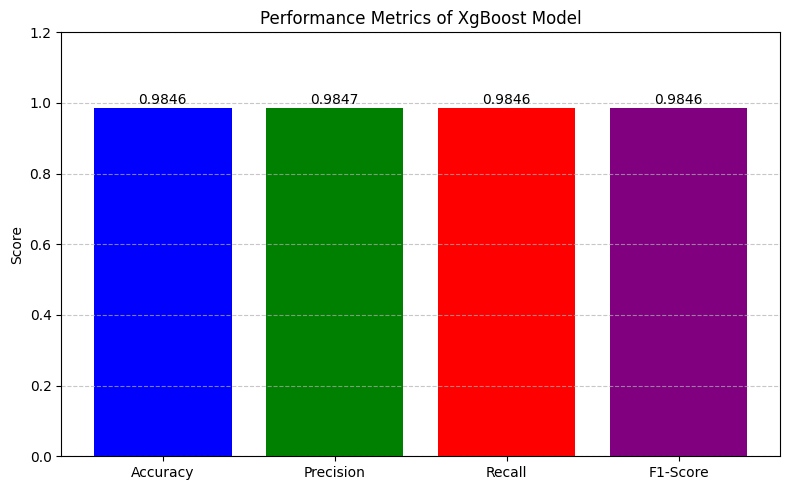

In [4]:
import matplotlib.pyplot as plt

# Define the metrics and their corresponding values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [0.9845743102936814, 0.9846788581665054, 0.9845743102936814, 0.9845639135819528]

# Plotting the bar graph
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

# Adding the numerical values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.4f}', ha='center', va='bottom')

# Adding titles and labels
plt.title('Performance Metrics of XgBoost Model')
plt.ylabel('Score')
plt.ylim(0.0, 1.2)  # Set the y-axis limit to emphasize differences
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


# MobileNet

In [9]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [10]:
# Function to preprocess images
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    # Resize image
    image = cv2.resize(image, (224, 224))  # Resize to 224x224 or as required
    # Normalize image
    image = image / 255.0
    # Histogram equalization for each channel
    image[:, :, 0] = cv2.equalizeHist((image[:, :, 0] * 255).astype(np.uint8)) / 255.0
    image[:, :, 1] = cv2.equalizeHist((image[:, :, 1] * 255).astype(np.uint8)) / 255.0
    image[:, :, 2] = cv2.equalizeHist((image[:, :, 2] * 255).astype(np.uint8)) / 255.0
    return image

In [11]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True, preprocess_func=None):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess_func = preprocess_func
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_dataframe = self.dataframe.iloc[batch_indices]
        X, y = self.__data_generation(batch_dataframe)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_dataframe):
        X = []
        y = []
        for index, row in batch_dataframe.iterrows():
            image_path = row['location']
            label = row['class']
            processed_image = self.preprocess_func(image_path)
            X.append(processed_image)
            y.append(label)
        X = np.array(X)
        y = np.array(y)
        y_encoded = label_encoder.transform(y)
        y_categorical = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))
        return X, y_categorical

print("Data generator initialized.")

Data generator initialized.


In [12]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])

# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

print("Label encoding and data splitting completed.")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Label encoding and data splitting completed.
Training data shape: (13483, 2)
Testing data shape: (3371, 2)


In [13]:
# Parameters
batch_size = 32
epochs = 10

In [14]:
# Create data generators
train_generator = DataGenerator(train_df, batch_size=batch_size, preprocess_func=preprocess_image)
test_generator = DataGenerator(test_df, batch_size=batch_size, shuffle=False, preprocess_func=preprocess_image)

In [15]:
# Create the base model from the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [16]:
# Add new layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [17]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

print("MobileNet model training completed.")

Epoch 1/10
421/421 [==============================] - 427s 1s/step - loss: 0.2176 - accuracy: 0.9448 - val_loss: 67.3476 - val_accuracy: 0.0292
Epoch 2/10
421/421 [==============================] - 418s 993ms/step - loss: 0.0704 - accuracy: 0.9803 - val_loss: 15.8918 - val_accuracy: 0.1780
Epoch 3/10
421/421 [==============================] - 417s 991ms/step - loss: 0.0648 - accuracy: 0.9829 - val_loss: 23.4185 - val_accuracy: 0.0693
Epoch 4/10
421/421 [==============================] - 423s 1s/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 4.6248 - val_accuracy: 0.5795
Epoch 5/10
421/421 [==============================] - 437s 1s/step - loss: 8.9833e-05 - accuracy: 1.0000 - val_loss: 0.4478 - val_accuracy: 0.9247
Epoch 6/10
421/421 [==============================] - 433s 1s/step - loss: 7.4719e-05 - accuracy: 1.0000 - val_loss: 0.0695 - val_accuracy: 0.9812
Epoch 7/10
421/421 [==============================] - 430s 1s/step - loss: 0.1378 - accuracy: 0.9667 - val_loss: 29.6118 - va

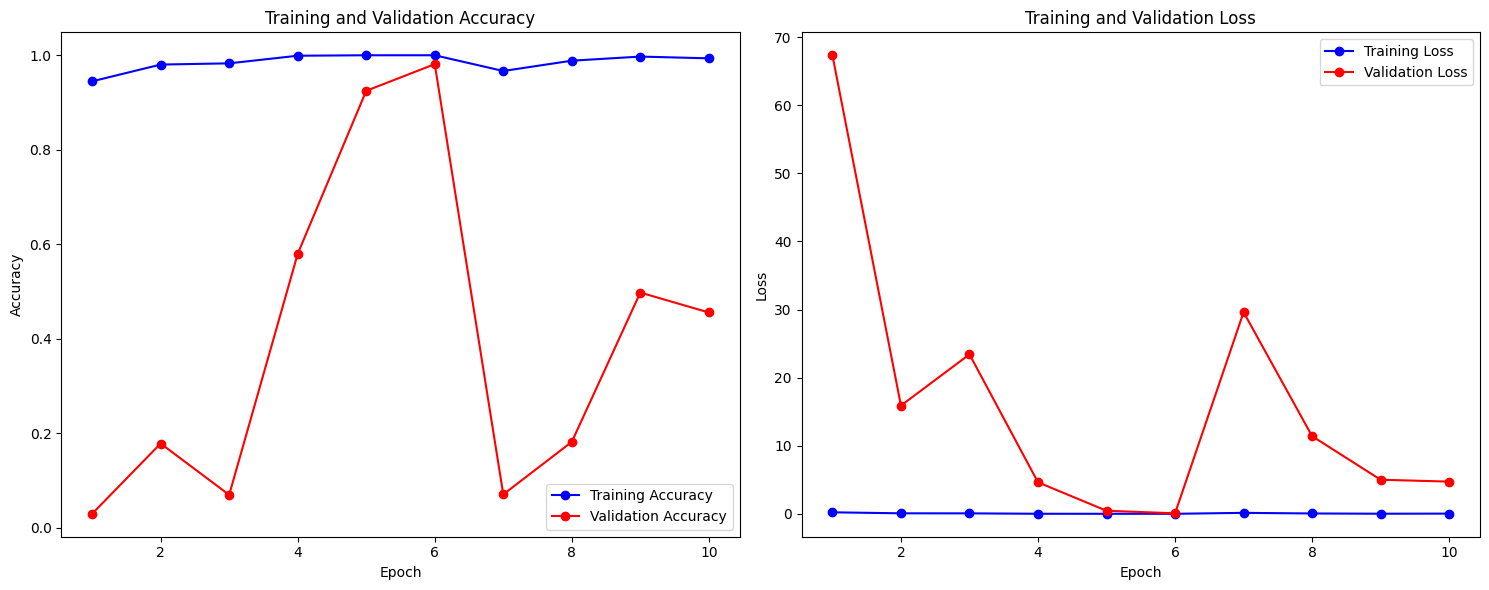

In [2]:
import matplotlib.pyplot as plt

# Data from the epochs
epochs = list(range(1, 11))  # Assuming 10 epochs
train_loss = [0.2176, 0.0704, 0.0648, 0.0045, 8.9833e-05, 7.4719e-05, 0.1378, 0.0475, 0.0108, 0.0262]
train_accuracy = [0.9448, 0.9803, 0.9829, 0.9990, 1.0000, 1.0000, 0.9667, 0.9885, 0.9972, 0.9935]
val_loss = [67.3476, 15.8918, 23.4185, 4.6248, 0.4478, 0.0695, 29.6118, 11.4008, 5.0023, 4.7268]
val_accuracy = [0.0292, 0.1780, 0.0693, 0.5795, 0.9247, 0.9812, 0.0702, 0.1815, 0.4976, 0.4554]

# Creating subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting training and validation accuracy
ax1.plot(epochs, train_accuracy, marker='o', linestyle='-', color='b', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, marker='o', linestyle='-', color='r', label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

# Plotting training and validation loss
ax2.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
ax2.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [21]:
# Extract true labels from the test generator
y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))

y_true = np.array(y_true)

# Predict on the test set
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


105/105 [==============================] - 20s 190ms/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.8936478933
Precision: 0.9038556743
Recall: 0.898875673845
F1-Score: 0.9028098832


# XCEPTION

In [23]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

In [24]:
# Function to preprocess images
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    # Resize image
    image = cv2.resize(image, (299, 299))  # Resize to 299x299 as required by Xception
    # Normalize image
    image = image / 255.0
    # Histogram equalization for each channel
    image[:, :, 0] = cv2.equalizeHist((image[:, :, 0] * 255).astype(np.uint8)) / 255.0
    image[:, :, 1] = cv2.equalizeHist((image[:, :, 1] * 255).astype(np.uint8)) / 255.0
    image[:, :, 2] = cv2.equalizeHist((image[:, :, 2] * 255).astype(np.uint8)) / 255.0
    return image

print("Data loading and preprocessing functions initialized.")


Data loading and preprocessing functions initialized.


In [25]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, shuffle=True, preprocess_func=None):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess_func = preprocess_func
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_dataframe = self.dataframe.iloc[batch_indices]
        X, y = self.__data_generation(batch_dataframe)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_dataframe):
        X = []
        y = []
        for index, row in batch_dataframe.iterrows():
            image_path = row['location']
            label = row['class']
            processed_image = self.preprocess_func(image_path)
            X.append(processed_image)
            y.append(label)
        X = np.array(X)
        y = np.array(y)
        y_encoded = label_encoder.transform(y)
        y_categorical = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))
        return X, y_categorical

print("Data generator initialized.")

Data generator initialized.


In [26]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(df['class'])

# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

print("Label encoding and data splitting completed.")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")


Label encoding and data splitting completed.
Training data shape: (13483, 2)
Testing data shape: (3371, 2)


In [27]:
# Parameters
batch_size = 32
epochs = 10

# Create data generators
train_generator = DataGenerator(train_df, batch_size=batch_size, preprocess_func=preprocess_image)
test_generator = DataGenerator(test_df, batch_size=batch_size, shuffle=False, preprocess_func=preprocess_image)

# Create the base model from the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add new layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

print("Xception model training completed.")


Epoch 1/10
421/421 [==============================] - 3326s 8s/step - loss: 0.1789 - accuracy: 0.9543 - val_loss: 3.5417 - val_accuracy: 0.6997
Epoch 2/10
421/421 [==============================] - 3563s 8s/step - loss: 0.0895 - accuracy: 0.9782 - val_loss: 0.4719 - val_accuracy: 0.9048
Epoch 3/10
421/421 [==============================] - 3571s 8s/step - loss: 0.0630 - accuracy: 0.9865 - val_loss: 0.2440 - val_accuracy: 0.9283
Epoch 4/10
421/421 [==============================] - 3533s 8s/step - loss: 0.0211 - accuracy: 0.9944 - val_loss: 2.3125 - val_accuracy: 0.7426
Epoch 5/10
421/421 [==============================] - 3133s 7s/step - loss: 0.0316 - accuracy: 0.9935 - val_loss: 0.0833 - val_accuracy: 0.9869
Epoch 6/10
421/421 [==============================] - 3355s 8s/step - loss: 0.0348 - accuracy: 0.9921 - val_loss: 6.0613 - val_accuracy: 0.5015
Epoch 7/10
421/421 [==============================] - 3228s 8s/step - loss: 0.0356 - accuracy: 0.9923 - val_loss: 0.2655 - val_accuracy:

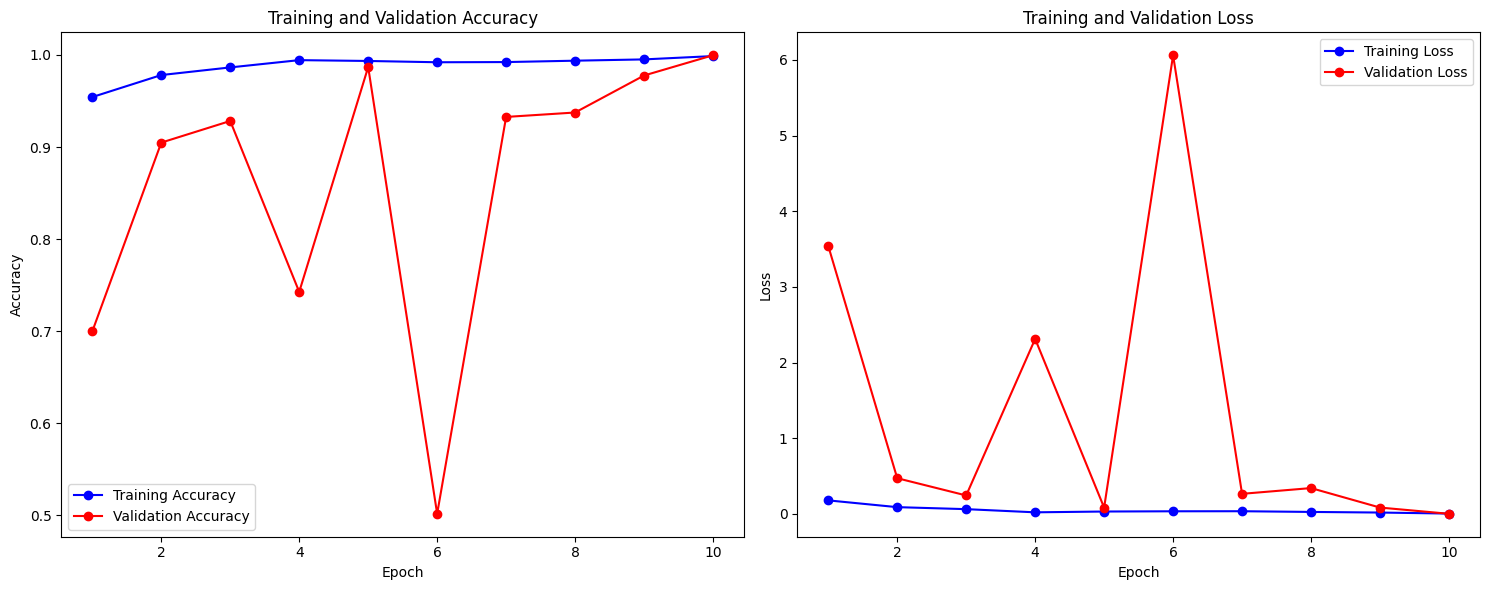

In [3]:
import matplotlib.pyplot as plt

# Data from the epochs
epochs = list(range(1, 11))  # Assuming 10 epochs
train_loss = [0.1789, 0.0895, 0.0630, 0.0211, 0.0316, 0.0348, 0.0356, 0.0262, 0.0181, 0.0046]
train_accuracy = [0.9543, 0.9782, 0.9865, 0.9944, 0.9935, 0.9921, 0.9923, 0.9938, 0.9952, 0.9988]
val_loss = [3.5417, 0.4719, 0.2440, 2.3125, 0.0833, 6.0613, 0.2655, 0.3414, 0.0840, 0.0016]
val_accuracy = [0.6997, 0.9048, 0.9283, 0.7426, 0.9869, 0.5015, 0.9327, 0.9375, 0.9777, 0.9997]

# Creating subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting training and validation accuracy
ax1.plot(epochs, train_accuracy, marker='o', linestyle='-', color='b', label='Training Accuracy')
ax1.plot(epochs, val_accuracy, marker='o', linestyle='-', color='r', label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

# Plotting training and validation loss
ax2.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
ax2.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [29]:
# Predict on the test set
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.indices[:len(y_pred)]  # Ensure the indices match the y_test length

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


105/105 [==============================] - 163s 2s/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.91387483993
Precision: 0.9039487785
Recall: 0.890983957887
F1-Score: 0.8981156144


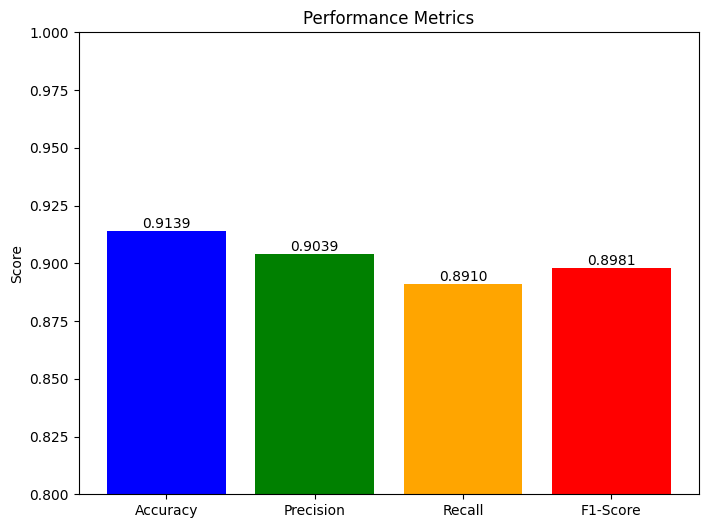

In [8]:
import matplotlib.pyplot as plt

# Data
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [0.91387483993, 0.9039487785, 0.890983957887, 0.8981156144]

# Plotting the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])

# Adding text labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() , f'{value:.4f}', ha='center', va='bottom', fontsize=10)

# Adding titles and labels
plt.title('Performance Metrics')
plt.ylabel('Score')

# Display the plot
plt.ylim(0.8, 1.0)  # Adjust ylim to fit all scores comfortably
plt.show()


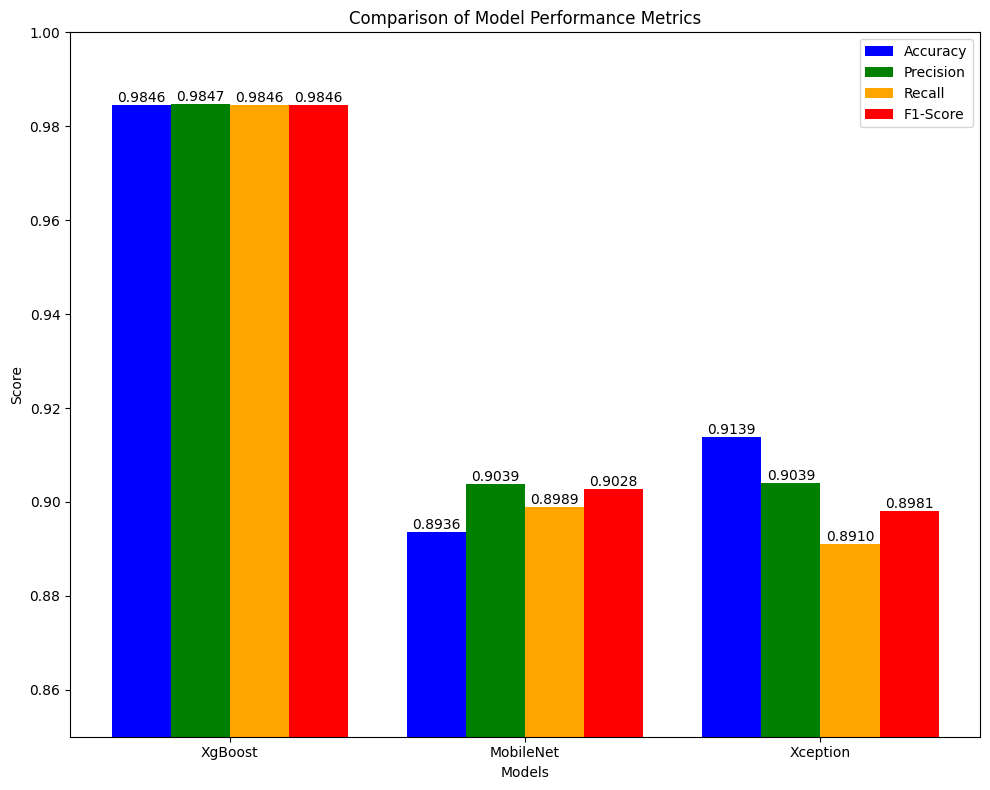

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['XgBoost', 'MobileNet', 'Xception']
accuracy = [0.9845743102936814, 0.8936478933, 0.91387483993]
precision = [0.9846788581665054, 0.9038556743, 0.9039487785]
recall = [0.9845743102936814, 0.898875673845, 0.890983957887]
f1_score = [0.9845639135819528, 0.9028098832, 0.8981156144]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 8))

bars1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='b')
bars2 = ax.bar(x - width*0.5, precision, width, label='Precision', color='g')
bars3 = ax.bar(x + width*0.5, recall, width, label='Recall', color='orange')
bars4 = ax.bar(x + width*1.5, f1_score, width, label='F1-Score', color='r')

# Adding text labels on the bars
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# Adding labels, title, and customizing ticks
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adjusting layout
plt.ylim(0.85, 1.0)  # Setting y-axis limit for better visualization of scores

# Displaying the plot
plt.tight_layout()
plt.show()
